In [1]:
import joblib
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, Subset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import KFold

loaded_data = joblib.load("train_data.pkl")

targets, data, ids = loaded_data

# 打印某个人的具体信息

for i in tqdm(range(277)):
    if ids[i] == "44a41bba1ee7":
        print(f"Target: {targets[i]}")
        print(f"{data[i]}")
        print(type(targets[i]))
        print(type(data[i]))

100%|██████████| 277/277 [00:00<00:00, 16741.20it/s]

Target: [(6228, 12324), (22044, 28248), (59016, 65064), (78024, 82068), (95400, 99444), (109956, 114480), (126780, 132972), (144984, 151944), (191376, 199020), (211716, 217476), (243036, 251184)]
           anglez      enmo      step
0       26.234375  0.142456       0.0
1       25.828125  0.142456       1.0
2       25.687500  0.140015       2.0
3       26.640625  0.141968       3.0
4       26.140625  0.154053       4.0
...           ...       ...       ...
328135  -2.517578  0.027496  328135.0
328136 -10.000000  0.016602  328136.0
328137 -12.046875  0.015198  328137.0
328138 -12.585938  0.013901  328138.0
328139 -16.937500  0.013000  328139.0

[328140 rows x 3 columns]
<class 'list'>
<class 'pandas.core.frame.DataFrame'>


In [2]:
class CFG:
    window_overlap = 30
    window_size = 60
    train_ratio = 0.85
    batch_size = 32
    input_dim = 2
    embed_dim = 32
    num_classes = 3 
    num_layers = 6
    nhead = 4
    dim_feedforward = 64
    learning_rate = 1e-3
    epochs = 100
    train_record_steps = 80
    test_record_steps = 20
    dropout = 0.4
    num_person = 277
    scheduler_step_size = 20
    scheduler_gamma = 0.7
    fold = 8
    weight_decay = 0.001
    model_dir = "./models"

In [3]:
# 生成放入模型的数据，假设使用30分钟作为一个窗口，那么需要找的为形状（360，2）的矩阵

train_events = pd.read_csv("./train_events.csv")
num_person = len(train_events["series_id"].unique())
print("The number of total persons is:", num_person)

# 用来存储模型的输入与标签
X = []
y = []

for i in tqdm(range(min(num_person, CFG.num_person))):

    df = data[i]
    pair_list = targets[i]
    sleep_id = ids[i]

    # 先提取出开始睡觉和结束睡觉的时间
    onset_steps = []
    wakeup_steps = []
    for j in range(len(pair_list)):
        onset_steps.append(pair_list[j][0])
        wakeup_steps.append(pair_list[j][1])
    # print("length of onset list:", len(onset_steps))
    # print("length of wakeup list:", len(wakeup_steps))
    # print(onset_steps)
    # print(wakeup_steps)

    # 中间没有明确时间点的区间全部都不要
    empty_spaces = []
    events = train_events[train_events["series_id"] == sleep_id]
    last_events = 0
    mark = 0 
    for (idx, row) in events.iterrows():
        if np.isnan(row["step"]):
            mark = 1
        else:
            if row["step"] > last_events and mark == 0:
                last_events = row["step"]
            elif row["step"] > last_events and mark == 1:
                empty_spaces.append((int(last_events + 720), int(row["step"] - 720)))
                last_events = row["step"]
                mark = 0

    # print(empty_spaces)

    # 为训练数据设置label，如果区间中没有任何事件，标签为0，如果有开始睡觉事件，标签为1，如果有结束睡觉事件，标签为2
    labels = []
    for j in range(0, len(df), CFG.window_overlap):
        start = j
        if j + CFG.window_size >= len(df):
            break
        else:
            end = j + CFG.window_size

        flag = 0
        for k in empty_spaces:
            if (k[0] <= start <= k[1]) or (k[0] <= end <= k[1]):
                flag = 1
                break
            else:
                continue

        chunk = df.iloc[start:end][["anglez", "enmo"]]
        chunk = chunk.to_numpy()

        if flag == 1:
            label = 3
        elif any(start <= num <= end for num in wakeup_steps):
            label = 2
        elif any(start <= num <= end for num in onset_steps):
            label = 1
        else:
            label = 0
        labels.append(label)

        if label != 3:
            X.append(chunk)
            y.append(label)

    element_counts = Counter(labels)

    # for element, count in element_counts.items():
    #     print(f"Element {element} occurs {count} times")

print(len(X), len(y))

The number of total persons is: 277


  2%|▏         | 1/50 [00:05<04:30,  5.51s/it]

Element 0 occurs 10313 times
Element 1 occurs 43 times
Element 2 occurs 42 times
Element 3 occurs 2596 times


  4%|▍         | 2/50 [00:15<06:31,  8.16s/it]

Element 0 occurs 19221 times
Element 1 occurs 19 times
Element 2 occurs 18 times
Element 3 occurs 4878 times


  6%|▌         | 3/50 [00:20<05:24,  6.91s/it]

Element 0 occurs 10152 times
Element 1 occurs 39 times
Element 2 occurs 40 times
Element 3 occurs 3009 times


  8%|▊         | 4/50 [00:29<05:49,  7.59s/it]

Element 0 occurs 16909 times
Element 3 occurs 4250 times
Element 1 occurs 44 times
Element 2 occurs 47 times


 10%|█         | 5/50 [00:34<05:04,  6.76s/it]

Element 0 occurs 12687 times
Element 3 occurs 639 times
Element 1 occurs 16 times
Element 2 occurs 18 times


 12%|█▏        | 6/50 [00:40<04:43,  6.45s/it]

Element 0 occurs 8673 times
Element 1 occurs 6 times
Element 2 occurs 7 times
Element 3 occurs 6060 times


 14%|█▍        | 7/50 [00:51<05:34,  7.78s/it]

Element 0 occurs 16916 times
Element 1 occurs 33 times
Element 2 occurs 29 times
Element 3 occurs 8976 times


 16%|█▌        | 8/50 [00:57<05:05,  7.28s/it]

Element 0 occurs 14561 times
Element 1 occurs 56 times
Element 2 occurs 57 times


 18%|█▊        | 9/50 [01:01<04:10,  6.12s/it]

Element 0 occurs 8495 times
Element 1 occurs 32 times
Element 2 occurs 33 times


 20%|██        | 10/50 [01:05<03:49,  5.74s/it]

Element 0 occurs 7972 times
Element 1 occurs 12 times
Element 2 occurs 13 times
Element 3 occurs 4343 times


 22%|██▏       | 11/50 [01:15<04:24,  6.78s/it]

Element 0 occurs 19506 times
Element 1 occurs 70 times
Element 2 occurs 67 times
Element 3 occurs 527 times


 24%|██▍       | 12/50 [01:21<04:13,  6.67s/it]

Element 0 occurs 12731 times
Element 1 occurs 45 times
Element 2 occurs 44 times


 26%|██▌       | 13/50 [01:27<04:01,  6.54s/it]

Element 0 occurs 11025 times
Element 1 occurs 42 times
Element 2 occurs 47 times
Element 3 occurs 2378 times


 28%|██▊       | 14/50 [01:33<03:47,  6.31s/it]

Element 0 occurs 10072 times
Element 1 occurs 46 times
Element 2 occurs 46 times
Element 3 occurs 3538 times


 30%|███       | 15/50 [01:42<04:13,  7.24s/it]

Element 0 occurs 16924 times
Element 1 occurs 64 times
Element 2 occurs 67 times
Element 3 occurs 2041 times


 32%|███▏      | 16/50 [01:48<03:46,  6.66s/it]

Element 0 occurs 12003 times
Element 1 occurs 47 times
Element 2 occurs 44 times


 34%|███▍      | 17/50 [01:55<03:50,  6.99s/it]

Element 0 occurs 11254 times
Element 1 occurs 48 times
Element 2 occurs 46 times
Element 3 occurs 5846 times


 36%|███▌      | 18/50 [01:59<03:11,  6.00s/it]

Element 0 occurs 8890 times


 38%|███▊      | 19/50 [02:05<03:04,  5.94s/it]

Element 0 occurs 12535 times
Element 1 occurs 7 times
Element 2 occurs 7 times
Element 3 occurs 883 times


 40%|████      | 20/50 [02:11<02:54,  5.83s/it]

Element 0 occurs 13593 times
Element 1 occurs 51 times
Element 2 occurs 52 times


 42%|████▏     | 21/50 [02:16<02:43,  5.63s/it]

Element 0 occurs 12980 times
Element 1 occurs 48 times
Element 2 occurs 50 times


 44%|████▍     | 22/50 [02:26<03:13,  6.89s/it]

Element 0 occurs 22994 times
Element 1 occurs 59 times
Element 2 occurs 62 times
Element 3 occurs 1699 times


 46%|████▌     | 23/50 [02:33<03:14,  7.21s/it]

Element 0 occurs 19920 times
Element 1 occurs 70 times
Element 2 occurs 72 times


 48%|████▊     | 24/50 [02:39<02:53,  6.69s/it]

Element 0 occurs 14118 times
Element 1 occurs 8 times
Element 2 occurs 8 times


 50%|█████     | 25/50 [02:46<02:53,  6.94s/it]

Element 0 occurs 11898 times
Element 1 occurs 40 times
Element 2 occurs 42 times
Element 3 occurs 7416 times


 52%|█████▏    | 26/50 [02:52<02:35,  6.50s/it]

Element 0 occurs 13328 times
Element 3 occurs 806 times
Element 1 occurs 10 times
Element 2 occurs 8 times


 54%|█████▍    | 27/50 [02:59<02:34,  6.73s/it]

Element 0 occurs 11502 times
Element 1 occurs 35 times
Element 2 occurs 35 times
Element 3 occurs 6774 times


 56%|█████▌    | 28/50 [03:06<02:31,  6.87s/it]

Element 0 occurs 17744 times
Element 1 occurs 66 times
Element 2 occurs 70 times
Element 3 occurs 526 times


 58%|█████▊    | 29/50 [03:11<02:12,  6.30s/it]

Element 0 occurs 5717 times
Element 1 occurs 31 times
Element 2 occurs 30 times
Element 3 occurs 7036 times


 60%|██████    | 30/50 [03:18<02:05,  6.29s/it]

Element 0 occurs 15844 times
Element 1 occurs 56 times
Element 2 occurs 58 times


 62%|██████▏   | 31/50 [03:23<01:55,  6.08s/it]

Element 0 occurs 12374 times
Element 1 occurs 41 times
Element 2 occurs 44 times
Element 3 occurs 1843 times


 64%|██████▍   | 32/50 [03:28<01:43,  5.76s/it]

Element 0 occurs 11871 times
Element 1 occurs 50 times
Element 2 occurs 44 times
Element 3 occurs 915 times


 66%|██████▌   | 33/50 [03:36<01:48,  6.41s/it]

Element 0 occurs 19194 times
Element 1 occurs 69 times
Element 2 occurs 66 times
Element 3 occurs 877 times


 68%|██████▊   | 34/50 [03:43<01:42,  6.42s/it]

Element 0 occurs 16388 times
Element 1 occurs 63 times
Element 2 occurs 65 times


 70%|███████   | 35/50 [03:50<01:39,  6.66s/it]

Element 0 occurs 18354 times
Element 1 occurs 67 times
Element 2 occurs 63 times


 72%|███████▏  | 36/50 [03:55<01:27,  6.25s/it]

Element 0 occurs 11902 times
Element 1 occurs 46 times
Element 2 occurs 44 times
Element 3 occurs 948 times


 74%|███████▍  | 37/50 [03:57<01:02,  4.82s/it]

Element 0 occurs 2905 times
Element 1 occurs 14 times
Element 2 occurs 12 times
Element 3 occurs 913 times


 76%|███████▌  | 38/50 [04:04<01:08,  5.71s/it]

Element 0 occurs 5490 times
Element 3 occurs 14592 times
Element 1 occurs 22 times
Element 2 occurs 24 times


 78%|███████▊  | 39/50 [04:11<01:06,  6.07s/it]

Element 0 occurs 15435 times
Element 1 occurs 14 times
Element 2 occurs 13 times
Element 3 occurs 2368 times


 80%|████████  | 40/50 [04:19<01:05,  6.51s/it]

Element 0 occurs 8271 times
Element 3 occurs 11103 times
Element 1 occurs 33 times
Element 2 occurs 31 times


 82%|████████▏ | 41/50 [04:24<00:54,  6.09s/it]

Element 0 occurs 11020 times
Element 1 occurs 40 times
Element 2 occurs 39 times
Element 3 occurs 1961 times


 84%|████████▍ | 42/50 [04:33<00:55,  6.92s/it]

Element 0 occurs 20529 times
Element 1 occurs 79 times
Element 2 occurs 76 times
Element 3 occurs 1802 times


 86%|████████▌ | 43/50 [04:41<00:51,  7.31s/it]

Element 0 occurs 21261 times
Element 1 occurs 18 times
Element 2 occurs 19 times


 88%|████████▊ | 44/50 [04:46<00:39,  6.60s/it]

Element 0 occurs 11706 times
Element 1 occurs 45 times
Element 2 occurs 46 times
Element 3 occurs 867 times


 90%|█████████ | 45/50 [04:54<00:35,  7.01s/it]

Element 0 occurs 9564 times
Element 1 occurs 46 times
Element 2 occurs 51 times
Element 3 occurs 10731 times


 92%|█████████▏| 46/50 [05:01<00:28,  7.07s/it]

Element 0 occurs 11927 times
Element 1 occurs 52 times
Element 2 occurs 50 times
Element 3 occurs 6509 times


 94%|█████████▍| 47/50 [05:07<00:20,  6.83s/it]

Element 0 occurs 15343 times
Element 1 occurs 62 times
Element 2 occurs 67 times


 96%|█████████▌| 48/50 [05:13<00:12,  6.31s/it]

Element 0 occurs 7823 times
Element 1 occurs 33 times
Element 2 occurs 30 times
Element 3 occurs 5294 times


 98%|█████████▊| 49/50 [05:18<00:06,  6.20s/it]

Element 0 occurs 11890 times
Element 1 occurs 49 times
Element 2 occurs 49 times
Element 3 occurs 3178 times


100%|██████████| 50/50 [05:26<00:00,  6.54s/it]

Element 0 occurs 18036 times
Element 1 occurs 69 times
Element 2 occurs 67 times
Element 3 occurs 1860 times
665874 665874


In [4]:
X_noevent = []
y_noevent = []
X_onset = []
y_onset = []
X_wakeup = []
y_wakeup = []

for i in tqdm(range(len(X))):
    xi = X[i]
    yi = y[i]
    if yi == 0:
        X_noevent.append(xi)
        y_noevent.append(yi)
    elif yi == 1:
        X_onset.append(xi)
        y_onset.append(yi)
    elif yi == 2:
        X_wakeup.append(xi)
        y_wakeup.append(yi)

print(len(X_noevent), len(X_onset), len(X_wakeup))

X_noevent = X_noevent[:10400]
y_noevent = y_noevent[:10400]
X = X_noevent + X_onset + X_wakeup
y = y_noevent + y_onset + y_wakeup

print(len(X), len(y))

100%|██████████| 665874/665874 [00:00<00:00, 1761751.35it/s]


661760 2055 2059
14514 14514


In [5]:
class MyDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        inp = self.inputs[index]
        output = self.outputs[index]

        input_tensor = torch.tensor(inp, dtype=torch.float32)
        output_tensor = torch.tensor(output, dtype=torch.long)

        return input_tensor, output_tensor


dataset = MyDataset(X, y)
print(len(dataset))

train_size = int(CFG.train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=True)
print(len(train_loader), len(test_loader))

14514
363 91


In [6]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        num_classes=3,
        num_layers=8,
        nhead=4,
        dim_feedforward=64,
        dropout=0.4
    ):

        super(TransformerModel, self).__init__()

        self.conv1d = nn.Conv1d(
            in_channels=input_dim, 
            out_channels=embed_dim, 
            kernel_size=3, 
            padding=1
        )
        self.embed_layer = nn.Linear(embed_dim, embed_dim)
        self.layernorm = nn.LayerNorm(embed_dim)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout
            ),
            num_layers=num_layers
        )

        self.classification = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1d(x)
        x = x.permute(0, 2, 1)

        x = self.embed_layer(x)
        x = self.layernorm(x)
        x = self.encoder(x.permute(1, 0, 2))
        print(x.shape)
        x = x[-1]
        x = self.classification(x)
        return x

# 示例
model = TransformerModel(input_dim=2, embed_dim=32)
input_data = torch.rand(3, 360, 2)
output = model(input_data)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
print(output.shape)

TransformerModel(
  (conv1d): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (embed_layer): Linear(in_features=32, out_features=32, bias=True)
  (layernorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=64, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=64, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (classification): Linear(in_features=32, out_features=3, bias=True)
)
Total 

In [7]:
model = TransformerModel(
    input_dim=CFG.input_dim,
    embed_dim=CFG.embed_dim,
    num_classes=CFG.num_classes,
    num_layers=CFG.num_layers,
    nhead=CFG.nhead,
    dim_feedforward=CFG.dim_feedforward,
    dropout=CFG.dropout
)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=CFG.learning_rate)
# scheduler = StepLR(optimizer, step_size=CFG.scheduler_step_size, gamma=CFG.scheduler_gamma)
device = "cuda" if torch.cuda.is_available() else "cpu"

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 35619


In [8]:
model = model.to(device)
model.train()
train_losses = []
train_step_losses = []
test_losses = []
test_step_losses = []
learning_rates = []

kf = KFold(n_splits=CFG.fold, shuffle=True, random_state=2023)

for fold, (train_index, test_index) in enumerate(kf.split(dataset)):
    train_subset = Subset(dataset, train_index)
    test_subset = Subset(dataset, test_index)

    train_loader = DataLoader(train_subset, batch_size=CFG.batch_size, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=CFG.batch_size)

    init_lr = CFG.learning_rate

    if fold == 0:
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=init_lr,
            weight_decay=CFG.weight_decay
        )
    else:
        # current_learning_rate = optimizer.param_groups[0]["lr"]
        # print("current learning rate is:", current_learning_rate)
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=init_lr / (1.25 ** fold),
            weight_decay=CFG.weight_decay
        )

    scheduler = StepLR(optimizer, step_size=CFG.scheduler_step_size, gamma=CFG.scheduler_gamma)

    min_loss = 10000.0

    for epoch in range(1, CFG.epochs + 1):
        train_loss = 0.0
        test_loss = 0.0
        train_step_loss = 0.0
        test_step_loss = 0.0


        learning_rate = optimizer.param_groups[0]["lr"]
        learning_rates.append(learning_rate)

        for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            optimizer.zero_grad()

            data = data.to(device)
            target = target.to(device)
            output = model(data)

            loss = criterion(output, target)
            train_loss += loss.item()
            train_step_loss += loss.item()

            loss.backward()
            optimizer.step()

            if (batch_idx + 1) % CFG.train_record_steps == 0:
                train_step_loss /= CFG.train_record_steps
                train_step_losses.append(train_step_loss)
                print(f"Fold: {fold + 1}, Epoch: {epoch + 1}, Step: {(batch_idx + 1) * CFG.train_record_steps}, Train Loss These Steps: {train_step_loss}")
                train_step_loss = 0.0

        scheduler.step()

        with torch.no_grad():
            for batch_idx, (data, target) in tqdm(enumerate(test_loader), total=len(test_loader)):
                data = data.to(device)
                target = target.to(device)
                output = model(data)

                loss = criterion(output, target)
                test_loss += loss.item()
                test_step_loss += loss.item()

                if (batch_idx + 1) % CFG.test_record_steps == 0:
                    test_step_loss /= CFG.test_record_steps
                    test_step_losses.append(test_step_loss)
                    print(f"Fold: {fold + 1}, Epoch: {epoch + 1}, Step: {(batch_idx + 1) * CFG.test_record_steps}, Test Loss These Steps: {test_step_loss}")
                    test_step_loss = 0.0

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        if test_loss < min_loss:
            min_loss = test_loss
            torch.save(model.state_dict(), f"{CFG.model_dir}/model_{fold + 1}_{epoch}.pth")


        print(f"Fold: {fold + 1}, Epoch: {epoch}, Train Loss: {train_loss}, Test Loss: {test_loss}")

 21%|██        | 82/397 [00:04<00:17, 17.69it/s]

Fold: 1, Epoch: 2, Step: 6400, Train Loss These Steps: 0.787592776492238


 41%|████      | 162/397 [00:09<00:13, 17.99it/s]

Fold: 1, Epoch: 2, Step: 12800, Train Loss These Steps: 0.7848955407738686


 61%|██████▏   | 244/397 [00:13<00:08, 18.05it/s]

Fold: 1, Epoch: 2, Step: 19200, Train Loss These Steps: 0.7750330217182636


 81%|████████  | 322/397 [00:18<00:04, 15.11it/s]

Fold: 1, Epoch: 2, Step: 25600, Train Loss These Steps: 0.7451701018959284


 42%|████▏     | 24/57 [00:00<00:00, 35.43it/s]

Fold: 1, Epoch: 2, Step: 400, Test Loss These Steps: 0.34121828973293306


 77%|███████▋  | 44/57 [00:01<00:00, 35.11it/s]

Fold: 1, Epoch: 2, Step: 800, Test Loss These Steps: 0.2952055536210537


100%|██████████| 57/57 [00:01<00:00, 34.95it/s]


Fold: 1, Epoch: 1, Train Loss: 0.7624469679458916, Test Loss: 0.7385999547284946


 21%|██        | 82/397 [00:04<00:17, 18.03it/s]

Fold: 1, Epoch: 3, Step: 6400, Train Loss These Steps: 0.717412544041872


 41%|████      | 162/397 [00:09<00:13, 17.79it/s]

Fold: 1, Epoch: 3, Step: 12800, Train Loss These Steps: 0.7280892223119736


 61%|██████    | 243/397 [00:13<00:08, 17.66it/s]

Fold: 1, Epoch: 3, Step: 19200, Train Loss These Steps: 0.6450032435357571


 81%|████████▏ | 323/397 [00:18<00:04, 17.85it/s]

Fold: 1, Epoch: 3, Step: 25600, Train Loss These Steps: 0.6442857854068279


 42%|████▏     | 24/57 [00:00<00:00, 35.19it/s]

Fold: 1, Epoch: 3, Step: 400, Test Loss These Steps: 0.33491450659930705


 77%|███████▋  | 44/57 [00:01<00:00, 34.75it/s]

Fold: 1, Epoch: 3, Step: 800, Test Loss These Steps: 0.27397847156971694


100%|██████████| 57/57 [00:01<00:00, 33.80it/s]


Fold: 1, Epoch: 2, Train Loss: 0.6747795502544951, Test Loss: 0.6737452037632465


 21%|██        | 82/397 [00:04<00:17, 17.75it/s]

Fold: 1, Epoch: 4, Step: 6400, Train Loss These Steps: 0.635599559918046


 41%|████      | 163/397 [00:09<00:12, 18.22it/s]

Fold: 1, Epoch: 4, Step: 12800, Train Loss These Steps: 0.6284849233925343


 61%|██████    | 243/397 [00:13<00:09, 16.93it/s]

Fold: 1, Epoch: 4, Step: 19200, Train Loss These Steps: 0.6580518439412117


 81%|████████  | 322/397 [00:18<00:04, 17.23it/s]

Fold: 1, Epoch: 4, Step: 25600, Train Loss These Steps: 0.6353651318699122


 42%|████▏     | 24/57 [00:00<00:00, 34.04it/s]

Fold: 1, Epoch: 4, Step: 400, Test Loss These Steps: 0.3093809485435486


 77%|███████▋  | 44/57 [00:01<00:00, 35.30it/s]

Fold: 1, Epoch: 4, Step: 800, Test Loss These Steps: 0.24280787277966737


100%|██████████| 57/57 [00:01<00:00, 34.70it/s]


Fold: 1, Epoch: 3, Train Loss: 0.640539578436604, Test Loss: 0.6738265654104844


 21%|██        | 82/397 [00:04<00:17, 17.79it/s]

Fold: 1, Epoch: 5, Step: 6400, Train Loss These Steps: 0.6182203941047192


 41%|████      | 162/397 [00:09<00:13, 17.90it/s]

Fold: 1, Epoch: 5, Step: 12800, Train Loss These Steps: 0.612381049990654


 61%|██████    | 243/397 [00:13<00:08, 18.39it/s]

Fold: 1, Epoch: 5, Step: 19200, Train Loss These Steps: 0.6055918622761964


 81%|████████▏ | 323/397 [00:18<00:04, 18.23it/s]

Fold: 1, Epoch: 5, Step: 25600, Train Loss These Steps: 0.6665189728140831


 42%|████▏     | 24/57 [00:00<00:00, 34.37it/s]

Fold: 1, Epoch: 5, Step: 400, Test Loss These Steps: 0.37310093604028227


 77%|███████▋  | 44/57 [00:01<00:00, 33.70it/s]

Fold: 1, Epoch: 5, Step: 800, Test Loss These Steps: 0.2915140291675925


100%|██████████| 57/57 [00:01<00:00, 34.76it/s]


Fold: 1, Epoch: 4, Train Loss: 0.6296463682309206, Test Loss: 0.6605223004885933


 21%|██        | 82/397 [00:04<00:17, 17.54it/s]

Fold: 1, Epoch: 6, Step: 6400, Train Loss These Steps: 0.6179332863539457


 41%|████      | 162/397 [00:09<00:12, 18.40it/s]

Fold: 1, Epoch: 6, Step: 12800, Train Loss These Steps: 0.6389551512897015


 61%|██████    | 242/397 [00:13<00:08, 17.91it/s]

Fold: 1, Epoch: 6, Step: 19200, Train Loss These Steps: 0.6225144296884537


 81%|████████▏ | 323/397 [00:18<00:04, 17.36it/s]

Fold: 1, Epoch: 6, Step: 25600, Train Loss These Steps: 0.5983727429062128


 42%|████▏     | 24/57 [00:00<00:00, 35.91it/s]

Fold: 1, Epoch: 6, Step: 400, Test Loss These Steps: 0.33053233828395606


 77%|███████▋  | 44/57 [00:01<00:00, 34.00it/s]

Fold: 1, Epoch: 6, Step: 800, Test Loss These Steps: 0.2648396693170071


100%|██████████| 57/57 [00:01<00:00, 35.33it/s]


Fold: 1, Epoch: 5, Train Loss: 0.6236149279837044, Test Loss: 0.65016670962959


 21%|██        | 82/397 [00:04<00:17, 18.11it/s]

Fold: 1, Epoch: 7, Step: 6400, Train Loss These Steps: 0.6368037689477205


 41%|████      | 162/397 [00:09<00:12, 18.08it/s]

Fold: 1, Epoch: 7, Step: 12800, Train Loss These Steps: 0.6142574060708285


 61%|██████    | 242/397 [00:13<00:08, 18.02it/s]

Fold: 1, Epoch: 7, Step: 19200, Train Loss These Steps: 0.6305992141366005


 81%|████████  | 322/397 [00:18<00:04, 17.70it/s]

Fold: 1, Epoch: 7, Step: 25600, Train Loss These Steps: 0.609011710435152


 42%|████▏     | 24/57 [00:00<00:00, 34.49it/s]

Fold: 1, Epoch: 7, Step: 400, Test Loss These Steps: 0.3620422355830669


 77%|███████▋  | 44/57 [00:01<00:00, 33.92it/s]

Fold: 1, Epoch: 7, Step: 800, Test Loss These Steps: 0.285487318970263


100%|██████████| 57/57 [00:01<00:00, 34.42it/s]


Fold: 1, Epoch: 6, Train Loss: 0.6173005905049274, Test Loss: 0.6501497511931679


 21%|██        | 82/397 [00:04<00:17, 17.88it/s]

Fold: 1, Epoch: 8, Step: 6400, Train Loss These Steps: 0.6046505857259035


 41%|████      | 162/397 [00:09<00:13, 17.94it/s]

Fold: 1, Epoch: 8, Step: 12800, Train Loss These Steps: 0.6288373500108719


 61%|██████    | 242/397 [00:13<00:08, 18.01it/s]

Fold: 1, Epoch: 8, Step: 19200, Train Loss These Steps: 0.6100373230874538


 81%|████████  | 322/397 [00:18<00:04, 17.50it/s]

Fold: 1, Epoch: 8, Step: 25600, Train Loss These Steps: 0.6260344598442316


 42%|████▏     | 24/57 [00:00<00:00, 34.17it/s]

Fold: 1, Epoch: 8, Step: 400, Test Loss These Steps: 0.3749987166374922


 77%|███████▋  | 44/57 [00:01<00:00, 34.93it/s]

Fold: 1, Epoch: 8, Step: 800, Test Loss These Steps: 0.2865535108372569


100%|██████████| 57/57 [00:01<00:00, 34.52it/s]


Fold: 1, Epoch: 7, Train Loss: 0.6152998348627643, Test Loss: 0.6492824411313785


 21%|██        | 82/397 [00:04<00:18, 17.29it/s]

Fold: 1, Epoch: 9, Step: 6400, Train Loss These Steps: 0.599623042345047


 41%|████▏     | 164/397 [00:09<00:12, 18.58it/s]

Fold: 1, Epoch: 9, Step: 12800, Train Loss These Steps: 0.6220139641314745


 61%|██████    | 242/397 [00:13<00:09, 16.82it/s]

Fold: 1, Epoch: 9, Step: 19200, Train Loss These Steps: 0.6128875907510519


 81%|████████▏ | 323/397 [00:18<00:03, 18.61it/s]

Fold: 1, Epoch: 9, Step: 25600, Train Loss These Steps: 0.6078077271580696


 47%|████▋     | 27/57 [00:00<00:00, 36.42it/s]

Fold: 1, Epoch: 9, Step: 400, Test Loss These Steps: 0.3651835575699806


 75%|███████▌  | 43/57 [00:01<00:00, 35.41it/s]

Fold: 1, Epoch: 9, Step: 800, Test Loss These Steps: 0.2859889645129442


100%|██████████| 57/57 [00:01<00:00, 35.43it/s]


Fold: 1, Epoch: 8, Train Loss: 0.6127823917781676, Test Loss: 0.6459869722786703


 21%|██        | 82/397 [00:04<00:17, 18.13it/s]

Fold: 1, Epoch: 10, Step: 6400, Train Loss These Steps: 0.5936782404780387


 41%|████      | 163/397 [00:09<00:12, 18.23it/s]

Fold: 1, Epoch: 10, Step: 12800, Train Loss These Steps: 0.6198098845779896


 61%|██████    | 242/397 [00:13<00:08, 18.22it/s]

Fold: 1, Epoch: 10, Step: 19200, Train Loss These Steps: 0.6070889987051487


 81%|████████▏ | 323/397 [00:17<00:04, 18.05it/s]

Fold: 1, Epoch: 10, Step: 25600, Train Loss These Steps: 0.5925100207328796


 42%|████▏     | 24/57 [00:00<00:00, 36.04it/s]

Fold: 1, Epoch: 10, Step: 400, Test Loss These Steps: 0.36248463597148656


 77%|███████▋  | 44/57 [00:01<00:00, 35.80it/s]

Fold: 1, Epoch: 10, Step: 800, Test Loss These Steps: 0.29236400686204433


100%|██████████| 57/57 [00:01<00:00, 34.98it/s]


Fold: 1, Epoch: 9, Train Loss: 0.6101481336490333, Test Loss: 0.6382091281314691


 21%|██        | 83/397 [00:04<00:17, 18.08it/s]

Fold: 1, Epoch: 11, Step: 6400, Train Loss These Steps: 0.6038774996995926


 41%|████▏     | 164/397 [00:08<00:12, 18.25it/s]

Fold: 1, Epoch: 11, Step: 12800, Train Loss These Steps: 0.6077819488942623


 61%|██████    | 243/397 [00:13<00:08, 18.07it/s]

Fold: 1, Epoch: 11, Step: 19200, Train Loss These Steps: 0.6046276208013296


 81%|████████  | 322/397 [00:17<00:04, 17.77it/s]

Fold: 1, Epoch: 11, Step: 25600, Train Loss These Steps: 0.602129603177309


 39%|███▊      | 22/57 [00:01<00:02, 15.66it/s]

Fold: 1, Epoch: 11, Step: 400, Test Loss These Steps: 0.35958546940237285


 75%|███████▌  | 43/57 [00:02<00:00, 21.80it/s]

Fold: 1, Epoch: 11, Step: 800, Test Loss These Steps: 0.3043320286087692


100%|██████████| 57/57 [00:02<00:00, 20.79it/s]


Fold: 1, Epoch: 10, Train Loss: 0.6021590885197186, Test Loss: 0.63283398214793


 21%|██        | 82/397 [00:06<00:25, 12.53it/s]

Fold: 1, Epoch: 12, Step: 6400, Train Loss These Steps: 0.6105340655893088


 41%|████      | 162/397 [00:12<00:22, 10.39it/s]

Fold: 1, Epoch: 12, Step: 12800, Train Loss These Steps: 0.6073894973844289


 61%|██████    | 242/397 [00:18<00:09, 15.59it/s]

Fold: 1, Epoch: 12, Step: 19200, Train Loss These Steps: 0.6242391142994166


 81%|████████  | 322/397 [00:23<00:04, 16.31it/s]

Fold: 1, Epoch: 12, Step: 25600, Train Loss These Steps: 0.6008796524256468


 44%|████▍     | 25/57 [00:00<00:01, 31.25it/s]

Fold: 1, Epoch: 12, Step: 400, Test Loss These Steps: 0.31543013770133255


 79%|███████▉  | 45/57 [00:01<00:00, 32.85it/s]

Fold: 1, Epoch: 12, Step: 800, Test Loss These Steps: 0.23735829833894967


100%|██████████| 57/57 [00:01<00:00, 31.56it/s]


Fold: 1, Epoch: 11, Train Loss: 0.6071920307066939, Test Loss: 0.6327348548853606


 21%|██        | 83/397 [00:04<00:18, 16.98it/s]

Fold: 1, Epoch: 13, Step: 6400, Train Loss These Steps: 0.6203056283295154


 41%|████      | 163/397 [00:09<00:14, 16.57it/s]

Fold: 1, Epoch: 13, Step: 12800, Train Loss These Steps: 0.5682994160801172


 61%|██████    | 243/397 [00:15<00:09, 16.48it/s]

Fold: 1, Epoch: 13, Step: 19200, Train Loss These Steps: 0.6147661190479994


 81%|████████▏ | 323/397 [00:19<00:04, 18.44it/s]

Fold: 1, Epoch: 13, Step: 25600, Train Loss These Steps: 0.6063299652189016


 42%|████▏     | 24/57 [00:00<00:01, 31.66it/s]

Fold: 1, Epoch: 13, Step: 400, Test Loss These Steps: 0.32143081463873385


 77%|███████▋  | 44/57 [00:01<00:00, 32.43it/s]

Fold: 1, Epoch: 13, Step: 800, Test Loss These Steps: 0.2769542945548892


100%|██████████| 57/57 [00:01<00:00, 32.40it/s]


Fold: 1, Epoch: 12, Train Loss: 0.6020974615208748, Test Loss: 0.6257339073508456


 20%|██        | 81/397 [00:05<00:24, 12.97it/s]

Fold: 1, Epoch: 14, Step: 6400, Train Loss These Steps: 0.591709116846323


 41%|████      | 163/397 [00:11<00:12, 18.19it/s]

Fold: 1, Epoch: 14, Step: 12800, Train Loss These Steps: 0.5824516419321298


 61%|██████    | 243/397 [00:16<00:08, 17.42it/s]

Fold: 1, Epoch: 14, Step: 19200, Train Loss These Steps: 0.6062768187373877


 81%|████████  | 322/397 [00:21<00:04, 17.91it/s]

Fold: 1, Epoch: 14, Step: 25600, Train Loss These Steps: 0.5904147416353226


 42%|████▏     | 24/57 [00:00<00:00, 35.32it/s]

Fold: 1, Epoch: 14, Step: 400, Test Loss These Steps: 0.35719932373613117


 77%|███████▋  | 44/57 [00:01<00:00, 31.99it/s]

Fold: 1, Epoch: 14, Step: 800, Test Loss These Steps: 0.2820658704265952


100%|██████████| 57/57 [00:01<00:00, 33.36it/s]


Fold: 1, Epoch: 13, Train Loss: 0.601555392558989, Test Loss: 0.6339814358374529


 21%|██        | 82/397 [00:04<00:17, 17.81it/s]

Fold: 1, Epoch: 15, Step: 6400, Train Loss These Steps: 0.5763841446489095


 41%|████      | 162/397 [00:09<00:14, 16.17it/s]

Fold: 1, Epoch: 15, Step: 12800, Train Loss These Steps: 0.6027596905827522


 61%|██████    | 242/397 [00:14<00:09, 16.50it/s]

Fold: 1, Epoch: 15, Step: 19200, Train Loss These Steps: 0.6139574697241187


 81%|████████  | 322/397 [00:19<00:04, 17.21it/s]

Fold: 1, Epoch: 15, Step: 25600, Train Loss These Steps: 0.5964799109846354


 42%|████▏     | 24/57 [00:00<00:00, 35.03it/s]

Fold: 1, Epoch: 15, Step: 400, Test Loss These Steps: 0.3042195104062557


 77%|███████▋  | 44/57 [00:01<00:00, 33.76it/s]

Fold: 1, Epoch: 15, Step: 800, Test Loss These Steps: 0.23936304822564125


100%|██████████| 57/57 [00:01<00:00, 34.06it/s]


Fold: 1, Epoch: 14, Train Loss: 0.5986388926617144, Test Loss: 0.6339693738703143


 21%|██        | 82/397 [00:04<00:19, 16.04it/s]

Fold: 1, Epoch: 16, Step: 6400, Train Loss These Steps: 0.5859136488288641


 41%|████      | 162/397 [00:09<00:13, 17.78it/s]

Fold: 1, Epoch: 16, Step: 12800, Train Loss These Steps: 0.6141549877822399


 61%|██████    | 242/397 [00:14<00:09, 16.86it/s]

Fold: 1, Epoch: 16, Step: 19200, Train Loss These Steps: 0.6151350889354944


 81%|████████  | 322/397 [00:19<00:04, 16.35it/s]

Fold: 1, Epoch: 16, Step: 25600, Train Loss These Steps: 0.6051583990454674


 42%|████▏     | 24/57 [00:00<00:00, 34.20it/s]

Fold: 1, Epoch: 16, Step: 400, Test Loss These Steps: 0.3091167094185948


 77%|███████▋  | 44/57 [00:01<00:00, 32.46it/s]

Fold: 1, Epoch: 16, Step: 800, Test Loss These Steps: 0.250021662004292


100%|██████████| 57/57 [00:01<00:00, 33.43it/s]


Fold: 1, Epoch: 15, Train Loss: 0.6001112902494762, Test Loss: 0.6249243173944322


 21%|██        | 83/397 [00:04<00:17, 17.95it/s]

Fold: 1, Epoch: 17, Step: 6400, Train Loss These Steps: 0.6151669453829527


 41%|████      | 163/397 [00:09<00:14, 16.32it/s]

Fold: 1, Epoch: 17, Step: 12800, Train Loss These Steps: 0.5826348964124918


 61%|██████    | 243/397 [00:14<00:08, 18.48it/s]

Fold: 1, Epoch: 17, Step: 19200, Train Loss These Steps: 0.5925946604460478


 81%|████████  | 322/397 [00:18<00:04, 18.51it/s]

Fold: 1, Epoch: 17, Step: 25600, Train Loss These Steps: 0.59412407502532


 42%|████▏     | 24/57 [00:00<00:00, 35.86it/s]

Fold: 1, Epoch: 17, Step: 400, Test Loss These Steps: 0.35912652797996997


 77%|███████▋  | 44/57 [00:01<00:00, 36.20it/s]

Fold: 1, Epoch: 17, Step: 800, Test Loss These Steps: 0.29663648931309583


100%|██████████| 57/57 [00:01<00:00, 35.66it/s]


Fold: 1, Epoch: 16, Train Loss: 0.5944807563981122, Test Loss: 0.6233638187445569


 21%|██        | 82/397 [00:05<00:25, 12.18it/s]

Fold: 1, Epoch: 18, Step: 6400, Train Loss These Steps: 0.583743566647172


 41%|████      | 162/397 [00:11<00:19, 12.25it/s]

Fold: 1, Epoch: 18, Step: 12800, Train Loss These Steps: 0.6035712532699108


 61%|██████    | 242/397 [00:17<00:11, 13.82it/s]

Fold: 1, Epoch: 18, Step: 19200, Train Loss These Steps: 0.6138137437403202


 81%|████████  | 322/397 [00:23<00:05, 13.74it/s]

Fold: 1, Epoch: 18, Step: 25600, Train Loss These Steps: 0.5987443841993809


 42%|████▏     | 24/57 [00:01<00:01, 22.03it/s]

Fold: 1, Epoch: 18, Step: 400, Test Loss These Steps: 0.41336364597082137


 74%|███████▎  | 42/57 [00:01<00:00, 23.81it/s]

Fold: 1, Epoch: 18, Step: 800, Test Loss These Steps: 0.3297659460455179


100%|██████████| 57/57 [00:02<00:00, 22.64it/s]


Fold: 1, Epoch: 17, Train Loss: 0.5958258924766512, Test Loss: 0.6338502436614873


 20%|██        | 81/397 [00:06<00:26, 12.10it/s]

Fold: 1, Epoch: 19, Step: 6400, Train Loss These Steps: 0.5954702142626047


 41%|████      | 161/397 [00:12<00:17, 13.55it/s]

Fold: 1, Epoch: 19, Step: 12800, Train Loss These Steps: 0.5905423816293478


 61%|██████    | 241/397 [00:19<00:15, 10.17it/s]

Fold: 1, Epoch: 19, Step: 19200, Train Loss These Steps: 0.600278552621603


 81%|████████  | 321/397 [00:26<00:05, 13.62it/s]

Fold: 1, Epoch: 19, Step: 25600, Train Loss These Steps: 0.5991306785494089


 42%|████▏     | 24/57 [00:00<00:01, 26.88it/s]

Fold: 1, Epoch: 19, Step: 400, Test Loss These Steps: 0.3074147097766399


 79%|███████▉  | 45/57 [00:01<00:00, 26.14it/s]

Fold: 1, Epoch: 19, Step: 800, Test Loss These Steps: 0.2598233185708523


100%|██████████| 57/57 [00:02<00:00, 25.37it/s]


Fold: 1, Epoch: 18, Train Loss: 0.5958329697399957, Test Loss: 0.6209262928418946


 21%|██        | 82/397 [00:06<00:22, 13.96it/s]

Fold: 1, Epoch: 20, Step: 6400, Train Loss These Steps: 0.5861639536917209


 41%|████      | 162/397 [00:12<00:18, 13.02it/s]

Fold: 1, Epoch: 20, Step: 12800, Train Loss These Steps: 0.6057526372373104


 61%|██████    | 242/397 [00:18<00:13, 11.17it/s]

Fold: 1, Epoch: 20, Step: 19200, Train Loss These Steps: 0.5787855535745621


 81%|████████  | 322/397 [00:24<00:04, 16.63it/s]

Fold: 1, Epoch: 20, Step: 25600, Train Loss These Steps: 0.6031975228339433


 49%|████▉     | 28/57 [00:00<00:00, 35.73it/s]

Fold: 1, Epoch: 20, Step: 400, Test Loss These Steps: 0.29140322748571634


 77%|███████▋  | 44/57 [00:01<00:00, 35.43it/s]

Fold: 1, Epoch: 20, Step: 800, Test Loss These Steps: 0.24983617402613162


100%|██████████| 57/57 [00:01<00:00, 34.98it/s]


Fold: 1, Epoch: 19, Train Loss: 0.5915307317032321, Test Loss: 0.615504851401375


 21%|██        | 83/397 [00:04<00:17, 18.01it/s]

Fold: 1, Epoch: 21, Step: 6400, Train Loss These Steps: 0.5863565035164356


 41%|████      | 163/397 [00:09<00:12, 18.13it/s]

Fold: 1, Epoch: 21, Step: 12800, Train Loss These Steps: 0.5803378917276859


 61%|██████▏   | 244/397 [00:13<00:08, 18.73it/s]

Fold: 1, Epoch: 21, Step: 19200, Train Loss These Steps: 0.5804384186863899


 81%|████████  | 322/397 [00:17<00:04, 17.44it/s]

Fold: 1, Epoch: 21, Step: 25600, Train Loss These Steps: 0.6020529381930828


 42%|████▏     | 24/57 [00:00<00:00, 34.23it/s]

Fold: 1, Epoch: 21, Step: 400, Test Loss These Steps: 0.3516558328643441


 77%|███████▋  | 44/57 [00:01<00:00, 32.38it/s]

Fold: 1, Epoch: 21, Step: 800, Test Loss These Steps: 0.28848057994619014


100%|██████████| 57/57 [00:01<00:00, 33.72it/s]


Fold: 1, Epoch: 20, Train Loss: 0.591214642491689, Test Loss: 0.6175640772766712


 21%|██        | 82/397 [00:04<00:17, 17.80it/s]

Fold: 1, Epoch: 22, Step: 6400, Train Loss These Steps: 0.5820880807936192


 41%|████      | 162/397 [00:09<00:13, 17.64it/s]

Fold: 1, Epoch: 22, Step: 12800, Train Loss These Steps: 0.573538125678897


 61%|██████    | 243/397 [00:13<00:08, 17.54it/s]

Fold: 1, Epoch: 22, Step: 19200, Train Loss These Steps: 0.5851842034608126


 81%|████████  | 321/397 [00:18<00:04, 17.79it/s]

Fold: 1, Epoch: 22, Step: 25600, Train Loss These Steps: 0.579270014539361


 42%|████▏     | 24/57 [00:00<00:01, 31.69it/s]

Fold: 1, Epoch: 22, Step: 400, Test Loss These Steps: 0.3266119688749313


 77%|███████▋  | 44/57 [00:01<00:00, 32.21it/s]

Fold: 1, Epoch: 22, Step: 800, Test Loss These Steps: 0.2678983364254236


100%|██████████| 57/57 [00:01<00:00, 32.47it/s]


Fold: 1, Epoch: 21, Train Loss: 0.5791160706008411, Test Loss: 0.6305815170992884


 21%|██        | 82/397 [00:05<00:20, 15.21it/s]

Fold: 1, Epoch: 23, Step: 6400, Train Loss These Steps: 0.5965958539396524


 41%|████      | 162/397 [00:10<00:15, 15.20it/s]

Fold: 1, Epoch: 23, Step: 12800, Train Loss These Steps: 0.5724729504436255


 61%|██████    | 242/397 [00:16<00:11, 13.30it/s]

Fold: 1, Epoch: 23, Step: 19200, Train Loss These Steps: 0.601986388489604


 81%|████████  | 322/397 [00:21<00:05, 13.66it/s]

Fold: 1, Epoch: 23, Step: 25600, Train Loss These Steps: 0.5659102756530047


 39%|███▊      | 22/57 [00:00<00:01, 24.82it/s]

Fold: 1, Epoch: 23, Step: 400, Test Loss These Steps: 0.30630402714014054


 75%|███████▌  | 43/57 [00:01<00:00, 21.10it/s]

Fold: 1, Epoch: 23, Step: 800, Test Loss These Steps: 0.2575284977443516


100%|██████████| 57/57 [00:02<00:00, 19.55it/s]


Fold: 1, Epoch: 22, Train Loss: 0.5809416833992869, Test Loss: 0.6079758334120637


 21%|██        | 82/397 [00:07<00:25, 12.50it/s]

Fold: 1, Epoch: 24, Step: 6400, Train Loss These Steps: 0.5456723809242249


 40%|████      | 160/397 [00:14<00:18, 12.50it/s]

Fold: 1, Epoch: 24, Step: 12800, Train Loss These Steps: 0.5900088131427765


 61%|██████    | 241/397 [00:23<00:14, 10.64it/s]

Fold: 1, Epoch: 24, Step: 19200, Train Loss These Steps: 0.5844133663922548


 81%|████████  | 321/397 [00:29<00:05, 14.45it/s]

Fold: 1, Epoch: 24, Step: 25600, Train Loss These Steps: 0.5926538538187742


 42%|████▏     | 24/57 [00:01<00:01, 26.20it/s]

Fold: 1, Epoch: 24, Step: 400, Test Loss These Steps: 0.32215113528072836


 75%|███████▌  | 43/57 [00:01<00:00, 30.31it/s]

Fold: 1, Epoch: 24, Step: 800, Test Loss These Steps: 0.2699542293325067


100%|██████████| 57/57 [00:02<00:00, 26.04it/s]


Fold: 1, Epoch: 23, Train Loss: 0.5777903424402329, Test Loss: 0.6182814961331978


 21%|██        | 82/397 [00:06<00:25, 12.47it/s]

Fold: 1, Epoch: 25, Step: 6400, Train Loss These Steps: 0.5832182947546244


 41%|████      | 162/397 [00:14<00:18, 12.95it/s]

Fold: 1, Epoch: 25, Step: 12800, Train Loss These Steps: 0.5529873255640269


 61%|██████    | 242/397 [00:20<00:11, 13.68it/s]

Fold: 1, Epoch: 25, Step: 19200, Train Loss These Steps: 0.5761773385107517


 81%|████████  | 322/397 [00:25<00:04, 16.27it/s]

Fold: 1, Epoch: 25, Step: 25600, Train Loss These Steps: 0.6144500076770782


 39%|███▊      | 22/57 [00:00<00:01, 29.60it/s]

Fold: 1, Epoch: 25, Step: 400, Test Loss These Steps: 0.2567839691415429


 79%|███████▉  | 45/57 [00:01<00:00, 28.65it/s]

Fold: 1, Epoch: 25, Step: 800, Test Loss These Steps: 0.23710693139582872


100%|██████████| 57/57 [00:01<00:00, 29.47it/s]


Fold: 1, Epoch: 24, Train Loss: 0.5795345343930896, Test Loss: 0.5932689323498491


 21%|██        | 82/397 [00:05<00:22, 14.31it/s]

Fold: 1, Epoch: 26, Step: 6400, Train Loss These Steps: 0.5540094610303641


 41%|████      | 162/397 [00:10<00:15, 15.06it/s]

Fold: 1, Epoch: 26, Step: 12800, Train Loss These Steps: 0.5742729246616364


 60%|██████    | 240/397 [00:17<00:14, 10.99it/s]

Fold: 1, Epoch: 26, Step: 19200, Train Loss These Steps: 0.5740986645221711


 81%|████████  | 322/397 [00:23<00:05, 14.75it/s]

Fold: 1, Epoch: 26, Step: 25600, Train Loss These Steps: 0.586049560829997


 44%|████▍     | 25/57 [00:00<00:01, 28.19it/s]

Fold: 1, Epoch: 26, Step: 400, Test Loss These Steps: 0.2804223168641329


 81%|████████  | 46/57 [00:01<00:00, 29.16it/s]

Fold: 1, Epoch: 26, Step: 800, Test Loss These Steps: 0.23642641445621848


100%|██████████| 57/57 [00:01<00:00, 28.57it/s]


Fold: 1, Epoch: 25, Train Loss: 0.5705477070598218, Test Loss: 0.581835010693523


 21%|██        | 82/397 [00:07<00:26, 11.90it/s]

Fold: 1, Epoch: 27, Step: 6400, Train Loss These Steps: 0.5288702547550201


 41%|████      | 162/397 [00:12<00:14, 15.68it/s]

Fold: 1, Epoch: 27, Step: 12800, Train Loss These Steps: 0.5781648986041545


 61%|██████    | 242/397 [00:17<00:09, 15.91it/s]

Fold: 1, Epoch: 27, Step: 19200, Train Loss These Steps: 0.5473039735108614


 81%|████████  | 322/397 [00:23<00:04, 15.48it/s]

Fold: 1, Epoch: 27, Step: 25600, Train Loss These Steps: 0.5679253119975328


 42%|████▏     | 24/57 [00:00<00:01, 31.37it/s]

Fold: 1, Epoch: 27, Step: 400, Test Loss These Steps: 0.3411428455263376


 81%|████████  | 46/57 [00:01<00:00, 30.97it/s]

Fold: 1, Epoch: 27, Step: 800, Test Loss These Steps: 0.29260847019031644


100%|██████████| 57/57 [00:01<00:00, 29.52it/s]


Fold: 1, Epoch: 26, Train Loss: 0.5587944616598807, Test Loss: 0.5900858058022302


 21%|██        | 83/397 [00:05<00:19, 16.14it/s]

Fold: 1, Epoch: 28, Step: 6400, Train Loss These Steps: 0.5403840202838183


 41%|████      | 163/397 [00:10<00:15, 14.97it/s]

Fold: 1, Epoch: 28, Step: 12800, Train Loss These Steps: 0.5601018380373717


 61%|██████    | 243/397 [00:16<00:09, 15.81it/s]

Fold: 1, Epoch: 28, Step: 19200, Train Loss These Steps: 0.539354183524847


 81%|████████▏ | 323/397 [00:21<00:04, 15.52it/s]

Fold: 1, Epoch: 28, Step: 25600, Train Loss These Steps: 0.5574636779725551


 42%|████▏     | 24/57 [00:00<00:01, 30.70it/s]

Fold: 1, Epoch: 28, Step: 400, Test Loss These Steps: 0.35672358311712743


 77%|███████▋  | 44/57 [00:01<00:00, 30.01it/s]

Fold: 1, Epoch: 28, Step: 800, Test Loss These Steps: 0.30056460611522196


100%|██████████| 57/57 [00:01<00:00, 30.35it/s]


Fold: 1, Epoch: 27, Train Loss: 0.5560105135969311, Test Loss: 0.571900075464918


 21%|██        | 82/397 [00:05<00:21, 14.95it/s]

Fold: 1, Epoch: 29, Step: 6400, Train Loss These Steps: 0.5697126634418964


 41%|████      | 162/397 [00:11<00:19, 11.78it/s]

Fold: 1, Epoch: 29, Step: 12800, Train Loss These Steps: 0.5586089320480824


 61%|██████    | 242/397 [00:18<00:12, 12.34it/s]

Fold: 1, Epoch: 29, Step: 19200, Train Loss These Steps: 0.5466999005526304


 81%|████████  | 322/397 [00:23<00:04, 15.69it/s]

Fold: 1, Epoch: 29, Step: 25600, Train Loss These Steps: 0.5346789285540581


 40%|████      | 23/57 [00:00<00:01, 30.61it/s]

Fold: 1, Epoch: 29, Step: 400, Test Loss These Steps: 0.2617737210355699


 77%|███████▋  | 44/57 [00:01<00:00, 28.44it/s]

Fold: 1, Epoch: 29, Step: 800, Test Loss These Steps: 0.24467595033347606


100%|██████████| 57/57 [00:01<00:00, 29.20it/s]


Fold: 1, Epoch: 28, Train Loss: 0.544744578281638, Test Loss: 0.5420381767642602


 21%|██        | 82/397 [00:05<00:20, 15.70it/s]

Fold: 1, Epoch: 30, Step: 6400, Train Loss These Steps: 0.5539330992847681


 41%|████      | 162/397 [00:10<00:15, 15.20it/s]

Fold: 1, Epoch: 30, Step: 12800, Train Loss These Steps: 0.5330687880516052


 61%|██████    | 242/397 [00:15<00:09, 15.70it/s]

Fold: 1, Epoch: 30, Step: 19200, Train Loss These Steps: 0.5478848278522491


 81%|████████  | 322/397 [00:20<00:04, 15.46it/s]

Fold: 1, Epoch: 30, Step: 25600, Train Loss These Steps: 0.5546133859083057


 42%|████▏     | 24/57 [00:00<00:01, 31.45it/s]

Fold: 1, Epoch: 30, Step: 400, Test Loss These Steps: 0.3248543243855238


 77%|███████▋  | 44/57 [00:01<00:00, 30.96it/s]

Fold: 1, Epoch: 30, Step: 800, Test Loss These Steps: 0.28344498947262764


100%|██████████| 57/57 [00:01<00:00, 31.15it/s]


Fold: 1, Epoch: 29, Train Loss: 0.5455476615756225, Test Loss: 0.597294144070985


 21%|██        | 82/397 [00:05<00:19, 15.81it/s]

Fold: 1, Epoch: 31, Step: 6400, Train Loss These Steps: 0.5144055195152759


 41%|████      | 162/397 [00:10<00:14, 15.80it/s]

Fold: 1, Epoch: 31, Step: 12800, Train Loss These Steps: 0.5663662057369947


 61%|██████    | 242/397 [00:15<00:10, 15.29it/s]

Fold: 1, Epoch: 31, Step: 19200, Train Loss These Steps: 0.5585747364908457


 81%|████████  | 322/397 [00:21<00:04, 15.39it/s]

Fold: 1, Epoch: 31, Step: 25600, Train Loss These Steps: 0.5102514192461968


 42%|████▏     | 24/57 [00:00<00:01, 28.29it/s]

Fold: 1, Epoch: 31, Step: 400, Test Loss These Steps: 0.18927879352122545


 77%|███████▋  | 44/57 [00:01<00:00, 28.47it/s]

Fold: 1, Epoch: 31, Step: 800, Test Loss These Steps: 0.18509593373164535


100%|██████████| 57/57 [00:02<00:00, 28.25it/s]


Fold: 1, Epoch: 30, Train Loss: 0.5384258276569452, Test Loss: 0.5518323091888114


 21%|██        | 82/397 [00:05<00:20, 15.30it/s]

Fold: 1, Epoch: 32, Step: 6400, Train Loss These Steps: 0.5150757508352399


 41%|████      | 162/397 [00:10<00:15, 15.06it/s]

Fold: 1, Epoch: 32, Step: 12800, Train Loss These Steps: 0.5603793282061815


 61%|██████    | 242/397 [00:16<00:11, 14.01it/s]

Fold: 1, Epoch: 32, Step: 19200, Train Loss These Steps: 0.5358110584318638


 81%|████████  | 322/397 [00:21<00:05, 14.57it/s]

Fold: 1, Epoch: 32, Step: 25600, Train Loss These Steps: 0.5062272701412439


 44%|████▍     | 25/57 [00:00<00:01, 29.15it/s]

Fold: 1, Epoch: 32, Step: 400, Test Loss These Steps: 0.2136714480817318


 75%|███████▌  | 43/57 [00:01<00:00, 28.10it/s]

Fold: 1, Epoch: 32, Step: 800, Test Loss These Steps: 0.19429427050054074


100%|██████████| 57/57 [00:02<00:00, 28.48it/s]


Fold: 1, Epoch: 31, Train Loss: 0.5339677455067935, Test Loss: 0.5427444782434848


 21%|██        | 82/397 [00:05<00:21, 14.95it/s]

Fold: 1, Epoch: 33, Step: 6400, Train Loss These Steps: 0.5070529174059629


 41%|████      | 162/397 [00:11<00:16, 14.24it/s]

Fold: 1, Epoch: 33, Step: 12800, Train Loss These Steps: 0.543736682087183


 61%|██████    | 242/397 [00:16<00:11, 13.94it/s]

Fold: 1, Epoch: 33, Step: 19200, Train Loss These Steps: 0.5249968454241752


 81%|████████  | 322/397 [00:21<00:05, 14.55it/s]

Fold: 1, Epoch: 33, Step: 25600, Train Loss These Steps: 0.5443497434258461


 40%|████      | 23/57 [00:00<00:01, 28.94it/s]

Fold: 1, Epoch: 33, Step: 400, Test Loss These Steps: 0.34756746999919413


 77%|███████▋  | 44/57 [00:01<00:00, 26.65it/s]

Fold: 1, Epoch: 33, Step: 800, Test Loss These Steps: 0.28285553529858587


100%|██████████| 57/57 [00:02<00:00, 27.87it/s]


Fold: 1, Epoch: 32, Train Loss: 0.5295608584166174, Test Loss: 0.5634238736932737


 21%|██        | 82/397 [00:06<00:27, 11.27it/s]

Fold: 1, Epoch: 34, Step: 6400, Train Loss These Steps: 0.5279619708657265


 41%|████      | 162/397 [00:13<00:17, 13.64it/s]

Fold: 1, Epoch: 34, Step: 12800, Train Loss These Steps: 0.5478695210069418


 61%|██████    | 242/397 [00:20<00:13, 11.80it/s]

Fold: 1, Epoch: 34, Step: 19200, Train Loss These Steps: 0.523880884796381


 81%|████████  | 322/397 [00:26<00:06, 11.86it/s]

Fold: 1, Epoch: 34, Step: 25600, Train Loss These Steps: 0.5232729950919748


 42%|████▏     | 24/57 [00:00<00:01, 27.21it/s]

Fold: 1, Epoch: 34, Step: 400, Test Loss These Steps: 0.26763722524046896


 75%|███████▌  | 43/57 [00:01<00:00, 28.76it/s]

Fold: 1, Epoch: 34, Step: 800, Test Loss These Steps: 0.24925060719251632


100%|██████████| 57/57 [00:02<00:00, 27.10it/s]


Fold: 1, Epoch: 33, Train Loss: 0.5332363761717487, Test Loss: 0.5342957265021508


 21%|██        | 82/397 [00:05<00:20, 15.16it/s]

Fold: 1, Epoch: 35, Step: 6400, Train Loss These Steps: 0.5100728319957852


 41%|████      | 162/397 [00:12<00:20, 11.36it/s]

Fold: 1, Epoch: 35, Step: 12800, Train Loss These Steps: 0.4996148442849517


 61%|██████    | 242/397 [00:19<00:13, 11.44it/s]

Fold: 1, Epoch: 35, Step: 19200, Train Loss These Steps: 0.5154031490907073


 81%|████████  | 322/397 [00:26<00:05, 14.38it/s]

Fold: 1, Epoch: 35, Step: 25600, Train Loss These Steps: 0.5181749999523163


 40%|████      | 23/57 [00:00<00:01, 28.86it/s]

Fold: 1, Epoch: 35, Step: 400, Test Loss These Steps: 0.2093010850250721


 77%|███████▋  | 44/57 [00:01<00:00, 28.26it/s]

Fold: 1, Epoch: 35, Step: 800, Test Loss These Steps: 0.1879611304961145


100%|██████████| 57/57 [00:01<00:00, 28.69it/s]


Fold: 1, Epoch: 34, Train Loss: 0.5105746150467197, Test Loss: 0.517044182376642


 21%|██        | 82/397 [00:05<00:21, 14.69it/s]

Fold: 1, Epoch: 36, Step: 6400, Train Loss These Steps: 0.49976129475980996


 41%|████      | 162/397 [00:10<00:15, 15.44it/s]

Fold: 1, Epoch: 36, Step: 12800, Train Loss These Steps: 0.49848918374627826


 61%|██████    | 242/397 [00:16<00:09, 15.52it/s]

Fold: 1, Epoch: 36, Step: 19200, Train Loss These Steps: 0.5334268502891064


 81%|████████  | 322/397 [00:21<00:04, 16.47it/s]

Fold: 1, Epoch: 36, Step: 25600, Train Loss These Steps: 0.5055950336158276


 42%|████▏     | 24/57 [00:00<00:01, 31.16it/s]

Fold: 1, Epoch: 36, Step: 400, Test Loss These Steps: 0.26093625351786615


 79%|███████▉  | 45/57 [00:01<00:00, 25.35it/s]

Fold: 1, Epoch: 36, Step: 800, Test Loss These Steps: 0.23109082048758864


100%|██████████| 57/57 [00:02<00:00, 27.63it/s]


Fold: 1, Epoch: 35, Train Loss: 0.5143526783142642, Test Loss: 0.5290145392676717


 21%|██        | 82/397 [00:04<00:18, 17.07it/s]

Fold: 1, Epoch: 37, Step: 6400, Train Loss These Steps: 0.5021234750747681


 41%|████      | 162/397 [00:10<00:19, 12.03it/s]

Fold: 1, Epoch: 37, Step: 12800, Train Loss These Steps: 0.5331089802086353


 61%|██████    | 242/397 [00:15<00:09, 15.80it/s]

Fold: 1, Epoch: 37, Step: 19200, Train Loss These Steps: 0.5422757357358933


 81%|████████  | 322/397 [00:20<00:04, 16.41it/s]

Fold: 1, Epoch: 37, Step: 25600, Train Loss These Steps: 0.5315440500155091


 37%|███▋      | 21/57 [00:01<00:01, 19.46it/s]

Fold: 1, Epoch: 37, Step: 400, Test Loss These Steps: 0.37291843835264443


 74%|███████▎  | 42/57 [00:02<00:00, 19.49it/s]

Fold: 1, Epoch: 37, Step: 800, Test Loss These Steps: 0.31050697742030026


100%|██████████| 57/57 [00:03<00:00, 17.75it/s]


Fold: 1, Epoch: 36, Train Loss: 0.5285149220405357, Test Loss: 0.5856351323360414


 20%|██        | 81/397 [00:09<00:42,  7.47it/s]

Fold: 1, Epoch: 38, Step: 6400, Train Loss These Steps: 0.5055406035855412


 41%|████      | 161/397 [00:18<00:23, 10.20it/s]

Fold: 1, Epoch: 38, Step: 12800, Train Loss These Steps: 0.49635865166783333


 61%|██████    | 241/397 [00:27<00:17,  8.83it/s]

Fold: 1, Epoch: 38, Step: 19200, Train Loss These Steps: 0.5232436984777451


 81%|████████  | 320/397 [00:37<00:09,  8.29it/s]

Fold: 1, Epoch: 38, Step: 25600, Train Loss These Steps: 0.5052480272948742


 39%|███▊      | 22/57 [00:01<00:02, 15.51it/s]

Fold: 1, Epoch: 38, Step: 400, Test Loss These Steps: 0.16732273045927287


 75%|███████▌  | 43/57 [00:02<00:00, 17.26it/s]

Fold: 1, Epoch: 38, Step: 800, Test Loss These Steps: 0.1574874410405755


100%|██████████| 57/57 [00:03<00:00, 17.12it/s]


Fold: 1, Epoch: 37, Train Loss: 0.5098023488554606, Test Loss: 0.5318169929740721


 21%|██        | 83/397 [00:05<00:19, 16.46it/s]

Fold: 1, Epoch: 39, Step: 6400, Train Loss These Steps: 0.48319034539163114


 41%|████      | 161/397 [00:10<00:15, 15.36it/s]

Fold: 1, Epoch: 39, Step: 12800, Train Loss These Steps: 0.531041749380529


 61%|██████    | 243/397 [00:16<00:09, 15.69it/s]

Fold: 1, Epoch: 39, Step: 19200, Train Loss These Steps: 0.519824668765068


 81%|████████▏ | 323/397 [00:21<00:04, 16.52it/s]

Fold: 1, Epoch: 39, Step: 25600, Train Loss These Steps: 0.5231894541531801


 42%|████▏     | 24/57 [00:00<00:01, 28.27it/s]

Fold: 1, Epoch: 39, Step: 400, Test Loss These Steps: 0.331569942086935


 79%|███████▉  | 45/57 [00:01<00:00, 29.42it/s]

Fold: 1, Epoch: 39, Step: 800, Test Loss These Steps: 0.3067110260948539


100%|██████████| 57/57 [00:01<00:00, 30.00it/s]


Fold: 1, Epoch: 38, Train Loss: 0.513503547804782, Test Loss: 0.5515001671748203


 21%|██        | 82/397 [00:05<00:19, 16.44it/s]

Fold: 1, Epoch: 40, Step: 6400, Train Loss These Steps: 0.485287874750793


 41%|████      | 162/397 [00:10<00:15, 14.94it/s]

Fold: 1, Epoch: 40, Step: 12800, Train Loss These Steps: 0.5219343632459641


 61%|██████    | 242/397 [00:15<00:09, 16.22it/s]

Fold: 1, Epoch: 40, Step: 19200, Train Loss These Steps: 0.5047452680766582


 81%|████████  | 322/397 [00:20<00:04, 15.72it/s]

Fold: 1, Epoch: 40, Step: 25600, Train Loss These Steps: 0.4958158254623413


 42%|████▏     | 24/57 [00:00<00:01, 32.08it/s]

Fold: 1, Epoch: 40, Step: 400, Test Loss These Steps: 0.182260203640908


 77%|███████▋  | 44/57 [00:01<00:00, 29.83it/s]

Fold: 1, Epoch: 40, Step: 800, Test Loss These Steps: 0.15048199892044067


100%|██████████| 57/57 [00:01<00:00, 30.34it/s]


Fold: 1, Epoch: 39, Train Loss: 0.5063988633585217, Test Loss: 0.5424099283194855


 21%|██        | 82/397 [00:05<00:19, 16.00it/s]

Fold: 1, Epoch: 41, Step: 6400, Train Loss These Steps: 0.48261517006903887


 41%|████      | 162/397 [00:10<00:15, 15.43it/s]

Fold: 1, Epoch: 41, Step: 12800, Train Loss These Steps: 0.5237459737807513


 61%|██████    | 242/397 [00:15<00:09, 15.94it/s]

Fold: 1, Epoch: 41, Step: 19200, Train Loss These Steps: 0.5265575472265482


 81%|████████  | 322/397 [00:20<00:04, 16.13it/s]

Fold: 1, Epoch: 41, Step: 25600, Train Loss These Steps: 0.4864251924678683


 42%|████▏     | 24/57 [00:00<00:01, 30.36it/s]

Fold: 1, Epoch: 41, Step: 400, Test Loss These Steps: 0.18187888814136385


 77%|███████▋  | 44/57 [00:01<00:00, 30.40it/s]

Fold: 1, Epoch: 41, Step: 800, Test Loss These Steps: 0.17683863826096058


100%|██████████| 57/57 [00:01<00:00, 30.58it/s]


Fold: 1, Epoch: 40, Train Loss: 0.5050441684290504, Test Loss: 0.5150466806729112


 21%|██        | 82/397 [00:05<00:19, 16.06it/s]

Fold: 1, Epoch: 42, Step: 6400, Train Loss These Steps: 0.4863485511392355


 41%|████      | 162/397 [00:10<00:14, 15.76it/s]

Fold: 1, Epoch: 42, Step: 12800, Train Loss These Steps: 0.5071394834667444


 61%|██████    | 242/397 [00:15<00:10, 15.15it/s]

Fold: 1, Epoch: 42, Step: 19200, Train Loss These Steps: 0.49932091813534496


 81%|████████  | 322/397 [00:20<00:04, 15.23it/s]

Fold: 1, Epoch: 42, Step: 25600, Train Loss These Steps: 0.538584353029728


 42%|████▏     | 24/57 [00:00<00:01, 29.62it/s]

Fold: 1, Epoch: 42, Step: 400, Test Loss These Steps: 0.21633211635053157


 81%|████████  | 46/57 [00:01<00:00, 28.55it/s]

Fold: 1, Epoch: 42, Step: 800, Test Loss These Steps: 0.20136198978871106


100%|██████████| 57/57 [00:01<00:00, 29.46it/s]


Fold: 1, Epoch: 41, Train Loss: 0.5069427569431982, Test Loss: 0.513875582565864


 21%|██        | 82/397 [00:05<00:21, 14.81it/s]

Fold: 1, Epoch: 43, Step: 6400, Train Loss These Steps: 0.5054627174511552


 41%|████      | 162/397 [00:10<00:15, 15.06it/s]

Fold: 1, Epoch: 43, Step: 12800, Train Loss These Steps: 0.48478832803666594


 61%|██████    | 242/397 [00:16<00:10, 14.85it/s]

Fold: 1, Epoch: 43, Step: 19200, Train Loss These Steps: 0.4597755424678326


 81%|████████  | 322/397 [00:21<00:05, 13.93it/s]

Fold: 1, Epoch: 43, Step: 25600, Train Loss These Steps: 0.5122506737709045


 42%|████▏     | 24/57 [00:00<00:01, 26.64it/s]

Fold: 1, Epoch: 43, Step: 400, Test Loss These Steps: 0.23393279276788234


 79%|███████▉  | 45/57 [00:01<00:00, 27.36it/s]

Fold: 1, Epoch: 43, Step: 800, Test Loss These Steps: 0.22167825233191252


100%|██████████| 57/57 [00:02<00:00, 26.95it/s]


Fold: 1, Epoch: 42, Train Loss: 0.4948782271867435, Test Loss: 0.5387836917581266


 21%|██        | 82/397 [00:05<00:21, 14.69it/s]

Fold: 1, Epoch: 44, Step: 6400, Train Loss These Steps: 0.47522628903388975


 41%|████      | 162/397 [00:11<00:16, 14.05it/s]

Fold: 1, Epoch: 44, Step: 12800, Train Loss These Steps: 0.5181157002225518


 61%|██████    | 241/397 [00:17<00:15, 10.35it/s]

Fold: 1, Epoch: 44, Step: 19200, Train Loss These Steps: 0.5038020620122552


 81%|████████  | 321/397 [00:24<00:06, 11.47it/s]

Fold: 1, Epoch: 44, Step: 25600, Train Loss These Steps: 0.5013453977182507


 40%|████      | 23/57 [00:01<00:01, 19.79it/s]

Fold: 1, Epoch: 44, Step: 400, Test Loss These Steps: 0.2319081811234355


 77%|███████▋  | 44/57 [00:02<00:00, 22.29it/s]

Fold: 1, Epoch: 44, Step: 800, Test Loss These Steps: 0.19968246053904296


100%|██████████| 57/57 [00:02<00:00, 19.73it/s]


Fold: 1, Epoch: 43, Train Loss: 0.4969521282376811, Test Loss: 0.5465339457518176


 21%|██        | 82/397 [00:05<00:22, 13.91it/s]

Fold: 1, Epoch: 45, Step: 6400, Train Loss These Steps: 0.505163774639368


 41%|████      | 162/397 [00:10<00:15, 15.12it/s]

Fold: 1, Epoch: 45, Step: 12800, Train Loss These Steps: 0.48701504077762364


 61%|██████    | 242/397 [00:15<00:09, 16.23it/s]

Fold: 1, Epoch: 45, Step: 19200, Train Loss These Steps: 0.4717194907367229


 81%|████████  | 322/397 [00:20<00:04, 16.20it/s]

Fold: 1, Epoch: 45, Step: 25600, Train Loss These Steps: 0.49218600187450645


 40%|████      | 23/57 [00:00<00:01, 30.03it/s]

Fold: 1, Epoch: 45, Step: 400, Test Loss These Steps: 0.2000435410067439


 75%|███████▌  | 43/57 [00:01<00:00, 30.31it/s]

Fold: 1, Epoch: 45, Step: 800, Test Loss These Steps: 0.20591492541134357


100%|██████████| 57/57 [00:01<00:00, 29.52it/s]


Fold: 1, Epoch: 44, Train Loss: 0.4878750547053532, Test Loss: 0.5600546510203889


 21%|██        | 82/397 [00:05<00:20, 15.64it/s]

Fold: 1, Epoch: 46, Step: 6400, Train Loss These Steps: 0.4956427687779069


 41%|████      | 162/397 [00:10<00:14, 16.52it/s]

Fold: 1, Epoch: 46, Step: 12800, Train Loss These Steps: 0.5122659677639604


 61%|██████    | 242/397 [00:15<00:09, 15.69it/s]

Fold: 1, Epoch: 46, Step: 19200, Train Loss These Steps: 0.4998618870973587


 81%|████████  | 322/397 [00:20<00:04, 16.01it/s]

Fold: 1, Epoch: 46, Step: 25600, Train Loss These Steps: 0.45955035015940665


 40%|████      | 23/57 [00:00<00:01, 28.95it/s]

Fold: 1, Epoch: 46, Step: 400, Test Loss These Steps: 0.17012861855328082


 77%|███████▋  | 44/57 [00:01<00:00, 28.32it/s]

Fold: 1, Epoch: 46, Step: 800, Test Loss These Steps: 0.15208958368748426


100%|██████████| 57/57 [00:02<00:00, 28.11it/s]


Fold: 1, Epoch: 45, Train Loss: 0.494225784423069, Test Loss: 0.5391503651544713


 21%|██        | 82/397 [00:05<00:19, 15.76it/s]

Fold: 1, Epoch: 47, Step: 6400, Train Loss These Steps: 0.4849673714488745


 41%|████      | 162/397 [00:10<00:15, 14.86it/s]

Fold: 1, Epoch: 47, Step: 12800, Train Loss These Steps: 0.49184669777750967


 61%|██████    | 242/397 [00:15<00:09, 15.65it/s]

Fold: 1, Epoch: 47, Step: 19200, Train Loss These Steps: 0.4899135038256645


 81%|████████  | 322/397 [00:20<00:04, 15.44it/s]

Fold: 1, Epoch: 47, Step: 25600, Train Loss These Steps: 0.48404976204037664


 46%|████▌     | 26/57 [00:00<00:01, 29.99it/s]

Fold: 1, Epoch: 47, Step: 400, Test Loss These Steps: 0.20170677043497562


 75%|███████▌  | 43/57 [00:01<00:00, 29.99it/s]

Fold: 1, Epoch: 47, Step: 800, Test Loss These Steps: 0.20770331490784882


100%|██████████| 57/57 [00:01<00:00, 29.60it/s]


Fold: 1, Epoch: 46, Train Loss: 0.48728428882375474, Test Loss: 0.5757508473307417


 21%|██        | 82/397 [00:05<00:20, 15.13it/s]

Fold: 1, Epoch: 48, Step: 6400, Train Loss These Steps: 0.515850966796279


 41%|████      | 162/397 [00:11<00:14, 15.94it/s]

Fold: 1, Epoch: 48, Step: 12800, Train Loss These Steps: 0.490058552287519


 61%|██████    | 242/397 [00:16<00:09, 15.68it/s]

Fold: 1, Epoch: 48, Step: 19200, Train Loss These Steps: 0.5021203629672527


 81%|████████  | 322/397 [00:21<00:04, 16.21it/s]

Fold: 1, Epoch: 48, Step: 25600, Train Loss These Steps: 0.49134419597685336


 40%|████      | 23/57 [00:00<00:01, 29.52it/s]

Fold: 1, Epoch: 48, Step: 400, Test Loss These Steps: 0.29406557958573104


 79%|███████▉  | 45/57 [00:01<00:00, 30.65it/s]

Fold: 1, Epoch: 48, Step: 800, Test Loss These Steps: 0.27392093036323784


100%|██████████| 57/57 [00:01<00:00, 29.80it/s]


Fold: 1, Epoch: 47, Train Loss: 0.5004381128687703, Test Loss: 0.5665701944054219


 21%|██        | 82/397 [00:05<00:19, 16.12it/s]

Fold: 1, Epoch: 49, Step: 6400, Train Loss These Steps: 0.503341830521822


 41%|████      | 162/397 [00:10<00:14, 16.42it/s]

Fold: 1, Epoch: 49, Step: 12800, Train Loss These Steps: 0.4703286249190569


 61%|██████    | 242/397 [00:15<00:09, 15.90it/s]

Fold: 1, Epoch: 49, Step: 19200, Train Loss These Steps: 0.47580133881419895


 81%|████████  | 322/397 [00:20<00:04, 15.83it/s]

Fold: 1, Epoch: 49, Step: 25600, Train Loss These Steps: 0.4724379852414131


 46%|████▌     | 26/57 [00:00<00:01, 28.43it/s]

Fold: 1, Epoch: 49, Step: 400, Test Loss These Steps: 0.18908691965043545


 77%|███████▋  | 44/57 [00:01<00:00, 27.14it/s]

Fold: 1, Epoch: 49, Step: 800, Test Loss These Steps: 0.17601143307983874


100%|██████████| 57/57 [00:02<00:00, 27.31it/s]


Fold: 1, Epoch: 48, Train Loss: 0.4843380328840213, Test Loss: 0.5351394660640181


 21%|██        | 82/397 [00:05<00:19, 15.92it/s]

Fold: 1, Epoch: 50, Step: 6400, Train Loss These Steps: 0.5032484013587236


 41%|████      | 162/397 [00:10<00:14, 15.92it/s]

Fold: 1, Epoch: 50, Step: 12800, Train Loss These Steps: 0.4575904130935669


 61%|██████    | 242/397 [00:15<00:09, 15.54it/s]

Fold: 1, Epoch: 50, Step: 19200, Train Loss These Steps: 0.5356582019478082


 81%|████████  | 322/397 [00:20<00:04, 16.23it/s]

Fold: 1, Epoch: 50, Step: 25600, Train Loss These Steps: 0.49304329007864


 44%|████▍     | 25/57 [00:01<00:01, 20.28it/s]

Fold: 1, Epoch: 50, Step: 400, Test Loss These Steps: 0.19706382192671298


 72%|███████▏  | 41/57 [00:01<00:00, 27.19it/s]

Fold: 1, Epoch: 50, Step: 800, Test Loss These Steps: 0.1829365935176611


100%|██████████| 57/57 [00:02<00:00, 20.52it/s]


Fold: 1, Epoch: 49, Train Loss: 0.4999491311515909, Test Loss: 0.5180998287702862


 20%|██        | 81/397 [00:06<00:22, 13.83it/s]

Fold: 1, Epoch: 51, Step: 6400, Train Loss These Steps: 0.480273493565619


 41%|████      | 161/397 [00:12<00:20, 11.57it/s]

Fold: 1, Epoch: 51, Step: 12800, Train Loss These Steps: 0.45968623720109464


 61%|██████    | 243/397 [00:18<00:10, 14.05it/s]

Fold: 1, Epoch: 51, Step: 19200, Train Loss These Steps: 0.48686899468302725


 81%|████████▏ | 323/397 [00:24<00:04, 15.32it/s]

Fold: 1, Epoch: 51, Step: 25600, Train Loss These Steps: 0.4994335312396288


 39%|███▊      | 22/57 [00:00<00:01, 24.84it/s]

Fold: 1, Epoch: 51, Step: 400, Test Loss These Steps: 0.30278310738503933


 79%|███████▉  | 45/57 [00:01<00:00, 27.98it/s]

Fold: 1, Epoch: 51, Step: 800, Test Loss These Steps: 0.2598768640309572


100%|██████████| 57/57 [00:02<00:00, 25.61it/s]


Fold: 1, Epoch: 50, Train Loss: 0.48508352258944093, Test Loss: 0.5127734819002319


 21%|██        | 82/397 [00:07<00:30, 10.34it/s]

Fold: 1, Epoch: 52, Step: 6400, Train Loss These Steps: 0.4771348424255848


 41%|████      | 162/397 [00:15<00:22, 10.29it/s]

Fold: 1, Epoch: 52, Step: 12800, Train Loss These Steps: 0.5238290393725038


 61%|██████    | 242/397 [00:23<00:16,  9.68it/s]

Fold: 1, Epoch: 52, Step: 19200, Train Loss These Steps: 0.5139346027746796


 81%|████████  | 321/397 [00:31<00:07,  9.82it/s]

Fold: 1, Epoch: 52, Step: 25600, Train Loss These Steps: 0.4627273306250572


 42%|████▏     | 24/57 [00:00<00:01, 28.32it/s]

Fold: 1, Epoch: 52, Step: 400, Test Loss These Steps: 0.22171044945716858


 79%|███████▉  | 45/57 [00:01<00:00, 28.09it/s]

Fold: 1, Epoch: 52, Step: 800, Test Loss These Steps: 0.1929071269929409


100%|██████████| 57/57 [00:02<00:00, 27.26it/s]


Fold: 1, Epoch: 51, Train Loss: 0.4952546826537971, Test Loss: 0.5020067480049635


 21%|██        | 82/397 [00:05<00:20, 15.48it/s]

Fold: 1, Epoch: 53, Step: 6400, Train Loss These Steps: 0.490407563559711


 41%|████      | 162/397 [00:11<00:17, 13.34it/s]

Fold: 1, Epoch: 53, Step: 12800, Train Loss These Steps: 0.4848763011395931


 61%|██████    | 241/397 [00:19<00:16,  9.40it/s]

Fold: 1, Epoch: 53, Step: 19200, Train Loss These Steps: 0.4628636948764324


 81%|████████  | 322/397 [00:27<00:07, 10.43it/s]

Fold: 1, Epoch: 53, Step: 25600, Train Loss These Steps: 0.5021616736426949


 39%|███▊      | 22/57 [00:01<00:01, 19.30it/s]

Fold: 1, Epoch: 53, Step: 400, Test Loss These Steps: 0.3307764817029238


 75%|███████▌  | 43/57 [00:02<00:00, 19.15it/s]

Fold: 1, Epoch: 53, Step: 800, Test Loss These Steps: 0.3277215943671763


100%|██████████| 57/57 [00:03<00:00, 18.87it/s]


Fold: 1, Epoch: 52, Train Loss: 0.4855390951900698, Test Loss: 0.5994830593270691


 21%|██        | 82/397 [00:08<00:31, 10.03it/s]

Fold: 1, Epoch: 54, Step: 6400, Train Loss These Steps: 0.4874103542417288


 41%|████      | 161/397 [00:15<00:22, 10.50it/s]

Fold: 1, Epoch: 54, Step: 12800, Train Loss These Steps: 0.46706677973270416


 61%|██████    | 241/397 [00:23<00:14, 10.58it/s]

Fold: 1, Epoch: 54, Step: 19200, Train Loss These Steps: 0.4823065888136625


 81%|████████  | 322/397 [00:31<00:07, 10.64it/s]

Fold: 1, Epoch: 54, Step: 25600, Train Loss These Steps: 0.4892903968691826


 40%|████      | 23/57 [00:01<00:01, 20.05it/s]

Fold: 1, Epoch: 54, Step: 400, Test Loss These Steps: 0.2871666006743908


 74%|███████▎  | 42/57 [00:02<00:00, 19.60it/s]

Fold: 1, Epoch: 54, Step: 800, Test Loss These Steps: 0.24847952593117953


100%|██████████| 57/57 [00:03<00:00, 18.94it/s]


Fold: 1, Epoch: 53, Train Loss: 0.48835309799432153, Test Loss: 0.5205961364533818


 21%|██        | 82/397 [00:07<00:30, 10.43it/s]

Fold: 1, Epoch: 55, Step: 6400, Train Loss These Steps: 0.4812836030498147


 41%|████      | 161/397 [00:15<00:23, 10.15it/s]

Fold: 1, Epoch: 55, Step: 12800, Train Loss These Steps: 0.5188591584563256


 61%|██████    | 241/397 [00:23<00:15, 10.06it/s]

Fold: 1, Epoch: 55, Step: 19200, Train Loss These Steps: 0.4546163361519575


 81%|████████  | 321/397 [00:30<00:07, 10.33it/s]

Fold: 1, Epoch: 55, Step: 25600, Train Loss These Steps: 0.4712092123925686


 40%|████      | 23/57 [00:01<00:01, 19.25it/s]

Fold: 1, Epoch: 55, Step: 400, Test Loss These Steps: 0.2262230621650815


 75%|███████▌  | 43/57 [00:02<00:00, 18.79it/s]

Fold: 1, Epoch: 55, Step: 800, Test Loss These Steps: 0.205038558319211


100%|██████████| 57/57 [00:03<00:00, 18.85it/s]


Fold: 1, Epoch: 54, Train Loss: 0.48984330933850717, Test Loss: 0.5105329942154256


 21%|██        | 82/397 [00:08<00:30, 10.47it/s]

Fold: 1, Epoch: 56, Step: 6400, Train Loss These Steps: 0.4754877846688032


 41%|████      | 161/397 [00:15<00:23, 10.10it/s]

Fold: 1, Epoch: 56, Step: 12800, Train Loss These Steps: 0.47798768654465673


 61%|██████    | 242/397 [00:23<00:14, 10.44it/s]

Fold: 1, Epoch: 56, Step: 19200, Train Loss These Steps: 0.48018985353410243


 81%|████████  | 322/397 [00:31<00:07, 10.51it/s]

Fold: 1, Epoch: 56, Step: 25600, Train Loss These Steps: 0.49112908225506546


 39%|███▊      | 22/57 [00:01<00:01, 18.92it/s]

Fold: 1, Epoch: 56, Step: 400, Test Loss These Steps: 0.24239196795970203


 75%|███████▌  | 43/57 [00:02<00:00, 18.99it/s]

Fold: 1, Epoch: 56, Step: 800, Test Loss These Steps: 0.22127649523317813


100%|██████████| 57/57 [00:03<00:00, 18.74it/s]


Fold: 1, Epoch: 55, Train Loss: 0.4857217344439, Test Loss: 0.514886528972471


 20%|██        | 81/397 [00:07<00:30, 10.26it/s]

Fold: 1, Epoch: 57, Step: 6400, Train Loss These Steps: 0.46371984370052816


 41%|████      | 161/397 [00:15<00:23, 10.05it/s]

Fold: 1, Epoch: 57, Step: 12800, Train Loss These Steps: 0.4989104844629765


 61%|██████    | 242/397 [00:23<00:15,  9.99it/s]

Fold: 1, Epoch: 57, Step: 19200, Train Loss These Steps: 0.4747231470420957


 81%|████████  | 322/397 [00:32<00:07, 10.30it/s]

Fold: 1, Epoch: 57, Step: 25600, Train Loss These Steps: 0.4892068762332201


 40%|████      | 23/57 [00:01<00:01, 19.67it/s]

Fold: 1, Epoch: 57, Step: 400, Test Loss These Steps: 0.259877966158092


 75%|███████▌  | 43/57 [00:02<00:00, 19.79it/s]

Fold: 1, Epoch: 57, Step: 800, Test Loss These Steps: 0.24585290607064963


100%|██████████| 57/57 [00:03<00:00, 18.85it/s]


Fold: 1, Epoch: 56, Train Loss: 0.481776587571245, Test Loss: 0.5354517955790487


 21%|██        | 82/397 [00:07<00:29, 10.52it/s]

Fold: 1, Epoch: 58, Step: 6400, Train Loss These Steps: 0.47287923023104667


 41%|████      | 161/397 [00:16<00:28,  8.42it/s]

Fold: 1, Epoch: 58, Step: 12800, Train Loss These Steps: 0.50681161172688


 61%|██████    | 242/397 [00:22<00:10, 14.58it/s]

Fold: 1, Epoch: 58, Step: 19200, Train Loss These Steps: 0.5121589787304401


 81%|████████  | 322/397 [00:27<00:05, 14.90it/s]

Fold: 1, Epoch: 58, Step: 25600, Train Loss These Steps: 0.45538271889090537


 42%|████▏     | 24/57 [00:00<00:01, 24.17it/s]

Fold: 1, Epoch: 58, Step: 400, Test Loss These Steps: 0.37209871914237735


 79%|███████▉  | 45/57 [00:01<00:00, 24.27it/s]

Fold: 1, Epoch: 58, Step: 800, Test Loss These Steps: 0.3295269973576069


100%|██████████| 57/57 [00:02<00:00, 24.34it/s]


Fold: 1, Epoch: 57, Train Loss: 0.4869657048875799, Test Loss: 0.5536937096009129


 21%|██        | 82/397 [00:05<00:20, 15.22it/s]

Fold: 1, Epoch: 59, Step: 6400, Train Loss These Steps: 0.4945989841595292


 41%|████      | 162/397 [00:11<00:16, 14.03it/s]

Fold: 1, Epoch: 59, Step: 12800, Train Loss These Steps: 0.5109641492366791


 61%|██████    | 242/397 [00:16<00:10, 14.12it/s]

Fold: 1, Epoch: 59, Step: 19200, Train Loss These Steps: 0.4798031929880381


 81%|████████  | 322/397 [00:22<00:05, 14.35it/s]

Fold: 1, Epoch: 59, Step: 25600, Train Loss These Steps: 0.47434616293758153


 42%|████▏     | 24/57 [00:00<00:01, 26.01it/s]

Fold: 1, Epoch: 59, Step: 400, Test Loss These Steps: 0.20655699726194143


 79%|███████▉  | 45/57 [00:01<00:00, 24.82it/s]

Fold: 1, Epoch: 59, Step: 800, Test Loss These Steps: 0.1787182703614235


100%|██████████| 57/57 [00:02<00:00, 25.38it/s]


Fold: 1, Epoch: 58, Train Loss: 0.4868613438357034, Test Loss: 0.5126615299336743


 21%|██        | 82/397 [00:05<00:22, 13.95it/s]

Fold: 1, Epoch: 60, Step: 6400, Train Loss These Steps: 0.4905962200835347


 41%|████      | 162/397 [00:11<00:15, 14.87it/s]

Fold: 1, Epoch: 60, Step: 12800, Train Loss These Steps: 0.4731654850766063


 61%|██████    | 242/397 [00:16<00:10, 14.69it/s]

Fold: 1, Epoch: 60, Step: 19200, Train Loss These Steps: 0.4713144555687904


 81%|████████  | 322/397 [00:22<00:04, 15.01it/s]

Fold: 1, Epoch: 60, Step: 25600, Train Loss These Steps: 0.4596581757068634


 42%|████▏     | 24/57 [00:00<00:01, 27.14it/s]

Fold: 1, Epoch: 60, Step: 400, Test Loss These Steps: 0.22069702632725238


 79%|███████▉  | 45/57 [00:01<00:00, 26.84it/s]

Fold: 1, Epoch: 60, Step: 800, Test Loss These Steps: 0.20299830576404929


100%|██████████| 57/57 [00:02<00:00, 26.61it/s]


Fold: 1, Epoch: 59, Train Loss: 0.47793744346807226, Test Loss: 0.5241396741843537


 21%|██        | 82/397 [00:05<00:21, 14.84it/s]

Fold: 1, Epoch: 61, Step: 6400, Train Loss These Steps: 0.4927184868603945


 41%|████      | 162/397 [00:11<00:15, 15.10it/s]

Fold: 1, Epoch: 61, Step: 12800, Train Loss These Steps: 0.48075877130031586


 61%|██████    | 242/397 [00:16<00:11, 14.08it/s]

Fold: 1, Epoch: 61, Step: 19200, Train Loss These Steps: 0.47363387513905764


 81%|████████  | 321/397 [00:23<00:07,  9.95it/s]

Fold: 1, Epoch: 61, Step: 25600, Train Loss These Steps: 0.5172189960256219


 40%|████      | 23/57 [00:01<00:01, 17.66it/s]

Fold: 1, Epoch: 61, Step: 400, Test Loss These Steps: 0.16474221106618642


 75%|███████▌  | 43/57 [00:02<00:00, 18.46it/s]

Fold: 1, Epoch: 61, Step: 800, Test Loss These Steps: 0.15040127905085682


100%|██████████| 57/57 [00:03<00:00, 17.98it/s]


Fold: 1, Epoch: 60, Train Loss: 0.4855896020566186, Test Loss: 0.5020069742346542


 21%|██        | 82/397 [00:08<00:32,  9.71it/s]

Fold: 1, Epoch: 62, Step: 6400, Train Loss These Steps: 0.45897759813815353


 41%|████      | 161/397 [00:16<00:24,  9.45it/s]

Fold: 1, Epoch: 62, Step: 12800, Train Loss These Steps: 0.4779073014855385


 61%|██████    | 241/397 [00:25<00:16,  9.69it/s]

Fold: 1, Epoch: 62, Step: 19200, Train Loss These Steps: 0.488514593616128


 81%|████████  | 322/397 [00:33<00:07, 10.14it/s]

Fold: 1, Epoch: 62, Step: 25600, Train Loss These Steps: 0.4692209992557764


 37%|███▋      | 21/57 [00:01<00:02, 16.33it/s]

Fold: 1, Epoch: 62, Step: 400, Test Loss These Steps: 0.19848698209971188


 77%|███████▋  | 44/57 [00:02<00:00, 19.03it/s]

Fold: 1, Epoch: 62, Step: 800, Test Loss These Steps: 0.17808585995808243


100%|██████████| 57/57 [00:03<00:00, 17.91it/s]


Fold: 1, Epoch: 61, Train Loss: 0.4752163381810753, Test Loss: 0.4982459746105106


 20%|██        | 81/397 [00:08<00:31, 10.15it/s]

Fold: 1, Epoch: 63, Step: 6400, Train Loss These Steps: 0.4707731980830431


 41%|████      | 161/397 [00:16<00:24,  9.77it/s]

Fold: 1, Epoch: 63, Step: 12800, Train Loss These Steps: 0.4932966027408838


 61%|██████    | 241/397 [00:24<00:15,  9.99it/s]

Fold: 1, Epoch: 63, Step: 19200, Train Loss These Steps: 0.46891961675137284


 81%|████████  | 321/397 [00:32<00:07,  9.67it/s]

Fold: 1, Epoch: 63, Step: 25600, Train Loss These Steps: 0.46784234307706357


 39%|███▊      | 22/57 [00:01<00:01, 17.63it/s]

Fold: 1, Epoch: 63, Step: 400, Test Loss These Steps: 0.3273777708411217


 75%|███████▌  | 43/57 [00:02<00:00, 17.99it/s]

Fold: 1, Epoch: 63, Step: 800, Test Loss These Steps: 0.2698103437200189


100%|██████████| 57/57 [00:03<00:00, 17.50it/s]


Fold: 1, Epoch: 62, Train Loss: 0.48527026172699195, Test Loss: 0.5365047933893246


 20%|██        | 81/397 [00:08<00:33,  9.44it/s]

Fold: 1, Epoch: 64, Step: 6400, Train Loss These Steps: 0.4724091202020645


 41%|████      | 161/397 [00:17<00:25,  9.34it/s]

Fold: 1, Epoch: 64, Step: 12800, Train Loss These Steps: 0.4675911670550704


 61%|██████    | 242/397 [00:26<00:15,  9.78it/s]

Fold: 1, Epoch: 64, Step: 19200, Train Loss These Steps: 0.4823694542050362


 81%|████████  | 321/397 [00:34<00:07,  9.64it/s]

Fold: 1, Epoch: 64, Step: 25600, Train Loss These Steps: 0.46398804523050785


 42%|████▏     | 24/57 [00:01<00:01, 19.84it/s]

Fold: 1, Epoch: 64, Step: 400, Test Loss These Steps: 0.18179388660937548


 72%|███████▏  | 41/57 [00:02<00:00, 19.19it/s]

Fold: 1, Epoch: 64, Step: 800, Test Loss These Steps: 0.1660144194960594


100%|██████████| 57/57 [00:03<00:00, 18.75it/s]


Fold: 1, Epoch: 63, Train Loss: 0.47647790738407253, Test Loss: 0.557409931235669


 20%|██        | 81/397 [00:08<00:32,  9.84it/s]

Fold: 1, Epoch: 65, Step: 6400, Train Loss These Steps: 0.4666179919615388


 41%|████      | 161/397 [00:17<00:24,  9.56it/s]

Fold: 1, Epoch: 65, Step: 12800, Train Loss These Steps: 0.48674303069710734


 61%|██████    | 242/397 [00:25<00:15,  9.90it/s]

Fold: 1, Epoch: 65, Step: 19200, Train Loss These Steps: 0.4732727834954858


 81%|████████  | 322/397 [00:33<00:07,  9.95it/s]

Fold: 1, Epoch: 65, Step: 25600, Train Loss These Steps: 0.4604531489312649


 39%|███▊      | 22/57 [00:01<00:01, 19.02it/s]

Fold: 1, Epoch: 65, Step: 400, Test Loss These Steps: 0.2759114742279053


 77%|███████▋  | 44/57 [00:02<00:00, 19.80it/s]

Fold: 1, Epoch: 65, Step: 800, Test Loss These Steps: 0.2548132764175534


100%|██████████| 57/57 [00:02<00:00, 19.47it/s]


Fold: 1, Epoch: 64, Train Loss: 0.47403374550774957, Test Loss: 0.5182236909474197


 21%|██        | 82/397 [00:08<00:31, 10.11it/s]

Fold: 1, Epoch: 66, Step: 6400, Train Loss These Steps: 0.46812752485275266


 41%|████      | 161/397 [00:16<00:24,  9.78it/s]

Fold: 1, Epoch: 66, Step: 12800, Train Loss These Steps: 0.4611735401675105


 61%|██████    | 242/397 [00:24<00:17,  9.08it/s]

Fold: 1, Epoch: 66, Step: 19200, Train Loss These Steps: 0.4762548070400953


 81%|████████  | 320/397 [00:32<00:07,  9.99it/s]

Fold: 1, Epoch: 66, Step: 25600, Train Loss These Steps: 0.48296112548559905


 39%|███▊      | 22/57 [00:01<00:01, 19.22it/s]

Fold: 1, Epoch: 66, Step: 400, Test Loss These Steps: 0.21673991139978172


 77%|███████▋  | 44/57 [00:02<00:00, 19.22it/s]

Fold: 1, Epoch: 66, Step: 800, Test Loss These Steps: 0.19605440758168696


100%|██████████| 57/57 [00:03<00:00, 18.35it/s]


Fold: 1, Epoch: 65, Train Loss: 0.47253255298365876, Test Loss: 0.4912861805866685


 20%|██        | 81/397 [00:08<00:30, 10.44it/s]

Fold: 1, Epoch: 67, Step: 6400, Train Loss These Steps: 0.4634681114926934


 41%|████      | 161/397 [00:17<00:25,  9.41it/s]

Fold: 1, Epoch: 67, Step: 12800, Train Loss These Steps: 0.5129131527617574


 61%|██████    | 241/397 [00:25<00:14, 10.58it/s]

Fold: 1, Epoch: 67, Step: 19200, Train Loss These Steps: 0.4712925096973777


 81%|████████▏ | 323/397 [00:34<00:05, 13.61it/s]

Fold: 1, Epoch: 67, Step: 25600, Train Loss These Steps: 0.47332762461155653


 40%|████      | 23/57 [00:01<00:01, 17.89it/s]

Fold: 1, Epoch: 67, Step: 400, Test Loss These Steps: 0.22498550228774547


 74%|███████▎  | 42/57 [00:02<00:00, 18.04it/s]

Fold: 1, Epoch: 67, Step: 800, Test Loss These Steps: 0.21198308132588864


100%|██████████| 57/57 [00:02<00:00, 19.10it/s]


Fold: 1, Epoch: 66, Train Loss: 0.47840031181985243, Test Loss: 0.5007759105218085


 21%|██        | 83/397 [00:08<00:27, 11.23it/s]

Fold: 1, Epoch: 68, Step: 6400, Train Loss These Steps: 0.48837345074862243


 41%|████      | 161/397 [00:14<00:20, 11.56it/s]

Fold: 1, Epoch: 68, Step: 12800, Train Loss These Steps: 0.4450725816190243


 61%|██████    | 241/397 [00:21<00:13, 11.66it/s]

Fold: 1, Epoch: 68, Step: 19200, Train Loss These Steps: 0.49504040740430355


 81%|████████  | 321/397 [00:28<00:06, 11.76it/s]

Fold: 1, Epoch: 68, Step: 25600, Train Loss These Steps: 0.45865408759564164


 44%|████▍     | 25/57 [00:00<00:01, 27.89it/s]

Fold: 1, Epoch: 68, Step: 400, Test Loss These Steps: 0.26550777573138473


 77%|███████▋  | 44/57 [00:01<00:00, 28.42it/s]

Fold: 1, Epoch: 68, Step: 800, Test Loss These Steps: 0.223460288438946


100%|██████████| 57/57 [00:01<00:00, 28.84it/s]


Fold: 1, Epoch: 67, Train Loss: 0.4736964807327208, Test Loss: 0.5084710953463065


 21%|██        | 82/397 [00:06<00:22, 14.22it/s]

Fold: 1, Epoch: 69, Step: 6400, Train Loss These Steps: 0.4900377010926604


 41%|████      | 161/397 [00:15<00:25,  9.13it/s]

Fold: 1, Epoch: 69, Step: 12800, Train Loss These Steps: 0.4739686170592904


 61%|██████    | 242/397 [00:22<00:10, 14.57it/s]

Fold: 1, Epoch: 69, Step: 19200, Train Loss These Steps: 0.48121381625533105


 81%|████████  | 322/397 [00:27<00:04, 15.50it/s]

Fold: 1, Epoch: 69, Step: 25600, Train Loss These Steps: 0.46243335120379925


 40%|████      | 23/57 [00:01<00:01, 20.09it/s]

Fold: 1, Epoch: 69, Step: 400, Test Loss These Steps: 0.18238896764814855


 77%|███████▋  | 44/57 [00:02<00:00, 21.47it/s]

Fold: 1, Epoch: 69, Step: 800, Test Loss These Steps: 0.1626370164565742


100%|██████████| 57/57 [00:02<00:00, 22.05it/s]


Fold: 1, Epoch: 68, Train Loss: 0.47326226453636994, Test Loss: 0.4964511198106042


 21%|██        | 82/397 [00:06<00:23, 13.19it/s]

Fold: 1, Epoch: 70, Step: 6400, Train Loss These Steps: 0.47811372857540846


 41%|████      | 162/397 [00:11<00:15, 15.24it/s]

Fold: 1, Epoch: 70, Step: 12800, Train Loss These Steps: 0.48252165876328945


 61%|██████    | 242/397 [00:17<00:12, 12.76it/s]

Fold: 1, Epoch: 70, Step: 19200, Train Loss These Steps: 0.4683605762198567


 81%|████████  | 322/397 [00:23<00:06, 11.43it/s]

Fold: 1, Epoch: 70, Step: 25600, Train Loss These Steps: 0.47846195101737976


 42%|████▏     | 24/57 [00:00<00:01, 25.99it/s]

Fold: 1, Epoch: 70, Step: 400, Test Loss These Steps: 0.163274815864861


 79%|███████▉  | 45/57 [00:01<00:00, 27.90it/s]

Fold: 1, Epoch: 70, Step: 800, Test Loss These Steps: 0.1583537788130343


100%|██████████| 57/57 [00:02<00:00, 27.45it/s]


Fold: 1, Epoch: 69, Train Loss: 0.4768389357577643, Test Loss: 0.5159973712278563


 21%|██        | 82/397 [00:05<00:20, 15.31it/s]

Fold: 1, Epoch: 71, Step: 6400, Train Loss These Steps: 0.48973809611052277


 41%|████      | 162/397 [00:10<00:15, 15.59it/s]

Fold: 1, Epoch: 71, Step: 12800, Train Loss These Steps: 0.46616601925343276


 61%|██████    | 242/397 [00:16<00:10, 14.97it/s]

Fold: 1, Epoch: 71, Step: 19200, Train Loss These Steps: 0.44631100464612244


 81%|████████  | 322/397 [00:22<00:04, 15.62it/s]

Fold: 1, Epoch: 71, Step: 25600, Train Loss These Steps: 0.46187334731221197


 42%|████▏     | 24/57 [00:00<00:01, 26.04it/s]

Fold: 1, Epoch: 71, Step: 400, Test Loss These Steps: 0.15700527941808104


 74%|███████▎  | 42/57 [00:01<00:00, 24.52it/s]

Fold: 1, Epoch: 71, Step: 800, Test Loss These Steps: 0.1469856440089643


100%|██████████| 57/57 [00:02<00:00, 23.42it/s]


Fold: 1, Epoch: 70, Train Loss: 0.46460487697301645, Test Loss: 0.5053075663745403


 21%|██        | 82/397 [00:06<00:23, 13.33it/s]

Fold: 1, Epoch: 72, Step: 6400, Train Loss These Steps: 0.47617746200412514


 41%|████      | 162/397 [00:12<00:16, 14.63it/s]

Fold: 1, Epoch: 72, Step: 12800, Train Loss These Steps: 0.4579842472448945


 61%|██████    | 242/397 [00:18<00:10, 14.78it/s]

Fold: 1, Epoch: 72, Step: 19200, Train Loss These Steps: 0.496486721560359


 81%|████████  | 322/397 [00:23<00:05, 13.82it/s]

Fold: 1, Epoch: 72, Step: 25600, Train Loss These Steps: 0.4730728277936578


 40%|████      | 23/57 [00:00<00:01, 24.34it/s]

Fold: 1, Epoch: 72, Step: 400, Test Loss These Steps: 0.21935735289007424


 77%|███████▋  | 44/57 [00:01<00:00, 26.93it/s]

Fold: 1, Epoch: 72, Step: 800, Test Loss These Steps: 0.20778983002528548


100%|██████████| 57/57 [00:02<00:00, 26.28it/s]


Fold: 1, Epoch: 71, Train Loss: 0.46947481248630984, Test Loss: 0.5226165725800552


 21%|██        | 82/397 [00:05<00:21, 14.87it/s]

Fold: 1, Epoch: 73, Step: 6400, Train Loss These Steps: 0.47456060610711576


 41%|████      | 162/397 [00:11<00:15, 14.88it/s]

Fold: 1, Epoch: 73, Step: 12800, Train Loss These Steps: 0.47282403577119114


 61%|██████    | 242/397 [00:16<00:10, 14.58it/s]

Fold: 1, Epoch: 73, Step: 19200, Train Loss These Steps: 0.4776018802076578


 81%|████████  | 322/397 [00:22<00:05, 14.65it/s]

Fold: 1, Epoch: 73, Step: 25600, Train Loss These Steps: 0.5179940031841397


 42%|████▏     | 24/57 [00:00<00:01, 27.45it/s]

Fold: 1, Epoch: 73, Step: 400, Test Loss These Steps: 0.18858868535608053


 74%|███████▎  | 42/57 [00:01<00:00, 24.98it/s]

Fold: 1, Epoch: 73, Step: 800, Test Loss These Steps: 0.1778551099821925


100%|██████████| 57/57 [00:02<00:00, 26.76it/s]


Fold: 1, Epoch: 72, Train Loss: 0.48096354091798027, Test Loss: 0.5003141155629828


 21%|██        | 82/397 [00:05<00:21, 14.77it/s]

Fold: 1, Epoch: 74, Step: 6400, Train Loss These Steps: 0.4990821758285165


 41%|████      | 162/397 [00:10<00:15, 14.73it/s]

Fold: 1, Epoch: 74, Step: 12800, Train Loss These Steps: 0.4833852957934141


 61%|██████    | 242/397 [00:16<00:10, 14.62it/s]

Fold: 1, Epoch: 74, Step: 19200, Train Loss These Steps: 0.46132238395512104


 81%|████████  | 322/397 [00:21<00:05, 14.52it/s]

Fold: 1, Epoch: 74, Step: 25600, Train Loss These Steps: 0.4630594545975327


 42%|████▏     | 24/57 [00:00<00:01, 26.91it/s]

Fold: 1, Epoch: 74, Step: 400, Test Loss These Steps: 0.19987099505960942


 74%|███████▎  | 42/57 [00:01<00:00, 26.93it/s]

Fold: 1, Epoch: 74, Step: 800, Test Loss These Steps: 0.18689183406531812


100%|██████████| 57/57 [00:02<00:00, 27.00it/s]


Fold: 1, Epoch: 73, Train Loss: 0.47440633939705806, Test Loss: 0.5048271862038395


 21%|██        | 82/397 [00:05<00:21, 14.45it/s]

Fold: 1, Epoch: 75, Step: 6400, Train Loss These Steps: 0.46138659622520206


 41%|████      | 162/397 [00:10<00:15, 15.41it/s]

Fold: 1, Epoch: 75, Step: 12800, Train Loss These Steps: 0.4364937664940953


 61%|██████    | 242/397 [00:17<00:12, 12.07it/s]

Fold: 1, Epoch: 75, Step: 19200, Train Loss These Steps: 0.46665784642100333


 81%|████████  | 322/397 [00:23<00:04, 15.22it/s]

Fold: 1, Epoch: 75, Step: 25600, Train Loss These Steps: 0.5029386362060905


 44%|████▍     | 25/57 [00:00<00:01, 28.11it/s]

Fold: 1, Epoch: 75, Step: 400, Test Loss These Steps: 0.29053881745785476


 77%|███████▋  | 44/57 [00:01<00:00, 27.69it/s]

Fold: 1, Epoch: 75, Step: 800, Test Loss These Steps: 0.26453431844711306


100%|██████████| 57/57 [00:02<00:00, 27.40it/s]


Fold: 1, Epoch: 74, Train Loss: 0.46894672411665206, Test Loss: 0.5260463826881167


 21%|██        | 82/397 [00:06<00:20, 15.33it/s]

Fold: 1, Epoch: 76, Step: 6400, Train Loss These Steps: 0.4748135944828391


 41%|████      | 162/397 [00:11<00:20, 11.70it/s]

Fold: 1, Epoch: 76, Step: 12800, Train Loss These Steps: 0.45783569794148204


 61%|██████    | 242/397 [00:18<00:12, 12.14it/s]

Fold: 1, Epoch: 76, Step: 19200, Train Loss These Steps: 0.4424399647861719


 81%|████████  | 322/397 [00:24<00:05, 14.31it/s]

Fold: 1, Epoch: 76, Step: 25600, Train Loss These Steps: 0.4936452714726329


 42%|████▏     | 24/57 [00:00<00:01, 26.91it/s]

Fold: 1, Epoch: 76, Step: 400, Test Loss These Steps: 0.20357855204492808


 79%|███████▉  | 45/57 [00:01<00:00, 26.56it/s]

Fold: 1, Epoch: 76, Step: 800, Test Loss These Steps: 0.18688991237431765


100%|██████████| 57/57 [00:02<00:00, 26.07it/s]


Fold: 1, Epoch: 75, Train Loss: 0.47146072826097235, Test Loss: 0.506940424834427


 21%|██        | 82/397 [00:05<00:20, 15.17it/s]

Fold: 1, Epoch: 77, Step: 6400, Train Loss These Steps: 0.4662033852189779


 41%|████      | 162/397 [00:11<00:16, 14.66it/s]

Fold: 1, Epoch: 77, Step: 12800, Train Loss These Steps: 0.44717922862619164


 61%|██████    | 242/397 [00:16<00:10, 14.63it/s]

Fold: 1, Epoch: 77, Step: 19200, Train Loss These Steps: 0.47728080991655586


 81%|████████  | 322/397 [00:22<00:05, 14.14it/s]

Fold: 1, Epoch: 77, Step: 25600, Train Loss These Steps: 0.49587594494223597


 42%|████▏     | 24/57 [00:00<00:01, 27.02it/s]

Fold: 1, Epoch: 77, Step: 400, Test Loss These Steps: 0.21845235135406255


 79%|███████▉  | 45/57 [00:01<00:00, 27.06it/s]

Fold: 1, Epoch: 77, Step: 800, Test Loss These Steps: 0.20595463458448648


100%|██████████| 57/57 [00:02<00:00, 27.02it/s]


Fold: 1, Epoch: 76, Train Loss: 0.46950465898669935, Test Loss: 0.5009676976162091


 21%|██        | 82/397 [00:05<00:20, 15.22it/s]

Fold: 1, Epoch: 78, Step: 6400, Train Loss These Steps: 0.4577885568141937


 41%|████      | 162/397 [00:11<00:16, 14.34it/s]

Fold: 1, Epoch: 78, Step: 12800, Train Loss These Steps: 0.454797787591815


 61%|██████    | 242/397 [00:18<00:12, 12.52it/s]

Fold: 1, Epoch: 78, Step: 19200, Train Loss These Steps: 0.4700834184885025


 81%|████████  | 322/397 [00:25<00:05, 14.55it/s]

Fold: 1, Epoch: 78, Step: 25600, Train Loss These Steps: 0.47074346896260977


 42%|████▏     | 24/57 [00:00<00:01, 26.99it/s]

Fold: 1, Epoch: 78, Step: 400, Test Loss These Steps: 0.20780054926872255


 74%|███████▎  | 42/57 [00:01<00:00, 26.34it/s]

Fold: 1, Epoch: 78, Step: 800, Test Loss These Steps: 0.18656026562675834


100%|██████████| 57/57 [00:02<00:00, 26.28it/s]


Fold: 1, Epoch: 77, Train Loss: 0.4683971296554849, Test Loss: 0.5026489532503643


 21%|██        | 82/397 [00:05<00:21, 14.92it/s]

Fold: 1, Epoch: 79, Step: 6400, Train Loss These Steps: 0.4705956118181348


 41%|████      | 162/397 [00:11<00:16, 13.90it/s]

Fold: 1, Epoch: 79, Step: 12800, Train Loss These Steps: 0.47821486815810205


 61%|██████    | 242/397 [00:16<00:10, 15.17it/s]

Fold: 1, Epoch: 79, Step: 19200, Train Loss These Steps: 0.43899777382612226


 81%|████████  | 322/397 [00:22<00:06, 11.84it/s]

Fold: 1, Epoch: 79, Step: 25600, Train Loss These Steps: 0.4729278102517128


 44%|████▍     | 25/57 [00:00<00:01, 27.68it/s]

Fold: 1, Epoch: 79, Step: 400, Test Loss These Steps: 0.22289517149329185


 75%|███████▌  | 43/57 [00:01<00:00, 28.51it/s]

Fold: 1, Epoch: 79, Step: 800, Test Loss These Steps: 0.19985587820410727


100%|██████████| 57/57 [00:02<00:00, 27.93it/s]


Fold: 1, Epoch: 78, Train Loss: 0.47054910168089253, Test Loss: 0.5091033949140917


 21%|██        | 82/397 [00:05<00:20, 15.07it/s]

Fold: 1, Epoch: 80, Step: 6400, Train Loss These Steps: 0.47067392002791164


 41%|████      | 162/397 [00:11<00:16, 14.43it/s]

Fold: 1, Epoch: 80, Step: 12800, Train Loss These Steps: 0.47357297837734225


 61%|██████    | 242/397 [00:16<00:10, 14.78it/s]

Fold: 1, Epoch: 80, Step: 19200, Train Loss These Steps: 0.4569023819640279


 81%|████████  | 322/397 [00:21<00:04, 15.20it/s]

Fold: 1, Epoch: 80, Step: 25600, Train Loss These Steps: 0.47404132783412933


 42%|████▏     | 24/57 [00:00<00:01, 27.05it/s]

Fold: 1, Epoch: 80, Step: 400, Test Loss These Steps: 0.3181540872901678


 79%|███████▉  | 45/57 [00:01<00:00, 27.03it/s]

Fold: 1, Epoch: 80, Step: 800, Test Loss These Steps: 0.2813671864569187


100%|██████████| 57/57 [00:02<00:00, 26.41it/s]


Fold: 1, Epoch: 79, Train Loss: 0.47170760578262416, Test Loss: 0.5296901936332384


 21%|██        | 82/397 [00:05<00:20, 15.56it/s]

Fold: 1, Epoch: 81, Step: 6400, Train Loss These Steps: 0.4598568368703127


 41%|████      | 162/397 [00:10<00:15, 15.53it/s]

Fold: 1, Epoch: 81, Step: 12800, Train Loss These Steps: 0.46854822281748054


 61%|██████    | 242/397 [00:15<00:09, 15.80it/s]

Fold: 1, Epoch: 81, Step: 19200, Train Loss These Steps: 0.47256142310798166


 81%|████████  | 322/397 [00:22<00:05, 14.39it/s]

Fold: 1, Epoch: 81, Step: 25600, Train Loss These Steps: 0.4464837102219462


 42%|████▏     | 24/57 [00:01<00:01, 22.71it/s]

Fold: 1, Epoch: 81, Step: 400, Test Loss These Steps: 0.159125679731369


 79%|███████▉  | 45/57 [00:01<00:00, 26.63it/s]

Fold: 1, Epoch: 81, Step: 800, Test Loss These Steps: 0.162986955139786


100%|██████████| 57/57 [00:02<00:00, 25.66it/s]


Fold: 1, Epoch: 80, Train Loss: 0.46677234449825, Test Loss: 0.5087010191524761


 21%|██        | 82/397 [00:05<00:21, 14.86it/s]

Fold: 1, Epoch: 82, Step: 6400, Train Loss These Steps: 0.4481299458071589


 41%|████      | 162/397 [00:10<00:15, 15.15it/s]

Fold: 1, Epoch: 82, Step: 12800, Train Loss These Steps: 0.4809500215575099


 61%|██████    | 242/397 [00:16<00:10, 14.74it/s]

Fold: 1, Epoch: 82, Step: 19200, Train Loss These Steps: 0.45942619871348145


 81%|████████  | 322/397 [00:22<00:05, 14.48it/s]

Fold: 1, Epoch: 82, Step: 25600, Train Loss These Steps: 0.45787406507879497


 42%|████▏     | 24/57 [00:00<00:01, 26.36it/s]

Fold: 1, Epoch: 82, Step: 400, Test Loss These Steps: 0.16581424716860055


 79%|███████▉  | 45/57 [00:01<00:00, 27.41it/s]

Fold: 1, Epoch: 82, Step: 800, Test Loss These Steps: 0.1688484124839306


100%|██████████| 57/57 [00:02<00:00, 27.22it/s]


Fold: 1, Epoch: 81, Train Loss: 0.4583245742906551, Test Loss: 0.491117574209184


 21%|██        | 82/397 [00:05<00:21, 14.55it/s]

Fold: 1, Epoch: 83, Step: 6400, Train Loss These Steps: 0.4707168543711305


 41%|████      | 162/397 [00:11<00:16, 14.22it/s]

Fold: 1, Epoch: 83, Step: 12800, Train Loss These Steps: 0.4654558699578047


 61%|██████    | 242/397 [00:16<00:10, 14.92it/s]

Fold: 1, Epoch: 83, Step: 19200, Train Loss These Steps: 0.44087844267487525


 81%|████████  | 322/397 [00:22<00:05, 14.29it/s]

Fold: 1, Epoch: 83, Step: 25600, Train Loss These Steps: 0.4676530364900827


 42%|████▏     | 24/57 [00:00<00:01, 25.76it/s]

Fold: 1, Epoch: 83, Step: 400, Test Loss These Steps: 0.23530490342527627


 79%|███████▉  | 45/57 [00:01<00:00, 25.75it/s]

Fold: 1, Epoch: 83, Step: 800, Test Loss These Steps: 0.2250437095761299


100%|██████████| 57/57 [00:02<00:00, 25.18it/s]


Fold: 1, Epoch: 82, Train Loss: 0.46050930041960564, Test Loss: 0.5024971275083852


 21%|██        | 82/397 [00:05<00:25, 12.37it/s]

Fold: 1, Epoch: 84, Step: 6400, Train Loss These Steps: 0.46154543608427046


 41%|████      | 162/397 [00:12<00:22, 10.34it/s]

Fold: 1, Epoch: 84, Step: 12800, Train Loss These Steps: 0.4562365157529712


 61%|██████    | 242/397 [00:19<00:14, 10.93it/s]

Fold: 1, Epoch: 84, Step: 19200, Train Loss These Steps: 0.4689863746985793


 81%|████████  | 320/397 [00:26<00:07, 10.86it/s]

Fold: 1, Epoch: 84, Step: 25600, Train Loss These Steps: 0.4603313557803631


 42%|████▏     | 24/57 [00:00<00:01, 26.27it/s]

Fold: 1, Epoch: 84, Step: 400, Test Loss These Steps: 0.20443584211170673


 79%|███████▉  | 45/57 [00:01<00:00, 26.07it/s]

Fold: 1, Epoch: 84, Step: 800, Test Loss These Steps: 0.18950476218014956


100%|██████████| 57/57 [00:02<00:00, 25.37it/s]


Fold: 1, Epoch: 83, Train Loss: 0.4612578754536151, Test Loss: 0.5099587107828835


 21%|██        | 82/397 [00:06<00:25, 12.48it/s]

Fold: 1, Epoch: 85, Step: 6400, Train Loss These Steps: 0.4537837630137801


 41%|████      | 162/397 [00:12<00:19, 11.91it/s]

Fold: 1, Epoch: 85, Step: 12800, Train Loss These Steps: 0.45440615322440864


 61%|██████    | 242/397 [00:18<00:13, 11.57it/s]

Fold: 1, Epoch: 85, Step: 19200, Train Loss These Steps: 0.459447437338531


 81%|████████  | 322/397 [00:25<00:05, 13.29it/s]

Fold: 1, Epoch: 85, Step: 25600, Train Loss These Steps: 0.4601243086159229


 42%|████▏     | 24/57 [00:00<00:01, 25.21it/s]

Fold: 1, Epoch: 85, Step: 400, Test Loss These Steps: 0.2300196724012494


 79%|███████▉  | 45/57 [00:01<00:00, 25.57it/s]

Fold: 1, Epoch: 85, Step: 800, Test Loss These Steps: 0.19461767049506307


100%|██████████| 57/57 [00:02<00:00, 24.27it/s]


Fold: 1, Epoch: 84, Train Loss: 0.46105176353034205, Test Loss: 0.49406510013106625


 20%|██        | 81/397 [00:06<00:24, 12.79it/s]

Fold: 1, Epoch: 86, Step: 6400, Train Loss These Steps: 0.4657720046117902


 41%|████      | 161/397 [00:12<00:24,  9.58it/s]

Fold: 1, Epoch: 86, Step: 12800, Train Loss These Steps: 0.4706374205648899


 61%|██████    | 242/397 [00:19<00:12, 12.11it/s]

Fold: 1, Epoch: 86, Step: 19200, Train Loss These Steps: 0.4466840483248234


 81%|████████  | 322/397 [00:25<00:05, 13.47it/s]

Fold: 1, Epoch: 86, Step: 25600, Train Loss These Steps: 0.45347728170454504


 42%|████▏     | 24/57 [00:00<00:01, 24.38it/s]

Fold: 1, Epoch: 86, Step: 400, Test Loss These Steps: 0.1539665836840868


 74%|███████▎  | 42/57 [00:01<00:00, 25.63it/s]

Fold: 1, Epoch: 86, Step: 800, Test Loss These Steps: 0.16779603194445372


100%|██████████| 57/57 [00:02<00:00, 25.17it/s]


Fold: 1, Epoch: 85, Train Loss: 0.45656504435112855, Test Loss: 0.49780643411111414


 21%|██        | 82/397 [00:06<00:25, 12.42it/s]

Fold: 1, Epoch: 87, Step: 6400, Train Loss These Steps: 0.47817011941224336


 41%|████      | 162/397 [00:13<00:20, 11.57it/s]

Fold: 1, Epoch: 87, Step: 12800, Train Loss These Steps: 0.45434256456792355


 61%|██████    | 242/397 [00:20<00:11, 13.44it/s]

Fold: 1, Epoch: 87, Step: 19200, Train Loss These Steps: 0.4537206508219242


 81%|████████  | 322/397 [00:27<00:08,  9.02it/s]

Fold: 1, Epoch: 87, Step: 25600, Train Loss These Steps: 0.4556992407888174


 40%|████      | 23/57 [00:01<00:01, 22.32it/s]

Fold: 1, Epoch: 87, Step: 400, Test Loss These Steps: 0.13189892889931798


 72%|███████▏  | 41/57 [00:01<00:00, 20.54it/s]

Fold: 1, Epoch: 87, Step: 800, Test Loss These Steps: 0.12333356235176325


100%|██████████| 57/57 [00:02<00:00, 20.21it/s]


Fold: 1, Epoch: 86, Train Loss: 0.46308532743820313, Test Loss: 0.5421322549840337


 20%|██        | 81/397 [00:07<00:28, 11.02it/s]

Fold: 1, Epoch: 88, Step: 6400, Train Loss These Steps: 0.4684559112414718


 41%|████      | 162/397 [00:14<00:20, 11.46it/s]

Fold: 1, Epoch: 88, Step: 12800, Train Loss These Steps: 0.47499709129333495


 61%|██████    | 242/397 [00:21<00:11, 13.09it/s]

Fold: 1, Epoch: 88, Step: 19200, Train Loss These Steps: 0.44462026488035916


 81%|████████  | 322/397 [00:27<00:05, 12.88it/s]

Fold: 1, Epoch: 88, Step: 25600, Train Loss These Steps: 0.46500836350023744


 37%|███▋      | 21/57 [00:00<00:01, 22.25it/s]

Fold: 1, Epoch: 88, Step: 400, Test Loss These Steps: 0.1745061189867556


 74%|███████▎  | 42/57 [00:01<00:00, 25.20it/s]

Fold: 1, Epoch: 88, Step: 800, Test Loss These Steps: 0.17136347508057953


100%|██████████| 57/57 [00:02<00:00, 24.30it/s]


Fold: 1, Epoch: 87, Train Loss: 0.462286252481511, Test Loss: 0.490461147406645


 21%|██        | 82/397 [00:06<00:25, 12.35it/s]

Fold: 1, Epoch: 89, Step: 6400, Train Loss These Steps: 0.4627659128978848


 41%|████      | 162/397 [00:12<00:17, 13.29it/s]

Fold: 1, Epoch: 89, Step: 12800, Train Loss These Steps: 0.4536841282621026


 61%|██████    | 242/397 [00:19<00:13, 11.75it/s]

Fold: 1, Epoch: 89, Step: 19200, Train Loss These Steps: 0.46427755821496247


 81%|████████  | 322/397 [00:25<00:05, 12.78it/s]

Fold: 1, Epoch: 89, Step: 25600, Train Loss These Steps: 0.4935054324567318


 42%|████▏     | 24/57 [00:00<00:01, 25.73it/s]

Fold: 1, Epoch: 89, Step: 400, Test Loss These Steps: 0.23346939124166965


 79%|███████▉  | 45/57 [00:01<00:00, 23.04it/s]

Fold: 1, Epoch: 89, Step: 800, Test Loss These Steps: 0.2052561292424798


100%|██████████| 57/57 [00:02<00:00, 23.80it/s]


Fold: 1, Epoch: 88, Train Loss: 0.4642653545219292, Test Loss: 0.497947854365696


 21%|██        | 82/397 [00:06<00:22, 13.92it/s]

Fold: 1, Epoch: 90, Step: 6400, Train Loss These Steps: 0.4666829887777567


 41%|████      | 162/397 [00:12<00:16, 13.92it/s]

Fold: 1, Epoch: 90, Step: 12800, Train Loss These Steps: 0.4713702781125903


 61%|██████    | 242/397 [00:17<00:11, 13.88it/s]

Fold: 1, Epoch: 90, Step: 19200, Train Loss These Steps: 0.4456343732774258


 81%|████████  | 322/397 [00:23<00:05, 14.89it/s]

Fold: 1, Epoch: 90, Step: 25600, Train Loss These Steps: 0.46478910744190216


 42%|████▏     | 24/57 [00:00<00:01, 25.14it/s]

Fold: 1, Epoch: 90, Step: 400, Test Loss These Steps: 0.17316709207370878


 79%|███████▉  | 45/57 [00:01<00:00, 25.16it/s]

Fold: 1, Epoch: 90, Step: 800, Test Loss These Steps: 0.16875439397990705


100%|██████████| 57/57 [00:02<00:00, 25.17it/s]


Fold: 1, Epoch: 89, Train Loss: 0.45952455350373794, Test Loss: 0.48819770262037454


 20%|██        | 81/397 [00:06<00:23, 13.61it/s]

Fold: 1, Epoch: 91, Step: 6400, Train Loss These Steps: 0.5162444625049829


 41%|████      | 161/397 [00:11<00:16, 14.56it/s]

Fold: 1, Epoch: 91, Step: 12800, Train Loss These Steps: 0.4547944266349077


 61%|██████    | 243/397 [00:17<00:10, 14.84it/s]

Fold: 1, Epoch: 91, Step: 19200, Train Loss These Steps: 0.46731858830899


 81%|████████▏ | 323/397 [00:23<00:04, 14.85it/s]

Fold: 1, Epoch: 91, Step: 25600, Train Loss These Steps: 0.4559406593441963


 42%|████▏     | 24/57 [00:00<00:01, 26.43it/s]

Fold: 1, Epoch: 91, Step: 400, Test Loss These Steps: 0.21456416323781013


 74%|███████▎  | 42/57 [00:01<00:00, 26.05it/s]

Fold: 1, Epoch: 91, Step: 800, Test Loss These Steps: 0.17669320683926343


100%|██████████| 57/57 [00:02<00:00, 25.73it/s]


Fold: 1, Epoch: 90, Train Loss: 0.4667314629560754, Test Loss: 0.4921624369657876


 21%|██        | 82/397 [00:05<00:22, 14.12it/s]

Fold: 1, Epoch: 92, Step: 6400, Train Loss These Steps: 0.46945941299200056


 41%|████      | 162/397 [00:11<00:16, 14.39it/s]

Fold: 1, Epoch: 92, Step: 12800, Train Loss These Steps: 0.476618979126215


 61%|██████    | 242/397 [00:17<00:10, 14.31it/s]

Fold: 1, Epoch: 92, Step: 19200, Train Loss These Steps: 0.4342287201434374


 81%|████████  | 322/397 [00:23<00:05, 14.77it/s]

Fold: 1, Epoch: 92, Step: 25600, Train Loss These Steps: 0.4670952891930938


 42%|████▏     | 24/57 [00:00<00:01, 27.07it/s]

Fold: 1, Epoch: 92, Step: 400, Test Loss These Steps: 0.2794381668791175


 79%|███████▉  | 45/57 [00:01<00:00, 23.80it/s]

Fold: 1, Epoch: 92, Step: 800, Test Loss These Steps: 0.2589480435475707


100%|██████████| 57/57 [00:02<00:00, 24.43it/s]


Fold: 1, Epoch: 91, Train Loss: 0.4611045224990893, Test Loss: 0.5535849917091822


 20%|██        | 81/397 [00:06<00:23, 13.24it/s]

Fold: 1, Epoch: 93, Step: 6400, Train Loss These Steps: 0.45354088172316553


 41%|████      | 161/397 [00:13<00:19, 12.35it/s]

Fold: 1, Epoch: 93, Step: 12800, Train Loss These Steps: 0.4774067921563983


 61%|██████    | 241/397 [00:19<00:12, 12.38it/s]

Fold: 1, Epoch: 93, Step: 19200, Train Loss These Steps: 0.4930149996653199


 81%|████████  | 321/397 [00:25<00:05, 14.40it/s]

Fold: 1, Epoch: 93, Step: 25600, Train Loss These Steps: 0.4567325200885534


 42%|████▏     | 24/57 [00:00<00:01, 25.41it/s]

Fold: 1, Epoch: 93, Step: 400, Test Loss These Steps: 0.1881489483639598


 79%|███████▉  | 45/57 [00:01<00:00, 26.14it/s]

Fold: 1, Epoch: 93, Step: 800, Test Loss These Steps: 0.17732492117211224


100%|██████████| 57/57 [00:02<00:00, 25.09it/s]


Fold: 1, Epoch: 92, Train Loss: 0.4681488491726162, Test Loss: 0.5098370606765935


 21%|██        | 82/397 [00:05<00:22, 14.04it/s]

Fold: 1, Epoch: 94, Step: 6400, Train Loss These Steps: 0.44963328558951615


 41%|████      | 162/397 [00:11<00:17, 13.79it/s]

Fold: 1, Epoch: 94, Step: 12800, Train Loss These Steps: 0.4362724723294377


 61%|██████    | 242/397 [00:17<00:11, 13.73it/s]

Fold: 1, Epoch: 94, Step: 19200, Train Loss These Steps: 0.45584594961255787


 81%|████████  | 322/397 [00:23<00:05, 13.18it/s]

Fold: 1, Epoch: 94, Step: 25600, Train Loss These Steps: 0.44923552852123977


 42%|████▏     | 24/57 [00:00<00:01, 25.49it/s]

Fold: 1, Epoch: 94, Step: 400, Test Loss These Steps: 0.19996425341814755


 74%|███████▎  | 42/57 [00:01<00:00, 24.51it/s]

Fold: 1, Epoch: 94, Step: 800, Test Loss These Steps: 0.18455700371414424


100%|██████████| 57/57 [00:02<00:00, 25.22it/s]


Fold: 1, Epoch: 93, Train Loss: 0.4513850411029547, Test Loss: 0.5059051312375487


 21%|██        | 82/397 [00:05<00:22, 13.72it/s]

Fold: 1, Epoch: 95, Step: 6400, Train Loss These Steps: 0.4503415433689952


 41%|████      | 162/397 [00:11<00:16, 14.20it/s]

Fold: 1, Epoch: 95, Step: 12800, Train Loss These Steps: 0.4676823761314154


 60%|██████    | 240/397 [00:17<00:16,  9.79it/s]

Fold: 1, Epoch: 95, Step: 19200, Train Loss These Steps: 0.46413267590105534


 81%|████████  | 322/397 [00:25<00:06, 11.48it/s]

Fold: 1, Epoch: 95, Step: 25600, Train Loss These Steps: 0.4675893370062113


 42%|████▏     | 24/57 [00:01<00:01, 23.07it/s]

Fold: 1, Epoch: 95, Step: 400, Test Loss These Steps: 0.1726811708882451


 74%|███████▎  | 42/57 [00:01<00:00, 21.89it/s]

Fold: 1, Epoch: 95, Step: 800, Test Loss These Steps: 0.16509112119674682


100%|██████████| 57/57 [00:02<00:00, 21.85it/s]


Fold: 1, Epoch: 94, Train Loss: 0.45602448783833677, Test Loss: 0.5142338778496834


 21%|██        | 82/397 [00:06<00:23, 13.13it/s]

Fold: 1, Epoch: 96, Step: 6400, Train Loss These Steps: 0.472483575437218


 41%|████      | 162/397 [00:12<00:20, 11.28it/s]

Fold: 1, Epoch: 96, Step: 12800, Train Loss These Steps: 0.4595903357490897


 61%|██████    | 241/397 [00:20<00:16,  9.37it/s]

Fold: 1, Epoch: 96, Step: 19200, Train Loss These Steps: 0.4597570547834039


 81%|████████  | 321/397 [00:28<00:07, 10.46it/s]

Fold: 1, Epoch: 96, Step: 25600, Train Loss These Steps: 0.45168584790080785


 40%|████      | 23/57 [00:01<00:01, 18.96it/s]

Fold: 1, Epoch: 96, Step: 400, Test Loss These Steps: 0.21024024300277233


 75%|███████▌  | 43/57 [00:02<00:00, 18.83it/s]

Fold: 1, Epoch: 96, Step: 800, Test Loss These Steps: 0.19740993017330766


100%|██████████| 57/57 [00:03<00:00, 17.84it/s]


Fold: 1, Epoch: 95, Train Loss: 0.4609766893595532, Test Loss: 0.5012004763999006


 21%|██        | 82/397 [00:08<00:30, 10.31it/s]

Fold: 1, Epoch: 97, Step: 6400, Train Loss These Steps: 0.4615788694471121


 41%|████      | 161/397 [00:16<00:27,  8.74it/s]

Fold: 1, Epoch: 97, Step: 12800, Train Loss These Steps: 0.43620527926832436


 61%|██████    | 242/397 [00:24<00:12, 12.29it/s]

Fold: 1, Epoch: 97, Step: 19200, Train Loss These Steps: 0.48463119100779295


 81%|████████  | 322/397 [00:31<00:06, 10.77it/s]

Fold: 1, Epoch: 97, Step: 25600, Train Loss These Steps: 0.4425620285794139


 42%|████▏     | 24/57 [00:01<00:01, 24.01it/s]

Fold: 1, Epoch: 97, Step: 400, Test Loss These Steps: 0.20722055826336144


 79%|███████▉  | 45/57 [00:01<00:00, 25.46it/s]

Fold: 1, Epoch: 97, Step: 800, Test Loss These Steps: 0.1882776914164424


100%|██████████| 57/57 [00:02<00:00, 24.18it/s]


Fold: 1, Epoch: 96, Train Loss: 0.4585484029438994, Test Loss: 0.4847945353963919


 20%|██        | 81/397 [00:06<00:23, 13.27it/s]

Fold: 1, Epoch: 98, Step: 6400, Train Loss These Steps: 0.4687926068902016


 41%|████      | 161/397 [00:14<00:20, 11.24it/s]

Fold: 1, Epoch: 98, Step: 12800, Train Loss These Steps: 0.4680862478911877


 61%|██████    | 241/397 [00:22<00:11, 13.24it/s]

Fold: 1, Epoch: 98, Step: 19200, Train Loss These Steps: 0.4627700876444578


 81%|████████  | 321/397 [00:29<00:07, 10.46it/s]

Fold: 1, Epoch: 98, Step: 25600, Train Loss These Steps: 0.43812906481325625


 42%|████▏     | 24/57 [00:01<00:01, 20.90it/s]

Fold: 1, Epoch: 98, Step: 400, Test Loss These Steps: 0.17760122288018465


 74%|███████▎  | 42/57 [00:02<00:00, 19.47it/s]

Fold: 1, Epoch: 98, Step: 800, Test Loss These Steps: 0.17364846197888256


100%|██████████| 57/57 [00:02<00:00, 19.77it/s]


Fold: 1, Epoch: 97, Train Loss: 0.45619755934557926, Test Loss: 0.49887441088886636


 21%|██        | 82/397 [00:06<00:23, 13.14it/s]

Fold: 1, Epoch: 99, Step: 6400, Train Loss These Steps: 0.45145609267055986


 41%|████      | 162/397 [00:12<00:17, 13.31it/s]

Fold: 1, Epoch: 99, Step: 12800, Train Loss These Steps: 0.4628965023905039


 61%|██████    | 242/397 [00:18<00:11, 13.78it/s]

Fold: 1, Epoch: 99, Step: 19200, Train Loss These Steps: 0.475456066057086


 81%|████████  | 322/397 [00:24<00:05, 13.91it/s]

Fold: 1, Epoch: 99, Step: 25600, Train Loss These Steps: 0.478894199244678


 42%|████▏     | 24/57 [00:00<00:01, 24.68it/s]

Fold: 1, Epoch: 99, Step: 400, Test Loss These Steps: 0.19453263692557812


 79%|███████▉  | 45/57 [00:01<00:00, 24.40it/s]

Fold: 1, Epoch: 99, Step: 800, Test Loss These Steps: 0.2045102311298251


100%|██████████| 57/57 [00:02<00:00, 23.91it/s]


Fold: 1, Epoch: 98, Train Loss: 0.4660785403900243, Test Loss: 0.5076779804862382


 21%|██        | 82/397 [00:06<00:24, 13.06it/s]

Fold: 1, Epoch: 100, Step: 6400, Train Loss These Steps: 0.4619518969208002


 41%|████      | 162/397 [00:11<00:18, 12.80it/s]

Fold: 1, Epoch: 100, Step: 12800, Train Loss These Steps: 0.47913369722664356


 61%|██████    | 242/397 [00:17<00:11, 13.29it/s]

Fold: 1, Epoch: 100, Step: 19200, Train Loss These Steps: 0.45186233390122654


 81%|████████  | 322/397 [00:23<00:05, 13.13it/s]

Fold: 1, Epoch: 100, Step: 25600, Train Loss These Steps: 0.4572261134162545


 42%|████▏     | 24/57 [00:01<00:01, 22.32it/s]

Fold: 1, Epoch: 100, Step: 400, Test Loss These Steps: 0.25001575201749804


 79%|███████▉  | 45/57 [00:01<00:00, 24.38it/s]

Fold: 1, Epoch: 100, Step: 800, Test Loss These Steps: 0.23981407638639213


100%|██████████| 57/57 [00:02<00:00, 23.40it/s]


Fold: 1, Epoch: 99, Train Loss: 0.45874286989120755, Test Loss: 0.4992875725423035


 21%|██        | 82/397 [00:06<00:23, 13.20it/s]

Fold: 1, Epoch: 101, Step: 6400, Train Loss These Steps: 0.4621173180639744


 41%|████      | 161/397 [00:13<00:23, 10.02it/s]

Fold: 1, Epoch: 101, Step: 12800, Train Loss These Steps: 0.46514298748224975


 61%|██████    | 242/397 [00:20<00:12, 12.33it/s]

Fold: 1, Epoch: 101, Step: 19200, Train Loss These Steps: 0.4482514249160886


 81%|████████  | 322/397 [00:26<00:06, 12.26it/s]

Fold: 1, Epoch: 101, Step: 25600, Train Loss These Steps: 0.44174341186881066


 39%|███▊      | 22/57 [00:01<00:02, 16.67it/s]

Fold: 1, Epoch: 101, Step: 400, Test Loss These Steps: 0.2379164407029748


 75%|███████▌  | 43/57 [00:02<00:00, 16.60it/s]

Fold: 1, Epoch: 101, Step: 800, Test Loss These Steps: 0.21320977285504342


100%|██████████| 57/57 [00:03<00:00, 17.10it/s]


Fold: 1, Epoch: 100, Train Loss: 0.4577143125104664, Test Loss: 0.4950393214168256


 21%|██        | 83/397 [00:05<00:21, 14.54it/s]

Fold: 2, Epoch: 2, Step: 6400, Train Loss These Steps: 0.4963135324418545


 41%|████      | 163/397 [00:09<00:12, 18.73it/s]

Fold: 2, Epoch: 2, Step: 12800, Train Loss These Steps: 0.49572032913565633


 61%|██████    | 241/397 [00:14<00:10, 15.20it/s]

Fold: 2, Epoch: 2, Step: 19200, Train Loss These Steps: 0.4711903780698776


 81%|████████▏ | 323/397 [00:19<00:04, 16.41it/s]

Fold: 2, Epoch: 2, Step: 25600, Train Loss These Steps: 0.5063086245208979


 46%|████▌     | 26/57 [00:00<00:01, 30.66it/s]

Fold: 2, Epoch: 2, Step: 400, Test Loss These Steps: 0.25978712402284143


 79%|███████▉  | 45/57 [00:01<00:00, 27.42it/s]

Fold: 2, Epoch: 2, Step: 800, Test Loss These Steps: 0.23817630149424077


100%|██████████| 57/57 [00:02<00:00, 27.23it/s]


Fold: 2, Epoch: 1, Train Loss: 0.4862049421300215, Test Loss: 0.49505386959042463


 21%|██        | 82/397 [00:05<00:19, 15.79it/s]

Fold: 2, Epoch: 3, Step: 6400, Train Loss These Steps: 0.4948725847527385


 41%|████      | 162/397 [00:10<00:13, 16.93it/s]

Fold: 2, Epoch: 3, Step: 12800, Train Loss These Steps: 0.5007209718227387


 61%|██████    | 242/397 [00:16<00:09, 15.57it/s]

Fold: 2, Epoch: 3, Step: 19200, Train Loss These Steps: 0.4645536243915558


 81%|████████  | 322/397 [00:22<00:05, 12.61it/s]

Fold: 2, Epoch: 3, Step: 25600, Train Loss These Steps: 0.4771000536158681


 39%|███▊      | 22/57 [00:00<00:01, 26.33it/s]

Fold: 2, Epoch: 3, Step: 400, Test Loss These Steps: 0.15851526614278555


 79%|███████▉  | 45/57 [00:01<00:00, 25.86it/s]

Fold: 2, Epoch: 3, Step: 800, Test Loss These Steps: 0.17366985203698276


100%|██████████| 57/57 [00:02<00:00, 24.97it/s]


Fold: 2, Epoch: 2, Train Loss: 0.47925676852089333, Test Loss: 0.5005214251904634


 21%|██        | 83/397 [00:05<00:19, 16.17it/s]

Fold: 2, Epoch: 4, Step: 6400, Train Loss These Steps: 0.531786971911788


 41%|████      | 161/397 [00:11<00:15, 14.85it/s]

Fold: 2, Epoch: 4, Step: 12800, Train Loss These Steps: 0.5061202010139823


 61%|██████    | 243/397 [00:16<00:09, 15.74it/s]

Fold: 2, Epoch: 4, Step: 19200, Train Loss These Steps: 0.4864464238286018


 81%|████████▏ | 323/397 [00:22<00:05, 14.46it/s]

Fold: 2, Epoch: 4, Step: 25600, Train Loss These Steps: 0.4835834691300988


 42%|████▏     | 24/57 [00:00<00:00, 33.35it/s]

Fold: 2, Epoch: 4, Step: 400, Test Loss These Steps: 0.22287587802857162


 77%|███████▋  | 44/57 [00:01<00:00, 31.89it/s]

Fold: 2, Epoch: 4, Step: 800, Test Loss These Steps: 0.2305242981761694


100%|██████████| 57/57 [00:01<00:00, 32.88it/s]


Fold: 2, Epoch: 3, Train Loss: 0.4973779873974077, Test Loss: 0.49992296027771216


 21%|██        | 82/397 [00:05<00:22, 13.99it/s]

Fold: 2, Epoch: 5, Step: 6400, Train Loss These Steps: 0.49595188722014427


 41%|████      | 162/397 [00:10<00:13, 17.43it/s]

Fold: 2, Epoch: 5, Step: 12800, Train Loss These Steps: 0.4644108036532998


 61%|██████    | 242/397 [00:15<00:11, 13.96it/s]

Fold: 2, Epoch: 5, Step: 19200, Train Loss These Steps: 0.5027223763987422


 81%|████████▏ | 323/397 [00:22<00:04, 16.73it/s]

Fold: 2, Epoch: 5, Step: 25600, Train Loss These Steps: 0.4763574920594692


 42%|████▏     | 24/57 [00:00<00:01, 23.56it/s]

Fold: 2, Epoch: 5, Step: 400, Test Loss These Steps: 0.1468123931437731


 81%|████████  | 46/57 [00:01<00:00, 27.40it/s]

Fold: 2, Epoch: 5, Step: 800, Test Loss These Steps: 0.16518532764166594


100%|██████████| 57/57 [00:02<00:00, 26.00it/s]


Fold: 2, Epoch: 4, Train Loss: 0.4904335761625761, Test Loss: 0.5003475850742114


 21%|██        | 82/397 [00:05<00:22, 14.00it/s]

Fold: 2, Epoch: 6, Step: 6400, Train Loss These Steps: 0.49289824422448875


 41%|████      | 162/397 [00:11<00:17, 13.75it/s]

Fold: 2, Epoch: 6, Step: 12800, Train Loss These Steps: 0.44755555763840676


 61%|██████    | 242/397 [00:17<00:12, 12.16it/s]

Fold: 2, Epoch: 6, Step: 19200, Train Loss These Steps: 0.5079168565571308


 81%|████████  | 322/397 [00:24<00:06, 11.37it/s]

Fold: 2, Epoch: 6, Step: 25600, Train Loss These Steps: 0.4578015457838774


 37%|███▋      | 21/57 [00:01<00:02, 17.98it/s]

Fold: 2, Epoch: 6, Step: 400, Test Loss These Steps: 0.3491619948297739


 74%|███████▎  | 42/57 [00:02<00:00, 21.78it/s]

Fold: 2, Epoch: 6, Step: 800, Test Loss These Steps: 0.3182156076654792


100%|██████████| 57/57 [00:02<00:00, 19.28it/s]


Fold: 2, Epoch: 5, Train Loss: 0.4837592411927072, Test Loss: 0.5630722378560326


 20%|██        | 81/397 [00:07<00:22, 14.00it/s]

Fold: 2, Epoch: 7, Step: 6400, Train Loss These Steps: 0.5045837692916393


 41%|████      | 161/397 [00:13<00:21, 11.15it/s]

Fold: 2, Epoch: 7, Step: 12800, Train Loss These Steps: 0.49091845732182265


 61%|██████    | 242/397 [00:20<00:13, 11.90it/s]

Fold: 2, Epoch: 7, Step: 19200, Train Loss These Steps: 0.4695956438779831


 81%|████████  | 321/397 [00:27<00:07, 10.66it/s]

Fold: 2, Epoch: 7, Step: 25600, Train Loss These Steps: 0.4889655768871307


 42%|████▏     | 24/57 [00:00<00:01, 24.93it/s]

Fold: 2, Epoch: 7, Step: 400, Test Loss These Steps: 0.1814786536619067


 74%|███████▎  | 42/57 [00:01<00:00, 23.80it/s]

Fold: 2, Epoch: 7, Step: 800, Test Loss These Steps: 0.19664965728297829


100%|██████████| 57/57 [00:02<00:00, 24.12it/s]


Fold: 2, Epoch: 6, Train Loss: 0.4865322431328915, Test Loss: 0.5422351056742564


 21%|██        | 82/397 [00:06<00:24, 12.83it/s]

Fold: 2, Epoch: 8, Step: 6400, Train Loss These Steps: 0.4918850503861904


 41%|████      | 161/397 [00:13<00:19, 12.31it/s]

Fold: 2, Epoch: 8, Step: 12800, Train Loss These Steps: 0.4613640297204256


 61%|██████    | 241/397 [00:20<00:12, 12.02it/s]

Fold: 2, Epoch: 8, Step: 19200, Train Loss These Steps: 0.5081533489748835


 81%|████████  | 321/397 [00:26<00:06, 12.38it/s]

Fold: 2, Epoch: 8, Step: 25600, Train Loss These Steps: 0.48318326398730277


 37%|███▋      | 21/57 [00:01<00:02, 17.07it/s]

Fold: 2, Epoch: 8, Step: 400, Test Loss These Steps: 0.23976216670125722


 75%|███████▌  | 43/57 [00:02<00:00, 20.00it/s]

Fold: 2, Epoch: 8, Step: 800, Test Loss These Steps: 0.23698670705780386


100%|██████████| 57/57 [00:03<00:00, 18.99it/s]


Fold: 2, Epoch: 7, Train Loss: 0.48469790606114366, Test Loss: 0.5797882693443905


 20%|██        | 81/397 [00:07<00:29, 10.82it/s]

Fold: 2, Epoch: 9, Step: 6400, Train Loss These Steps: 0.5792728267610073


 41%|████      | 162/397 [00:14<00:22, 10.41it/s]

Fold: 2, Epoch: 9, Step: 12800, Train Loss These Steps: 0.4815308962017298


 61%|██████    | 242/397 [00:21<00:12, 12.37it/s]

Fold: 2, Epoch: 9, Step: 19200, Train Loss These Steps: 0.4830437131226063


 81%|████████  | 322/397 [00:27<00:06, 12.32it/s]

Fold: 2, Epoch: 9, Step: 25600, Train Loss These Steps: 0.4705192048102617


 37%|███▋      | 21/57 [00:00<00:01, 22.04it/s]

Fold: 2, Epoch: 9, Step: 400, Test Loss These Steps: 0.1411486119031906


 74%|███████▎  | 42/57 [00:01<00:00, 21.57it/s]

Fold: 2, Epoch: 9, Step: 800, Test Loss These Steps: 0.18903092453256248


100%|██████████| 57/57 [00:02<00:00, 21.25it/s]


Fold: 2, Epoch: 8, Train Loss: 0.49825019417541755, Test Loss: 0.5236798755236363


 21%|██        | 82/397 [00:06<00:23, 13.23it/s]

Fold: 2, Epoch: 10, Step: 6400, Train Loss These Steps: 0.48454187661409376


 41%|████      | 162/397 [00:12<00:18, 12.48it/s]

Fold: 2, Epoch: 10, Step: 12800, Train Loss These Steps: 0.46542066149413586


 61%|██████    | 242/397 [00:18<00:11, 13.14it/s]

Fold: 2, Epoch: 10, Step: 19200, Train Loss These Steps: 0.4809794271364808


 81%|████████  | 322/397 [00:24<00:05, 12.96it/s]

Fold: 2, Epoch: 10, Step: 25600, Train Loss These Steps: 0.46987681537866594


 42%|████▏     | 24/57 [00:01<00:01, 23.02it/s]

Fold: 2, Epoch: 10, Step: 400, Test Loss These Steps: 0.11229436714202165


 74%|███████▎  | 42/57 [00:01<00:00, 22.65it/s]

Fold: 2, Epoch: 10, Step: 800, Test Loss These Steps: 0.15811275281012058


100%|██████████| 57/57 [00:02<00:00, 22.62it/s]


Fold: 2, Epoch: 9, Train Loss: 0.47982579432146377, Test Loss: 0.5309206740767286


 21%|██        | 82/397 [00:06<00:24, 12.91it/s]

Fold: 2, Epoch: 11, Step: 6400, Train Loss These Steps: 0.4743222171440721


 41%|████      | 162/397 [00:12<00:19, 12.33it/s]

Fold: 2, Epoch: 11, Step: 12800, Train Loss These Steps: 0.4811928868293762


 61%|██████    | 242/397 [00:19<00:12, 12.46it/s]

Fold: 2, Epoch: 11, Step: 19200, Train Loss These Steps: 0.5076105825603008


 81%|████████  | 322/397 [00:25<00:05, 12.59it/s]

Fold: 2, Epoch: 11, Step: 25600, Train Loss These Steps: 0.4894016308709979


 40%|████      | 23/57 [00:01<00:01, 22.89it/s]

Fold: 2, Epoch: 11, Step: 400, Test Loss These Steps: 0.20227238833904265


 77%|███████▋  | 44/57 [00:01<00:00, 22.95it/s]

Fold: 2, Epoch: 11, Step: 800, Test Loss These Steps: 0.21531876530498267


100%|██████████| 57/57 [00:02<00:00, 22.55it/s]


Fold: 2, Epoch: 10, Train Loss: 0.49106428368716154, Test Loss: 0.5079167408770636


 21%|██        | 82/397 [00:06<00:27, 11.39it/s]

Fold: 2, Epoch: 12, Step: 6400, Train Loss These Steps: 0.4703303722664714


 41%|████      | 162/397 [00:12<00:19, 12.26it/s]

Fold: 2, Epoch: 12, Step: 12800, Train Loss These Steps: 0.531876913830638


 61%|██████    | 242/397 [00:19<00:12, 12.59it/s]

Fold: 2, Epoch: 12, Step: 19200, Train Loss These Steps: 0.47077566403895615


 81%|████████  | 322/397 [00:25<00:06, 12.14it/s]

Fold: 2, Epoch: 12, Step: 25600, Train Loss These Steps: 0.4845887193456292


 42%|████▏     | 24/57 [00:01<00:01, 22.19it/s]

Fold: 2, Epoch: 12, Step: 400, Test Loss These Steps: 0.18751025404781102


 74%|███████▎  | 42/57 [00:01<00:00, 21.92it/s]

Fold: 2, Epoch: 12, Step: 800, Test Loss These Steps: 0.21154275462031363


100%|██████████| 57/57 [00:02<00:00, 21.86it/s]


Fold: 2, Epoch: 11, Train Loss: 0.4842340227413538, Test Loss: 0.49265364119619653


 20%|██        | 81/397 [00:06<00:26, 11.78it/s]

Fold: 2, Epoch: 13, Step: 6400, Train Loss These Steps: 0.45983729250729083


 41%|████      | 162/397 [00:13<00:18, 12.50it/s]

Fold: 2, Epoch: 13, Step: 12800, Train Loss These Steps: 0.4970709301531315


 61%|██████    | 242/397 [00:20<00:12, 12.76it/s]

Fold: 2, Epoch: 13, Step: 19200, Train Loss These Steps: 0.4851030999794602


 81%|████████  | 322/397 [00:26<00:05, 12.86it/s]

Fold: 2, Epoch: 13, Step: 25600, Train Loss These Steps: 0.4751195315271616


 39%|███▊      | 22/57 [00:01<00:02, 16.61it/s]

Fold: 2, Epoch: 13, Step: 400, Test Loss These Steps: 0.22695276215672494


 75%|███████▌  | 43/57 [00:02<00:00, 16.12it/s]

Fold: 2, Epoch: 13, Step: 800, Test Loss These Steps: 0.2166498014703393


100%|██████████| 57/57 [00:03<00:00, 15.63it/s]


Fold: 2, Epoch: 12, Train Loss: 0.479999019381982, Test Loss: 0.512978369272069


 20%|██        | 81/397 [00:09<00:45,  6.96it/s]

Fold: 2, Epoch: 14, Step: 6400, Train Loss These Steps: 0.4802441719919443


 41%|████      | 162/397 [00:18<00:19, 11.79it/s]

Fold: 2, Epoch: 14, Step: 12800, Train Loss These Steps: 0.4948659289628267


 61%|██████    | 241/397 [00:25<00:12, 12.74it/s]

Fold: 2, Epoch: 14, Step: 19200, Train Loss These Steps: 0.4768712857738137


 81%|████████  | 321/397 [00:31<00:06, 12.57it/s]

Fold: 2, Epoch: 14, Step: 25600, Train Loss These Steps: 0.5039676224812866


 37%|███▋      | 21/57 [00:01<00:02, 13.74it/s]

Fold: 2, Epoch: 14, Step: 400, Test Loss These Steps: 0.15685609485954047


 75%|███████▌  | 43/57 [00:02<00:00, 18.87it/s]

Fold: 2, Epoch: 14, Step: 800, Test Loss These Steps: 0.1712318480014801


100%|██████████| 57/57 [00:03<00:00, 18.00it/s]


Fold: 2, Epoch: 13, Train Loss: 0.48465939248989454, Test Loss: 0.5267382856915918


 21%|██        | 82/397 [00:07<00:25, 12.42it/s]

Fold: 2, Epoch: 15, Step: 6400, Train Loss These Steps: 0.4759249554947019


 41%|████      | 162/397 [00:14<00:20, 11.47it/s]

Fold: 2, Epoch: 15, Step: 12800, Train Loss These Steps: 0.4625654347240925


 61%|██████    | 242/397 [00:20<00:12, 12.61it/s]

Fold: 2, Epoch: 15, Step: 19200, Train Loss These Steps: 0.4690026994794607


 81%|████████  | 322/397 [00:27<00:06, 12.37it/s]

Fold: 2, Epoch: 15, Step: 25600, Train Loss These Steps: 0.4984597826376557


 42%|████▏     | 24/57 [00:01<00:01, 22.07it/s]

Fold: 2, Epoch: 15, Step: 400, Test Loss These Steps: 0.18264855053275825


 74%|███████▎  | 42/57 [00:01<00:00, 22.44it/s]

Fold: 2, Epoch: 15, Step: 800, Test Loss These Steps: 0.20710510695353151


100%|██████████| 57/57 [00:02<00:00, 21.38it/s]


Fold: 2, Epoch: 14, Train Loss: 0.48437658905682696, Test Loss: 0.6101986023090911


 21%|██        | 82/397 [00:06<00:23, 13.36it/s]

Fold: 2, Epoch: 16, Step: 6400, Train Loss These Steps: 0.48663318566977976


 41%|████      | 162/397 [00:12<00:18, 12.38it/s]

Fold: 2, Epoch: 16, Step: 12800, Train Loss These Steps: 0.4639556987211108


 61%|██████    | 242/397 [00:19<00:14, 10.67it/s]

Fold: 2, Epoch: 16, Step: 19200, Train Loss These Steps: 0.4810190862044692


 81%|████████  | 322/397 [00:26<00:06, 11.91it/s]

Fold: 2, Epoch: 16, Step: 25600, Train Loss These Steps: 0.48716819304972886


 42%|████▏     | 24/57 [00:01<00:01, 23.85it/s]

Fold: 2, Epoch: 16, Step: 400, Test Loss These Steps: 0.23466869965195655


 74%|███████▎  | 42/57 [00:01<00:00, 23.16it/s]

Fold: 2, Epoch: 16, Step: 800, Test Loss These Steps: 0.23822373868897556


100%|██████████| 57/57 [00:02<00:00, 23.07it/s]


Fold: 2, Epoch: 15, Train Loss: 0.4778577726268648, Test Loss: 0.49274533009973537


 21%|██        | 82/397 [00:06<00:23, 13.32it/s]

Fold: 2, Epoch: 17, Step: 6400, Train Loss These Steps: 0.4573025655001402


 41%|████      | 162/397 [00:12<00:17, 13.52it/s]

Fold: 2, Epoch: 17, Step: 12800, Train Loss These Steps: 0.47947555873543024


 61%|██████    | 242/397 [00:18<00:11, 13.38it/s]

Fold: 2, Epoch: 17, Step: 19200, Train Loss These Steps: 0.4890149809420109


 81%|████████  | 322/397 [00:24<00:05, 13.00it/s]

Fold: 2, Epoch: 17, Step: 25600, Train Loss These Steps: 0.5071138046681881


 42%|████▏     | 24/57 [00:01<00:01, 23.53it/s]

Fold: 2, Epoch: 17, Step: 400, Test Loss These Steps: 0.16137350723147392


 74%|███████▎  | 42/57 [00:01<00:00, 23.64it/s]

Fold: 2, Epoch: 17, Step: 800, Test Loss These Steps: 0.17999316919595004


100%|██████████| 57/57 [00:02<00:00, 23.45it/s]


Fold: 2, Epoch: 16, Train Loss: 0.48322949350180494, Test Loss: 0.5127830832804504


 21%|██        | 82/397 [00:06<00:23, 13.49it/s]

Fold: 2, Epoch: 18, Step: 6400, Train Loss These Steps: 0.4778566075488925


 41%|████      | 162/397 [00:12<00:17, 13.52it/s]

Fold: 2, Epoch: 18, Step: 12800, Train Loss These Steps: 0.4864751620218158


 61%|██████    | 242/397 [00:18<00:12, 12.11it/s]

Fold: 2, Epoch: 18, Step: 19200, Train Loss These Steps: 0.5067657563835383


 81%|████████  | 322/397 [00:24<00:05, 13.57it/s]

Fold: 2, Epoch: 18, Step: 25600, Train Loss These Steps: 0.5099537342786788


 42%|████▏     | 24/57 [00:00<00:01, 24.24it/s]

Fold: 2, Epoch: 18, Step: 400, Test Loss These Steps: 0.2119588376954198


 74%|███████▎  | 42/57 [00:01<00:00, 23.99it/s]

Fold: 2, Epoch: 18, Step: 800, Test Loss These Steps: 0.22597159929573535


100%|██████████| 57/57 [00:02<00:00, 23.60it/s]


Fold: 2, Epoch: 17, Train Loss: 0.489166993075414, Test Loss: 0.4953359017115936


 21%|██        | 82/397 [00:06<00:23, 13.24it/s]

Fold: 2, Epoch: 19, Step: 6400, Train Loss These Steps: 0.4856914810836315


 41%|████      | 162/397 [00:12<00:17, 13.38it/s]

Fold: 2, Epoch: 19, Step: 12800, Train Loss These Steps: 0.5186861507594586


 61%|██████    | 242/397 [00:18<00:12, 12.34it/s]

Fold: 2, Epoch: 19, Step: 19200, Train Loss These Steps: 0.4590346537530422


 81%|████████  | 322/397 [00:24<00:05, 13.50it/s]

Fold: 2, Epoch: 19, Step: 25600, Train Loss These Steps: 0.5034666988998652


 42%|████▏     | 24/57 [00:01<00:01, 23.56it/s]

Fold: 2, Epoch: 19, Step: 400, Test Loss These Steps: 0.21413045339286327


 74%|███████▎  | 42/57 [00:01<00:00, 22.80it/s]

Fold: 2, Epoch: 19, Step: 800, Test Loss These Steps: 0.2225823074579239


100%|██████████| 57/57 [00:02<00:00, 21.99it/s]


Fold: 2, Epoch: 18, Train Loss: 0.48794475073928495, Test Loss: 0.505331958987211


 21%|██        | 82/397 [00:06<00:22, 13.98it/s]

Fold: 2, Epoch: 20, Step: 6400, Train Loss These Steps: 0.49259566254913806


 41%|████      | 162/397 [00:11<00:16, 14.01it/s]

Fold: 2, Epoch: 20, Step: 12800, Train Loss These Steps: 0.4825501458719373


 61%|██████    | 242/397 [00:17<00:11, 13.85it/s]

Fold: 2, Epoch: 20, Step: 19200, Train Loss These Steps: 0.4906668823212385


 81%|████████  | 322/397 [00:23<00:05, 13.99it/s]

Fold: 2, Epoch: 20, Step: 25600, Train Loss These Steps: 0.4530782947316766


 42%|████▏     | 24/57 [00:00<00:01, 25.13it/s]

Fold: 2, Epoch: 20, Step: 400, Test Loss These Steps: 0.18659654036164283


 74%|███████▎  | 42/57 [00:01<00:00, 24.62it/s]

Fold: 2, Epoch: 20, Step: 800, Test Loss These Steps: 0.20151462191715835


100%|██████████| 57/57 [00:02<00:00, 24.58it/s]


Fold: 2, Epoch: 19, Train Loss: 0.48175997142527505, Test Loss: 0.4946686134330536


 21%|██        | 82/397 [00:05<00:21, 14.34it/s]

Fold: 2, Epoch: 21, Step: 6400, Train Loss These Steps: 0.4838949877768755


 41%|████      | 162/397 [00:11<00:17, 13.70it/s]

Fold: 2, Epoch: 21, Step: 12800, Train Loss These Steps: 0.4707305319607258


 61%|██████    | 242/397 [00:17<00:11, 13.50it/s]

Fold: 2, Epoch: 21, Step: 19200, Train Loss These Steps: 0.46957569289952517


 81%|████████  | 322/397 [00:23<00:05, 12.55it/s]

Fold: 2, Epoch: 21, Step: 25600, Train Loss These Steps: 0.4683558717370033


 42%|████▏     | 24/57 [00:00<00:01, 24.85it/s]

Fold: 2, Epoch: 21, Step: 400, Test Loss These Steps: 0.17908722702413798


 79%|███████▉  | 45/57 [00:01<00:00, 25.22it/s]

Fold: 2, Epoch: 21, Step: 800, Test Loss These Steps: 0.18780199075117707


100%|██████████| 57/57 [00:02<00:00, 24.28it/s]


Fold: 2, Epoch: 20, Train Loss: 0.476458509074951, Test Loss: 0.5131223181818139


 21%|██        | 82/397 [00:05<00:22, 14.07it/s]

Fold: 2, Epoch: 22, Step: 6400, Train Loss These Steps: 0.47013804484158755


 41%|████      | 162/397 [00:11<00:17, 13.79it/s]

Fold: 2, Epoch: 22, Step: 12800, Train Loss These Steps: 0.48536982741206885


 61%|██████    | 242/397 [00:17<00:10, 14.34it/s]

Fold: 2, Epoch: 22, Step: 19200, Train Loss These Steps: 0.4560437282547355


 81%|████████  | 322/397 [00:23<00:05, 14.03it/s]

Fold: 2, Epoch: 22, Step: 25600, Train Loss These Steps: 0.4665241796523333


 42%|████▏     | 24/57 [00:00<00:01, 25.54it/s]

Fold: 2, Epoch: 22, Step: 400, Test Loss These Steps: 0.2246596436947584


 79%|███████▉  | 45/57 [00:01<00:00, 25.61it/s]

Fold: 2, Epoch: 22, Step: 800, Test Loss These Steps: 0.22985790176317095


100%|██████████| 57/57 [00:02<00:00, 25.59it/s]


Fold: 2, Epoch: 21, Train Loss: 0.46779054861224867, Test Loss: 0.5012470407640202


 21%|██        | 82/397 [00:05<00:22, 14.01it/s]

Fold: 2, Epoch: 23, Step: 6400, Train Loss These Steps: 0.46881229896098375


 41%|████      | 162/397 [00:11<00:17, 13.67it/s]

Fold: 2, Epoch: 23, Step: 12800, Train Loss These Steps: 0.4667536813765764


 61%|██████    | 242/397 [00:17<00:11, 13.82it/s]

Fold: 2, Epoch: 23, Step: 19200, Train Loss These Steps: 0.49635308757424357


 81%|████████  | 322/397 [00:23<00:05, 13.93it/s]

Fold: 2, Epoch: 23, Step: 25600, Train Loss These Steps: 0.462212354876101


 42%|████▏     | 24/57 [00:00<00:01, 24.15it/s]

Fold: 2, Epoch: 23, Step: 400, Test Loss These Steps: 0.2101601641625166


 79%|███████▉  | 45/57 [00:01<00:00, 24.65it/s]

Fold: 2, Epoch: 23, Step: 800, Test Loss These Steps: 0.21331715900450945


100%|██████████| 57/57 [00:02<00:00, 24.24it/s]


Fold: 2, Epoch: 22, Train Loss: 0.47203541286195855, Test Loss: 0.558730999040499


 21%|██        | 82/397 [00:05<00:23, 13.15it/s]

Fold: 2, Epoch: 24, Step: 6400, Train Loss These Steps: 0.5002654464915395


 41%|████      | 162/397 [00:11<00:18, 12.57it/s]

Fold: 2, Epoch: 24, Step: 12800, Train Loss These Steps: 0.4738274664618075


 61%|██████    | 242/397 [00:17<00:11, 13.45it/s]

Fold: 2, Epoch: 24, Step: 19200, Train Loss These Steps: 0.4630591370165348


 81%|████████  | 322/397 [00:23<00:05, 14.07it/s]

Fold: 2, Epoch: 24, Step: 25600, Train Loss These Steps: 0.48617937713861464


 42%|████▏     | 24/57 [00:00<00:01, 25.05it/s]

Fold: 2, Epoch: 24, Step: 400, Test Loss These Steps: 0.19119861628860235


 74%|███████▎  | 42/57 [00:01<00:00, 25.07it/s]

Fold: 2, Epoch: 24, Step: 800, Test Loss These Steps: 0.20205403110012413


100%|██████████| 57/57 [00:02<00:00, 24.83it/s]


Fold: 2, Epoch: 23, Train Loss: 0.4744202435504579, Test Loss: 0.4954515195271948


 21%|██        | 82/397 [00:05<00:22, 14.22it/s]

Fold: 2, Epoch: 25, Step: 6400, Train Loss These Steps: 0.4778400890529156


 41%|████      | 162/397 [00:11<00:17, 13.59it/s]

Fold: 2, Epoch: 25, Step: 12800, Train Loss These Steps: 0.4631939359009266


 61%|██████    | 242/397 [00:17<00:11, 13.76it/s]

Fold: 2, Epoch: 25, Step: 19200, Train Loss These Steps: 0.4903255198150873


 81%|████████  | 322/397 [00:23<00:05, 13.64it/s]

Fold: 2, Epoch: 25, Step: 25600, Train Loss These Steps: 0.4627958571538329


 42%|████▏     | 24/57 [00:00<00:01, 24.13it/s]

Fold: 2, Epoch: 25, Step: 400, Test Loss These Steps: 0.14314222671091556


 79%|███████▉  | 45/57 [00:01<00:00, 24.24it/s]

Fold: 2, Epoch: 25, Step: 800, Test Loss These Steps: 0.15839991327375175


100%|██████████| 57/57 [00:02<00:00, 23.90it/s]


Fold: 2, Epoch: 24, Train Loss: 0.47334799493290014, Test Loss: 0.4932651899493577


 21%|██        | 82/397 [00:05<00:22, 13.83it/s]

Fold: 2, Epoch: 26, Step: 6400, Train Loss These Steps: 0.4925859743729234


 41%|████      | 162/397 [00:11<00:17, 13.60it/s]

Fold: 2, Epoch: 26, Step: 12800, Train Loss These Steps: 0.4795379230752587


 61%|██████    | 242/397 [00:17<00:11, 13.63it/s]

Fold: 2, Epoch: 26, Step: 19200, Train Loss These Steps: 0.48852005377411845


 81%|████████  | 322/397 [00:23<00:05, 13.68it/s]

Fold: 2, Epoch: 26, Step: 25600, Train Loss These Steps: 0.4599785448983312


 40%|████      | 23/57 [00:00<00:01, 24.18it/s]

Fold: 2, Epoch: 26, Step: 400, Test Loss These Steps: 0.2635278936475515


 77%|███████▋  | 44/57 [00:01<00:00, 24.75it/s]

Fold: 2, Epoch: 26, Step: 800, Test Loss These Steps: 0.2551695952191949


100%|██████████| 57/57 [00:02<00:00, 24.06it/s]


Fold: 2, Epoch: 25, Train Loss: 0.47531677921412874, Test Loss: 0.49819353817586315


 21%|██        | 82/397 [00:05<00:23, 13.68it/s]

Fold: 2, Epoch: 27, Step: 6400, Train Loss These Steps: 0.513634180650115


 41%|████      | 162/397 [00:11<00:18, 12.60it/s]

Fold: 2, Epoch: 27, Step: 12800, Train Loss These Steps: 0.4606860850006342


 61%|██████    | 242/397 [00:18<00:13, 11.67it/s]

Fold: 2, Epoch: 27, Step: 19200, Train Loss These Steps: 0.4747034654021263


 81%|████████  | 322/397 [00:24<00:05, 13.00it/s]

Fold: 2, Epoch: 27, Step: 25600, Train Loss These Steps: 0.4510040545836091


 42%|████▏     | 24/57 [00:01<00:01, 22.77it/s]

Fold: 2, Epoch: 27, Step: 400, Test Loss These Steps: 0.21602703556418418


 74%|███████▎  | 42/57 [00:01<00:00, 22.21it/s]

Fold: 2, Epoch: 27, Step: 800, Test Loss These Steps: 0.21496279668062926


100%|██████████| 57/57 [00:02<00:00, 21.83it/s]


Fold: 2, Epoch: 26, Train Loss: 0.47402955088717513, Test Loss: 0.4998519976803085


 21%|██        | 82/397 [00:06<00:24, 12.74it/s]

Fold: 2, Epoch: 28, Step: 6400, Train Loss These Steps: 0.4632673976942897


 41%|████      | 162/397 [00:12<00:18, 12.72it/s]

Fold: 2, Epoch: 28, Step: 12800, Train Loss These Steps: 0.43568945992738006


 61%|██████    | 242/397 [00:18<00:12, 12.65it/s]

Fold: 2, Epoch: 28, Step: 19200, Train Loss These Steps: 0.5123449055477977


 81%|████████  | 322/397 [00:25<00:05, 12.98it/s]

Fold: 2, Epoch: 28, Step: 25600, Train Loss These Steps: 0.49051323551684617


 42%|████▏     | 24/57 [00:01<00:01, 23.77it/s]

Fold: 2, Epoch: 28, Step: 400, Test Loss These Steps: 0.12793820686638355


 74%|███████▎  | 42/57 [00:01<00:00, 22.19it/s]

Fold: 2, Epoch: 28, Step: 800, Test Loss These Steps: 0.16068245768547057


100%|██████████| 57/57 [00:02<00:00, 22.48it/s]


Fold: 2, Epoch: 27, Train Loss: 0.47592511120010683, Test Loss: 0.5023656326689219


 21%|██        | 82/397 [00:06<00:24, 12.90it/s]

Fold: 2, Epoch: 29, Step: 6400, Train Loss These Steps: 0.48102088551968336


 41%|████      | 162/397 [00:13<00:17, 13.07it/s]

Fold: 2, Epoch: 29, Step: 12800, Train Loss These Steps: 0.4676995985209942


 61%|██████    | 242/397 [00:19<00:13, 11.75it/s]

Fold: 2, Epoch: 29, Step: 19200, Train Loss These Steps: 0.4859496919438243


 81%|████████  | 322/397 [00:26<00:06, 12.38it/s]

Fold: 2, Epoch: 29, Step: 25600, Train Loss These Steps: 0.4607593288645148


 44%|████▍     | 25/57 [00:01<00:01, 22.40it/s]

Fold: 2, Epoch: 29, Step: 400, Test Loss These Steps: 0.23077098224312068


 75%|███████▌  | 43/57 [00:02<00:00, 21.13it/s]

Fold: 2, Epoch: 29, Step: 800, Test Loss These Steps: 0.22061942247673869


100%|██████████| 57/57 [00:02<00:00, 21.41it/s]


Fold: 2, Epoch: 28, Train Loss: 0.47101319065172065, Test Loss: 0.4859252084830874


 20%|██        | 81/397 [00:06<00:26, 12.09it/s]

Fold: 2, Epoch: 30, Step: 6400, Train Loss These Steps: 0.4819156376644969


 41%|████      | 161/397 [00:12<00:17, 13.81it/s]

Fold: 2, Epoch: 30, Step: 12800, Train Loss These Steps: 0.4495223701000214


 61%|██████    | 243/397 [00:18<00:11, 13.48it/s]

Fold: 2, Epoch: 30, Step: 19200, Train Loss These Steps: 0.48143051099032164


 81%|████████  | 321/397 [00:24<00:05, 13.98it/s]

Fold: 2, Epoch: 30, Step: 25600, Train Loss These Steps: 0.48517444655299186


 42%|████▏     | 24/57 [00:01<00:01, 23.61it/s]

Fold: 2, Epoch: 30, Step: 400, Test Loss These Steps: 0.1524584822356701


 74%|███████▎  | 42/57 [00:01<00:00, 23.43it/s]

Fold: 2, Epoch: 30, Step: 800, Test Loss These Steps: 0.18662033136934042


100%|██████████| 57/57 [00:02<00:00, 23.20it/s]


Fold: 2, Epoch: 29, Train Loss: 0.4676945850590915, Test Loss: 0.5303577225851385


 21%|██        | 82/397 [00:05<00:22, 13.71it/s]

Fold: 2, Epoch: 31, Step: 6400, Train Loss These Steps: 0.4953538319095969


 41%|████      | 162/397 [00:11<00:17, 13.51it/s]

Fold: 2, Epoch: 31, Step: 12800, Train Loss These Steps: 0.4768382366746664


 61%|██████    | 242/397 [00:17<00:11, 13.01it/s]

Fold: 2, Epoch: 31, Step: 19200, Train Loss These Steps: 0.4502613017335534


 81%|████████  | 322/397 [00:23<00:05, 12.90it/s]

Fold: 2, Epoch: 31, Step: 25600, Train Loss These Steps: 0.4598690280690789


 42%|████▏     | 24/57 [00:01<00:01, 23.71it/s]

Fold: 2, Epoch: 31, Step: 400, Test Loss These Steps: 0.2046236850321293


 74%|███████▎  | 42/57 [00:01<00:00, 22.68it/s]

Fold: 2, Epoch: 31, Step: 800, Test Loss These Steps: 0.1999591663479805


100%|██████████| 57/57 [00:02<00:00, 23.22it/s]


Fold: 2, Epoch: 30, Train Loss: 0.4706269993214523, Test Loss: 0.4824475131013937


 20%|██        | 81/397 [00:06<00:24, 12.92it/s]

Fold: 2, Epoch: 32, Step: 6400, Train Loss These Steps: 0.47263503447175026


 41%|████      | 161/397 [00:12<00:18, 12.99it/s]

Fold: 2, Epoch: 32, Step: 12800, Train Loss These Steps: 0.46132836267352106


 61%|██████    | 241/397 [00:17<00:11, 13.68it/s]

Fold: 2, Epoch: 32, Step: 19200, Train Loss These Steps: 0.4894381195306778


 81%|████████  | 321/397 [00:23<00:05, 13.25it/s]

Fold: 2, Epoch: 32, Step: 25600, Train Loss These Steps: 0.46752350945025684


 42%|████▏     | 24/57 [00:01<00:01, 23.62it/s]

Fold: 2, Epoch: 32, Step: 400, Test Loss These Steps: 0.1361138790845871


 79%|███████▉  | 45/57 [00:01<00:00, 23.34it/s]

Fold: 2, Epoch: 32, Step: 800, Test Loss These Steps: 0.16203460851684212


100%|██████████| 57/57 [00:02<00:00, 23.22it/s]


Fold: 2, Epoch: 31, Train Loss: 0.46768279681427954, Test Loss: 0.48818075817012996


 21%|██        | 82/397 [00:06<00:23, 13.68it/s]

Fold: 2, Epoch: 33, Step: 6400, Train Loss These Steps: 0.46054905746132135


 41%|████      | 162/397 [00:11<00:17, 13.64it/s]

Fold: 2, Epoch: 33, Step: 12800, Train Loss These Steps: 0.4624303185380995


 61%|██████    | 242/397 [00:17<00:11, 13.57it/s]

Fold: 2, Epoch: 33, Step: 19200, Train Loss These Steps: 0.4697299342602491


 81%|████████  | 322/397 [00:23<00:05, 13.56it/s]

Fold: 2, Epoch: 33, Step: 25600, Train Loss These Steps: 0.46905400734394787


 42%|████▏     | 24/57 [00:01<00:01, 23.82it/s]

Fold: 2, Epoch: 33, Step: 400, Test Loss These Steps: 0.11643493920564651


 74%|███████▎  | 42/57 [00:01<00:00, 23.29it/s]

Fold: 2, Epoch: 33, Step: 800, Test Loss These Steps: 0.15668944623321296


100%|██████████| 57/57 [00:02<00:00, 23.38it/s]


Fold: 2, Epoch: 32, Train Loss: 0.4679876006107486, Test Loss: 0.5231223286113196


 21%|██        | 82/397 [00:06<00:22, 13.76it/s]

Fold: 2, Epoch: 34, Step: 6400, Train Loss These Steps: 0.4706135831773281


 41%|████      | 162/397 [00:12<00:17, 13.43it/s]

Fold: 2, Epoch: 34, Step: 12800, Train Loss These Steps: 0.4959540097042918


 61%|██████    | 242/397 [00:18<00:11, 13.66it/s]

Fold: 2, Epoch: 34, Step: 19200, Train Loss These Steps: 0.4238715639337897


 81%|████████  | 322/397 [00:24<00:05, 13.45it/s]

Fold: 2, Epoch: 34, Step: 25600, Train Loss These Steps: 0.4571352653205395


 42%|████▏     | 24/57 [00:01<00:01, 23.16it/s]

Fold: 2, Epoch: 34, Step: 400, Test Loss These Steps: 0.21294267512857915


 74%|███████▎  | 42/57 [00:01<00:00, 22.39it/s]

Fold: 2, Epoch: 34, Step: 800, Test Loss These Steps: 0.21383817717432976


100%|██████████| 57/57 [00:02<00:00, 22.76it/s]


Fold: 2, Epoch: 33, Train Loss: 0.46369730382782387, Test Loss: 0.48684908305866675


 21%|██        | 82/397 [00:06<00:23, 13.44it/s]

Fold: 2, Epoch: 35, Step: 6400, Train Loss These Steps: 0.4686517894268036


 41%|████      | 162/397 [00:12<00:17, 13.26it/s]

Fold: 2, Epoch: 35, Step: 12800, Train Loss These Steps: 0.485861849412322


 61%|██████    | 242/397 [00:18<00:11, 13.49it/s]

Fold: 2, Epoch: 35, Step: 19200, Train Loss These Steps: 0.4571821538731456


 81%|████████  | 322/397 [00:24<00:05, 13.55it/s]

Fold: 2, Epoch: 35, Step: 25600, Train Loss These Steps: 0.4571700839325786


 42%|████▏     | 24/57 [00:01<00:01, 23.03it/s]

Fold: 2, Epoch: 35, Step: 400, Test Loss These Steps: 0.18366917204111816


 74%|███████▎  | 42/57 [00:01<00:00, 23.55it/s]

Fold: 2, Epoch: 35, Step: 800, Test Loss These Steps: 0.19429310522973536


100%|██████████| 57/57 [00:02<00:00, 22.66it/s]


Fold: 2, Epoch: 34, Train Loss: 0.4672905277432663, Test Loss: 0.5218330949152771


 21%|██        | 82/397 [00:06<00:23, 13.39it/s]

Fold: 2, Epoch: 36, Step: 6400, Train Loss These Steps: 0.43654902596026657


 41%|████      | 162/397 [00:12<00:17, 13.12it/s]

Fold: 2, Epoch: 36, Step: 12800, Train Loss These Steps: 0.46714177979156374


 61%|██████    | 242/397 [00:18<00:11, 13.38it/s]

Fold: 2, Epoch: 36, Step: 19200, Train Loss These Steps: 0.4972119737416506


 81%|████████  | 322/397 [00:24<00:05, 12.88it/s]

Fold: 2, Epoch: 36, Step: 25600, Train Loss These Steps: 0.4605483854189515


 42%|████▏     | 24/57 [00:01<00:01, 23.53it/s]

Fold: 2, Epoch: 36, Step: 400, Test Loss These Steps: 0.21038249228149652


 74%|███████▎  | 42/57 [00:01<00:00, 22.00it/s]

Fold: 2, Epoch: 36, Step: 800, Test Loss These Steps: 0.2074530478566885


100%|██████████| 57/57 [00:02<00:00, 22.84it/s]


Fold: 2, Epoch: 35, Train Loss: 0.4655138568516342, Test Loss: 0.484119857808477


 21%|██        | 82/397 [00:06<00:24, 13.05it/s]

Fold: 2, Epoch: 37, Step: 6400, Train Loss These Steps: 0.48760244753211734


 41%|████      | 162/397 [00:12<00:17, 13.12it/s]

Fold: 2, Epoch: 37, Step: 12800, Train Loss These Steps: 0.4659559790045023


 61%|██████    | 242/397 [00:18<00:11, 13.19it/s]

Fold: 2, Epoch: 37, Step: 19200, Train Loss These Steps: 0.4753358827903867


 81%|████████  | 322/397 [00:24<00:05, 13.54it/s]

Fold: 2, Epoch: 37, Step: 25600, Train Loss These Steps: 0.4870801554992795


 42%|████▏     | 24/57 [00:01<00:01, 22.79it/s]

Fold: 2, Epoch: 37, Step: 400, Test Loss These Steps: 0.15758063327521085


 74%|███████▎  | 42/57 [00:01<00:00, 23.31it/s]

Fold: 2, Epoch: 37, Step: 800, Test Loss These Steps: 0.17552196262404324


100%|██████████| 57/57 [00:02<00:00, 23.05it/s]


Fold: 2, Epoch: 36, Train Loss: 0.47693497738249657, Test Loss: 0.48454663422154753


 21%|██        | 82/397 [00:06<00:24, 13.07it/s]

Fold: 2, Epoch: 38, Step: 6400, Train Loss These Steps: 0.4735891812480986


 41%|████      | 162/397 [00:12<00:17, 13.43it/s]

Fold: 2, Epoch: 38, Step: 12800, Train Loss These Steps: 0.4670825043693185


 61%|██████    | 242/397 [00:18<00:13, 11.74it/s]

Fold: 2, Epoch: 38, Step: 19200, Train Loss These Steps: 0.43446957860141994


 81%|████████  | 322/397 [00:24<00:05, 13.19it/s]

Fold: 2, Epoch: 38, Step: 25600, Train Loss These Steps: 0.4836098667234182


 37%|███▋      | 21/57 [00:01<00:01, 20.40it/s]

Fold: 2, Epoch: 38, Step: 400, Test Loss These Steps: 0.156097462028265


 74%|███████▎  | 42/57 [00:02<00:00, 19.69it/s]

Fold: 2, Epoch: 38, Step: 800, Test Loss These Steps: 0.1795504918321967


100%|██████████| 57/57 [00:02<00:00, 19.92it/s]


Fold: 2, Epoch: 37, Train Loss: 0.46787096824618973, Test Loss: 0.4793331596281445


 20%|██        | 81/397 [00:08<00:36,  8.65it/s]

Fold: 2, Epoch: 39, Step: 6400, Train Loss These Steps: 0.46934243123978375


 41%|████      | 161/397 [00:15<00:19, 12.30it/s]

Fold: 2, Epoch: 39, Step: 12800, Train Loss These Steps: 0.4779282553121448


 61%|██████    | 241/397 [00:21<00:12, 12.02it/s]

Fold: 2, Epoch: 39, Step: 19200, Train Loss These Steps: 0.46127394046634435


 81%|████████  | 321/397 [00:28<00:06, 12.11it/s]

Fold: 2, Epoch: 39, Step: 25600, Train Loss These Steps: 0.46167570240795613


 42%|████▏     | 24/57 [00:01<00:01, 21.06it/s]

Fold: 2, Epoch: 39, Step: 400, Test Loss These Steps: 0.17981508541852237


 74%|███████▎  | 42/57 [00:02<00:00, 21.12it/s]

Fold: 2, Epoch: 39, Step: 800, Test Loss These Steps: 0.19127488592639566


100%|██████████| 57/57 [00:02<00:00, 20.91it/s]


Fold: 2, Epoch: 38, Train Loss: 0.4672771259128897, Test Loss: 0.492540371097755


 20%|██        | 81/397 [00:07<00:30, 10.21it/s]

Fold: 2, Epoch: 40, Step: 6400, Train Loss These Steps: 0.4530590565875173


 41%|████      | 161/397 [00:15<00:23,  9.99it/s]

Fold: 2, Epoch: 40, Step: 12800, Train Loss These Steps: 0.4745101882144809


 61%|██████    | 242/397 [00:23<00:15,  9.98it/s]

Fold: 2, Epoch: 40, Step: 19200, Train Loss These Steps: 0.48385986071079967


 81%|████████  | 320/397 [00:31<00:06, 11.86it/s]

Fold: 2, Epoch: 40, Step: 25600, Train Loss These Steps: 0.4577533623203635


 39%|███▊      | 22/57 [00:01<00:01, 17.92it/s]

Fold: 2, Epoch: 40, Step: 400, Test Loss These Steps: 0.16872562635689975


 74%|███████▎  | 42/57 [00:02<00:00, 16.05it/s]

Fold: 2, Epoch: 40, Step: 800, Test Loss These Steps: 0.18287758389487863


100%|██████████| 57/57 [00:03<00:00, 16.12it/s]


Fold: 2, Epoch: 39, Train Loss: 0.47208084297420394, Test Loss: 0.4841085851127118


 21%|██        | 82/397 [00:08<00:32,  9.73it/s]

Fold: 2, Epoch: 41, Step: 6400, Train Loss These Steps: 0.4762216562405229


 41%|████      | 161/397 [00:17<00:21, 11.09it/s]

Fold: 2, Epoch: 41, Step: 12800, Train Loss These Steps: 0.47350232508033513


 61%|██████    | 241/397 [00:24<00:13, 11.31it/s]

Fold: 2, Epoch: 41, Step: 19200, Train Loss These Steps: 0.46173976697027685


 81%|████████  | 321/397 [00:31<00:06, 12.53it/s]

Fold: 2, Epoch: 41, Step: 25600, Train Loss These Steps: 0.46900409907102586


 40%|████      | 23/57 [00:01<00:01, 19.81it/s]

Fold: 2, Epoch: 41, Step: 400, Test Loss These Steps: 0.24254985451698302


 75%|███████▌  | 43/57 [00:02<00:00, 19.12it/s]

Fold: 2, Epoch: 41, Step: 800, Test Loss These Steps: 0.24221152178943156


100%|██████████| 57/57 [00:02<00:00, 19.12it/s]


Fold: 2, Epoch: 40, Train Loss: 0.4733599459644529, Test Loss: 0.5609609551335636


 21%|██        | 82/397 [00:06<00:24, 12.90it/s]

Fold: 2, Epoch: 42, Step: 6400, Train Loss These Steps: 0.4582801653072238


 41%|████      | 162/397 [00:13<00:19, 12.34it/s]

Fold: 2, Epoch: 42, Step: 12800, Train Loss These Steps: 0.46317881662398575


 61%|██████    | 242/397 [00:19<00:12, 12.21it/s]

Fold: 2, Epoch: 42, Step: 19200, Train Loss These Steps: 0.45130270104855297


 81%|████████  | 322/397 [00:26<00:06, 11.98it/s]

Fold: 2, Epoch: 42, Step: 25600, Train Loss These Steps: 0.4637739198282361


 37%|███▋      | 21/57 [00:00<00:01, 21.20it/s]

Fold: 2, Epoch: 42, Step: 400, Test Loss These Steps: 0.18801442123949527


 74%|███████▎  | 42/57 [00:02<00:00, 20.78it/s]

Fold: 2, Epoch: 42, Step: 800, Test Loss These Steps: 0.20074218828231097


100%|██████████| 57/57 [00:02<00:00, 21.00it/s]


Fold: 2, Epoch: 41, Train Loss: 0.46191553655139145, Test Loss: 0.49963766565186934


 21%|██        | 82/397 [00:07<00:29, 10.57it/s]

Fold: 2, Epoch: 43, Step: 6400, Train Loss These Steps: 0.45444263592362405


 41%|████      | 161/397 [00:14<00:22, 10.57it/s]

Fold: 2, Epoch: 43, Step: 12800, Train Loss These Steps: 0.4732739834114909


 61%|██████    | 241/397 [00:21<00:16,  9.68it/s]

Fold: 2, Epoch: 43, Step: 19200, Train Loss These Steps: 0.43939225785434244


 81%|████████  | 321/397 [00:29<00:07, 10.54it/s]

Fold: 2, Epoch: 43, Step: 25600, Train Loss These Steps: 0.4513525145128369


 40%|████      | 23/57 [00:01<00:01, 17.38it/s]

Fold: 2, Epoch: 43, Step: 400, Test Loss These Steps: 0.2882463686168194


 75%|███████▌  | 43/57 [00:02<00:00, 19.93it/s]

Fold: 2, Epoch: 43, Step: 800, Test Loss These Steps: 0.2817983411252499


100%|██████████| 57/57 [00:03<00:00, 18.97it/s]


Fold: 2, Epoch: 42, Train Loss: 0.4568230743597377, Test Loss: 0.5842872371799067


 21%|██        | 82/397 [00:07<00:34,  9.18it/s]

Fold: 2, Epoch: 44, Step: 6400, Train Loss These Steps: 0.4878856882452965


 41%|████      | 161/397 [00:17<00:35,  6.65it/s]

Fold: 2, Epoch: 44, Step: 12800, Train Loss These Steps: 0.47458789497613907


 61%|██████    | 241/397 [00:24<00:13, 11.97it/s]

Fold: 2, Epoch: 44, Step: 19200, Train Loss These Steps: 0.4582895297557116


 81%|████████  | 321/397 [00:31<00:06, 11.75it/s]

Fold: 2, Epoch: 44, Step: 25600, Train Loss These Steps: 0.4638288116082549


 42%|████▏     | 24/57 [00:01<00:01, 22.62it/s]

Fold: 2, Epoch: 44, Step: 400, Test Loss These Steps: 0.1455776896327734


 74%|███████▎  | 42/57 [00:01<00:00, 22.78it/s]

Fold: 2, Epoch: 44, Step: 800, Test Loss These Steps: 0.17309942841529846


100%|██████████| 57/57 [00:02<00:00, 22.71it/s]


Fold: 2, Epoch: 43, Train Loss: 0.46704152733162607, Test Loss: 0.49735501656929654


 21%|██        | 82/397 [00:07<00:28, 11.21it/s]

Fold: 2, Epoch: 45, Step: 6400, Train Loss These Steps: 0.4441645758226514


 41%|████      | 162/397 [00:14<00:20, 11.40it/s]

Fold: 2, Epoch: 45, Step: 12800, Train Loss These Steps: 0.45626383610069754


 61%|██████    | 242/397 [00:20<00:12, 12.35it/s]

Fold: 2, Epoch: 45, Step: 19200, Train Loss These Steps: 0.4682814199477434


 81%|████████  | 322/397 [00:27<00:05, 12.72it/s]

Fold: 2, Epoch: 45, Step: 25600, Train Loss These Steps: 0.45939348042011263


 42%|████▏     | 24/57 [00:01<00:01, 24.00it/s]

Fold: 2, Epoch: 45, Step: 400, Test Loss These Steps: 0.18933744002133607


 74%|███████▎  | 42/57 [00:01<00:00, 23.47it/s]

Fold: 2, Epoch: 45, Step: 800, Test Loss These Steps: 0.2010213052853942


100%|██████████| 57/57 [00:02<00:00, 23.46it/s]


Fold: 2, Epoch: 44, Train Loss: 0.4601775913754999, Test Loss: 0.4919463717623761


 21%|██        | 82/397 [00:06<00:23, 13.34it/s]

Fold: 2, Epoch: 46, Step: 6400, Train Loss These Steps: 0.4627211421728134


 41%|████      | 162/397 [00:12<00:17, 13.15it/s]

Fold: 2, Epoch: 46, Step: 12800, Train Loss These Steps: 0.48102829679846765


 61%|██████    | 241/397 [00:19<00:16,  9.54it/s]

Fold: 2, Epoch: 46, Step: 19200, Train Loss These Steps: 0.47402859702706335


 81%|████████  | 322/397 [00:29<00:07,  9.87it/s]

Fold: 2, Epoch: 46, Step: 25600, Train Loss These Steps: 0.42885244358330965


 39%|███▊      | 22/57 [00:01<00:01, 18.98it/s]

Fold: 2, Epoch: 46, Step: 400, Test Loss These Steps: 0.1963695716112852


 74%|███████▎  | 42/57 [00:02<00:00, 17.23it/s]

Fold: 2, Epoch: 46, Step: 800, Test Loss These Steps: 0.2038917290046811


100%|██████████| 57/57 [00:03<00:00, 16.74it/s]


Fold: 2, Epoch: 45, Train Loss: 0.4662391174049762, Test Loss: 0.47345366701483727


 21%|██        | 82/397 [00:08<00:29, 10.56it/s]

Fold: 2, Epoch: 47, Step: 6400, Train Loss These Steps: 0.45221181623637674


 41%|████      | 161/397 [00:15<00:20, 11.27it/s]

Fold: 2, Epoch: 47, Step: 12800, Train Loss These Steps: 0.4340161891654134


 61%|██████    | 241/397 [00:23<00:12, 12.08it/s]

Fold: 2, Epoch: 47, Step: 19200, Train Loss These Steps: 0.4878203198313713


 81%|████████  | 321/397 [00:30<00:06, 11.72it/s]

Fold: 2, Epoch: 47, Step: 25600, Train Loss These Steps: 0.4498890334740281


 42%|████▏     | 24/57 [00:01<00:01, 20.98it/s]

Fold: 2, Epoch: 47, Step: 400, Test Loss These Steps: 0.20825167894363403


 77%|███████▋  | 44/57 [00:02<00:00, 20.72it/s]

Fold: 2, Epoch: 47, Step: 800, Test Loss These Steps: 0.22428561504930258


100%|██████████| 57/57 [00:02<00:00, 20.28it/s]


Fold: 2, Epoch: 46, Train Loss: 0.45655075608933304, Test Loss: 0.5013956607303076


 21%|██        | 82/397 [00:07<00:32,  9.59it/s]

Fold: 2, Epoch: 48, Step: 6400, Train Loss These Steps: 0.4380438171327114


 41%|████      | 161/397 [00:15<00:19, 12.32it/s]

Fold: 2, Epoch: 48, Step: 12800, Train Loss These Steps: 0.44356782678514717


 61%|██████    | 241/397 [00:24<00:19,  7.98it/s]

Fold: 2, Epoch: 48, Step: 19200, Train Loss These Steps: 0.47135706432163715


 81%|████████  | 322/397 [00:33<00:07, 10.06it/s]

Fold: 2, Epoch: 48, Step: 25600, Train Loss These Steps: 0.47160728741437197


 42%|████▏     | 24/57 [00:01<00:01, 22.19it/s]

Fold: 2, Epoch: 48, Step: 400, Test Loss These Steps: 0.1929745865985751


 74%|███████▎  | 42/57 [00:01<00:00, 20.87it/s]

Fold: 2, Epoch: 48, Step: 800, Test Loss These Steps: 0.22558844909071923


100%|██████████| 57/57 [00:02<00:00, 20.89it/s]


Fold: 2, Epoch: 47, Train Loss: 0.459671156607587, Test Loss: 0.5635404212302283


 21%|██        | 82/397 [00:07<00:29, 10.73it/s]

Fold: 2, Epoch: 49, Step: 6400, Train Loss These Steps: 0.4720106214284897


 41%|████      | 162/397 [00:17<00:18, 12.49it/s]

Fold: 2, Epoch: 49, Step: 12800, Train Loss These Steps: 0.4383479725569487


 61%|██████    | 242/397 [00:24<00:12, 12.19it/s]

Fold: 2, Epoch: 49, Step: 19200, Train Loss These Steps: 0.4532466698437929


 81%|████████  | 321/397 [00:35<00:08,  9.31it/s]

Fold: 2, Epoch: 49, Step: 25600, Train Loss These Steps: 0.47530162502080203


 39%|███▊      | 22/57 [00:01<00:02, 17.27it/s]

Fold: 2, Epoch: 49, Step: 400, Test Loss These Steps: 0.1308935707435012


 74%|███████▎  | 42/57 [00:02<00:00, 16.57it/s]

Fold: 2, Epoch: 49, Step: 800, Test Loss These Steps: 0.15624471185728908


100%|██████████| 57/57 [00:03<00:00, 16.86it/s]


Fold: 2, Epoch: 48, Train Loss: 0.4630306767351381, Test Loss: 0.4908249710539454


 20%|██        | 80/397 [00:09<00:49,  6.43it/s]

Fold: 2, Epoch: 50, Step: 6400, Train Loss These Steps: 0.4700210319831967


 40%|████      | 160/397 [00:31<02:00,  1.97it/s]

Fold: 2, Epoch: 50, Step: 12800, Train Loss These Steps: 0.4711567386984825


 60%|██████    | 240/397 [00:49<00:18,  8.33it/s]

Fold: 2, Epoch: 50, Step: 19200, Train Loss These Steps: 0.46095717083662746


 81%|████████  | 321/397 [01:05<00:10,  7.32it/s]

Fold: 2, Epoch: 50, Step: 25600, Train Loss These Steps: 0.4658024422824383


 40%|████      | 23/57 [00:01<00:01, 19.29it/s]

Fold: 2, Epoch: 50, Step: 400, Test Loss These Steps: 0.1827844200655818


 72%|███████▏  | 41/57 [00:02<00:00, 18.09it/s]

Fold: 2, Epoch: 50, Step: 800, Test Loss These Steps: 0.1907812360674143


100%|██████████| 57/57 [00:03<00:00, 18.44it/s]


Fold: 2, Epoch: 49, Train Loss: 0.4595047772606314, Test Loss: 0.4704029456173119


 20%|██        | 81/397 [00:08<00:34,  9.13it/s]

Fold: 2, Epoch: 51, Step: 6400, Train Loss These Steps: 0.45204733945429326


 41%|████      | 161/397 [00:16<00:22, 10.26it/s]

Fold: 2, Epoch: 51, Step: 12800, Train Loss These Steps: 0.4695981519296765


 61%|██████    | 242/397 [00:23<00:13, 11.52it/s]

Fold: 2, Epoch: 51, Step: 19200, Train Loss These Steps: 0.41501769684255124


 81%|████████  | 320/397 [00:31<00:07, 10.05it/s]

Fold: 2, Epoch: 51, Step: 25600, Train Loss These Steps: 0.487519609183073


 37%|███▋      | 21/57 [00:11<00:15,  2.37it/s]

Fold: 2, Epoch: 51, Step: 400, Test Loss These Steps: 0.14994252640753986


 70%|███████   | 40/57 [00:22<00:16,  1.01it/s]

Fold: 2, Epoch: 51, Step: 800, Test Loss These Steps: 0.17934718001633881


100%|██████████| 57/57 [00:29<00:00,  1.96it/s]


Fold: 2, Epoch: 50, Train Loss: 0.45922143329451004, Test Loss: 0.4826408369760764


 20%|██        | 80/397 [01:34<01:19,  3.99it/s]

Fold: 2, Epoch: 52, Step: 6400, Train Loss These Steps: 0.4800191195681691


 40%|████      | 160/397 [02:34<10:34,  2.68s/it]

Fold: 2, Epoch: 52, Step: 12800, Train Loss These Steps: 0.4297311270609498


 60%|██████    | 240/397 [03:14<02:01,  1.29it/s]

Fold: 2, Epoch: 52, Step: 19200, Train Loss These Steps: 0.49082738868892195


 81%|████████  | 320/397 [05:18<01:29,  1.16s/it]

Fold: 2, Epoch: 52, Step: 25600, Train Loss These Steps: 0.4628205917775631


 39%|███▊      | 22/57 [00:01<00:02, 16.23it/s]

Fold: 2, Epoch: 52, Step: 400, Test Loss These Steps: 0.2515817228704691


 72%|███████▏  | 41/57 [00:02<00:00, 17.80it/s]

Fold: 2, Epoch: 52, Step: 800, Test Loss These Steps: 0.25424704179167745


100%|██████████| 57/57 [00:03<00:00, 16.99it/s]


Fold: 2, Epoch: 51, Train Loss: 0.46557388595429716, Test Loss: 0.504160015075876


 20%|██        | 81/397 [00:07<00:31, 10.00it/s]

Fold: 2, Epoch: 53, Step: 6400, Train Loss These Steps: 0.45729985665529965


 41%|████      | 161/397 [00:19<00:22, 10.54it/s]

Fold: 2, Epoch: 53, Step: 12800, Train Loss These Steps: 0.46902364771813154


 61%|██████    | 242/397 [00:28<00:14, 10.62it/s]

Fold: 2, Epoch: 53, Step: 19200, Train Loss These Steps: 0.4692359112203121


 81%|████████  | 321/397 [00:37<00:07, 10.03it/s]

Fold: 2, Epoch: 53, Step: 25600, Train Loss These Steps: 0.45676100458949803


 42%|████▏     | 24/57 [00:01<00:01, 19.63it/s]

Fold: 2, Epoch: 53, Step: 400, Test Loss These Steps: 0.16231207493692637


 75%|███████▌  | 43/57 [00:02<00:00, 19.17it/s]

Fold: 2, Epoch: 53, Step: 800, Test Loss These Steps: 0.17834431771188974


100%|██████████| 57/57 [00:03<00:00, 17.76it/s]


Fold: 2, Epoch: 52, Train Loss: 0.46333399073453035, Test Loss: 0.4772748012553182


 20%|██        | 80/397 [00:17<01:45,  3.01it/s]

Fold: 2, Epoch: 54, Step: 6400, Train Loss These Steps: 0.46021713484078647


 41%|████      | 161/397 [00:34<00:27,  8.59it/s]

Fold: 2, Epoch: 54, Step: 12800, Train Loss These Steps: 0.46198912989348173


 61%|██████    | 241/397 [00:43<00:14, 10.68it/s]

Fold: 2, Epoch: 54, Step: 19200, Train Loss These Steps: 0.4479687524959445


 81%|████████  | 321/397 [00:56<00:14,  5.16it/s]

Fold: 2, Epoch: 54, Step: 25600, Train Loss These Steps: 0.4718922033905983


 39%|███▊      | 22/57 [00:01<00:02, 13.40it/s]

Fold: 2, Epoch: 54, Step: 400, Test Loss These Steps: 0.16872885497286916


 75%|███████▌  | 43/57 [00:03<00:01, 12.51it/s]

Fold: 2, Epoch: 54, Step: 800, Test Loss These Steps: 0.16929478468373418


100%|██████████| 57/57 [00:05<00:00, 11.26it/s]


Fold: 2, Epoch: 53, Train Loss: 0.46184678229336773, Test Loss: 0.47815957332127973


 20%|██        | 80/397 [00:10<00:31, 10.09it/s]

Fold: 2, Epoch: 55, Step: 6400, Train Loss These Steps: 0.45757264718413354


 41%|████      | 161/397 [00:18<00:25,  9.35it/s]

Fold: 2, Epoch: 55, Step: 12800, Train Loss These Steps: 0.43881611824035643


 61%|██████    | 242/397 [00:29<00:15,  9.96it/s]

Fold: 2, Epoch: 55, Step: 19200, Train Loss These Steps: 0.42477248683571817


 81%|████████  | 321/397 [00:37<00:08,  8.74it/s]

Fold: 2, Epoch: 55, Step: 25600, Train Loss These Steps: 0.4830455772578716


 39%|███▊      | 22/57 [00:01<00:01, 17.87it/s]

Fold: 2, Epoch: 55, Step: 400, Test Loss These Steps: 0.24384157881140708


 74%|███████▎  | 42/57 [00:02<00:01, 14.91it/s]

Fold: 2, Epoch: 55, Step: 800, Test Loss These Steps: 0.22939875572919846


100%|██████████| 57/57 [00:03<00:00, 16.15it/s]


Fold: 2, Epoch: 54, Train Loss: 0.457711858623274, Test Loss: 0.48518983758332435


 20%|██        | 81/397 [00:08<00:30, 10.34it/s]

Fold: 2, Epoch: 56, Step: 6400, Train Loss These Steps: 0.4667466165497899


 41%|████      | 161/397 [00:16<00:30,  7.71it/s]

Fold: 2, Epoch: 56, Step: 12800, Train Loss These Steps: 0.4712774338200688


 61%|██████    | 241/397 [00:24<00:15, 10.36it/s]

Fold: 2, Epoch: 56, Step: 19200, Train Loss These Steps: 0.4682111080735922


 81%|████████  | 322/397 [00:33<00:08,  9.28it/s]

Fold: 2, Epoch: 56, Step: 25600, Train Loss These Steps: 0.4381928317248821


 39%|███▊      | 22/57 [00:01<00:02, 14.64it/s]

Fold: 2, Epoch: 56, Step: 400, Test Loss These Steps: 0.23252423219382762


 74%|███████▎  | 42/57 [00:02<00:00, 15.70it/s]

Fold: 2, Epoch: 56, Step: 800, Test Loss These Steps: 0.22660540211945773


100%|██████████| 57/57 [00:05<00:00, 11.08it/s]


Fold: 2, Epoch: 55, Train Loss: 0.4617666305612857, Test Loss: 0.47916362153594955


 20%|██        | 81/397 [00:08<00:30, 10.47it/s]

Fold: 2, Epoch: 57, Step: 6400, Train Loss These Steps: 0.44810507390648124


 41%|████      | 161/397 [00:17<00:29,  7.89it/s]

Fold: 2, Epoch: 57, Step: 12800, Train Loss These Steps: 0.4815387461334467


 61%|██████    | 242/397 [00:26<00:15, 10.24it/s]

Fold: 2, Epoch: 57, Step: 19200, Train Loss These Steps: 0.46120480671525


 81%|████████  | 321/397 [00:35<00:07,  9.75it/s]

Fold: 2, Epoch: 57, Step: 25600, Train Loss These Steps: 0.4442477492615581


 40%|████      | 23/57 [00:01<00:01, 18.93it/s]

Fold: 2, Epoch: 57, Step: 400, Test Loss These Steps: 0.2991912059485912


 75%|███████▌  | 43/57 [00:02<00:00, 17.17it/s]

Fold: 2, Epoch: 57, Step: 800, Test Loss These Steps: 0.30482494942843913


100%|██████████| 57/57 [00:03<00:00, 18.02it/s]


Fold: 2, Epoch: 56, Train Loss: 0.45903967624947767, Test Loss: 0.5200064141760793


 20%|██        | 81/397 [00:08<00:37,  8.53it/s]

Fold: 2, Epoch: 58, Step: 6400, Train Loss These Steps: 0.470484303496778


 41%|████      | 161/397 [00:19<00:26,  8.96it/s]

Fold: 2, Epoch: 58, Step: 12800, Train Loss These Steps: 0.42960148844867946


 61%|██████    | 241/397 [00:28<00:21,  7.12it/s]

Fold: 2, Epoch: 58, Step: 19200, Train Loss These Steps: 0.47110246811062095


 81%|████████  | 322/397 [00:38<00:08,  9.08it/s]

Fold: 2, Epoch: 58, Step: 25600, Train Loss These Steps: 0.4922050632536411


 39%|███▊      | 22/57 [00:01<00:01, 17.92it/s]

Fold: 2, Epoch: 58, Step: 400, Test Loss These Steps: 0.15628081168979407


 74%|███████▎  | 42/57 [00:02<00:00, 17.22it/s]

Fold: 2, Epoch: 58, Step: 800, Test Loss These Steps: 0.17279701074585319


100%|██████████| 57/57 [00:03<00:00, 16.96it/s]


Fold: 2, Epoch: 57, Train Loss: 0.4618770608898975, Test Loss: 0.4910827583976482


 20%|██        | 81/397 [00:08<00:31,  9.91it/s]

Fold: 2, Epoch: 59, Step: 6400, Train Loss These Steps: 0.4563365114852786


 41%|████      | 161/397 [00:16<00:23,  9.89it/s]

Fold: 2, Epoch: 59, Step: 12800, Train Loss These Steps: 0.4525078050792217


 61%|██████    | 241/397 [00:25<00:16,  9.29it/s]

Fold: 2, Epoch: 59, Step: 19200, Train Loss These Steps: 0.4434350233525038


 81%|████████  | 321/397 [00:34<00:07, 10.00it/s]

Fold: 2, Epoch: 59, Step: 25600, Train Loss These Steps: 0.45204035975039003


 39%|███▊      | 22/57 [00:01<00:01, 18.67it/s]

Fold: 2, Epoch: 59, Step: 400, Test Loss These Steps: 0.22285227794200183


 74%|███████▎  | 42/57 [00:02<00:00, 17.45it/s]

Fold: 2, Epoch: 59, Step: 800, Test Loss These Steps: 0.23991771331056952


100%|██████████| 57/57 [00:03<00:00, 17.58it/s]


Fold: 2, Epoch: 58, Train Loss: 0.45462375759177603, Test Loss: 0.5293715188704562


 21%|██        | 82/397 [00:08<00:36,  8.68it/s]

Fold: 2, Epoch: 60, Step: 6400, Train Loss These Steps: 0.45827007591724395


 40%|████      | 160/397 [00:19<00:27,  8.57it/s]

Fold: 2, Epoch: 60, Step: 12800, Train Loss These Steps: 0.4736972562968731


 61%|██████    | 242/397 [00:31<00:17,  9.11it/s]

Fold: 2, Epoch: 60, Step: 19200, Train Loss These Steps: 0.47393752485513685


 81%|████████  | 322/397 [00:39<00:07,  9.82it/s]

Fold: 2, Epoch: 60, Step: 25600, Train Loss These Steps: 0.4706192625686526


 39%|███▊      | 22/57 [00:01<00:01, 18.23it/s]

Fold: 2, Epoch: 60, Step: 400, Test Loss These Steps: 0.22265155967324973


 74%|███████▎  | 42/57 [00:02<00:00, 17.93it/s]

Fold: 2, Epoch: 60, Step: 800, Test Loss These Steps: 0.2358598355203867


100%|██████████| 57/57 [00:03<00:00, 17.05it/s]


Fold: 2, Epoch: 59, Train Loss: 0.4670071717849006, Test Loss: 0.49234326922318394


 20%|██        | 81/397 [00:09<00:30, 10.42it/s]

Fold: 2, Epoch: 61, Step: 6400, Train Loss These Steps: 0.46411456707865


 41%|████      | 161/397 [00:18<00:25,  9.15it/s]

Fold: 2, Epoch: 61, Step: 12800, Train Loss These Steps: 0.44942483194172383


 61%|██████    | 242/397 [00:27<00:15, 10.21it/s]

Fold: 2, Epoch: 61, Step: 19200, Train Loss These Steps: 0.45887084091082214


 81%|████████  | 321/397 [00:35<00:08,  9.46it/s]

Fold: 2, Epoch: 61, Step: 25600, Train Loss These Steps: 0.46954498179256915


 39%|███▊      | 22/57 [00:01<00:02, 16.69it/s]

Fold: 2, Epoch: 61, Step: 400, Test Loss These Steps: 0.22782740965485573


 74%|███████▎  | 42/57 [00:02<00:00, 16.35it/s]

Fold: 2, Epoch: 61, Step: 800, Test Loss These Steps: 0.22857431834563613


100%|██████████| 57/57 [00:03<00:00, 16.73it/s]


Fold: 2, Epoch: 60, Train Loss: 0.4646849576149239, Test Loss: 0.4921253778105765


 20%|██        | 81/397 [00:08<00:37,  8.37it/s]

Fold: 2, Epoch: 62, Step: 6400, Train Loss These Steps: 0.4489693891257048


 40%|████      | 160/397 [00:17<00:26,  9.09it/s]

Fold: 2, Epoch: 62, Step: 12800, Train Loss These Steps: 0.437247065640986


 61%|██████    | 241/397 [00:26<00:17,  8.67it/s]

Fold: 2, Epoch: 62, Step: 19200, Train Loss These Steps: 0.49643985033035276


 81%|████████  | 321/397 [00:35<00:07,  9.69it/s]

Fold: 2, Epoch: 62, Step: 25600, Train Loss These Steps: 0.4393202684819698


 39%|███▊      | 22/57 [00:01<00:02, 16.47it/s]

Fold: 2, Epoch: 62, Step: 400, Test Loss These Steps: 0.16741529554128648


 74%|███████▎  | 42/57 [00:02<00:00, 17.15it/s]

Fold: 2, Epoch: 62, Step: 800, Test Loss These Steps: 0.18557323506101966


100%|██████████| 57/57 [00:03<00:00, 17.07it/s]


Fold: 2, Epoch: 61, Train Loss: 0.4554076117817641, Test Loss: 0.48626371901155563


 20%|██        | 81/397 [00:09<00:36,  8.76it/s]

Fold: 2, Epoch: 63, Step: 6400, Train Loss These Steps: 0.44761405121535064


 41%|████      | 162/397 [00:17<00:24,  9.67it/s]

Fold: 2, Epoch: 63, Step: 12800, Train Loss These Steps: 0.46678147483617066


 60%|██████    | 240/397 [00:30<01:03,  2.49it/s]

Fold: 2, Epoch: 63, Step: 19200, Train Loss These Steps: 0.457460318878293


 81%|████████  | 321/397 [00:56<00:09,  7.69it/s]

Fold: 2, Epoch: 63, Step: 25600, Train Loss These Steps: 0.44655992537736894


 35%|███▌      | 20/57 [00:04<00:09,  3.86it/s]

Fold: 2, Epoch: 63, Step: 400, Test Loss These Steps: 0.14193253023549915


 72%|███████▏  | 41/57 [00:09<00:02,  5.45it/s]

Fold: 2, Epoch: 63, Step: 800, Test Loss These Steps: 0.17403571894392372


100%|██████████| 57/57 [00:12<00:00,  4.72it/s]


Fold: 2, Epoch: 62, Train Loss: 0.45150724552590543, Test Loss: 0.48303823127296935


 20%|██        | 81/397 [00:12<00:43,  7.32it/s]

Fold: 2, Epoch: 64, Step: 6400, Train Loss These Steps: 0.44127047155052423


 41%|████      | 161/397 [00:24<00:34,  6.75it/s]

Fold: 2, Epoch: 64, Step: 12800, Train Loss These Steps: 0.4850661430507898


 61%|██████    | 241/397 [00:36<00:24,  6.45it/s]

Fold: 2, Epoch: 64, Step: 19200, Train Loss These Steps: 0.44283849466592073


 81%|████████  | 321/397 [00:49<00:11,  6.79it/s]

Fold: 2, Epoch: 64, Step: 25600, Train Loss These Steps: 0.4588012289255857


 39%|███▊      | 22/57 [00:01<00:02, 15.10it/s]

Fold: 2, Epoch: 64, Step: 400, Test Loss These Steps: 0.15150501914322376


 74%|███████▎  | 42/57 [00:02<00:01, 14.72it/s]

Fold: 2, Epoch: 64, Step: 800, Test Loss These Steps: 0.17024052254855632


100%|██████████| 57/57 [00:03<00:00, 15.06it/s]


Fold: 2, Epoch: 63, Train Loss: 0.45653598873831464, Test Loss: 0.4797575024136326


 20%|██        | 81/397 [00:10<00:41,  7.68it/s]

Fold: 2, Epoch: 65, Step: 6400, Train Loss These Steps: 0.46144757233560085


 41%|████      | 161/397 [00:20<00:31,  7.47it/s]

Fold: 2, Epoch: 65, Step: 12800, Train Loss These Steps: 0.4439113589003682


 61%|██████    | 241/397 [00:31<00:20,  7.67it/s]

Fold: 2, Epoch: 65, Step: 19200, Train Loss These Steps: 0.45422328282147645


 81%|████████  | 321/397 [00:41<00:09,  7.71it/s]

Fold: 2, Epoch: 65, Step: 25600, Train Loss These Steps: 0.4471766669303179


 39%|███▊      | 22/57 [00:01<00:02, 14.79it/s]

Fold: 2, Epoch: 65, Step: 400, Test Loss These Steps: 0.22307009845972062


 74%|███████▎  | 42/57 [00:02<00:01, 14.67it/s]

Fold: 2, Epoch: 65, Step: 800, Test Loss These Steps: 0.2233751615509391


100%|██████████| 57/57 [00:03<00:00, 14.37it/s]


Fold: 2, Epoch: 64, Train Loss: 0.453072216033335, Test Loss: 0.4770927441616853


 20%|██        | 81/397 [00:10<00:39,  7.99it/s]

Fold: 2, Epoch: 66, Step: 6400, Train Loss These Steps: 0.4769712328910828


 41%|████      | 161/397 [00:23<00:43,  5.47it/s]

Fold: 2, Epoch: 66, Step: 12800, Train Loss These Steps: 0.4562628062441945


 61%|██████    | 241/397 [00:36<00:16,  9.30it/s]

Fold: 2, Epoch: 66, Step: 19200, Train Loss These Steps: 0.43050872888416053


 81%|████████  | 321/397 [00:46<00:08,  8.72it/s]

Fold: 2, Epoch: 66, Step: 25600, Train Loss These Steps: 0.45853758715093135


 39%|███▊      | 22/57 [00:01<00:02, 13.07it/s]

Fold: 2, Epoch: 66, Step: 400, Test Loss These Steps: 0.2775890715420246


 74%|███████▎  | 42/57 [00:03<00:01, 14.04it/s]

Fold: 2, Epoch: 66, Step: 800, Test Loss These Steps: 0.26796000069007275


100%|██████████| 57/57 [00:04<00:00, 13.44it/s]


Fold: 2, Epoch: 65, Train Loss: 0.4541872776950937, Test Loss: 0.5077459524271258


 20%|██        | 81/397 [00:11<00:40,  7.75it/s]

Fold: 2, Epoch: 67, Step: 6400, Train Loss These Steps: 0.47501460630446674


 41%|████      | 161/397 [00:21<00:31,  7.38it/s]

Fold: 2, Epoch: 67, Step: 12800, Train Loss These Steps: 0.4615872560068965


 61%|██████    | 241/397 [00:30<00:19,  7.90it/s]

Fold: 2, Epoch: 67, Step: 19200, Train Loss These Steps: 0.44349836725741626


 81%|████████  | 322/397 [00:39<00:07,  9.48it/s]

Fold: 2, Epoch: 67, Step: 25600, Train Loss These Steps: 0.454748646914959


 39%|███▊      | 22/57 [00:01<00:02, 14.98it/s]

Fold: 2, Epoch: 67, Step: 400, Test Loss These Steps: 0.1697376549243927


 74%|███████▎  | 42/57 [00:02<00:00, 17.23it/s]

Fold: 2, Epoch: 67, Step: 800, Test Loss These Steps: 0.19131719060242175


100%|██████████| 57/57 [00:03<00:00, 16.86it/s]


Fold: 2, Epoch: 66, Train Loss: 0.45937924721379125, Test Loss: 0.4793892070128207


 21%|██        | 82/397 [00:08<00:32,  9.76it/s]

Fold: 2, Epoch: 68, Step: 6400, Train Loss These Steps: 0.4526980869472027


 41%|████      | 161/397 [00:17<00:28,  8.40it/s]

Fold: 2, Epoch: 68, Step: 12800, Train Loss These Steps: 0.45236631892621515


 60%|██████    | 240/397 [00:29<00:49,  3.20it/s]

Fold: 2, Epoch: 68, Step: 19200, Train Loss These Steps: 0.4366845030337572


 81%|████████  | 322/397 [00:46<00:08,  8.51it/s]

Fold: 2, Epoch: 68, Step: 25600, Train Loss These Steps: 0.463349393196404


 37%|███▋      | 21/57 [00:01<00:03, 11.44it/s]

Fold: 2, Epoch: 68, Step: 400, Test Loss These Steps: 0.155321479216218


 72%|███████▏  | 41/57 [00:04<00:02,  7.41it/s]

Fold: 2, Epoch: 68, Step: 800, Test Loss These Steps: 0.18501755939796566


100%|██████████| 57/57 [00:07<00:00,  7.48it/s]


Fold: 2, Epoch: 67, Train Loss: 0.45218856099720867, Test Loss: 0.47438832571762696


 20%|██        | 80/397 [00:29<05:24,  1.02s/it]

Fold: 2, Epoch: 69, Step: 6400, Train Loss These Steps: 0.44368230663239955


 41%|████      | 162/397 [00:43<00:24,  9.68it/s]

Fold: 2, Epoch: 69, Step: 12800, Train Loss These Steps: 0.4459381908178329


 61%|██████    | 241/397 [00:54<00:18,  8.39it/s]

Fold: 2, Epoch: 69, Step: 19200, Train Loss These Steps: 0.4676028322428465


 81%|████████  | 321/397 [01:04<00:09,  7.78it/s]

Fold: 2, Epoch: 69, Step: 25600, Train Loss These Steps: 0.4245379099622369


 42%|████▏     | 24/57 [00:01<00:01, 20.97it/s]

Fold: 2, Epoch: 69, Step: 400, Test Loss These Steps: 0.18279900662600995


 77%|███████▋  | 44/57 [00:02<00:00, 19.92it/s]

Fold: 2, Epoch: 69, Step: 800, Test Loss These Steps: 0.19444576408714057


100%|██████████| 57/57 [00:02<00:00, 19.67it/s]


Fold: 2, Epoch: 68, Train Loss: 0.44782086291000883, Test Loss: 0.4811702810489295


 20%|██        | 80/397 [00:15<01:35,  3.33it/s]

Fold: 2, Epoch: 70, Step: 6400, Train Loss These Steps: 0.43915990386158227


 40%|████      | 160/397 [00:32<00:30,  7.68it/s]

Fold: 2, Epoch: 70, Step: 12800, Train Loss These Steps: 0.46118057519197464


 61%|██████    | 242/397 [00:41<00:14, 10.59it/s]

Fold: 2, Epoch: 70, Step: 19200, Train Loss These Steps: 0.46303922683000565


 81%|████████  | 322/397 [00:49<00:07,  9.45it/s]

Fold: 2, Epoch: 70, Step: 25600, Train Loss These Steps: 0.46636002920567987


 42%|████▏     | 24/57 [00:01<00:01, 22.10it/s]

Fold: 2, Epoch: 70, Step: 400, Test Loss These Steps: 0.21120845507830383


 74%|███████▎  | 42/57 [00:01<00:00, 22.43it/s]

Fold: 2, Epoch: 70, Step: 800, Test Loss These Steps: 0.20836080042645336


100%|██████████| 57/57 [00:02<00:00, 21.54it/s]


Fold: 2, Epoch: 69, Train Loss: 0.4577321296449873, Test Loss: 0.4838040633486551


 21%|██        | 82/397 [00:07<00:23, 13.20it/s]

Fold: 2, Epoch: 71, Step: 6400, Train Loss These Steps: 0.45288648176938295


 41%|████      | 162/397 [00:13<00:18, 12.63it/s]

Fold: 2, Epoch: 71, Step: 12800, Train Loss These Steps: 0.43684586733579633


 61%|██████    | 242/397 [00:20<00:11, 13.30it/s]

Fold: 2, Epoch: 71, Step: 19200, Train Loss These Steps: 0.46609318498522045


 81%|████████  | 322/397 [00:26<00:05, 13.31it/s]

Fold: 2, Epoch: 71, Step: 25600, Train Loss These Steps: 0.4675486458465457


 42%|████▏     | 24/57 [00:01<00:01, 23.09it/s]

Fold: 2, Epoch: 71, Step: 400, Test Loss These Steps: 0.17244194503873586


 74%|███████▎  | 42/57 [00:01<00:00, 20.64it/s]

Fold: 2, Epoch: 71, Step: 800, Test Loss These Steps: 0.17258800454437734


100%|██████████| 57/57 [00:02<00:00, 21.82it/s]


Fold: 2, Epoch: 70, Train Loss: 0.4521571254024578, Test Loss: 0.4786609189682885


 21%|██        | 82/397 [00:06<00:25, 12.52it/s]

Fold: 2, Epoch: 72, Step: 6400, Train Loss These Steps: 0.46127405278384687


 41%|████      | 162/397 [00:12<00:19, 12.30it/s]

Fold: 2, Epoch: 72, Step: 12800, Train Loss These Steps: 0.46673545949161055


 61%|██████    | 242/397 [00:19<00:12, 12.70it/s]

Fold: 2, Epoch: 72, Step: 19200, Train Loss These Steps: 0.4383259916678071


 81%|████████  | 322/397 [00:25<00:05, 12.64it/s]

Fold: 2, Epoch: 72, Step: 25600, Train Loss These Steps: 0.440200487151742


 42%|████▏     | 24/57 [00:01<00:01, 22.84it/s]

Fold: 2, Epoch: 72, Step: 400, Test Loss These Steps: 0.16664563845843078


 74%|███████▎  | 42/57 [00:01<00:00, 21.87it/s]

Fold: 2, Epoch: 72, Step: 800, Test Loss These Steps: 0.1780904765240848


100%|██████████| 57/57 [00:02<00:00, 21.44it/s]


Fold: 2, Epoch: 71, Train Loss: 0.4496711851742766, Test Loss: 0.4752707013762311


 20%|██        | 81/397 [00:06<00:24, 12.95it/s]

Fold: 2, Epoch: 73, Step: 6400, Train Loss These Steps: 0.4534940429031849


 41%|████      | 161/397 [00:13<00:18, 12.74it/s]

Fold: 2, Epoch: 73, Step: 12800, Train Loss These Steps: 0.4634888503700495


 61%|██████    | 241/397 [00:19<00:12, 12.99it/s]

Fold: 2, Epoch: 73, Step: 19200, Train Loss These Steps: 0.44678325615823267


 81%|████████  | 321/397 [00:25<00:06, 11.78it/s]

Fold: 2, Epoch: 73, Step: 25600, Train Loss These Steps: 0.43086912464350463


 42%|████▏     | 24/57 [00:01<00:01, 22.52it/s]

Fold: 2, Epoch: 73, Step: 400, Test Loss These Steps: 0.16505875568836928


 74%|███████▎  | 42/57 [00:01<00:00, 22.71it/s]

Fold: 2, Epoch: 73, Step: 800, Test Loss These Steps: 0.18194132056087256


100%|██████████| 57/57 [00:02<00:00, 22.13it/s]


Fold: 2, Epoch: 72, Train Loss: 0.4505832062410167, Test Loss: 0.48411969722885834


 21%|██        | 82/397 [00:06<00:27, 11.48it/s]

Fold: 2, Epoch: 74, Step: 6400, Train Loss These Steps: 0.4726770779117942


 41%|████      | 162/397 [00:13<00:18, 12.55it/s]

Fold: 2, Epoch: 74, Step: 12800, Train Loss These Steps: 0.4582877535372972


 61%|██████    | 242/397 [00:20<00:12, 12.64it/s]

Fold: 2, Epoch: 74, Step: 19200, Train Loss These Steps: 0.45217834003269675


 81%|████████  | 322/397 [00:26<00:05, 13.01it/s]

Fold: 2, Epoch: 74, Step: 25600, Train Loss These Steps: 0.45792920533567666


 42%|████▏     | 24/57 [00:01<00:01, 21.47it/s]

Fold: 2, Epoch: 74, Step: 400, Test Loss These Steps: 0.22144948188215494


 74%|███████▎  | 42/57 [00:01<00:00, 20.76it/s]

Fold: 2, Epoch: 74, Step: 800, Test Loss These Steps: 0.22936497563496233


100%|██████████| 57/57 [00:02<00:00, 21.11it/s]


Fold: 2, Epoch: 73, Train Loss: 0.4517857125709279, Test Loss: 0.47859432675728675


 21%|██        | 82/397 [00:06<00:26, 11.95it/s]

Fold: 2, Epoch: 75, Step: 6400, Train Loss These Steps: 0.44069933462888


 41%|████      | 162/397 [00:13<00:18, 12.45it/s]

Fold: 2, Epoch: 75, Step: 12800, Train Loss These Steps: 0.47208428122103213


 61%|██████    | 242/397 [00:19<00:11, 13.06it/s]

Fold: 2, Epoch: 75, Step: 19200, Train Loss These Steps: 0.43743833862245085


 81%|████████  | 322/397 [00:26<00:05, 12.83it/s]

Fold: 2, Epoch: 75, Step: 25600, Train Loss These Steps: 0.44942422695457934


 42%|████▏     | 24/57 [00:01<00:01, 22.28it/s]

Fold: 2, Epoch: 75, Step: 400, Test Loss These Steps: 0.15502644442021846


 74%|███████▎  | 42/57 [00:01<00:00, 22.67it/s]

Fold: 2, Epoch: 75, Step: 800, Test Loss These Steps: 0.19107982255518435


100%|██████████| 57/57 [00:02<00:00, 21.81it/s]


Fold: 2, Epoch: 74, Train Loss: 0.4535312620308297, Test Loss: 0.4835086694934912


 20%|██        | 80/397 [00:12<00:34,  9.07it/s]

Fold: 2, Epoch: 76, Step: 6400, Train Loss These Steps: 0.4884281437844038


 41%|████      | 161/397 [00:21<00:20, 11.25it/s]

Fold: 2, Epoch: 76, Step: 12800, Train Loss These Steps: 0.4233292067423463


 61%|██████    | 241/397 [00:28<00:13, 11.19it/s]

Fold: 2, Epoch: 76, Step: 19200, Train Loss These Steps: 0.47548187989741564


 81%|████████  | 322/397 [00:35<00:08,  8.94it/s]

Fold: 2, Epoch: 76, Step: 25600, Train Loss These Steps: 0.4608571346849203


 42%|████▏     | 24/57 [00:01<00:01, 21.90it/s]

Fold: 2, Epoch: 76, Step: 400, Test Loss These Steps: 0.15088457157835364


 74%|███████▎  | 42/57 [00:01<00:00, 22.10it/s]

Fold: 2, Epoch: 76, Step: 800, Test Loss These Steps: 0.1665503947995603


100%|██████████| 57/57 [00:02<00:00, 21.48it/s]


Fold: 2, Epoch: 75, Train Loss: 0.4536725496239866, Test Loss: 0.4813912060569253


 21%|██        | 82/397 [00:07<00:28, 11.19it/s]

Fold: 2, Epoch: 77, Step: 6400, Train Loss These Steps: 0.43487650379538534


 41%|████      | 162/397 [00:14<00:18, 12.39it/s]

Fold: 2, Epoch: 77, Step: 12800, Train Loss These Steps: 0.4555438721552491


 61%|██████    | 241/397 [00:22<00:13, 11.53it/s]

Fold: 2, Epoch: 77, Step: 19200, Train Loss These Steps: 0.43078400697559116


 81%|████████  | 321/397 [00:29<00:06, 11.35it/s]

Fold: 2, Epoch: 77, Step: 25600, Train Loss These Steps: 0.4580603566020727


 42%|████▏     | 24/57 [00:01<00:01, 21.75it/s]

Fold: 2, Epoch: 77, Step: 400, Test Loss These Steps: 0.24773838184773922


 74%|███████▎  | 42/57 [00:01<00:00, 21.25it/s]

Fold: 2, Epoch: 77, Step: 800, Test Loss These Steps: 0.23904720619320868


100%|██████████| 57/57 [00:02<00:00, 21.22it/s]


Fold: 2, Epoch: 76, Train Loss: 0.4484296532662149, Test Loss: 0.5410615322098398


 21%|██        | 82/397 [00:06<00:28, 11.20it/s]

Fold: 2, Epoch: 78, Step: 6400, Train Loss These Steps: 0.4618845295161009


 41%|████      | 162/397 [00:14<00:20, 11.20it/s]

Fold: 2, Epoch: 78, Step: 12800, Train Loss These Steps: 0.4599003430455923


 61%|██████    | 242/397 [00:20<00:12, 12.66it/s]

Fold: 2, Epoch: 78, Step: 19200, Train Loss These Steps: 0.4626358339563012


 81%|████████  | 322/397 [00:27<00:06, 12.15it/s]

Fold: 2, Epoch: 78, Step: 25600, Train Loss These Steps: 0.43767833393067124


 42%|████▏     | 24/57 [00:01<00:01, 21.67it/s]

Fold: 2, Epoch: 78, Step: 400, Test Loss These Steps: 0.1591260127723217


 74%|███████▎  | 42/57 [00:01<00:00, 20.79it/s]

Fold: 2, Epoch: 78, Step: 800, Test Loss These Steps: 0.15948070408776402


100%|██████████| 57/57 [00:02<00:00, 21.46it/s]


Fold: 2, Epoch: 77, Train Loss: 0.4529527602177723, Test Loss: 0.4769272230761616


 21%|██        | 82/397 [00:06<00:23, 13.18it/s]

Fold: 2, Epoch: 79, Step: 6400, Train Loss These Steps: 0.4508902823552489


 41%|████      | 162/397 [00:12<00:17, 13.28it/s]

Fold: 2, Epoch: 79, Step: 12800, Train Loss These Steps: 0.43994300421327354


 61%|██████    | 242/397 [00:18<00:12, 12.79it/s]

Fold: 2, Epoch: 79, Step: 19200, Train Loss These Steps: 0.48308305721729994


 81%|████████  | 322/397 [00:24<00:05, 12.82it/s]

Fold: 2, Epoch: 79, Step: 25600, Train Loss These Steps: 0.4655789965763688


 42%|████▏     | 24/57 [00:01<00:01, 22.78it/s]

Fold: 2, Epoch: 79, Step: 400, Test Loss These Steps: 0.20199674405157567


 74%|███████▎  | 42/57 [00:01<00:00, 22.39it/s]

Fold: 2, Epoch: 79, Step: 800, Test Loss These Steps: 0.19571591867133975


100%|██████████| 57/57 [00:02<00:00, 22.16it/s]


Fold: 2, Epoch: 78, Train Loss: 0.4610301194623375, Test Loss: 0.4772350589107526


 20%|██        | 80/397 [00:07<00:29, 10.67it/s]

Fold: 2, Epoch: 80, Step: 6400, Train Loss These Steps: 0.44785377848893404


 41%|████      | 161/397 [00:14<00:22, 10.50it/s]

Fold: 2, Epoch: 80, Step: 12800, Train Loss These Steps: 0.4707958808168769


 61%|██████    | 241/397 [00:23<00:19,  7.84it/s]

Fold: 2, Epoch: 80, Step: 19200, Train Loss These Steps: 0.45204177852720023


 81%|████████  | 321/397 [00:37<00:07, 10.38it/s]

Fold: 2, Epoch: 80, Step: 25600, Train Loss These Steps: 0.42501724492758514


 39%|███▊      | 22/57 [00:01<00:01, 19.09it/s]

Fold: 2, Epoch: 80, Step: 400, Test Loss These Steps: 0.18119236156344415


 74%|███████▎  | 42/57 [00:02<00:00, 18.96it/s]

Fold: 2, Epoch: 80, Step: 800, Test Loss These Steps: 0.1878267977386713


100%|██████████| 57/57 [00:03<00:00, 18.94it/s]


Fold: 2, Epoch: 79, Train Loss: 0.44946599231859297, Test Loss: 0.4768278712504788


 20%|██        | 81/397 [00:06<00:28, 11.28it/s]

Fold: 2, Epoch: 81, Step: 6400, Train Loss These Steps: 0.45740005522966387


 41%|████      | 161/397 [00:13<00:17, 13.72it/s]

Fold: 2, Epoch: 81, Step: 12800, Train Loss These Steps: 0.4744253421202302


 61%|██████    | 241/397 [00:19<00:11, 14.03it/s]

Fold: 2, Epoch: 81, Step: 19200, Train Loss These Steps: 0.4534858200699091


 81%|████████  | 321/397 [00:25<00:05, 14.12it/s]

Fold: 2, Epoch: 81, Step: 25600, Train Loss These Steps: 0.46002066154032945


 42%|████▏     | 24/57 [00:00<00:01, 24.63it/s]

Fold: 2, Epoch: 81, Step: 400, Test Loss These Steps: 0.1835223414003849


 74%|███████▎  | 42/57 [00:01<00:00, 22.99it/s]

Fold: 2, Epoch: 81, Step: 800, Test Loss These Steps: 0.1852017991244793


100%|██████████| 57/57 [00:02<00:00, 24.06it/s]


Fold: 2, Epoch: 80, Train Loss: 0.454785219855813, Test Loss: 0.4779688987815589


 20%|██        | 81/397 [00:05<00:23, 13.68it/s]

Fold: 2, Epoch: 82, Step: 6400, Train Loss These Steps: 0.4309819208458066


 41%|████      | 161/397 [00:11<00:17, 13.87it/s]

Fold: 2, Epoch: 82, Step: 12800, Train Loss These Steps: 0.45003648605197666


 61%|██████    | 241/397 [00:17<00:11, 13.85it/s]

Fold: 2, Epoch: 82, Step: 19200, Train Loss These Steps: 0.4493616338819265


 81%|████████  | 321/397 [00:23<00:05, 12.93it/s]

Fold: 2, Epoch: 82, Step: 25600, Train Loss These Steps: 0.4590854348614812


 42%|████▏     | 24/57 [00:01<00:01, 23.07it/s]

Fold: 2, Epoch: 82, Step: 400, Test Loss These Steps: 0.21753807831555605


 74%|███████▎  | 42/57 [00:01<00:00, 24.09it/s]

Fold: 2, Epoch: 82, Step: 800, Test Loss These Steps: 0.2043066954240203


100%|██████████| 57/57 [00:02<00:00, 22.86it/s]


Fold: 2, Epoch: 81, Train Loss: 0.44774322598346833, Test Loss: 0.47047233137122374


 21%|██        | 82/397 [00:06<00:24, 12.91it/s]

Fold: 2, Epoch: 83, Step: 6400, Train Loss These Steps: 0.456743816845119


 41%|████      | 162/397 [00:12<00:17, 13.14it/s]

Fold: 2, Epoch: 83, Step: 12800, Train Loss These Steps: 0.4463028160855174


 61%|██████    | 242/397 [00:18<00:11, 13.44it/s]

Fold: 2, Epoch: 83, Step: 19200, Train Loss These Steps: 0.43449024576693773


 81%|████████  | 322/397 [00:24<00:05, 13.79it/s]

Fold: 2, Epoch: 83, Step: 25600, Train Loss These Steps: 0.4585206611081958


 42%|████▏     | 24/57 [00:01<00:01, 22.53it/s]

Fold: 2, Epoch: 83, Step: 400, Test Loss These Steps: 0.17817128617316486


 74%|███████▎  | 42/57 [00:01<00:00, 21.17it/s]

Fold: 2, Epoch: 83, Step: 800, Test Loss These Steps: 0.18879743525758386


100%|██████████| 57/57 [00:02<00:00, 20.95it/s]


Fold: 2, Epoch: 82, Train Loss: 0.44823045822174784, Test Loss: 0.4838062065669842


 20%|██        | 81/397 [00:06<00:25, 12.57it/s]

Fold: 2, Epoch: 84, Step: 6400, Train Loss These Steps: 0.4673566440120339


 41%|████      | 161/397 [00:13<00:27,  8.47it/s]

Fold: 2, Epoch: 84, Step: 12800, Train Loss These Steps: 0.4447132607921958


 61%|██████    | 242/397 [00:22<00:14, 10.88it/s]

Fold: 2, Epoch: 84, Step: 19200, Train Loss These Steps: 0.4289916451089084


 81%|████████  | 321/397 [00:30<00:07, 10.49it/s]

Fold: 2, Epoch: 84, Step: 25600, Train Loss These Steps: 0.46237940303981306


 42%|████▏     | 24/57 [00:01<00:01, 20.21it/s]

Fold: 2, Epoch: 84, Step: 400, Test Loss These Steps: 0.2235587976872921


 75%|███████▌  | 43/57 [00:02<00:00, 19.63it/s]

Fold: 2, Epoch: 84, Step: 800, Test Loss These Steps: 0.21640464272350074


100%|██████████| 57/57 [00:02<00:00, 19.13it/s]


Fold: 2, Epoch: 83, Train Loss: 0.4476000283955026, Test Loss: 0.47954068104164643


 20%|██        | 81/397 [00:07<00:29, 10.61it/s]

Fold: 2, Epoch: 85, Step: 6400, Train Loss These Steps: 0.48425349965691566


 41%|████      | 161/397 [00:14<00:22, 10.40it/s]

Fold: 2, Epoch: 85, Step: 12800, Train Loss These Steps: 0.4418877325952053


 61%|██████    | 241/397 [00:22<00:16,  9.65it/s]

Fold: 2, Epoch: 85, Step: 19200, Train Loss These Steps: 0.4519369462504983


 81%|████████  | 321/397 [00:31<00:06, 11.84it/s]

Fold: 2, Epoch: 85, Step: 25600, Train Loss These Steps: 0.4351415500044823


 42%|████▏     | 24/57 [00:01<00:01, 21.57it/s]

Fold: 2, Epoch: 85, Step: 400, Test Loss These Steps: 0.1406567919999361


 74%|███████▎  | 42/57 [00:01<00:00, 21.19it/s]

Fold: 2, Epoch: 85, Step: 800, Test Loss These Steps: 0.16285336073487996


100%|██████████| 57/57 [00:02<00:00, 21.24it/s]


Fold: 2, Epoch: 84, Train Loss: 0.444673785860052, Test Loss: 0.48795400566437785


 21%|██        | 82/397 [00:06<00:26, 11.86it/s]

Fold: 2, Epoch: 86, Step: 6400, Train Loss These Steps: 0.435706552490592


 41%|████      | 162/397 [00:13<00:19, 11.94it/s]

Fold: 2, Epoch: 86, Step: 12800, Train Loss These Steps: 0.4588647740893066


 61%|██████    | 242/397 [00:20<00:13, 11.76it/s]

Fold: 2, Epoch: 86, Step: 19200, Train Loss These Steps: 0.42081369310617445


 81%|████████  | 321/397 [00:27<00:08,  9.03it/s]

Fold: 2, Epoch: 86, Step: 25600, Train Loss These Steps: 0.46162997372448444


 40%|████      | 23/57 [00:01<00:01, 21.58it/s]

Fold: 2, Epoch: 86, Step: 400, Test Loss These Steps: 0.22743505351245402


 77%|███████▋  | 44/57 [00:02<00:00, 20.56it/s]

Fold: 2, Epoch: 86, Step: 800, Test Loss These Steps: 0.21705522472038866


100%|██████████| 57/57 [00:02<00:00, 20.48it/s]


Fold: 2, Epoch: 85, Train Loss: 0.44254906334789934, Test Loss: 0.4768905055692844


 21%|██        | 82/397 [00:07<00:26, 11.86it/s]

Fold: 2, Epoch: 87, Step: 6400, Train Loss These Steps: 0.45401433426886795


 41%|████      | 162/397 [00:13<00:19, 11.76it/s]

Fold: 2, Epoch: 87, Step: 12800, Train Loss These Steps: 0.4460360987111926


 61%|██████    | 242/397 [00:20<00:13, 11.15it/s]

Fold: 2, Epoch: 87, Step: 19200, Train Loss These Steps: 0.4464446723461151


 81%|████████  | 322/397 [00:28<00:06, 11.23it/s]

Fold: 2, Epoch: 87, Step: 25600, Train Loss These Steps: 0.41264494229108095


 42%|████▏     | 24/57 [00:01<00:01, 21.39it/s]

Fold: 2, Epoch: 87, Step: 400, Test Loss These Steps: 0.20198069028556348


 75%|███████▌  | 43/57 [00:02<00:00, 19.04it/s]

Fold: 2, Epoch: 87, Step: 800, Test Loss These Steps: 0.20286703370511533


100%|██████████| 57/57 [00:02<00:00, 19.71it/s]


Fold: 2, Epoch: 86, Train Loss: 0.44200080621903126, Test Loss: 0.4764057797820945


 21%|██        | 82/397 [00:07<00:28, 11.05it/s]

Fold: 2, Epoch: 88, Step: 6400, Train Loss These Steps: 0.4618055742233992


 40%|████      | 160/397 [00:23<01:23,  2.84it/s]

Fold: 2, Epoch: 88, Step: 12800, Train Loss These Steps: 0.4579783421009779


 61%|██████    | 241/397 [00:39<00:21,  7.36it/s]

Fold: 2, Epoch: 88, Step: 19200, Train Loss These Steps: 0.4469979194924235


 81%|████████  | 322/397 [00:48<00:07, 10.44it/s]

Fold: 2, Epoch: 88, Step: 25600, Train Loss These Steps: 0.43804907985031605


 40%|████      | 23/57 [00:01<00:01, 21.01it/s]

Fold: 2, Epoch: 88, Step: 400, Test Loss These Steps: 0.23573402427136897


 77%|███████▋  | 44/57 [00:02<00:00, 20.50it/s]

Fold: 2, Epoch: 88, Step: 800, Test Loss These Steps: 0.22611609660089016


100%|██████████| 57/57 [00:02<00:00, 19.73it/s]


Fold: 2, Epoch: 87, Train Loss: 0.45023396708803154, Test Loss: 0.47924840319574924


 20%|██        | 81/397 [00:08<00:35,  8.92it/s]

Fold: 2, Epoch: 89, Step: 6400, Train Loss These Steps: 0.42849686425179245


 41%|████      | 162/397 [00:16<00:19, 11.97it/s]

Fold: 2, Epoch: 89, Step: 12800, Train Loss These Steps: 0.426057980209589


 61%|██████    | 242/397 [00:24<00:13, 11.31it/s]

Fold: 2, Epoch: 89, Step: 19200, Train Loss These Steps: 0.4346136538311839


 81%|████████  | 320/397 [00:32<00:07, 10.42it/s]

Fold: 2, Epoch: 89, Step: 25600, Train Loss These Steps: 0.4505428483709693


 37%|███▋      | 21/57 [00:01<00:01, 20.70it/s]

Fold: 2, Epoch: 89, Step: 400, Test Loss These Steps: 0.19626998174935578


 75%|███████▌  | 43/57 [00:02<00:00, 21.93it/s]

Fold: 2, Epoch: 89, Step: 800, Test Loss These Steps: 0.19494960494339467


100%|██████████| 57/57 [00:02<00:00, 20.69it/s]


Fold: 2, Epoch: 88, Train Loss: 0.43969034634399173, Test Loss: 0.4592216163220113


 21%|██        | 82/397 [00:08<00:28, 10.98it/s]

Fold: 2, Epoch: 90, Step: 6400, Train Loss These Steps: 0.42963843140751123


 41%|████      | 162/397 [00:15<00:23, 10.00it/s]

Fold: 2, Epoch: 90, Step: 12800, Train Loss These Steps: 0.44947329591959717


 61%|██████    | 242/397 [00:23<00:15, 10.08it/s]

Fold: 2, Epoch: 90, Step: 19200, Train Loss These Steps: 0.4731105387210846


 81%|████████  | 322/397 [00:30<00:06, 10.95it/s]

Fold: 2, Epoch: 90, Step: 25600, Train Loss These Steps: 0.43459330275654795


 42%|████▏     | 24/57 [00:01<00:01, 21.25it/s]

Fold: 2, Epoch: 90, Step: 400, Test Loss These Steps: 0.2224981676787138


 74%|███████▎  | 42/57 [00:01<00:00, 22.15it/s]

Fold: 2, Epoch: 90, Step: 800, Test Loss These Steps: 0.21392137613147497


100%|██████████| 57/57 [00:02<00:00, 21.46it/s]


Fold: 2, Epoch: 89, Train Loss: 0.4414038177701628, Test Loss: 0.47035184456852447


 21%|██        | 82/397 [00:06<00:25, 12.55it/s]

Fold: 2, Epoch: 91, Step: 6400, Train Loss These Steps: 0.46142010055482385


 41%|████      | 162/397 [00:13<00:19, 11.84it/s]

Fold: 2, Epoch: 91, Step: 12800, Train Loss These Steps: 0.4331291452050209


 61%|██████    | 242/397 [00:20<00:13, 11.41it/s]

Fold: 2, Epoch: 91, Step: 19200, Train Loss These Steps: 0.456589138507843


 81%|████████  | 322/397 [00:27<00:06, 11.93it/s]

Fold: 2, Epoch: 91, Step: 25600, Train Loss These Steps: 0.4687775088474154


 42%|████▏     | 24/57 [00:01<00:01, 22.55it/s]

Fold: 2, Epoch: 91, Step: 400, Test Loss These Steps: 0.1664125591516495


 74%|███████▎  | 42/57 [00:01<00:00, 21.88it/s]

Fold: 2, Epoch: 91, Step: 800, Test Loss These Steps: 0.1741509006358683


100%|██████████| 57/57 [00:02<00:00, 21.86it/s]


Fold: 2, Epoch: 90, Train Loss: 0.45109085918824077, Test Loss: 0.47024739576144176


 21%|██        | 82/397 [00:06<00:25, 12.20it/s]

Fold: 2, Epoch: 92, Step: 6400, Train Loss These Steps: 0.44000864792615174


 41%|████      | 162/397 [00:13<00:20, 11.66it/s]

Fold: 2, Epoch: 92, Step: 12800, Train Loss These Steps: 0.4438810786232352


 61%|██████    | 242/397 [00:20<00:12, 12.05it/s]

Fold: 2, Epoch: 92, Step: 19200, Train Loss These Steps: 0.4354525677859783


 81%|████████  | 322/397 [00:27<00:07, 10.64it/s]

Fold: 2, Epoch: 92, Step: 25600, Train Loss These Steps: 0.43812510650604963


 37%|███▋      | 21/57 [00:00<00:01, 20.68it/s]

Fold: 2, Epoch: 92, Step: 400, Test Loss These Steps: 0.17739764619618653


 75%|███████▌  | 43/57 [00:02<00:00, 15.35it/s]

Fold: 2, Epoch: 92, Step: 800, Test Loss These Steps: 0.1862923520617187


100%|██████████| 57/57 [00:03<00:00, 17.31it/s]


Fold: 2, Epoch: 91, Train Loss: 0.4456074270853768, Test Loss: 0.47061791038957607


 21%|██        | 82/397 [00:08<00:27, 11.42it/s]

Fold: 2, Epoch: 93, Step: 6400, Train Loss These Steps: 0.452994479984045


 41%|████      | 161/397 [00:15<00:21, 11.19it/s]

Fold: 2, Epoch: 93, Step: 12800, Train Loss These Steps: 0.4529488071799278


 61%|██████    | 241/397 [00:24<00:18,  8.25it/s]

Fold: 2, Epoch: 93, Step: 19200, Train Loss These Steps: 0.4454802269116044


 81%|████████  | 322/397 [00:31<00:06, 11.64it/s]

Fold: 2, Epoch: 93, Step: 25600, Train Loss These Steps: 0.43394348919391634


 42%|████▏     | 24/57 [00:01<00:01, 20.68it/s]

Fold: 2, Epoch: 93, Step: 400, Test Loss These Steps: 0.15778884645551444


 77%|███████▋  | 44/57 [00:02<00:00, 20.86it/s]

Fold: 2, Epoch: 93, Step: 800, Test Loss These Steps: 0.1791563552804291


100%|██████████| 57/57 [00:02<00:00, 20.44it/s]


Fold: 2, Epoch: 92, Train Loss: 0.4441648747218346, Test Loss: 0.47396043893930156


 21%|██        | 82/397 [00:07<00:26, 11.86it/s]

Fold: 2, Epoch: 94, Step: 6400, Train Loss These Steps: 0.42564537599682806


 41%|████      | 162/397 [00:14<00:20, 11.48it/s]

Fold: 2, Epoch: 94, Step: 12800, Train Loss These Steps: 0.4346631333231926


 61%|██████    | 242/397 [00:21<00:13, 11.49it/s]

Fold: 2, Epoch: 94, Step: 19200, Train Loss These Steps: 0.4307529866695404


 81%|████████  | 322/397 [00:28<00:06, 11.50it/s]

Fold: 2, Epoch: 94, Step: 25600, Train Loss These Steps: 0.45376770216971635


 42%|████▏     | 24/57 [00:01<00:01, 21.10it/s]

Fold: 2, Epoch: 94, Step: 400, Test Loss These Steps: 0.2449954267591238


 74%|███████▎  | 42/57 [00:01<00:00, 21.75it/s]

Fold: 2, Epoch: 94, Step: 800, Test Loss These Steps: 0.24103092756122352


100%|██████████| 57/57 [00:02<00:00, 20.99it/s]


Fold: 2, Epoch: 93, Train Loss: 0.44475167257809817, Test Loss: 0.46565420644586547


 21%|██        | 82/397 [00:06<00:27, 11.57it/s]

Fold: 2, Epoch: 95, Step: 6400, Train Loss These Steps: 0.4504975777119398


 41%|████      | 162/397 [00:15<00:24,  9.60it/s]

Fold: 2, Epoch: 95, Step: 12800, Train Loss These Steps: 0.450905573554337


 61%|██████    | 241/397 [00:23<00:17,  8.77it/s]

Fold: 2, Epoch: 95, Step: 19200, Train Loss These Steps: 0.442510262131691


 81%|████████  | 321/397 [00:31<00:07, 10.38it/s]

Fold: 2, Epoch: 95, Step: 25600, Train Loss These Steps: 0.4298486473038793


 37%|███▋      | 21/57 [00:01<00:02, 17.94it/s]

Fold: 2, Epoch: 95, Step: 400, Test Loss These Steps: 0.15839405339211227


 77%|███████▋  | 44/57 [00:02<00:00, 19.90it/s]

Fold: 2, Epoch: 95, Step: 800, Test Loss These Steps: 0.17209290228784085


100%|██████████| 57/57 [00:03<00:00, 17.31it/s]


Fold: 2, Epoch: 94, Train Loss: 0.4447396372817926, Test Loss: 0.4675050553653324


 20%|██        | 81/397 [00:07<00:26, 11.74it/s]

Fold: 2, Epoch: 96, Step: 6400, Train Loss These Steps: 0.45101815462112427


 41%|████      | 162/397 [00:14<00:21, 11.13it/s]

Fold: 2, Epoch: 96, Step: 12800, Train Loss These Steps: 0.4632208324968815


 61%|██████    | 242/397 [00:21<00:13, 11.08it/s]

Fold: 2, Epoch: 96, Step: 19200, Train Loss These Steps: 0.4567928556352854


 81%|████████  | 322/397 [00:28<00:06, 12.20it/s]

Fold: 2, Epoch: 96, Step: 25600, Train Loss These Steps: 0.44488283768296244


 37%|███▋      | 21/57 [00:00<00:01, 22.68it/s]

Fold: 2, Epoch: 96, Step: 400, Test Loss These Steps: 0.18897081092000007


 74%|███████▎  | 42/57 [00:01<00:00, 21.86it/s]

Fold: 2, Epoch: 96, Step: 800, Test Loss These Steps: 0.1925169477239251


100%|██████████| 57/57 [00:02<00:00, 21.70it/s]


Fold: 2, Epoch: 95, Train Loss: 0.4479733879680297, Test Loss: 0.4685001337345232


 21%|██        | 82/397 [00:06<00:27, 11.65it/s]

Fold: 2, Epoch: 97, Step: 6400, Train Loss These Steps: 0.45387387927621603


 41%|████      | 162/397 [00:13<00:19, 11.96it/s]

Fold: 2, Epoch: 97, Step: 12800, Train Loss These Steps: 0.44087769091129303


 61%|██████    | 242/397 [00:20<00:13, 11.85it/s]

Fold: 2, Epoch: 97, Step: 19200, Train Loss These Steps: 0.44081211742013693


 81%|████████  | 322/397 [00:27<00:06, 11.54it/s]

Fold: 2, Epoch: 97, Step: 25600, Train Loss These Steps: 0.4284768782556057


 42%|████▏     | 24/57 [00:01<00:01, 22.22it/s]

Fold: 2, Epoch: 97, Step: 400, Test Loss These Steps: 0.17933831717818977


 74%|███████▎  | 42/57 [00:01<00:00, 21.33it/s]

Fold: 2, Epoch: 97, Step: 800, Test Loss These Steps: 0.18909211847931146


100%|██████████| 57/57 [00:02<00:00, 21.35it/s]


Fold: 2, Epoch: 96, Train Loss: 0.4422562896304527, Test Loss: 0.47167237390551653


 21%|██        | 82/397 [00:07<00:27, 11.49it/s]

Fold: 2, Epoch: 98, Step: 6400, Train Loss These Steps: 0.45228585563600066


 41%|████      | 162/397 [00:13<00:20, 11.51it/s]

Fold: 2, Epoch: 98, Step: 12800, Train Loss These Steps: 0.441575038805604


 61%|██████    | 242/397 [00:20<00:12, 12.00it/s]

Fold: 2, Epoch: 98, Step: 19200, Train Loss These Steps: 0.45086578372865915


 81%|████████  | 322/397 [00:27<00:06, 11.20it/s]

Fold: 2, Epoch: 98, Step: 25600, Train Loss These Steps: 0.425552087277174


 40%|████      | 23/57 [00:01<00:01, 22.15it/s]

Fold: 2, Epoch: 98, Step: 400, Test Loss These Steps: 0.21824691705405713


 77%|███████▋  | 44/57 [00:02<00:00, 22.32it/s]

Fold: 2, Epoch: 98, Step: 800, Test Loss These Steps: 0.2517433179542422


100%|██████████| 57/57 [00:02<00:00, 21.74it/s]


Fold: 2, Epoch: 97, Train Loss: 0.4439708387070999, Test Loss: 0.5352816694791902


 21%|██        | 82/397 [00:06<00:26, 11.95it/s]

Fold: 2, Epoch: 99, Step: 6400, Train Loss These Steps: 0.4644200311973691


 41%|████      | 162/397 [00:13<00:19, 12.07it/s]

Fold: 2, Epoch: 99, Step: 12800, Train Loss These Steps: 0.4389812532812357


 61%|██████    | 242/397 [00:20<00:12, 12.04it/s]

Fold: 2, Epoch: 99, Step: 19200, Train Loss These Steps: 0.42824633959680797


 81%|████████  | 322/397 [00:26<00:06, 12.16it/s]

Fold: 2, Epoch: 99, Step: 25600, Train Loss These Steps: 0.4663132824003696


 42%|████▏     | 24/57 [00:01<00:01, 21.90it/s]

Fold: 2, Epoch: 99, Step: 400, Test Loss These Steps: 0.17346050981432198


 74%|███████▎  | 42/57 [00:01<00:00, 21.99it/s]

Fold: 2, Epoch: 99, Step: 800, Test Loss These Steps: 0.17677819784730672


100%|██████████| 57/57 [00:02<00:00, 21.57it/s]


Fold: 2, Epoch: 98, Train Loss: 0.44256984782158876, Test Loss: 0.46911006643061054


 21%|██        | 82/397 [00:06<00:25, 12.30it/s]

Fold: 2, Epoch: 100, Step: 6400, Train Loss These Steps: 0.4536019414663315


 41%|████      | 162/397 [00:13<00:19, 12.13it/s]

Fold: 2, Epoch: 100, Step: 12800, Train Loss These Steps: 0.45196021255105734


 61%|██████    | 242/397 [00:20<00:13, 11.87it/s]

Fold: 2, Epoch: 100, Step: 19200, Train Loss These Steps: 0.42277475669980047


 81%|████████  | 322/397 [00:26<00:06, 12.00it/s]

Fold: 2, Epoch: 100, Step: 25600, Train Loss These Steps: 0.47337647452950476


 42%|████▏     | 24/57 [00:01<00:01, 22.60it/s]

Fold: 2, Epoch: 100, Step: 400, Test Loss These Steps: 0.1658550238236785


 74%|███████▎  | 42/57 [00:01<00:00, 21.88it/s]

Fold: 2, Epoch: 100, Step: 800, Test Loss These Steps: 0.1876781489700079


100%|██████████| 57/57 [00:02<00:00, 21.41it/s]


Fold: 2, Epoch: 99, Train Loss: 0.44708164708139914, Test Loss: 0.4685227369660871


 21%|██        | 82/397 [00:08<00:27, 11.58it/s]

Fold: 2, Epoch: 101, Step: 6400, Train Loss These Steps: 0.4205191807821393


 41%|████      | 162/397 [00:15<00:20, 11.47it/s]

Fold: 2, Epoch: 101, Step: 12800, Train Loss These Steps: 0.4691342033445835


 61%|██████    | 242/397 [00:22<00:14, 10.56it/s]

Fold: 2, Epoch: 101, Step: 19200, Train Loss These Steps: 0.4495589904487133


 81%|████████  | 322/397 [00:29<00:06, 11.13it/s]

Fold: 2, Epoch: 101, Step: 25600, Train Loss These Steps: 0.44637818560004233


 42%|████▏     | 24/57 [00:01<00:01, 22.04it/s]

Fold: 2, Epoch: 101, Step: 400, Test Loss These Steps: 0.17663611490279435


 74%|███████▎  | 42/57 [00:01<00:00, 20.71it/s]

Fold: 2, Epoch: 101, Step: 800, Test Loss These Steps: 0.1945218713954091


100%|██████████| 57/57 [00:02<00:00, 21.27it/s]


Fold: 2, Epoch: 100, Train Loss: 0.4470295705257795, Test Loss: 0.48524842777273114


 21%|██        | 82/397 [00:04<00:17, 18.25it/s]

Fold: 3, Epoch: 2, Step: 6400, Train Loss These Steps: 0.48236720319837334


 41%|████      | 162/397 [00:09<00:12, 18.36it/s]

Fold: 3, Epoch: 2, Step: 12800, Train Loss These Steps: 0.48733095172792673


 61%|██████    | 242/397 [00:13<00:08, 17.85it/s]

Fold: 3, Epoch: 2, Step: 19200, Train Loss These Steps: 0.4803592521697283


 81%|████████  | 322/397 [00:18<00:04, 18.27it/s]

Fold: 3, Epoch: 2, Step: 25600, Train Loss These Steps: 0.4525273280218244


 42%|████▏     | 24/57 [00:00<00:00, 34.54it/s]

Fold: 3, Epoch: 2, Step: 400, Test Loss These Steps: 0.2262448687106371


 77%|███████▋  | 44/57 [00:01<00:00, 32.49it/s]

Fold: 3, Epoch: 2, Step: 800, Test Loss These Steps: 0.1850395379588008


100%|██████████| 57/57 [00:01<00:00, 32.64it/s]


Fold: 3, Epoch: 1, Train Loss: 0.4807682291836823, Test Loss: 0.4297898367308734


 21%|██        | 83/397 [00:04<00:17, 18.04it/s]

Fold: 3, Epoch: 3, Step: 6400, Train Loss These Steps: 0.44690401256084444


 41%|████      | 163/397 [00:09<00:12, 18.07it/s]

Fold: 3, Epoch: 3, Step: 12800, Train Loss These Steps: 0.4923417426645756


 61%|██████    | 243/397 [00:13<00:08, 17.98it/s]

Fold: 3, Epoch: 3, Step: 19200, Train Loss These Steps: 0.4501671513542533


 81%|████████▏ | 323/397 [00:18<00:04, 17.98it/s]

Fold: 3, Epoch: 3, Step: 25600, Train Loss These Steps: 0.4876115083694458


 42%|████▏     | 24/57 [00:00<00:01, 31.88it/s]

Fold: 3, Epoch: 3, Step: 400, Test Loss These Steps: 0.26924213767051697


 77%|███████▋  | 44/57 [00:01<00:00, 33.87it/s]

Fold: 3, Epoch: 3, Step: 800, Test Loss These Steps: 0.223638460598886


100%|██████████| 57/57 [00:01<00:00, 31.91it/s]


Fold: 3, Epoch: 2, Train Loss: 0.47332151234149933, Test Loss: 0.4247149536876302


 21%|██        | 82/397 [00:04<00:17, 18.35it/s]

Fold: 3, Epoch: 4, Step: 6400, Train Loss These Steps: 0.44861549939960244


 41%|████▏     | 164/397 [00:09<00:12, 18.05it/s]

Fold: 3, Epoch: 4, Step: 12800, Train Loss These Steps: 0.47649283017963173


 61%|██████    | 242/397 [00:13<00:08, 17.70it/s]

Fold: 3, Epoch: 4, Step: 19200, Train Loss These Steps: 0.4886411760002375


 81%|████████  | 322/397 [00:18<00:04, 17.98it/s]

Fold: 3, Epoch: 4, Step: 25600, Train Loss These Steps: 0.49040625542402266


 42%|████▏     | 24/57 [00:00<00:00, 34.07it/s]

Fold: 3, Epoch: 4, Step: 400, Test Loss These Steps: 0.15089191310107708


 77%|███████▋  | 44/57 [00:01<00:00, 32.96it/s]

Fold: 3, Epoch: 4, Step: 800, Test Loss These Steps: 0.13883713409304618


100%|██████████| 57/57 [00:01<00:00, 32.34it/s]


Fold: 3, Epoch: 3, Train Loss: 0.4772267308958832, Test Loss: 0.4120478389229168


 21%|██        | 82/397 [00:04<00:17, 17.63it/s]

Fold: 3, Epoch: 5, Step: 6400, Train Loss These Steps: 0.48846904616802933


 41%|████      | 162/397 [00:09<00:13, 17.83it/s]

Fold: 3, Epoch: 5, Step: 12800, Train Loss These Steps: 0.5038973545655608


 61%|██████    | 242/397 [00:13<00:09, 16.93it/s]

Fold: 3, Epoch: 5, Step: 19200, Train Loss These Steps: 0.46456275805830954


 81%|████████  | 322/397 [00:18<00:04, 17.32it/s]

Fold: 3, Epoch: 5, Step: 25600, Train Loss These Steps: 0.4456892527639866


 46%|████▌     | 26/57 [00:00<00:01, 28.88it/s]

Fold: 3, Epoch: 5, Step: 400, Test Loss These Steps: 0.1997057417407632


 77%|███████▋  | 44/57 [00:01<00:00, 26.21it/s]

Fold: 3, Epoch: 5, Step: 800, Test Loss These Steps: 0.17007929626852275


100%|██████████| 57/57 [00:02<00:00, 27.39it/s]


Fold: 3, Epoch: 4, Train Loss: 0.4758737072235991, Test Loss: 0.44357530713865634


 21%|██        | 82/397 [00:05<00:22, 13.97it/s]

Fold: 3, Epoch: 6, Step: 6400, Train Loss These Steps: 0.5068754961714148


 41%|████      | 162/397 [00:11<00:16, 14.05it/s]

Fold: 3, Epoch: 6, Step: 12800, Train Loss These Steps: 0.4829543549567461


 61%|██████    | 242/397 [00:17<00:11, 13.57it/s]

Fold: 3, Epoch: 6, Step: 19200, Train Loss These Steps: 0.49961007200181484


 81%|████████  | 322/397 [00:23<00:05, 13.29it/s]

Fold: 3, Epoch: 6, Step: 25600, Train Loss These Steps: 0.4834878522902727


 42%|████▏     | 24/57 [00:01<00:01, 23.38it/s]

Fold: 3, Epoch: 6, Step: 400, Test Loss These Steps: 0.1649477906525135


 74%|███████▎  | 42/57 [00:01<00:00, 22.86it/s]

Fold: 3, Epoch: 6, Step: 800, Test Loss These Steps: 0.15794293731451034


100%|██████████| 57/57 [00:02<00:00, 22.78it/s]


Fold: 3, Epoch: 5, Train Loss: 0.49084628953291126, Test Loss: 0.42439942159935046


 21%|██        | 82/397 [00:06<00:24, 12.97it/s]

Fold: 3, Epoch: 7, Step: 6400, Train Loss These Steps: 0.4735464809462428


 41%|████      | 162/397 [00:12<00:18, 13.03it/s]

Fold: 3, Epoch: 7, Step: 12800, Train Loss These Steps: 0.4778874903917313


 61%|██████    | 242/397 [00:18<00:11, 13.15it/s]

Fold: 3, Epoch: 7, Step: 19200, Train Loss These Steps: 0.48908886816352604


 81%|████████  | 322/397 [00:24<00:05, 13.07it/s]

Fold: 3, Epoch: 7, Step: 25600, Train Loss These Steps: 0.4805867040529847


 42%|████▏     | 24/57 [00:01<00:01, 22.93it/s]

Fold: 3, Epoch: 7, Step: 400, Test Loss These Steps: 0.16065137200057505


 74%|███████▎  | 42/57 [00:01<00:00, 22.09it/s]

Fold: 3, Epoch: 7, Step: 800, Test Loss These Steps: 0.1473704520612955


100%|██████████| 57/57 [00:02<00:00, 21.97it/s]


Fold: 3, Epoch: 6, Train Loss: 0.47953263146601033, Test Loss: 0.40582324865094405


 21%|██        | 82/397 [00:06<00:24, 12.85it/s]

Fold: 3, Epoch: 8, Step: 6400, Train Loss These Steps: 0.4526853749528527


 41%|████      | 162/397 [00:12<00:18, 12.75it/s]

Fold: 3, Epoch: 8, Step: 12800, Train Loss These Steps: 0.506383684463799


 61%|██████    | 242/397 [00:19<00:12, 12.83it/s]

Fold: 3, Epoch: 8, Step: 19200, Train Loss These Steps: 0.4673401527106762


 81%|████████  | 322/397 [00:25<00:05, 12.87it/s]

Fold: 3, Epoch: 8, Step: 25600, Train Loss These Steps: 0.48055582232773303


 40%|████      | 23/57 [00:01<00:01, 22.11it/s]

Fold: 3, Epoch: 8, Step: 400, Test Loss These Steps: 0.22825009282678366


 77%|███████▋  | 44/57 [00:02<00:00, 21.82it/s]

Fold: 3, Epoch: 8, Step: 800, Test Loss These Steps: 0.2173008408397436


100%|██████████| 57/57 [00:02<00:00, 21.46it/s]


Fold: 3, Epoch: 7, Train Loss: 0.47522866770962924, Test Loss: 0.42681182777149634


 20%|██        | 81/397 [00:06<00:25, 12.19it/s]

Fold: 3, Epoch: 9, Step: 6400, Train Loss These Steps: 0.4959044033661485


 41%|████      | 161/397 [00:13<00:19, 12.23it/s]

Fold: 3, Epoch: 9, Step: 12800, Train Loss These Steps: 0.4869181036949158


 61%|██████    | 241/397 [00:19<00:12, 12.62it/s]

Fold: 3, Epoch: 9, Step: 19200, Train Loss These Steps: 0.5144517097622157


 81%|████████  | 321/397 [00:26<00:06, 11.03it/s]

Fold: 3, Epoch: 9, Step: 25600, Train Loss These Steps: 0.4694810023531318


 39%|███▊      | 22/57 [00:01<00:01, 20.36it/s]

Fold: 3, Epoch: 9, Step: 400, Test Loss These Steps: 0.14641358572989702


 75%|███████▌  | 43/57 [00:02<00:00, 18.56it/s]

Fold: 3, Epoch: 9, Step: 800, Test Loss These Steps: 0.12572412323206664


100%|██████████| 57/57 [00:02<00:00, 19.08it/s]


Fold: 3, Epoch: 8, Train Loss: 0.48596764590487973, Test Loss: 0.4075335545563384


 20%|██        | 81/397 [00:07<00:26, 12.13it/s]

Fold: 3, Epoch: 10, Step: 6400, Train Loss These Steps: 0.4685784852132201


 41%|████      | 161/397 [00:14<00:21, 11.12it/s]

Fold: 3, Epoch: 10, Step: 12800, Train Loss These Steps: 0.4841445630416274


 61%|██████    | 241/397 [00:21<00:13, 11.38it/s]

Fold: 3, Epoch: 10, Step: 19200, Train Loss These Steps: 0.48272102009505036


 81%|████████  | 321/397 [00:28<00:06, 11.77it/s]

Fold: 3, Epoch: 10, Step: 25600, Train Loss These Steps: 0.47239734306931497


 37%|███▋      | 21/57 [00:01<00:01, 20.00it/s]

Fold: 3, Epoch: 10, Step: 400, Test Loss These Steps: 0.24619408007711172


 74%|███████▎  | 42/57 [00:02<00:00, 20.39it/s]

Fold: 3, Epoch: 10, Step: 800, Test Loss These Steps: 0.21662475671619177


100%|██████████| 57/57 [00:02<00:00, 20.35it/s]


Fold: 3, Epoch: 9, Train Loss: 0.47482756677292454, Test Loss: 0.4252123775516163


 21%|██        | 82/397 [00:06<00:27, 11.58it/s]

Fold: 3, Epoch: 11, Step: 6400, Train Loss These Steps: 0.4784431170672178


 41%|████      | 161/397 [00:14<00:29,  8.09it/s]

Fold: 3, Epoch: 11, Step: 12800, Train Loss These Steps: 0.4734943609684706


 61%|██████    | 241/397 [00:22<00:13, 11.60it/s]

Fold: 3, Epoch: 11, Step: 19200, Train Loss These Steps: 0.4815019270405173


 81%|████████  | 321/397 [00:29<00:06, 11.55it/s]

Fold: 3, Epoch: 11, Step: 25600, Train Loss These Steps: 0.47487603668123485


 42%|████▏     | 24/57 [00:01<00:01, 18.28it/s]

Fold: 3, Epoch: 11, Step: 400, Test Loss These Steps: 0.1730531519278884


 75%|███████▌  | 43/57 [00:02<00:00, 20.19it/s]

Fold: 3, Epoch: 11, Step: 800, Test Loss These Steps: 0.14249198958277703


100%|██████████| 57/57 [00:03<00:00, 18.34it/s]


Fold: 3, Epoch: 10, Train Loss: 0.4808825722869758, Test Loss: 0.42128633557443035


 21%|██        | 82/397 [00:06<00:27, 11.65it/s]

Fold: 3, Epoch: 12, Step: 6400, Train Loss These Steps: 0.4371054723858833


 41%|████      | 162/397 [00:13<00:19, 11.79it/s]

Fold: 3, Epoch: 12, Step: 12800, Train Loss These Steps: 0.4757317775860429


 61%|██████    | 241/397 [00:21<00:13, 11.67it/s]

Fold: 3, Epoch: 12, Step: 19200, Train Loss These Steps: 0.4856231968849897


 81%|████████  | 321/397 [00:28<00:08,  8.79it/s]

Fold: 3, Epoch: 12, Step: 25600, Train Loss These Steps: 0.46389145478606225


 39%|███▊      | 22/57 [00:01<00:02, 15.47it/s]

Fold: 3, Epoch: 12, Step: 400, Test Loss These Steps: 0.18103665336966515


 74%|███████▎  | 42/57 [00:02<00:00, 15.01it/s]

Fold: 3, Epoch: 12, Step: 800, Test Loss These Steps: 0.15157141536474228


100%|██████████| 57/57 [00:03<00:00, 15.02it/s]


Fold: 3, Epoch: 11, Train Loss: 0.4715787979682687, Test Loss: 0.4346912258157605


 20%|██        | 81/397 [00:09<00:30, 10.53it/s]

Fold: 3, Epoch: 13, Step: 6400, Train Loss These Steps: 0.47920180205255747


 41%|████      | 161/397 [00:16<00:19, 11.90it/s]

Fold: 3, Epoch: 13, Step: 12800, Train Loss These Steps: 0.4863849651068449


 61%|██████    | 241/397 [00:23<00:13, 11.61it/s]

Fold: 3, Epoch: 13, Step: 19200, Train Loss These Steps: 0.4828536132350564


 81%|████████  | 321/397 [00:30<00:06, 11.90it/s]

Fold: 3, Epoch: 13, Step: 25600, Train Loss These Steps: 0.4608787724748254


 37%|███▋      | 21/57 [00:01<00:01, 18.95it/s]

Fold: 3, Epoch: 13, Step: 400, Test Loss These Steps: 0.25542225167155264


 75%|███████▌  | 43/57 [00:02<00:00, 17.63it/s]

Fold: 3, Epoch: 13, Step: 800, Test Loss These Steps: 0.23604068607091905


100%|██████████| 57/57 [00:03<00:00, 17.63it/s]


Fold: 3, Epoch: 12, Train Loss: 0.4720927423959415, Test Loss: 0.475993396158804


 20%|██        | 81/397 [00:07<00:27, 11.50it/s]

Fold: 3, Epoch: 14, Step: 6400, Train Loss These Steps: 0.47312225569039584


 41%|████      | 161/397 [00:14<00:19, 11.84it/s]

Fold: 3, Epoch: 14, Step: 12800, Train Loss These Steps: 0.4745202861726284


 61%|██████    | 241/397 [00:21<00:15, 10.30it/s]

Fold: 3, Epoch: 14, Step: 19200, Train Loss These Steps: 0.4695956537500024


 81%|████████  | 322/397 [00:28<00:06, 11.66it/s]

Fold: 3, Epoch: 14, Step: 25600, Train Loss These Steps: 0.48393173711374404


 40%|████      | 23/57 [00:01<00:01, 19.80it/s]

Fold: 3, Epoch: 14, Step: 400, Test Loss These Steps: 0.1704503135755658


 74%|███████▎  | 42/57 [00:02<00:00, 20.05it/s]

Fold: 3, Epoch: 14, Step: 800, Test Loss These Steps: 0.14382095895707608


100%|██████████| 57/57 [00:02<00:00, 19.23it/s]


Fold: 3, Epoch: 13, Train Loss: 0.4768170375630297, Test Loss: 0.4103076127602866


 21%|██        | 82/397 [00:07<00:27, 11.39it/s]

Fold: 3, Epoch: 15, Step: 6400, Train Loss These Steps: 0.47916412241756917


 41%|████      | 162/397 [00:14<00:20, 11.29it/s]

Fold: 3, Epoch: 15, Step: 12800, Train Loss These Steps: 0.4897295540198684


 61%|██████    | 242/397 [00:21<00:13, 11.16it/s]

Fold: 3, Epoch: 15, Step: 19200, Train Loss These Steps: 0.48561418801546097


 81%|████████  | 322/397 [00:28<00:06, 11.33it/s]

Fold: 3, Epoch: 15, Step: 25600, Train Loss These Steps: 0.4712994243949652


 39%|███▊      | 22/57 [00:01<00:01, 20.31it/s]

Fold: 3, Epoch: 15, Step: 400, Test Loss These Steps: 0.26312823928892615


 74%|███████▎  | 42/57 [00:02<00:00, 18.10it/s]

Fold: 3, Epoch: 15, Step: 800, Test Loss These Steps: 0.21783988811075689


100%|██████████| 57/57 [00:03<00:00, 18.20it/s]


Fold: 3, Epoch: 14, Train Loss: 0.48052080703772587, Test Loss: 0.4525594728949823


 21%|██        | 82/397 [00:07<00:28, 11.23it/s]

Fold: 3, Epoch: 16, Step: 6400, Train Loss These Steps: 0.4710524322465062


 41%|████      | 162/397 [00:15<00:19, 11.76it/s]

Fold: 3, Epoch: 16, Step: 12800, Train Loss These Steps: 0.5249545549973845


 61%|██████    | 242/397 [00:21<00:13, 11.82it/s]

Fold: 3, Epoch: 16, Step: 19200, Train Loss These Steps: 0.4830310385674238


 81%|████████  | 322/397 [00:28<00:06, 11.91it/s]

Fold: 3, Epoch: 16, Step: 25600, Train Loss These Steps: 0.46811625026166437


 42%|████▏     | 24/57 [00:01<00:01, 19.97it/s]

Fold: 3, Epoch: 16, Step: 400, Test Loss These Steps: 0.2065285576507449


 72%|███████▏  | 41/57 [00:02<00:01, 14.60it/s]

Fold: 3, Epoch: 16, Step: 800, Test Loss These Steps: 0.16957785645499826


100%|██████████| 57/57 [00:03<00:00, 16.65it/s]


Fold: 3, Epoch: 15, Train Loss: 0.4822207035811182, Test Loss: 0.43215159565341055


 20%|██        | 81/397 [00:07<00:29, 10.66it/s]

Fold: 3, Epoch: 17, Step: 6400, Train Loss These Steps: 0.47162516321986914


 41%|████      | 162/397 [00:17<00:24,  9.60it/s]

Fold: 3, Epoch: 17, Step: 12800, Train Loss These Steps: 0.4502516113221645


 61%|██████    | 241/397 [00:25<00:13, 11.90it/s]

Fold: 3, Epoch: 17, Step: 19200, Train Loss These Steps: 0.4938191413879395


 81%|████████  | 321/397 [00:32<00:06, 11.55it/s]

Fold: 3, Epoch: 17, Step: 25600, Train Loss These Steps: 0.4757656756788492


 42%|████▏     | 24/57 [00:01<00:01, 20.99it/s]

Fold: 3, Epoch: 17, Step: 400, Test Loss These Steps: 0.21579609718173742


 74%|███████▎  | 42/57 [00:02<00:00, 20.32it/s]

Fold: 3, Epoch: 17, Step: 800, Test Loss These Steps: 0.2050134526565671


100%|██████████| 57/57 [00:02<00:00, 20.21it/s]


Fold: 3, Epoch: 16, Train Loss: 0.47452570606839445, Test Loss: 0.4199014746567659


 21%|██        | 82/397 [00:06<00:26, 12.03it/s]

Fold: 3, Epoch: 18, Step: 6400, Train Loss These Steps: 0.4499007573351264


 41%|████      | 162/397 [00:13<00:19, 11.78it/s]

Fold: 3, Epoch: 18, Step: 12800, Train Loss These Steps: 0.4937285754829645


 61%|██████    | 242/397 [00:20<00:12, 11.97it/s]

Fold: 3, Epoch: 18, Step: 19200, Train Loss These Steps: 0.47561839055269955


 81%|████████  | 322/397 [00:27<00:06, 11.94it/s]

Fold: 3, Epoch: 18, Step: 25600, Train Loss These Steps: 0.4916764385998249


 37%|███▋      | 21/57 [00:01<00:01, 20.72it/s]

Fold: 3, Epoch: 18, Step: 400, Test Loss These Steps: 0.14720763210207224


 74%|███████▎  | 42/57 [00:02<00:00, 19.58it/s]

Fold: 3, Epoch: 18, Step: 800, Test Loss These Steps: 0.12242170255631209


100%|██████████| 57/57 [00:02<00:00, 19.88it/s]


Fold: 3, Epoch: 17, Train Loss: 0.47304363710153613, Test Loss: 0.4016504344579421


 20%|██        | 81/397 [00:07<00:27, 11.52it/s]

Fold: 3, Epoch: 19, Step: 6400, Train Loss These Steps: 0.47098372876644135


 41%|████      | 161/397 [00:14<00:21, 11.17it/s]

Fold: 3, Epoch: 19, Step: 12800, Train Loss These Steps: 0.4451603418216109


 61%|██████    | 241/397 [00:22<00:13, 11.74it/s]

Fold: 3, Epoch: 19, Step: 19200, Train Loss These Steps: 0.4756689384579659


 81%|████████  | 321/397 [00:29<00:06, 11.37it/s]

Fold: 3, Epoch: 19, Step: 25600, Train Loss These Steps: 0.48727736342698336


 40%|████      | 23/57 [00:01<00:01, 20.07it/s]

Fold: 3, Epoch: 19, Step: 400, Test Loss These Steps: 0.22439403589814902


 77%|███████▋  | 44/57 [00:02<00:00, 19.20it/s]

Fold: 3, Epoch: 19, Step: 800, Test Loss These Steps: 0.19126033876091242


100%|██████████| 57/57 [00:02<00:00, 19.52it/s]


Fold: 3, Epoch: 18, Train Loss: 0.47314264552118795, Test Loss: 0.4149967939184423


 21%|██        | 82/397 [00:07<00:25, 12.12it/s]

Fold: 3, Epoch: 20, Step: 6400, Train Loss These Steps: 0.46644729636609555


 41%|████      | 161/397 [00:14<00:20, 11.45it/s]

Fold: 3, Epoch: 20, Step: 12800, Train Loss These Steps: 0.4747163919731975


 61%|██████    | 241/397 [00:21<00:13, 11.33it/s]

Fold: 3, Epoch: 20, Step: 19200, Train Loss These Steps: 0.4664689177647233


 81%|████████  | 320/397 [00:28<00:07, 10.80it/s]

Fold: 3, Epoch: 20, Step: 25600, Train Loss These Steps: 0.5344763113185763


 39%|███▊      | 22/57 [00:01<00:01, 18.85it/s]

Fold: 3, Epoch: 20, Step: 400, Test Loss These Steps: 0.2213301384821534


 74%|███████▎  | 42/57 [00:02<00:01, 14.60it/s]

Fold: 3, Epoch: 20, Step: 800, Test Loss These Steps: 0.19688885919749738


100%|██████████| 57/57 [00:03<00:00, 17.60it/s]


Fold: 3, Epoch: 19, Train Loss: 0.4775469045645044, Test Loss: 0.4280724515648265


 20%|██        | 81/397 [00:07<00:27, 11.51it/s]

Fold: 3, Epoch: 21, Step: 6400, Train Loss These Steps: 0.4667407223954797


 41%|████      | 161/397 [00:15<00:20, 11.60it/s]

Fold: 3, Epoch: 21, Step: 12800, Train Loss These Steps: 0.4465306233614683


 61%|██████    | 241/397 [00:22<00:13, 11.44it/s]

Fold: 3, Epoch: 21, Step: 19200, Train Loss These Steps: 0.46005910225212576


 81%|████████  | 321/397 [00:29<00:06, 12.47it/s]

Fold: 3, Epoch: 21, Step: 25600, Train Loss These Steps: 0.4706221641972661


 42%|████▏     | 24/57 [00:01<00:01, 21.68it/s]

Fold: 3, Epoch: 21, Step: 400, Test Loss These Steps: 0.2284936174750328


 77%|███████▋  | 44/57 [00:02<00:00, 19.09it/s]

Fold: 3, Epoch: 21, Step: 800, Test Loss These Steps: 0.1918125318363309


100%|██████████| 57/57 [00:02<00:00, 19.76it/s]


Fold: 3, Epoch: 20, Train Loss: 0.46720417298057515, Test Loss: 0.42036572229443936


 20%|██        | 81/397 [00:06<00:25, 12.48it/s]

Fold: 3, Epoch: 22, Step: 6400, Train Loss These Steps: 0.44928111135959625


 41%|████      | 161/397 [00:13<00:19, 12.01it/s]

Fold: 3, Epoch: 22, Step: 12800, Train Loss These Steps: 0.44753044452518226


 61%|██████    | 241/397 [00:20<00:14, 10.55it/s]

Fold: 3, Epoch: 22, Step: 19200, Train Loss These Steps: 0.4780881110578775


 81%|████████  | 321/397 [00:27<00:06, 12.58it/s]

Fold: 3, Epoch: 22, Step: 25600, Train Loss These Steps: 0.4564596239477396


 40%|████      | 23/57 [00:01<00:01, 21.44it/s]

Fold: 3, Epoch: 22, Step: 400, Test Loss These Steps: 0.20038260966539384


 75%|███████▌  | 43/57 [00:02<00:00, 19.98it/s]

Fold: 3, Epoch: 22, Step: 800, Test Loss These Steps: 0.1616412356495857


100%|██████████| 57/57 [00:02<00:00, 20.51it/s]


Fold: 3, Epoch: 21, Train Loss: 0.4609650217315712, Test Loss: 0.4165366607015593


 21%|██        | 82/397 [00:07<00:31,  9.86it/s]

Fold: 3, Epoch: 23, Step: 6400, Train Loss These Steps: 0.448335637152195


 41%|████      | 162/397 [00:15<00:19, 12.32it/s]

Fold: 3, Epoch: 23, Step: 12800, Train Loss These Steps: 0.49158187564462424


 61%|██████    | 241/397 [00:23<00:17,  8.68it/s]

Fold: 3, Epoch: 23, Step: 19200, Train Loss These Steps: 0.45958114676177503


 81%|████████  | 321/397 [00:30<00:07,  9.93it/s]

Fold: 3, Epoch: 23, Step: 25600, Train Loss These Steps: 0.47416587341576816


 39%|███▊      | 22/57 [00:01<00:01, 20.05it/s]

Fold: 3, Epoch: 23, Step: 400, Test Loss These Steps: 0.2344598885625601


 75%|███████▌  | 43/57 [00:02<00:00, 20.31it/s]

Fold: 3, Epoch: 23, Step: 800, Test Loss These Steps: 0.2131495138630271


100%|██████████| 57/57 [00:02<00:00, 19.63it/s]


Fold: 3, Epoch: 22, Train Loss: 0.46810985407240746, Test Loss: 0.46605160120025013


 21%|██        | 82/397 [00:06<00:26, 11.96it/s]

Fold: 3, Epoch: 24, Step: 6400, Train Loss These Steps: 0.45499083288013936


 41%|████      | 162/397 [00:13<00:19, 11.81it/s]

Fold: 3, Epoch: 24, Step: 12800, Train Loss These Steps: 0.4649718372151256


 61%|██████    | 242/397 [00:20<00:13, 11.33it/s]

Fold: 3, Epoch: 24, Step: 19200, Train Loss These Steps: 0.4669117596000433


 81%|████████  | 321/397 [00:29<00:07, 10.17it/s]

Fold: 3, Epoch: 24, Step: 25600, Train Loss These Steps: 0.47170669324696063


 42%|████▏     | 24/57 [00:01<00:01, 20.08it/s]

Fold: 3, Epoch: 24, Step: 400, Test Loss These Steps: 0.24126261547207833


 75%|███████▌  | 43/57 [00:02<00:00, 20.11it/s]

Fold: 3, Epoch: 24, Step: 800, Test Loss These Steps: 0.18713879249989987


100%|██████████| 57/57 [00:02<00:00, 19.47it/s]


Fold: 3, Epoch: 23, Train Loss: 0.46890736313100423, Test Loss: 0.41912392879787247


 21%|██        | 82/397 [00:08<00:28, 10.99it/s]

Fold: 3, Epoch: 25, Step: 6400, Train Loss These Steps: 0.463256080262363


 41%|████      | 162/397 [00:15<00:21, 10.99it/s]

Fold: 3, Epoch: 25, Step: 12800, Train Loss These Steps: 0.4608270969241858


 61%|██████    | 242/397 [00:22<00:13, 11.22it/s]

Fold: 3, Epoch: 25, Step: 19200, Train Loss These Steps: 0.4673179579898715


 81%|████████  | 322/397 [00:30<00:06, 10.73it/s]

Fold: 3, Epoch: 25, Step: 25600, Train Loss These Steps: 0.4612979993224144


 42%|████▏     | 24/57 [00:01<00:01, 20.74it/s]

Fold: 3, Epoch: 25, Step: 400, Test Loss These Steps: 0.21610601861029863


 75%|███████▌  | 43/57 [00:02<00:00, 20.93it/s]

Fold: 3, Epoch: 25, Step: 800, Test Loss These Steps: 0.18473061434924604


100%|██████████| 57/57 [00:02<00:00, 20.28it/s]


Fold: 3, Epoch: 24, Train Loss: 0.4675399427600111, Test Loss: 0.41819764444963975


 20%|██        | 81/397 [00:07<00:27, 11.59it/s]

Fold: 3, Epoch: 26, Step: 6400, Train Loss These Steps: 0.45641149692237376


 41%|████      | 161/397 [00:13<00:20, 11.77it/s]

Fold: 3, Epoch: 26, Step: 12800, Train Loss These Steps: 0.4608775099739432


 61%|██████    | 241/397 [00:20<00:13, 11.92it/s]

Fold: 3, Epoch: 26, Step: 19200, Train Loss These Steps: 0.4820115527138114


 81%|████████  | 321/397 [00:27<00:06, 12.46it/s]

Fold: 3, Epoch: 26, Step: 25600, Train Loss These Steps: 0.48271863963454964


 42%|████▏     | 24/57 [00:01<00:01, 21.00it/s]

Fold: 3, Epoch: 26, Step: 400, Test Loss These Steps: 0.18067479096353053


 74%|███████▎  | 42/57 [00:02<00:00, 20.30it/s]

Fold: 3, Epoch: 26, Step: 800, Test Loss These Steps: 0.17655900763347745


100%|██████████| 57/57 [00:02<00:00, 20.75it/s]


Fold: 3, Epoch: 25, Train Loss: 0.46758268949967485, Test Loss: 0.4771211163974122


 21%|██        | 82/397 [00:06<00:26, 11.95it/s]

Fold: 3, Epoch: 27, Step: 6400, Train Loss These Steps: 0.46576935742050407


 41%|████      | 162/397 [00:13<00:19, 12.33it/s]

Fold: 3, Epoch: 27, Step: 12800, Train Loss These Steps: 0.45828379560261967


 61%|██████    | 242/397 [00:20<00:13, 11.86it/s]

Fold: 3, Epoch: 27, Step: 19200, Train Loss These Steps: 0.4431183498352766


 81%|████████  | 322/397 [00:26<00:06, 12.17it/s]

Fold: 3, Epoch: 27, Step: 25600, Train Loss These Steps: 0.5051511835306883


 42%|████▏     | 24/57 [00:01<00:01, 21.28it/s]

Fold: 3, Epoch: 27, Step: 400, Test Loss These Steps: 0.19349731430411338


 74%|███████▎  | 42/57 [00:02<00:00, 20.41it/s]

Fold: 3, Epoch: 27, Step: 800, Test Loss These Steps: 0.15360793117433785


100%|██████████| 57/57 [00:02<00:00, 20.65it/s]


Fold: 3, Epoch: 26, Train Loss: 0.4674949222232593, Test Loss: 0.429908558072751


 20%|██        | 81/397 [00:08<00:32,  9.72it/s]

Fold: 3, Epoch: 28, Step: 6400, Train Loss These Steps: 0.49346479643136265


 41%|████      | 162/397 [00:16<00:25,  9.38it/s]

Fold: 3, Epoch: 28, Step: 12800, Train Loss These Steps: 0.4623854784294963


 61%|██████    | 241/397 [00:25<00:13, 11.62it/s]

Fold: 3, Epoch: 28, Step: 19200, Train Loss These Steps: 0.4533961689099669


 81%|████████  | 321/397 [00:32<00:06, 11.42it/s]

Fold: 3, Epoch: 28, Step: 25600, Train Loss These Steps: 0.47023242749273775


 40%|████      | 23/57 [00:01<00:01, 19.66it/s]

Fold: 3, Epoch: 28, Step: 400, Test Loss These Steps: 0.20061847288161516


 77%|███████▋  | 44/57 [00:02<00:00, 19.33it/s]

Fold: 3, Epoch: 28, Step: 800, Test Loss These Steps: 0.16707256380468608


100%|██████████| 57/57 [00:03<00:00, 18.84it/s]


Fold: 3, Epoch: 27, Train Loss: 0.46285820664176414, Test Loss: 0.418349583649583


 21%|██        | 82/397 [00:07<00:27, 11.35it/s]

Fold: 3, Epoch: 29, Step: 6400, Train Loss These Steps: 0.46524838749319314


 41%|████      | 161/397 [00:14<00:21, 10.89it/s]

Fold: 3, Epoch: 29, Step: 12800, Train Loss These Steps: 0.4565030373632908


 61%|██████    | 241/397 [00:22<00:14, 10.75it/s]

Fold: 3, Epoch: 29, Step: 19200, Train Loss These Steps: 0.4536721907556057


 81%|████████  | 321/397 [00:29<00:06, 11.73it/s]

Fold: 3, Epoch: 29, Step: 25600, Train Loss These Steps: 0.4694115471094847


 42%|████▏     | 24/57 [00:01<00:01, 21.36it/s]

Fold: 3, Epoch: 29, Step: 400, Test Loss These Steps: 0.21416193712502718


 77%|███████▋  | 44/57 [00:02<00:00, 21.08it/s]

Fold: 3, Epoch: 29, Step: 800, Test Loss These Steps: 0.1825812853872776


100%|██████████| 57/57 [00:02<00:00, 20.24it/s]


Fold: 3, Epoch: 28, Train Loss: 0.4637003734294954, Test Loss: 0.4266737021113697


 21%|██        | 82/397 [00:06<00:28, 11.20it/s]

Fold: 3, Epoch: 30, Step: 6400, Train Loss These Steps: 0.4629978438839316


 41%|████      | 161/397 [00:15<00:21, 10.78it/s]

Fold: 3, Epoch: 30, Step: 12800, Train Loss These Steps: 0.4583550559356809


 61%|██████    | 242/397 [00:23<00:14, 11.07it/s]

Fold: 3, Epoch: 30, Step: 19200, Train Loss These Steps: 0.4642577053979039


 81%|████████  | 322/397 [00:30<00:06, 12.02it/s]

Fold: 3, Epoch: 30, Step: 25600, Train Loss These Steps: 0.44776419885456564


 37%|███▋      | 21/57 [00:00<00:01, 21.43it/s]

Fold: 3, Epoch: 30, Step: 400, Test Loss These Steps: 0.19887683540582657


 74%|███████▎  | 42/57 [00:02<00:00, 19.93it/s]

Fold: 3, Epoch: 30, Step: 800, Test Loss These Steps: 0.17182577233761548


100%|██████████| 57/57 [00:02<00:00, 20.66it/s]


Fold: 3, Epoch: 29, Train Loss: 0.46246783709345896, Test Loss: 0.42052280432299566


 21%|██        | 82/397 [00:06<00:26, 11.77it/s]

Fold: 3, Epoch: 31, Step: 6400, Train Loss These Steps: 0.4647733384743333


 41%|████      | 162/397 [00:13<00:18, 12.42it/s]

Fold: 3, Epoch: 31, Step: 12800, Train Loss These Steps: 0.48728266377002


 61%|██████    | 242/397 [00:20<00:12, 12.09it/s]

Fold: 3, Epoch: 31, Step: 19200, Train Loss These Steps: 0.4528014983981848


 81%|████████  | 322/397 [00:26<00:06, 11.91it/s]

Fold: 3, Epoch: 31, Step: 25600, Train Loss These Steps: 0.48286150190979243


 42%|████▏     | 24/57 [00:01<00:01, 21.04it/s]

Fold: 3, Epoch: 31, Step: 400, Test Loss These Steps: 0.15572505295276642


 74%|███████▎  | 42/57 [00:02<00:00, 20.36it/s]

Fold: 3, Epoch: 31, Step: 800, Test Loss These Steps: 0.13073717411607505


100%|██████████| 57/57 [00:02<00:00, 20.61it/s]


Fold: 3, Epoch: 30, Train Loss: 0.48195017915528726, Test Loss: 0.4176024284801985


 20%|██        | 81/397 [00:06<00:28, 11.25it/s]

Fold: 3, Epoch: 32, Step: 6400, Train Loss These Steps: 0.44952732175588606


 41%|████      | 161/397 [00:13<00:20, 11.71it/s]

Fold: 3, Epoch: 32, Step: 12800, Train Loss These Steps: 0.4608188722282648


 61%|██████    | 242/397 [00:21<00:16,  9.49it/s]

Fold: 3, Epoch: 32, Step: 19200, Train Loss These Steps: 0.5158430833369494


 81%|████████  | 321/397 [00:28<00:06, 12.08it/s]

Fold: 3, Epoch: 32, Step: 25600, Train Loss These Steps: 0.46343528404831885


 42%|████▏     | 24/57 [00:01<00:01, 21.02it/s]

Fold: 3, Epoch: 32, Step: 400, Test Loss These Steps: 0.19817147329449653


 74%|███████▎  | 42/57 [00:02<00:00, 20.65it/s]

Fold: 3, Epoch: 32, Step: 800, Test Loss These Steps: 0.16507240012288094


100%|██████████| 57/57 [00:02<00:00, 20.69it/s]


Fold: 3, Epoch: 31, Train Loss: 0.4695908978618963, Test Loss: 0.42292314676339166


 21%|██        | 82/397 [00:06<00:26, 11.81it/s]

Fold: 3, Epoch: 33, Step: 6400, Train Loss These Steps: 0.4720408212393522


 41%|████      | 162/397 [00:13<00:20, 11.68it/s]

Fold: 3, Epoch: 33, Step: 12800, Train Loss These Steps: 0.4609337100759149


 61%|██████    | 242/397 [00:20<00:13, 11.89it/s]

Fold: 3, Epoch: 33, Step: 19200, Train Loss These Steps: 0.45542990025132896


 81%|████████  | 322/397 [00:27<00:06, 11.71it/s]

Fold: 3, Epoch: 33, Step: 25600, Train Loss These Steps: 0.48162071518599986


 42%|████▏     | 24/57 [00:01<00:01, 21.05it/s]

Fold: 3, Epoch: 33, Step: 400, Test Loss These Steps: 0.17725865188986062


 74%|███████▎  | 42/57 [00:02<00:00, 20.82it/s]

Fold: 3, Epoch: 33, Step: 800, Test Loss These Steps: 0.1612359181046486


100%|██████████| 57/57 [00:02<00:00, 20.08it/s]


Fold: 3, Epoch: 32, Train Loss: 0.4645305947783011, Test Loss: 0.4216096498921775


 21%|██        | 82/397 [00:06<00:26, 11.88it/s]

Fold: 3, Epoch: 34, Step: 6400, Train Loss These Steps: 0.48082468286156654


 41%|████      | 162/397 [00:13<00:19, 11.80it/s]

Fold: 3, Epoch: 34, Step: 12800, Train Loss These Steps: 0.45175106562674044


 61%|██████    | 242/397 [00:20<00:13, 11.69it/s]

Fold: 3, Epoch: 34, Step: 19200, Train Loss These Steps: 0.46686495207250117


 81%|████████  | 322/397 [00:27<00:06, 12.08it/s]

Fold: 3, Epoch: 34, Step: 25600, Train Loss These Steps: 0.4489417109638453


 42%|████▏     | 24/57 [00:01<00:01, 20.82it/s]

Fold: 3, Epoch: 34, Step: 400, Test Loss These Steps: 0.1396629188209772


 74%|███████▎  | 42/57 [00:02<00:00, 20.21it/s]

Fold: 3, Epoch: 34, Step: 800, Test Loss These Steps: 0.11753262402489781


100%|██████████| 57/57 [00:02<00:00, 20.15it/s]


Fold: 3, Epoch: 33, Train Loss: 0.4638504062401558, Test Loss: 0.4173435403458905


 21%|██        | 82/397 [00:06<00:26, 11.82it/s]

Fold: 3, Epoch: 35, Step: 6400, Train Loss These Steps: 0.4508971903473139


 41%|████      | 162/397 [00:13<00:19, 11.83it/s]

Fold: 3, Epoch: 35, Step: 12800, Train Loss These Steps: 0.47491311077028514


 61%|██████    | 242/397 [00:20<00:12, 12.08it/s]

Fold: 3, Epoch: 35, Step: 19200, Train Loss These Steps: 0.4713567949831486


 81%|████████  | 322/397 [00:27<00:06, 11.61it/s]

Fold: 3, Epoch: 35, Step: 25600, Train Loss These Steps: 0.46830916590988636


 42%|████▏     | 24/57 [00:01<00:01, 21.18it/s]

Fold: 3, Epoch: 35, Step: 400, Test Loss These Steps: 0.24978824481368064


 74%|███████▎  | 42/57 [00:02<00:00, 19.20it/s]

Fold: 3, Epoch: 35, Step: 800, Test Loss These Steps: 0.1948350578546524


100%|██████████| 57/57 [00:02<00:00, 20.38it/s]


Fold: 3, Epoch: 34, Train Loss: 0.46914352412788335, Test Loss: 0.4510384622242367


 20%|██        | 81/397 [00:06<00:26, 11.99it/s]

Fold: 3, Epoch: 36, Step: 6400, Train Loss These Steps: 0.46715966016054156


 41%|████      | 161/397 [00:13<00:19, 12.23it/s]

Fold: 3, Epoch: 36, Step: 12800, Train Loss These Steps: 0.47258413322269915


 61%|██████    | 241/397 [00:20<00:13, 11.97it/s]

Fold: 3, Epoch: 36, Step: 19200, Train Loss These Steps: 0.47139845732599495


 81%|████████  | 321/397 [00:27<00:06, 11.83it/s]

Fold: 3, Epoch: 36, Step: 25600, Train Loss These Steps: 0.45682797208428383


 42%|████▏     | 24/57 [00:01<00:01, 21.17it/s]

Fold: 3, Epoch: 36, Step: 400, Test Loss These Steps: 0.16093564815819264


 74%|███████▎  | 42/57 [00:02<00:00, 19.48it/s]

Fold: 3, Epoch: 36, Step: 800, Test Loss These Steps: 0.14371169805526735


100%|██████████| 57/57 [00:02<00:00, 20.15it/s]


Fold: 3, Epoch: 35, Train Loss: 0.46275413847089714, Test Loss: 0.40928464840378675


 21%|██        | 82/397 [00:06<00:27, 11.58it/s]

Fold: 3, Epoch: 37, Step: 6400, Train Loss These Steps: 0.46236669514328244


 41%|████      | 162/397 [00:13<00:20, 11.60it/s]

Fold: 3, Epoch: 37, Step: 12800, Train Loss These Steps: 0.46413478199392555


 61%|██████    | 242/397 [00:20<00:12, 11.99it/s]

Fold: 3, Epoch: 37, Step: 19200, Train Loss These Steps: 0.4492122735828161


 81%|████████  | 322/397 [00:27<00:06, 11.97it/s]

Fold: 3, Epoch: 37, Step: 25600, Train Loss These Steps: 0.5044093756005168


 42%|████▏     | 24/57 [00:01<00:01, 20.42it/s]

Fold: 3, Epoch: 37, Step: 400, Test Loss These Steps: 0.20494728144258262


 75%|███████▌  | 43/57 [00:02<00:00, 17.08it/s]

Fold: 3, Epoch: 37, Step: 800, Test Loss These Steps: 0.19218479990959167


100%|██████████| 57/57 [00:03<00:00, 17.90it/s]


Fold: 3, Epoch: 36, Train Loss: 0.47197937357335606, Test Loss: 0.4177707403636815


 20%|██        | 81/397 [00:09<00:32,  9.66it/s]

Fold: 3, Epoch: 38, Step: 6400, Train Loss These Steps: 0.45941951842978596


 41%|████      | 161/397 [00:20<00:28,  8.27it/s]

Fold: 3, Epoch: 38, Step: 12800, Train Loss These Steps: 0.46466773860156535


 61%|██████    | 241/397 [00:30<00:21,  7.27it/s]

Fold: 3, Epoch: 38, Step: 19200, Train Loss These Steps: 0.45394662898033855


 81%|████████  | 321/397 [00:38<00:08,  8.73it/s]

Fold: 3, Epoch: 38, Step: 25600, Train Loss These Steps: 0.45515193939208987


 35%|███▌      | 20/57 [00:01<00:03, 10.90it/s]

Fold: 3, Epoch: 38, Step: 400, Test Loss These Steps: 0.19463872108608485


 74%|███████▎  | 42/57 [00:04<00:01, 11.47it/s]

Fold: 3, Epoch: 38, Step: 800, Test Loss These Steps: 0.1779255653731525


100%|██████████| 57/57 [00:05<00:00, 10.66it/s]


Fold: 3, Epoch: 37, Train Loss: 0.4636266609320713, Test Loss: 0.40775830582960654


 20%|██        | 81/397 [00:10<00:37,  8.52it/s]

Fold: 3, Epoch: 39, Step: 6400, Train Loss These Steps: 0.4968513961881399


 41%|████      | 161/397 [00:19<00:29,  8.04it/s]

Fold: 3, Epoch: 39, Step: 12800, Train Loss These Steps: 0.4600083941593766


 61%|██████    | 241/397 [00:29<00:18,  8.47it/s]

Fold: 3, Epoch: 39, Step: 19200, Train Loss These Steps: 0.4742571797221899


 81%|████████  | 321/397 [00:38<00:08,  8.88it/s]

Fold: 3, Epoch: 39, Step: 25600, Train Loss These Steps: 0.4238933132961392


 40%|████      | 23/57 [00:01<00:01, 19.96it/s]

Fold: 3, Epoch: 39, Step: 400, Test Loss These Steps: 0.13471958618611096


 74%|███████▎  | 42/57 [00:02<00:00, 19.27it/s]

Fold: 3, Epoch: 39, Step: 800, Test Loss These Steps: 0.11143386792391538


100%|██████████| 57/57 [00:03<00:00, 18.88it/s]


Fold: 3, Epoch: 38, Train Loss: 0.4662322283016344, Test Loss: 0.41385849977010175


 20%|██        | 81/397 [00:08<00:36,  8.71it/s]

Fold: 3, Epoch: 40, Step: 6400, Train Loss These Steps: 0.43832381144165994


 41%|████      | 161/397 [00:19<00:27,  8.57it/s]

Fold: 3, Epoch: 40, Step: 12800, Train Loss These Steps: 0.486240036226809


 61%|██████    | 242/397 [00:28<00:13, 11.21it/s]

Fold: 3, Epoch: 40, Step: 19200, Train Loss These Steps: 0.4508302228525281


 81%|████████  | 320/397 [00:36<00:13,  5.58it/s]

Fold: 3, Epoch: 40, Step: 25600, Train Loss These Steps: 0.4404077622108161


 39%|███▊      | 22/57 [00:01<00:02, 14.88it/s]

Fold: 3, Epoch: 40, Step: 400, Test Loss These Steps: 0.1461762312799692


 74%|███████▎  | 42/57 [00:02<00:01, 15.00it/s]

Fold: 3, Epoch: 40, Step: 800, Test Loss These Steps: 0.12053724732249975


100%|██████████| 57/57 [00:03<00:00, 15.35it/s]


Fold: 3, Epoch: 39, Train Loss: 0.4597089041953423, Test Loss: 0.4156057907497151


 20%|██        | 81/397 [00:07<00:41,  7.68it/s]

Fold: 3, Epoch: 41, Step: 6400, Train Loss These Steps: 0.48920267056673766


 41%|████      | 162/397 [00:17<00:20, 11.24it/s]

Fold: 3, Epoch: 41, Step: 12800, Train Loss These Steps: 0.4799960585311055


 61%|██████    | 242/397 [00:24<00:14, 10.94it/s]

Fold: 3, Epoch: 41, Step: 19200, Train Loss These Steps: 0.44305874966084957


 81%|████████  | 322/397 [00:31<00:06, 10.76it/s]

Fold: 3, Epoch: 41, Step: 25600, Train Loss These Steps: 0.4883986458182335


 40%|████      | 23/57 [00:01<00:02, 15.01it/s]

Fold: 3, Epoch: 41, Step: 400, Test Loss These Steps: 0.2281744820997119


 72%|███████▏  | 41/57 [00:02<00:01, 15.01it/s]

Fold: 3, Epoch: 41, Step: 800, Test Loss These Steps: 0.20447619091719388


100%|██████████| 57/57 [00:03<00:00, 14.56it/s]


Fold: 3, Epoch: 40, Train Loss: 0.4687074188621579, Test Loss: 0.4140373104039514


 20%|██        | 81/397 [00:09<00:36,  8.59it/s]

Fold: 3, Epoch: 42, Step: 6400, Train Loss These Steps: 0.4385111419484019


 41%|████      | 161/397 [00:18<00:21, 11.01it/s]

Fold: 3, Epoch: 42, Step: 12800, Train Loss These Steps: 0.46771087124943733


 61%|██████    | 241/397 [00:25<00:13, 11.15it/s]

Fold: 3, Epoch: 42, Step: 19200, Train Loss These Steps: 0.42917468063533304


 81%|████████  | 321/397 [00:34<00:09,  8.09it/s]

Fold: 3, Epoch: 42, Step: 25600, Train Loss These Steps: 0.4904637156054378


 42%|████▏     | 24/57 [00:01<00:01, 18.95it/s]

Fold: 3, Epoch: 42, Step: 400, Test Loss These Steps: 0.22917427569627763


 77%|███████▋  | 44/57 [00:02<00:00, 18.92it/s]

Fold: 3, Epoch: 42, Step: 800, Test Loss These Steps: 0.1811428325250745


100%|██████████| 57/57 [00:03<00:00, 18.41it/s]


Fold: 3, Epoch: 41, Train Loss: 0.4587962899910713, Test Loss: 0.42767267438926193


 21%|██        | 82/397 [00:07<00:29, 10.73it/s]

Fold: 3, Epoch: 43, Step: 6400, Train Loss These Steps: 0.4381403956562281


 41%|████      | 161/397 [00:16<00:28,  8.26it/s]

Fold: 3, Epoch: 43, Step: 12800, Train Loss These Steps: 0.4506731616333127


 61%|██████    | 242/397 [00:24<00:14, 10.41it/s]

Fold: 3, Epoch: 43, Step: 19200, Train Loss These Steps: 0.442954757809639


 81%|████████  | 321/397 [00:33<00:09,  8.29it/s]

Fold: 3, Epoch: 43, Step: 25600, Train Loss These Steps: 0.4665310360491276


 39%|███▊      | 22/57 [00:01<00:02, 14.96it/s]

Fold: 3, Epoch: 43, Step: 400, Test Loss These Steps: 0.16351875010877848


 74%|███████▎  | 42/57 [00:02<00:00, 15.93it/s]

Fold: 3, Epoch: 43, Step: 800, Test Loss These Steps: 0.15086087994277478


100%|██████████| 57/57 [00:03<00:00, 14.60it/s]


Fold: 3, Epoch: 42, Train Loss: 0.4547703671140094, Test Loss: 0.402086930774283


 20%|██        | 81/397 [00:09<00:39,  7.98it/s]

Fold: 3, Epoch: 44, Step: 6400, Train Loss These Steps: 0.4789119977504015


 41%|████      | 161/397 [00:20<00:31,  7.50it/s]

Fold: 3, Epoch: 44, Step: 12800, Train Loss These Steps: 0.4407644782215357


 61%|██████    | 241/397 [00:31<00:23,  6.67it/s]

Fold: 3, Epoch: 44, Step: 19200, Train Loss These Steps: 0.4733207829296589


 81%|████████  | 321/397 [00:41<00:10,  7.27it/s]

Fold: 3, Epoch: 44, Step: 25600, Train Loss These Steps: 0.47363630048930644


 39%|███▊      | 22/57 [00:01<00:02, 14.56it/s]

Fold: 3, Epoch: 44, Step: 400, Test Loss These Steps: 0.16679683923721314


 74%|███████▎  | 42/57 [00:02<00:01, 14.79it/s]

Fold: 3, Epoch: 44, Step: 800, Test Loss These Steps: 0.14136131508275868


100%|██████████| 57/57 [00:03<00:00, 14.31it/s]


Fold: 3, Epoch: 43, Train Loss: 0.46522800939659625, Test Loss: 0.404476210344256


 20%|██        | 81/397 [00:10<00:39,  7.90it/s]

Fold: 3, Epoch: 45, Step: 6400, Train Loss These Steps: 0.4559882655739784


 41%|████      | 162/397 [00:20<00:24,  9.76it/s]

Fold: 3, Epoch: 45, Step: 12800, Train Loss These Steps: 0.47208599783480165


 61%|██████    | 241/397 [00:30<00:21,  7.22it/s]

Fold: 3, Epoch: 45, Step: 19200, Train Loss These Steps: 0.45652557015419004


 81%|████████  | 321/397 [00:40<00:10,  7.22it/s]

Fold: 3, Epoch: 45, Step: 25600, Train Loss These Steps: 0.4631425332278013


 39%|███▊      | 22/57 [00:01<00:02, 14.71it/s]

Fold: 3, Epoch: 45, Step: 400, Test Loss These Steps: 0.21017693523317577


 74%|███████▎  | 42/57 [00:02<00:01, 14.68it/s]

Fold: 3, Epoch: 45, Step: 800, Test Loss These Steps: 0.18623697385191917


100%|██████████| 57/57 [00:04<00:00, 14.04it/s]


Fold: 3, Epoch: 44, Train Loss: 0.46152471253643707, Test Loss: 0.4244073848975332


 21%|██        | 82/397 [00:08<00:31,  9.88it/s]

Fold: 3, Epoch: 46, Step: 6400, Train Loss These Steps: 0.4242323711514473


 41%|████      | 161/397 [00:17<00:30,  7.76it/s]

Fold: 3, Epoch: 46, Step: 12800, Train Loss These Steps: 0.4894741874188185


 61%|██████    | 241/397 [00:26<00:15, 10.23it/s]

Fold: 3, Epoch: 46, Step: 19200, Train Loss These Steps: 0.4579361341893673


 81%|████████  | 322/397 [00:34<00:07, 10.22it/s]

Fold: 3, Epoch: 46, Step: 25600, Train Loss These Steps: 0.45550856497138736


 40%|████      | 23/57 [00:01<00:02, 16.93it/s]

Fold: 3, Epoch: 46, Step: 400, Test Loss These Steps: 0.21077433452010155


 72%|███████▏  | 41/57 [00:02<00:01, 15.86it/s]

Fold: 3, Epoch: 46, Step: 800, Test Loss These Steps: 0.19527213256806136


100%|██████████| 57/57 [00:03<00:00, 16.55it/s]


Fold: 3, Epoch: 45, Train Loss: 0.4562124313425357, Test Loss: 0.41982471609586164


 20%|██        | 81/397 [00:10<00:43,  7.32it/s]

Fold: 3, Epoch: 47, Step: 6400, Train Loss These Steps: 0.44428265914320947


 41%|████      | 161/397 [00:18<00:23, 10.19it/s]

Fold: 3, Epoch: 47, Step: 12800, Train Loss These Steps: 0.47145760599523784


 61%|██████    | 241/397 [00:26<00:14, 10.46it/s]

Fold: 3, Epoch: 47, Step: 19200, Train Loss These Steps: 0.4730618430301547


 81%|████████  | 321/397 [00:34<00:07, 10.32it/s]

Fold: 3, Epoch: 47, Step: 25600, Train Loss These Steps: 0.4502288121730089


 40%|████      | 23/57 [00:01<00:01, 18.62it/s]

Fold: 3, Epoch: 47, Step: 400, Test Loss These Steps: 0.17104610241949558


 72%|███████▏  | 41/57 [00:02<00:00, 18.29it/s]

Fold: 3, Epoch: 47, Step: 800, Test Loss These Steps: 0.1471990780904889


100%|██████████| 57/57 [00:03<00:00, 18.25it/s]


Fold: 3, Epoch: 46, Train Loss: 0.45537256766626755, Test Loss: 0.408231280286584


 21%|██        | 82/397 [00:08<00:30, 10.28it/s]

Fold: 3, Epoch: 48, Step: 6400, Train Loss These Steps: 0.4583984723314643


 41%|████      | 161/397 [00:16<00:22, 10.34it/s]

Fold: 3, Epoch: 48, Step: 12800, Train Loss These Steps: 0.43766114600002765


 61%|██████    | 241/397 [00:24<00:18,  8.28it/s]

Fold: 3, Epoch: 48, Step: 19200, Train Loss These Steps: 0.4429826883599162


 81%|████████  | 321/397 [00:34<00:09,  8.16it/s]

Fold: 3, Epoch: 48, Step: 25600, Train Loss These Steps: 0.4761390328407288


 40%|████      | 23/57 [00:01<00:01, 18.97it/s]

Fold: 3, Epoch: 48, Step: 400, Test Loss These Steps: 0.18789141662418843


 74%|███████▎  | 42/57 [00:02<00:00, 18.76it/s]

Fold: 3, Epoch: 48, Step: 800, Test Loss These Steps: 0.15712585672736168


100%|██████████| 57/57 [00:03<00:00, 18.55it/s]


Fold: 3, Epoch: 47, Train Loss: 0.45748183930700914, Test Loss: 0.40753777622523013


 20%|██        | 80/397 [00:07<00:30, 10.38it/s]

Fold: 3, Epoch: 49, Step: 6400, Train Loss These Steps: 0.4802513636648655


 41%|████      | 161/397 [00:17<00:29,  7.90it/s]

Fold: 3, Epoch: 49, Step: 12800, Train Loss These Steps: 0.4636437902227044


 61%|██████    | 242/397 [00:25<00:14, 10.39it/s]

Fold: 3, Epoch: 49, Step: 19200, Train Loss These Steps: 0.4472361173480749


 81%|████████  | 321/397 [00:33<00:07, 10.02it/s]

Fold: 3, Epoch: 49, Step: 25600, Train Loss These Steps: 0.4518897434696555


 42%|████▏     | 24/57 [00:01<00:01, 20.03it/s]

Fold: 3, Epoch: 49, Step: 400, Test Loss These Steps: 0.24295052289962768


 75%|███████▌  | 43/57 [00:02<00:00, 19.60it/s]

Fold: 3, Epoch: 49, Step: 800, Test Loss These Steps: 0.20700979363173247


100%|██████████| 57/57 [00:02<00:00, 19.30it/s]


Fold: 3, Epoch: 48, Train Loss: 0.46267718249364226, Test Loss: 0.41853577506385353


 20%|██        | 81/397 [00:07<00:32,  9.68it/s]

Fold: 3, Epoch: 50, Step: 6400, Train Loss These Steps: 0.4716893132776022


 41%|████      | 161/397 [00:16<00:27,  8.48it/s]

Fold: 3, Epoch: 50, Step: 12800, Train Loss These Steps: 0.47316524796187875


 61%|██████    | 241/397 [00:26<00:18,  8.55it/s]

Fold: 3, Epoch: 50, Step: 19200, Train Loss These Steps: 0.4888800324872136


 81%|████████  | 320/397 [00:34<00:08,  9.02it/s]

Fold: 3, Epoch: 50, Step: 25600, Train Loss These Steps: 0.458685502037406


 35%|███▌      | 20/57 [00:01<00:02, 12.35it/s]

Fold: 3, Epoch: 50, Step: 400, Test Loss These Steps: 0.17428781390190123


 74%|███████▎  | 42/57 [00:03<00:01, 10.70it/s]

Fold: 3, Epoch: 50, Step: 800, Test Loss These Steps: 0.1432757254689932


100%|██████████| 57/57 [00:04<00:00, 11.76it/s]


Fold: 3, Epoch: 49, Train Loss: 0.467559762130156, Test Loss: 0.4087324071544827


 20%|██        | 81/397 [00:10<00:40,  7.81it/s]

Fold: 3, Epoch: 51, Step: 6400, Train Loss These Steps: 0.4458424601703882


 41%|████      | 161/397 [00:20<00:28,  8.27it/s]

Fold: 3, Epoch: 51, Step: 12800, Train Loss These Steps: 0.4587860913947225


 61%|██████    | 241/397 [00:30<00:20,  7.47it/s]

Fold: 3, Epoch: 51, Step: 19200, Train Loss These Steps: 0.46139200404286385


 81%|████████  | 321/397 [00:40<00:09,  7.99it/s]

Fold: 3, Epoch: 51, Step: 25600, Train Loss These Steps: 0.45052880942821505


 39%|███▊      | 22/57 [00:01<00:02, 14.14it/s]

Fold: 3, Epoch: 51, Step: 400, Test Loss These Steps: 0.2001232083886862


 74%|███████▎  | 42/57 [00:03<00:01, 14.47it/s]

Fold: 3, Epoch: 51, Step: 800, Test Loss These Steps: 0.17249780874699355


100%|██████████| 57/57 [00:04<00:00, 13.74it/s]


Fold: 3, Epoch: 50, Train Loss: 0.4553150542136704, Test Loss: 0.4099726182849784


 20%|██        | 81/397 [00:09<00:37,  8.34it/s]

Fold: 3, Epoch: 52, Step: 6400, Train Loss These Steps: 0.44714532028883697


 41%|████      | 161/397 [00:19<00:28,  8.35it/s]

Fold: 3, Epoch: 52, Step: 12800, Train Loss These Steps: 0.46455744095146656


 61%|██████    | 241/397 [00:29<00:18,  8.50it/s]

Fold: 3, Epoch: 52, Step: 19200, Train Loss These Steps: 0.4567582141608


 81%|████████  | 321/397 [00:38<00:10,  7.47it/s]

Fold: 3, Epoch: 52, Step: 25600, Train Loss These Steps: 0.44737700279802084


 39%|███▊      | 22/57 [00:01<00:02, 14.81it/s]

Fold: 3, Epoch: 52, Step: 400, Test Loss These Steps: 0.16505128536373376


 74%|███████▎  | 42/57 [00:02<00:01, 14.89it/s]

Fold: 3, Epoch: 52, Step: 800, Test Loss These Steps: 0.1393389360047877


100%|██████████| 57/57 [00:03<00:00, 14.62it/s]


Fold: 3, Epoch: 51, Train Loss: 0.4548662433621265, Test Loss: 0.4321848458626814


 20%|██        | 81/397 [00:09<00:37,  8.50it/s]

Fold: 3, Epoch: 53, Step: 6400, Train Loss These Steps: 0.45939875338226555


 41%|████      | 161/397 [00:19<00:27,  8.58it/s]

Fold: 3, Epoch: 53, Step: 12800, Train Loss These Steps: 0.43967873957008125


 61%|██████    | 241/397 [00:29<00:19,  7.94it/s]

Fold: 3, Epoch: 53, Step: 19200, Train Loss These Steps: 0.44722608514130113


 81%|████████  | 321/397 [00:38<00:08,  8.46it/s]

Fold: 3, Epoch: 53, Step: 25600, Train Loss These Steps: 0.4728646207600832


 37%|███▋      | 21/57 [00:02<00:03, 10.20it/s]

Fold: 3, Epoch: 53, Step: 400, Test Loss These Steps: 0.1305058949626982


 72%|███████▏  | 41/57 [00:04<00:01, 10.49it/s]

Fold: 3, Epoch: 53, Step: 800, Test Loss These Steps: 0.1339981658384204


100%|██████████| 57/57 [00:05<00:00, 10.45it/s]


Fold: 3, Epoch: 52, Train Loss: 0.4546936058652791, Test Loss: 0.400985031307005


 20%|██        | 81/397 [00:09<00:36,  8.65it/s]

Fold: 3, Epoch: 54, Step: 6400, Train Loss These Steps: 0.46007628031075


 41%|████      | 161/397 [00:19<00:27,  8.44it/s]

Fold: 3, Epoch: 54, Step: 12800, Train Loss These Steps: 0.44491103049367664


 61%|██████    | 241/397 [00:29<00:19,  8.19it/s]

Fold: 3, Epoch: 54, Step: 19200, Train Loss These Steps: 0.4648812085390091


 81%|████████  | 321/397 [00:38<00:08,  8.63it/s]

Fold: 3, Epoch: 54, Step: 25600, Train Loss These Steps: 0.4725297575816512


 39%|███▊      | 22/57 [00:01<00:02, 15.17it/s]

Fold: 3, Epoch: 54, Step: 400, Test Loss These Steps: 0.20083626993000508


 74%|███████▎  | 42/57 [00:02<00:01, 14.84it/s]

Fold: 3, Epoch: 54, Step: 800, Test Loss These Steps: 0.17099117245525122


100%|██████████| 57/57 [00:03<00:00, 14.74it/s]


Fold: 3, Epoch: 53, Train Loss: 0.4544742567187893, Test Loss: 0.42827967554330826


 20%|██        | 81/397 [00:09<00:37,  8.35it/s]

Fold: 3, Epoch: 55, Step: 6400, Train Loss These Steps: 0.45415825955569744


 41%|████      | 161/397 [00:19<00:27,  8.54it/s]

Fold: 3, Epoch: 55, Step: 12800, Train Loss These Steps: 0.4446700647473335


 61%|██████    | 241/397 [00:29<00:18,  8.38it/s]

Fold: 3, Epoch: 55, Step: 19200, Train Loss These Steps: 0.4478749374859035


 81%|████████  | 321/397 [00:39<00:09,  8.15it/s]

Fold: 3, Epoch: 55, Step: 25600, Train Loss These Steps: 0.4729040615260601


 39%|███▊      | 22/57 [00:01<00:02, 15.16it/s]

Fold: 3, Epoch: 55, Step: 400, Test Loss These Steps: 0.20879403539001942


 74%|███████▎  | 42/57 [00:02<00:01, 14.81it/s]

Fold: 3, Epoch: 55, Step: 800, Test Loss These Steps: 0.18277629371732473


100%|██████████| 57/57 [00:03<00:00, 14.39it/s]


Fold: 3, Epoch: 54, Train Loss: 0.4570842804739097, Test Loss: 0.41088177900957434


 20%|██        | 81/397 [00:09<00:36,  8.58it/s]

Fold: 3, Epoch: 56, Step: 6400, Train Loss These Steps: 0.4447823390364647


 41%|████      | 161/397 [00:19<00:27,  8.56it/s]

Fold: 3, Epoch: 56, Step: 12800, Train Loss These Steps: 0.45775300692766907


 61%|██████    | 241/397 [00:29<00:18,  8.23it/s]

Fold: 3, Epoch: 56, Step: 19200, Train Loss These Steps: 0.46462301183491944


 81%|████████  | 321/397 [00:38<00:08,  8.61it/s]

Fold: 3, Epoch: 56, Step: 25600, Train Loss These Steps: 0.4551542906090617


 39%|███▊      | 22/57 [00:01<00:02, 14.72it/s]

Fold: 3, Epoch: 56, Step: 400, Test Loss These Steps: 0.15826349891722202


 74%|███████▎  | 42/57 [00:02<00:01, 14.85it/s]

Fold: 3, Epoch: 56, Step: 800, Test Loss These Steps: 0.13851464483886958


100%|██████████| 57/57 [00:03<00:00, 14.44it/s]


Fold: 3, Epoch: 55, Train Loss: 0.4572399833640764, Test Loss: 0.3965365671013531


 20%|██        | 81/397 [00:10<00:28, 10.90it/s]

Fold: 3, Epoch: 57, Step: 6400, Train Loss These Steps: 0.4417389819398522


 41%|████      | 162/397 [00:18<00:23,  9.83it/s]

Fold: 3, Epoch: 57, Step: 12800, Train Loss These Steps: 0.44932020027190445


 61%|██████    | 241/397 [00:27<00:22,  6.91it/s]

Fold: 3, Epoch: 57, Step: 19200, Train Loss These Steps: 0.46741840625181796


 81%|████████  | 321/397 [00:39<00:11,  6.70it/s]

Fold: 3, Epoch: 57, Step: 25600, Train Loss These Steps: 0.46157090570777654


 39%|███▊      | 22/57 [00:01<00:02, 14.97it/s]

Fold: 3, Epoch: 57, Step: 400, Test Loss These Steps: 0.20372770614922048


 74%|███████▎  | 42/57 [00:03<00:01, 13.91it/s]

Fold: 3, Epoch: 57, Step: 800, Test Loss These Steps: 0.1828309239819646


100%|██████████| 57/57 [00:04<00:00, 13.62it/s]


Fold: 3, Epoch: 56, Train Loss: 0.457355715296881, Test Loss: 0.41053836021506995


 20%|██        | 81/397 [00:10<00:39,  7.92it/s]

Fold: 3, Epoch: 58, Step: 6400, Train Loss These Steps: 0.451570987328887


 41%|████      | 161/397 [00:20<00:29,  8.00it/s]

Fold: 3, Epoch: 58, Step: 12800, Train Loss These Steps: 0.4686285421252251


 61%|██████    | 241/397 [00:31<00:19,  7.81it/s]

Fold: 3, Epoch: 58, Step: 19200, Train Loss These Steps: 0.45214078314602374


 81%|████████  | 321/397 [00:41<00:10,  7.56it/s]

Fold: 3, Epoch: 58, Step: 25600, Train Loss These Steps: 0.4859711153432727


 40%|████      | 23/57 [00:01<00:02, 14.22it/s]

Fold: 3, Epoch: 58, Step: 400, Test Loss These Steps: 0.1759365474805236


 72%|███████▏  | 41/57 [00:02<00:01, 14.62it/s]

Fold: 3, Epoch: 58, Step: 800, Test Loss These Steps: 0.15034887716174125


100%|██████████| 57/57 [00:04<00:00, 13.89it/s]


Fold: 3, Epoch: 57, Train Loss: 0.46243461437279393, Test Loss: 0.39884382907889393


 20%|██        | 81/397 [00:10<00:39,  8.04it/s]

Fold: 3, Epoch: 59, Step: 6400, Train Loss These Steps: 0.45592817571014166


 41%|████      | 161/397 [00:20<00:28,  8.14it/s]

Fold: 3, Epoch: 59, Step: 12800, Train Loss These Steps: 0.4776888988912106


 61%|██████    | 241/397 [00:30<00:19,  7.95it/s]

Fold: 3, Epoch: 59, Step: 19200, Train Loss These Steps: 0.4826413119211793


 81%|████████  | 321/397 [00:41<00:10,  7.00it/s]

Fold: 3, Epoch: 59, Step: 25600, Train Loss These Steps: 0.4440925374627113


 39%|███▊      | 22/57 [00:01<00:02, 14.78it/s]

Fold: 3, Epoch: 59, Step: 400, Test Loss These Steps: 0.18046736121177673


 74%|███████▎  | 42/57 [00:02<00:01, 14.57it/s]

Fold: 3, Epoch: 59, Step: 800, Test Loss These Steps: 0.14170368621125817


100%|██████████| 57/57 [00:04<00:00, 14.15it/s]


Fold: 3, Epoch: 58, Train Loss: 0.45852016010122276, Test Loss: 0.43572654506485714


 20%|██        | 81/397 [00:10<00:39,  7.99it/s]

Fold: 3, Epoch: 60, Step: 6400, Train Loss These Steps: 0.45279436185956


 41%|████      | 161/397 [00:20<00:29,  8.01it/s]

Fold: 3, Epoch: 60, Step: 12800, Train Loss These Steps: 0.4580517586320639


 61%|██████    | 241/397 [00:30<00:19,  8.18it/s]

Fold: 3, Epoch: 60, Step: 19200, Train Loss These Steps: 0.47563798986375333


 81%|████████  | 321/397 [00:40<00:09,  7.97it/s]

Fold: 3, Epoch: 60, Step: 25600, Train Loss These Steps: 0.4606298031285405


 39%|███▊      | 22/57 [00:01<00:02, 14.31it/s]

Fold: 3, Epoch: 60, Step: 400, Test Loss These Steps: 0.2333980431780219


 74%|███████▎  | 42/57 [00:02<00:01, 14.33it/s]

Fold: 3, Epoch: 60, Step: 800, Test Loss These Steps: 0.20695210490375757


100%|██████████| 57/57 [00:04<00:00, 14.01it/s]


Fold: 3, Epoch: 59, Train Loss: 0.45760075481472445, Test Loss: 0.42645384930074215


 20%|██        | 81/397 [00:10<00:39,  7.99it/s]

Fold: 3, Epoch: 61, Step: 6400, Train Loss These Steps: 0.45372750870883466


 41%|████      | 161/397 [00:20<00:29,  7.91it/s]

Fold: 3, Epoch: 61, Step: 12800, Train Loss These Steps: 0.45993612119928


 61%|██████    | 241/397 [00:30<00:18,  8.23it/s]

Fold: 3, Epoch: 61, Step: 19200, Train Loss These Steps: 0.4591361153870821


 81%|████████  | 321/397 [00:40<00:09,  7.77it/s]

Fold: 3, Epoch: 61, Step: 25600, Train Loss These Steps: 0.46131304036825893


 39%|███▊      | 22/57 [00:01<00:02, 14.83it/s]

Fold: 3, Epoch: 61, Step: 400, Test Loss These Steps: 0.2122673524543643


 74%|███████▎  | 42/57 [00:02<00:01, 14.92it/s]

Fold: 3, Epoch: 61, Step: 800, Test Loss These Steps: 0.18629569318145514


100%|██████████| 57/57 [00:04<00:00, 14.10it/s]


Fold: 3, Epoch: 60, Train Loss: 0.45922072650278245, Test Loss: 0.41096205401577446


 20%|██        | 81/397 [00:09<00:38,  8.14it/s]

Fold: 3, Epoch: 62, Step: 6400, Train Loss These Steps: 0.4414094602689147


 41%|████      | 161/397 [00:20<00:28,  8.28it/s]

Fold: 3, Epoch: 62, Step: 12800, Train Loss These Steps: 0.4452158687636256


 61%|██████    | 241/397 [00:30<00:19,  7.96it/s]

Fold: 3, Epoch: 62, Step: 19200, Train Loss These Steps: 0.4590710412710905


 81%|████████  | 321/397 [00:40<00:09,  7.71it/s]

Fold: 3, Epoch: 62, Step: 25600, Train Loss These Steps: 0.49216748159378765


 39%|███▊      | 22/57 [00:01<00:02, 14.76it/s]

Fold: 3, Epoch: 62, Step: 400, Test Loss These Steps: 0.14881271906197072


 74%|███████▎  | 42/57 [00:02<00:01, 14.59it/s]

Fold: 3, Epoch: 62, Step: 800, Test Loss These Steps: 0.12476591728627681


100%|██████████| 57/57 [00:04<00:00, 14.12it/s]


Fold: 3, Epoch: 61, Train Loss: 0.45528458843303266, Test Loss: 0.42020219234390216


 20%|██        | 81/397 [00:10<00:38,  8.28it/s]

Fold: 3, Epoch: 63, Step: 6400, Train Loss These Steps: 0.47958799432963134


 41%|████      | 161/397 [00:20<00:32,  7.18it/s]

Fold: 3, Epoch: 63, Step: 12800, Train Loss These Steps: 0.4503170531243086


 61%|██████    | 241/397 [00:31<00:20,  7.46it/s]

Fold: 3, Epoch: 63, Step: 19200, Train Loss These Steps: 0.4414547136053443


 81%|████████  | 321/397 [00:42<00:10,  7.38it/s]

Fold: 3, Epoch: 63, Step: 25600, Train Loss These Steps: 0.46959154438227413


 39%|███▊      | 22/57 [00:01<00:02, 14.65it/s]

Fold: 3, Epoch: 63, Step: 400, Test Loss These Steps: 0.15709551181644202


 74%|███████▎  | 42/57 [00:02<00:01, 14.48it/s]

Fold: 3, Epoch: 63, Step: 800, Test Loss These Steps: 0.1323490349575877


100%|██████████| 57/57 [00:04<00:00, 14.08it/s]


Fold: 3, Epoch: 62, Train Loss: 0.4565693576930452, Test Loss: 0.40308666232515844


 20%|██        | 81/397 [00:11<00:42,  7.42it/s]

Fold: 3, Epoch: 64, Step: 6400, Train Loss These Steps: 0.43527244832366707


 41%|████      | 161/397 [00:22<00:32,  7.25it/s]

Fold: 3, Epoch: 64, Step: 12800, Train Loss These Steps: 0.45160711724311114


 61%|██████    | 241/397 [00:32<00:20,  7.47it/s]

Fold: 3, Epoch: 64, Step: 19200, Train Loss These Steps: 0.473326968587935


 81%|████████  | 321/397 [00:43<00:10,  7.46it/s]

Fold: 3, Epoch: 64, Step: 25600, Train Loss These Steps: 0.44478049539029596


 39%|███▊      | 22/57 [00:01<00:02, 13.65it/s]

Fold: 3, Epoch: 64, Step: 400, Test Loss These Steps: 0.1722847992554307


 74%|███████▎  | 42/57 [00:03<00:01, 14.08it/s]

Fold: 3, Epoch: 64, Step: 800, Test Loss These Steps: 0.1530666809529066


100%|██████████| 57/57 [00:04<00:00, 13.07it/s]


Fold: 3, Epoch: 63, Train Loss: 0.4516512264757973, Test Loss: 0.41218232722920284


 20%|██        | 81/397 [00:11<00:41,  7.59it/s]

Fold: 3, Epoch: 65, Step: 6400, Train Loss These Steps: 0.4443893628194928


 41%|████      | 161/397 [00:21<00:31,  7.60it/s]

Fold: 3, Epoch: 65, Step: 12800, Train Loss These Steps: 0.4575873836874962


 61%|██████    | 241/397 [00:32<00:21,  7.38it/s]

Fold: 3, Epoch: 65, Step: 19200, Train Loss These Steps: 0.46442062621936203


 81%|████████  | 321/397 [00:43<00:10,  7.20it/s]

Fold: 3, Epoch: 65, Step: 25600, Train Loss These Steps: 0.4513945233076811


 39%|███▊      | 22/57 [00:01<00:02, 14.96it/s]

Fold: 3, Epoch: 65, Step: 400, Test Loss These Steps: 0.1380254840478301


 74%|███████▎  | 42/57 [00:02<00:01, 14.43it/s]

Fold: 3, Epoch: 65, Step: 800, Test Loss These Steps: 0.12476753303781152


100%|██████████| 57/57 [00:04<00:00, 14.14it/s]


Fold: 3, Epoch: 64, Train Loss: 0.45022984522791293, Test Loss: 0.4137742352394158


 20%|██        | 81/397 [00:10<00:43,  7.30it/s]

Fold: 3, Epoch: 66, Step: 6400, Train Loss These Steps: 0.4328058047220111


 41%|████      | 161/397 [00:21<00:35,  6.67it/s]

Fold: 3, Epoch: 66, Step: 12800, Train Loss These Steps: 0.4436683220788836


 61%|██████    | 241/397 [00:32<00:20,  7.44it/s]

Fold: 3, Epoch: 66, Step: 19200, Train Loss These Steps: 0.46658591981977227


 81%|████████  | 321/397 [00:42<00:09,  7.61it/s]

Fold: 3, Epoch: 66, Step: 25600, Train Loss These Steps: 0.4377566369250417


 39%|███▊      | 22/57 [00:01<00:02, 14.22it/s]

Fold: 3, Epoch: 66, Step: 400, Test Loss These Steps: 0.1801496185362339


 74%|███████▎  | 42/57 [00:03<00:01, 14.49it/s]

Fold: 3, Epoch: 66, Step: 800, Test Loss These Steps: 0.16226314213126897


100%|██████████| 57/57 [00:04<00:00, 13.63it/s]


Fold: 3, Epoch: 65, Train Loss: 0.44934283759942284, Test Loss: 0.41420111112427294


 20%|██        | 81/397 [00:10<00:41,  7.53it/s]

Fold: 3, Epoch: 67, Step: 6400, Train Loss These Steps: 0.44517706241458654


 41%|████      | 161/397 [00:21<00:32,  7.28it/s]

Fold: 3, Epoch: 67, Step: 12800, Train Loss These Steps: 0.47225429210811853


 61%|██████    | 241/397 [00:32<00:20,  7.45it/s]

Fold: 3, Epoch: 67, Step: 19200, Train Loss These Steps: 0.4452219868078828


 81%|████████  | 321/397 [00:43<00:10,  7.14it/s]

Fold: 3, Epoch: 67, Step: 25600, Train Loss These Steps: 0.46243576500564815


 39%|███▊      | 22/57 [00:01<00:02, 13.58it/s]

Fold: 3, Epoch: 67, Step: 400, Test Loss These Steps: 0.19147802330553532


 74%|███████▎  | 42/57 [00:02<00:01, 14.62it/s]

Fold: 3, Epoch: 67, Step: 800, Test Loss These Steps: 0.18178780730813743


100%|██████████| 57/57 [00:04<00:00, 13.74it/s]


Fold: 3, Epoch: 66, Train Loss: 0.4526422020395096, Test Loss: 0.40608458845108225


 20%|██        | 81/397 [00:11<00:42,  7.47it/s]

Fold: 3, Epoch: 68, Step: 6400, Train Loss These Steps: 0.42751198410987856


 41%|████      | 161/397 [00:21<00:30,  7.68it/s]

Fold: 3, Epoch: 68, Step: 12800, Train Loss These Steps: 0.4528735466301441


 61%|██████    | 241/397 [00:32<00:20,  7.50it/s]

Fold: 3, Epoch: 68, Step: 19200, Train Loss These Steps: 0.4579507850110531


 81%|████████  | 321/397 [00:44<00:10,  7.56it/s]

Fold: 3, Epoch: 68, Step: 25600, Train Loss These Steps: 0.46615586839616296


 39%|███▊      | 22/57 [00:01<00:02, 14.84it/s]

Fold: 3, Epoch: 68, Step: 400, Test Loss These Steps: 0.22585234213620425


 74%|███████▎  | 42/57 [00:02<00:01, 14.31it/s]

Fold: 3, Epoch: 68, Step: 800, Test Loss These Steps: 0.1976932093501091


100%|██████████| 57/57 [00:04<00:00, 14.19it/s]


Fold: 3, Epoch: 67, Train Loss: 0.4494514724319468, Test Loss: 0.4084224568908675


 20%|██        | 81/397 [00:10<00:40,  7.72it/s]

Fold: 3, Epoch: 69, Step: 6400, Train Loss These Steps: 0.4761689953505993


 41%|████      | 161/397 [00:21<00:34,  6.93it/s]

Fold: 3, Epoch: 69, Step: 12800, Train Loss These Steps: 0.4528042308986187


 61%|██████    | 241/397 [00:32<00:20,  7.49it/s]

Fold: 3, Epoch: 69, Step: 19200, Train Loss These Steps: 0.46664265245199205


 81%|████████  | 321/397 [00:43<00:09,  7.98it/s]

Fold: 3, Epoch: 69, Step: 25600, Train Loss These Steps: 0.42012023739516735


 39%|███▊      | 22/57 [00:01<00:02, 13.77it/s]

Fold: 3, Epoch: 69, Step: 400, Test Loss These Steps: 0.16096547544002532


 74%|███████▎  | 42/57 [00:02<00:01, 14.81it/s]

Fold: 3, Epoch: 69, Step: 800, Test Loss These Steps: 0.1323367447592318


100%|██████████| 57/57 [00:04<00:00, 13.84it/s]


Fold: 3, Epoch: 68, Train Loss: 0.4501927665408973, Test Loss: 0.4361309233007201


 20%|██        | 81/397 [00:11<00:42,  7.46it/s]

Fold: 3, Epoch: 70, Step: 6400, Train Loss These Steps: 0.48891060799360275


 41%|████      | 161/397 [00:22<00:31,  7.40it/s]

Fold: 3, Epoch: 70, Step: 12800, Train Loss These Steps: 0.4438314924016595


 61%|██████    | 241/397 [00:33<00:22,  6.90it/s]

Fold: 3, Epoch: 70, Step: 19200, Train Loss These Steps: 0.44945104159414767


 81%|████████  | 321/397 [00:44<00:10,  7.04it/s]

Fold: 3, Epoch: 70, Step: 25600, Train Loss These Steps: 0.44023995734751226


 39%|███▊      | 22/57 [00:01<00:02, 14.44it/s]

Fold: 3, Epoch: 70, Step: 400, Test Loss These Steps: 0.20700236614793538


 74%|███████▎  | 42/57 [00:03<00:01, 14.05it/s]

Fold: 3, Epoch: 70, Step: 800, Test Loss These Steps: 0.17187475897371768


100%|██████████| 57/57 [00:04<00:00, 13.63it/s]


Fold: 3, Epoch: 69, Train Loss: 0.45654170387788146, Test Loss: 0.41285655438377145


 20%|██        | 81/397 [00:11<00:42,  7.35it/s]

Fold: 3, Epoch: 71, Step: 6400, Train Loss These Steps: 0.4820726301521063


 41%|████      | 161/397 [00:22<00:31,  7.51it/s]

Fold: 3, Epoch: 71, Step: 12800, Train Loss These Steps: 0.43881834074854853


 61%|██████    | 241/397 [00:33<00:23,  6.75it/s]

Fold: 3, Epoch: 71, Step: 19200, Train Loss These Steps: 0.47016291581094266


 81%|████████  | 321/397 [00:44<00:10,  7.51it/s]

Fold: 3, Epoch: 71, Step: 25600, Train Loss These Steps: 0.4687220657244325


 39%|███▊      | 22/57 [00:01<00:02, 14.96it/s]

Fold: 3, Epoch: 71, Step: 400, Test Loss These Steps: 0.17337963562458752


 74%|███████▎  | 42/57 [00:02<00:01, 14.41it/s]

Fold: 3, Epoch: 71, Step: 800, Test Loss These Steps: 0.14105453602969648


100%|██████████| 57/57 [00:04<00:00, 14.12it/s]


Fold: 3, Epoch: 70, Train Loss: 0.4607427188896712, Test Loss: 0.40459360590760124


 20%|██        | 81/397 [00:10<00:42,  7.45it/s]

Fold: 3, Epoch: 72, Step: 6400, Train Loss These Steps: 0.44733102414757014


 41%|████      | 161/397 [00:21<00:30,  7.81it/s]

Fold: 3, Epoch: 72, Step: 12800, Train Loss These Steps: 0.4260243674740195


 61%|██████    | 241/397 [00:32<00:20,  7.57it/s]

Fold: 3, Epoch: 72, Step: 19200, Train Loss These Steps: 0.45754715371876953


 81%|████████  | 321/397 [00:43<00:10,  7.46it/s]

Fold: 3, Epoch: 72, Step: 25600, Train Loss These Steps: 0.45927996598184107


 39%|███▊      | 22/57 [00:01<00:02, 13.97it/s]

Fold: 3, Epoch: 72, Step: 400, Test Loss These Steps: 0.1825294591486454


 74%|███████▎  | 42/57 [00:02<00:01, 14.35it/s]

Fold: 3, Epoch: 72, Step: 800, Test Loss These Steps: 0.15750180333852767


100%|██████████| 57/57 [00:04<00:00, 14.01it/s]


Fold: 3, Epoch: 71, Train Loss: 0.45295413044898275, Test Loss: 0.40255705587435187


 21%|██        | 82/397 [00:11<00:34,  9.17it/s]

Fold: 3, Epoch: 73, Step: 6400, Train Loss These Steps: 0.47703093141317365


 41%|████      | 162/397 [00:19<00:21, 10.85it/s]

Fold: 3, Epoch: 73, Step: 12800, Train Loss These Steps: 0.45516494661569595


 61%|██████    | 242/397 [00:26<00:13, 11.60it/s]

Fold: 3, Epoch: 73, Step: 19200, Train Loss These Steps: 0.4350013261660933


 81%|████████  | 322/397 [00:33<00:06, 11.59it/s]

Fold: 3, Epoch: 73, Step: 25600, Train Loss These Steps: 0.442420138977468


 42%|████▏     | 24/57 [00:01<00:01, 21.71it/s]

Fold: 3, Epoch: 73, Step: 400, Test Loss These Steps: 0.1633545123040676


 77%|███████▋  | 44/57 [00:02<00:00, 20.72it/s]

Fold: 3, Epoch: 73, Step: 800, Test Loss These Steps: 0.14054316245019435


100%|██████████| 57/57 [00:02<00:00, 20.71it/s]


Fold: 3, Epoch: 72, Train Loss: 0.45315960259821914, Test Loss: 0.4257253110408783


 21%|██        | 82/397 [00:07<00:26, 11.90it/s]

Fold: 3, Epoch: 74, Step: 6400, Train Loss These Steps: 0.4743921412155032


 41%|████      | 162/397 [00:13<00:19, 12.06it/s]

Fold: 3, Epoch: 74, Step: 12800, Train Loss These Steps: 0.43634814899414776


 61%|██████    | 242/397 [00:20<00:13, 11.79it/s]

Fold: 3, Epoch: 74, Step: 19200, Train Loss These Steps: 0.4725305553525686


 81%|████████  | 322/397 [00:27<00:06, 11.75it/s]

Fold: 3, Epoch: 74, Step: 25600, Train Loss These Steps: 0.44635484740138054


 42%|████▏     | 24/57 [00:01<00:01, 20.53it/s]

Fold: 3, Epoch: 74, Step: 400, Test Loss These Steps: 0.20111324749886988


 77%|███████▋  | 44/57 [00:02<00:00, 20.46it/s]

Fold: 3, Epoch: 74, Step: 800, Test Loss These Steps: 0.17320621944963932


100%|██████████| 57/57 [00:02<00:00, 20.34it/s]


Fold: 3, Epoch: 73, Train Loss: 0.44934873421786714, Test Loss: 0.4099482134834193


 21%|██        | 82/397 [00:07<00:27, 11.42it/s]

Fold: 3, Epoch: 75, Step: 6400, Train Loss These Steps: 0.4649173146113753


 40%|████      | 160/397 [00:13<00:20, 11.62it/s]

Fold: 3, Epoch: 75, Step: 12800, Train Loss These Steps: 0.43222848102450373


 61%|██████    | 242/397 [00:20<00:13, 11.55it/s]

Fold: 3, Epoch: 75, Step: 19200, Train Loss These Steps: 0.454704737663269


 81%|████████  | 322/397 [00:27<00:06, 11.84it/s]

Fold: 3, Epoch: 75, Step: 25600, Train Loss These Steps: 0.45215076878666877


 39%|███▊      | 22/57 [00:01<00:02, 12.76it/s]

Fold: 3, Epoch: 75, Step: 400, Test Loss These Steps: 0.2208379775285721


 77%|███████▋  | 44/57 [00:03<00:00, 18.79it/s]

Fold: 3, Epoch: 75, Step: 800, Test Loss These Steps: 0.19800597336143255


100%|██████████| 57/57 [00:03<00:00, 14.83it/s]


Fold: 3, Epoch: 74, Train Loss: 0.4523154043730921, Test Loss: 0.4103944710080038


 20%|██        | 81/397 [00:10<00:38,  8.18it/s]

Fold: 3, Epoch: 76, Step: 6400, Train Loss These Steps: 0.43691594861447813


 41%|████      | 162/397 [00:18<00:19, 11.96it/s]

Fold: 3, Epoch: 76, Step: 12800, Train Loss These Steps: 0.4857673980295658


 61%|██████    | 242/397 [00:25<00:13, 11.61it/s]

Fold: 3, Epoch: 76, Step: 19200, Train Loss These Steps: 0.45870457626879213


 81%|████████  | 322/397 [00:33<00:06, 10.82it/s]

Fold: 3, Epoch: 76, Step: 25600, Train Loss These Steps: 0.4807476619258523


 42%|████▏     | 24/57 [00:01<00:01, 21.38it/s]

Fold: 3, Epoch: 76, Step: 400, Test Loss These Steps: 0.2009891889989376


 74%|███████▎  | 42/57 [00:02<00:00, 15.59it/s]

Fold: 3, Epoch: 76, Step: 800, Test Loss These Steps: 0.17723964117467403


100%|██████████| 57/57 [00:03<00:00, 18.31it/s]


Fold: 3, Epoch: 75, Train Loss: 0.4599620380840013, Test Loss: 0.4040148300690609


 20%|██        | 81/397 [00:08<00:29, 10.62it/s]

Fold: 3, Epoch: 77, Step: 6400, Train Loss These Steps: 0.4325554704293609


 40%|████      | 160/397 [00:16<00:26,  9.07it/s]

Fold: 3, Epoch: 77, Step: 12800, Train Loss These Steps: 0.4557001981884241


 61%|██████    | 242/397 [00:25<00:16,  9.53it/s]

Fold: 3, Epoch: 77, Step: 19200, Train Loss These Steps: 0.4636388052254915


 81%|████████  | 321/397 [00:34<00:07,  9.53it/s]

Fold: 3, Epoch: 77, Step: 25600, Train Loss These Steps: 0.4502933660522103


 39%|███▊      | 22/57 [00:01<00:02, 12.35it/s]

Fold: 3, Epoch: 77, Step: 400, Test Loss These Steps: 0.21479085590690375


 74%|███████▎  | 42/57 [00:03<00:01, 13.12it/s]

Fold: 3, Epoch: 77, Step: 800, Test Loss These Steps: 0.18440605103969573


100%|██████████| 57/57 [00:04<00:00, 12.27it/s]


Fold: 3, Epoch: 76, Train Loss: 0.4528123263072607, Test Loss: 0.4165950673714019


 20%|██        | 81/397 [00:12<00:48,  6.46it/s]

Fold: 3, Epoch: 78, Step: 6400, Train Loss These Steps: 0.4626178968697786


 41%|████      | 161/397 [00:23<00:28,  8.18it/s]

Fold: 3, Epoch: 78, Step: 12800, Train Loss These Steps: 0.44057214763015506


 61%|██████    | 241/397 [00:33<00:19,  7.96it/s]

Fold: 3, Epoch: 78, Step: 19200, Train Loss These Steps: 0.4596765285357833


 81%|████████  | 321/397 [00:43<00:09,  7.95it/s]

Fold: 3, Epoch: 78, Step: 25600, Train Loss These Steps: 0.4410583429969847


 39%|███▊      | 22/57 [00:01<00:02, 15.02it/s]

Fold: 3, Epoch: 78, Step: 400, Test Loss These Steps: 0.1437084186822176


 74%|███████▎  | 42/57 [00:03<00:01, 13.86it/s]

Fold: 3, Epoch: 78, Step: 800, Test Loss These Steps: 0.1280152278020978


100%|██████████| 57/57 [00:04<00:00, 13.96it/s]


Fold: 3, Epoch: 77, Train Loss: 0.44855829452162127, Test Loss: 0.4027988984200515


 20%|██        | 81/397 [00:10<00:43,  7.22it/s]

Fold: 3, Epoch: 79, Step: 6400, Train Loss These Steps: 0.4479445870965719


 41%|████      | 161/397 [00:21<00:32,  7.26it/s]

Fold: 3, Epoch: 79, Step: 12800, Train Loss These Steps: 0.47426512725651265


 61%|██████    | 241/397 [00:31<00:20,  7.76it/s]

Fold: 3, Epoch: 79, Step: 19200, Train Loss These Steps: 0.4442133974283934


 81%|████████  | 321/397 [00:42<00:09,  7.61it/s]

Fold: 3, Epoch: 79, Step: 25600, Train Loss These Steps: 0.44449286311864855


 39%|███▊      | 22/57 [00:01<00:02, 14.84it/s]

Fold: 3, Epoch: 79, Step: 400, Test Loss These Steps: 0.1758299756795168


 74%|███████▎  | 42/57 [00:03<00:01, 14.03it/s]

Fold: 3, Epoch: 79, Step: 800, Test Loss These Steps: 0.14510329719632864


100%|██████████| 57/57 [00:04<00:00, 13.88it/s]


Fold: 3, Epoch: 78, Train Loss: 0.4529807908033544, Test Loss: 0.4032652591796298


 20%|██        | 81/397 [00:10<00:41,  7.67it/s]

Fold: 3, Epoch: 80, Step: 6400, Train Loss These Steps: 0.45936290416866543


 41%|████      | 161/397 [00:21<00:31,  7.52it/s]

Fold: 3, Epoch: 80, Step: 12800, Train Loss These Steps: 0.4441645208746195


 61%|██████    | 241/397 [00:31<00:21,  7.27it/s]

Fold: 3, Epoch: 80, Step: 19200, Train Loss These Steps: 0.45751276779919864


 81%|████████  | 321/397 [00:42<00:09,  7.84it/s]

Fold: 3, Epoch: 80, Step: 25600, Train Loss These Steps: 0.44912885036319494


 39%|███▊      | 22/57 [00:01<00:02, 14.21it/s]

Fold: 3, Epoch: 80, Step: 400, Test Loss These Steps: 0.266282157599926


 74%|███████▎  | 42/57 [00:02<00:01, 14.40it/s]

Fold: 3, Epoch: 80, Step: 800, Test Loss These Steps: 0.22536539752036333


100%|██████████| 57/57 [00:04<00:00, 13.93it/s]


Fold: 3, Epoch: 79, Train Loss: 0.449529397322489, Test Loss: 0.4298577528904405


 20%|██        | 81/397 [00:10<00:42,  7.44it/s]

Fold: 3, Epoch: 81, Step: 6400, Train Loss These Steps: 0.4576248047873378


 41%|████      | 161/397 [00:21<00:31,  7.57it/s]

Fold: 3, Epoch: 81, Step: 12800, Train Loss These Steps: 0.4665453044697642


 61%|██████    | 241/397 [00:32<00:20,  7.77it/s]

Fold: 3, Epoch: 81, Step: 19200, Train Loss These Steps: 0.4745508637279272


 81%|████████  | 321/397 [00:42<00:09,  7.73it/s]

Fold: 3, Epoch: 81, Step: 25600, Train Loss These Steps: 0.42885255068540573


 39%|███▊      | 22/57 [00:01<00:02, 14.54it/s]

Fold: 3, Epoch: 81, Step: 400, Test Loss These Steps: 0.14082805253565311


 74%|███████▎  | 42/57 [00:03<00:01, 14.62it/s]

Fold: 3, Epoch: 81, Step: 800, Test Loss These Steps: 0.1263329390436411


100%|██████████| 57/57 [00:04<00:00, 13.88it/s]


Fold: 3, Epoch: 80, Train Loss: 0.45151093376974016, Test Loss: 0.39695830600695653


 20%|██        | 81/397 [00:10<00:39,  7.91it/s]

Fold: 3, Epoch: 82, Step: 6400, Train Loss These Steps: 0.4353050546720624


 41%|████      | 161/397 [00:21<00:28,  8.18it/s]

Fold: 3, Epoch: 82, Step: 12800, Train Loss These Steps: 0.4464795568957925


 61%|██████    | 241/397 [00:32<00:20,  7.68it/s]

Fold: 3, Epoch: 82, Step: 19200, Train Loss These Steps: 0.4580318480730057


 81%|████████  | 321/397 [00:42<00:10,  7.50it/s]

Fold: 3, Epoch: 82, Step: 25600, Train Loss These Steps: 0.43586604231968523


 39%|███▊      | 22/57 [00:01<00:01, 18.16it/s]

Fold: 3, Epoch: 82, Step: 400, Test Loss These Steps: 0.16753009613603354


 77%|███████▋  | 44/57 [00:02<00:00, 18.01it/s]

Fold: 3, Epoch: 82, Step: 800, Test Loss These Steps: 0.14972188360989094


100%|██████████| 57/57 [00:03<00:00, 16.33it/s]


Fold: 3, Epoch: 81, Train Loss: 0.4462260268534761, Test Loss: 0.4006545620790699


 20%|██        | 81/397 [00:10<00:40,  7.74it/s]

Fold: 3, Epoch: 83, Step: 6400, Train Loss These Steps: 0.4584889722988009


 41%|████      | 161/397 [00:21<00:31,  7.49it/s]

Fold: 3, Epoch: 83, Step: 12800, Train Loss These Steps: 0.4690723542124033


 61%|██████    | 241/397 [00:32<00:27,  5.70it/s]

Fold: 3, Epoch: 83, Step: 19200, Train Loss These Steps: 0.41972173191607


 81%|████████  | 321/397 [00:44<00:15,  4.85it/s]

Fold: 3, Epoch: 83, Step: 25600, Train Loss These Steps: 0.45839359797537327


 39%|███▊      | 22/57 [00:01<00:02, 14.43it/s]

Fold: 3, Epoch: 83, Step: 400, Test Loss These Steps: 0.15104941017925738


 74%|███████▎  | 42/57 [00:02<00:01, 14.67it/s]

Fold: 3, Epoch: 83, Step: 800, Test Loss These Steps: 0.14519018633291125


100%|██████████| 57/57 [00:04<00:00, 14.07it/s]


Fold: 3, Epoch: 82, Train Loss: 0.44468331907498143, Test Loss: 0.398091094045524


 20%|██        | 81/397 [00:10<00:40,  7.76it/s]

Fold: 3, Epoch: 84, Step: 6400, Train Loss These Steps: 0.42754813767969607


 41%|████      | 161/397 [00:20<00:26,  8.82it/s]

Fold: 3, Epoch: 84, Step: 12800, Train Loss These Steps: 0.44887803457677367


 61%|██████    | 241/397 [00:31<00:20,  7.68it/s]

Fold: 3, Epoch: 84, Step: 19200, Train Loss These Steps: 0.43604873307049274


 81%|████████  | 321/397 [00:42<00:09,  7.74it/s]

Fold: 3, Epoch: 84, Step: 25600, Train Loss These Steps: 0.4536688653752208


 39%|███▊      | 22/57 [00:01<00:02, 14.79it/s]

Fold: 3, Epoch: 84, Step: 400, Test Loss These Steps: 0.21950846537947655


 74%|███████▎  | 42/57 [00:02<00:01, 14.89it/s]

Fold: 3, Epoch: 84, Step: 800, Test Loss These Steps: 0.17360814642161132


100%|██████████| 57/57 [00:03<00:00, 14.28it/s]


Fold: 3, Epoch: 83, Train Loss: 0.4463006786120028, Test Loss: 0.42478929028699275


 20%|██        | 81/397 [00:10<00:39,  7.94it/s]

Fold: 3, Epoch: 85, Step: 6400, Train Loss These Steps: 0.4454308029264212


 41%|████      | 161/397 [00:21<00:30,  7.62it/s]

Fold: 3, Epoch: 85, Step: 12800, Train Loss These Steps: 0.45815251376479865


 61%|██████    | 241/397 [00:31<00:20,  7.44it/s]

Fold: 3, Epoch: 85, Step: 19200, Train Loss These Steps: 0.4352427223697305


 81%|████████  | 321/397 [00:42<00:14,  5.38it/s]

Fold: 3, Epoch: 85, Step: 25600, Train Loss These Steps: 0.44884480647742747


 39%|███▊      | 22/57 [00:01<00:02, 13.41it/s]

Fold: 3, Epoch: 85, Step: 400, Test Loss These Steps: 0.18024094589054585


 74%|███████▎  | 42/57 [00:03<00:01, 12.09it/s]

Fold: 3, Epoch: 85, Step: 800, Test Loss These Steps: 0.154591385088861


100%|██████████| 57/57 [00:04<00:00, 12.45it/s]


Fold: 3, Epoch: 84, Train Loss: 0.4465168780583879, Test Loss: 0.3944359648188478


 20%|██        | 81/397 [00:09<00:34,  9.20it/s]

Fold: 3, Epoch: 86, Step: 6400, Train Loss These Steps: 0.4448107950389385


 41%|████      | 162/397 [00:17<00:21, 10.93it/s]

Fold: 3, Epoch: 86, Step: 12800, Train Loss These Steps: 0.4503828311339021


 61%|██████    | 241/397 [00:25<00:15,  9.89it/s]

Fold: 3, Epoch: 86, Step: 19200, Train Loss These Steps: 0.43352673202753067


 81%|████████  | 322/397 [00:33<00:06, 11.40it/s]

Fold: 3, Epoch: 86, Step: 25600, Train Loss These Steps: 0.4502224838361144


 37%|███▋      | 21/57 [00:00<00:01, 21.48it/s]

Fold: 3, Epoch: 86, Step: 400, Test Loss These Steps: 0.18902619257569314


 75%|███████▌  | 43/57 [00:02<00:00, 16.25it/s]

Fold: 3, Epoch: 86, Step: 800, Test Loss These Steps: 0.15400919262319804


100%|██████████| 57/57 [00:03<00:00, 18.65it/s]


Fold: 3, Epoch: 85, Train Loss: 0.44600889150531825, Test Loss: 0.4069157565960236


 20%|██        | 81/397 [00:07<00:31, 10.01it/s]

Fold: 3, Epoch: 87, Step: 6400, Train Loss These Steps: 0.4505433773621917


 41%|████      | 162/397 [00:15<00:20, 11.35it/s]

Fold: 3, Epoch: 87, Step: 12800, Train Loss These Steps: 0.4642298074439168


 61%|██████    | 241/397 [00:23<00:16,  9.24it/s]

Fold: 3, Epoch: 87, Step: 19200, Train Loss These Steps: 0.44426034707576034


 81%|████████  | 322/397 [00:31<00:06, 11.07it/s]

Fold: 3, Epoch: 87, Step: 25600, Train Loss These Steps: 0.4674376407638192


 40%|████      | 23/57 [00:01<00:01, 20.92it/s]

Fold: 3, Epoch: 87, Step: 400, Test Loss These Steps: 0.167801521345973


 75%|███████▌  | 43/57 [00:02<00:00, 20.32it/s]

Fold: 3, Epoch: 87, Step: 800, Test Loss These Steps: 0.14300293773412703


100%|██████████| 57/57 [00:03<00:00, 18.93it/s]


Fold: 3, Epoch: 86, Train Loss: 0.4528860142384128, Test Loss: 0.4005489346097436


 21%|██        | 82/397 [00:07<00:27, 11.26it/s]

Fold: 3, Epoch: 88, Step: 6400, Train Loss These Steps: 0.43581133894622326


 41%|████      | 161/397 [00:15<00:24,  9.46it/s]

Fold: 3, Epoch: 88, Step: 12800, Train Loss These Steps: 0.4457579353824258


 61%|██████    | 242/397 [00:22<00:13, 11.19it/s]

Fold: 3, Epoch: 88, Step: 19200, Train Loss These Steps: 0.45819529201835396


 81%|████████  | 322/397 [00:30<00:07,  9.98it/s]

Fold: 3, Epoch: 88, Step: 25600, Train Loss These Steps: 0.45769714619964363


 40%|████      | 23/57 [00:01<00:01, 17.68it/s]

Fold: 3, Epoch: 88, Step: 400, Test Loss These Steps: 0.17117261048406363


 74%|███████▎  | 42/57 [00:02<00:00, 19.12it/s]

Fold: 3, Epoch: 88, Step: 800, Test Loss These Steps: 0.1457518519833684


100%|██████████| 57/57 [00:03<00:00, 18.64it/s]


Fold: 3, Epoch: 87, Train Loss: 0.4448034761084117, Test Loss: 0.39385014697255794


 21%|██        | 82/397 [00:07<00:31, 10.02it/s]

Fold: 3, Epoch: 89, Step: 6400, Train Loss These Steps: 0.44092782083898785


 41%|████      | 162/397 [00:15<00:20, 11.39it/s]

Fold: 3, Epoch: 89, Step: 12800, Train Loss These Steps: 0.4362242935225368


 61%|██████    | 242/397 [00:23<00:15,  9.98it/s]

Fold: 3, Epoch: 89, Step: 19200, Train Loss These Steps: 0.4576210055500269


 81%|████████  | 321/397 [00:30<00:06, 11.49it/s]

Fold: 3, Epoch: 89, Step: 25600, Train Loss These Steps: 0.4560801722109318


 39%|███▊      | 22/57 [00:01<00:01, 20.72it/s]

Fold: 3, Epoch: 89, Step: 400, Test Loss These Steps: 0.16384776644408702


 77%|███████▋  | 44/57 [00:02<00:00, 20.49it/s]

Fold: 3, Epoch: 89, Step: 800, Test Loss These Steps: 0.1413592116907239


100%|██████████| 57/57 [00:02<00:00, 19.02it/s]


Fold: 3, Epoch: 88, Train Loss: 0.44724714996232195, Test Loss: 0.4301886041566991


 21%|██        | 82/397 [00:07<00:27, 11.45it/s]

Fold: 3, Epoch: 90, Step: 6400, Train Loss These Steps: 0.4535581713542342


 41%|████      | 162/397 [00:15<00:23, 10.00it/s]

Fold: 3, Epoch: 90, Step: 12800, Train Loss These Steps: 0.43367164032533767


 61%|██████    | 242/397 [00:22<00:13, 11.29it/s]

Fold: 3, Epoch: 90, Step: 19200, Train Loss These Steps: 0.45073253847658634


 81%|████████  | 322/397 [00:30<00:07, 10.60it/s]

Fold: 3, Epoch: 90, Step: 25600, Train Loss These Steps: 0.4458945194259286


 40%|████      | 23/57 [00:01<00:02, 16.98it/s]

Fold: 3, Epoch: 90, Step: 400, Test Loss These Steps: 0.19832369387149812


 72%|███████▏  | 41/57 [00:02<00:00, 18.77it/s]

Fold: 3, Epoch: 90, Step: 800, Test Loss These Steps: 0.16386092100292443


100%|██████████| 57/57 [00:03<00:00, 18.70it/s]


Fold: 3, Epoch: 89, Train Loss: 0.448742121589424, Test Loss: 0.4160008806277785


 21%|██        | 82/397 [00:07<00:30, 10.32it/s]

Fold: 3, Epoch: 91, Step: 6400, Train Loss These Steps: 0.4465946387499571


 41%|████      | 161/397 [00:14<00:20, 11.40it/s]

Fold: 3, Epoch: 91, Step: 12800, Train Loss These Steps: 0.4584695154801011


 61%|██████    | 242/397 [00:22<00:14, 10.35it/s]

Fold: 3, Epoch: 91, Step: 19200, Train Loss These Steps: 0.45040980763733385


 81%|████████  | 321/397 [00:29<00:07,  9.54it/s]

Fold: 3, Epoch: 91, Step: 25600, Train Loss These Steps: 0.44636791236698625


 39%|███▊      | 22/57 [00:01<00:01, 19.32it/s]

Fold: 3, Epoch: 91, Step: 400, Test Loss These Steps: 0.16238462794572114


 75%|███████▌  | 43/57 [00:02<00:00, 20.12it/s]

Fold: 3, Epoch: 91, Step: 800, Test Loss These Steps: 0.13961349623277783


100%|██████████| 57/57 [00:02<00:00, 19.67it/s]


Fold: 3, Epoch: 90, Train Loss: 0.44397940090681504, Test Loss: 0.40043548605682555


 20%|██        | 81/397 [00:09<00:41,  7.58it/s]

Fold: 3, Epoch: 92, Step: 6400, Train Loss These Steps: 0.44264919850975276


 41%|████      | 161/397 [00:19<00:31,  7.56it/s]

Fold: 3, Epoch: 92, Step: 12800, Train Loss These Steps: 0.4540551336482167


 61%|██████    | 241/397 [00:30<00:20,  7.50it/s]

Fold: 3, Epoch: 92, Step: 19200, Train Loss These Steps: 0.4271013027057052


 81%|████████  | 321/397 [00:41<00:10,  7.00it/s]

Fold: 3, Epoch: 92, Step: 25600, Train Loss These Steps: 0.45174868442118166


 39%|███▊      | 22/57 [00:01<00:02, 14.94it/s]

Fold: 3, Epoch: 92, Step: 400, Test Loss These Steps: 0.21550968568772078


 74%|███████▎  | 42/57 [00:03<00:01, 14.09it/s]

Fold: 3, Epoch: 92, Step: 800, Test Loss These Steps: 0.18006776925176382


100%|██████████| 57/57 [00:04<00:00, 13.60it/s]


Fold: 3, Epoch: 91, Train Loss: 0.4420528970752615, Test Loss: 0.4041092500352023


 20%|██        | 81/397 [00:11<00:45,  6.97it/s]

Fold: 3, Epoch: 93, Step: 6400, Train Loss These Steps: 0.4477248227223754


 41%|████      | 161/397 [00:22<00:31,  7.50it/s]

Fold: 3, Epoch: 93, Step: 12800, Train Loss These Steps: 0.4302563237026334


 61%|██████    | 241/397 [00:33<00:22,  6.91it/s]

Fold: 3, Epoch: 93, Step: 19200, Train Loss These Steps: 0.44279146902263167


 81%|████████  | 321/397 [00:43<00:10,  7.18it/s]

Fold: 3, Epoch: 93, Step: 25600, Train Loss These Steps: 0.46747977640479804


 39%|███▊      | 22/57 [00:01<00:02, 14.58it/s]

Fold: 3, Epoch: 93, Step: 400, Test Loss These Steps: 0.17399856206029654


 70%|███████   | 40/57 [00:02<00:01, 13.74it/s]

Fold: 3, Epoch: 93, Step: 800, Test Loss These Steps: 0.16200676020234822


100%|██████████| 57/57 [00:04<00:00, 13.69it/s]


Fold: 3, Epoch: 92, Train Loss: 0.44871779022649194, Test Loss: 0.4021582682862094


 20%|██        | 81/397 [00:11<00:42,  7.48it/s]

Fold: 3, Epoch: 94, Step: 6400, Train Loss These Steps: 0.4385052079334855


 41%|████      | 161/397 [00:22<00:29,  7.88it/s]

Fold: 3, Epoch: 94, Step: 12800, Train Loss These Steps: 0.45714439898729325


 61%|██████    | 241/397 [00:33<00:21,  7.12it/s]

Fold: 3, Epoch: 94, Step: 19200, Train Loss These Steps: 0.4643756726756692


 81%|████████  | 321/397 [00:44<00:10,  7.21it/s]

Fold: 3, Epoch: 94, Step: 25600, Train Loss These Steps: 0.4389860309660435


 39%|███▊      | 22/57 [00:01<00:02, 14.32it/s]

Fold: 3, Epoch: 94, Step: 400, Test Loss These Steps: 0.16733102388679982


 74%|███████▎  | 42/57 [00:03<00:01, 14.31it/s]

Fold: 3, Epoch: 94, Step: 800, Test Loss These Steps: 0.14706275928765536


100%|██████████| 57/57 [00:04<00:00, 13.66it/s]


Fold: 3, Epoch: 93, Train Loss: 0.44535325219859406, Test Loss: 0.39703963183912266


 20%|██        | 81/397 [00:11<00:42,  7.40it/s]

Fold: 3, Epoch: 95, Step: 6400, Train Loss These Steps: 0.45110730454325676


 41%|████      | 161/397 [00:22<00:32,  7.18it/s]

Fold: 3, Epoch: 95, Step: 12800, Train Loss These Steps: 0.4181622304022312


 61%|██████    | 241/397 [00:33<00:21,  7.26it/s]

Fold: 3, Epoch: 95, Step: 19200, Train Loss These Steps: 0.45605608318001034


 81%|████████  | 321/397 [00:44<00:10,  7.57it/s]

Fold: 3, Epoch: 95, Step: 25600, Train Loss These Steps: 0.4663465641438961


 39%|███▊      | 22/57 [00:01<00:02, 13.61it/s]

Fold: 3, Epoch: 95, Step: 400, Test Loss These Steps: 0.14366921912878752


 74%|███████▎  | 42/57 [00:03<00:01, 12.39it/s]

Fold: 3, Epoch: 95, Step: 800, Test Loss These Steps: 0.12303265798836946


100%|██████████| 57/57 [00:04<00:00, 12.53it/s]


Fold: 3, Epoch: 94, Train Loss: 0.448024845506142, Test Loss: 0.4049627624059978


 20%|██        | 81/397 [00:11<00:42,  7.39it/s]

Fold: 3, Epoch: 96, Step: 6400, Train Loss These Steps: 0.44904964286834004


 41%|████      | 161/397 [00:22<00:35,  6.59it/s]

Fold: 3, Epoch: 96, Step: 12800, Train Loss These Steps: 0.4337934935465455


 61%|██████    | 241/397 [00:33<00:22,  7.07it/s]

Fold: 3, Epoch: 96, Step: 19200, Train Loss These Steps: 0.46010727882385255


 81%|████████  | 321/397 [00:44<00:10,  7.39it/s]

Fold: 3, Epoch: 96, Step: 25600, Train Loss These Steps: 0.4474488079547882


 39%|███▊      | 22/57 [00:01<00:02, 14.40it/s]

Fold: 3, Epoch: 96, Step: 400, Test Loss These Steps: 0.2125598441809416


 74%|███████▎  | 42/57 [00:03<00:01, 14.20it/s]

Fold: 3, Epoch: 96, Step: 800, Test Loss These Steps: 0.18503972310572864


100%|██████████| 57/57 [00:04<00:00, 13.29it/s]


Fold: 3, Epoch: 95, Train Loss: 0.44591704979351243, Test Loss: 0.4303038523516111


 20%|██        | 81/397 [00:11<00:41,  7.56it/s]

Fold: 3, Epoch: 97, Step: 6400, Train Loss These Steps: 0.4589894121512771


 41%|████      | 161/397 [00:22<00:31,  7.47it/s]

Fold: 3, Epoch: 97, Step: 12800, Train Loss These Steps: 0.4732504988089204


 61%|██████    | 241/397 [00:33<00:20,  7.58it/s]

Fold: 3, Epoch: 97, Step: 19200, Train Loss These Steps: 0.42804566510021685


 81%|████████  | 321/397 [00:44<00:09,  7.72it/s]

Fold: 3, Epoch: 97, Step: 25600, Train Loss These Steps: 0.46091973818838594


 39%|███▊      | 22/57 [00:01<00:02, 14.98it/s]

Fold: 3, Epoch: 97, Step: 400, Test Loss These Steps: 0.2291576774790883


 74%|███████▎  | 42/57 [00:02<00:01, 14.37it/s]

Fold: 3, Epoch: 97, Step: 800, Test Loss These Steps: 0.21142969876527787


100%|██████████| 57/57 [00:04<00:00, 13.93it/s]


Fold: 3, Epoch: 96, Train Loss: 0.452168323080846, Test Loss: 0.41830309238611607


 20%|██        | 80/397 [00:13<01:09,  4.56it/s]

Fold: 3, Epoch: 98, Step: 6400, Train Loss These Steps: 0.4492698676884174


 41%|████      | 161/397 [00:30<00:33,  7.09it/s]

Fold: 3, Epoch: 98, Step: 12800, Train Loss These Steps: 0.48706045672297477


 61%|██████    | 241/397 [00:41<00:21,  7.42it/s]

Fold: 3, Epoch: 98, Step: 19200, Train Loss These Steps: 0.44157869890332224


 81%|████████  | 321/397 [00:51<00:10,  7.47it/s]

Fold: 3, Epoch: 98, Step: 25600, Train Loss These Steps: 0.4488911539316177


 39%|███▊      | 22/57 [00:01<00:02, 14.40it/s]

Fold: 3, Epoch: 98, Step: 400, Test Loss These Steps: 0.18088540621101856


 74%|███████▎  | 42/57 [00:03<00:01, 14.03it/s]

Fold: 3, Epoch: 98, Step: 800, Test Loss These Steps: 0.15542910378426314


100%|██████████| 57/57 [00:04<00:00, 13.61it/s]


Fold: 3, Epoch: 97, Train Loss: 0.45091927143503496, Test Loss: 0.40507466087869387


 20%|██        | 81/397 [00:11<00:40,  7.78it/s]

Fold: 3, Epoch: 99, Step: 6400, Train Loss These Steps: 0.4473692271858454


 41%|████      | 162/397 [00:21<00:31,  7.47it/s]

Fold: 3, Epoch: 99, Step: 12800, Train Loss These Steps: 0.44572648853063584


 61%|██████    | 241/397 [00:32<00:18,  8.60it/s]

Fold: 3, Epoch: 99, Step: 19200, Train Loss These Steps: 0.42314477264881134


 81%|████████  | 321/397 [00:41<00:06, 11.54it/s]

Fold: 3, Epoch: 99, Step: 25600, Train Loss These Steps: 0.44677038174122574


 42%|████▏     | 24/57 [00:01<00:01, 20.62it/s]

Fold: 3, Epoch: 99, Step: 400, Test Loss These Steps: 0.16673630364239217


 74%|███████▎  | 42/57 [00:02<00:00, 20.57it/s]

Fold: 3, Epoch: 99, Step: 800, Test Loss These Steps: 0.14183431956917048


100%|██████████| 57/57 [00:03<00:00, 18.92it/s]


Fold: 3, Epoch: 98, Train Loss: 0.44590472649567076, Test Loss: 0.3942598405767951


 21%|██        | 82/397 [00:07<00:27, 11.47it/s]

Fold: 3, Epoch: 100, Step: 6400, Train Loss These Steps: 0.42973934300243855


 41%|████      | 161/397 [00:15<00:25,  9.17it/s]

Fold: 3, Epoch: 100, Step: 12800, Train Loss These Steps: 0.43710186928510664


 61%|██████    | 241/397 [00:22<00:13, 11.45it/s]

Fold: 3, Epoch: 100, Step: 19200, Train Loss These Steps: 0.4733411755412817


 81%|████████  | 322/397 [00:30<00:07,  9.87it/s]

Fold: 3, Epoch: 100, Step: 25600, Train Loss These Steps: 0.4365370959043503


 37%|███▋      | 21/57 [00:01<00:01, 20.17it/s]

Fold: 3, Epoch: 100, Step: 400, Test Loss These Steps: 0.1696552297100425


 75%|███████▌  | 43/57 [00:02<00:00, 19.62it/s]

Fold: 3, Epoch: 100, Step: 800, Test Loss These Steps: 0.15169928139075636


100%|██████████| 57/57 [00:02<00:00, 19.39it/s]


Fold: 3, Epoch: 99, Train Loss: 0.44511590121074646, Test Loss: 0.39353209312417003


 20%|██        | 81/397 [00:08<00:36,  8.72it/s]

Fold: 3, Epoch: 101, Step: 6400, Train Loss These Steps: 0.427806437574327


 41%|████      | 161/397 [00:17<00:25,  9.21it/s]

Fold: 3, Epoch: 101, Step: 12800, Train Loss These Steps: 0.4606380179524422


 61%|██████    | 241/397 [00:24<00:13, 11.24it/s]

Fold: 3, Epoch: 101, Step: 19200, Train Loss These Steps: 0.4796469336375594


 81%|████████  | 322/397 [00:32<00:07, 10.57it/s]

Fold: 3, Epoch: 101, Step: 25600, Train Loss These Steps: 0.42050712667405604


 39%|███▊      | 22/57 [00:01<00:02, 16.15it/s]

Fold: 3, Epoch: 101, Step: 400, Test Loss These Steps: 0.185176888667047


 74%|███████▎  | 42/57 [00:02<00:00, 20.16it/s]

Fold: 3, Epoch: 101, Step: 800, Test Loss These Steps: 0.16199188847094775


100%|██████████| 57/57 [00:03<00:00, 18.53it/s]


Fold: 3, Epoch: 100, Train Loss: 0.44693817175755873, Test Loss: 0.42582534018315765


 21%|██        | 83/397 [00:05<00:20, 15.47it/s]

Fold: 4, Epoch: 2, Step: 6400, Train Loss These Steps: 0.44639074336737394


 41%|████      | 162/397 [00:10<00:14, 16.40it/s]

Fold: 4, Epoch: 2, Step: 12800, Train Loss These Steps: 0.47518199123442173


 61%|██████    | 242/397 [00:15<00:08, 17.86it/s]

Fold: 4, Epoch: 2, Step: 19200, Train Loss These Steps: 0.4754314057528973


 81%|████████▏ | 323/397 [00:20<00:04, 16.04it/s]

Fold: 4, Epoch: 2, Step: 25600, Train Loss These Steps: 0.4384842587634921


 35%|███▌      | 20/57 [00:00<00:01, 27.90it/s]

Fold: 4, Epoch: 2, Step: 400, Test Loss These Steps: 0.13140252325683832


 74%|███████▎  | 42/57 [00:01<00:00, 18.24it/s]

Fold: 4, Epoch: 2, Step: 800, Test Loss These Steps: 0.14646783657371998


100%|██████████| 57/57 [00:02<00:00, 20.82it/s]


Fold: 4, Epoch: 1, Train Loss: 0.45844535998793634, Test Loss: 0.47722496164211053


 21%|██        | 82/397 [00:05<00:24, 13.07it/s]

Fold: 4, Epoch: 3, Step: 6400, Train Loss These Steps: 0.4523778948932886


 41%|████      | 162/397 [00:10<00:12, 18.08it/s]

Fold: 4, Epoch: 3, Step: 12800, Train Loss These Steps: 0.45769719909876583


 61%|██████    | 242/397 [00:15<00:08, 18.01it/s]

Fold: 4, Epoch: 3, Step: 19200, Train Loss These Steps: 0.4468961670994759


 81%|████████  | 322/397 [00:21<00:04, 16.23it/s]

Fold: 4, Epoch: 3, Step: 25600, Train Loss These Steps: 0.44522076565772295


 46%|████▌     | 26/57 [00:01<00:01, 28.21it/s]

Fold: 4, Epoch: 3, Step: 400, Test Loss These Steps: 0.1336579028517008


 77%|███████▋  | 44/57 [00:01<00:00, 31.50it/s]

Fold: 4, Epoch: 3, Step: 800, Test Loss These Steps: 0.1583355227485299


100%|██████████| 57/57 [00:02<00:00, 27.57it/s]


Fold: 4, Epoch: 2, Train Loss: 0.44797012667812086, Test Loss: 0.4969993860444479


 21%|██        | 82/397 [00:05<00:19, 16.45it/s]

Fold: 4, Epoch: 4, Step: 6400, Train Loss These Steps: 0.4573436679318547


 41%|████      | 162/397 [00:09<00:12, 18.37it/s]

Fold: 4, Epoch: 4, Step: 12800, Train Loss These Steps: 0.4889348646625876


 61%|██████    | 242/397 [00:14<00:08, 17.74it/s]

Fold: 4, Epoch: 4, Step: 19200, Train Loss These Steps: 0.43150412626564505


 81%|████████  | 322/397 [00:20<00:04, 15.11it/s]

Fold: 4, Epoch: 4, Step: 25600, Train Loss These Steps: 0.4023239867761731


 42%|████▏     | 24/57 [00:00<00:01, 26.69it/s]

Fold: 4, Epoch: 4, Step: 400, Test Loss These Steps: 0.2094496501609683


 79%|███████▉  | 45/57 [00:01<00:00, 29.49it/s]

Fold: 4, Epoch: 4, Step: 800, Test Loss These Steps: 0.20520585542544723


100%|██████████| 57/57 [00:02<00:00, 28.32it/s]


Fold: 4, Epoch: 3, Train Loss: 0.4492165585909442, Test Loss: 0.47240037422039005


 21%|██        | 82/397 [00:05<00:23, 13.22it/s]

Fold: 4, Epoch: 5, Step: 6400, Train Loss These Steps: 0.45923707988113166


 41%|████      | 162/397 [00:10<00:13, 17.87it/s]

Fold: 4, Epoch: 5, Step: 12800, Train Loss These Steps: 0.4329990906640887


 61%|██████    | 242/397 [00:15<00:09, 17.22it/s]

Fold: 4, Epoch: 5, Step: 19200, Train Loss These Steps: 0.4667813565582037


 81%|████████  | 322/397 [00:20<00:05, 14.28it/s]

Fold: 4, Epoch: 5, Step: 25600, Train Loss These Steps: 0.4608083149418235


 40%|████      | 23/57 [00:01<00:01, 24.10it/s]

Fold: 4, Epoch: 5, Step: 400, Test Loss These Steps: 0.18204067852348088


 77%|███████▋  | 44/57 [00:01<00:00, 25.66it/s]

Fold: 4, Epoch: 5, Step: 800, Test Loss These Steps: 0.2126680038869381


100%|██████████| 57/57 [00:02<00:00, 23.52it/s]


Fold: 4, Epoch: 4, Train Loss: 0.44979148442559036, Test Loss: 0.4790938631876519


 21%|██        | 82/397 [00:06<00:23, 13.62it/s]

Fold: 4, Epoch: 6, Step: 6400, Train Loss These Steps: 0.46270685736089945


 41%|████      | 162/397 [00:13<00:21, 10.79it/s]

Fold: 4, Epoch: 6, Step: 12800, Train Loss These Steps: 0.44528885632753373


 61%|██████    | 242/397 [00:19<00:13, 11.71it/s]

Fold: 4, Epoch: 6, Step: 19200, Train Loss These Steps: 0.4475030867382884


 81%|████████  | 322/397 [00:26<00:06, 11.62it/s]

Fold: 4, Epoch: 6, Step: 25600, Train Loss These Steps: 0.44542697463184594


 39%|███▊      | 22/57 [00:01<00:01, 18.97it/s]

Fold: 4, Epoch: 6, Step: 400, Test Loss These Steps: 0.17217114232480527


 75%|███████▌  | 43/57 [00:02<00:00, 14.64it/s]

Fold: 4, Epoch: 6, Step: 800, Test Loss These Steps: 0.18437798358500004


100%|██████████| 57/57 [00:03<00:00, 15.18it/s]


Fold: 4, Epoch: 5, Train Loss: 0.45258405061452756, Test Loss: 0.47322888018792136


 20%|██        | 81/397 [00:07<00:34,  9.15it/s]

Fold: 4, Epoch: 7, Step: 6400, Train Loss These Steps: 0.4496113546192646


 40%|████      | 160/397 [00:17<00:22, 10.47it/s]

Fold: 4, Epoch: 7, Step: 12800, Train Loss These Steps: 0.4425694864243269


 61%|██████    | 242/397 [00:25<00:13, 11.13it/s]

Fold: 4, Epoch: 7, Step: 19200, Train Loss These Steps: 0.4725547702983022


 81%|████████  | 322/397 [00:31<00:06, 12.49it/s]

Fold: 4, Epoch: 7, Step: 25600, Train Loss These Steps: 0.434316118247807


 37%|███▋      | 21/57 [00:00<00:01, 22.17it/s]

Fold: 4, Epoch: 7, Step: 400, Test Loss These Steps: 0.13530107429251076


 74%|███████▎  | 42/57 [00:02<00:00, 20.19it/s]

Fold: 4, Epoch: 7, Step: 800, Test Loss These Steps: 0.15165019705891608


100%|██████████| 57/57 [00:02<00:00, 20.07it/s]


Fold: 4, Epoch: 6, Train Loss: 0.4491167336101796, Test Loss: 0.4673029829731636


 21%|██        | 82/397 [00:06<00:24, 12.82it/s]

Fold: 4, Epoch: 8, Step: 6400, Train Loss These Steps: 0.45044340156018736


 41%|████      | 162/397 [00:13<00:22, 10.56it/s]

Fold: 4, Epoch: 8, Step: 12800, Train Loss These Steps: 0.4597070408985019


 61%|██████    | 242/397 [00:20<00:12, 12.09it/s]

Fold: 4, Epoch: 8, Step: 19200, Train Loss These Steps: 0.47039913199841976


 81%|████████  | 322/397 [00:27<00:06, 12.50it/s]

Fold: 4, Epoch: 8, Step: 25600, Train Loss These Steps: 0.4510829271748662


 40%|████      | 23/57 [00:01<00:01, 17.77it/s]

Fold: 4, Epoch: 8, Step: 400, Test Loss These Steps: 0.155914874561131


 74%|███████▎  | 42/57 [00:02<00:00, 21.34it/s]

Fold: 4, Epoch: 8, Step: 800, Test Loss These Steps: 0.1744337032549083


100%|██████████| 57/57 [00:02<00:00, 20.09it/s]


Fold: 4, Epoch: 7, Train Loss: 0.45573136000248887, Test Loss: 0.46604586056057823


 20%|██        | 80/397 [00:06<00:25, 12.67it/s]

Fold: 4, Epoch: 9, Step: 6400, Train Loss These Steps: 0.4431785007938743


 41%|████      | 162/397 [00:13<00:20, 11.48it/s]

Fold: 4, Epoch: 9, Step: 12800, Train Loss These Steps: 0.45698878914117813


 61%|██████    | 242/397 [00:20<00:12, 12.00it/s]

Fold: 4, Epoch: 9, Step: 19200, Train Loss These Steps: 0.468496086448431


 81%|████████  | 322/397 [00:27<00:05, 12.71it/s]

Fold: 4, Epoch: 9, Step: 25600, Train Loss These Steps: 0.45138607509434225


 39%|███▊      | 22/57 [00:01<00:01, 21.26it/s]

Fold: 4, Epoch: 9, Step: 400, Test Loss These Steps: 0.1709004895761609


 75%|███████▌  | 43/57 [00:02<00:00, 21.72it/s]

Fold: 4, Epoch: 9, Step: 800, Test Loss These Steps: 0.16581298001110553


100%|██████████| 57/57 [00:02<00:00, 20.07it/s]


Fold: 4, Epoch: 8, Train Loss: 0.45406344427870265, Test Loss: 0.4592417381181006


 20%|██        | 81/397 [00:07<00:27, 11.49it/s]

Fold: 4, Epoch: 10, Step: 6400, Train Loss These Steps: 0.4122261358425021


 41%|████      | 161/397 [00:13<00:20, 11.55it/s]

Fold: 4, Epoch: 10, Step: 12800, Train Loss These Steps: 0.46010910980403424


 61%|██████    | 241/397 [00:20<00:12, 12.68it/s]

Fold: 4, Epoch: 10, Step: 19200, Train Loss These Steps: 0.46956323087215424


 81%|████████  | 321/397 [00:27<00:07, 10.31it/s]

Fold: 4, Epoch: 10, Step: 25600, Train Loss These Steps: 0.46685840748250484


 42%|████▏     | 24/57 [00:01<00:01, 22.04it/s]

Fold: 4, Epoch: 10, Step: 400, Test Loss These Steps: 0.1943035501986742


 74%|███████▎  | 42/57 [00:02<00:00, 17.67it/s]

Fold: 4, Epoch: 10, Step: 800, Test Loss These Steps: 0.2018831379711628


100%|██████████| 57/57 [00:02<00:00, 19.57it/s]


Fold: 4, Epoch: 9, Train Loss: 0.4532627558302819, Test Loss: 0.46473545032112223


 21%|██        | 82/397 [00:06<00:25, 12.45it/s]

Fold: 4, Epoch: 11, Step: 6400, Train Loss These Steps: 0.45368719212710856


 41%|████      | 162/397 [00:13<00:18, 12.56it/s]

Fold: 4, Epoch: 11, Step: 12800, Train Loss These Steps: 0.44934636279940604


 61%|██████    | 241/397 [00:20<00:14, 10.51it/s]

Fold: 4, Epoch: 11, Step: 19200, Train Loss These Steps: 0.46307897139340637


 81%|████████  | 321/397 [00:27<00:06, 12.24it/s]

Fold: 4, Epoch: 11, Step: 25600, Train Loss These Steps: 0.4482146862894297


 39%|███▊      | 22/57 [00:01<00:01, 17.94it/s]

Fold: 4, Epoch: 11, Step: 400, Test Loss These Steps: 0.1873854635283351


 75%|███████▌  | 43/57 [00:02<00:00, 20.66it/s]

Fold: 4, Epoch: 11, Step: 800, Test Loss These Steps: 0.20225570993497968


100%|██████████| 57/57 [00:02<00:00, 19.51it/s]


Fold: 4, Epoch: 10, Train Loss: 0.4577847254141152, Test Loss: 0.4657173868791576


 20%|██        | 81/397 [00:07<00:30, 10.36it/s]

Fold: 4, Epoch: 12, Step: 6400, Train Loss These Steps: 0.4735213313251734


 41%|████      | 161/397 [00:14<00:20, 11.65it/s]

Fold: 4, Epoch: 12, Step: 12800, Train Loss These Steps: 0.4342709701508284


 61%|██████    | 241/397 [00:20<00:12, 12.50it/s]

Fold: 4, Epoch: 12, Step: 19200, Train Loss These Steps: 0.45732601191848515


 81%|████████  | 321/397 [00:27<00:06, 11.75it/s]

Fold: 4, Epoch: 12, Step: 25600, Train Loss These Steps: 0.46918852925300597


 40%|████      | 23/57 [00:01<00:01, 22.27it/s]

Fold: 4, Epoch: 12, Step: 400, Test Loss These Steps: 0.2547847516834736


 77%|███████▋  | 44/57 [00:02<00:00, 21.42it/s]

Fold: 4, Epoch: 12, Step: 800, Test Loss These Steps: 0.24949125647544862


100%|██████████| 57/57 [00:02<00:00, 19.96it/s]


Fold: 4, Epoch: 11, Train Loss: 0.4556083185621713, Test Loss: 0.47546198833407016


 20%|██        | 81/397 [00:06<00:26, 12.05it/s]

Fold: 4, Epoch: 13, Step: 6400, Train Loss These Steps: 0.44273372143507006


 41%|████      | 161/397 [00:13<00:18, 12.57it/s]

Fold: 4, Epoch: 13, Step: 12800, Train Loss These Steps: 0.45636462699621916


 61%|██████    | 241/397 [00:20<00:14, 10.76it/s]

Fold: 4, Epoch: 13, Step: 19200, Train Loss These Steps: 0.4302680525928736


 81%|████████  | 321/397 [00:27<00:06, 11.52it/s]

Fold: 4, Epoch: 13, Step: 25600, Train Loss These Steps: 0.4794542584568262


 42%|████▏     | 24/57 [00:01<00:01, 22.11it/s]

Fold: 4, Epoch: 13, Step: 400, Test Loss These Steps: 0.15880673564970493


 74%|███████▎  | 42/57 [00:02<00:00, 18.43it/s]

Fold: 4, Epoch: 13, Step: 800, Test Loss These Steps: 0.1747971646487713


100%|██████████| 57/57 [00:02<00:00, 19.60it/s]


Fold: 4, Epoch: 12, Train Loss: 0.4491909275051929, Test Loss: 0.46222936989445434


 21%|██        | 82/397 [00:07<00:26, 12.04it/s]

Fold: 4, Epoch: 14, Step: 6400, Train Loss These Steps: 0.44754927456378935


 41%|████      | 162/397 [00:14<00:22, 10.41it/s]

Fold: 4, Epoch: 14, Step: 12800, Train Loss These Steps: 0.44681874513626096


 61%|██████    | 242/397 [00:21<00:12, 12.01it/s]

Fold: 4, Epoch: 14, Step: 19200, Train Loss These Steps: 0.4563851283863187


 81%|████████  | 322/397 [00:28<00:05, 12.63it/s]

Fold: 4, Epoch: 14, Step: 25600, Train Loss These Steps: 0.455240024626255


 40%|████      | 23/57 [00:01<00:01, 21.31it/s]

Fold: 4, Epoch: 14, Step: 400, Test Loss These Steps: 0.20172012336552142


 77%|███████▋  | 44/57 [00:02<00:00, 20.74it/s]

Fold: 4, Epoch: 14, Step: 800, Test Loss These Steps: 0.23579768668860196


100%|██████████| 57/57 [00:02<00:00, 19.42it/s]


Fold: 4, Epoch: 13, Train Loss: 0.44908290448356936, Test Loss: 0.5259746486288414


 21%|██        | 82/397 [00:07<00:26, 11.76it/s]

Fold: 4, Epoch: 15, Step: 6400, Train Loss These Steps: 0.4843311317265034


 41%|████      | 162/397 [00:14<00:19, 12.32it/s]

Fold: 4, Epoch: 15, Step: 12800, Train Loss These Steps: 0.4474868096411228


 61%|██████    | 241/397 [00:21<00:15, 10.17it/s]

Fold: 4, Epoch: 15, Step: 19200, Train Loss These Steps: 0.4570217186585069


 81%|████████  | 321/397 [00:28<00:06, 12.21it/s]

Fold: 4, Epoch: 15, Step: 25600, Train Loss These Steps: 0.4653689479455352


 39%|███▊      | 22/57 [00:01<00:01, 18.36it/s]

Fold: 4, Epoch: 15, Step: 400, Test Loss These Steps: 0.13055681763216853


 74%|███████▎  | 42/57 [00:02<00:00, 20.14it/s]

Fold: 4, Epoch: 15, Step: 800, Test Loss These Steps: 0.15993933212012051


100%|██████████| 57/57 [00:02<00:00, 19.69it/s]


Fold: 4, Epoch: 14, Train Loss: 0.4590458866555985, Test Loss: 0.47255647342586726


 21%|██        | 82/397 [00:07<00:29, 10.71it/s]

Fold: 4, Epoch: 16, Step: 6400, Train Loss These Steps: 0.482665685378015


 41%|████      | 162/397 [00:14<00:20, 11.54it/s]

Fold: 4, Epoch: 16, Step: 12800, Train Loss These Steps: 0.4278035435825586


 61%|██████    | 242/397 [00:20<00:12, 12.45it/s]

Fold: 4, Epoch: 16, Step: 19200, Train Loss These Steps: 0.4563274534419179


 81%|████████  | 320/397 [00:27<00:06, 12.37it/s]

Fold: 4, Epoch: 16, Step: 25600, Train Loss These Steps: 0.44512145444750784


 40%|████      | 23/57 [00:01<00:01, 21.73it/s]

Fold: 4, Epoch: 16, Step: 400, Test Loss These Steps: 0.1626421115361154


 75%|███████▌  | 43/57 [00:02<00:00, 20.85it/s]

Fold: 4, Epoch: 16, Step: 800, Test Loss These Steps: 0.18404456982389092


100%|██████████| 57/57 [00:02<00:00, 19.28it/s]


Fold: 4, Epoch: 15, Train Loss: 0.44912284012105064, Test Loss: 0.46014115449629334


 20%|██        | 81/397 [00:06<00:25, 12.40it/s]

Fold: 4, Epoch: 17, Step: 6400, Train Loss These Steps: 0.4362047741189599


 41%|████      | 161/397 [00:13<00:18, 12.52it/s]

Fold: 4, Epoch: 17, Step: 12800, Train Loss These Steps: 0.4430093726143241


 61%|██████    | 241/397 [00:20<00:14, 10.72it/s]

Fold: 4, Epoch: 17, Step: 19200, Train Loss These Steps: 0.44755666963756086


 81%|████████  | 321/397 [00:27<00:06, 11.83it/s]

Fold: 4, Epoch: 17, Step: 25600, Train Loss These Steps: 0.47300032917410134


 42%|████▏     | 24/57 [00:01<00:01, 21.92it/s]

Fold: 4, Epoch: 17, Step: 400, Test Loss These Steps: 0.17275153659284115


 75%|███████▌  | 43/57 [00:02<00:00, 19.45it/s]

Fold: 4, Epoch: 17, Step: 800, Test Loss These Steps: 0.18607009192928672


100%|██████████| 57/57 [00:02<00:00, 19.41it/s]


Fold: 4, Epoch: 16, Train Loss: 0.45216654271112583, Test Loss: 0.4768174377907264


 21%|██        | 82/397 [00:07<00:26, 11.91it/s]

Fold: 4, Epoch: 18, Step: 6400, Train Loss These Steps: 0.4540277307853103


 41%|████      | 161/397 [00:14<00:18, 12.74it/s]

Fold: 4, Epoch: 18, Step: 12800, Train Loss These Steps: 0.475023908726871


 61%|██████    | 241/397 [00:20<00:12, 12.43it/s]

Fold: 4, Epoch: 18, Step: 19200, Train Loss These Steps: 0.4157528642565012


 81%|████████  | 321/397 [00:27<00:06, 12.17it/s]

Fold: 4, Epoch: 18, Step: 25600, Train Loss These Steps: 0.46817403864115475


 42%|████▏     | 24/57 [00:01<00:01, 21.31it/s]

Fold: 4, Epoch: 18, Step: 400, Test Loss These Steps: 0.15657929386943578


 74%|███████▎  | 42/57 [00:02<00:00, 20.58it/s]

Fold: 4, Epoch: 18, Step: 800, Test Loss These Steps: 0.16169711723923683


100%|██████████| 57/57 [00:02<00:00, 20.78it/s]


Fold: 4, Epoch: 17, Train Loss: 0.45743150881465794, Test Loss: 0.49373618650593254


 21%|██        | 82/397 [00:06<00:25, 12.47it/s]

Fold: 4, Epoch: 19, Step: 6400, Train Loss These Steps: 0.4525480687618256


 41%|████      | 162/397 [00:13<00:19, 12.03it/s]

Fold: 4, Epoch: 19, Step: 12800, Train Loss These Steps: 0.4462796727195382


 61%|██████    | 242/397 [00:19<00:12, 12.67it/s]

Fold: 4, Epoch: 19, Step: 19200, Train Loss These Steps: 0.42798392232507465


 81%|████████  | 322/397 [00:26<00:06, 12.46it/s]

Fold: 4, Epoch: 19, Step: 25600, Train Loss These Steps: 0.46965059731155634


 42%|████▏     | 24/57 [00:01<00:01, 21.98it/s]

Fold: 4, Epoch: 19, Step: 400, Test Loss These Steps: 0.15674333088099957


 74%|███████▎  | 42/57 [00:02<00:00, 20.31it/s]

Fold: 4, Epoch: 19, Step: 800, Test Loss These Steps: 0.17199079971760511


100%|██████████| 57/57 [00:02<00:00, 20.95it/s]


Fold: 4, Epoch: 18, Train Loss: 0.450750817504878, Test Loss: 0.4710605618331516


 21%|██        | 82/397 [00:06<00:25, 12.38it/s]

Fold: 4, Epoch: 20, Step: 6400, Train Loss These Steps: 0.4534983206540346


 41%|████      | 162/397 [00:13<00:18, 12.48it/s]

Fold: 4, Epoch: 20, Step: 12800, Train Loss These Steps: 0.45782603658735754


 61%|██████    | 242/397 [00:19<00:12, 12.47it/s]

Fold: 4, Epoch: 20, Step: 19200, Train Loss These Steps: 0.4631149392575026


 81%|████████  | 322/397 [00:27<00:07, 10.59it/s]

Fold: 4, Epoch: 20, Step: 25600, Train Loss These Steps: 0.45255950205028056


 39%|███▊      | 22/57 [00:01<00:02, 15.00it/s]

Fold: 4, Epoch: 20, Step: 400, Test Loss These Steps: 0.13401338048279285


 74%|███████▎  | 42/57 [00:02<00:01, 14.84it/s]

Fold: 4, Epoch: 20, Step: 800, Test Loss These Steps: 0.1330379953607917


100%|██████████| 57/57 [00:03<00:00, 15.77it/s]


Fold: 4, Epoch: 19, Train Loss: 0.455852316256134, Test Loss: 0.502963156357669


 20%|██        | 81/397 [00:07<00:27, 11.58it/s]

Fold: 4, Epoch: 21, Step: 6400, Train Loss These Steps: 0.4498352836817503


 41%|████      | 162/397 [00:14<00:22, 10.42it/s]

Fold: 4, Epoch: 21, Step: 12800, Train Loss These Steps: 0.45210920851677655


 61%|██████    | 241/397 [00:22<00:12, 12.04it/s]

Fold: 4, Epoch: 21, Step: 19200, Train Loss These Steps: 0.45551358070224524


 81%|████████  | 321/397 [00:29<00:06, 12.31it/s]

Fold: 4, Epoch: 21, Step: 25600, Train Loss These Steps: 0.44251941945403817


 42%|████▏     | 24/57 [00:01<00:01, 20.25it/s]

Fold: 4, Epoch: 21, Step: 400, Test Loss These Steps: 0.20112024154514074


 77%|███████▋  | 44/57 [00:02<00:00, 20.90it/s]

Fold: 4, Epoch: 21, Step: 800, Test Loss These Steps: 0.20608319621533155


100%|██████████| 57/57 [00:02<00:00, 20.07it/s]


Fold: 4, Epoch: 20, Train Loss: 0.4511673902008936, Test Loss: 0.46732859091277706


 21%|██        | 82/397 [00:07<00:27, 11.66it/s]

Fold: 4, Epoch: 22, Step: 6400, Train Loss These Steps: 0.4481504997238517


 41%|████      | 162/397 [00:13<00:20, 11.71it/s]

Fold: 4, Epoch: 22, Step: 12800, Train Loss These Steps: 0.4360907360911369


 61%|██████    | 242/397 [00:20<00:13, 11.75it/s]

Fold: 4, Epoch: 22, Step: 19200, Train Loss These Steps: 0.45882064681500195


 81%|████████  | 322/397 [00:27<00:06, 11.17it/s]

Fold: 4, Epoch: 22, Step: 25600, Train Loss These Steps: 0.45429303869605064


 42%|████▏     | 24/57 [00:01<00:01, 21.77it/s]

Fold: 4, Epoch: 22, Step: 400, Test Loss These Steps: 0.1246203150600195


 74%|███████▎  | 42/57 [00:02<00:00, 18.62it/s]

Fold: 4, Epoch: 22, Step: 800, Test Loss These Steps: 0.14300847426056862


100%|██████████| 57/57 [00:02<00:00, 19.80it/s]


Fold: 4, Epoch: 21, Train Loss: 0.4480462719120967, Test Loss: 0.49571873966539115


 21%|██        | 82/397 [00:07<00:27, 11.45it/s]

Fold: 4, Epoch: 23, Step: 6400, Train Loss These Steps: 0.4584766626358032


 41%|████      | 161/397 [00:14<00:20, 11.66it/s]

Fold: 4, Epoch: 23, Step: 12800, Train Loss These Steps: 0.4297910613939166


 61%|██████    | 241/397 [00:21<00:13, 11.98it/s]

Fold: 4, Epoch: 23, Step: 19200, Train Loss These Steps: 0.443980116955936


 81%|████████  | 321/397 [00:28<00:06, 11.94it/s]

Fold: 4, Epoch: 23, Step: 25600, Train Loss These Steps: 0.45574237667024137


 42%|████▏     | 24/57 [00:01<00:01, 20.94it/s]

Fold: 4, Epoch: 23, Step: 400, Test Loss These Steps: 0.1964671567082405


 77%|███████▋  | 44/57 [00:02<00:00, 20.80it/s]

Fold: 4, Epoch: 23, Step: 800, Test Loss These Steps: 0.20374045800417662


100%|██████████| 57/57 [00:02<00:00, 20.39it/s]


Fold: 4, Epoch: 22, Train Loss: 0.4459579575722404, Test Loss: 0.4709499028037515


 21%|██        | 82/397 [00:06<00:26, 12.05it/s]

Fold: 4, Epoch: 24, Step: 6400, Train Loss These Steps: 0.42515410017222166


 41%|████      | 162/397 [00:13<00:20, 11.29it/s]

Fold: 4, Epoch: 24, Step: 12800, Train Loss These Steps: 0.4652844399213791


 61%|██████    | 242/397 [00:21<00:13, 11.36it/s]

Fold: 4, Epoch: 24, Step: 19200, Train Loss These Steps: 0.4365827014669776


 81%|████████  | 322/397 [00:28<00:06, 11.05it/s]

Fold: 4, Epoch: 24, Step: 25600, Train Loss These Steps: 0.4624418906867504


 42%|████▏     | 24/57 [00:01<00:01, 21.50it/s]

Fold: 4, Epoch: 24, Step: 400, Test Loss These Steps: 0.1566621484234929


 74%|███████▎  | 42/57 [00:02<00:00, 20.46it/s]

Fold: 4, Epoch: 24, Step: 800, Test Loss These Steps: 0.16813638303428888


100%|██████████| 57/57 [00:02<00:00, 20.31it/s]


Fold: 4, Epoch: 23, Train Loss: 0.44465317278725075, Test Loss: 0.5170787252616464


 20%|██        | 81/397 [00:07<00:28, 11.13it/s]

Fold: 4, Epoch: 25, Step: 6400, Train Loss These Steps: 0.42898767329752446


 41%|████      | 161/397 [00:14<00:20, 11.30it/s]

Fold: 4, Epoch: 25, Step: 12800, Train Loss These Steps: 0.4351867575198412


 61%|██████    | 241/397 [00:21<00:13, 11.35it/s]

Fold: 4, Epoch: 25, Step: 19200, Train Loss These Steps: 0.4728701274842024


 81%|████████  | 321/397 [00:29<00:06, 11.29it/s]

Fold: 4, Epoch: 25, Step: 25600, Train Loss These Steps: 0.45277130845934155


 42%|████▏     | 24/57 [00:01<00:01, 21.14it/s]

Fold: 4, Epoch: 25, Step: 400, Test Loss These Steps: 0.2143398044630885


 75%|███████▌  | 43/57 [00:02<00:00, 19.97it/s]

Fold: 4, Epoch: 25, Step: 800, Test Loss These Steps: 0.23415560526773332


100%|██████████| 57/57 [00:02<00:00, 19.78it/s]


Fold: 4, Epoch: 24, Train Loss: 0.4492481293471094, Test Loss: 0.4720585830182883


 21%|██        | 82/397 [00:07<00:28, 11.10it/s]

Fold: 4, Epoch: 26, Step: 6400, Train Loss These Steps: 0.44226514026522634


 41%|████      | 162/397 [00:14<00:21, 11.19it/s]

Fold: 4, Epoch: 26, Step: 12800, Train Loss These Steps: 0.4439448079094291


 60%|██████    | 240/397 [00:21<00:14, 11.16it/s]

Fold: 4, Epoch: 26, Step: 19200, Train Loss These Steps: 0.47693100217729806


 81%|████████  | 322/397 [00:28<00:06, 11.20it/s]

Fold: 4, Epoch: 26, Step: 25600, Train Loss These Steps: 0.4364145003259182


 42%|████▏     | 24/57 [00:01<00:01, 19.85it/s]

Fold: 4, Epoch: 26, Step: 400, Test Loss These Steps: 0.16179493702948095


 74%|███████▎  | 42/57 [00:02<00:00, 19.91it/s]

Fold: 4, Epoch: 26, Step: 800, Test Loss These Steps: 0.17196002453565598


100%|██████████| 57/57 [00:02<00:00, 19.39it/s]


Fold: 4, Epoch: 25, Train Loss: 0.45094443283393343, Test Loss: 0.48977211183100416


 20%|██        | 81/397 [00:07<00:27, 11.37it/s]

Fold: 4, Epoch: 27, Step: 6400, Train Loss These Steps: 0.4419270921498537


 41%|████      | 161/397 [00:14<00:21, 10.93it/s]

Fold: 4, Epoch: 27, Step: 12800, Train Loss These Steps: 0.4372367668896914


 61%|██████    | 241/397 [00:21<00:13, 11.19it/s]

Fold: 4, Epoch: 27, Step: 19200, Train Loss These Steps: 0.4449391322210431


 81%|████████  | 321/397 [00:28<00:06, 11.18it/s]

Fold: 4, Epoch: 27, Step: 25600, Train Loss These Steps: 0.4488156087696552


 42%|████▏     | 24/57 [00:01<00:01, 20.71it/s]

Fold: 4, Epoch: 27, Step: 400, Test Loss These Steps: 0.16165706561878324


 74%|███████▎  | 42/57 [00:02<00:00, 20.79it/s]

Fold: 4, Epoch: 27, Step: 800, Test Loss These Steps: 0.1740368098951876


100%|██████████| 57/57 [00:02<00:00, 20.37it/s]


Fold: 4, Epoch: 26, Train Loss: 0.449844355922502, Test Loss: 0.4736932732426284


 20%|██        | 81/397 [00:07<00:27, 11.30it/s]

Fold: 4, Epoch: 28, Step: 6400, Train Loss These Steps: 0.44482959657907484


 41%|████      | 161/397 [00:14<00:20, 11.62it/s]

Fold: 4, Epoch: 28, Step: 12800, Train Loss These Steps: 0.4303765187039971


 61%|██████    | 241/397 [00:21<00:13, 11.45it/s]

Fold: 4, Epoch: 28, Step: 19200, Train Loss These Steps: 0.46392257772386075


 81%|████████  | 321/397 [00:28<00:06, 11.78it/s]

Fold: 4, Epoch: 28, Step: 25600, Train Loss These Steps: 0.4386446181684732


 37%|███▋      | 21/57 [00:00<00:01, 20.80it/s]

Fold: 4, Epoch: 28, Step: 400, Test Loss These Steps: 0.15584755931049585


 74%|███████▎  | 42/57 [00:02<00:00, 21.25it/s]

Fold: 4, Epoch: 28, Step: 800, Test Loss These Steps: 0.1664343719370663


100%|██████████| 57/57 [00:02<00:00, 20.68it/s]


Fold: 4, Epoch: 27, Train Loss: 0.4455652306001793, Test Loss: 0.47165327267557905


 20%|██        | 81/397 [00:07<00:26, 11.72it/s]

Fold: 4, Epoch: 29, Step: 6400, Train Loss These Steps: 0.43587741190567614


 41%|████      | 161/397 [00:14<00:20, 11.62it/s]

Fold: 4, Epoch: 29, Step: 12800, Train Loss These Steps: 0.4478380227461457


 61%|██████    | 241/397 [00:21<00:13, 11.47it/s]

Fold: 4, Epoch: 29, Step: 19200, Train Loss These Steps: 0.45237091928720474


 81%|████████  | 321/397 [00:28<00:06, 11.49it/s]

Fold: 4, Epoch: 29, Step: 25600, Train Loss These Steps: 0.4439719468355179


 42%|████▏     | 24/57 [00:01<00:01, 22.22it/s]

Fold: 4, Epoch: 29, Step: 400, Test Loss These Steps: 0.16387284686788917


 74%|███████▎  | 42/57 [00:01<00:00, 20.28it/s]

Fold: 4, Epoch: 29, Step: 800, Test Loss These Steps: 0.1803235757164657


100%|██████████| 57/57 [00:02<00:00, 21.29it/s]


Fold: 4, Epoch: 28, Train Loss: 0.4465126514021936, Test Loss: 0.4719465250116691


 21%|██        | 82/397 [00:06<00:25, 12.38it/s]

Fold: 4, Epoch: 30, Step: 6400, Train Loss These Steps: 0.42282541617751124


 41%|████      | 162/397 [00:13<00:18, 12.66it/s]

Fold: 4, Epoch: 30, Step: 12800, Train Loss These Steps: 0.4491949021816254


 61%|██████    | 242/397 [00:19<00:12, 12.51it/s]

Fold: 4, Epoch: 30, Step: 19200, Train Loss These Steps: 0.4639205627143383


 81%|████████  | 322/397 [00:26<00:05, 12.67it/s]

Fold: 4, Epoch: 30, Step: 25600, Train Loss These Steps: 0.44920127633959056


 42%|████▏     | 24/57 [00:01<00:01, 22.30it/s]

Fold: 4, Epoch: 30, Step: 400, Test Loss These Steps: 0.17897453363984822


 74%|███████▎  | 42/57 [00:01<00:00, 21.10it/s]

Fold: 4, Epoch: 30, Step: 800, Test Loss These Steps: 0.2037820752710104


100%|██████████| 57/57 [00:02<00:00, 21.18it/s]


Fold: 4, Epoch: 29, Train Loss: 0.44864530992748153, Test Loss: 0.536159069457075


 21%|██        | 82/397 [00:06<00:24, 12.66it/s]

Fold: 4, Epoch: 31, Step: 6400, Train Loss These Steps: 0.4539105422794819


 41%|████      | 162/397 [00:12<00:18, 12.68it/s]

Fold: 4, Epoch: 31, Step: 12800, Train Loss These Steps: 0.44013560228049753


 61%|██████    | 242/397 [00:19<00:12, 12.57it/s]

Fold: 4, Epoch: 31, Step: 19200, Train Loss These Steps: 0.455709720402956


 81%|████████  | 322/397 [00:25<00:05, 12.73it/s]

Fold: 4, Epoch: 31, Step: 25600, Train Loss These Steps: 0.45394383314996956


 39%|███▊      | 22/57 [00:01<00:01, 20.20it/s]

Fold: 4, Epoch: 31, Step: 400, Test Loss These Steps: 0.19503975622355937


 75%|███████▌  | 43/57 [00:02<00:00, 17.95it/s]

Fold: 4, Epoch: 31, Step: 800, Test Loss These Steps: 0.21006988938897847


100%|██████████| 57/57 [00:03<00:00, 17.91it/s]


Fold: 4, Epoch: 30, Train Loss: 0.45259380107862823, Test Loss: 0.4757327025004646


 20%|██        | 81/397 [00:08<00:30, 10.47it/s]

Fold: 4, Epoch: 32, Step: 6400, Train Loss These Steps: 0.4165246857330203


 41%|████      | 162/397 [00:16<00:19, 12.36it/s]

Fold: 4, Epoch: 32, Step: 12800, Train Loss These Steps: 0.4417414730414748


 61%|██████    | 242/397 [00:23<00:12, 12.30it/s]

Fold: 4, Epoch: 32, Step: 19200, Train Loss These Steps: 0.45327783692628143


 81%|████████  | 322/397 [00:29<00:06, 11.52it/s]

Fold: 4, Epoch: 32, Step: 25600, Train Loss These Steps: 0.45778778847306967


 42%|████▏     | 24/57 [00:01<00:01, 22.25it/s]

Fold: 4, Epoch: 32, Step: 400, Test Loss These Steps: 0.2337351106107235


 74%|███████▎  | 42/57 [00:02<00:00, 18.25it/s]

Fold: 4, Epoch: 32, Step: 800, Test Loss These Steps: 0.24608418326824905


100%|██████████| 57/57 [00:02<00:00, 19.29it/s]


Fold: 4, Epoch: 31, Train Loss: 0.44987079054492546, Test Loss: 0.4774473813411437


 21%|██        | 82/397 [00:06<00:25, 12.27it/s]

Fold: 4, Epoch: 33, Step: 6400, Train Loss These Steps: 0.46577568389475343


 41%|████      | 162/397 [00:13<00:18, 12.57it/s]

Fold: 4, Epoch: 33, Step: 12800, Train Loss These Steps: 0.42113614100962876


 61%|██████    | 242/397 [00:20<00:13, 11.68it/s]

Fold: 4, Epoch: 33, Step: 19200, Train Loss These Steps: 0.4650880008935928


 81%|████████  | 321/397 [00:27<00:07,  9.65it/s]

Fold: 4, Epoch: 33, Step: 25600, Train Loss These Steps: 0.43715603873133657


 39%|███▊      | 22/57 [00:01<00:01, 20.65it/s]

Fold: 4, Epoch: 33, Step: 400, Test Loss These Steps: 0.2172312656417489


 75%|███████▌  | 43/57 [00:02<00:00, 20.48it/s]

Fold: 4, Epoch: 33, Step: 800, Test Loss These Steps: 0.21738749351352454


100%|██████████| 57/57 [00:02<00:00, 19.35it/s]


Fold: 4, Epoch: 32, Train Loss: 0.4494276977606324, Test Loss: 0.4999274569645263


 21%|██        | 82/397 [00:07<00:26, 11.70it/s]

Fold: 4, Epoch: 34, Step: 6400, Train Loss These Steps: 0.43051820881664754


 41%|████      | 162/397 [00:14<00:19, 11.89it/s]

Fold: 4, Epoch: 34, Step: 12800, Train Loss These Steps: 0.4796865001320839


 61%|██████    | 242/397 [00:21<00:13, 11.24it/s]

Fold: 4, Epoch: 34, Step: 19200, Train Loss These Steps: 0.44287383314222095


 81%|████████  | 321/397 [00:30<00:08,  8.50it/s]

Fold: 4, Epoch: 34, Step: 25600, Train Loss These Steps: 0.44793302472680807


 39%|███▊      | 22/57 [00:01<00:02, 16.41it/s]

Fold: 4, Epoch: 34, Step: 400, Test Loss These Steps: 0.12193543436005712


 74%|███████▎  | 42/57 [00:02<00:00, 15.89it/s]

Fold: 4, Epoch: 34, Step: 800, Test Loss These Steps: 0.14696056647226213


100%|██████████| 57/57 [00:03<00:00, 15.65it/s]


Fold: 4, Epoch: 33, Train Loss: 0.4447569848983654, Test Loss: 0.47299674284039883


 20%|██        | 81/397 [00:08<00:38,  8.13it/s]

Fold: 4, Epoch: 35, Step: 6400, Train Loss These Steps: 0.4659231582656503


 41%|████      | 162/397 [00:16<00:19, 11.93it/s]

Fold: 4, Epoch: 35, Step: 12800, Train Loss These Steps: 0.42599238734692335


 61%|██████    | 242/397 [00:23<00:13, 11.92it/s]

Fold: 4, Epoch: 35, Step: 19200, Train Loss These Steps: 0.43358824476599694


 81%|████████  | 322/397 [00:30<00:06, 11.60it/s]

Fold: 4, Epoch: 35, Step: 25600, Train Loss These Steps: 0.48029249664396045


 39%|███▊      | 22/57 [00:01<00:02, 16.61it/s]

Fold: 4, Epoch: 35, Step: 400, Test Loss These Steps: 0.1986283663660288


 74%|███████▎  | 42/57 [00:02<00:00, 16.94it/s]

Fold: 4, Epoch: 35, Step: 800, Test Loss These Steps: 0.21670209765434265


100%|██████████| 57/57 [00:03<00:00, 16.63it/s]


Fold: 4, Epoch: 34, Train Loss: 0.45286818156464576, Test Loss: 0.4793136670139798


 21%|██        | 82/397 [00:08<00:32,  9.75it/s]

Fold: 4, Epoch: 36, Step: 6400, Train Loss These Steps: 0.410970470122993


 41%|████      | 161/397 [00:16<00:24,  9.46it/s]

Fold: 4, Epoch: 36, Step: 12800, Train Loss These Steps: 0.462504180893302


 61%|██████    | 241/397 [00:25<00:16,  9.59it/s]

Fold: 4, Epoch: 36, Step: 19200, Train Loss These Steps: 0.4617305060848594


 81%|████████  | 321/397 [00:33<00:07,  9.65it/s]

Fold: 4, Epoch: 36, Step: 25600, Train Loss These Steps: 0.47600933723151684


 39%|███▊      | 22/57 [00:01<00:02, 17.12it/s]

Fold: 4, Epoch: 36, Step: 400, Test Loss These Steps: 0.20895594134926795


 74%|███████▎  | 42/57 [00:02<00:00, 16.89it/s]

Fold: 4, Epoch: 36, Step: 800, Test Loss These Steps: 0.22431472446769476


100%|██████████| 57/57 [00:03<00:00, 16.08it/s]


Fold: 4, Epoch: 35, Train Loss: 0.45007600963716243, Test Loss: 0.4677279695476356


 21%|██        | 82/397 [00:08<00:33,  9.38it/s]

Fold: 4, Epoch: 37, Step: 6400, Train Loss These Steps: 0.4287242267280817


 41%|████      | 162/397 [00:17<00:24,  9.67it/s]

Fold: 4, Epoch: 37, Step: 12800, Train Loss These Steps: 0.4452632488682866


 61%|██████    | 241/397 [00:25<00:18,  8.43it/s]

Fold: 4, Epoch: 37, Step: 19200, Train Loss These Steps: 0.43835644591599704


 81%|████████  | 322/397 [00:34<00:07,  9.43it/s]

Fold: 4, Epoch: 37, Step: 25600, Train Loss These Steps: 0.46489583048969507


 39%|███▊      | 22/57 [00:01<00:02, 16.59it/s]

Fold: 4, Epoch: 37, Step: 400, Test Loss These Steps: 0.21302422899752854


 74%|███████▎  | 42/57 [00:02<00:00, 16.40it/s]

Fold: 4, Epoch: 37, Step: 800, Test Loss These Steps: 0.2404135619290173


100%|██████████| 57/57 [00:03<00:00, 16.12it/s]


Fold: 4, Epoch: 36, Train Loss: 0.44512684436829325, Test Loss: 0.49180249082284017


 20%|██        | 81/397 [00:08<00:34,  9.18it/s]

Fold: 4, Epoch: 38, Step: 6400, Train Loss These Steps: 0.4363457143306732


 41%|████      | 161/397 [00:17<00:24,  9.47it/s]

Fold: 4, Epoch: 38, Step: 12800, Train Loss These Steps: 0.44516837168484924


 61%|██████    | 241/397 [00:26<00:17,  9.17it/s]

Fold: 4, Epoch: 38, Step: 19200, Train Loss These Steps: 0.43887087646871803


 81%|████████  | 321/397 [00:34<00:08,  9.17it/s]

Fold: 4, Epoch: 38, Step: 25600, Train Loss These Steps: 0.4439326897263527


 39%|███▊      | 22/57 [00:01<00:02, 16.58it/s]

Fold: 4, Epoch: 38, Step: 400, Test Loss These Steps: 0.15368920229375363


 74%|███████▎  | 42/57 [00:02<00:00, 16.34it/s]

Fold: 4, Epoch: 38, Step: 800, Test Loss These Steps: 0.17237492417916656


100%|██████████| 57/57 [00:03<00:00, 15.99it/s]


Fold: 4, Epoch: 37, Train Loss: 0.44173437067933885, Test Loss: 0.46090305959315675


 20%|██        | 81/397 [00:08<00:34,  9.19it/s]

Fold: 4, Epoch: 39, Step: 6400, Train Loss These Steps: 0.4387772599235177


 41%|████      | 161/397 [00:17<00:25,  9.42it/s]

Fold: 4, Epoch: 39, Step: 12800, Train Loss These Steps: 0.43890469558537004


 61%|██████    | 242/397 [00:25<00:15,  9.91it/s]

Fold: 4, Epoch: 39, Step: 19200, Train Loss These Steps: 0.4417034089565277


 81%|████████  | 322/397 [00:34<00:08,  9.35it/s]

Fold: 4, Epoch: 39, Step: 25600, Train Loss These Steps: 0.4524217516183853


 39%|███▊      | 22/57 [00:01<00:02, 16.94it/s]

Fold: 4, Epoch: 39, Step: 400, Test Loss These Steps: 0.13809381248429417


 74%|███████▎  | 42/57 [00:02<00:00, 16.46it/s]

Fold: 4, Epoch: 39, Step: 800, Test Loss These Steps: 0.1635092749260366


100%|██████████| 57/57 [00:03<00:00, 16.08it/s]


Fold: 4, Epoch: 38, Train Loss: 0.44017943037997564, Test Loss: 0.47018649690506753


 21%|██        | 82/397 [00:08<00:33,  9.44it/s]

Fold: 4, Epoch: 40, Step: 6400, Train Loss These Steps: 0.4351379405707121


 41%|████      | 161/397 [00:17<00:24,  9.58it/s]

Fold: 4, Epoch: 40, Step: 12800, Train Loss These Steps: 0.4581275820732117


 61%|██████    | 242/397 [00:25<00:16,  9.61it/s]

Fold: 4, Epoch: 40, Step: 19200, Train Loss These Steps: 0.468051628023386


 81%|████████  | 322/397 [00:34<00:08,  9.22it/s]

Fold: 4, Epoch: 40, Step: 25600, Train Loss These Steps: 0.450941507332027


 39%|███▊      | 22/57 [00:01<00:02, 16.87it/s]

Fold: 4, Epoch: 40, Step: 400, Test Loss These Steps: 0.1606903648003936


 74%|███████▎  | 42/57 [00:02<00:00, 16.71it/s]

Fold: 4, Epoch: 40, Step: 800, Test Loss These Steps: 0.17910730950534343


100%|██████████| 57/57 [00:03<00:00, 16.36it/s]


Fold: 4, Epoch: 39, Train Loss: 0.44802557611345345, Test Loss: 0.46744988734523457


 20%|██        | 81/397 [00:08<00:34,  9.18it/s]

Fold: 4, Epoch: 41, Step: 6400, Train Loss These Steps: 0.45578963626176117


 41%|████      | 162/397 [00:17<00:24,  9.63it/s]

Fold: 4, Epoch: 41, Step: 12800, Train Loss These Steps: 0.45463548619300126


 61%|██████    | 241/397 [00:26<00:16,  9.37it/s]

Fold: 4, Epoch: 41, Step: 19200, Train Loss These Steps: 0.42054619546979666


 81%|████████  | 321/397 [00:34<00:08,  9.27it/s]

Fold: 4, Epoch: 41, Step: 25600, Train Loss These Steps: 0.45420991331338884


 39%|███▊      | 22/57 [00:01<00:02, 16.13it/s]

Fold: 4, Epoch: 41, Step: 400, Test Loss These Steps: 0.19299018681049346


 74%|███████▎  | 42/57 [00:02<00:00, 16.05it/s]

Fold: 4, Epoch: 41, Step: 800, Test Loss These Steps: 0.2037447052076459


100%|██████████| 57/57 [00:03<00:00, 15.11it/s]


Fold: 4, Epoch: 40, Train Loss: 0.44741138590673357, Test Loss: 0.4617264318492329


 20%|██        | 81/397 [00:08<00:38,  8.25it/s]

Fold: 4, Epoch: 42, Step: 6400, Train Loss These Steps: 0.4191607082262635


 41%|████      | 162/397 [00:16<00:21, 11.10it/s]

Fold: 4, Epoch: 42, Step: 12800, Train Loss These Steps: 0.45620356425642966


 61%|██████    | 242/397 [00:23<00:13, 11.61it/s]

Fold: 4, Epoch: 42, Step: 19200, Train Loss These Steps: 0.4509536400437355


 81%|████████  | 322/397 [00:30<00:06, 11.85it/s]

Fold: 4, Epoch: 42, Step: 25600, Train Loss These Steps: 0.4405669905245304


 39%|███▊      | 22/57 [00:01<00:01, 19.93it/s]

Fold: 4, Epoch: 42, Step: 400, Test Loss These Steps: 0.15578477643430233


 74%|███████▎  | 42/57 [00:02<00:00, 20.54it/s]

Fold: 4, Epoch: 42, Step: 800, Test Loss These Steps: 0.1708915322087705


100%|██████████| 57/57 [00:02<00:00, 19.27it/s]


Fold: 4, Epoch: 41, Train Loss: 0.4398204943244944, Test Loss: 0.49833490487122745


 20%|██        | 81/397 [00:07<00:36,  8.70it/s]

Fold: 4, Epoch: 43, Step: 6400, Train Loss These Steps: 0.44955381359905006


 41%|████      | 161/397 [00:16<00:25,  9.37it/s]

Fold: 4, Epoch: 43, Step: 12800, Train Loss These Steps: 0.41799353528767824


 61%|██████    | 241/397 [00:25<00:18,  8.37it/s]

Fold: 4, Epoch: 43, Step: 19200, Train Loss These Steps: 0.40865248776972296


 81%|████████  | 321/397 [00:33<00:08,  8.88it/s]

Fold: 4, Epoch: 43, Step: 25600, Train Loss These Steps: 0.43786227917298676


 39%|███▊      | 22/57 [00:01<00:02, 15.63it/s]

Fold: 4, Epoch: 43, Step: 400, Test Loss These Steps: 0.15839285496622324


 74%|███████▎  | 42/57 [00:02<00:00, 16.71it/s]

Fold: 4, Epoch: 43, Step: 800, Test Loss These Steps: 0.1725803568959236


100%|██████████| 57/57 [00:03<00:00, 16.16it/s]


Fold: 4, Epoch: 42, Train Loss: 0.43750740961178725, Test Loss: 0.47030260093640863


 20%|██        | 81/397 [00:09<00:37,  8.34it/s]

Fold: 4, Epoch: 44, Step: 6400, Train Loss These Steps: 0.44040904734283687


 41%|████      | 161/397 [00:18<00:27,  8.59it/s]

Fold: 4, Epoch: 44, Step: 12800, Train Loss These Steps: 0.45482741072773936


 61%|██████    | 241/397 [00:27<00:18,  8.62it/s]

Fold: 4, Epoch: 44, Step: 19200, Train Loss These Steps: 0.473142640478909


 81%|████████  | 321/397 [00:37<00:08,  8.53it/s]

Fold: 4, Epoch: 44, Step: 25600, Train Loss These Steps: 0.45509952288120986


 39%|███▊      | 22/57 [00:01<00:02, 16.28it/s]

Fold: 4, Epoch: 44, Step: 400, Test Loss These Steps: 0.13390016183257103


 74%|███████▎  | 42/57 [00:02<00:00, 16.08it/s]

Fold: 4, Epoch: 44, Step: 800, Test Loss These Steps: 0.1483339663594961


100%|██████████| 57/57 [00:03<00:00, 15.48it/s]


Fold: 4, Epoch: 43, Train Loss: 0.4472717898393458, Test Loss: 0.4679722468319692


 20%|██        | 81/397 [00:09<00:36,  8.58it/s]

Fold: 4, Epoch: 45, Step: 6400, Train Loss These Steps: 0.429025998711586


 41%|████      | 161/397 [00:19<00:27,  8.55it/s]

Fold: 4, Epoch: 45, Step: 12800, Train Loss These Steps: 0.4454830577597022


 61%|██████    | 241/397 [00:28<00:18,  8.59it/s]

Fold: 4, Epoch: 45, Step: 19200, Train Loss These Steps: 0.45559317748993633


 81%|████████  | 321/397 [00:38<00:08,  8.48it/s]

Fold: 4, Epoch: 45, Step: 25600, Train Loss These Steps: 0.44838966205716135


 39%|███▊      | 22/57 [00:01<00:02, 15.98it/s]

Fold: 4, Epoch: 45, Step: 400, Test Loss These Steps: 0.16319086048752068


 74%|███████▎  | 42/57 [00:02<00:00, 15.58it/s]

Fold: 4, Epoch: 45, Step: 800, Test Loss These Steps: 0.1823221743106842


100%|██████████| 57/57 [00:03<00:00, 15.25it/s]


Fold: 4, Epoch: 44, Train Loss: 0.44479058611603167, Test Loss: 0.4758592266916183


 21%|██        | 82/397 [00:07<00:29, 10.62it/s]

Fold: 4, Epoch: 46, Step: 6400, Train Loss These Steps: 0.417534077912569


 41%|████      | 161/397 [00:17<00:32,  7.24it/s]

Fold: 4, Epoch: 46, Step: 12800, Train Loss These Steps: 0.44864556211978196


 61%|██████    | 241/397 [00:25<00:13, 11.16it/s]

Fold: 4, Epoch: 46, Step: 19200, Train Loss These Steps: 0.452733575925231


 81%|████████  | 321/397 [00:32<00:06, 11.20it/s]

Fold: 4, Epoch: 46, Step: 25600, Train Loss These Steps: 0.4141214847564697


 42%|████▏     | 24/57 [00:01<00:01, 20.87it/s]

Fold: 4, Epoch: 46, Step: 400, Test Loss These Steps: 0.18593683894723653


 77%|███████▋  | 44/57 [00:02<00:00, 20.76it/s]

Fold: 4, Epoch: 46, Step: 800, Test Loss These Steps: 0.21103507978841662


100%|██████████| 57/57 [00:02<00:00, 20.24it/s]


Fold: 4, Epoch: 45, Train Loss: 0.4382298906669208, Test Loss: 0.47540939014339656


 20%|██        | 81/397 [00:07<00:28, 11.16it/s]

Fold: 4, Epoch: 47, Step: 6400, Train Loss These Steps: 0.43591585997492077


 41%|████      | 162/397 [00:14<00:26,  8.89it/s]

Fold: 4, Epoch: 47, Step: 12800, Train Loss These Steps: 0.4400744169950485


 61%|██████    | 241/397 [00:21<00:13, 11.26it/s]

Fold: 4, Epoch: 47, Step: 19200, Train Loss These Steps: 0.432274947501719


 81%|████████  | 321/397 [00:28<00:06, 11.26it/s]

Fold: 4, Epoch: 47, Step: 25600, Train Loss These Steps: 0.45286617558449505


 42%|████▏     | 24/57 [00:01<00:01, 20.82it/s]

Fold: 4, Epoch: 47, Step: 400, Test Loss These Steps: 0.17825458515435458


 74%|███████▎  | 42/57 [00:02<00:00, 19.94it/s]

Fold: 4, Epoch: 47, Step: 800, Test Loss These Steps: 0.17863912703469395


100%|██████████| 57/57 [00:02<00:00, 19.45it/s]


Fold: 4, Epoch: 46, Train Loss: 0.43769822684433357, Test Loss: 0.4658806433476377


 21%|██        | 82/397 [00:07<00:29, 10.69it/s]

Fold: 4, Epoch: 48, Step: 6400, Train Loss These Steps: 0.43327753376215694


 41%|████      | 162/397 [00:14<00:21, 10.88it/s]

Fold: 4, Epoch: 48, Step: 12800, Train Loss These Steps: 0.45256802830845116


 61%|██████    | 242/397 [00:22<00:14, 10.85it/s]

Fold: 4, Epoch: 48, Step: 19200, Train Loss These Steps: 0.4387995360419154


 81%|████████  | 322/397 [00:29<00:06, 11.42it/s]

Fold: 4, Epoch: 48, Step: 25600, Train Loss These Steps: 0.45222372859716414


 42%|████▏     | 24/57 [00:01<00:01, 20.21it/s]

Fold: 4, Epoch: 48, Step: 400, Test Loss These Steps: 0.19244551323354245


 74%|███████▎  | 42/57 [00:02<00:00, 20.43it/s]

Fold: 4, Epoch: 48, Step: 800, Test Loss These Steps: 0.19637974100187422


100%|██████████| 57/57 [00:02<00:00, 19.72it/s]


Fold: 4, Epoch: 47, Train Loss: 0.43952645061148204, Test Loss: 0.4671978109042373


 21%|██        | 82/397 [00:07<00:27, 11.36it/s]

Fold: 4, Epoch: 49, Step: 6400, Train Loss These Steps: 0.43566512651741507


 41%|████      | 162/397 [00:14<00:20, 11.25it/s]

Fold: 4, Epoch: 49, Step: 12800, Train Loss These Steps: 0.4372397528961301


 61%|██████    | 241/397 [00:21<00:14, 11.12it/s]

Fold: 4, Epoch: 49, Step: 19200, Train Loss These Steps: 0.43707726132124664


 81%|████████  | 321/397 [00:29<00:06, 11.38it/s]

Fold: 4, Epoch: 49, Step: 25600, Train Loss These Steps: 0.44702858924865724


 39%|███▊      | 22/57 [00:01<00:01, 20.58it/s]

Fold: 4, Epoch: 49, Step: 400, Test Loss These Steps: 0.1925026349723339


 75%|███████▌  | 43/57 [00:02<00:00, 20.67it/s]

Fold: 4, Epoch: 49, Step: 800, Test Loss These Steps: 0.21480299038812517


100%|██████████| 57/57 [00:02<00:00, 19.61it/s]


Fold: 4, Epoch: 48, Train Loss: 0.4393759297408745, Test Loss: 0.48808856814969004


 20%|██        | 81/397 [00:07<00:28, 11.15it/s]

Fold: 4, Epoch: 50, Step: 6400, Train Loss These Steps: 0.4328785428777337


 41%|████      | 161/397 [00:15<00:21, 10.83it/s]

Fold: 4, Epoch: 50, Step: 12800, Train Loss These Steps: 0.4449358183890581


 61%|██████    | 242/397 [00:23<00:17,  8.94it/s]

Fold: 4, Epoch: 50, Step: 19200, Train Loss These Steps: 0.4610861411318183


 81%|████████  | 322/397 [00:31<00:07, 10.38it/s]

Fold: 4, Epoch: 50, Step: 25600, Train Loss These Steps: 0.4294009368866682


 39%|███▊      | 22/57 [00:01<00:02, 16.55it/s]

Fold: 4, Epoch: 50, Step: 400, Test Loss These Steps: 0.17493248116225005


 74%|███████▎  | 42/57 [00:02<00:00, 18.40it/s]

Fold: 4, Epoch: 50, Step: 800, Test Loss These Steps: 0.17828311379998923


100%|██████████| 57/57 [00:03<00:00, 17.04it/s]


Fold: 4, Epoch: 49, Train Loss: 0.44179744023820317, Test Loss: 0.461406227920139


 20%|██        | 81/397 [00:08<00:36,  8.74it/s]

Fold: 4, Epoch: 51, Step: 6400, Train Loss These Steps: 0.42144240606576205


 41%|████      | 161/397 [00:17<00:24,  9.50it/s]

Fold: 4, Epoch: 51, Step: 12800, Train Loss These Steps: 0.4328673891723156


 61%|██████    | 241/397 [00:27<00:18,  8.55it/s]

Fold: 4, Epoch: 51, Step: 19200, Train Loss These Steps: 0.41445544026792047


 81%|████████  | 321/397 [00:36<00:08,  9.43it/s]

Fold: 4, Epoch: 51, Step: 25600, Train Loss These Steps: 0.47479270212352276


 40%|████      | 23/57 [00:01<00:02, 16.92it/s]

Fold: 4, Epoch: 51, Step: 400, Test Loss These Steps: 0.1327801407314837


 75%|███████▌  | 43/57 [00:02<00:00, 18.79it/s]

Fold: 4, Epoch: 51, Step: 800, Test Loss These Steps: 0.15212886901572348


100%|██████████| 57/57 [00:03<00:00, 17.50it/s]


Fold: 4, Epoch: 50, Train Loss: 0.4373273311619194, Test Loss: 0.46530757707200554


 20%|██        | 81/397 [00:07<00:29, 10.79it/s]

Fold: 4, Epoch: 52, Step: 6400, Train Loss These Steps: 0.40942905452102424


 41%|████      | 161/397 [00:14<00:21, 10.99it/s]

Fold: 4, Epoch: 52, Step: 12800, Train Loss These Steps: 0.4627086194232106


 61%|██████    | 241/397 [00:22<00:14, 10.96it/s]

Fold: 4, Epoch: 52, Step: 19200, Train Loss These Steps: 0.45546119324862955


 81%|████████  | 321/397 [00:29<00:06, 11.13it/s]

Fold: 4, Epoch: 52, Step: 25600, Train Loss These Steps: 0.4426368851214647


 42%|████▏     | 24/57 [00:01<00:01, 20.43it/s]

Fold: 4, Epoch: 52, Step: 400, Test Loss These Steps: 0.22439609542489053


 77%|███████▋  | 44/57 [00:02<00:00, 19.79it/s]

Fold: 4, Epoch: 52, Step: 800, Test Loss These Steps: 0.2642881408333778


100%|██████████| 57/57 [00:02<00:00, 19.51it/s]


Fold: 4, Epoch: 51, Train Loss: 0.4430354665824088, Test Loss: 0.5622187573135945


 21%|██        | 82/397 [00:07<00:27, 11.41it/s]

Fold: 4, Epoch: 53, Step: 6400, Train Loss These Steps: 0.4687672393396497


 41%|████      | 162/397 [00:14<00:21, 11.09it/s]

Fold: 4, Epoch: 53, Step: 12800, Train Loss These Steps: 0.4483404405415058


 61%|██████    | 242/397 [00:22<00:13, 11.32it/s]

Fold: 4, Epoch: 53, Step: 19200, Train Loss These Steps: 0.4361587010324001


 81%|████████  | 322/397 [00:29<00:06, 11.42it/s]

Fold: 4, Epoch: 53, Step: 25600, Train Loss These Steps: 0.4166141591966152


 42%|████▏     | 24/57 [00:01<00:01, 20.96it/s]

Fold: 4, Epoch: 53, Step: 400, Test Loss These Steps: 0.1472396788187325


 74%|███████▎  | 42/57 [00:02<00:00, 19.69it/s]

Fold: 4, Epoch: 53, Step: 800, Test Loss These Steps: 0.17325303619727492


100%|██████████| 57/57 [00:02<00:00, 20.14it/s]


Fold: 4, Epoch: 52, Train Loss: 0.4406009265022254, Test Loss: 0.4743544742987867


 21%|██        | 82/397 [00:07<00:27, 11.59it/s]

Fold: 4, Epoch: 54, Step: 6400, Train Loss These Steps: 0.4468139883130789


 41%|████      | 162/397 [00:14<00:20, 11.39it/s]

Fold: 4, Epoch: 54, Step: 12800, Train Loss These Steps: 0.43273826614022254


 61%|██████    | 242/397 [00:21<00:13, 11.33it/s]

Fold: 4, Epoch: 54, Step: 19200, Train Loss These Steps: 0.4744039872661233


 81%|████████  | 322/397 [00:28<00:06, 11.62it/s]

Fold: 4, Epoch: 54, Step: 25600, Train Loss These Steps: 0.42261969670653343


 40%|████      | 23/57 [00:01<00:01, 20.19it/s]

Fold: 4, Epoch: 54, Step: 400, Test Loss These Steps: 0.17265770016238094


 74%|███████▎  | 42/57 [00:02<00:00, 20.72it/s]

Fold: 4, Epoch: 54, Step: 800, Test Loss These Steps: 0.18926977105438708


100%|██████████| 57/57 [00:02<00:00, 20.24it/s]


Fold: 4, Epoch: 53, Train Loss: 0.4398860885604503, Test Loss: 0.47004276746067036


 21%|██        | 82/397 [00:07<00:27, 11.36it/s]

Fold: 4, Epoch: 55, Step: 6400, Train Loss These Steps: 0.4330977648496628


 41%|████      | 162/397 [00:14<00:20, 11.40it/s]

Fold: 4, Epoch: 55, Step: 12800, Train Loss These Steps: 0.4227871913462877


 61%|██████    | 242/397 [00:21<00:13, 11.27it/s]

Fold: 4, Epoch: 55, Step: 19200, Train Loss These Steps: 0.42815770823508503


 81%|████████  | 322/397 [00:28<00:06, 11.33it/s]

Fold: 4, Epoch: 55, Step: 25600, Train Loss These Steps: 0.47947841621935366


 40%|████      | 23/57 [00:01<00:01, 20.88it/s]

Fold: 4, Epoch: 55, Step: 400, Test Loss These Steps: 0.14162471210584043


 74%|███████▎  | 42/57 [00:02<00:00, 20.33it/s]

Fold: 4, Epoch: 55, Step: 800, Test Loss These Steps: 0.16314050452783704


100%|██████████| 57/57 [00:02<00:00, 19.89it/s]


Fold: 4, Epoch: 54, Train Loss: 0.44132771307335095, Test Loss: 0.4726415479130912


 21%|██        | 82/397 [00:07<00:28, 11.20it/s]

Fold: 4, Epoch: 56, Step: 6400, Train Loss These Steps: 0.45087196324020623


 41%|████      | 162/397 [00:14<00:21, 11.16it/s]

Fold: 4, Epoch: 56, Step: 12800, Train Loss These Steps: 0.43832417484372854


 61%|██████    | 242/397 [00:21<00:13, 11.31it/s]

Fold: 4, Epoch: 56, Step: 19200, Train Loss These Steps: 0.4336053775623441


 81%|████████  | 322/397 [00:29<00:06, 11.03it/s]

Fold: 4, Epoch: 56, Step: 25600, Train Loss These Steps: 0.4383087296038866


 42%|████▏     | 24/57 [00:01<00:01, 20.76it/s]

Fold: 4, Epoch: 56, Step: 400, Test Loss These Steps: 0.23267530538141729


 75%|███████▌  | 43/57 [00:02<00:00, 20.30it/s]

Fold: 4, Epoch: 56, Step: 800, Test Loss These Steps: 0.2234985362738371


100%|██████████| 57/57 [00:02<00:00, 19.80it/s]


Fold: 4, Epoch: 55, Train Loss: 0.439955082137879, Test Loss: 0.46554923528119135


 20%|██        | 81/397 [00:07<00:27, 11.33it/s]

Fold: 4, Epoch: 57, Step: 6400, Train Loss These Steps: 0.4274852223694324


 41%|████      | 161/397 [00:14<00:22, 10.50it/s]

Fold: 4, Epoch: 57, Step: 12800, Train Loss These Steps: 0.4437262235209346


 61%|██████    | 241/397 [00:21<00:14, 11.05it/s]

Fold: 4, Epoch: 57, Step: 19200, Train Loss These Steps: 0.43388750609010457


 81%|████████  | 321/397 [00:29<00:06, 11.24it/s]

Fold: 4, Epoch: 57, Step: 25600, Train Loss These Steps: 0.43788821883499623


 37%|███▋      | 21/57 [00:00<00:01, 21.14it/s]

Fold: 4, Epoch: 57, Step: 400, Test Loss These Steps: 0.20843334682285786


 74%|███████▎  | 42/57 [00:02<00:00, 20.39it/s]

Fold: 4, Epoch: 57, Step: 800, Test Loss These Steps: 0.21550949849188328


100%|██████████| 57/57 [00:02<00:00, 20.07it/s]


Fold: 4, Epoch: 56, Train Loss: 0.4410344687682255, Test Loss: 0.4664784008473681


 20%|██        | 80/397 [00:07<00:28, 11.19it/s]

Fold: 4, Epoch: 58, Step: 6400, Train Loss These Steps: 0.4365681890398264


 41%|████      | 162/397 [00:15<00:21, 11.09it/s]

Fold: 4, Epoch: 58, Step: 12800, Train Loss These Steps: 0.43884207811206577


 61%|██████    | 242/397 [00:22<00:13, 11.16it/s]

Fold: 4, Epoch: 58, Step: 19200, Train Loss These Steps: 0.4238067530095577


 81%|████████  | 322/397 [00:29<00:06, 10.83it/s]

Fold: 4, Epoch: 58, Step: 25600, Train Loss These Steps: 0.45080106910318135


 42%|████▏     | 24/57 [00:01<00:01, 20.43it/s]

Fold: 4, Epoch: 58, Step: 400, Test Loss These Steps: 0.2242542464286089


 75%|███████▌  | 43/57 [00:02<00:00, 19.14it/s]

Fold: 4, Epoch: 58, Step: 800, Test Loss These Steps: 0.2308197271078825


100%|██████████| 57/57 [00:02<00:00, 19.65it/s]


Fold: 4, Epoch: 57, Train Loss: 0.4426665857471807, Test Loss: 0.4766367422906976


 20%|██        | 81/397 [00:07<00:28, 11.19it/s]

Fold: 4, Epoch: 59, Step: 6400, Train Loss These Steps: 0.4714531049132347


 41%|████      | 161/397 [00:14<00:20, 11.24it/s]

Fold: 4, Epoch: 59, Step: 12800, Train Loss These Steps: 0.4148537810891867


 61%|██████    | 241/397 [00:21<00:14, 10.93it/s]

Fold: 4, Epoch: 59, Step: 19200, Train Loss These Steps: 0.41980292219668625


 81%|████████  | 321/397 [00:29<00:06, 11.53it/s]

Fold: 4, Epoch: 59, Step: 25600, Train Loss These Steps: 0.4549872374162078


 42%|████▏     | 24/57 [00:01<00:01, 21.27it/s]

Fold: 4, Epoch: 59, Step: 400, Test Loss These Steps: 0.16544066928327084


 77%|███████▋  | 44/57 [00:02<00:00, 20.98it/s]

Fold: 4, Epoch: 59, Step: 800, Test Loss These Steps: 0.18131274208426476


100%|██████████| 57/57 [00:02<00:00, 20.40it/s]


Fold: 4, Epoch: 58, Train Loss: 0.43887432824154043, Test Loss: 0.48993144916337833


 20%|██        | 81/397 [00:06<00:26, 11.81it/s]

Fold: 4, Epoch: 60, Step: 6400, Train Loss These Steps: 0.4444924101233482


 41%|████      | 161/397 [00:13<00:20, 11.65it/s]

Fold: 4, Epoch: 60, Step: 12800, Train Loss These Steps: 0.44783257897943257


 61%|██████    | 241/397 [00:20<00:13, 11.90it/s]

Fold: 4, Epoch: 60, Step: 19200, Train Loss These Steps: 0.4455609992146492


 81%|████████  | 321/397 [00:27<00:06, 11.90it/s]

Fold: 4, Epoch: 60, Step: 25600, Train Loss These Steps: 0.4219635374844074


 42%|████▏     | 24/57 [00:01<00:01, 21.60it/s]

Fold: 4, Epoch: 60, Step: 400, Test Loss These Steps: 0.16085983123630285


 77%|███████▋  | 44/57 [00:02<00:00, 20.93it/s]

Fold: 4, Epoch: 60, Step: 800, Test Loss These Steps: 0.1705752547830343


100%|██████████| 57/57 [00:02<00:00, 20.81it/s]


Fold: 4, Epoch: 59, Train Loss: 0.44033826347112054, Test Loss: 0.4626174721409354


 21%|██        | 82/397 [00:06<00:26, 11.92it/s]

Fold: 4, Epoch: 61, Step: 6400, Train Loss These Steps: 0.4380357600748539


 41%|████      | 162/397 [00:13<00:20, 11.71it/s]

Fold: 4, Epoch: 61, Step: 12800, Train Loss These Steps: 0.43726661819964646


 61%|██████    | 242/397 [00:20<00:13, 11.78it/s]

Fold: 4, Epoch: 61, Step: 19200, Train Loss These Steps: 0.44054482178762555


 81%|████████  | 322/397 [00:27<00:06, 11.83it/s]

Fold: 4, Epoch: 61, Step: 25600, Train Loss These Steps: 0.47931026164442303


 42%|████▏     | 24/57 [00:01<00:01, 21.19it/s]

Fold: 4, Epoch: 61, Step: 400, Test Loss These Steps: 0.12302429685369135


 75%|███████▌  | 43/57 [00:02<00:00, 20.48it/s]

Fold: 4, Epoch: 61, Step: 800, Test Loss These Steps: 0.14202836118638515


100%|██████████| 57/57 [00:02<00:00, 20.31it/s]


Fold: 4, Epoch: 60, Train Loss: 0.4423553286218823, Test Loss: 0.4670808392723924


 21%|██        | 82/397 [00:07<00:28, 11.15it/s]

Fold: 4, Epoch: 62, Step: 6400, Train Loss These Steps: 0.4440176419913769


 41%|████      | 162/397 [00:14<00:20, 11.52it/s]

Fold: 4, Epoch: 62, Step: 12800, Train Loss These Steps: 0.4548806849867105


 61%|██████    | 241/397 [00:21<00:13, 11.63it/s]

Fold: 4, Epoch: 62, Step: 19200, Train Loss These Steps: 0.4263904120773077


 81%|████████  | 321/397 [00:30<00:08,  8.52it/s]

Fold: 4, Epoch: 62, Step: 25600, Train Loss These Steps: 0.42569132447242736


 39%|███▊      | 22/57 [00:01<00:01, 20.03it/s]

Fold: 4, Epoch: 62, Step: 400, Test Loss These Steps: 0.18901357958093284


 77%|███████▋  | 44/57 [00:02<00:00, 19.10it/s]

Fold: 4, Epoch: 62, Step: 800, Test Loss These Steps: 0.2011195539496839


100%|██████████| 57/57 [00:03<00:00, 18.71it/s]


Fold: 4, Epoch: 61, Train Loss: 0.4361074348390853, Test Loss: 0.47611357245528907


 20%|██        | 81/397 [00:07<00:31,  9.90it/s]

Fold: 4, Epoch: 63, Step: 6400, Train Loss These Steps: 0.41044889437034726


 41%|████      | 161/397 [00:15<00:21, 10.90it/s]

Fold: 4, Epoch: 63, Step: 12800, Train Loss These Steps: 0.4277786660939455


 61%|██████    | 242/397 [00:24<00:14, 10.45it/s]

Fold: 4, Epoch: 63, Step: 19200, Train Loss These Steps: 0.4427569264546037


 81%|████████  | 321/397 [00:32<00:07, 10.02it/s]

Fold: 4, Epoch: 63, Step: 25600, Train Loss These Steps: 0.4395578445866704


 40%|████      | 23/57 [00:01<00:01, 20.08it/s]

Fold: 4, Epoch: 63, Step: 400, Test Loss These Steps: 0.1782687071710825


 77%|███████▋  | 44/57 [00:02<00:00, 19.50it/s]

Fold: 4, Epoch: 63, Step: 800, Test Loss These Steps: 0.18169464794918894


100%|██████████| 57/57 [00:03<00:00, 18.84it/s]


Fold: 4, Epoch: 62, Train Loss: 0.4326038723365786, Test Loss: 0.4571247239057955


 21%|██        | 82/397 [00:07<00:29, 10.74it/s]

Fold: 4, Epoch: 64, Step: 6400, Train Loss These Steps: 0.4247774761170149


 40%|████      | 160/397 [00:14<00:22, 10.41it/s]

Fold: 4, Epoch: 64, Step: 12800, Train Loss These Steps: 0.4429011341184378


 61%|██████    | 241/397 [00:22<00:14, 11.06it/s]

Fold: 4, Epoch: 64, Step: 19200, Train Loss These Steps: 0.4166097784414887


 81%|████████  | 321/397 [00:29<00:06, 11.53it/s]

Fold: 4, Epoch: 64, Step: 25600, Train Loss These Steps: 0.4613268904387951


 37%|███▋      | 21/57 [00:01<00:01, 20.97it/s]

Fold: 4, Epoch: 64, Step: 400, Test Loss These Steps: 0.17569539565593004


 75%|███████▌  | 43/57 [00:02<00:00, 19.92it/s]

Fold: 4, Epoch: 64, Step: 800, Test Loss These Steps: 0.18953457679599522


100%|██████████| 57/57 [00:02<00:00, 19.89it/s]


Fold: 4, Epoch: 63, Train Loss: 0.436301207700064, Test Loss: 0.47508259065318525


 21%|██        | 82/397 [00:07<00:27, 11.33it/s]

Fold: 4, Epoch: 65, Step: 6400, Train Loss These Steps: 0.4277028011158109


 41%|████      | 162/397 [00:14<00:20, 11.20it/s]

Fold: 4, Epoch: 65, Step: 12800, Train Loss These Steps: 0.4276613350957632


 61%|██████    | 242/397 [00:21<00:13, 11.25it/s]

Fold: 4, Epoch: 65, Step: 19200, Train Loss These Steps: 0.44454976841807364


 81%|████████  | 322/397 [00:28<00:06, 11.35it/s]

Fold: 4, Epoch: 65, Step: 25600, Train Loss These Steps: 0.41859337259083984


 37%|███▋      | 21/57 [00:01<00:01, 20.25it/s]

Fold: 4, Epoch: 65, Step: 400, Test Loss These Steps: 0.1398510305210948


 74%|███████▎  | 42/57 [00:02<00:00, 20.22it/s]

Fold: 4, Epoch: 65, Step: 800, Test Loss These Steps: 0.16109398622065782


100%|██████████| 57/57 [00:02<00:00, 19.43it/s]


Fold: 4, Epoch: 64, Train Loss: 0.4345220777414908, Test Loss: 0.4644007212237308


 21%|██        | 82/397 [00:07<00:27, 11.31it/s]

Fold: 4, Epoch: 66, Step: 6400, Train Loss These Steps: 0.43799207285046576


 41%|████      | 162/397 [00:14<00:21, 10.82it/s]

Fold: 4, Epoch: 66, Step: 12800, Train Loss These Steps: 0.44306191224604846


 61%|██████    | 242/397 [00:21<00:14, 11.00it/s]

Fold: 4, Epoch: 66, Step: 19200, Train Loss These Steps: 0.42837559804320335


 81%|████████  | 322/397 [00:29<00:06, 11.27it/s]

Fold: 4, Epoch: 66, Step: 25600, Train Loss These Steps: 0.4369705755263567


 39%|███▊      | 22/57 [00:01<00:01, 20.79it/s]

Fold: 4, Epoch: 66, Step: 400, Test Loss These Steps: 0.16910731196403503


 75%|███████▌  | 43/57 [00:02<00:00, 19.47it/s]

Fold: 4, Epoch: 66, Step: 800, Test Loss These Steps: 0.17367898048833014


100%|██████████| 57/57 [00:02<00:00, 19.39it/s]


Fold: 4, Epoch: 65, Train Loss: 0.43456901129457154, Test Loss: 0.46803261617427333


 20%|██        | 81/397 [00:07<00:28, 11.04it/s]

Fold: 4, Epoch: 67, Step: 6400, Train Loss These Steps: 0.42985669504851104


 41%|████      | 161/397 [00:14<00:21, 10.93it/s]

Fold: 4, Epoch: 67, Step: 12800, Train Loss These Steps: 0.43321982081979515


 61%|██████    | 241/397 [00:22<00:14, 11.10it/s]

Fold: 4, Epoch: 67, Step: 19200, Train Loss These Steps: 0.4191572950221598


 81%|████████  | 321/397 [00:29<00:06, 11.14it/s]

Fold: 4, Epoch: 67, Step: 25600, Train Loss These Steps: 0.46162210796028375


 40%|████      | 23/57 [00:01<00:01, 20.15it/s]

Fold: 4, Epoch: 67, Step: 400, Test Loss These Steps: 0.2162292180582881


 74%|███████▎  | 42/57 [00:02<00:00, 20.01it/s]

Fold: 4, Epoch: 67, Step: 800, Test Loss These Steps: 0.21305660298094153


100%|██████████| 57/57 [00:02<00:00, 19.57it/s]


Fold: 4, Epoch: 66, Train Loss: 0.4353434490579502, Test Loss: 0.46417818247879805


 21%|██        | 82/397 [00:07<00:28, 11.14it/s]

Fold: 4, Epoch: 68, Step: 6400, Train Loss These Steps: 0.43113814704120157


 41%|████      | 162/397 [00:14<00:21, 11.10it/s]

Fold: 4, Epoch: 68, Step: 12800, Train Loss These Steps: 0.44042180608958004


 61%|██████    | 242/397 [00:22<00:13, 11.29it/s]

Fold: 4, Epoch: 68, Step: 19200, Train Loss These Steps: 0.41146629452705386


 81%|████████  | 322/397 [00:29<00:06, 10.92it/s]

Fold: 4, Epoch: 68, Step: 25600, Train Loss These Steps: 0.4605958297848701


 40%|████      | 23/57 [00:01<00:01, 19.81it/s]

Fold: 4, Epoch: 68, Step: 400, Test Loss These Steps: 0.181227689050138


 72%|███████▏  | 41/57 [00:02<00:00, 19.63it/s]

Fold: 4, Epoch: 68, Step: 800, Test Loss These Steps: 0.18009578194469214


100%|██████████| 57/57 [00:02<00:00, 19.31it/s]


Fold: 4, Epoch: 67, Train Loss: 0.4382504983347669, Test Loss: 0.46737105007234375


 20%|██        | 81/397 [00:07<00:28, 10.95it/s]

Fold: 4, Epoch: 69, Step: 6400, Train Loss These Steps: 0.4527322895824909


 41%|████      | 161/397 [00:14<00:20, 11.33it/s]

Fold: 4, Epoch: 69, Step: 12800, Train Loss These Steps: 0.436461565643549


 61%|██████    | 241/397 [00:22<00:14, 10.89it/s]

Fold: 4, Epoch: 69, Step: 19200, Train Loss These Steps: 0.41992637384682896


 81%|████████  | 321/397 [00:29<00:07, 10.70it/s]

Fold: 4, Epoch: 69, Step: 25600, Train Loss These Steps: 0.45646783281117675


 39%|███▊      | 22/57 [00:01<00:01, 18.20it/s]

Fold: 4, Epoch: 69, Step: 400, Test Loss These Steps: 0.17149981325492264


 75%|███████▌  | 43/57 [00:02<00:00, 18.55it/s]

Fold: 4, Epoch: 69, Step: 800, Test Loss These Steps: 0.18798417756333946


100%|██████████| 57/57 [00:03<00:00, 17.24it/s]


Fold: 4, Epoch: 68, Train Loss: 0.4320237693993811, Test Loss: 0.4764981889411023


 21%|██        | 82/397 [00:08<00:29, 10.63it/s]

Fold: 4, Epoch: 70, Step: 6400, Train Loss These Steps: 0.43079262785613537


 41%|████      | 161/397 [00:15<00:22, 10.68it/s]

Fold: 4, Epoch: 70, Step: 12800, Train Loss These Steps: 0.44605262000113727


 61%|██████    | 241/397 [00:23<00:14, 10.93it/s]

Fold: 4, Epoch: 70, Step: 19200, Train Loss These Steps: 0.4418259734287858


 81%|████████  | 321/397 [00:30<00:07, 10.71it/s]

Fold: 4, Epoch: 70, Step: 25600, Train Loss These Steps: 0.4323465321213007


 39%|███▊      | 22/57 [00:01<00:01, 20.04it/s]

Fold: 4, Epoch: 70, Step: 400, Test Loss These Steps: 0.15144462902098893


 75%|███████▌  | 43/57 [00:02<00:00, 19.03it/s]

Fold: 4, Epoch: 70, Step: 800, Test Loss These Steps: 0.16621154109016062


100%|██████████| 57/57 [00:02<00:00, 19.34it/s]


Fold: 4, Epoch: 69, Train Loss: 0.43677240921658295, Test Loss: 0.47117684712927593


 20%|██        | 81/397 [00:07<00:28, 10.97it/s]

Fold: 4, Epoch: 71, Step: 6400, Train Loss These Steps: 0.41027510445564985


 41%|████      | 161/397 [00:15<00:24,  9.79it/s]

Fold: 4, Epoch: 71, Step: 12800, Train Loss These Steps: 0.4193922061473131


 61%|██████    | 241/397 [00:23<00:17,  9.05it/s]

Fold: 4, Epoch: 71, Step: 19200, Train Loss These Steps: 0.45481225326657293


 81%|████████  | 321/397 [00:32<00:08,  8.78it/s]

Fold: 4, Epoch: 71, Step: 25600, Train Loss These Steps: 0.4295000065118074


 39%|███▊      | 22/57 [00:01<00:02, 16.81it/s]

Fold: 4, Epoch: 71, Step: 400, Test Loss These Steps: 0.16586842611432076


 74%|███████▎  | 42/57 [00:02<00:00, 16.25it/s]

Fold: 4, Epoch: 71, Step: 800, Test Loss These Steps: 0.17683569239452482


100%|██████████| 57/57 [00:03<00:00, 15.96it/s]


Fold: 4, Epoch: 70, Train Loss: 0.4310502971074443, Test Loss: 0.4682037688203548


 20%|██        | 81/397 [00:09<00:35,  8.81it/s]

Fold: 4, Epoch: 72, Step: 6400, Train Loss These Steps: 0.4348439987748861


 41%|████      | 161/397 [00:17<00:25,  9.28it/s]

Fold: 4, Epoch: 72, Step: 12800, Train Loss These Steps: 0.42954904679208994


 61%|██████    | 241/397 [00:26<00:17,  9.11it/s]

Fold: 4, Epoch: 72, Step: 19200, Train Loss These Steps: 0.42861335407942536


 81%|████████  | 321/397 [00:35<00:08,  9.08it/s]

Fold: 4, Epoch: 72, Step: 25600, Train Loss These Steps: 0.44520771931856873


 39%|███▊      | 22/57 [00:01<00:02, 16.31it/s]

Fold: 4, Epoch: 72, Step: 400, Test Loss These Steps: 0.16536050736904145


 74%|███████▎  | 42/57 [00:02<00:00, 16.97it/s]

Fold: 4, Epoch: 72, Step: 800, Test Loss These Steps: 0.16925201583653687


100%|██████████| 57/57 [00:03<00:00, 16.01it/s]


Fold: 4, Epoch: 71, Train Loss: 0.4361525590458805, Test Loss: 0.4664225354137128


 20%|██        | 81/397 [00:09<00:38,  8.25it/s]

Fold: 4, Epoch: 73, Step: 6400, Train Loss These Steps: 0.45519158355891703


 41%|████      | 161/397 [00:18<00:26,  9.05it/s]

Fold: 4, Epoch: 73, Step: 12800, Train Loss These Steps: 0.45017477925866844


 61%|██████    | 241/397 [00:27<00:17,  8.86it/s]

Fold: 4, Epoch: 73, Step: 19200, Train Loss These Steps: 0.43365931529551743


 81%|████████  | 321/397 [00:36<00:08,  8.52it/s]

Fold: 4, Epoch: 73, Step: 25600, Train Loss These Steps: 0.4562590753659606


 39%|███▊      | 22/57 [00:01<00:02, 16.02it/s]

Fold: 4, Epoch: 73, Step: 400, Test Loss These Steps: 0.16893274914473294


 74%|███████▎  | 42/57 [00:02<00:00, 16.07it/s]

Fold: 4, Epoch: 73, Step: 800, Test Loss These Steps: 0.18224743213504552


100%|██████████| 57/57 [00:03<00:00, 15.81it/s]


Fold: 4, Epoch: 72, Train Loss: 0.4385071330016446, Test Loss: 0.48946612877281087


 20%|██        | 81/397 [00:09<00:36,  8.77it/s]

Fold: 4, Epoch: 74, Step: 6400, Train Loss These Steps: 0.4191725939512253


 41%|████      | 161/397 [00:18<00:26,  9.08it/s]

Fold: 4, Epoch: 74, Step: 12800, Train Loss These Steps: 0.4428162286058068


 61%|██████    | 241/397 [00:27<00:18,  8.65it/s]

Fold: 4, Epoch: 74, Step: 19200, Train Loss These Steps: 0.43613064140081403


 81%|████████  | 321/397 [00:36<00:08,  9.01it/s]

Fold: 4, Epoch: 74, Step: 25600, Train Loss These Steps: 0.4416962143033743


 39%|███▊      | 22/57 [00:01<00:02, 16.36it/s]

Fold: 4, Epoch: 74, Step: 400, Test Loss These Steps: 0.2074589289724827


 74%|███████▎  | 42/57 [00:02<00:00, 16.15it/s]

Fold: 4, Epoch: 74, Step: 800, Test Loss These Steps: 0.22094539180397987


100%|██████████| 57/57 [00:03<00:00, 15.73it/s]


Fold: 4, Epoch: 73, Train Loss: 0.4381327457181753, Test Loss: 0.47192806685179994


 20%|██        | 81/397 [00:09<00:35,  8.93it/s]

Fold: 4, Epoch: 75, Step: 6400, Train Loss These Steps: 0.42607854288071395


 41%|████      | 161/397 [00:18<00:26,  8.88it/s]

Fold: 4, Epoch: 75, Step: 12800, Train Loss These Steps: 0.4420640327036381


 61%|██████    | 241/397 [00:27<00:17,  8.92it/s]

Fold: 4, Epoch: 75, Step: 19200, Train Loss These Steps: 0.43459029868245125


 81%|████████  | 321/397 [00:36<00:08,  9.14it/s]

Fold: 4, Epoch: 75, Step: 25600, Train Loss These Steps: 0.43194019291549923


 39%|███▊      | 22/57 [00:01<00:02, 14.67it/s]

Fold: 4, Epoch: 75, Step: 400, Test Loss These Steps: 0.1305348202586174


 74%|███████▎  | 42/57 [00:02<00:00, 16.57it/s]

Fold: 4, Epoch: 75, Step: 800, Test Loss These Steps: 0.16187107805162668


100%|██████████| 57/57 [00:03<00:00, 15.64it/s]


Fold: 4, Epoch: 74, Train Loss: 0.43792771058208696, Test Loss: 0.4728955812752247


 20%|██        | 81/397 [00:09<00:36,  8.55it/s]

Fold: 4, Epoch: 76, Step: 6400, Train Loss These Steps: 0.3981591219082475


 41%|████      | 161/397 [00:18<00:27,  8.73it/s]

Fold: 4, Epoch: 76, Step: 12800, Train Loss These Steps: 0.4819515297189355


 61%|██████    | 241/397 [00:27<00:17,  8.84it/s]

Fold: 4, Epoch: 76, Step: 19200, Train Loss These Steps: 0.44052385687828066


 81%|████████  | 321/397 [00:36<00:08,  8.96it/s]

Fold: 4, Epoch: 76, Step: 25600, Train Loss These Steps: 0.4211219985038042


 39%|███▊      | 22/57 [00:01<00:02, 16.71it/s]

Fold: 4, Epoch: 76, Step: 400, Test Loss These Steps: 0.16216549258679153


 74%|███████▎  | 42/57 [00:02<00:00, 15.76it/s]

Fold: 4, Epoch: 76, Step: 800, Test Loss These Steps: 0.18070949548855425


100%|██████████| 57/57 [00:03<00:00, 15.89it/s]


Fold: 4, Epoch: 75, Train Loss: 0.43872221955274154, Test Loss: 0.45642968616856816


 20%|██        | 81/397 [00:09<00:34,  9.13it/s]

Fold: 4, Epoch: 77, Step: 6400, Train Loss These Steps: 0.4168600048869848


 41%|████      | 161/397 [00:18<00:26,  9.03it/s]

Fold: 4, Epoch: 77, Step: 12800, Train Loss These Steps: 0.4556614264845848


 61%|██████    | 241/397 [00:27<00:16,  9.21it/s]

Fold: 4, Epoch: 77, Step: 19200, Train Loss These Steps: 0.43349232226610185


 81%|████████  | 321/397 [00:36<00:08,  8.72it/s]

Fold: 4, Epoch: 77, Step: 25600, Train Loss These Steps: 0.4344965462572873


 39%|███▊      | 22/57 [00:01<00:02, 16.98it/s]

Fold: 4, Epoch: 77, Step: 400, Test Loss These Steps: 0.1745694126933813


 74%|███████▎  | 42/57 [00:02<00:00, 16.11it/s]

Fold: 4, Epoch: 77, Step: 800, Test Loss These Steps: 0.19254487222060562


100%|██████████| 57/57 [00:03<00:00, 16.06it/s]


Fold: 4, Epoch: 76, Train Loss: 0.4367261240516862, Test Loss: 0.4575294769581473


 20%|██        | 81/397 [00:09<00:34,  9.06it/s]

Fold: 4, Epoch: 78, Step: 6400, Train Loss These Steps: 0.43248527850955726


 41%|████      | 161/397 [00:17<00:25,  9.40it/s]

Fold: 4, Epoch: 78, Step: 12800, Train Loss These Steps: 0.4249233605340123


 61%|██████    | 241/397 [00:26<00:16,  9.60it/s]

Fold: 4, Epoch: 78, Step: 19200, Train Loss These Steps: 0.4264812169596553


 81%|████████  | 321/397 [00:34<00:07,  9.51it/s]

Fold: 4, Epoch: 78, Step: 25600, Train Loss These Steps: 0.4241482147946954


 39%|███▊      | 22/57 [00:01<00:02, 17.18it/s]

Fold: 4, Epoch: 78, Step: 400, Test Loss These Steps: 0.16150809135288


 74%|███████▎  | 42/57 [00:02<00:00, 16.88it/s]

Fold: 4, Epoch: 78, Step: 800, Test Loss These Steps: 0.17555815428495408


100%|██████████| 57/57 [00:03<00:00, 16.52it/s]


Fold: 4, Epoch: 77, Train Loss: 0.4351210291274549, Test Loss: 0.4650736343311636


 20%|██        | 80/397 [00:08<00:32,  9.69it/s]

Fold: 4, Epoch: 79, Step: 6400, Train Loss These Steps: 0.44641624856740236


 41%|████      | 162/397 [00:16<00:23, 10.05it/s]

Fold: 4, Epoch: 79, Step: 12800, Train Loss These Steps: 0.4112080197781324


 61%|██████    | 241/397 [00:25<00:16,  9.42it/s]

Fold: 4, Epoch: 79, Step: 19200, Train Loss These Steps: 0.4491556027904153


 81%|████████  | 322/397 [00:34<00:07,  9.44it/s]

Fold: 4, Epoch: 79, Step: 25600, Train Loss These Steps: 0.4179199764505029


 39%|███▊      | 22/57 [00:01<00:02, 17.37it/s]

Fold: 4, Epoch: 79, Step: 400, Test Loss These Steps: 0.2196238672360778


 74%|███████▎  | 42/57 [00:02<00:00, 17.23it/s]

Fold: 4, Epoch: 79, Step: 800, Test Loss These Steps: 0.21415945366024972


100%|██████████| 57/57 [00:03<00:00, 16.71it/s]


Fold: 4, Epoch: 78, Train Loss: 0.43350202325609527, Test Loss: 0.46836441487335323


 21%|██        | 82/397 [00:08<00:33,  9.48it/s]

Fold: 4, Epoch: 80, Step: 6400, Train Loss These Steps: 0.4073102975264192


 41%|████      | 161/397 [00:17<00:24,  9.47it/s]

Fold: 4, Epoch: 80, Step: 12800, Train Loss These Steps: 0.45058920346200465


 61%|██████    | 241/397 [00:25<00:16,  9.22it/s]

Fold: 4, Epoch: 80, Step: 19200, Train Loss These Steps: 0.4382413662970066


 81%|████████  | 321/397 [00:34<00:08,  9.28it/s]

Fold: 4, Epoch: 80, Step: 25600, Train Loss These Steps: 0.44027309864759445


 39%|███▊      | 22/57 [00:01<00:02, 17.42it/s]

Fold: 4, Epoch: 80, Step: 400, Test Loss These Steps: 0.17248235968872905


 74%|███████▎  | 42/57 [00:02<00:00, 17.33it/s]

Fold: 4, Epoch: 80, Step: 800, Test Loss These Steps: 0.18273388147354125


100%|██████████| 57/57 [00:03<00:00, 16.20it/s]


Fold: 4, Epoch: 79, Train Loss: 0.43258980975042965, Test Loss: 0.4617637961514686


 21%|██        | 82/397 [00:08<00:33,  9.28it/s]

Fold: 4, Epoch: 81, Step: 6400, Train Loss These Steps: 0.4167183082550764


 41%|████      | 161/397 [00:17<00:25,  9.28it/s]

Fold: 4, Epoch: 81, Step: 12800, Train Loss These Steps: 0.4394103057682514


 61%|██████    | 241/397 [00:26<00:17,  9.16it/s]

Fold: 4, Epoch: 81, Step: 19200, Train Loss These Steps: 0.45590140372514726


 81%|████████  | 321/397 [00:35<00:08,  9.20it/s]

Fold: 4, Epoch: 81, Step: 25600, Train Loss These Steps: 0.4362826166674495


 39%|███▊      | 22/57 [00:01<00:02, 17.09it/s]

Fold: 4, Epoch: 81, Step: 400, Test Loss These Steps: 0.12982622999697924


 74%|███████▎  | 42/57 [00:02<00:00, 16.53it/s]

Fold: 4, Epoch: 81, Step: 800, Test Loss These Steps: 0.16864855214953423


100%|██████████| 57/57 [00:03<00:00, 16.16it/s]


Fold: 4, Epoch: 80, Train Loss: 0.4340743365455935, Test Loss: 0.47118098151526955


 20%|██        | 81/397 [00:08<00:34,  9.14it/s]

Fold: 4, Epoch: 82, Step: 6400, Train Loss These Steps: 0.455909026786685


 41%|████      | 161/397 [00:17<00:26,  8.93it/s]

Fold: 4, Epoch: 82, Step: 12800, Train Loss These Steps: 0.44155317954719064


 61%|██████    | 241/397 [00:26<00:17,  8.99it/s]

Fold: 4, Epoch: 82, Step: 19200, Train Loss These Steps: 0.4229891411960125


 81%|████████  | 321/397 [00:35<00:08,  9.12it/s]

Fold: 4, Epoch: 82, Step: 25600, Train Loss These Steps: 0.4152517646551132


 39%|███▊      | 22/57 [00:01<00:02, 16.49it/s]

Fold: 4, Epoch: 82, Step: 400, Test Loss These Steps: 0.1589215741492808


 74%|███████▎  | 42/57 [00:02<00:00, 16.61it/s]

Fold: 4, Epoch: 82, Step: 800, Test Loss These Steps: 0.16574229011312128


100%|██████████| 57/57 [00:03<00:00, 15.82it/s]


Fold: 4, Epoch: 81, Train Loss: 0.4322219369768796, Test Loss: 0.4626482542800276


 20%|██        | 81/397 [00:09<00:34,  9.09it/s]

Fold: 4, Epoch: 83, Step: 6400, Train Loss These Steps: 0.4443582624197006


 41%|████      | 161/397 [00:18<00:26,  8.82it/s]

Fold: 4, Epoch: 83, Step: 12800, Train Loss These Steps: 0.419698787573725


 61%|██████    | 241/397 [00:27<00:17,  9.01it/s]

Fold: 4, Epoch: 83, Step: 19200, Train Loss These Steps: 0.41302995942533016


 81%|████████  | 321/397 [00:36<00:08,  8.87it/s]

Fold: 4, Epoch: 83, Step: 25600, Train Loss These Steps: 0.44374866113066674


 39%|███▊      | 22/57 [00:01<00:02, 16.56it/s]

Fold: 4, Epoch: 83, Step: 400, Test Loss These Steps: 0.1651418562978506


 74%|███████▎  | 42/57 [00:02<00:00, 16.52it/s]

Fold: 4, Epoch: 83, Step: 800, Test Loss These Steps: 0.18322952203452586


100%|██████████| 57/57 [00:03<00:00, 15.97it/s]


Fold: 4, Epoch: 82, Train Loss: 0.4304132005692429, Test Loss: 0.45776161577617913


 20%|██        | 81/397 [00:09<00:34,  9.07it/s]

Fold: 4, Epoch: 84, Step: 6400, Train Loss These Steps: 0.42936080507934093


 41%|████      | 161/397 [00:18<00:26,  9.06it/s]

Fold: 4, Epoch: 84, Step: 12800, Train Loss These Steps: 0.4220853425562382


 61%|██████    | 241/397 [00:27<00:17,  8.78it/s]

Fold: 4, Epoch: 84, Step: 19200, Train Loss These Steps: 0.44531350750476123


 81%|████████  | 321/397 [00:36<00:08,  9.36it/s]

Fold: 4, Epoch: 84, Step: 25600, Train Loss These Steps: 0.45484336409717796


 39%|███▊      | 22/57 [00:01<00:02, 17.31it/s]

Fold: 4, Epoch: 84, Step: 400, Test Loss These Steps: 0.14158223588019608


 74%|███████▎  | 42/57 [00:02<00:00, 16.76it/s]

Fold: 4, Epoch: 84, Step: 800, Test Loss These Steps: 0.15992927430197595


100%|██████████| 57/57 [00:03<00:00, 16.16it/s]


Fold: 4, Epoch: 83, Train Loss: 0.4325776686446192, Test Loss: 0.4702133145836884


 20%|██        | 81/397 [00:09<00:34,  9.26it/s]

Fold: 4, Epoch: 85, Step: 6400, Train Loss These Steps: 0.4133803017437458


 41%|████      | 161/397 [00:18<00:25,  9.11it/s]

Fold: 4, Epoch: 85, Step: 12800, Train Loss These Steps: 0.4261421199887991


 61%|██████    | 241/397 [00:26<00:17,  9.09it/s]

Fold: 4, Epoch: 85, Step: 19200, Train Loss These Steps: 0.4390706840902567


 81%|████████  | 321/397 [00:35<00:08,  9.40it/s]

Fold: 4, Epoch: 85, Step: 25600, Train Loss These Steps: 0.4389536362141371


 39%|███▊      | 22/57 [00:01<00:02, 16.94it/s]

Fold: 4, Epoch: 85, Step: 400, Test Loss These Steps: 0.18648327551782132


 74%|███████▎  | 42/57 [00:02<00:00, 16.70it/s]

Fold: 4, Epoch: 85, Step: 800, Test Loss These Steps: 0.21168582886457443


100%|██████████| 57/57 [00:03<00:00, 15.72it/s]


Fold: 4, Epoch: 84, Train Loss: 0.42953156265113457, Test Loss: 0.470283646724726


 20%|██        | 81/397 [00:08<00:38,  8.30it/s]

Fold: 4, Epoch: 86, Step: 6400, Train Loss These Steps: 0.41918767597526313


 41%|████      | 161/397 [00:17<00:24,  9.50it/s]

Fold: 4, Epoch: 86, Step: 12800, Train Loss These Steps: 0.4520243229344487


 61%|██████    | 242/397 [00:25<00:15,  9.82it/s]

Fold: 4, Epoch: 86, Step: 19200, Train Loss These Steps: 0.43102342151105405


 81%|████████  | 321/397 [00:34<00:07,  9.60it/s]

Fold: 4, Epoch: 86, Step: 25600, Train Loss These Steps: 0.4210554210469127


 39%|███▊      | 22/57 [00:01<00:02, 17.04it/s]

Fold: 4, Epoch: 86, Step: 400, Test Loss These Steps: 0.15117256697267295


 74%|███████▎  | 42/57 [00:02<00:00, 17.02it/s]

Fold: 4, Epoch: 86, Step: 800, Test Loss These Steps: 0.17551434505730867


100%|██████████| 57/57 [00:03<00:00, 16.16it/s]


Fold: 4, Epoch: 85, Train Loss: 0.42878580007054645, Test Loss: 0.4762283043380369


 20%|██        | 81/397 [00:08<00:35,  9.02it/s]

Fold: 4, Epoch: 87, Step: 6400, Train Loss These Steps: 0.44055843390524385


 41%|████      | 161/397 [00:17<00:24,  9.64it/s]

Fold: 4, Epoch: 87, Step: 12800, Train Loss These Steps: 0.434083740785718


 61%|██████    | 242/397 [00:25<00:16,  9.61it/s]

Fold: 4, Epoch: 87, Step: 19200, Train Loss These Steps: 0.42800247818231585


 81%|████████  | 320/397 [00:34<00:08,  9.61it/s]

Fold: 4, Epoch: 87, Step: 25600, Train Loss These Steps: 0.43189991507679226


 39%|███▊      | 22/57 [00:01<00:02, 17.18it/s]

Fold: 4, Epoch: 87, Step: 400, Test Loss These Steps: 0.14845554493367671


 74%|███████▎  | 42/57 [00:02<00:00, 16.45it/s]

Fold: 4, Epoch: 87, Step: 800, Test Loss These Steps: 0.1628517923876643


100%|██████████| 57/57 [00:03<00:00, 15.92it/s]


Fold: 4, Epoch: 86, Train Loss: 0.4322090902241411, Test Loss: 0.5093592664782416


 20%|██        | 81/397 [00:08<00:33,  9.38it/s]

Fold: 4, Epoch: 88, Step: 6400, Train Loss These Steps: 0.429217791557312


 41%|████      | 161/397 [00:17<00:27,  8.55it/s]

Fold: 4, Epoch: 88, Step: 12800, Train Loss These Steps: 0.43017067611217497


 61%|██████    | 241/397 [00:25<00:16,  9.22it/s]

Fold: 4, Epoch: 88, Step: 19200, Train Loss These Steps: 0.4410774476826191


 81%|████████  | 321/397 [00:34<00:08,  8.53it/s]

Fold: 4, Epoch: 88, Step: 25600, Train Loss These Steps: 0.42657124269753693


 39%|███▊      | 22/57 [00:01<00:02, 17.16it/s]

Fold: 4, Epoch: 88, Step: 400, Test Loss These Steps: 0.18076685592532157


 74%|███████▎  | 42/57 [00:02<00:00, 16.66it/s]

Fold: 4, Epoch: 88, Step: 800, Test Loss These Steps: 0.1823759151622653


100%|██████████| 57/57 [00:03<00:00, 16.39it/s]


Fold: 4, Epoch: 87, Train Loss: 0.43043371697216853, Test Loss: 0.46092695592526806


 20%|██        | 81/397 [00:08<00:32,  9.62it/s]

Fold: 4, Epoch: 89, Step: 6400, Train Loss These Steps: 0.42032158803194763


 41%|████      | 161/397 [00:17<00:24,  9.58it/s]

Fold: 4, Epoch: 89, Step: 12800, Train Loss These Steps: 0.41963903084397314


 61%|██████    | 241/397 [00:25<00:16,  9.74it/s]

Fold: 4, Epoch: 89, Step: 19200, Train Loss These Steps: 0.43792554959654806


 81%|████████  | 321/397 [00:34<00:08,  9.38it/s]

Fold: 4, Epoch: 89, Step: 25600, Train Loss These Steps: 0.39964610524475574


 39%|███▊      | 22/57 [00:01<00:02, 17.17it/s]

Fold: 4, Epoch: 89, Step: 400, Test Loss These Steps: 0.18320610374212265


 74%|███████▎  | 42/57 [00:02<00:00, 16.58it/s]

Fold: 4, Epoch: 89, Step: 800, Test Loss These Steps: 0.18902537878602743


100%|██████████| 57/57 [00:03<00:00, 16.09it/s]


Fold: 4, Epoch: 88, Train Loss: 0.42943863904746415, Test Loss: 0.4640549637638686


 20%|██        | 81/397 [00:08<00:32,  9.59it/s]

Fold: 4, Epoch: 90, Step: 6400, Train Loss These Steps: 0.42910765334963796


 41%|████      | 161/397 [00:16<00:24,  9.70it/s]

Fold: 4, Epoch: 90, Step: 12800, Train Loss These Steps: 0.4361158039420843


 61%|██████    | 241/397 [00:25<00:16,  9.46it/s]

Fold: 4, Epoch: 90, Step: 19200, Train Loss These Steps: 0.4409976195544004


 81%|████████  | 321/397 [00:34<00:07,  9.61it/s]

Fold: 4, Epoch: 90, Step: 25600, Train Loss These Steps: 0.4060721565037966


 39%|███▊      | 22/57 [00:01<00:02, 17.46it/s]

Fold: 4, Epoch: 90, Step: 400, Test Loss These Steps: 0.15228167306631804


 74%|███████▎  | 42/57 [00:02<00:00, 16.99it/s]

Fold: 4, Epoch: 90, Step: 800, Test Loss These Steps: 0.16815187903121115


100%|██████████| 57/57 [00:03<00:00, 16.34it/s]


Fold: 4, Epoch: 89, Train Loss: 0.42897753282368034, Test Loss: 0.46840177852202924


 20%|██        | 81/397 [00:08<00:33,  9.47it/s]

Fold: 4, Epoch: 91, Step: 6400, Train Loss These Steps: 0.4384216260164976


 41%|████      | 161/397 [00:17<00:25,  9.41it/s]

Fold: 4, Epoch: 91, Step: 12800, Train Loss These Steps: 0.42363130003213884


 61%|██████    | 241/397 [00:26<00:16,  9.26it/s]

Fold: 4, Epoch: 91, Step: 19200, Train Loss These Steps: 0.40837745908647777


 81%|████████  | 321/397 [00:34<00:08,  9.05it/s]

Fold: 4, Epoch: 91, Step: 25600, Train Loss These Steps: 0.4647262625396252


 39%|███▊      | 22/57 [00:01<00:02, 17.15it/s]

Fold: 4, Epoch: 91, Step: 400, Test Loss These Steps: 0.12994393007829785


 74%|███████▎  | 42/57 [00:02<00:00, 16.96it/s]

Fold: 4, Epoch: 91, Step: 800, Test Loss These Steps: 0.1334806361235678


100%|██████████| 57/57 [00:03<00:00, 16.46it/s]


Fold: 4, Epoch: 90, Train Loss: 0.4317094166422971, Test Loss: 0.49507607852942065


 20%|██        | 81/397 [00:08<00:37,  8.48it/s]

Fold: 4, Epoch: 92, Step: 6400, Train Loss These Steps: 0.41877140160650017


 41%|████      | 161/397 [00:17<00:25,  9.42it/s]

Fold: 4, Epoch: 92, Step: 12800, Train Loss These Steps: 0.4511530976742506


 61%|██████    | 241/397 [00:26<00:16,  9.39it/s]

Fold: 4, Epoch: 92, Step: 19200, Train Loss These Steps: 0.43884438220411537


 81%|████████  | 321/397 [00:35<00:08,  8.92it/s]

Fold: 4, Epoch: 92, Step: 25600, Train Loss These Steps: 0.43889693487435577


 39%|███▊      | 22/57 [00:01<00:02, 17.33it/s]

Fold: 4, Epoch: 92, Step: 400, Test Loss These Steps: 0.16122380988672375


 74%|███████▎  | 42/57 [00:02<00:00, 16.73it/s]

Fold: 4, Epoch: 92, Step: 800, Test Loss These Steps: 0.17749274680390953


100%|██████████| 57/57 [00:03<00:00, 16.34it/s]


Fold: 4, Epoch: 91, Train Loss: 0.4333682057238946, Test Loss: 0.47227480399765465


 20%|██        | 81/397 [00:09<00:34,  9.25it/s]

Fold: 4, Epoch: 93, Step: 6400, Train Loss These Steps: 0.43976880274713037


 41%|████      | 161/397 [00:17<00:25,  9.30it/s]

Fold: 4, Epoch: 93, Step: 12800, Train Loss These Steps: 0.41780443508177995


 61%|██████    | 241/397 [00:26<00:16,  9.42it/s]

Fold: 4, Epoch: 93, Step: 19200, Train Loss These Steps: 0.4422642504796386


 81%|████████  | 321/397 [00:35<00:08,  9.07it/s]

Fold: 4, Epoch: 93, Step: 25600, Train Loss These Steps: 0.44256479330360887


 39%|███▊      | 22/57 [00:01<00:02, 17.00it/s]

Fold: 4, Epoch: 93, Step: 400, Test Loss These Steps: 0.15071147521957756


 74%|███████▎  | 42/57 [00:02<00:00, 16.55it/s]

Fold: 4, Epoch: 93, Step: 800, Test Loss These Steps: 0.15882065212354063


100%|██████████| 57/57 [00:03<00:00, 16.25it/s]


Fold: 4, Epoch: 92, Train Loss: 0.4320500470153631, Test Loss: 0.4663252926578647


 20%|██        | 81/397 [00:08<00:34,  9.04it/s]

Fold: 4, Epoch: 94, Step: 6400, Train Loss These Steps: 0.41210116520524026


 41%|████      | 161/397 [00:17<00:25,  9.14it/s]

Fold: 4, Epoch: 94, Step: 12800, Train Loss These Steps: 0.44194870106875894


 61%|██████    | 241/397 [00:26<00:16,  9.21it/s]

Fold: 4, Epoch: 94, Step: 19200, Train Loss These Steps: 0.41904711108654735


 81%|████████  | 321/397 [00:35<00:08,  8.99it/s]

Fold: 4, Epoch: 94, Step: 25600, Train Loss These Steps: 0.4445968268439174


 39%|███▊      | 22/57 [00:01<00:02, 17.49it/s]

Fold: 4, Epoch: 94, Step: 400, Test Loss These Steps: 0.19204065222293137


 74%|███████▎  | 42/57 [00:02<00:00, 16.47it/s]

Fold: 4, Epoch: 94, Step: 800, Test Loss These Steps: 0.19543391279876232


100%|██████████| 57/57 [00:03<00:00, 16.23it/s]


Fold: 4, Epoch: 93, Train Loss: 0.43233982959682454, Test Loss: 0.476726912550236


 20%|██        | 81/397 [00:09<00:36,  8.65it/s]

Fold: 4, Epoch: 95, Step: 6400, Train Loss These Steps: 0.42475736886262894


 41%|████      | 161/397 [00:17<00:25,  9.20it/s]

Fold: 4, Epoch: 95, Step: 12800, Train Loss These Steps: 0.44132671505212784


 61%|██████    | 241/397 [00:26<00:16,  9.46it/s]

Fold: 4, Epoch: 95, Step: 19200, Train Loss These Steps: 0.43496824353933333


 81%|████████  | 321/397 [00:35<00:09,  8.34it/s]

Fold: 4, Epoch: 95, Step: 25600, Train Loss These Steps: 0.43094077948480847


 39%|███▊      | 22/57 [00:01<00:02, 17.05it/s]

Fold: 4, Epoch: 95, Step: 400, Test Loss These Steps: 0.18048342335969209


 74%|███████▎  | 42/57 [00:02<00:00, 16.84it/s]

Fold: 4, Epoch: 95, Step: 800, Test Loss These Steps: 0.198383978754282


100%|██████████| 57/57 [00:03<00:00, 16.42it/s]


Fold: 4, Epoch: 94, Train Loss: 0.4311789269711569, Test Loss: 0.47088319043579857


 21%|██        | 82/397 [00:08<00:33,  9.47it/s]

Fold: 4, Epoch: 96, Step: 6400, Train Loss These Steps: 0.40676888506859543


 41%|████      | 161/397 [00:17<00:25,  9.12it/s]

Fold: 4, Epoch: 96, Step: 12800, Train Loss These Steps: 0.43407637570053337


 61%|██████    | 242/397 [00:26<00:16,  9.14it/s]

Fold: 4, Epoch: 96, Step: 19200, Train Loss These Steps: 0.42187237199395894


 81%|████████  | 321/397 [00:35<00:08,  9.15it/s]

Fold: 4, Epoch: 96, Step: 25600, Train Loss These Steps: 0.42208542563021184


 39%|███▊      | 22/57 [00:01<00:02, 17.23it/s]

Fold: 4, Epoch: 96, Step: 400, Test Loss These Steps: 0.18347621094435454


 74%|███████▎  | 42/57 [00:02<00:00, 16.90it/s]

Fold: 4, Epoch: 96, Step: 800, Test Loss These Steps: 0.1899217998608947


100%|██████████| 57/57 [00:03<00:00, 16.14it/s]


Fold: 4, Epoch: 95, Train Loss: 0.42829363937642173, Test Loss: 0.4666270003245588


 20%|██        | 81/397 [00:08<00:34,  9.19it/s]

Fold: 4, Epoch: 97, Step: 6400, Train Loss These Steps: 0.4334034828469157


 41%|████      | 161/397 [00:17<00:26,  8.97it/s]

Fold: 4, Epoch: 97, Step: 12800, Train Loss These Steps: 0.4300529159605503


 61%|██████    | 242/397 [00:26<00:16,  9.31it/s]

Fold: 4, Epoch: 97, Step: 19200, Train Loss These Steps: 0.43775519672781227


 81%|████████  | 321/397 [00:35<00:08,  8.78it/s]

Fold: 4, Epoch: 97, Step: 25600, Train Loss These Steps: 0.40396743174642324


 39%|███▊      | 22/57 [00:01<00:02, 16.81it/s]

Fold: 4, Epoch: 97, Step: 400, Test Loss These Steps: 0.13851395742967726


 74%|███████▎  | 42/57 [00:02<00:00, 17.01it/s]

Fold: 4, Epoch: 97, Step: 800, Test Loss These Steps: 0.1513935612048954


100%|██████████| 57/57 [00:03<00:00, 16.32it/s]


Fold: 4, Epoch: 96, Train Loss: 0.42996417823005983, Test Loss: 0.46127480185149533


 20%|██        | 81/397 [00:08<00:34,  9.19it/s]

Fold: 4, Epoch: 98, Step: 6400, Train Loss These Steps: 0.41492236535996196


 41%|████      | 161/397 [00:17<00:24,  9.53it/s]

Fold: 4, Epoch: 98, Step: 12800, Train Loss These Steps: 0.4314441523514688


 61%|██████    | 241/397 [00:26<00:17,  9.08it/s]

Fold: 4, Epoch: 98, Step: 19200, Train Loss These Steps: 0.4217905110679567


 81%|████████  | 321/397 [00:34<00:08,  9.42it/s]

Fold: 4, Epoch: 98, Step: 25600, Train Loss These Steps: 0.4449995044618845


 39%|███▊      | 22/57 [00:01<00:02, 17.34it/s]

Fold: 4, Epoch: 98, Step: 400, Test Loss These Steps: 0.15243119839578867


 74%|███████▎  | 42/57 [00:02<00:00, 15.58it/s]

Fold: 4, Epoch: 98, Step: 800, Test Loss These Steps: 0.16630468256771563


100%|██████████| 57/57 [00:03<00:00, 16.34it/s]


Fold: 4, Epoch: 97, Train Loss: 0.4279972105767925, Test Loss: 0.462716642636479


 20%|██        | 81/397 [00:08<00:34,  9.13it/s]

Fold: 4, Epoch: 99, Step: 6400, Train Loss These Steps: 0.4437309497967362


 41%|████      | 161/397 [00:17<00:25,  9.23it/s]

Fold: 4, Epoch: 99, Step: 12800, Train Loss These Steps: 0.42710365504026415


 61%|██████    | 241/397 [00:26<00:16,  9.27it/s]

Fold: 4, Epoch: 99, Step: 19200, Train Loss These Steps: 0.44974808730185034


 81%|████████  | 321/397 [00:35<00:08,  9.05it/s]

Fold: 4, Epoch: 99, Step: 25600, Train Loss These Steps: 0.41083939764648675


 39%|███▊      | 22/57 [00:01<00:01, 17.84it/s]

Fold: 4, Epoch: 99, Step: 400, Test Loss These Steps: 0.1378069114871323


 74%|███████▎  | 42/57 [00:02<00:00, 16.86it/s]

Fold: 4, Epoch: 99, Step: 800, Test Loss These Steps: 0.15283086383715272


100%|██████████| 57/57 [00:03<00:00, 16.44it/s]


Fold: 4, Epoch: 98, Train Loss: 0.4296951641138615, Test Loss: 0.4762453914603643


 20%|██        | 81/397 [00:09<00:35,  8.93it/s]

Fold: 4, Epoch: 100, Step: 6400, Train Loss These Steps: 0.45050175543874504


 41%|████      | 161/397 [00:17<00:26,  9.01it/s]

Fold: 4, Epoch: 100, Step: 12800, Train Loss These Steps: 0.42440559417009355


 61%|██████    | 241/397 [00:26<00:16,  9.20it/s]

Fold: 4, Epoch: 100, Step: 19200, Train Loss These Steps: 0.433482707478106


 81%|████████  | 321/397 [00:35<00:08,  8.95it/s]

Fold: 4, Epoch: 100, Step: 25600, Train Loss These Steps: 0.4139305149205029


 39%|███▊      | 22/57 [00:01<00:02, 17.11it/s]

Fold: 4, Epoch: 100, Step: 400, Test Loss These Steps: 0.14741487391293048


 74%|███████▎  | 42/57 [00:02<00:00, 16.82it/s]

Fold: 4, Epoch: 100, Step: 800, Test Loss These Steps: 0.1589912859722972


100%|██████████| 57/57 [00:03<00:00, 16.34it/s]


Fold: 4, Epoch: 99, Train Loss: 0.4314932038524289, Test Loss: 0.47052065381094027


 20%|██        | 81/397 [00:08<00:33,  9.33it/s]

Fold: 4, Epoch: 101, Step: 6400, Train Loss These Steps: 0.4203414164483547


 41%|████      | 161/397 [00:17<00:25,  9.38it/s]

Fold: 4, Epoch: 101, Step: 12800, Train Loss These Steps: 0.41913423016667367


 61%|██████    | 241/397 [00:26<00:16,  9.46it/s]

Fold: 4, Epoch: 101, Step: 19200, Train Loss These Steps: 0.4407533142715693


 81%|████████  | 321/397 [00:34<00:08,  9.21it/s]

Fold: 4, Epoch: 101, Step: 25600, Train Loss These Steps: 0.4470954887568951


 39%|███▊      | 22/57 [00:01<00:01, 17.78it/s]

Fold: 4, Epoch: 101, Step: 400, Test Loss These Steps: 0.16837988663464784


 74%|███████▎  | 42/57 [00:02<00:00, 17.32it/s]

Fold: 4, Epoch: 101, Step: 800, Test Loss These Steps: 0.18791663041338325


100%|██████████| 57/57 [00:03<00:00, 16.56it/s]


Fold: 4, Epoch: 100, Train Loss: 0.43082192375017353, Test Loss: 0.4688728906933153


 21%|██        | 82/397 [00:06<00:22, 13.98it/s]

Fold: 5, Epoch: 2, Step: 6400, Train Loss These Steps: 0.43784476816654205


 41%|████      | 162/397 [00:12<00:16, 13.99it/s]

Fold: 5, Epoch: 2, Step: 12800, Train Loss These Steps: 0.4836628196761012


 61%|██████    | 242/397 [00:18<00:11, 13.54it/s]

Fold: 5, Epoch: 2, Step: 19200, Train Loss These Steps: 0.4519296422600746


 81%|████████  | 322/397 [00:23<00:05, 13.71it/s]

Fold: 5, Epoch: 2, Step: 25600, Train Loss These Steps: 0.4521892534568906


 42%|████▏     | 24/57 [00:00<00:01, 27.03it/s]

Fold: 5, Epoch: 2, Step: 400, Test Loss These Steps: 0.15317201418802143


 79%|███████▉  | 45/57 [00:01<00:00, 24.22it/s]

Fold: 5, Epoch: 2, Step: 800, Test Loss These Steps: 0.14395045889541508


100%|██████████| 57/57 [00:02<00:00, 24.13it/s]


Fold: 5, Epoch: 1, Train Loss: 0.45216445718664366, Test Loss: 0.3997379999542445


 21%|██        | 82/397 [00:06<00:22, 13.82it/s]

Fold: 5, Epoch: 3, Step: 6400, Train Loss These Steps: 0.4574509641155601


 41%|████      | 162/397 [00:11<00:16, 14.00it/s]

Fold: 5, Epoch: 3, Step: 12800, Train Loss These Steps: 0.4583364179357886


 61%|██████    | 242/397 [00:18<00:11, 13.58it/s]

Fold: 5, Epoch: 3, Step: 19200, Train Loss These Steps: 0.45525356847792864


 81%|████████  | 322/397 [00:23<00:05, 13.94it/s]

Fold: 5, Epoch: 3, Step: 25600, Train Loss These Steps: 0.43362318221479657


 42%|████▏     | 24/57 [00:00<00:01, 26.46it/s]

Fold: 5, Epoch: 3, Step: 400, Test Loss These Steps: 0.15890921298414468


 79%|███████▉  | 45/57 [00:01<00:00, 24.37it/s]

Fold: 5, Epoch: 3, Step: 800, Test Loss These Steps: 0.15254143569618464


100%|██████████| 57/57 [00:02<00:00, 23.59it/s]


Fold: 5, Epoch: 2, Train Loss: 0.4546983142944067, Test Loss: 0.4314014319526522


 21%|██        | 82/397 [00:06<00:22, 13.74it/s]

Fold: 5, Epoch: 4, Step: 6400, Train Loss These Steps: 0.4432753134518862


 41%|████      | 162/397 [00:12<00:17, 13.40it/s]

Fold: 5, Epoch: 4, Step: 12800, Train Loss These Steps: 0.45724163241684435


 61%|██████    | 242/397 [00:18<00:11, 13.95it/s]

Fold: 5, Epoch: 4, Step: 19200, Train Loss These Steps: 0.45939558036625383


 81%|████████  | 322/397 [00:24<00:05, 13.68it/s]

Fold: 5, Epoch: 4, Step: 25600, Train Loss These Steps: 0.44913287442177535


 42%|████▏     | 24/57 [00:00<00:01, 26.25it/s]

Fold: 5, Epoch: 4, Step: 400, Test Loss These Steps: 0.172098673786968


 79%|███████▉  | 45/57 [00:01<00:00, 24.29it/s]

Fold: 5, Epoch: 4, Step: 800, Test Loss These Steps: 0.16138336416333915


100%|██████████| 57/57 [00:02<00:00, 23.48it/s]


Fold: 5, Epoch: 3, Train Loss: 0.4570098782066134, Test Loss: 0.41668841677407426


 21%|██        | 82/397 [00:06<00:23, 13.62it/s]

Fold: 5, Epoch: 5, Step: 6400, Train Loss These Steps: 0.4341478455811739


 41%|████      | 162/397 [00:12<00:17, 13.34it/s]

Fold: 5, Epoch: 5, Step: 12800, Train Loss These Steps: 0.42688074987381697


 61%|██████    | 242/397 [00:18<00:11, 13.14it/s]

Fold: 5, Epoch: 5, Step: 19200, Train Loss These Steps: 0.47667490020394326


 81%|████████  | 322/397 [00:24<00:06, 12.17it/s]

Fold: 5, Epoch: 5, Step: 25600, Train Loss These Steps: 0.45230925250798465


 42%|████▏     | 24/57 [00:01<00:01, 20.64it/s]

Fold: 5, Epoch: 5, Step: 400, Test Loss These Steps: 0.14383636489510537


 75%|███████▌  | 43/57 [00:02<00:00, 20.18it/s]

Fold: 5, Epoch: 5, Step: 800, Test Loss These Steps: 0.13902925103902816


100%|██████████| 57/57 [00:02<00:00, 19.40it/s]


Fold: 5, Epoch: 4, Train Loss: 0.4526181624127876, Test Loss: 0.4105142646452837


 21%|██        | 82/397 [00:07<00:27, 11.43it/s]

Fold: 5, Epoch: 6, Step: 6400, Train Loss These Steps: 0.4564605327323079


 41%|████      | 161/397 [00:14<00:21, 10.97it/s]

Fold: 5, Epoch: 6, Step: 12800, Train Loss These Steps: 0.4507378974929452


 61%|██████    | 242/397 [00:22<00:14, 10.84it/s]

Fold: 5, Epoch: 6, Step: 19200, Train Loss These Steps: 0.457380129955709


 81%|████████  | 322/397 [00:29<00:07, 10.53it/s]

Fold: 5, Epoch: 6, Step: 25600, Train Loss These Steps: 0.4534768596291542


 39%|███▊      | 22/57 [00:01<00:01, 18.21it/s]

Fold: 5, Epoch: 6, Step: 400, Test Loss These Steps: 0.180145326256752


 74%|███████▎  | 42/57 [00:02<00:00, 18.54it/s]

Fold: 5, Epoch: 6, Step: 800, Test Loss These Steps: 0.18107994068413974


100%|██████████| 57/57 [00:03<00:00, 17.88it/s]


Fold: 5, Epoch: 5, Train Loss: 0.45243314640497984, Test Loss: 0.4207121786710463


 21%|██        | 82/397 [00:08<00:30, 10.38it/s]

Fold: 5, Epoch: 7, Step: 6400, Train Loss These Steps: 0.4390685945749283


 41%|████      | 162/397 [00:15<00:22, 10.46it/s]

Fold: 5, Epoch: 7, Step: 12800, Train Loss These Steps: 0.4720616299659014


 61%|██████    | 242/397 [00:23<00:14, 10.64it/s]

Fold: 5, Epoch: 7, Step: 19200, Train Loss These Steps: 0.4600468395277858


 81%|████████  | 321/397 [00:31<00:07, 10.48it/s]

Fold: 5, Epoch: 7, Step: 25600, Train Loss These Steps: 0.4520287621766329


 39%|███▊      | 22/57 [00:01<00:01, 18.96it/s]

Fold: 5, Epoch: 7, Step: 400, Test Loss These Steps: 0.17384152635931968


 74%|███████▎  | 42/57 [00:02<00:00, 17.90it/s]

Fold: 5, Epoch: 7, Step: 800, Test Loss These Steps: 0.15382318580523133


100%|██████████| 57/57 [00:03<00:00, 17.51it/s]


Fold: 5, Epoch: 6, Train Loss: 0.454350144421724, Test Loss: 0.3971771304087158


 20%|██        | 81/397 [00:07<00:30, 10.26it/s]

Fold: 5, Epoch: 8, Step: 6400, Train Loss These Steps: 0.44967163633555174


 41%|████      | 161/397 [00:15<00:22, 10.50it/s]

Fold: 5, Epoch: 8, Step: 12800, Train Loss These Steps: 0.43339808378368616


 61%|██████    | 241/397 [00:23<00:15, 10.20it/s]

Fold: 5, Epoch: 8, Step: 19200, Train Loss These Steps: 0.43428694289177655


 81%|████████  | 321/397 [00:31<00:07, 10.20it/s]

Fold: 5, Epoch: 8, Step: 25600, Train Loss These Steps: 0.45104773007333276


 39%|███▊      | 22/57 [00:01<00:02, 17.26it/s]

Fold: 5, Epoch: 8, Step: 400, Test Loss These Steps: 0.17597360108047724


 74%|███████▎  | 42/57 [00:02<00:00, 18.42it/s]

Fold: 5, Epoch: 8, Step: 800, Test Loss These Steps: 0.16850795885547995


100%|██████████| 57/57 [00:03<00:00, 17.27it/s]


Fold: 5, Epoch: 7, Train Loss: 0.44967585719502545, Test Loss: 0.41061177094908136


 20%|██        | 81/397 [00:07<00:30, 10.42it/s]

Fold: 5, Epoch: 9, Step: 6400, Train Loss These Steps: 0.45191466677933934


 41%|████      | 161/397 [00:15<00:23, 10.25it/s]

Fold: 5, Epoch: 9, Step: 12800, Train Loss These Steps: 0.44703305307775737


 61%|██████    | 242/397 [00:23<00:15, 10.26it/s]

Fold: 5, Epoch: 9, Step: 19200, Train Loss These Steps: 0.4317850822582841


 81%|████████  | 322/397 [00:31<00:07, 10.30it/s]

Fold: 5, Epoch: 9, Step: 25600, Train Loss These Steps: 0.46586867719888686


 39%|███▊      | 22/57 [00:01<00:01, 18.30it/s]

Fold: 5, Epoch: 9, Step: 400, Test Loss These Steps: 0.26363664362579586


 74%|███████▎  | 42/57 [00:02<00:00, 18.10it/s]

Fold: 5, Epoch: 9, Step: 800, Test Loss These Steps: 0.24062969805672765


100%|██████████| 57/57 [00:03<00:00, 17.54it/s]


Fold: 5, Epoch: 8, Train Loss: 0.45152159068986814, Test Loss: 0.4341237704155215


 21%|██        | 82/397 [00:08<00:30, 10.44it/s]

Fold: 5, Epoch: 10, Step: 6400, Train Loss These Steps: 0.4561237731948495


 41%|████      | 161/397 [00:16<00:23, 10.13it/s]

Fold: 5, Epoch: 10, Step: 12800, Train Loss These Steps: 0.4743887439370155


 60%|██████    | 240/397 [00:23<00:15, 10.21it/s]

Fold: 5, Epoch: 10, Step: 19200, Train Loss These Steps: 0.42466327641159296


 81%|████████  | 321/397 [00:31<00:07, 10.32it/s]

Fold: 5, Epoch: 10, Step: 25600, Train Loss These Steps: 0.4531718408688903


 42%|████▏     | 24/57 [00:01<00:01, 18.79it/s]

Fold: 5, Epoch: 10, Step: 400, Test Loss These Steps: 0.1392889796756208


 74%|███████▎  | 42/57 [00:02<00:00, 17.89it/s]

Fold: 5, Epoch: 10, Step: 800, Test Loss These Steps: 0.13307605292648078


100%|██████████| 57/57 [00:03<00:00, 16.92it/s]


Fold: 5, Epoch: 9, Train Loss: 0.4516812183094265, Test Loss: 0.4060998267837261


 20%|██        | 81/397 [00:07<00:31, 10.07it/s]

Fold: 5, Epoch: 11, Step: 6400, Train Loss These Steps: 0.45872299633920194


 41%|████      | 161/397 [00:15<00:23, 10.06it/s]

Fold: 5, Epoch: 11, Step: 12800, Train Loss These Steps: 0.44363019000738857


 61%|██████    | 242/397 [00:23<00:15, 10.32it/s]

Fold: 5, Epoch: 11, Step: 19200, Train Loss These Steps: 0.4568750847131014


 81%|████████  | 322/397 [00:31<00:07, 10.43it/s]

Fold: 5, Epoch: 11, Step: 25600, Train Loss These Steps: 0.4245590718463063


 39%|███▊      | 22/57 [00:01<00:02, 16.99it/s]

Fold: 5, Epoch: 11, Step: 400, Test Loss These Steps: 0.18019928336143493


 74%|███████▎  | 42/57 [00:02<00:00, 17.57it/s]

Fold: 5, Epoch: 11, Step: 800, Test Loss These Steps: 0.16717937868088484


100%|██████████| 57/57 [00:03<00:00, 16.53it/s]


Fold: 5, Epoch: 10, Train Loss: 0.45005450981389966, Test Loss: 0.41350629030351055


 21%|██        | 82/397 [00:08<00:30, 10.21it/s]

Fold: 5, Epoch: 12, Step: 6400, Train Loss These Steps: 0.4262824272736907


 41%|████      | 161/397 [00:16<00:23, 10.09it/s]

Fold: 5, Epoch: 12, Step: 12800, Train Loss These Steps: 0.4396944871172309


 61%|██████    | 242/397 [00:24<00:15, 10.06it/s]

Fold: 5, Epoch: 12, Step: 19200, Train Loss These Steps: 0.4451248625293374


 81%|████████  | 322/397 [00:32<00:07, 10.33it/s]

Fold: 5, Epoch: 12, Step: 25600, Train Loss These Steps: 0.47314260229468347


 39%|███▊      | 22/57 [00:01<00:01, 17.75it/s]

Fold: 5, Epoch: 12, Step: 400, Test Loss These Steps: 0.13200532142072915


 74%|███████▎  | 42/57 [00:02<00:00, 17.62it/s]

Fold: 5, Epoch: 12, Step: 800, Test Loss These Steps: 0.1230551328510046


100%|██████████| 57/57 [00:03<00:00, 16.80it/s]


Fold: 5, Epoch: 11, Train Loss: 0.44873491894237943, Test Loss: 0.41794884185257714


 21%|██        | 82/397 [00:08<00:31, 10.14it/s]

Fold: 5, Epoch: 13, Step: 6400, Train Loss These Steps: 0.4447955533862114


 41%|████      | 161/397 [00:16<00:23,  9.86it/s]

Fold: 5, Epoch: 13, Step: 12800, Train Loss These Steps: 0.4419863263145089


 61%|██████    | 241/397 [00:24<00:15, 10.01it/s]

Fold: 5, Epoch: 13, Step: 19200, Train Loss These Steps: 0.4517261888831854


 81%|████████  | 322/397 [00:32<00:07, 10.06it/s]

Fold: 5, Epoch: 13, Step: 25600, Train Loss These Steps: 0.4705884620547295


 39%|███▊      | 22/57 [00:01<00:01, 17.98it/s]

Fold: 5, Epoch: 13, Step: 400, Test Loss These Steps: 0.17064095949754118


 74%|███████▎  | 42/57 [00:02<00:00, 17.35it/s]

Fold: 5, Epoch: 13, Step: 800, Test Loss These Steps: 0.16581931142136455


100%|██████████| 57/57 [00:03<00:00, 16.55it/s]


Fold: 5, Epoch: 12, Train Loss: 0.45257164353988033, Test Loss: 0.4279926175480349


 20%|██        | 81/397 [00:08<00:31, 10.05it/s]

Fold: 5, Epoch: 14, Step: 6400, Train Loss These Steps: 0.45418915878981353


 40%|████      | 160/397 [00:16<00:23, 10.26it/s]

Fold: 5, Epoch: 14, Step: 12800, Train Loss These Steps: 0.4565514426678419


 61%|██████    | 241/397 [00:24<00:15, 10.29it/s]

Fold: 5, Epoch: 14, Step: 19200, Train Loss These Steps: 0.48082498610019686


 81%|████████  | 321/397 [00:32<00:07, 10.12it/s]

Fold: 5, Epoch: 14, Step: 25600, Train Loss These Steps: 0.46138562839478253


 39%|███▊      | 22/57 [00:01<00:01, 18.16it/s]

Fold: 5, Epoch: 14, Step: 400, Test Loss These Steps: 0.21055376902222633


 74%|███████▎  | 42/57 [00:02<00:00, 17.30it/s]

Fold: 5, Epoch: 14, Step: 800, Test Loss These Steps: 0.19339380823075772


100%|██████████| 57/57 [00:03<00:00, 16.96it/s]


Fold: 5, Epoch: 13, Train Loss: 0.46174179430422313, Test Loss: 0.41511647808447216


 20%|██        | 80/397 [00:08<00:33,  9.42it/s]

Fold: 5, Epoch: 15, Step: 6400, Train Loss These Steps: 0.4433175245299935


 41%|████      | 161/397 [00:16<00:23,  9.86it/s]

Fold: 5, Epoch: 15, Step: 12800, Train Loss These Steps: 0.4543766027316451


 61%|██████    | 241/397 [00:24<00:15, 10.04it/s]

Fold: 5, Epoch: 15, Step: 19200, Train Loss These Steps: 0.4236940672621131


 81%|████████  | 321/397 [00:32<00:07,  9.94it/s]

Fold: 5, Epoch: 15, Step: 25600, Train Loss These Steps: 0.4620474373921752


 39%|███▊      | 22/57 [00:01<00:01, 17.84it/s]

Fold: 5, Epoch: 15, Step: 400, Test Loss These Steps: 0.15564781296998262


 74%|███████▎  | 42/57 [00:02<00:00, 17.17it/s]

Fold: 5, Epoch: 15, Step: 800, Test Loss These Steps: 0.14893315359950066


100%|██████████| 57/57 [00:03<00:00, 16.60it/s]


Fold: 5, Epoch: 14, Train Loss: 0.44755181673942346, Test Loss: 0.39709085964581425


 21%|██        | 82/397 [00:08<00:31,  9.96it/s]

Fold: 5, Epoch: 16, Step: 6400, Train Loss These Steps: 0.45537941381335256


 41%|████      | 162/397 [00:16<00:23,  9.84it/s]

Fold: 5, Epoch: 16, Step: 12800, Train Loss These Steps: 0.42113461103290317


 61%|██████    | 242/397 [00:24<00:15,  9.99it/s]

Fold: 5, Epoch: 16, Step: 19200, Train Loss These Steps: 0.46755021065473557


 81%|████████  | 322/397 [00:33<00:07,  9.71it/s]

Fold: 5, Epoch: 16, Step: 25600, Train Loss These Steps: 0.4806542329490185


 39%|███▊      | 22/57 [00:01<00:02, 17.31it/s]

Fold: 5, Epoch: 16, Step: 400, Test Loss These Steps: 0.19138576593250037


 74%|███████▎  | 42/57 [00:02<00:00, 16.84it/s]

Fold: 5, Epoch: 16, Step: 800, Test Loss These Steps: 0.17638887586072088


100%|██████████| 57/57 [00:03<00:00, 16.50it/s]


Fold: 5, Epoch: 15, Train Loss: 0.45397536133788996, Test Loss: 0.4067924954323915


 21%|██        | 82/397 [00:08<00:32,  9.67it/s]

Fold: 5, Epoch: 17, Step: 6400, Train Loss These Steps: 0.4495388014242053


 41%|████      | 162/397 [00:16<00:23, 10.00it/s]

Fold: 5, Epoch: 17, Step: 12800, Train Loss These Steps: 0.46453987080603837


 61%|██████    | 241/397 [00:24<00:15,  9.76it/s]

Fold: 5, Epoch: 17, Step: 19200, Train Loss These Steps: 0.48052842896431686


 81%|████████  | 322/397 [00:33<00:07,  9.48it/s]

Fold: 5, Epoch: 17, Step: 25600, Train Loss These Steps: 0.42327557504177094


 39%|███▊      | 22/57 [00:01<00:02, 17.43it/s]

Fold: 5, Epoch: 17, Step: 400, Test Loss These Steps: 0.18267661677673458


 74%|███████▎  | 42/57 [00:02<00:00, 17.25it/s]

Fold: 5, Epoch: 17, Step: 800, Test Loss These Steps: 0.16858249763026834


100%|██████████| 57/57 [00:03<00:00, 16.16it/s]


Fold: 5, Epoch: 16, Train Loss: 0.4620022804896237, Test Loss: 0.42889539394200893


 20%|██        | 80/397 [00:08<00:33,  9.53it/s]

Fold: 5, Epoch: 18, Step: 6400, Train Loss These Steps: 0.4758888268843293


 41%|████      | 162/397 [00:16<00:23,  9.83it/s]

Fold: 5, Epoch: 18, Step: 12800, Train Loss These Steps: 0.42283948734402654


 61%|██████    | 241/397 [00:24<00:16,  9.73it/s]

Fold: 5, Epoch: 18, Step: 19200, Train Loss These Steps: 0.46581375822424886


 81%|████████  | 321/397 [00:33<00:08,  9.17it/s]

Fold: 5, Epoch: 18, Step: 25600, Train Loss These Steps: 0.4402910158038139


 39%|███▊      | 22/57 [00:01<00:02, 17.18it/s]

Fold: 5, Epoch: 18, Step: 400, Test Loss These Steps: 0.21288433335721493


 74%|███████▎  | 42/57 [00:02<00:00, 16.98it/s]

Fold: 5, Epoch: 18, Step: 800, Test Loss These Steps: 0.2002761196345091


100%|██████████| 57/57 [00:03<00:00, 16.32it/s]


Fold: 5, Epoch: 17, Train Loss: 0.45742850167024646, Test Loss: 0.445716589166407


 21%|██        | 82/397 [00:08<00:32,  9.84it/s]

Fold: 5, Epoch: 19, Step: 6400, Train Loss These Steps: 0.4423352662473917


 41%|████      | 161/397 [00:16<00:23, 10.03it/s]

Fold: 5, Epoch: 19, Step: 12800, Train Loss These Steps: 0.444454550370574


 61%|██████    | 242/397 [00:25<00:15,  9.98it/s]

Fold: 5, Epoch: 19, Step: 19200, Train Loss These Steps: 0.4677631475031376


 81%|████████  | 322/397 [00:33<00:07,  9.86it/s]

Fold: 5, Epoch: 19, Step: 25600, Train Loss These Steps: 0.46453046035021545


 39%|███▊      | 22/57 [00:01<00:01, 17.50it/s]

Fold: 5, Epoch: 19, Step: 400, Test Loss These Steps: 0.16856327895075082


 74%|███████▎  | 42/57 [00:02<00:00, 17.08it/s]

Fold: 5, Epoch: 19, Step: 800, Test Loss These Steps: 0.1548457121476531


100%|██████████| 57/57 [00:03<00:00, 16.18it/s]


Fold: 5, Epoch: 18, Train Loss: 0.4513313357791012, Test Loss: 0.4062685238426192


 21%|██        | 82/397 [00:08<00:31, 10.01it/s]

Fold: 5, Epoch: 20, Step: 6400, Train Loss These Steps: 0.4342575976625085


 40%|████      | 160/397 [00:16<00:24,  9.83it/s]

Fold: 5, Epoch: 20, Step: 12800, Train Loss These Steps: 0.4639852734282613


 61%|██████    | 242/397 [00:25<00:15,  9.99it/s]

Fold: 5, Epoch: 20, Step: 19200, Train Loss These Steps: 0.4455474441871047


 81%|████████  | 322/397 [00:33<00:07,  9.72it/s]

Fold: 5, Epoch: 20, Step: 25600, Train Loss These Steps: 0.44199496787041426


 39%|███▊      | 22/57 [00:01<00:02, 17.30it/s]

Fold: 5, Epoch: 20, Step: 400, Test Loss These Steps: 0.18020361922681333


 74%|███████▎  | 42/57 [00:02<00:00, 17.11it/s]

Fold: 5, Epoch: 20, Step: 800, Test Loss These Steps: 0.16693802028894425


100%|██████████| 57/57 [00:03<00:00, 16.41it/s]


Fold: 5, Epoch: 19, Train Loss: 0.4468935643996039, Test Loss: 0.4116900780221872


 21%|██        | 82/397 [00:08<00:26, 11.93it/s]

Fold: 5, Epoch: 21, Step: 6400, Train Loss These Steps: 0.4638977421447635


 41%|████      | 162/397 [00:14<00:19, 12.14it/s]

Fold: 5, Epoch: 21, Step: 12800, Train Loss These Steps: 0.4725441299378872


 61%|██████    | 242/397 [00:21<00:12, 11.94it/s]

Fold: 5, Epoch: 21, Step: 19200, Train Loss These Steps: 0.42577628530561923


 81%|████████  | 322/397 [00:28<00:06, 11.68it/s]

Fold: 5, Epoch: 21, Step: 25600, Train Loss These Steps: 0.44693902749568226


 42%|████▏     | 24/57 [00:01<00:01, 21.44it/s]

Fold: 5, Epoch: 21, Step: 400, Test Loss These Steps: 0.15794390449300408


 74%|███████▎  | 42/57 [00:02<00:00, 20.00it/s]

Fold: 5, Epoch: 21, Step: 800, Test Loss These Steps: 0.153051551990211


100%|██████████| 57/57 [00:02<00:00, 19.98it/s]


Fold: 5, Epoch: 20, Train Loss: 0.45433634917441784, Test Loss: 0.4262322826278314


 21%|██        | 82/397 [00:06<00:26, 11.75it/s]

Fold: 5, Epoch: 22, Step: 6400, Train Loss These Steps: 0.46940791234374046


 41%|████      | 162/397 [00:13<00:19, 12.12it/s]

Fold: 5, Epoch: 22, Step: 12800, Train Loss These Steps: 0.446618720702827


 61%|██████    | 242/397 [00:20<00:13, 11.74it/s]

Fold: 5, Epoch: 22, Step: 19200, Train Loss These Steps: 0.4579331951215863


 81%|████████  | 322/397 [00:27<00:06, 11.94it/s]

Fold: 5, Epoch: 22, Step: 25600, Train Loss These Steps: 0.45300976671278476


 37%|███▋      | 21/57 [00:01<00:01, 20.21it/s]

Fold: 5, Epoch: 22, Step: 400, Test Loss These Steps: 0.21896059857681394


 75%|███████▌  | 43/57 [00:02<00:00, 20.43it/s]

Fold: 5, Epoch: 22, Step: 800, Test Loss These Steps: 0.18812126200646162


100%|██████████| 57/57 [00:02<00:00, 19.76it/s]


Fold: 5, Epoch: 21, Train Loss: 0.4516749508134664, Test Loss: 0.4128070754374851


 21%|██        | 82/397 [00:07<00:26, 11.76it/s]

Fold: 5, Epoch: 23, Step: 6400, Train Loss These Steps: 0.45456165820360184


 41%|████      | 162/397 [00:14<00:20, 11.65it/s]

Fold: 5, Epoch: 23, Step: 12800, Train Loss These Steps: 0.45459450483322145


 61%|██████    | 242/397 [00:21<00:13, 11.48it/s]

Fold: 5, Epoch: 23, Step: 19200, Train Loss These Steps: 0.42361651323735716


 81%|████████  | 322/397 [00:28<00:06, 11.39it/s]

Fold: 5, Epoch: 23, Step: 25600, Train Loss These Steps: 0.4647824479267001


 42%|████▏     | 24/57 [00:01<00:01, 20.63it/s]

Fold: 5, Epoch: 23, Step: 400, Test Loss These Steps: 0.1585221355780959


 75%|███████▌  | 43/57 [00:02<00:00, 20.22it/s]

Fold: 5, Epoch: 23, Step: 800, Test Loss These Steps: 0.1500599800609052


100%|██████████| 57/57 [00:02<00:00, 19.71it/s]


Fold: 5, Epoch: 22, Train Loss: 0.44971855675393446, Test Loss: 0.40799666866006556


 21%|██        | 82/397 [00:07<00:27, 11.34it/s]

Fold: 5, Epoch: 24, Step: 6400, Train Loss These Steps: 0.42830871026962997


 41%|████      | 162/397 [00:14<00:20, 11.45it/s]

Fold: 5, Epoch: 24, Step: 12800, Train Loss These Steps: 0.44610346127301453


 61%|██████    | 242/397 [00:21<00:14, 10.94it/s]

Fold: 5, Epoch: 24, Step: 19200, Train Loss These Steps: 0.44998911377042533


 81%|████████  | 322/397 [00:29<00:06, 10.87it/s]

Fold: 5, Epoch: 24, Step: 25600, Train Loss These Steps: 0.4603790927678347


 42%|████▏     | 24/57 [00:01<00:01, 20.82it/s]

Fold: 5, Epoch: 24, Step: 400, Test Loss These Steps: 0.19021751089021563


 75%|███████▌  | 43/57 [00:02<00:00, 19.96it/s]

Fold: 5, Epoch: 24, Step: 800, Test Loss These Steps: 0.17729235021397471


100%|██████████| 57/57 [00:02<00:00, 19.60it/s]


Fold: 5, Epoch: 23, Train Loss: 0.45038418381730616, Test Loss: 0.4043311077382481


 21%|██        | 82/397 [00:07<00:29, 10.70it/s]

Fold: 5, Epoch: 25, Step: 6400, Train Loss These Steps: 0.43267264906316993


 41%|████      | 162/397 [00:15<00:22, 10.65it/s]

Fold: 5, Epoch: 25, Step: 12800, Train Loss These Steps: 0.4569478860124946


 60%|██████    | 240/397 [00:22<00:14, 10.57it/s]

Fold: 5, Epoch: 25, Step: 19200, Train Loss These Steps: 0.46389820147305727


 81%|████████  | 321/397 [00:29<00:06, 10.97it/s]

Fold: 5, Epoch: 25, Step: 25600, Train Loss These Steps: 0.47397970110177995


 42%|████▏     | 24/57 [00:01<00:01, 19.50it/s]

Fold: 5, Epoch: 25, Step: 400, Test Loss These Steps: 0.16201529577374457


 74%|███████▎  | 42/57 [00:02<00:00, 19.34it/s]

Fold: 5, Epoch: 25, Step: 800, Test Loss These Steps: 0.14823603071272373


100%|██████████| 57/57 [00:03<00:00, 18.73it/s]


Fold: 5, Epoch: 24, Train Loss: 0.4535591830910003, Test Loss: 0.4039429528148551


 21%|██        | 82/397 [00:07<00:28, 11.19it/s]

Fold: 5, Epoch: 26, Step: 6400, Train Loss These Steps: 0.4633673535659909


 41%|████      | 162/397 [00:14<00:21, 11.00it/s]

Fold: 5, Epoch: 26, Step: 12800, Train Loss These Steps: 0.45248781237751245


 61%|██████    | 241/397 [00:23<00:16,  9.49it/s]

Fold: 5, Epoch: 26, Step: 19200, Train Loss These Steps: 0.45762102138251065


 81%|████████  | 321/397 [00:31<00:07,  9.50it/s]

Fold: 5, Epoch: 26, Step: 25600, Train Loss These Steps: 0.45339808277785776


 39%|███▊      | 22/57 [00:01<00:02, 16.43it/s]

Fold: 5, Epoch: 26, Step: 400, Test Loss These Steps: 0.20486560203135012


 74%|███████▎  | 42/57 [00:02<00:00, 16.79it/s]

Fold: 5, Epoch: 26, Step: 800, Test Loss These Steps: 0.1865965561941266


100%|██████████| 57/57 [00:03<00:00, 15.81it/s]


Fold: 5, Epoch: 25, Train Loss: 0.44962779839783534, Test Loss: 0.4118008097927821


 20%|██        | 81/397 [00:08<00:33,  9.42it/s]

Fold: 5, Epoch: 27, Step: 6400, Train Loss These Steps: 0.44885978680104016


 41%|████      | 162/397 [00:17<00:24,  9.54it/s]

Fold: 5, Epoch: 27, Step: 12800, Train Loss These Steps: 0.4637770613655448


 61%|██████    | 241/397 [00:25<00:16,  9.40it/s]

Fold: 5, Epoch: 27, Step: 19200, Train Loss These Steps: 0.44460854809731243


 81%|████████  | 321/397 [00:34<00:08,  9.47it/s]

Fold: 5, Epoch: 27, Step: 25600, Train Loss These Steps: 0.42816203329712155


 39%|███▊      | 22/57 [00:01<00:02, 17.22it/s]

Fold: 5, Epoch: 27, Step: 400, Test Loss These Steps: 0.1183657431975007


 74%|███████▎  | 42/57 [00:02<00:00, 16.97it/s]

Fold: 5, Epoch: 27, Step: 800, Test Loss These Steps: 0.11529119061306119


100%|██████████| 57/57 [00:03<00:00, 16.14it/s]


Fold: 5, Epoch: 26, Train Loss: 0.44621794533819636, Test Loss: 0.41842061108010903


 21%|██        | 82/397 [00:08<00:31,  9.90it/s]

Fold: 5, Epoch: 28, Step: 6400, Train Loss These Steps: 0.46346292551606894


 41%|████      | 161/397 [00:16<00:24,  9.62it/s]

Fold: 5, Epoch: 28, Step: 12800, Train Loss These Steps: 0.44394750939682126


 61%|██████    | 242/397 [00:25<00:15,  9.82it/s]

Fold: 5, Epoch: 28, Step: 19200, Train Loss These Steps: 0.41567951906472445


 81%|████████  | 321/397 [00:33<00:07,  9.74it/s]

Fold: 5, Epoch: 28, Step: 25600, Train Loss These Steps: 0.45962278041988613


 39%|███▊      | 22/57 [00:01<00:02, 16.97it/s]

Fold: 5, Epoch: 28, Step: 400, Test Loss These Steps: 0.1656774001196027


 74%|███████▎  | 42/57 [00:02<00:00, 16.52it/s]

Fold: 5, Epoch: 28, Step: 800, Test Loss These Steps: 0.16252652928233147


100%|██████████| 57/57 [00:03<00:00, 16.22it/s]


Fold: 5, Epoch: 27, Train Loss: 0.4474411697809582, Test Loss: 0.40550420465960835


 20%|██        | 81/397 [00:08<00:32,  9.74it/s]

Fold: 5, Epoch: 29, Step: 6400, Train Loss These Steps: 0.4722115520387888


 41%|████      | 161/397 [00:17<00:25,  9.42it/s]

Fold: 5, Epoch: 29, Step: 12800, Train Loss These Steps: 0.4502384914085269


 61%|██████    | 241/397 [00:25<00:16,  9.49it/s]

Fold: 5, Epoch: 29, Step: 19200, Train Loss These Steps: 0.45613606218248604


 81%|████████  | 321/397 [00:34<00:08,  9.22it/s]

Fold: 5, Epoch: 29, Step: 25600, Train Loss These Steps: 0.43894502986222506


 39%|███▊      | 22/57 [00:01<00:02, 17.30it/s]

Fold: 5, Epoch: 29, Step: 400, Test Loss These Steps: 0.1217844981700182


 74%|███████▎  | 42/57 [00:02<00:00, 17.08it/s]

Fold: 5, Epoch: 29, Step: 800, Test Loss These Steps: 0.11727904519066215


100%|██████████| 57/57 [00:03<00:00, 16.04it/s]


Fold: 5, Epoch: 28, Train Loss: 0.4478095924148632, Test Loss: 0.42734062616108803


 20%|██        | 81/397 [00:09<00:34,  9.13it/s]

Fold: 5, Epoch: 30, Step: 6400, Train Loss These Steps: 0.44754367619752883


 41%|████      | 161/397 [00:17<00:25,  9.20it/s]

Fold: 5, Epoch: 30, Step: 12800, Train Loss These Steps: 0.42911054436117413


 61%|██████    | 241/397 [00:27<00:17,  8.97it/s]

Fold: 5, Epoch: 30, Step: 19200, Train Loss These Steps: 0.43482547495514157


 81%|████████  | 321/397 [00:36<00:08,  9.09it/s]

Fold: 5, Epoch: 30, Step: 25600, Train Loss These Steps: 0.4717444095760584


 39%|███▊      | 22/57 [00:01<00:02, 16.88it/s]

Fold: 5, Epoch: 30, Step: 400, Test Loss These Steps: 0.1556088372133672


 74%|███████▎  | 42/57 [00:02<00:00, 16.30it/s]

Fold: 5, Epoch: 30, Step: 800, Test Loss These Steps: 0.1469511474482715


100%|██████████| 57/57 [00:03<00:00, 15.85it/s]


Fold: 5, Epoch: 29, Train Loss: 0.4466815918909212, Test Loss: 0.4050929638508119


 20%|██        | 81/397 [00:09<00:33,  9.33it/s]

Fold: 5, Epoch: 31, Step: 6400, Train Loss These Steps: 0.44146680161356927


 41%|████      | 161/397 [00:18<00:25,  9.14it/s]

Fold: 5, Epoch: 31, Step: 12800, Train Loss These Steps: 0.4684598710387945


 61%|██████    | 241/397 [00:26<00:17,  8.91it/s]

Fold: 5, Epoch: 31, Step: 19200, Train Loss These Steps: 0.4330313039943576


 81%|████████  | 321/397 [00:35<00:08,  8.94it/s]

Fold: 5, Epoch: 31, Step: 25600, Train Loss These Steps: 0.440150267072022


 39%|███▊      | 22/57 [00:01<00:02, 16.54it/s]

Fold: 5, Epoch: 31, Step: 400, Test Loss These Steps: 0.17178835924714803


 74%|███████▎  | 42/57 [00:02<00:00, 16.41it/s]

Fold: 5, Epoch: 31, Step: 800, Test Loss These Steps: 0.17284259684383868


100%|██████████| 57/57 [00:03<00:00, 15.74it/s]


Fold: 5, Epoch: 30, Train Loss: 0.44225697801155167, Test Loss: 0.4210045291274263


 20%|██        | 81/397 [00:08<00:34,  9.24it/s]

Fold: 5, Epoch: 32, Step: 6400, Train Loss These Steps: 0.4463901873677969


 41%|████      | 161/397 [00:18<00:26,  9.06it/s]

Fold: 5, Epoch: 32, Step: 12800, Train Loss These Steps: 0.4607298566028476


 61%|██████    | 241/397 [00:27<00:17,  9.10it/s]

Fold: 5, Epoch: 32, Step: 19200, Train Loss These Steps: 0.4335294253192842


 81%|████████  | 321/397 [00:36<00:08,  9.13it/s]

Fold: 5, Epoch: 32, Step: 25600, Train Loss These Steps: 0.47857846077531574


 39%|███▊      | 22/57 [00:01<00:02, 16.67it/s]

Fold: 5, Epoch: 32, Step: 400, Test Loss These Steps: 0.21190137285739183


 74%|███████▎  | 42/57 [00:02<00:00, 16.40it/s]

Fold: 5, Epoch: 32, Step: 800, Test Loss These Steps: 0.19611064568161965


100%|██████████| 57/57 [00:03<00:00, 15.75it/s]


Fold: 5, Epoch: 31, Train Loss: 0.4484243691530576, Test Loss: 0.41806733902347715


 21%|██        | 82/397 [00:09<00:35,  8.92it/s]

Fold: 5, Epoch: 33, Step: 6400, Train Loss These Steps: 0.4385338226333261


 41%|████      | 161/397 [00:18<00:27,  8.68it/s]

Fold: 5, Epoch: 33, Step: 12800, Train Loss These Steps: 0.45049846116453407


 61%|██████    | 241/397 [00:27<00:17,  8.94it/s]

Fold: 5, Epoch: 33, Step: 19200, Train Loss These Steps: 0.43749201465398074


 81%|████████  | 321/397 [00:36<00:08,  8.89it/s]

Fold: 5, Epoch: 33, Step: 25600, Train Loss These Steps: 0.45000379588454964


 39%|███▊      | 22/57 [00:01<00:02, 16.61it/s]

Fold: 5, Epoch: 33, Step: 400, Test Loss These Steps: 0.2065215164795518


 74%|███████▎  | 42/57 [00:02<00:00, 16.11it/s]

Fold: 5, Epoch: 33, Step: 800, Test Loss These Steps: 0.18700261740013957


100%|██████████| 57/57 [00:03<00:00, 15.56it/s]


Fold: 5, Epoch: 32, Train Loss: 0.44551760667667584, Test Loss: 0.4261645318188688


 20%|██        | 81/397 [00:09<00:35,  8.86it/s]

Fold: 5, Epoch: 34, Step: 6400, Train Loss These Steps: 0.45996009539812804


 41%|████      | 161/397 [00:18<00:27,  8.65it/s]

Fold: 5, Epoch: 34, Step: 12800, Train Loss These Steps: 0.44721536692231895


 61%|██████    | 241/397 [00:27<00:17,  8.94it/s]

Fold: 5, Epoch: 34, Step: 19200, Train Loss These Steps: 0.43491347376257183


 81%|████████  | 321/397 [00:36<00:08,  8.70it/s]

Fold: 5, Epoch: 34, Step: 25600, Train Loss These Steps: 0.4265279920771718


 39%|███▊      | 22/57 [00:01<00:02, 17.03it/s]

Fold: 5, Epoch: 34, Step: 400, Test Loss These Steps: 0.17476621316745877


 74%|███████▎  | 42/57 [00:02<00:00, 16.15it/s]

Fold: 5, Epoch: 34, Step: 800, Test Loss These Steps: 0.16894259229302405


100%|██████████| 57/57 [00:03<00:00, 15.78it/s]


Fold: 5, Epoch: 33, Train Loss: 0.44393572143703625, Test Loss: 0.44463424714641614


 21%|██        | 82/397 [00:09<00:33,  9.34it/s]

Fold: 5, Epoch: 35, Step: 6400, Train Loss These Steps: 0.44367068335413934


 41%|████      | 161/397 [00:17<00:25,  9.36it/s]

Fold: 5, Epoch: 35, Step: 12800, Train Loss These Steps: 0.4419633651152253


 61%|██████    | 241/397 [00:26<00:16,  9.37it/s]

Fold: 5, Epoch: 35, Step: 19200, Train Loss These Steps: 0.46671683993190527


 81%|████████  | 321/397 [00:34<00:08,  9.10it/s]

Fold: 5, Epoch: 35, Step: 25600, Train Loss These Steps: 0.4374109521508217


 39%|███▊      | 22/57 [00:01<00:02, 17.22it/s]

Fold: 5, Epoch: 35, Step: 400, Test Loss These Steps: 0.1812888404354453


 74%|███████▎  | 42/57 [00:02<00:00, 16.17it/s]

Fold: 5, Epoch: 35, Step: 800, Test Loss These Steps: 0.16675386801362038


100%|██████████| 57/57 [00:03<00:00, 16.09it/s]


Fold: 5, Epoch: 34, Train Loss: 0.4480500691183268, Test Loss: 0.4102560064118159


 20%|██        | 80/397 [00:08<00:34,  9.25it/s]

Fold: 5, Epoch: 36, Step: 6400, Train Loss These Steps: 0.44048320446163414


 41%|████      | 161/397 [00:17<00:24,  9.58it/s]

Fold: 5, Epoch: 36, Step: 12800, Train Loss These Steps: 0.4405266471207142


 61%|██████    | 242/397 [00:26<00:16,  9.57it/s]

Fold: 5, Epoch: 36, Step: 19200, Train Loss These Steps: 0.4505035810172558


 81%|████████  | 321/397 [00:34<00:08,  8.63it/s]

Fold: 5, Epoch: 36, Step: 25600, Train Loss These Steps: 0.4487936584278941


 39%|███▊      | 22/57 [00:01<00:01, 17.75it/s]

Fold: 5, Epoch: 36, Step: 400, Test Loss These Steps: 0.24603743962943553


 74%|███████▎  | 42/57 [00:02<00:00, 17.15it/s]

Fold: 5, Epoch: 36, Step: 800, Test Loss These Steps: 0.22342218831181526


100%|██████████| 57/57 [00:03<00:00, 16.07it/s]


Fold: 5, Epoch: 35, Train Loss: 0.44729707804825203, Test Loss: 0.4296647084125301


 21%|██        | 82/397 [00:08<00:31,  9.91it/s]

Fold: 5, Epoch: 37, Step: 6400, Train Loss These Steps: 0.45407731644809246


 41%|████      | 161/397 [00:16<00:24,  9.81it/s]

Fold: 5, Epoch: 37, Step: 12800, Train Loss These Steps: 0.45837682727724316


 61%|██████    | 241/397 [00:24<00:16,  9.39it/s]

Fold: 5, Epoch: 37, Step: 19200, Train Loss These Steps: 0.4438867300748825


 81%|████████  | 321/397 [00:33<00:08,  8.87it/s]

Fold: 5, Epoch: 37, Step: 25600, Train Loss These Steps: 0.4455011114478111


 39%|███▊      | 22/57 [00:01<00:02, 17.07it/s]

Fold: 5, Epoch: 37, Step: 400, Test Loss These Steps: 0.14913571961224079


 74%|███████▎  | 42/57 [00:02<00:00, 16.69it/s]

Fold: 5, Epoch: 37, Step: 800, Test Loss These Steps: 0.1348164679482579


100%|██████████| 57/57 [00:03<00:00, 15.95it/s]


Fold: 5, Epoch: 36, Train Loss: 0.4485703110694885, Test Loss: 0.4030753637484291


 20%|██        | 81/397 [00:08<00:33,  9.54it/s]

Fold: 5, Epoch: 38, Step: 6400, Train Loss These Steps: 0.45081006176769733


 41%|████      | 161/397 [00:17<00:25,  9.11it/s]

Fold: 5, Epoch: 38, Step: 12800, Train Loss These Steps: 0.4314348420128226


 61%|██████    | 241/397 [00:26<00:16,  9.28it/s]

Fold: 5, Epoch: 38, Step: 19200, Train Loss These Steps: 0.45271673183888195


 81%|████████  | 321/397 [00:35<00:08,  9.26it/s]

Fold: 5, Epoch: 38, Step: 25600, Train Loss These Steps: 0.4455216217786074


 39%|███▊      | 22/57 [00:01<00:02, 16.17it/s]

Fold: 5, Epoch: 38, Step: 400, Test Loss These Steps: 0.14826635541394353


 74%|███████▎  | 42/57 [00:02<00:00, 16.18it/s]

Fold: 5, Epoch: 38, Step: 800, Test Loss These Steps: 0.15128812985494733


100%|██████████| 57/57 [00:03<00:00, 15.42it/s]


Fold: 5, Epoch: 37, Train Loss: 0.44800268841780705, Test Loss: 0.4109416433462971


 20%|██        | 81/397 [00:09<00:38,  8.29it/s]

Fold: 5, Epoch: 39, Step: 6400, Train Loss These Steps: 0.43829480428248646


 41%|████      | 161/397 [00:18<00:26,  8.89it/s]

Fold: 5, Epoch: 39, Step: 12800, Train Loss These Steps: 0.45212731696665287


 61%|██████    | 241/397 [00:27<00:17,  9.12it/s]

Fold: 5, Epoch: 39, Step: 19200, Train Loss These Steps: 0.4476971313357353


 81%|████████  | 321/397 [00:36<00:08,  8.97it/s]

Fold: 5, Epoch: 39, Step: 25600, Train Loss These Steps: 0.4402575399726629


 39%|███▊      | 22/57 [00:01<00:02, 16.69it/s]

Fold: 5, Epoch: 39, Step: 400, Test Loss These Steps: 0.2000706944614649


 74%|███████▎  | 42/57 [00:02<00:00, 16.42it/s]

Fold: 5, Epoch: 39, Step: 800, Test Loss These Steps: 0.17557657854631542


100%|██████████| 57/57 [00:03<00:00, 15.48it/s]


Fold: 5, Epoch: 38, Train Loss: 0.44543088229387173, Test Loss: 0.40778919717852485


 20%|██        | 81/397 [00:09<00:36,  8.73it/s]

Fold: 5, Epoch: 40, Step: 6400, Train Loss These Steps: 0.46024301964789627


 41%|████      | 161/397 [00:18<00:27,  8.65it/s]

Fold: 5, Epoch: 40, Step: 12800, Train Loss These Steps: 0.45039048623293637


 61%|██████    | 241/397 [00:28<00:17,  8.89it/s]

Fold: 5, Epoch: 40, Step: 19200, Train Loss These Steps: 0.4405882727354765


 81%|████████  | 321/397 [00:37<00:08,  8.63it/s]

Fold: 5, Epoch: 40, Step: 25600, Train Loss These Steps: 0.436041603051126


 39%|███▊      | 22/57 [00:01<00:02, 16.39it/s]

Fold: 5, Epoch: 40, Step: 400, Test Loss These Steps: 0.15852017803117632


 74%|███████▎  | 42/57 [00:02<00:00, 15.96it/s]

Fold: 5, Epoch: 40, Step: 800, Test Loss These Steps: 0.1520803092047572


100%|██████████| 57/57 [00:03<00:00, 15.47it/s]


Fold: 5, Epoch: 39, Train Loss: 0.44527808725083207, Test Loss: 0.3981907660827825


 20%|██        | 81/397 [00:09<00:37,  8.36it/s]

Fold: 5, Epoch: 41, Step: 6400, Train Loss These Steps: 0.4200983766466379


 41%|████      | 161/397 [00:18<00:27,  8.59it/s]

Fold: 5, Epoch: 41, Step: 12800, Train Loss These Steps: 0.45707169082015753


 61%|██████    | 241/397 [00:28<00:17,  8.81it/s]

Fold: 5, Epoch: 41, Step: 19200, Train Loss These Steps: 0.44239976834505795


 81%|████████  | 321/397 [00:37<00:08,  8.86it/s]

Fold: 5, Epoch: 41, Step: 25600, Train Loss These Steps: 0.44006489738821986


 39%|███▊      | 22/57 [00:01<00:02, 16.02it/s]

Fold: 5, Epoch: 41, Step: 400, Test Loss These Steps: 0.2629850424826145


 74%|███████▎  | 42/57 [00:02<00:00, 16.01it/s]

Fold: 5, Epoch: 41, Step: 800, Test Loss These Steps: 0.2291331712156534


100%|██████████| 57/57 [00:03<00:00, 15.59it/s]


Fold: 5, Epoch: 40, Train Loss: 0.44518640427205064, Test Loss: 0.42943308319438966


 20%|██        | 81/397 [00:09<00:35,  8.96it/s]

Fold: 5, Epoch: 42, Step: 6400, Train Loss These Steps: 0.46796350814402105


 41%|████      | 161/397 [00:18<00:28,  8.28it/s]

Fold: 5, Epoch: 42, Step: 12800, Train Loss These Steps: 0.4290479673072696


 61%|██████    | 241/397 [00:27<00:18,  8.61it/s]

Fold: 5, Epoch: 42, Step: 19200, Train Loss These Steps: 0.455014168843627


 81%|████████  | 321/397 [00:37<00:08,  8.83it/s]

Fold: 5, Epoch: 42, Step: 25600, Train Loss These Steps: 0.4343093797564507


 39%|███▊      | 22/57 [00:01<00:02, 16.03it/s]

Fold: 5, Epoch: 42, Step: 400, Test Loss These Steps: 0.1652679898776114


 74%|███████▎  | 42/57 [00:02<00:00, 15.47it/s]

Fold: 5, Epoch: 42, Step: 800, Test Loss These Steps: 0.14781679827719926


100%|██████████| 57/57 [00:03<00:00, 14.95it/s]


Fold: 5, Epoch: 41, Train Loss: 0.4441009071146511, Test Loss: 0.4024028158174795


 20%|██        | 81/397 [00:09<00:37,  8.52it/s]

Fold: 5, Epoch: 43, Step: 6400, Train Loss These Steps: 0.4308392474427819


 41%|████      | 161/397 [00:18<00:27,  8.64it/s]

Fold: 5, Epoch: 43, Step: 12800, Train Loss These Steps: 0.4429390413686633


 61%|██████    | 242/397 [00:27<00:17,  9.02it/s]

Fold: 5, Epoch: 43, Step: 19200, Train Loss These Steps: 0.44852187652140857


 81%|████████  | 321/397 [00:37<00:08,  8.70it/s]

Fold: 5, Epoch: 43, Step: 25600, Train Loss These Steps: 0.4375304250046611


 39%|███▊      | 22/57 [00:01<00:02, 15.57it/s]

Fold: 5, Epoch: 43, Step: 400, Test Loss These Steps: 0.12240053117275237


 74%|███████▎  | 42/57 [00:02<00:00, 15.53it/s]

Fold: 5, Epoch: 43, Step: 800, Test Loss These Steps: 0.11730791218578815


100%|██████████| 57/57 [00:03<00:00, 14.94it/s]


Fold: 5, Epoch: 42, Train Loss: 0.4413433139510359, Test Loss: 0.4115520992822814


 20%|██        | 81/397 [00:09<00:35,  8.80it/s]

Fold: 5, Epoch: 44, Step: 6400, Train Loss These Steps: 0.4371311167255044


 41%|████      | 161/397 [00:18<00:27,  8.70it/s]

Fold: 5, Epoch: 44, Step: 12800, Train Loss These Steps: 0.4288649125024676


 61%|██████    | 241/397 [00:27<00:17,  8.80it/s]

Fold: 5, Epoch: 44, Step: 19200, Train Loss These Steps: 0.4484968664124608


 81%|████████  | 321/397 [00:37<00:08,  8.82it/s]

Fold: 5, Epoch: 44, Step: 25600, Train Loss These Steps: 0.44637794271111486


 39%|███▊      | 22/57 [00:01<00:02, 14.39it/s]

Fold: 5, Epoch: 44, Step: 400, Test Loss These Steps: 0.20272064208984375


 74%|███████▎  | 42/57 [00:02<00:01, 14.96it/s]

Fold: 5, Epoch: 44, Step: 800, Test Loss These Steps: 0.17716499529778956


100%|██████████| 57/57 [00:03<00:00, 14.27it/s]


Fold: 5, Epoch: 43, Train Loss: 0.43934925613685577, Test Loss: 0.40601203616773873


 20%|██        | 81/397 [00:09<00:36,  8.76it/s]

Fold: 5, Epoch: 45, Step: 6400, Train Loss These Steps: 0.45657971389591695


 41%|████      | 161/397 [00:18<00:27,  8.65it/s]

Fold: 5, Epoch: 45, Step: 12800, Train Loss These Steps: 0.4295606421306729


 61%|██████    | 241/397 [00:27<00:17,  9.05it/s]

Fold: 5, Epoch: 45, Step: 19200, Train Loss These Steps: 0.4671642554923892


 81%|████████  | 321/397 [00:37<00:08,  8.78it/s]

Fold: 5, Epoch: 45, Step: 25600, Train Loss These Steps: 0.436079403758049


 39%|███▊      | 22/57 [00:01<00:02, 16.16it/s]

Fold: 5, Epoch: 45, Step: 400, Test Loss These Steps: 0.14794611297547816


 74%|███████▎  | 42/57 [00:02<00:00, 15.63it/s]

Fold: 5, Epoch: 45, Step: 800, Test Loss These Steps: 0.1360154331661761


100%|██████████| 57/57 [00:03<00:00, 15.11it/s]


Fold: 5, Epoch: 44, Train Loss: 0.4436970974696373, Test Loss: 0.40968480474201213


 20%|██        | 81/397 [00:09<00:35,  9.02it/s]

Fold: 5, Epoch: 46, Step: 6400, Train Loss These Steps: 0.4491355884820223


 41%|████      | 161/397 [00:18<00:25,  9.10it/s]

Fold: 5, Epoch: 46, Step: 12800, Train Loss These Steps: 0.44368393924087285


 61%|██████    | 241/397 [00:27<00:17,  8.86it/s]

Fold: 5, Epoch: 46, Step: 19200, Train Loss These Steps: 0.4483068907633424


 81%|████████  | 321/397 [00:36<00:08,  8.76it/s]

Fold: 5, Epoch: 46, Step: 25600, Train Loss These Steps: 0.45041145347058775


 39%|███▊      | 22/57 [00:01<00:02, 16.82it/s]

Fold: 5, Epoch: 46, Step: 400, Test Loss These Steps: 0.1863634880632162


 74%|███████▎  | 42/57 [00:02<00:00, 16.05it/s]

Fold: 5, Epoch: 46, Step: 800, Test Loss These Steps: 0.16698021367192267


100%|██████████| 57/57 [00:03<00:00, 15.54it/s]


Fold: 5, Epoch: 45, Train Loss: 0.44370001584516666, Test Loss: 0.42165554889984297


 20%|██        | 81/397 [00:09<00:36,  8.67it/s]

Fold: 5, Epoch: 47, Step: 6400, Train Loss These Steps: 0.45921929832547903


 41%|████      | 161/397 [00:18<00:26,  8.96it/s]

Fold: 5, Epoch: 47, Step: 12800, Train Loss These Steps: 0.42978403009474275


 61%|██████    | 241/397 [00:27<00:19,  8.20it/s]

Fold: 5, Epoch: 47, Step: 19200, Train Loss These Steps: 0.41825838964432477


 81%|████████  | 321/397 [00:36<00:08,  8.66it/s]

Fold: 5, Epoch: 47, Step: 25600, Train Loss These Steps: 0.44051029849797485


 39%|███▊      | 22/57 [00:01<00:02, 16.70it/s]

Fold: 5, Epoch: 47, Step: 400, Test Loss These Steps: 0.145132911298424


 74%|███████▎  | 42/57 [00:02<00:00, 15.54it/s]

Fold: 5, Epoch: 47, Step: 800, Test Loss These Steps: 0.14780110837891697


100%|██████████| 57/57 [00:03<00:00, 15.47it/s]


Fold: 5, Epoch: 46, Train Loss: 0.44179376468099935, Test Loss: 0.4106762903954899


 20%|██        | 81/397 [00:09<00:35,  8.98it/s]

Fold: 5, Epoch: 48, Step: 6400, Train Loss These Steps: 0.44585497193038465


 41%|████      | 161/397 [00:18<00:26,  8.96it/s]

Fold: 5, Epoch: 48, Step: 12800, Train Loss These Steps: 0.42654369696974753


 61%|██████    | 241/397 [00:27<00:18,  8.30it/s]

Fold: 5, Epoch: 48, Step: 19200, Train Loss These Steps: 0.4377299636602402


 81%|████████  | 321/397 [00:36<00:08,  8.61it/s]

Fold: 5, Epoch: 48, Step: 25600, Train Loss These Steps: 0.4539088914170861


 39%|███▊      | 22/57 [00:01<00:02, 16.89it/s]

Fold: 5, Epoch: 48, Step: 400, Test Loss These Steps: 0.15226097498089075


 74%|███████▎  | 42/57 [00:02<00:00, 16.21it/s]

Fold: 5, Epoch: 48, Step: 800, Test Loss These Steps: 0.14095844747498631


100%|██████████| 57/57 [00:03<00:00, 15.65it/s]


Fold: 5, Epoch: 47, Train Loss: 0.4399291272052289, Test Loss: 0.406856688719831


 20%|██        | 81/397 [00:09<00:38,  8.24it/s]

Fold: 5, Epoch: 49, Step: 6400, Train Loss These Steps: 0.4410663915798068


 41%|████      | 161/397 [00:18<00:26,  8.92it/s]

Fold: 5, Epoch: 49, Step: 12800, Train Loss These Steps: 0.44998375978320837


 61%|██████    | 241/397 [00:27<00:17,  9.01it/s]

Fold: 5, Epoch: 49, Step: 19200, Train Loss These Steps: 0.4448817642405629


 81%|████████  | 321/397 [00:36<00:08,  8.82it/s]

Fold: 5, Epoch: 49, Step: 25600, Train Loss These Steps: 0.47725615967065094


 39%|███▊      | 22/57 [00:01<00:02, 17.14it/s]

Fold: 5, Epoch: 49, Step: 400, Test Loss These Steps: 0.1321109035052359


 74%|███████▎  | 42/57 [00:02<00:00, 16.52it/s]

Fold: 5, Epoch: 49, Step: 800, Test Loss These Steps: 0.11821029093116522


100%|██████████| 57/57 [00:03<00:00, 15.86it/s]


Fold: 5, Epoch: 48, Train Loss: 0.44418281388072584, Test Loss: 0.40513786500352517


 20%|██        | 81/397 [00:09<00:35,  8.98it/s]

Fold: 5, Epoch: 50, Step: 6400, Train Loss These Steps: 0.4516007060185075


 41%|████      | 161/397 [00:18<00:26,  8.75it/s]

Fold: 5, Epoch: 50, Step: 12800, Train Loss These Steps: 0.43370885495096445


 61%|██████    | 241/397 [00:27<00:17,  8.99it/s]

Fold: 5, Epoch: 50, Step: 19200, Train Loss These Steps: 0.4574840161949396


 81%|████████  | 321/397 [00:36<00:08,  9.07it/s]

Fold: 5, Epoch: 50, Step: 25600, Train Loss These Steps: 0.44883645214140416


 39%|███▊      | 22/57 [00:01<00:02, 16.37it/s]

Fold: 5, Epoch: 50, Step: 400, Test Loss These Steps: 0.13576014088466765


 74%|███████▎  | 42/57 [00:02<00:00, 16.24it/s]

Fold: 5, Epoch: 50, Step: 800, Test Loss These Steps: 0.1256351507268846


100%|██████████| 57/57 [00:03<00:00, 15.51it/s]


Fold: 5, Epoch: 49, Train Loss: 0.4410606171532302, Test Loss: 0.4271486584554639


 20%|██        | 81/397 [00:09<00:34,  9.24it/s]

Fold: 5, Epoch: 51, Step: 6400, Train Loss These Steps: 0.4139784831553698


 41%|████      | 161/397 [00:18<00:26,  8.81it/s]

Fold: 5, Epoch: 51, Step: 12800, Train Loss These Steps: 0.45750243980437516


 61%|██████    | 241/397 [00:27<00:17,  8.90it/s]

Fold: 5, Epoch: 51, Step: 19200, Train Loss These Steps: 0.43855256903916595


 81%|████████  | 321/397 [00:36<00:08,  8.76it/s]

Fold: 5, Epoch: 51, Step: 25600, Train Loss These Steps: 0.4498537199571729


 39%|███▊      | 22/57 [00:01<00:02, 17.13it/s]

Fold: 5, Epoch: 51, Step: 400, Test Loss These Steps: 0.17153013311326504


 74%|███████▎  | 42/57 [00:02<00:00, 16.74it/s]

Fold: 5, Epoch: 51, Step: 800, Test Loss These Steps: 0.15468892604112625


100%|██████████| 57/57 [00:03<00:00, 15.97it/s]


Fold: 5, Epoch: 50, Train Loss: 0.44599717776631226, Test Loss: 0.4091950006652297


 20%|██        | 81/397 [00:09<00:34,  9.15it/s]

Fold: 5, Epoch: 52, Step: 6400, Train Loss These Steps: 0.46297197192907336


 41%|████      | 161/397 [00:18<00:26,  9.06it/s]

Fold: 5, Epoch: 52, Step: 12800, Train Loss These Steps: 0.4270365575328469


 61%|██████    | 241/397 [00:27<00:18,  8.43it/s]

Fold: 5, Epoch: 52, Step: 19200, Train Loss These Steps: 0.44182278830558064


 81%|████████  | 321/397 [00:36<00:08,  8.72it/s]

Fold: 5, Epoch: 52, Step: 25600, Train Loss These Steps: 0.43680135495960715


 39%|███▊      | 22/57 [00:01<00:02, 16.19it/s]

Fold: 5, Epoch: 52, Step: 400, Test Loss These Steps: 0.1977981174364686


 74%|███████▎  | 42/57 [00:02<00:00, 16.71it/s]

Fold: 5, Epoch: 52, Step: 800, Test Loss These Steps: 0.1826618853956461


100%|██████████| 57/57 [00:03<00:00, 15.44it/s]


Fold: 5, Epoch: 51, Train Loss: 0.4410944562639938, Test Loss: 0.40962594244302364


 20%|██        | 81/397 [00:08<00:34,  9.16it/s]

Fold: 5, Epoch: 53, Step: 6400, Train Loss These Steps: 0.44766165744513275


 41%|████      | 161/397 [00:17<00:25,  9.20it/s]

Fold: 5, Epoch: 53, Step: 12800, Train Loss These Steps: 0.43954280521720646


 61%|██████    | 241/397 [00:26<00:17,  9.11it/s]

Fold: 5, Epoch: 53, Step: 19200, Train Loss These Steps: 0.44201976954936983


 81%|████████  | 321/397 [00:35<00:08,  8.90it/s]

Fold: 5, Epoch: 53, Step: 25600, Train Loss These Steps: 0.4431922722607851


 39%|███▊      | 22/57 [00:01<00:02, 16.83it/s]

Fold: 5, Epoch: 53, Step: 400, Test Loss These Steps: 0.1820146162994206


 74%|███████▎  | 42/57 [00:02<00:00, 16.44it/s]

Fold: 5, Epoch: 53, Step: 800, Test Loss These Steps: 0.16324078682810067


100%|██████████| 57/57 [00:03<00:00, 15.68it/s]


Fold: 5, Epoch: 52, Train Loss: 0.44059280484389296, Test Loss: 0.4039447147791323


 20%|██        | 81/397 [00:09<00:35,  8.83it/s]

Fold: 5, Epoch: 54, Step: 6400, Train Loss These Steps: 0.43798293359577656


 41%|████      | 161/397 [00:18<00:26,  8.89it/s]

Fold: 5, Epoch: 54, Step: 12800, Train Loss These Steps: 0.44711313117295504


 61%|██████    | 241/397 [00:27<00:17,  9.05it/s]

Fold: 5, Epoch: 54, Step: 19200, Train Loss These Steps: 0.42742392234504223


 81%|████████  | 321/397 [00:36<00:08,  8.83it/s]

Fold: 5, Epoch: 54, Step: 25600, Train Loss These Steps: 0.456001416221261


 39%|███▊      | 22/57 [00:01<00:02, 16.84it/s]

Fold: 5, Epoch: 54, Step: 400, Test Loss These Steps: 0.15696947779506445


 74%|███████▎  | 42/57 [00:02<00:00, 16.00it/s]

Fold: 5, Epoch: 54, Step: 800, Test Loss These Steps: 0.16189191937446595


100%|██████████| 57/57 [00:03<00:00, 15.33it/s]


Fold: 5, Epoch: 53, Train Loss: 0.44157947858875285, Test Loss: 0.4789107036041586


 20%|██        | 81/397 [00:09<00:34,  9.13it/s]

Fold: 5, Epoch: 55, Step: 6400, Train Loss These Steps: 0.4071772390976548


 41%|████      | 161/397 [00:18<00:26,  8.90it/s]

Fold: 5, Epoch: 55, Step: 12800, Train Loss These Steps: 0.45468119215220215


 61%|██████    | 241/397 [00:27<00:17,  9.10it/s]

Fold: 5, Epoch: 55, Step: 19200, Train Loss These Steps: 0.4529964752495289


 81%|████████  | 321/397 [00:36<00:09,  7.83it/s]

Fold: 5, Epoch: 55, Step: 25600, Train Loss These Steps: 0.45161410644650457


 39%|███▊      | 22/57 [00:01<00:02, 17.00it/s]

Fold: 5, Epoch: 55, Step: 400, Test Loss These Steps: 0.14545227028429508


 74%|███████▎  | 42/57 [00:02<00:00, 16.45it/s]

Fold: 5, Epoch: 55, Step: 800, Test Loss These Steps: 0.13763725347816944


100%|██████████| 57/57 [00:03<00:00, 16.15it/s]


Fold: 5, Epoch: 54, Train Loss: 0.4419788922410768, Test Loss: 0.41446510532446074


 20%|██        | 81/397 [00:08<00:33,  9.45it/s]

Fold: 5, Epoch: 56, Step: 6400, Train Loss These Steps: 0.4358585914596915


 41%|████      | 162/397 [00:17<00:24,  9.61it/s]

Fold: 5, Epoch: 56, Step: 12800, Train Loss These Steps: 0.4257379248738289


 61%|██████    | 241/397 [00:26<00:16,  9.52it/s]

Fold: 5, Epoch: 56, Step: 19200, Train Loss These Steps: 0.444630191475153


 81%|████████  | 322/397 [00:34<00:06, 11.42it/s]

Fold: 5, Epoch: 56, Step: 25600, Train Loss These Steps: 0.4640653008595109


 42%|████▏     | 24/57 [00:01<00:01, 20.91it/s]

Fold: 5, Epoch: 56, Step: 400, Test Loss These Steps: 0.1581602867692709


 75%|███████▌  | 43/57 [00:02<00:00, 19.77it/s]

Fold: 5, Epoch: 56, Step: 800, Test Loss These Steps: 0.15103226741775871


100%|██████████| 57/57 [00:02<00:00, 19.48it/s]


Fold: 5, Epoch: 55, Train Loss: 0.4434024646915777, Test Loss: 0.4005025690258072


 21%|██        | 82/397 [00:07<00:27, 11.65it/s]

Fold: 5, Epoch: 57, Step: 6400, Train Loss These Steps: 0.42512559797614813


 41%|████      | 162/397 [00:14<00:20, 11.32it/s]

Fold: 5, Epoch: 57, Step: 12800, Train Loss These Steps: 0.43492044787853956


 61%|██████    | 242/397 [00:21<00:13, 11.57it/s]

Fold: 5, Epoch: 57, Step: 19200, Train Loss These Steps: 0.436190576851368


 81%|████████  | 322/397 [00:28<00:06, 11.46it/s]

Fold: 5, Epoch: 57, Step: 25600, Train Loss These Steps: 0.44853129275143144


 40%|████      | 23/57 [00:01<00:01, 20.85it/s]

Fold: 5, Epoch: 57, Step: 400, Test Loss These Steps: 0.1551824091002345


 75%|███████▌  | 43/57 [00:02<00:00, 19.96it/s]

Fold: 5, Epoch: 57, Step: 800, Test Loss These Steps: 0.14453837964683772


100%|██████████| 57/57 [00:02<00:00, 19.51it/s]


Fold: 5, Epoch: 56, Train Loss: 0.43880010679626946, Test Loss: 0.40203910961485745


 21%|██        | 82/397 [00:07<00:27, 11.32it/s]

Fold: 5, Epoch: 58, Step: 6400, Train Loss These Steps: 0.44319933112710713


 41%|████      | 162/397 [00:14<00:21, 11.03it/s]

Fold: 5, Epoch: 58, Step: 12800, Train Loss These Steps: 0.42101566717028616


 61%|██████    | 242/397 [00:21<00:13, 11.10it/s]

Fold: 5, Epoch: 58, Step: 19200, Train Loss These Steps: 0.4504758682101965


 81%|████████  | 322/397 [00:29<00:06, 10.94it/s]

Fold: 5, Epoch: 58, Step: 25600, Train Loss These Steps: 0.43627653531730176


 42%|████▏     | 24/57 [00:01<00:01, 20.43it/s]

Fold: 5, Epoch: 58, Step: 400, Test Loss These Steps: 0.1767557529732585


 75%|███████▌  | 43/57 [00:02<00:00, 19.78it/s]

Fold: 5, Epoch: 58, Step: 800, Test Loss These Steps: 0.16955521954223512


100%|██████████| 57/57 [00:02<00:00, 19.42it/s]


Fold: 5, Epoch: 57, Train Loss: 0.4424491023611962, Test Loss: 0.40725130813294336


 21%|██        | 82/397 [00:07<00:27, 11.41it/s]

Fold: 5, Epoch: 59, Step: 6400, Train Loss These Steps: 0.42818334717303513


 41%|████      | 162/397 [00:14<00:20, 11.25it/s]

Fold: 5, Epoch: 59, Step: 12800, Train Loss These Steps: 0.4448966233059764


 61%|██████    | 242/397 [00:22<00:14, 10.88it/s]

Fold: 5, Epoch: 59, Step: 19200, Train Loss These Steps: 0.4723875753581524


 81%|████████  | 322/397 [00:29<00:06, 10.94it/s]

Fold: 5, Epoch: 59, Step: 25600, Train Loss These Steps: 0.40907267220318316


 42%|████▏     | 24/57 [00:01<00:01, 20.84it/s]

Fold: 5, Epoch: 59, Step: 400, Test Loss These Steps: 0.15995846185833215


 74%|███████▎  | 42/57 [00:02<00:00, 20.35it/s]

Fold: 5, Epoch: 59, Step: 800, Test Loss These Steps: 0.16433571502566338


100%|██████████| 57/57 [00:02<00:00, 19.74it/s]


Fold: 5, Epoch: 58, Train Loss: 0.44142336430267365, Test Loss: 0.4154082402717649


 20%|██        | 81/397 [00:07<00:28, 11.08it/s]

Fold: 5, Epoch: 60, Step: 6400, Train Loss These Steps: 0.4332647677510977


 41%|████      | 162/397 [00:14<00:21, 11.01it/s]

Fold: 5, Epoch: 60, Step: 12800, Train Loss These Steps: 0.4494967872276902


 61%|██████    | 241/397 [00:23<00:17,  8.96it/s]

Fold: 5, Epoch: 60, Step: 19200, Train Loss These Steps: 0.44980612508952617


 81%|████████  | 321/397 [00:32<00:08,  8.85it/s]

Fold: 5, Epoch: 60, Step: 25600, Train Loss These Steps: 0.44091042038053274


 39%|███▊      | 22/57 [00:01<00:02, 17.22it/s]

Fold: 5, Epoch: 60, Step: 400, Test Loss These Steps: 0.15048524690791965


 74%|███████▎  | 42/57 [00:02<00:00, 16.51it/s]

Fold: 5, Epoch: 60, Step: 800, Test Loss These Steps: 0.14941212628036737


100%|██████████| 57/57 [00:03<00:00, 16.34it/s]


Fold: 5, Epoch: 59, Train Loss: 0.4412346458254893, Test Loss: 0.4180685678137499


 20%|██        | 81/397 [00:09<00:35,  8.88it/s]

Fold: 5, Epoch: 61, Step: 6400, Train Loss These Steps: 0.4560008529573679


 41%|████      | 161/397 [00:18<00:26,  8.81it/s]

Fold: 5, Epoch: 61, Step: 12800, Train Loss These Steps: 0.4796984223648906


 61%|██████    | 241/397 [00:27<00:17,  8.96it/s]

Fold: 5, Epoch: 61, Step: 19200, Train Loss These Steps: 0.4326836122199893


 81%|████████  | 321/397 [00:36<00:08,  9.03it/s]

Fold: 5, Epoch: 61, Step: 25600, Train Loss These Steps: 0.4369873397052288


 39%|███▊      | 22/57 [00:01<00:02, 17.13it/s]

Fold: 5, Epoch: 61, Step: 400, Test Loss These Steps: 0.15247072838246822


 74%|███████▎  | 42/57 [00:02<00:00, 16.65it/s]

Fold: 5, Epoch: 61, Step: 800, Test Loss These Steps: 0.14759788736701013


100%|██████████| 57/57 [00:03<00:00, 16.24it/s]


Fold: 5, Epoch: 60, Train Loss: 0.44526372575940054, Test Loss: 0.4040350414681853


 20%|██        | 81/397 [00:09<00:35,  8.93it/s]

Fold: 5, Epoch: 62, Step: 6400, Train Loss These Steps: 0.4429433723911643


 41%|████      | 161/397 [00:18<00:25,  9.11it/s]

Fold: 5, Epoch: 62, Step: 12800, Train Loss These Steps: 0.4324328497052193


 61%|██████    | 241/397 [00:27<00:17,  8.71it/s]

Fold: 5, Epoch: 62, Step: 19200, Train Loss These Steps: 0.4345235010609031


 81%|████████  | 321/397 [00:36<00:08,  8.98it/s]

Fold: 5, Epoch: 62, Step: 25600, Train Loss These Steps: 0.44311765655875207


 39%|███▊      | 22/57 [00:01<00:02, 16.76it/s]

Fold: 5, Epoch: 62, Step: 400, Test Loss These Steps: 0.15528786154463886


 74%|███████▎  | 42/57 [00:02<00:00, 16.29it/s]

Fold: 5, Epoch: 62, Step: 800, Test Loss These Steps: 0.13970783147960902


100%|██████████| 57/57 [00:03<00:00, 16.03it/s]


Fold: 5, Epoch: 61, Train Loss: 0.4360024710971703, Test Loss: 0.40068981557953776


 20%|██        | 81/397 [00:09<00:35,  8.98it/s]

Fold: 5, Epoch: 63, Step: 6400, Train Loss These Steps: 0.42369058132171633


 41%|████      | 161/397 [00:18<00:27,  8.64it/s]

Fold: 5, Epoch: 63, Step: 12800, Train Loss These Steps: 0.43826239593327043


 61%|██████    | 241/397 [00:27<00:17,  8.90it/s]

Fold: 5, Epoch: 63, Step: 19200, Train Loss These Steps: 0.43046601563692094


 81%|████████  | 321/397 [00:36<00:09,  7.74it/s]

Fold: 5, Epoch: 63, Step: 25600, Train Loss These Steps: 0.42502051647752526


 39%|███▊      | 22/57 [00:01<00:02, 16.67it/s]

Fold: 5, Epoch: 63, Step: 400, Test Loss These Steps: 0.16192855183035135


 74%|███████▎  | 42/57 [00:02<00:00, 16.18it/s]

Fold: 5, Epoch: 63, Step: 800, Test Loss These Steps: 0.14904117370024322


100%|██████████| 57/57 [00:03<00:00, 15.62it/s]


Fold: 5, Epoch: 62, Train Loss: 0.43621345795221833, Test Loss: 0.40576553184604436


 20%|██        | 81/397 [00:09<00:35,  8.89it/s]

Fold: 5, Epoch: 64, Step: 6400, Train Loss These Steps: 0.42621028553694484


 41%|████      | 161/397 [00:18<00:26,  8.92it/s]

Fold: 5, Epoch: 64, Step: 12800, Train Loss These Steps: 0.44930143319070337


 61%|██████    | 241/397 [00:27<00:17,  9.06it/s]

Fold: 5, Epoch: 64, Step: 19200, Train Loss These Steps: 0.426499580219388


 81%|████████  | 321/397 [00:36<00:09,  8.40it/s]

Fold: 5, Epoch: 64, Step: 25600, Train Loss These Steps: 0.46243337597697975


 39%|███▊      | 22/57 [00:01<00:02, 16.66it/s]

Fold: 5, Epoch: 64, Step: 400, Test Loss These Steps: 0.1826521155424416


 74%|███████▎  | 42/57 [00:02<00:00, 15.95it/s]

Fold: 5, Epoch: 64, Step: 800, Test Loss These Steps: 0.16548055196180939


100%|██████████| 57/57 [00:03<00:00, 15.71it/s]


Fold: 5, Epoch: 63, Train Loss: 0.43605170123072656, Test Loss: 0.4017883245751523


 20%|██        | 81/397 [00:09<00:36,  8.65it/s]

Fold: 5, Epoch: 65, Step: 6400, Train Loss These Steps: 0.4507047416642308


 41%|████      | 161/397 [00:18<00:26,  8.99it/s]

Fold: 5, Epoch: 65, Step: 12800, Train Loss These Steps: 0.46154589876532554


 61%|██████    | 241/397 [00:27<00:18,  8.31it/s]

Fold: 5, Epoch: 65, Step: 19200, Train Loss These Steps: 0.44927775356918576


 81%|████████  | 321/397 [00:36<00:08,  8.88it/s]

Fold: 5, Epoch: 65, Step: 25600, Train Loss These Steps: 0.4101305969059467


 39%|███▊      | 22/57 [00:01<00:02, 16.21it/s]

Fold: 5, Epoch: 65, Step: 400, Test Loss These Steps: 0.17897529266774653


 74%|███████▎  | 42/57 [00:02<00:00, 16.16it/s]

Fold: 5, Epoch: 65, Step: 800, Test Loss These Steps: 0.16623506546020508


100%|██████████| 57/57 [00:03<00:00, 15.62it/s]


Fold: 5, Epoch: 64, Train Loss: 0.44127326021416663, Test Loss: 0.4035494093570793


 20%|██        | 81/397 [00:09<00:35,  8.87it/s]

Fold: 5, Epoch: 66, Step: 6400, Train Loss These Steps: 0.44541154969483615


 41%|████      | 161/397 [00:18<00:25,  9.12it/s]

Fold: 5, Epoch: 66, Step: 12800, Train Loss These Steps: 0.4274650925770402


 61%|██████    | 241/397 [00:27<00:18,  8.48it/s]

Fold: 5, Epoch: 66, Step: 19200, Train Loss These Steps: 0.4467626571655273


 81%|████████  | 321/397 [00:36<00:08,  8.49it/s]

Fold: 5, Epoch: 66, Step: 25600, Train Loss These Steps: 0.43952599763870237


 39%|███▊      | 22/57 [00:01<00:02, 16.46it/s]

Fold: 5, Epoch: 66, Step: 400, Test Loss These Steps: 0.2084103398025036


 74%|███████▎  | 42/57 [00:02<00:00, 15.78it/s]

Fold: 5, Epoch: 66, Step: 800, Test Loss These Steps: 0.1966267865151167


100%|██████████| 57/57 [00:03<00:00, 15.39it/s]


Fold: 5, Epoch: 65, Train Loss: 0.4395310020341681, Test Loss: 0.4312602359997599


 20%|██        | 81/397 [00:09<00:34,  9.06it/s]

Fold: 5, Epoch: 67, Step: 6400, Train Loss These Steps: 0.45847057811915876


 41%|████      | 161/397 [00:18<00:27,  8.61it/s]

Fold: 5, Epoch: 67, Step: 12800, Train Loss These Steps: 0.445165279135108


 61%|██████    | 241/397 [00:27<00:17,  8.72it/s]

Fold: 5, Epoch: 67, Step: 19200, Train Loss These Steps: 0.4256366789340973


 81%|████████  | 321/397 [00:36<00:08,  9.05it/s]

Fold: 5, Epoch: 67, Step: 25600, Train Loss These Steps: 0.45513712242245674


 39%|███▊      | 22/57 [00:01<00:02, 16.72it/s]

Fold: 5, Epoch: 67, Step: 400, Test Loss These Steps: 0.1534112948924303


 74%|███████▎  | 42/57 [00:02<00:00, 16.25it/s]

Fold: 5, Epoch: 67, Step: 800, Test Loss These Steps: 0.14404598297551274


100%|██████████| 57/57 [00:03<00:00, 15.88it/s]


Fold: 5, Epoch: 66, Train Loss: 0.44171237795418994, Test Loss: 0.40146491719050365


 20%|██        | 81/397 [00:09<00:35,  8.86it/s]

Fold: 5, Epoch: 68, Step: 6400, Train Loss These Steps: 0.43297179508954287


 41%|████      | 161/397 [00:18<00:26,  8.88it/s]

Fold: 5, Epoch: 68, Step: 12800, Train Loss These Steps: 0.4180378921329975


 61%|██████    | 241/397 [00:27<00:17,  8.95it/s]

Fold: 5, Epoch: 68, Step: 19200, Train Loss These Steps: 0.44050809890031817


 81%|████████  | 321/397 [00:36<00:09,  8.26it/s]

Fold: 5, Epoch: 68, Step: 25600, Train Loss These Steps: 0.4493111237883568


 39%|███▊      | 22/57 [00:01<00:02, 16.35it/s]

Fold: 5, Epoch: 68, Step: 400, Test Loss These Steps: 0.18370637726038694


 74%|███████▎  | 42/57 [00:02<00:00, 16.09it/s]

Fold: 5, Epoch: 68, Step: 800, Test Loss These Steps: 0.18192071272060276


100%|██████████| 57/57 [00:03<00:00, 15.38it/s]


Fold: 5, Epoch: 67, Train Loss: 0.4372174985312695, Test Loss: 0.40599124829627964


 20%|██        | 81/397 [00:09<00:35,  8.89it/s]

Fold: 5, Epoch: 69, Step: 6400, Train Loss These Steps: 0.441608477011323


 41%|████      | 161/397 [00:18<00:26,  9.00it/s]

Fold: 5, Epoch: 69, Step: 12800, Train Loss These Steps: 0.4113898158073425


 61%|██████    | 241/397 [00:27<00:17,  8.90it/s]

Fold: 5, Epoch: 69, Step: 19200, Train Loss These Steps: 0.4417230824008584


 81%|████████  | 321/397 [00:36<00:08,  8.97it/s]

Fold: 5, Epoch: 69, Step: 25600, Train Loss These Steps: 0.45070110112428663


 39%|███▊      | 22/57 [00:01<00:02, 16.78it/s]

Fold: 5, Epoch: 69, Step: 400, Test Loss These Steps: 0.2972763944417238


 74%|███████▎  | 42/57 [00:02<00:00, 16.25it/s]

Fold: 5, Epoch: 69, Step: 800, Test Loss These Steps: 0.2689148568548262


100%|██████████| 57/57 [00:03<00:00, 15.68it/s]


Fold: 5, Epoch: 68, Train Loss: 0.43751223077551843, Test Loss: 0.4480925104662515


 20%|██        | 81/397 [00:09<00:34,  9.05it/s]

Fold: 5, Epoch: 70, Step: 6400, Train Loss These Steps: 0.4307202028110623


 41%|████      | 161/397 [00:18<00:26,  8.97it/s]

Fold: 5, Epoch: 70, Step: 12800, Train Loss These Steps: 0.4452771106734872


 61%|██████    | 241/397 [00:27<00:17,  8.72it/s]

Fold: 5, Epoch: 70, Step: 19200, Train Loss These Steps: 0.42406531777232886


 81%|████████  | 321/397 [00:36<00:08,  8.79it/s]

Fold: 5, Epoch: 70, Step: 25600, Train Loss These Steps: 0.4464487288147211


 39%|███▊      | 22/57 [00:01<00:02, 16.66it/s]

Fold: 5, Epoch: 70, Step: 400, Test Loss These Steps: 0.18999702911823987


 74%|███████▎  | 42/57 [00:02<00:00, 15.50it/s]

Fold: 5, Epoch: 70, Step: 800, Test Loss These Steps: 0.18303850404918193


100%|██████████| 57/57 [00:03<00:00, 15.57it/s]


Fold: 5, Epoch: 69, Train Loss: 0.4405244551692862, Test Loss: 0.4095055894239953


 21%|██        | 82/397 [00:09<00:34,  9.11it/s]

Fold: 5, Epoch: 71, Step: 6400, Train Loss These Steps: 0.41919992584735155


 41%|████      | 161/397 [00:18<00:26,  8.85it/s]

Fold: 5, Epoch: 71, Step: 12800, Train Loss These Steps: 0.42905767299234865


 61%|██████    | 241/397 [00:27<00:17,  9.09it/s]

Fold: 5, Epoch: 71, Step: 19200, Train Loss These Steps: 0.44332202095538376


 81%|████████  | 321/397 [00:36<00:09,  7.86it/s]

Fold: 5, Epoch: 71, Step: 25600, Train Loss These Steps: 0.4250622494146228


 39%|███▊      | 22/57 [00:01<00:02, 16.87it/s]

Fold: 5, Epoch: 71, Step: 400, Test Loss These Steps: 0.17600364768877624


 74%|███████▎  | 42/57 [00:02<00:00, 16.42it/s]

Fold: 5, Epoch: 71, Step: 800, Test Loss These Steps: 0.1655870729126036


100%|██████████| 57/57 [00:03<00:00, 15.77it/s]


Fold: 5, Epoch: 70, Train Loss: 0.43552700709786163, Test Loss: 0.4161849823829375


 20%|██        | 81/397 [00:09<00:35,  8.86it/s]

Fold: 5, Epoch: 72, Step: 6400, Train Loss These Steps: 0.456998673081398


 41%|████      | 161/397 [00:18<00:25,  9.15it/s]

Fold: 5, Epoch: 72, Step: 12800, Train Loss These Steps: 0.43226845636963845


 61%|██████    | 241/397 [00:27<00:17,  8.68it/s]

Fold: 5, Epoch: 72, Step: 19200, Train Loss These Steps: 0.440820787101984


 81%|████████  | 321/397 [00:36<00:08,  8.85it/s]

Fold: 5, Epoch: 72, Step: 25600, Train Loss These Steps: 0.4215517757460475


 39%|███▊      | 22/57 [00:01<00:02, 16.28it/s]

Fold: 5, Epoch: 72, Step: 400, Test Loss These Steps: 0.15400817384943366


 74%|███████▎  | 42/57 [00:02<00:00, 16.58it/s]

Fold: 5, Epoch: 72, Step: 800, Test Loss These Steps: 0.15086107356473805


100%|██████████| 57/57 [00:03<00:00, 15.74it/s]


Fold: 5, Epoch: 71, Train Loss: 0.4356078380901808, Test Loss: 0.40413114095204755


 20%|██        | 81/397 [00:09<00:37,  8.49it/s]

Fold: 5, Epoch: 73, Step: 6400, Train Loss These Steps: 0.4262122955173254


 41%|████      | 161/397 [00:18<00:26,  8.97it/s]

Fold: 5, Epoch: 73, Step: 12800, Train Loss These Steps: 0.45902450252324345


 61%|██████    | 241/397 [00:27<00:17,  9.17it/s]

Fold: 5, Epoch: 73, Step: 19200, Train Loss These Steps: 0.431779326684773


 81%|████████  | 321/397 [00:36<00:08,  8.93it/s]

Fold: 5, Epoch: 73, Step: 25600, Train Loss These Steps: 0.42788640446960924


 39%|███▊      | 22/57 [00:01<00:02, 16.52it/s]

Fold: 5, Epoch: 73, Step: 400, Test Loss These Steps: 0.12852036021649837


 74%|███████▎  | 42/57 [00:02<00:00, 15.90it/s]

Fold: 5, Epoch: 73, Step: 800, Test Loss These Steps: 0.11502235531806945


100%|██████████| 57/57 [00:03<00:00, 15.44it/s]


Fold: 5, Epoch: 72, Train Loss: 0.4368294346843018, Test Loss: 0.40405018431575673


 20%|██        | 81/397 [00:09<00:35,  8.94it/s]

Fold: 5, Epoch: 74, Step: 6400, Train Loss These Steps: 0.43443211633712053


 41%|████      | 161/397 [00:18<00:26,  8.91it/s]

Fold: 5, Epoch: 74, Step: 12800, Train Loss These Steps: 0.4347908146679401


 61%|██████    | 241/397 [00:27<00:17,  8.87it/s]

Fold: 5, Epoch: 74, Step: 19200, Train Loss These Steps: 0.4295088056474924


 81%|████████  | 321/397 [00:36<00:08,  8.89it/s]

Fold: 5, Epoch: 74, Step: 25600, Train Loss These Steps: 0.44889453873038293


 39%|███▊      | 22/57 [00:01<00:02, 16.47it/s]

Fold: 5, Epoch: 74, Step: 400, Test Loss These Steps: 0.13107669744640588


 74%|███████▎  | 42/57 [00:02<00:00, 16.23it/s]

Fold: 5, Epoch: 74, Step: 800, Test Loss These Steps: 0.12267842972651125


100%|██████████| 57/57 [00:03<00:00, 15.49it/s]


Fold: 5, Epoch: 73, Train Loss: 0.4373151306391363, Test Loss: 0.4096926066109486


 20%|██        | 81/397 [00:08<00:34,  9.09it/s]

Fold: 5, Epoch: 75, Step: 6400, Train Loss These Steps: 0.4488455642014742


 41%|████      | 161/397 [00:17<00:25,  9.38it/s]

Fold: 5, Epoch: 75, Step: 12800, Train Loss These Steps: 0.42165190950036047


 61%|██████    | 241/397 [00:26<00:16,  9.35it/s]

Fold: 5, Epoch: 75, Step: 19200, Train Loss These Steps: 0.4457402816042304


 81%|████████  | 321/397 [00:35<00:08,  9.13it/s]

Fold: 5, Epoch: 75, Step: 25600, Train Loss These Steps: 0.41915510930120947


 39%|███▊      | 22/57 [00:01<00:02, 16.40it/s]

Fold: 5, Epoch: 75, Step: 400, Test Loss These Steps: 0.153099914919585


 74%|███████▎  | 42/57 [00:02<00:00, 16.43it/s]

Fold: 5, Epoch: 75, Step: 800, Test Loss These Steps: 0.14265387430787085


100%|██████████| 57/57 [00:03<00:00, 15.67it/s]


Fold: 5, Epoch: 74, Train Loss: 0.4362103767148794, Test Loss: 0.4584876726005684


 20%|██        | 81/397 [00:08<00:33,  9.49it/s]

Fold: 5, Epoch: 76, Step: 6400, Train Loss These Steps: 0.43888471461832523


 41%|████      | 161/397 [00:17<00:25,  9.26it/s]

Fold: 5, Epoch: 76, Step: 12800, Train Loss These Steps: 0.43378187883645297


 61%|██████    | 242/397 [00:26<00:16,  9.30it/s]

Fold: 5, Epoch: 76, Step: 19200, Train Loss These Steps: 0.4265263004228473


 81%|████████  | 321/397 [00:35<00:08,  9.24it/s]

Fold: 5, Epoch: 76, Step: 25600, Train Loss These Steps: 0.43421994652599094


 39%|███▊      | 22/57 [00:01<00:02, 16.21it/s]

Fold: 5, Epoch: 76, Step: 400, Test Loss These Steps: 0.14407431297004222


 74%|███████▎  | 42/57 [00:02<00:00, 16.81it/s]

Fold: 5, Epoch: 76, Step: 800, Test Loss These Steps: 0.13980363374575971


100%|██████████| 57/57 [00:03<00:00, 15.68it/s]


Fold: 5, Epoch: 75, Train Loss: 0.43581354832018654, Test Loss: 0.4156264326486148


 20%|██        | 81/397 [00:08<00:32,  9.79it/s]

Fold: 5, Epoch: 77, Step: 6400, Train Loss These Steps: 0.420783606544137


 41%|████      | 161/397 [00:17<00:25,  9.18it/s]

Fold: 5, Epoch: 77, Step: 12800, Train Loss These Steps: 0.4444171044975519


 61%|██████    | 242/397 [00:25<00:16,  9.48it/s]

Fold: 5, Epoch: 77, Step: 19200, Train Loss These Steps: 0.4519309263676405


 81%|████████  | 321/397 [00:34<00:07,  9.61it/s]

Fold: 5, Epoch: 77, Step: 25600, Train Loss These Steps: 0.43927220432087777


 39%|███▊      | 22/57 [00:01<00:02, 17.10it/s]

Fold: 5, Epoch: 77, Step: 400, Test Loss These Steps: 0.15351065611466766


 74%|███████▎  | 42/57 [00:02<00:00, 16.42it/s]

Fold: 5, Epoch: 77, Step: 800, Test Loss These Steps: 0.14316416559740902


100%|██████████| 57/57 [00:03<00:00, 15.78it/s]


Fold: 5, Epoch: 76, Train Loss: 0.4350321657899345, Test Loss: 0.40951070405150714


 20%|██        | 81/397 [00:08<00:33,  9.50it/s]

Fold: 5, Epoch: 78, Step: 6400, Train Loss These Steps: 0.4391035009175539


 41%|████      | 161/397 [00:17<00:24,  9.65it/s]

Fold: 5, Epoch: 78, Step: 12800, Train Loss These Steps: 0.44185370281338693


 61%|██████    | 241/397 [00:25<00:18,  8.53it/s]

Fold: 5, Epoch: 78, Step: 19200, Train Loss These Steps: 0.4053073273971677


 81%|████████  | 321/397 [00:34<00:07,  9.56it/s]

Fold: 5, Epoch: 78, Step: 25600, Train Loss These Steps: 0.4486779574304819


 39%|███▊      | 22/57 [00:01<00:02, 16.92it/s]

Fold: 5, Epoch: 78, Step: 400, Test Loss These Steps: 0.1405504798516631


 74%|███████▎  | 42/57 [00:02<00:00, 16.74it/s]

Fold: 5, Epoch: 78, Step: 800, Test Loss These Steps: 0.13830305309966207


100%|██████████| 57/57 [00:03<00:00, 15.96it/s]


Fold: 5, Epoch: 77, Train Loss: 0.43566720743173315, Test Loss: 0.41065234700708014


 20%|██        | 81/397 [00:09<00:35,  9.00it/s]

Fold: 5, Epoch: 79, Step: 6400, Train Loss These Steps: 0.43866208251565697


 41%|████      | 161/397 [00:18<00:26,  8.96it/s]

Fold: 5, Epoch: 79, Step: 12800, Train Loss These Steps: 0.4234895346686244


 61%|██████    | 241/397 [00:27<00:17,  8.86it/s]

Fold: 5, Epoch: 79, Step: 19200, Train Loss These Steps: 0.4377763092517853


 81%|████████  | 321/397 [00:36<00:08,  8.67it/s]

Fold: 5, Epoch: 79, Step: 25600, Train Loss These Steps: 0.43300148751586676


 39%|███▊      | 22/57 [00:01<00:02, 16.86it/s]

Fold: 5, Epoch: 79, Step: 400, Test Loss These Steps: 0.19533213842660188


 74%|███████▎  | 42/57 [00:02<00:00, 16.51it/s]

Fold: 5, Epoch: 79, Step: 800, Test Loss These Steps: 0.18506175642833114


100%|██████████| 57/57 [00:03<00:00, 15.65it/s]


Fold: 5, Epoch: 78, Train Loss: 0.4367313694293313, Test Loss: 0.4132110919934093


 20%|██        | 81/397 [00:09<00:34,  9.07it/s]

Fold: 5, Epoch: 80, Step: 6400, Train Loss These Steps: 0.4293585609644651


 41%|████      | 161/397 [00:18<00:29,  8.08it/s]

Fold: 5, Epoch: 80, Step: 12800, Train Loss These Steps: 0.42911008819937707


 61%|██████    | 241/397 [00:27<00:18,  8.47it/s]

Fold: 5, Epoch: 80, Step: 19200, Train Loss These Steps: 0.44091612882912157


 81%|████████  | 321/397 [00:36<00:08,  9.38it/s]

Fold: 5, Epoch: 80, Step: 25600, Train Loss These Steps: 0.4487140104174614


 39%|███▊      | 22/57 [00:01<00:02, 16.79it/s]

Fold: 5, Epoch: 80, Step: 400, Test Loss These Steps: 0.17274273745715618


 74%|███████▎  | 42/57 [00:02<00:00, 16.31it/s]

Fold: 5, Epoch: 80, Step: 800, Test Loss These Steps: 0.15077005811035632


100%|██████████| 57/57 [00:03<00:00, 15.67it/s]


Fold: 5, Epoch: 79, Train Loss: 0.4352451416872611, Test Loss: 0.40001986045063587


 20%|██        | 81/397 [00:09<00:35,  8.85it/s]

Fold: 5, Epoch: 81, Step: 6400, Train Loss These Steps: 0.4280359694734216


 41%|████      | 161/397 [00:18<00:26,  8.98it/s]

Fold: 5, Epoch: 81, Step: 12800, Train Loss These Steps: 0.44055556077510116


 61%|██████    | 242/397 [00:27<00:17,  8.93it/s]

Fold: 5, Epoch: 81, Step: 19200, Train Loss These Steps: 0.44720886908471585


 81%|████████  | 321/397 [00:36<00:08,  9.05it/s]

Fold: 5, Epoch: 81, Step: 25600, Train Loss These Steps: 0.4390115592628717


 39%|███▊      | 22/57 [00:01<00:02, 17.11it/s]

Fold: 5, Epoch: 81, Step: 400, Test Loss These Steps: 0.12841171193867923


 74%|███████▎  | 42/57 [00:02<00:00, 16.25it/s]

Fold: 5, Epoch: 81, Step: 800, Test Loss These Steps: 0.12211683578789234


100%|██████████| 57/57 [00:03<00:00, 15.68it/s]


Fold: 5, Epoch: 80, Train Loss: 0.43771189834068647, Test Loss: 0.43071756962882846


 20%|██        | 81/397 [00:09<00:35,  8.83it/s]

Fold: 5, Epoch: 82, Step: 6400, Train Loss These Steps: 0.4531378488987684


 41%|████      | 161/397 [00:18<00:25,  9.10it/s]

Fold: 5, Epoch: 82, Step: 12800, Train Loss These Steps: 0.4243948761373758


 61%|██████    | 241/397 [00:27<00:17,  9.04it/s]

Fold: 5, Epoch: 82, Step: 19200, Train Loss These Steps: 0.4133082453161478


 81%|████████  | 321/397 [00:36<00:09,  7.71it/s]

Fold: 5, Epoch: 82, Step: 25600, Train Loss These Steps: 0.4402507801540196


 39%|███▊      | 22/57 [00:01<00:02, 15.87it/s]

Fold: 5, Epoch: 82, Step: 400, Test Loss These Steps: 0.18416150510311127


 74%|███████▎  | 42/57 [00:02<00:00, 15.71it/s]

Fold: 5, Epoch: 82, Step: 800, Test Loss These Steps: 0.17321917731314898


100%|██████████| 57/57 [00:03<00:00, 15.46it/s]


Fold: 5, Epoch: 81, Train Loss: 0.4340672371557137, Test Loss: 0.401733582414556


 20%|██        | 81/397 [00:09<00:35,  8.91it/s]

Fold: 5, Epoch: 83, Step: 6400, Train Loss These Steps: 0.4203354834578931


 41%|████      | 161/397 [00:18<00:27,  8.56it/s]

Fold: 5, Epoch: 83, Step: 12800, Train Loss These Steps: 0.44745391644537447


 61%|██████    | 241/397 [00:27<00:17,  9.00it/s]

Fold: 5, Epoch: 83, Step: 19200, Train Loss These Steps: 0.4277229791507125


 81%|████████  | 321/397 [00:36<00:08,  8.76it/s]

Fold: 5, Epoch: 83, Step: 25600, Train Loss These Steps: 0.4383310640230775


 39%|███▊      | 22/57 [00:01<00:02, 16.53it/s]

Fold: 5, Epoch: 83, Step: 400, Test Loss These Steps: 0.1692655269987881


 74%|███████▎  | 42/57 [00:02<00:00, 15.93it/s]

Fold: 5, Epoch: 83, Step: 800, Test Loss These Steps: 0.1627719009295106


100%|██████████| 57/57 [00:03<00:00, 15.57it/s]


Fold: 5, Epoch: 82, Train Loss: 0.4340268309117865, Test Loss: 0.3987162430492932


 20%|██        | 81/397 [00:09<00:35,  8.86it/s]

Fold: 5, Epoch: 84, Step: 6400, Train Loss These Steps: 0.4511153496801853


 41%|████      | 161/397 [00:18<00:27,  8.63it/s]

Fold: 5, Epoch: 84, Step: 12800, Train Loss These Steps: 0.4299270397052169


 61%|██████    | 241/397 [00:27<00:17,  8.94it/s]

Fold: 5, Epoch: 84, Step: 19200, Train Loss These Steps: 0.4152586035430431


 81%|████████  | 321/397 [00:36<00:08,  8.83it/s]

Fold: 5, Epoch: 84, Step: 25600, Train Loss These Steps: 0.45253631435334685


 39%|███▊      | 22/57 [00:01<00:02, 16.27it/s]

Fold: 5, Epoch: 84, Step: 400, Test Loss These Steps: 0.18200444122776388


 74%|███████▎  | 42/57 [00:02<00:00, 15.75it/s]

Fold: 5, Epoch: 84, Step: 800, Test Loss These Steps: 0.16114303516224027


100%|██████████| 57/57 [00:03<00:00, 14.97it/s]


Fold: 5, Epoch: 83, Train Loss: 0.4347133982541879, Test Loss: 0.39753224177841556


 20%|██        | 81/397 [00:09<00:36,  8.68it/s]

Fold: 5, Epoch: 85, Step: 6400, Train Loss These Steps: 0.44245470687747


 41%|████      | 161/397 [00:18<00:26,  8.87it/s]

Fold: 5, Epoch: 85, Step: 12800, Train Loss These Steps: 0.4364194644615054


 61%|██████    | 241/397 [00:27<00:17,  8.92it/s]

Fold: 5, Epoch: 85, Step: 19200, Train Loss These Steps: 0.41118207992985845


 81%|████████  | 321/397 [00:36<00:08,  8.79it/s]

Fold: 5, Epoch: 85, Step: 25600, Train Loss These Steps: 0.4385792538523674


 39%|███▊      | 22/57 [00:01<00:02, 16.02it/s]

Fold: 5, Epoch: 85, Step: 400, Test Loss These Steps: 0.131981598213315


 74%|███████▎  | 42/57 [00:02<00:00, 15.71it/s]

Fold: 5, Epoch: 85, Step: 800, Test Loss These Steps: 0.12591567570343615


100%|██████████| 57/57 [00:03<00:00, 15.15it/s]


Fold: 5, Epoch: 84, Train Loss: 0.4322441355219716, Test Loss: 0.40481850834922833


 20%|██        | 81/397 [00:09<00:35,  8.93it/s]

Fold: 5, Epoch: 86, Step: 6400, Train Loss These Steps: 0.4267866645008326


 41%|████      | 161/397 [00:18<00:27,  8.69it/s]

Fold: 5, Epoch: 86, Step: 12800, Train Loss These Steps: 0.43172018583863975


 61%|██████    | 241/397 [00:28<00:17,  8.80it/s]

Fold: 5, Epoch: 86, Step: 19200, Train Loss These Steps: 0.4414995040744543


 81%|████████  | 321/397 [00:37<00:08,  8.77it/s]

Fold: 5, Epoch: 86, Step: 25600, Train Loss These Steps: 0.4282885352149606


 39%|███▊      | 22/57 [00:01<00:02, 15.94it/s]

Fold: 5, Epoch: 86, Step: 400, Test Loss These Steps: 0.1482448861002922


 74%|███████▎  | 42/57 [00:02<00:00, 16.04it/s]

Fold: 5, Epoch: 86, Step: 800, Test Loss These Steps: 0.14318026369437575


100%|██████████| 57/57 [00:03<00:00, 15.29it/s]


Fold: 5, Epoch: 85, Train Loss: 0.43232235931779633, Test Loss: 0.404231489586987


 20%|██        | 81/397 [00:08<00:29, 10.66it/s]

Fold: 5, Epoch: 87, Step: 6400, Train Loss These Steps: 0.4326992467045784


 41%|████      | 162/397 [00:16<00:21, 10.75it/s]

Fold: 5, Epoch: 87, Step: 12800, Train Loss These Steps: 0.4311210287734866


 61%|██████    | 242/397 [00:24<00:14, 10.97it/s]

Fold: 5, Epoch: 87, Step: 19200, Train Loss These Steps: 0.4329337697476149


 81%|████████  | 321/397 [00:31<00:07, 10.81it/s]

Fold: 5, Epoch: 87, Step: 25600, Train Loss These Steps: 0.43291084077209235


 42%|████▏     | 24/57 [00:01<00:01, 20.27it/s]

Fold: 5, Epoch: 87, Step: 400, Test Loss These Steps: 0.14257513443008066


 75%|███████▌  | 43/57 [00:02<00:00, 19.52it/s]

Fold: 5, Epoch: 87, Step: 800, Test Loss These Steps: 0.13264657715335487


100%|██████████| 57/57 [00:03<00:00, 18.74it/s]


Fold: 5, Epoch: 86, Train Loss: 0.4329287276159906, Test Loss: 0.40619340806938053


 20%|██        | 81/397 [00:07<00:29, 10.61it/s]

Fold: 5, Epoch: 88, Step: 6400, Train Loss These Steps: 0.4348183538764715


 41%|████      | 161/397 [00:15<00:21, 10.86it/s]

Fold: 5, Epoch: 88, Step: 12800, Train Loss These Steps: 0.41283560879528525


 61%|██████    | 241/397 [00:22<00:14, 10.66it/s]

Fold: 5, Epoch: 88, Step: 19200, Train Loss These Steps: 0.4454253321513534


 81%|████████  | 322/397 [00:30<00:06, 10.94it/s]

Fold: 5, Epoch: 88, Step: 25600, Train Loss These Steps: 0.45329879261553285


 39%|███▊      | 22/57 [00:01<00:01, 19.56it/s]

Fold: 5, Epoch: 88, Step: 400, Test Loss These Steps: 0.16179416151717305


 75%|███████▌  | 43/57 [00:02<00:00, 19.92it/s]

Fold: 5, Epoch: 88, Step: 800, Test Loss These Steps: 0.14901969907805324


100%|██████████| 57/57 [00:03<00:00, 18.48it/s]


Fold: 5, Epoch: 87, Train Loss: 0.4360266173966886, Test Loss: 0.4030634883725852


 21%|██        | 82/397 [00:07<00:28, 11.00it/s]

Fold: 5, Epoch: 89, Step: 6400, Train Loss These Steps: 0.4417166391387582


 41%|████      | 162/397 [00:15<00:22, 10.51it/s]

Fold: 5, Epoch: 89, Step: 12800, Train Loss These Steps: 0.4352659372612834


 61%|██████    | 241/397 [00:22<00:14, 10.88it/s]

Fold: 5, Epoch: 89, Step: 19200, Train Loss These Steps: 0.4292838441208005


 81%|████████  | 322/397 [00:29<00:06, 10.91it/s]

Fold: 5, Epoch: 89, Step: 25600, Train Loss These Steps: 0.41473504099994896


 39%|███▊      | 22/57 [00:01<00:01, 19.86it/s]

Fold: 5, Epoch: 89, Step: 400, Test Loss These Steps: 0.13645733734592796


 77%|███████▋  | 44/57 [00:02<00:00, 19.34it/s]

Fold: 5, Epoch: 89, Step: 800, Test Loss These Steps: 0.13250179989263416


100%|██████████| 57/57 [00:03<00:00, 18.84it/s]


Fold: 5, Epoch: 88, Train Loss: 0.43269017710343416, Test Loss: 0.4084019554419476


 21%|██        | 82/397 [00:07<00:28, 10.88it/s]

Fold: 5, Epoch: 90, Step: 6400, Train Loss These Steps: 0.41432991828769444


 41%|████      | 162/397 [00:14<00:21, 10.93it/s]

Fold: 5, Epoch: 90, Step: 12800, Train Loss These Steps: 0.4335145289078355


 61%|██████    | 242/397 [00:22<00:13, 11.17it/s]

Fold: 5, Epoch: 90, Step: 19200, Train Loss These Steps: 0.42518593929708004


 81%|████████  | 322/397 [00:29<00:06, 11.08it/s]

Fold: 5, Epoch: 90, Step: 25600, Train Loss These Steps: 0.44881624951958654


 40%|████      | 23/57 [00:01<00:01, 20.09it/s]

Fold: 5, Epoch: 90, Step: 400, Test Loss These Steps: 0.1265470404177904


 74%|███████▎  | 42/57 [00:02<00:00, 19.51it/s]

Fold: 5, Epoch: 90, Step: 800, Test Loss These Steps: 0.11648237677291036


100%|██████████| 57/57 [00:03<00:00, 18.87it/s]


Fold: 5, Epoch: 89, Train Loss: 0.43342130058808653, Test Loss: 0.40963058784734785


 21%|██        | 82/397 [00:07<00:29, 10.82it/s]

Fold: 5, Epoch: 91, Step: 6400, Train Loss These Steps: 0.44981572050601243


 41%|████      | 162/397 [00:14<00:21, 10.93it/s]

Fold: 5, Epoch: 91, Step: 12800, Train Loss These Steps: 0.4371765526011586


 61%|██████    | 242/397 [00:22<00:13, 11.11it/s]

Fold: 5, Epoch: 91, Step: 19200, Train Loss These Steps: 0.42864370830357074


 81%|████████  | 322/397 [00:29<00:06, 11.20it/s]

Fold: 5, Epoch: 91, Step: 25600, Train Loss These Steps: 0.4340738346800208


 40%|████      | 23/57 [00:01<00:01, 20.63it/s]

Fold: 5, Epoch: 91, Step: 400, Test Loss These Steps: 0.20479733683168888


 74%|███████▎  | 42/57 [00:02<00:00, 18.80it/s]

Fold: 5, Epoch: 91, Step: 800, Test Loss These Steps: 0.1880098305642605


100%|██████████| 57/57 [00:03<00:00, 18.89it/s]


Fold: 5, Epoch: 90, Train Loss: 0.43366095247286696, Test Loss: 0.40397091824234577


 21%|██        | 82/397 [00:07<00:28, 10.98it/s]

Fold: 5, Epoch: 92, Step: 6400, Train Loss These Steps: 0.4511802474036813


 41%|████      | 161/397 [00:14<00:21, 11.20it/s]

Fold: 5, Epoch: 92, Step: 12800, Train Loss These Steps: 0.42733087074011566


 61%|██████    | 241/397 [00:22<00:13, 11.31it/s]

Fold: 5, Epoch: 92, Step: 19200, Train Loss These Steps: 0.4169904725626111


 81%|████████  | 321/397 [00:29<00:06, 10.91it/s]

Fold: 5, Epoch: 92, Step: 25600, Train Loss These Steps: 0.4272514794021845


 42%|████▏     | 24/57 [00:01<00:01, 20.50it/s]

Fold: 5, Epoch: 92, Step: 400, Test Loss These Steps: 0.18349084118381143


 75%|███████▌  | 43/57 [00:02<00:00, 19.55it/s]

Fold: 5, Epoch: 92, Step: 800, Test Loss These Steps: 0.17611023457720876


100%|██████████| 57/57 [00:03<00:00, 18.90it/s]


Fold: 5, Epoch: 91, Train Loss: 0.4345009817509567, Test Loss: 0.41550452935329657


 21%|██        | 82/397 [00:07<00:29, 10.82it/s]

Fold: 5, Epoch: 93, Step: 6400, Train Loss These Steps: 0.42146951258182525


 41%|████      | 162/397 [00:14<00:20, 11.21it/s]

Fold: 5, Epoch: 93, Step: 12800, Train Loss These Steps: 0.44260263461619614


 61%|██████    | 242/397 [00:22<00:13, 11.20it/s]

Fold: 5, Epoch: 93, Step: 19200, Train Loss These Steps: 0.4288102315738797


 81%|████████  | 322/397 [00:29<00:06, 11.00it/s]

Fold: 5, Epoch: 93, Step: 25600, Train Loss These Steps: 0.44326395858079193


 42%|████▏     | 24/57 [00:01<00:01, 20.27it/s]

Fold: 5, Epoch: 93, Step: 400, Test Loss These Steps: 0.16284362636506558


 77%|███████▋  | 44/57 [00:02<00:00, 19.66it/s]

Fold: 5, Epoch: 93, Step: 800, Test Loss These Steps: 0.1458744417876005


100%|██████████| 57/57 [00:03<00:00, 18.76it/s]


Fold: 5, Epoch: 92, Train Loss: 0.43158851503875456, Test Loss: 0.4040997122463427


 20%|██        | 81/397 [00:07<00:28, 11.05it/s]

Fold: 5, Epoch: 94, Step: 6400, Train Loss These Steps: 0.4445725906640291


 41%|████      | 162/397 [00:14<00:21, 11.12it/s]

Fold: 5, Epoch: 94, Step: 12800, Train Loss These Steps: 0.4223395086824894


 61%|██████    | 242/397 [00:22<00:13, 11.20it/s]

Fold: 5, Epoch: 94, Step: 19200, Train Loss These Steps: 0.4311191201210022


 81%|████████  | 322/397 [00:29<00:06, 11.04it/s]

Fold: 5, Epoch: 94, Step: 25600, Train Loss These Steps: 0.4217407679185271


 42%|████▏     | 24/57 [00:01<00:01, 20.61it/s]

Fold: 5, Epoch: 94, Step: 400, Test Loss These Steps: 0.16354796960949897


 75%|███████▌  | 43/57 [00:02<00:00, 19.78it/s]

Fold: 5, Epoch: 94, Step: 800, Test Loss These Steps: 0.1600720369257033


100%|██████████| 57/57 [00:03<00:00, 18.73it/s]


Fold: 5, Epoch: 93, Train Loss: 0.4336200982557436, Test Loss: 0.41636473361990955


 21%|██        | 82/397 [00:07<00:28, 11.07it/s]

Fold: 5, Epoch: 95, Step: 6400, Train Loss These Steps: 0.4402203528210521


 41%|████      | 162/397 [00:14<00:21, 11.19it/s]

Fold: 5, Epoch: 95, Step: 12800, Train Loss These Steps: 0.43133926335722206


 61%|██████    | 242/397 [00:22<00:14, 10.77it/s]

Fold: 5, Epoch: 95, Step: 19200, Train Loss These Steps: 0.4342705408111215


 81%|████████  | 322/397 [00:29<00:06, 11.13it/s]

Fold: 5, Epoch: 95, Step: 25600, Train Loss These Steps: 0.4443682610988617


 42%|████▏     | 24/57 [00:01<00:01, 20.42it/s]

Fold: 5, Epoch: 95, Step: 400, Test Loss These Steps: 0.13489156533032656


 75%|███████▌  | 43/57 [00:02<00:00, 19.38it/s]

Fold: 5, Epoch: 95, Step: 800, Test Loss These Steps: 0.13074145577847957


100%|██████████| 57/57 [00:03<00:00, 18.99it/s]


Fold: 5, Epoch: 94, Train Loss: 0.43540470486023564, Test Loss: 0.4023606175262677


 21%|██        | 82/397 [00:07<00:28, 11.12it/s]

Fold: 5, Epoch: 96, Step: 6400, Train Loss These Steps: 0.4280831318348646


 41%|████      | 162/397 [00:14<00:20, 11.24it/s]

Fold: 5, Epoch: 96, Step: 12800, Train Loss These Steps: 0.4348684925585985


 61%|██████    | 242/397 [00:22<00:13, 11.11it/s]

Fold: 5, Epoch: 96, Step: 19200, Train Loss These Steps: 0.44426399618387225


 81%|████████  | 322/397 [00:29<00:06, 11.19it/s]

Fold: 5, Epoch: 96, Step: 25600, Train Loss These Steps: 0.4510744001716375


 42%|████▏     | 24/57 [00:01<00:01, 21.02it/s]

Fold: 5, Epoch: 96, Step: 400, Test Loss These Steps: 0.1568603530526161


 75%|███████▌  | 43/57 [00:02<00:00, 19.68it/s]

Fold: 5, Epoch: 96, Step: 800, Test Loss These Steps: 0.14996006134897472


100%|██████████| 57/57 [00:03<00:00, 18.89it/s]


Fold: 5, Epoch: 95, Train Loss: 0.432841304755331, Test Loss: 0.4106140277234086


 21%|██        | 82/397 [00:07<00:27, 11.30it/s]

Fold: 5, Epoch: 97, Step: 6400, Train Loss These Steps: 0.41387853771448135


 41%|████      | 162/397 [00:14<00:21, 11.12it/s]

Fold: 5, Epoch: 97, Step: 12800, Train Loss These Steps: 0.4406840492039919


 61%|██████    | 242/397 [00:22<00:14, 10.68it/s]

Fold: 5, Epoch: 97, Step: 19200, Train Loss These Steps: 0.42235787101089955


 81%|████████  | 321/397 [00:30<00:08,  9.13it/s]

Fold: 5, Epoch: 97, Step: 25600, Train Loss These Steps: 0.4387256933376193


 39%|███▊      | 22/57 [00:01<00:02, 16.74it/s]

Fold: 5, Epoch: 97, Step: 400, Test Loss These Steps: 0.15478810882195831


 74%|███████▎  | 42/57 [00:02<00:00, 16.03it/s]

Fold: 5, Epoch: 97, Step: 800, Test Loss These Steps: 0.15497376974672078


100%|██████████| 57/57 [00:03<00:00, 15.52it/s]


Fold: 5, Epoch: 96, Train Loss: 0.42933490594628476, Test Loss: 0.3907595447084883


 20%|██        | 81/397 [00:08<00:35,  9.03it/s]

Fold: 5, Epoch: 98, Step: 6400, Train Loss These Steps: 0.41469984259456394


 41%|████      | 161/397 [00:17<00:25,  9.21it/s]

Fold: 5, Epoch: 98, Step: 12800, Train Loss These Steps: 0.4327094443142414


 61%|██████    | 241/397 [00:26<00:17,  8.85it/s]

Fold: 5, Epoch: 98, Step: 19200, Train Loss These Steps: 0.43736662054434416


 81%|████████  | 321/397 [00:35<00:08,  9.22it/s]

Fold: 5, Epoch: 98, Step: 25600, Train Loss These Steps: 0.42940165009349585


 39%|███▊      | 22/57 [00:01<00:02, 16.87it/s]

Fold: 5, Epoch: 98, Step: 400, Test Loss These Steps: 0.15994750373065472


 74%|███████▎  | 42/57 [00:02<00:00, 16.50it/s]

Fold: 5, Epoch: 98, Step: 800, Test Loss These Steps: 0.15107204634696245


100%|██████████| 57/57 [00:03<00:00, 15.41it/s]


Fold: 5, Epoch: 97, Train Loss: 0.4323522570338898, Test Loss: 0.39987600588223393


 20%|██        | 81/397 [00:09<00:35,  8.84it/s]

Fold: 5, Epoch: 99, Step: 6400, Train Loss These Steps: 0.43963059950619937


 41%|████      | 161/397 [00:18<00:26,  9.01it/s]

Fold: 5, Epoch: 99, Step: 12800, Train Loss These Steps: 0.4204450402408838


 61%|██████    | 241/397 [00:27<00:17,  8.74it/s]

Fold: 5, Epoch: 99, Step: 19200, Train Loss These Steps: 0.4407149588689208


 81%|████████  | 321/397 [00:36<00:08,  9.12it/s]

Fold: 5, Epoch: 99, Step: 25600, Train Loss These Steps: 0.4387271836400032


 39%|███▊      | 22/57 [00:01<00:02, 16.98it/s]

Fold: 5, Epoch: 99, Step: 400, Test Loss These Steps: 0.16991332359611988


 74%|███████▎  | 42/57 [00:02<00:00, 16.24it/s]

Fold: 5, Epoch: 99, Step: 800, Test Loss These Steps: 0.15922668082639574


100%|██████████| 57/57 [00:03<00:00, 15.89it/s]


Fold: 5, Epoch: 98, Train Loss: 0.43345656863387944, Test Loss: 0.40191249742188995


 20%|██        | 81/397 [00:09<00:35,  8.83it/s]

Fold: 5, Epoch: 100, Step: 6400, Train Loss These Steps: 0.4397628530859947


 41%|████      | 161/397 [00:18<00:26,  8.76it/s]

Fold: 5, Epoch: 100, Step: 12800, Train Loss These Steps: 0.4416410118341446


 61%|██████    | 241/397 [00:27<00:17,  9.00it/s]

Fold: 5, Epoch: 100, Step: 19200, Train Loss These Steps: 0.404926504381001


 81%|████████  | 321/397 [00:36<00:08,  8.63it/s]

Fold: 5, Epoch: 100, Step: 25600, Train Loss These Steps: 0.44003573395311835


 39%|███▊      | 22/57 [00:01<00:02, 16.29it/s]

Fold: 5, Epoch: 100, Step: 400, Test Loss These Steps: 0.14141501002013684


 74%|███████▎  | 42/57 [00:02<00:00, 16.12it/s]

Fold: 5, Epoch: 100, Step: 800, Test Loss These Steps: 0.13169172061607243


100%|██████████| 57/57 [00:03<00:00, 15.55it/s]


Fold: 5, Epoch: 99, Train Loss: 0.4331284073423078, Test Loss: 0.412068046335327


 20%|██        | 81/397 [00:09<00:39,  8.10it/s]

Fold: 5, Epoch: 101, Step: 6400, Train Loss These Steps: 0.4352274091914296


 41%|████      | 162/397 [00:18<00:25,  9.17it/s]

Fold: 5, Epoch: 101, Step: 12800, Train Loss These Steps: 0.44783611595630646


 61%|██████    | 241/397 [00:27<00:17,  9.08it/s]

Fold: 5, Epoch: 101, Step: 19200, Train Loss These Steps: 0.44015039056539534


 81%|████████  | 321/397 [00:36<00:08,  9.13it/s]

Fold: 5, Epoch: 101, Step: 25600, Train Loss These Steps: 0.4335796136409044


 39%|███▊      | 22/57 [00:01<00:02, 16.54it/s]

Fold: 5, Epoch: 101, Step: 400, Test Loss These Steps: 0.16534031806513666


 74%|███████▎  | 42/57 [00:02<00:00, 16.67it/s]

Fold: 5, Epoch: 101, Step: 800, Test Loss These Steps: 0.15461359694600105


100%|██████████| 57/57 [00:03<00:00, 15.91it/s]


Fold: 5, Epoch: 100, Train Loss: 0.43222099801605235, Test Loss: 0.4035507742184819


 21%|██        | 82/397 [00:06<00:23, 13.55it/s]

Fold: 6, Epoch: 2, Step: 6400, Train Loss These Steps: 0.4217930819839239


 41%|████      | 162/397 [00:12<00:17, 13.30it/s]

Fold: 6, Epoch: 2, Step: 12800, Train Loss These Steps: 0.42612635530531406


 61%|██████    | 242/397 [00:18<00:12, 12.79it/s]

Fold: 6, Epoch: 2, Step: 19200, Train Loss These Steps: 0.4428947329521179


 81%|████████  | 322/397 [00:25<00:05, 12.98it/s]

Fold: 6, Epoch: 2, Step: 25600, Train Loss These Steps: 0.42172705139964817


 42%|████▏     | 24/57 [00:01<00:01, 24.59it/s]

Fold: 6, Epoch: 2, Step: 400, Test Loss These Steps: 0.14492484796792268


 74%|███████▎  | 42/57 [00:01<00:00, 21.66it/s]

Fold: 6, Epoch: 2, Step: 800, Test Loss These Steps: 0.14790020883083344


100%|██████████| 57/57 [00:02<00:00, 21.82it/s]


Fold: 6, Epoch: 1, Train Loss: 0.43156597021995324, Test Loss: 0.44755140267181814


 20%|██        | 81/397 [00:06<00:23, 13.26it/s]

Fold: 6, Epoch: 3, Step: 6400, Train Loss These Steps: 0.4301345696672797


 41%|████      | 161/397 [00:12<00:17, 13.21it/s]

Fold: 6, Epoch: 3, Step: 12800, Train Loss These Steps: 0.4216744204983115


 61%|██████    | 241/397 [00:19<00:11, 13.24it/s]

Fold: 6, Epoch: 3, Step: 19200, Train Loss These Steps: 0.45067938007414343


 81%|████████  | 321/397 [00:25<00:05, 12.67it/s]

Fold: 6, Epoch: 3, Step: 25600, Train Loss These Steps: 0.4248356154188514


 42%|████▏     | 24/57 [00:01<00:01, 23.54it/s]

Fold: 6, Epoch: 3, Step: 400, Test Loss These Steps: 0.15705059580504893


 79%|███████▉  | 45/57 [00:02<00:00, 22.56it/s]

Fold: 6, Epoch: 3, Step: 800, Test Loss These Steps: 0.179433196503669


100%|██████████| 57/57 [00:02<00:00, 21.03it/s]


Fold: 6, Epoch: 2, Train Loss: 0.43494081703631643, Test Loss: 0.45386097439679135


 20%|██        | 81/397 [00:06<00:23, 13.21it/s]

Fold: 6, Epoch: 4, Step: 6400, Train Loss These Steps: 0.4506002040579915


 41%|████      | 161/397 [00:12<00:17, 13.32it/s]

Fold: 6, Epoch: 4, Step: 12800, Train Loss These Steps: 0.4456380187533796


 61%|██████    | 241/397 [00:18<00:11, 13.17it/s]

Fold: 6, Epoch: 4, Step: 19200, Train Loss These Steps: 0.4300071571022272


 81%|████████  | 321/397 [00:24<00:05, 13.36it/s]

Fold: 6, Epoch: 4, Step: 25600, Train Loss These Steps: 0.43824000414460895


 42%|████▏     | 24/57 [00:00<00:01, 24.06it/s]

Fold: 6, Epoch: 4, Step: 400, Test Loss These Steps: 0.12537904242053627


 79%|███████▉  | 45/57 [00:01<00:00, 22.91it/s]

Fold: 6, Epoch: 4, Step: 800, Test Loss These Steps: 0.1420470468234271


100%|██████████| 57/57 [00:02<00:00, 22.01it/s]


Fold: 6, Epoch: 3, Train Loss: 0.4442088059161412, Test Loss: 0.45878292935524595


 20%|██        | 81/397 [00:06<00:24, 12.91it/s]

Fold: 6, Epoch: 5, Step: 6400, Train Loss These Steps: 0.43203040175139906


 41%|████      | 161/397 [00:12<00:18, 12.75it/s]

Fold: 6, Epoch: 5, Step: 12800, Train Loss These Steps: 0.417782536894083


 61%|██████    | 241/397 [00:19<00:12, 12.67it/s]

Fold: 6, Epoch: 5, Step: 19200, Train Loss These Steps: 0.43364177364856005


 81%|████████  | 321/397 [00:25<00:06, 12.35it/s]

Fold: 6, Epoch: 5, Step: 25600, Train Loss These Steps: 0.42678324729204176


 37%|███▋      | 21/57 [00:01<00:01, 20.92it/s]

Fold: 6, Epoch: 5, Step: 400, Test Loss These Steps: 0.11810250291600824


 74%|███████▎  | 42/57 [00:02<00:00, 19.57it/s]

Fold: 6, Epoch: 5, Step: 800, Test Loss These Steps: 0.13065024008974432


100%|██████████| 57/57 [00:02<00:00, 19.03it/s]


Fold: 6, Epoch: 4, Train Loss: 0.4312768667485912, Test Loss: 0.4947338574811032


 20%|██        | 81/397 [00:07<00:30, 10.41it/s]

Fold: 6, Epoch: 6, Step: 6400, Train Loss These Steps: 0.44547380041331053


 41%|████      | 161/397 [00:15<00:24,  9.77it/s]

Fold: 6, Epoch: 6, Step: 12800, Train Loss These Steps: 0.44933915603905916


 61%|██████    | 241/397 [00:23<00:16,  9.74it/s]

Fold: 6, Epoch: 6, Step: 19200, Train Loss These Steps: 0.43196788523346186


 81%|████████  | 322/397 [00:32<00:07,  9.91it/s]

Fold: 6, Epoch: 6, Step: 25600, Train Loss These Steps: 0.421680586412549


 39%|███▊      | 22/57 [00:01<00:01, 17.64it/s]

Fold: 6, Epoch: 6, Step: 400, Test Loss These Steps: 0.1394625835120678


 74%|███████▎  | 42/57 [00:02<00:00, 16.75it/s]

Fold: 6, Epoch: 6, Step: 800, Test Loss These Steps: 0.1477218432351947


100%|██████████| 57/57 [00:03<00:00, 16.34it/s]


Fold: 6, Epoch: 5, Train Loss: 0.4320711671029891, Test Loss: 0.4699111028590746


 20%|██        | 81/397 [00:08<00:34,  9.28it/s]

Fold: 6, Epoch: 7, Step: 6400, Train Loss These Steps: 0.42374732010066507


 41%|████      | 162/397 [00:17<00:23,  9.90it/s]

Fold: 6, Epoch: 7, Step: 12800, Train Loss These Steps: 0.4341916898265481


 61%|██████    | 242/397 [00:25<00:16,  9.20it/s]

Fold: 6, Epoch: 7, Step: 19200, Train Loss These Steps: 0.43005702216178177


 81%|████████  | 321/397 [00:34<00:08,  9.49it/s]

Fold: 6, Epoch: 7, Step: 25600, Train Loss These Steps: 0.45904982946813105


 39%|███▊      | 22/57 [00:01<00:02, 16.63it/s]

Fold: 6, Epoch: 7, Step: 400, Test Loss These Steps: 0.1334214720875025


 74%|███████▎  | 42/57 [00:02<00:00, 16.44it/s]

Fold: 6, Epoch: 7, Step: 800, Test Loss These Steps: 0.15456153443083168


100%|██████████| 57/57 [00:03<00:00, 15.42it/s]


Fold: 6, Epoch: 6, Train Loss: 0.43455548667036914, Test Loss: 0.4648067021513717


 21%|██        | 82/397 [00:08<00:33,  9.51it/s]

Fold: 6, Epoch: 8, Step: 6400, Train Loss These Steps: 0.4345724891871214


 41%|████      | 161/397 [00:17<00:24,  9.59it/s]

Fold: 6, Epoch: 8, Step: 12800, Train Loss These Steps: 0.4459648450836539


 61%|██████    | 241/397 [00:25<00:16,  9.61it/s]

Fold: 6, Epoch: 8, Step: 19200, Train Loss These Steps: 0.42930989768356087


 81%|████████  | 322/397 [00:34<00:07,  9.60it/s]

Fold: 6, Epoch: 8, Step: 25600, Train Loss These Steps: 0.4541150715202093


 39%|███▊      | 22/57 [00:01<00:01, 17.57it/s]

Fold: 6, Epoch: 8, Step: 400, Test Loss These Steps: 0.14413468521088363


 74%|███████▎  | 42/57 [00:02<00:00, 16.56it/s]

Fold: 6, Epoch: 8, Step: 800, Test Loss These Steps: 0.15163019290193916


100%|██████████| 57/57 [00:03<00:00, 15.91it/s]


Fold: 6, Epoch: 7, Train Loss: 0.4393592950904399, Test Loss: 0.4597078675829005


 20%|██        | 81/397 [00:08<00:33,  9.53it/s]

Fold: 6, Epoch: 9, Step: 6400, Train Loss These Steps: 0.4309517990797758


 41%|████      | 162/397 [00:17<00:24,  9.62it/s]

Fold: 6, Epoch: 9, Step: 12800, Train Loss These Steps: 0.43689284529536965


 61%|██████    | 241/397 [00:25<00:17,  8.97it/s]

Fold: 6, Epoch: 9, Step: 19200, Train Loss These Steps: 0.44215629901736975


 81%|████████  | 321/397 [00:34<00:08,  8.51it/s]

Fold: 6, Epoch: 9, Step: 25600, Train Loss These Steps: 0.42431047428399327


 39%|███▊      | 22/57 [00:01<00:02, 16.98it/s]

Fold: 6, Epoch: 9, Step: 400, Test Loss These Steps: 0.19576523043215274


 74%|███████▎  | 42/57 [00:02<00:00, 16.85it/s]

Fold: 6, Epoch: 9, Step: 800, Test Loss These Steps: 0.209054165892303


100%|██████████| 57/57 [00:03<00:00, 15.84it/s]


Fold: 6, Epoch: 8, Train Loss: 0.43116659376423067, Test Loss: 0.4587179433489055


 20%|██        | 81/397 [00:08<00:33,  9.34it/s]

Fold: 6, Epoch: 10, Step: 6400, Train Loss These Steps: 0.4296725424006581


 41%|████      | 161/397 [00:17<00:25,  9.20it/s]

Fold: 6, Epoch: 10, Step: 12800, Train Loss These Steps: 0.43094469970092175


 61%|██████    | 241/397 [00:26<00:17,  9.04it/s]

Fold: 6, Epoch: 10, Step: 19200, Train Loss These Steps: 0.4171818319708109


 81%|████████  | 321/397 [00:35<00:08,  9.07it/s]

Fold: 6, Epoch: 10, Step: 25600, Train Loss These Steps: 0.4336134733632207


 39%|███▊      | 22/57 [00:01<00:02, 16.79it/s]

Fold: 6, Epoch: 10, Step: 400, Test Loss These Steps: 0.13375822845846413


 74%|███████▎  | 42/57 [00:02<00:00, 16.26it/s]

Fold: 6, Epoch: 10, Step: 800, Test Loss These Steps: 0.1703483685851097


100%|██████████| 57/57 [00:03<00:00, 15.77it/s]


Fold: 6, Epoch: 9, Train Loss: 0.4331618313037178, Test Loss: 0.45842029579114496


 20%|██        | 81/397 [00:08<00:34,  9.06it/s]

Fold: 6, Epoch: 11, Step: 6400, Train Loss These Steps: 0.455329180508852


 41%|████      | 161/397 [00:17<00:26,  8.87it/s]

Fold: 6, Epoch: 11, Step: 12800, Train Loss These Steps: 0.4457021914422512


 61%|██████    | 241/397 [00:26<00:17,  9.10it/s]

Fold: 6, Epoch: 11, Step: 19200, Train Loss These Steps: 0.4360729018226266


 81%|████████  | 322/397 [00:35<00:07,  9.65it/s]

Fold: 6, Epoch: 11, Step: 25600, Train Loss These Steps: 0.42005512677133083


 39%|███▊      | 22/57 [00:01<00:02, 16.56it/s]

Fold: 6, Epoch: 11, Step: 400, Test Loss These Steps: 0.17651816215366126


 74%|███████▎  | 42/57 [00:02<00:00, 16.47it/s]

Fold: 6, Epoch: 11, Step: 800, Test Loss These Steps: 0.18723555617034435


100%|██████████| 57/57 [00:03<00:00, 15.68it/s]


Fold: 6, Epoch: 10, Train Loss: 0.437755078415126, Test Loss: 0.45594364620353045


 20%|██        | 81/397 [00:08<00:33,  9.34it/s]

Fold: 6, Epoch: 12, Step: 6400, Train Loss These Steps: 0.4421923777088523


 41%|████      | 161/397 [00:17<00:25,  9.33it/s]

Fold: 6, Epoch: 12, Step: 12800, Train Loss These Steps: 0.42953393794596195


 61%|██████    | 241/397 [00:26<00:16,  9.52it/s]

Fold: 6, Epoch: 12, Step: 19200, Train Loss These Steps: 0.4506761435419321


 81%|████████  | 321/397 [00:34<00:08,  9.25it/s]

Fold: 6, Epoch: 12, Step: 25600, Train Loss These Steps: 0.42419716324657203


 39%|███▊      | 22/57 [00:01<00:02, 17.18it/s]

Fold: 6, Epoch: 12, Step: 400, Test Loss These Steps: 0.16390857240185142


 74%|███████▎  | 42/57 [00:02<00:00, 16.57it/s]

Fold: 6, Epoch: 12, Step: 800, Test Loss These Steps: 0.19019977571442723


100%|██████████| 57/57 [00:03<00:00, 15.94it/s]


Fold: 6, Epoch: 11, Train Loss: 0.4400426447016166, Test Loss: 0.4506558424286675


 20%|██        | 81/397 [00:08<00:34,  9.29it/s]

Fold: 6, Epoch: 13, Step: 6400, Train Loss These Steps: 0.45936575550585984


 41%|████      | 162/397 [00:17<00:25,  9.25it/s]

Fold: 6, Epoch: 13, Step: 12800, Train Loss These Steps: 0.4396536111831665


 61%|██████    | 241/397 [00:26<00:17,  9.10it/s]

Fold: 6, Epoch: 13, Step: 19200, Train Loss These Steps: 0.41321787014603617


 81%|████████  | 321/397 [00:35<00:08,  8.81it/s]

Fold: 6, Epoch: 13, Step: 25600, Train Loss These Steps: 0.4292812207713723


 39%|███▊      | 22/57 [00:01<00:02, 16.59it/s]

Fold: 6, Epoch: 13, Step: 400, Test Loss These Steps: 0.15252126874402167


 74%|███████▎  | 42/57 [00:02<00:00, 16.09it/s]

Fold: 6, Epoch: 13, Step: 800, Test Loss These Steps: 0.17779860338196157


100%|██████████| 57/57 [00:03<00:00, 15.58it/s]


Fold: 6, Epoch: 12, Train Loss: 0.4350790834847265, Test Loss: 0.4560364389367271


 20%|██        | 81/397 [00:08<00:35,  8.98it/s]

Fold: 6, Epoch: 14, Step: 6400, Train Loss These Steps: 0.4097536901012063


 41%|████      | 161/397 [00:17<00:25,  9.42it/s]

Fold: 6, Epoch: 14, Step: 12800, Train Loss These Steps: 0.45677800020202997


 61%|██████    | 241/397 [00:26<00:16,  9.34it/s]

Fold: 6, Epoch: 14, Step: 19200, Train Loss These Steps: 0.40971555281430483


 81%|████████  | 321/397 [00:35<00:08,  9.01it/s]

Fold: 6, Epoch: 14, Step: 25600, Train Loss These Steps: 0.44766851980239153


 39%|███▊      | 22/57 [00:01<00:02, 16.55it/s]

Fold: 6, Epoch: 14, Step: 400, Test Loss These Steps: 0.21189566385000944


 74%|███████▎  | 42/57 [00:02<00:00, 16.46it/s]

Fold: 6, Epoch: 14, Step: 800, Test Loss These Steps: 0.22510021878406405


100%|██████████| 57/57 [00:03<00:00, 15.62it/s]


Fold: 6, Epoch: 13, Train Loss: 0.43106503249791167, Test Loss: 0.45642100225545856


 20%|██        | 81/397 [00:08<00:34,  9.14it/s]

Fold: 6, Epoch: 15, Step: 6400, Train Loss These Steps: 0.4175141045823693


 41%|████      | 161/397 [00:17<00:24,  9.46it/s]

Fold: 6, Epoch: 15, Step: 12800, Train Loss These Steps: 0.4595765009522438


 61%|██████    | 241/397 [00:26<00:15,  9.79it/s]

Fold: 6, Epoch: 15, Step: 19200, Train Loss These Steps: 0.436271589063108


 81%|████████  | 321/397 [00:34<00:08,  9.35it/s]

Fold: 6, Epoch: 15, Step: 25600, Train Loss These Steps: 0.43583860658109186


 39%|███▊      | 22/57 [00:01<00:02, 17.06it/s]

Fold: 6, Epoch: 15, Step: 400, Test Loss These Steps: 0.15600205734372138


 74%|███████▎  | 42/57 [00:02<00:00, 16.74it/s]

Fold: 6, Epoch: 15, Step: 800, Test Loss These Steps: 0.17084873840212822


100%|██████████| 57/57 [00:03<00:00, 15.95it/s]


Fold: 6, Epoch: 14, Train Loss: 0.4342308066578896, Test Loss: 0.44682105591422633


 20%|██        | 81/397 [00:08<00:33,  9.53it/s]

Fold: 6, Epoch: 16, Step: 6400, Train Loss These Steps: 0.4355340155772865


 41%|████      | 161/397 [00:17<00:25,  9.08it/s]

Fold: 6, Epoch: 16, Step: 12800, Train Loss These Steps: 0.43833402805030347


 61%|██████    | 241/397 [00:25<00:16,  9.34it/s]

Fold: 6, Epoch: 16, Step: 19200, Train Loss These Steps: 0.424737036973238


 81%|████████  | 321/397 [00:34<00:08,  9.27it/s]

Fold: 6, Epoch: 16, Step: 25600, Train Loss These Steps: 0.45102196652442217


 39%|███▊      | 22/57 [00:01<00:02, 16.17it/s]

Fold: 6, Epoch: 16, Step: 400, Test Loss These Steps: 0.14566817954182626


 74%|███████▎  | 42/57 [00:02<00:00, 16.04it/s]

Fold: 6, Epoch: 16, Step: 800, Test Loss These Steps: 0.17380964420735837


100%|██████████| 57/57 [00:03<00:00, 15.34it/s]


Fold: 6, Epoch: 15, Train Loss: 0.4389202492100466, Test Loss: 0.4567528138296646


 20%|██        | 81/397 [00:08<00:33,  9.39it/s]

Fold: 6, Epoch: 17, Step: 6400, Train Loss These Steps: 0.43367096725851295


 41%|████      | 161/397 [00:17<00:26,  9.01it/s]

Fold: 6, Epoch: 17, Step: 12800, Train Loss These Steps: 0.40711991470307113


 61%|██████    | 241/397 [00:26<00:17,  9.05it/s]

Fold: 6, Epoch: 17, Step: 19200, Train Loss These Steps: 0.42750841183587907


 81%|████████  | 321/397 [00:35<00:08,  8.57it/s]

Fold: 6, Epoch: 17, Step: 25600, Train Loss These Steps: 0.4586913948878646


 39%|███▊      | 22/57 [00:01<00:02, 16.50it/s]

Fold: 6, Epoch: 17, Step: 400, Test Loss These Steps: 0.1533490083180368


 74%|███████▎  | 42/57 [00:02<00:00, 15.86it/s]

Fold: 6, Epoch: 17, Step: 800, Test Loss These Steps: 0.16760674053803087


100%|██████████| 57/57 [00:03<00:00, 15.20it/s]


Fold: 6, Epoch: 16, Train Loss: 0.4321876423672705, Test Loss: 0.47745783444036516


 20%|██        | 81/397 [00:09<00:37,  8.47it/s]

Fold: 6, Epoch: 18, Step: 6400, Train Loss These Steps: 0.4188042633235455


 41%|████      | 161/397 [00:18<00:26,  8.98it/s]

Fold: 6, Epoch: 18, Step: 12800, Train Loss These Steps: 0.4232744576409459


 61%|██████    | 241/397 [00:28<00:18,  8.58it/s]

Fold: 6, Epoch: 18, Step: 19200, Train Loss These Steps: 0.4364608934149146


 81%|████████  | 321/397 [00:37<00:08,  8.68it/s]

Fold: 6, Epoch: 18, Step: 25600, Train Loss These Steps: 0.46336769331246613


 39%|███▊      | 22/57 [00:01<00:02, 16.26it/s]

Fold: 6, Epoch: 18, Step: 400, Test Loss These Steps: 0.18028971701860427


 74%|███████▎  | 42/57 [00:02<00:00, 16.43it/s]

Fold: 6, Epoch: 18, Step: 800, Test Loss These Steps: 0.190033617336303


100%|██████████| 57/57 [00:03<00:00, 15.46it/s]


Fold: 6, Epoch: 17, Train Loss: 0.4353938096341318, Test Loss: 0.4657884108458172


 20%|██        | 81/397 [00:09<00:37,  8.52it/s]

Fold: 6, Epoch: 19, Step: 6400, Train Loss These Steps: 0.41126650497317313


 41%|████      | 161/397 [00:18<00:27,  8.51it/s]

Fold: 6, Epoch: 19, Step: 12800, Train Loss These Steps: 0.4472099354490638


 61%|██████    | 241/397 [00:28<00:17,  8.70it/s]

Fold: 6, Epoch: 19, Step: 19200, Train Loss These Steps: 0.43033764949068426


 81%|████████  | 321/397 [00:37<00:08,  8.46it/s]

Fold: 6, Epoch: 19, Step: 25600, Train Loss These Steps: 0.4598487770184875


 39%|███▊      | 22/57 [00:01<00:02, 16.63it/s]

Fold: 6, Epoch: 19, Step: 400, Test Loss These Steps: 0.1270347255282104


 74%|███████▎  | 42/57 [00:02<00:00, 15.95it/s]

Fold: 6, Epoch: 19, Step: 800, Test Loss These Steps: 0.14552173987030984


100%|██████████| 57/57 [00:03<00:00, 15.35it/s]


Fold: 6, Epoch: 18, Train Loss: 0.43490413201020406, Test Loss: 0.5212341043444579


 20%|██        | 81/397 [00:09<00:35,  8.80it/s]

Fold: 6, Epoch: 20, Step: 6400, Train Loss These Steps: 0.4252133142203093


 41%|████      | 161/397 [00:18<00:27,  8.62it/s]

Fold: 6, Epoch: 20, Step: 12800, Train Loss These Steps: 0.436454095505178


 61%|██████    | 241/397 [00:28<00:18,  8.46it/s]

Fold: 6, Epoch: 20, Step: 19200, Train Loss These Steps: 0.4450826751068234


 81%|████████  | 321/397 [00:37<00:08,  8.53it/s]

Fold: 6, Epoch: 20, Step: 25600, Train Loss These Steps: 0.43589605707675216


 39%|███▊      | 22/57 [00:01<00:02, 16.31it/s]

Fold: 6, Epoch: 20, Step: 400, Test Loss These Steps: 0.09090603543445468


 74%|███████▎  | 42/57 [00:02<00:00, 16.11it/s]

Fold: 6, Epoch: 20, Step: 800, Test Loss These Steps: 0.11554813911207021


100%|██████████| 57/57 [00:03<00:00, 15.40it/s]


Fold: 6, Epoch: 19, Train Loss: 0.43327817512249167, Test Loss: 0.5107021129020212


 20%|██        | 81/397 [00:09<00:35,  8.91it/s]

Fold: 6, Epoch: 21, Step: 6400, Train Loss These Steps: 0.43531704060733317


 41%|████      | 161/397 [00:18<00:26,  8.80it/s]

Fold: 6, Epoch: 21, Step: 12800, Train Loss These Steps: 0.4086091861128807


 61%|██████    | 241/397 [00:27<00:17,  8.77it/s]

Fold: 6, Epoch: 21, Step: 19200, Train Loss These Steps: 0.4510525347664952


 81%|████████  | 321/397 [00:37<00:08,  8.94it/s]

Fold: 6, Epoch: 21, Step: 25600, Train Loss These Steps: 0.447615678049624


 39%|███▊      | 22/57 [00:01<00:02, 16.43it/s]

Fold: 6, Epoch: 21, Step: 400, Test Loss These Steps: 0.2205464646220207


 74%|███████▎  | 42/57 [00:02<00:00, 16.44it/s]

Fold: 6, Epoch: 21, Step: 800, Test Loss These Steps: 0.19953812612220645


100%|██████████| 57/57 [00:03<00:00, 15.40it/s]


Fold: 6, Epoch: 20, Train Loss: 0.4335623529906237, Test Loss: 0.46158547395546184


 20%|██        | 81/397 [00:09<00:35,  8.82it/s]

Fold: 6, Epoch: 22, Step: 6400, Train Loss These Steps: 0.42570279240608216


 41%|████      | 161/397 [00:18<00:27,  8.59it/s]

Fold: 6, Epoch: 22, Step: 12800, Train Loss These Steps: 0.4252782193943858


 61%|██████    | 241/397 [00:28<00:18,  8.32it/s]

Fold: 6, Epoch: 22, Step: 19200, Train Loss These Steps: 0.4372212830930948


 81%|████████  | 321/397 [00:37<00:08,  8.71it/s]

Fold: 6, Epoch: 22, Step: 25600, Train Loss These Steps: 0.4143565636128187


 39%|███▊      | 22/57 [00:01<00:02, 16.36it/s]

Fold: 6, Epoch: 22, Step: 400, Test Loss These Steps: 0.1576015718281269


 74%|███████▎  | 42/57 [00:02<00:00, 15.80it/s]

Fold: 6, Epoch: 22, Step: 800, Test Loss These Steps: 0.16832297369837762


100%|██████████| 57/57 [00:03<00:00, 15.27it/s]


Fold: 6, Epoch: 21, Train Loss: 0.42881433628218, Test Loss: 0.4670347728227314


 20%|██        | 81/397 [00:09<00:35,  8.85it/s]

Fold: 6, Epoch: 23, Step: 6400, Train Loss These Steps: 0.4081143578514457


 41%|████      | 161/397 [00:19<00:28,  8.40it/s]

Fold: 6, Epoch: 23, Step: 12800, Train Loss These Steps: 0.4157695036381483


 61%|██████    | 241/397 [00:28<00:18,  8.54it/s]

Fold: 6, Epoch: 23, Step: 19200, Train Loss These Steps: 0.4427190970629454


 81%|████████  | 321/397 [00:38<00:08,  8.58it/s]

Fold: 6, Epoch: 23, Step: 25600, Train Loss These Steps: 0.4203090539202094


 39%|███▊      | 22/57 [00:01<00:02, 16.44it/s]

Fold: 6, Epoch: 23, Step: 400, Test Loss These Steps: 0.15698748789727687


 74%|███████▎  | 42/57 [00:02<00:00, 15.79it/s]

Fold: 6, Epoch: 23, Step: 800, Test Loss These Steps: 0.1743928909301758


100%|██████████| 57/57 [00:03<00:00, 15.25it/s]


Fold: 6, Epoch: 22, Train Loss: 0.42852324269880876, Test Loss: 0.44476206038604704


 20%|██        | 81/397 [00:09<00:36,  8.56it/s]

Fold: 6, Epoch: 24, Step: 6400, Train Loss These Steps: 0.45457352288067343


 41%|████      | 161/397 [00:19<00:27,  8.57it/s]

Fold: 6, Epoch: 24, Step: 12800, Train Loss These Steps: 0.42688499912619593


 61%|██████    | 241/397 [00:28<00:18,  8.46it/s]

Fold: 6, Epoch: 24, Step: 19200, Train Loss These Steps: 0.417150872386992


 81%|████████  | 321/397 [00:38<00:08,  8.47it/s]

Fold: 6, Epoch: 24, Step: 25600, Train Loss These Steps: 0.44668365400284527


 39%|███▊      | 22/57 [00:01<00:02, 16.37it/s]

Fold: 6, Epoch: 24, Step: 400, Test Loss These Steps: 0.17549703326076269


 74%|███████▎  | 42/57 [00:02<00:00, 15.78it/s]

Fold: 6, Epoch: 24, Step: 800, Test Loss These Steps: 0.1903991363942623


100%|██████████| 57/57 [00:03<00:00, 15.27it/s]


Fold: 6, Epoch: 23, Train Loss: 0.4321022803522177, Test Loss: 0.4478138208781418


 20%|██        | 81/397 [00:09<00:36,  8.57it/s]

Fold: 6, Epoch: 25, Step: 6400, Train Loss These Steps: 0.4251979649066925


 41%|████      | 161/397 [00:19<00:28,  8.32it/s]

Fold: 6, Epoch: 25, Step: 12800, Train Loss These Steps: 0.41769950930029154


 61%|██████    | 241/397 [00:28<00:18,  8.60it/s]

Fold: 6, Epoch: 25, Step: 19200, Train Loss These Steps: 0.43118364084511995


 81%|████████  | 321/397 [00:38<00:09,  8.39it/s]

Fold: 6, Epoch: 25, Step: 25600, Train Loss These Steps: 0.4484363654628396


 39%|███▊      | 22/57 [00:01<00:02, 16.61it/s]

Fold: 6, Epoch: 25, Step: 400, Test Loss These Steps: 0.1237425385043025


 74%|███████▎  | 42/57 [00:02<00:00, 15.69it/s]

Fold: 6, Epoch: 25, Step: 800, Test Loss These Steps: 0.13577278126031161


100%|██████████| 57/57 [00:03<00:00, 15.31it/s]


Fold: 6, Epoch: 24, Train Loss: 0.43012986236465367, Test Loss: 0.46355265117528144


 20%|██        | 81/397 [00:09<00:36,  8.60it/s]

Fold: 6, Epoch: 26, Step: 6400, Train Loss These Steps: 0.43322380091995


 41%|████      | 161/397 [00:18<00:27,  8.57it/s]

Fold: 6, Epoch: 26, Step: 12800, Train Loss These Steps: 0.40166821964085103


 61%|██████    | 241/397 [00:28<00:18,  8.59it/s]

Fold: 6, Epoch: 26, Step: 19200, Train Loss These Steps: 0.4371900731697679


 81%|████████  | 321/397 [00:37<00:09,  8.41it/s]

Fold: 6, Epoch: 26, Step: 25600, Train Loss These Steps: 0.4556288555264473


 39%|███▊      | 22/57 [00:01<00:02, 16.10it/s]

Fold: 6, Epoch: 26, Step: 400, Test Loss These Steps: 0.16332182213664054


 74%|███████▎  | 42/57 [00:02<00:00, 15.36it/s]

Fold: 6, Epoch: 26, Step: 800, Test Loss These Steps: 0.1691521846689284


100%|██████████| 57/57 [00:03<00:00, 15.13it/s]


Fold: 6, Epoch: 25, Train Loss: 0.4336255487026436, Test Loss: 0.4568307353020237


 20%|██        | 81/397 [00:09<00:38,  8.29it/s]

Fold: 6, Epoch: 27, Step: 6400, Train Loss These Steps: 0.42579356525093315


 41%|████      | 161/397 [00:19<00:27,  8.73it/s]

Fold: 6, Epoch: 27, Step: 12800, Train Loss These Steps: 0.44788351114839314


 61%|██████    | 241/397 [00:28<00:18,  8.60it/s]

Fold: 6, Epoch: 27, Step: 19200, Train Loss These Steps: 0.41170694772154093


 81%|████████  | 321/397 [00:37<00:08,  8.99it/s]

Fold: 6, Epoch: 27, Step: 25600, Train Loss These Steps: 0.4364771541208029


 39%|███▊      | 22/57 [00:01<00:02, 16.68it/s]

Fold: 6, Epoch: 27, Step: 400, Test Loss These Steps: 0.10494866818189622


 74%|███████▎  | 42/57 [00:02<00:00, 15.94it/s]

Fold: 6, Epoch: 27, Step: 800, Test Loss These Steps: 0.1319636657834053


100%|██████████| 57/57 [00:03<00:00, 15.37it/s]


Fold: 6, Epoch: 26, Train Loss: 0.4257165926229443, Test Loss: 0.463975191116333


 20%|██        | 81/397 [00:09<00:35,  9.00it/s]

Fold: 6, Epoch: 28, Step: 6400, Train Loss These Steps: 0.41836355105042455


 41%|████      | 161/397 [00:18<00:26,  8.93it/s]

Fold: 6, Epoch: 28, Step: 12800, Train Loss These Steps: 0.4204512219876051


 61%|██████    | 241/397 [00:27<00:17,  8.91it/s]

Fold: 6, Epoch: 28, Step: 19200, Train Loss These Steps: 0.4217573756352067


 81%|████████  | 321/397 [00:36<00:08,  8.88it/s]

Fold: 6, Epoch: 28, Step: 25600, Train Loss These Steps: 0.44123484548181297


 39%|███▊      | 22/57 [00:01<00:02, 16.35it/s]

Fold: 6, Epoch: 28, Step: 400, Test Loss These Steps: 0.12223287206143141


 74%|███████▎  | 42/57 [00:02<00:00, 15.72it/s]

Fold: 6, Epoch: 28, Step: 800, Test Loss These Steps: 0.1509874003008008


100%|██████████| 57/57 [00:03<00:00, 15.21it/s]


Fold: 6, Epoch: 27, Train Loss: 0.42887796213855073, Test Loss: 0.4493591382838132


 20%|██        | 81/397 [00:09<00:34,  9.09it/s]

Fold: 6, Epoch: 29, Step: 6400, Train Loss These Steps: 0.40731477094814184


 41%|████      | 161/397 [00:18<00:26,  8.99it/s]

Fold: 6, Epoch: 29, Step: 12800, Train Loss These Steps: 0.41426142705604435


 61%|██████    | 241/397 [00:27<00:17,  9.01it/s]

Fold: 6, Epoch: 29, Step: 19200, Train Loss These Steps: 0.4450729152187705


 81%|████████  | 321/397 [00:36<00:08,  9.06it/s]

Fold: 6, Epoch: 29, Step: 25600, Train Loss These Steps: 0.4150411507114768


 39%|███▊      | 22/57 [00:01<00:02, 16.83it/s]

Fold: 6, Epoch: 29, Step: 400, Test Loss These Steps: 0.11879042126238346


 74%|███████▎  | 42/57 [00:02<00:00, 15.86it/s]

Fold: 6, Epoch: 29, Step: 800, Test Loss These Steps: 0.13582557756453753


100%|██████████| 57/57 [00:03<00:00, 15.38it/s]


Fold: 6, Epoch: 28, Train Loss: 0.4281568734411629, Test Loss: 0.45987123375137645


 21%|██        | 82/397 [00:09<00:34,  9.18it/s]

Fold: 6, Epoch: 30, Step: 6400, Train Loss These Steps: 0.41856198105961084


 41%|████      | 162/397 [00:18<00:25,  9.13it/s]

Fold: 6, Epoch: 30, Step: 12800, Train Loss These Steps: 0.4345050198957324


 61%|██████    | 241/397 [00:27<00:17,  9.08it/s]

Fold: 6, Epoch: 30, Step: 19200, Train Loss These Steps: 0.4054092213511467


 81%|████████  | 322/397 [00:36<00:08,  9.35it/s]

Fold: 6, Epoch: 30, Step: 25600, Train Loss These Steps: 0.4240540899336338


 39%|███▊      | 22/57 [00:01<00:02, 16.41it/s]

Fold: 6, Epoch: 30, Step: 400, Test Loss These Steps: 0.18039740920066832


 74%|███████▎  | 42/57 [00:02<00:00, 16.58it/s]

Fold: 6, Epoch: 30, Step: 800, Test Loss These Steps: 0.19073449028655887


100%|██████████| 57/57 [00:03<00:00, 15.50it/s]


Fold: 6, Epoch: 29, Train Loss: 0.4285123233005442, Test Loss: 0.45382199563870307


 20%|██        | 81/397 [00:09<00:34,  9.23it/s]

Fold: 6, Epoch: 31, Step: 6400, Train Loss These Steps: 0.39915378373116256


 41%|████      | 161/397 [00:18<00:26,  8.90it/s]

Fold: 6, Epoch: 31, Step: 12800, Train Loss These Steps: 0.4638070812448859


 61%|██████    | 241/397 [00:26<00:16,  9.24it/s]

Fold: 6, Epoch: 31, Step: 19200, Train Loss These Steps: 0.4426934448070824


 81%|████████  | 321/397 [00:35<00:08,  9.27it/s]

Fold: 6, Epoch: 31, Step: 25600, Train Loss These Steps: 0.40142734702676536


 39%|███▊      | 22/57 [00:01<00:02, 16.55it/s]

Fold: 6, Epoch: 31, Step: 400, Test Loss These Steps: 0.1356385039165616


 74%|███████▎  | 42/57 [00:02<00:00, 16.48it/s]

Fold: 6, Epoch: 31, Step: 800, Test Loss These Steps: 0.15081541696563364


100%|██████████| 57/57 [00:03<00:00, 15.59it/s]


Fold: 6, Epoch: 30, Train Loss: 0.42944956612151575, Test Loss: 0.45255348043875737


 20%|██        | 81/397 [00:09<00:34,  9.11it/s]

Fold: 6, Epoch: 32, Step: 6400, Train Loss These Steps: 0.4159511473029852


 41%|████      | 161/397 [00:18<00:26,  9.01it/s]

Fold: 6, Epoch: 32, Step: 12800, Train Loss These Steps: 0.4501395082101226


 61%|██████    | 241/397 [00:27<00:17,  8.80it/s]

Fold: 6, Epoch: 32, Step: 19200, Train Loss These Steps: 0.4203623613342643


 81%|████████  | 321/397 [00:36<00:08,  8.73it/s]

Fold: 6, Epoch: 32, Step: 25600, Train Loss These Steps: 0.42577844448387625


 39%|███▊      | 22/57 [00:01<00:02, 16.82it/s]

Fold: 6, Epoch: 32, Step: 400, Test Loss These Steps: 0.22066365014761685


 74%|███████▎  | 42/57 [00:02<00:01, 14.51it/s]

Fold: 6, Epoch: 32, Step: 800, Test Loss These Steps: 0.205250293482095


100%|██████████| 57/57 [00:03<00:00, 15.17it/s]


Fold: 6, Epoch: 31, Train Loss: 0.430158460095187, Test Loss: 0.46599338200400797


 20%|██        | 81/397 [00:09<00:36,  8.61it/s]

Fold: 6, Epoch: 33, Step: 6400, Train Loss These Steps: 0.41513788122683765


 41%|████      | 161/397 [00:18<00:26,  8.87it/s]

Fold: 6, Epoch: 33, Step: 12800, Train Loss These Steps: 0.42021217178553344


 61%|██████    | 241/397 [00:28<00:17,  8.78it/s]

Fold: 6, Epoch: 33, Step: 19200, Train Loss These Steps: 0.434802345559001


 81%|████████  | 321/397 [00:37<00:08,  8.57it/s]

Fold: 6, Epoch: 33, Step: 25600, Train Loss These Steps: 0.4353746395558119


 39%|███▊      | 22/57 [00:01<00:02, 16.79it/s]

Fold: 6, Epoch: 33, Step: 400, Test Loss These Steps: 0.1671313526108861


 74%|███████▎  | 42/57 [00:02<00:00, 16.02it/s]

Fold: 6, Epoch: 33, Step: 800, Test Loss These Steps: 0.159487047791481


100%|██████████| 57/57 [00:03<00:00, 15.48it/s]


Fold: 6, Epoch: 32, Train Loss: 0.42661550682347726, Test Loss: 0.4670372825573411


 20%|██        | 81/397 [00:07<00:29, 10.80it/s]

Fold: 6, Epoch: 34, Step: 6400, Train Loss These Steps: 0.42874990291893483


 41%|████      | 161/397 [00:15<00:21, 10.88it/s]

Fold: 6, Epoch: 34, Step: 12800, Train Loss These Steps: 0.4308157475665212


 61%|██████    | 241/397 [00:22<00:14, 10.78it/s]

Fold: 6, Epoch: 34, Step: 19200, Train Loss These Steps: 0.4548933882266283


 81%|████████  | 321/397 [00:30<00:07, 10.74it/s]

Fold: 6, Epoch: 34, Step: 25600, Train Loss These Steps: 0.4258764648810029


 42%|████▏     | 24/57 [00:01<00:01, 20.84it/s]

Fold: 6, Epoch: 34, Step: 400, Test Loss These Steps: 0.24736366625875233


 74%|███████▎  | 42/57 [00:02<00:00, 19.73it/s]

Fold: 6, Epoch: 34, Step: 800, Test Loss These Steps: 0.22814401481300592


100%|██████████| 57/57 [00:02<00:00, 19.18it/s]


Fold: 6, Epoch: 33, Train Loss: 0.43206319997382703, Test Loss: 0.4622148081921695


 21%|██        | 82/397 [00:07<00:28, 10.99it/s]

Fold: 6, Epoch: 35, Step: 6400, Train Loss These Steps: 0.44461799282580616


 41%|████      | 162/397 [00:14<00:20, 11.29it/s]

Fold: 6, Epoch: 35, Step: 12800, Train Loss These Steps: 0.4519104167819023


 61%|██████    | 242/397 [00:22<00:13, 11.31it/s]

Fold: 6, Epoch: 35, Step: 19200, Train Loss These Steps: 0.4245063645765185


 81%|████████  | 322/397 [00:29<00:06, 11.47it/s]

Fold: 6, Epoch: 35, Step: 25600, Train Loss These Steps: 0.4217164823785424


 42%|████▏     | 24/57 [00:01<00:01, 20.83it/s]

Fold: 6, Epoch: 35, Step: 400, Test Loss These Steps: 0.16325221490114927


 75%|███████▌  | 43/57 [00:02<00:00, 19.84it/s]

Fold: 6, Epoch: 35, Step: 800, Test Loss These Steps: 0.17667116564698518


100%|██████████| 57/57 [00:02<00:00, 19.33it/s]


Fold: 6, Epoch: 34, Train Loss: 0.42739398439675197, Test Loss: 0.4580109711050203


 21%|██        | 82/397 [00:07<00:26, 11.89it/s]

Fold: 6, Epoch: 36, Step: 6400, Train Loss These Steps: 0.4269223514944315


 41%|████      | 162/397 [00:13<00:19, 12.07it/s]

Fold: 6, Epoch: 36, Step: 12800, Train Loss These Steps: 0.43304761946201326


 61%|██████    | 242/397 [00:20<00:13, 11.92it/s]

Fold: 6, Epoch: 36, Step: 19200, Train Loss These Steps: 0.4332079039886594


 81%|████████  | 320/397 [00:27<00:06, 11.83it/s]

Fold: 6, Epoch: 36, Step: 25600, Train Loss These Steps: 0.40738815497606995


 37%|███▋      | 21/57 [00:01<00:01, 20.80it/s]

Fold: 6, Epoch: 36, Step: 400, Test Loss These Steps: 0.16979203661903738


 77%|███████▋  | 44/57 [00:02<00:00, 20.09it/s]

Fold: 6, Epoch: 36, Step: 800, Test Loss These Steps: 0.1704844136722386


100%|██████████| 57/57 [00:02<00:00, 19.24it/s]


Fold: 6, Epoch: 35, Train Loss: 0.4272896252591304, Test Loss: 0.4504994207568336


 21%|██        | 82/397 [00:06<00:26, 11.95it/s]

Fold: 6, Epoch: 37, Step: 6400, Train Loss These Steps: 0.4211272420361638


 41%|████      | 162/397 [00:13<00:19, 12.01it/s]

Fold: 6, Epoch: 37, Step: 12800, Train Loss These Steps: 0.44648257698863747


 61%|██████    | 242/397 [00:20<00:13, 11.84it/s]

Fold: 6, Epoch: 37, Step: 19200, Train Loss These Steps: 0.4065490482375026


 81%|████████  | 322/397 [00:27<00:06, 11.80it/s]

Fold: 6, Epoch: 37, Step: 25600, Train Loss These Steps: 0.41580520309507846


 42%|████▏     | 24/57 [00:01<00:01, 20.48it/s]

Fold: 6, Epoch: 37, Step: 400, Test Loss These Steps: 0.14729210445657373


 75%|███████▌  | 43/57 [00:02<00:00, 20.25it/s]

Fold: 6, Epoch: 37, Step: 800, Test Loss These Steps: 0.15551653513684868


100%|██████████| 57/57 [00:02<00:00, 19.37it/s]


Fold: 6, Epoch: 36, Train Loss: 0.42826968773035917, Test Loss: 0.4680407487117408


 21%|██        | 82/397 [00:06<00:26, 11.80it/s]

Fold: 6, Epoch: 38, Step: 6400, Train Loss These Steps: 0.43201571702957153


 41%|████      | 162/397 [00:13<00:19, 11.91it/s]

Fold: 6, Epoch: 38, Step: 12800, Train Loss These Steps: 0.4409773925319314


 61%|██████    | 242/397 [00:20<00:12, 12.03it/s]

Fold: 6, Epoch: 38, Step: 19200, Train Loss These Steps: 0.419441831484437


 81%|████████  | 322/397 [00:27<00:06, 11.74it/s]

Fold: 6, Epoch: 38, Step: 25600, Train Loss These Steps: 0.41896054781973363


 42%|████▏     | 24/57 [00:01<00:01, 20.93it/s]

Fold: 6, Epoch: 38, Step: 400, Test Loss These Steps: 0.1360639648512006


 77%|███████▋  | 44/57 [00:02<00:00, 19.58it/s]

Fold: 6, Epoch: 38, Step: 800, Test Loss These Steps: 0.14673839062452315


100%|██████████| 57/57 [00:03<00:00, 18.87it/s]


Fold: 6, Epoch: 37, Train Loss: 0.42947592640703813, Test Loss: 0.44689907113972466


 21%|██        | 82/397 [00:07<00:27, 11.60it/s]

Fold: 6, Epoch: 39, Step: 6400, Train Loss These Steps: 0.4450424872338772


 41%|████      | 162/397 [00:14<00:20, 11.43it/s]

Fold: 6, Epoch: 39, Step: 12800, Train Loss These Steps: 0.41449437467381356


 61%|██████    | 242/397 [00:21<00:13, 11.42it/s]

Fold: 6, Epoch: 39, Step: 19200, Train Loss These Steps: 0.4458876309916377


 81%|████████  | 322/397 [00:28<00:06, 11.00it/s]

Fold: 6, Epoch: 39, Step: 25600, Train Loss These Steps: 0.4259995902888477


 37%|███▋      | 21/57 [00:01<00:01, 20.41it/s]

Fold: 6, Epoch: 39, Step: 400, Test Loss These Steps: 0.15753726921975614


 74%|███████▎  | 42/57 [00:02<00:00, 19.53it/s]

Fold: 6, Epoch: 39, Step: 800, Test Loss These Steps: 0.1712449907325208


100%|██████████| 57/57 [00:03<00:00, 18.81it/s]


Fold: 6, Epoch: 38, Train Loss: 0.43388795413508524, Test Loss: 0.4484929994990428


 21%|██        | 82/397 [00:07<00:27, 11.30it/s]

Fold: 6, Epoch: 40, Step: 6400, Train Loss These Steps: 0.4241082461550832


 41%|████      | 162/397 [00:14<00:20, 11.20it/s]

Fold: 6, Epoch: 40, Step: 12800, Train Loss These Steps: 0.44317278154194356


 61%|██████    | 242/397 [00:22<00:14, 10.85it/s]

Fold: 6, Epoch: 40, Step: 19200, Train Loss These Steps: 0.4140048610046506


 81%|████████  | 320/397 [00:29<00:07, 10.80it/s]

Fold: 6, Epoch: 40, Step: 25600, Train Loss These Steps: 0.4447581198066473


 37%|███▋      | 21/57 [00:01<00:01, 20.94it/s]

Fold: 6, Epoch: 40, Step: 400, Test Loss These Steps: 0.11185646699741483


 77%|███████▋  | 44/57 [00:02<00:00, 20.34it/s]

Fold: 6, Epoch: 40, Step: 800, Test Loss These Steps: 0.1404825302772224


100%|██████████| 57/57 [00:02<00:00, 19.33it/s]


Fold: 6, Epoch: 39, Train Loss: 0.42585106081416085, Test Loss: 0.45904735436565


 20%|██        | 81/397 [00:07<00:29, 10.75it/s]

Fold: 6, Epoch: 41, Step: 6400, Train Loss These Steps: 0.42008219193667173


 41%|████      | 162/397 [00:15<00:21, 10.87it/s]

Fold: 6, Epoch: 41, Step: 12800, Train Loss These Steps: 0.4283799171447754


 61%|██████    | 241/397 [00:22<00:14, 10.56it/s]

Fold: 6, Epoch: 41, Step: 19200, Train Loss These Steps: 0.44269341789186


 81%|████████  | 321/397 [00:30<00:07, 10.73it/s]

Fold: 6, Epoch: 41, Step: 25600, Train Loss These Steps: 0.423404267989099


 42%|████▏     | 24/57 [00:01<00:01, 20.36it/s]

Fold: 6, Epoch: 41, Step: 400, Test Loss These Steps: 0.13765166159719228


 74%|███████▎  | 42/57 [00:02<00:00, 19.73it/s]

Fold: 6, Epoch: 41, Step: 800, Test Loss These Steps: 0.16016074540093542


100%|██████████| 57/57 [00:03<00:00, 18.90it/s]


Fold: 6, Epoch: 40, Train Loss: 0.4298099023043659, Test Loss: 0.45055404838109225


 21%|██        | 82/397 [00:07<00:28, 10.89it/s]

Fold: 6, Epoch: 42, Step: 6400, Train Loss These Steps: 0.43311736173927784


 41%|████      | 162/397 [00:15<00:22, 10.54it/s]

Fold: 6, Epoch: 42, Step: 12800, Train Loss These Steps: 0.415146569814533


 61%|██████    | 242/397 [00:22<00:14, 11.02it/s]

Fold: 6, Epoch: 42, Step: 19200, Train Loss These Steps: 0.41997717320919037


 81%|████████  | 322/397 [00:30<00:06, 11.02it/s]

Fold: 6, Epoch: 42, Step: 25600, Train Loss These Steps: 0.4094526723027229


 40%|████      | 23/57 [00:01<00:01, 20.33it/s]

Fold: 6, Epoch: 42, Step: 400, Test Loss These Steps: 0.18219911269843578


 74%|███████▎  | 42/57 [00:02<00:00, 19.19it/s]

Fold: 6, Epoch: 42, Step: 800, Test Loss These Steps: 0.20004715332761408


100%|██████████| 57/57 [00:02<00:00, 19.10it/s]


Fold: 6, Epoch: 41, Train Loss: 0.42350398418810264, Test Loss: 0.44899489629294786


 21%|██        | 82/397 [00:07<00:28, 10.88it/s]

Fold: 6, Epoch: 43, Step: 6400, Train Loss These Steps: 0.4372772702947259


 41%|████      | 162/397 [00:15<00:21, 11.01it/s]

Fold: 6, Epoch: 43, Step: 12800, Train Loss These Steps: 0.4328713838011026


 61%|██████    | 242/397 [00:22<00:14, 10.94it/s]

Fold: 6, Epoch: 43, Step: 19200, Train Loss These Steps: 0.3942340206354856


 81%|████████  | 321/397 [00:30<00:06, 11.03it/s]

Fold: 6, Epoch: 43, Step: 25600, Train Loss These Steps: 0.4164340076968074


 42%|████▏     | 24/57 [00:01<00:01, 20.36it/s]

Fold: 6, Epoch: 43, Step: 400, Test Loss These Steps: 0.16520942877978087


 75%|███████▌  | 43/57 [00:02<00:00, 18.26it/s]

Fold: 6, Epoch: 43, Step: 800, Test Loss These Steps: 0.16567481067031622


100%|██████████| 57/57 [00:03<00:00, 18.92it/s]


Fold: 6, Epoch: 42, Train Loss: 0.42338973636591165, Test Loss: 0.4395656137351404


 21%|██        | 82/397 [00:07<00:28, 11.02it/s]

Fold: 6, Epoch: 44, Step: 6400, Train Loss These Steps: 0.4334671922028065


 41%|████      | 162/397 [00:14<00:20, 11.46it/s]

Fold: 6, Epoch: 44, Step: 12800, Train Loss These Steps: 0.41970539689064024


 61%|██████    | 242/397 [00:21<00:13, 11.50it/s]

Fold: 6, Epoch: 44, Step: 19200, Train Loss These Steps: 0.4004154598340392


 81%|████████  | 322/397 [00:29<00:06, 11.44it/s]

Fold: 6, Epoch: 44, Step: 25600, Train Loss These Steps: 0.42026821579784157


 42%|████▏     | 24/57 [00:01<00:01, 21.10it/s]

Fold: 6, Epoch: 44, Step: 400, Test Loss These Steps: 0.14303785236552358


 74%|███████▎  | 42/57 [00:02<00:00, 19.73it/s]

Fold: 6, Epoch: 44, Step: 800, Test Loss These Steps: 0.15873721111565828


100%|██████████| 57/57 [00:02<00:00, 19.36it/s]


Fold: 6, Epoch: 43, Train Loss: 0.42224010408525203, Test Loss: 0.44061654018597646


 21%|██        | 82/397 [00:07<00:27, 11.66it/s]

Fold: 6, Epoch: 45, Step: 6400, Train Loss These Steps: 0.4086924588307738


 41%|████      | 162/397 [00:14<00:20, 11.35it/s]

Fold: 6, Epoch: 45, Step: 12800, Train Loss These Steps: 0.4325785465538502


 61%|██████    | 242/397 [00:21<00:13, 11.44it/s]

Fold: 6, Epoch: 45, Step: 19200, Train Loss These Steps: 0.4096732921898365


 81%|████████  | 322/397 [00:28<00:06, 11.27it/s]

Fold: 6, Epoch: 45, Step: 25600, Train Loss These Steps: 0.4207142388448119


 42%|████▏     | 24/57 [00:01<00:01, 20.85it/s]

Fold: 6, Epoch: 45, Step: 400, Test Loss These Steps: 0.17711638733744622


 77%|███████▋  | 44/57 [00:02<00:00, 19.10it/s]

Fold: 6, Epoch: 45, Step: 800, Test Loss These Steps: 0.17911537373438477


100%|██████████| 57/57 [00:03<00:00, 18.95it/s]


Fold: 6, Epoch: 44, Train Loss: 0.4210994395636191, Test Loss: 0.4509263185359407


 21%|██        | 82/397 [00:07<00:28, 11.10it/s]

Fold: 6, Epoch: 46, Step: 6400, Train Loss These Steps: 0.4084805900231004


 41%|████      | 162/397 [00:14<00:21, 10.69it/s]

Fold: 6, Epoch: 46, Step: 12800, Train Loss These Steps: 0.4210394348949194


 61%|██████    | 242/397 [00:22<00:14, 10.76it/s]

Fold: 6, Epoch: 46, Step: 19200, Train Loss These Steps: 0.45357575844973325


 81%|████████  | 322/397 [00:29<00:06, 10.90it/s]

Fold: 6, Epoch: 46, Step: 25600, Train Loss These Steps: 0.40561412908136846


 42%|████▏     | 24/57 [00:01<00:01, 20.93it/s]

Fold: 6, Epoch: 46, Step: 400, Test Loss These Steps: 0.12017494859173894


 75%|███████▌  | 43/57 [00:02<00:00, 18.73it/s]

Fold: 6, Epoch: 46, Step: 800, Test Loss These Steps: 0.14656004216521978


100%|██████████| 57/57 [00:02<00:00, 19.18it/s]


Fold: 6, Epoch: 45, Train Loss: 0.4248115446990924, Test Loss: 0.44486199355308426


 21%|██        | 82/397 [00:07<00:28, 11.12it/s]

Fold: 6, Epoch: 47, Step: 6400, Train Loss These Steps: 0.41299794185906646


 41%|████      | 162/397 [00:14<00:21, 10.95it/s]

Fold: 6, Epoch: 47, Step: 12800, Train Loss These Steps: 0.4046688353642821


 61%|██████    | 242/397 [00:22<00:13, 11.09it/s]

Fold: 6, Epoch: 47, Step: 19200, Train Loss These Steps: 0.43963147439062594


 81%|████████  | 322/397 [00:29<00:07, 10.70it/s]

Fold: 6, Epoch: 47, Step: 25600, Train Loss These Steps: 0.4115230096504092


 40%|████      | 23/57 [00:01<00:01, 20.55it/s]

Fold: 6, Epoch: 47, Step: 400, Test Loss These Steps: 0.14527107141911982


 75%|███████▌  | 43/57 [00:02<00:00, 19.14it/s]

Fold: 6, Epoch: 47, Step: 800, Test Loss These Steps: 0.15695553747937083


100%|██████████| 57/57 [00:03<00:00, 18.49it/s]


Fold: 6, Epoch: 46, Train Loss: 0.42046837493664674, Test Loss: 0.44935206464377414


 21%|██        | 82/397 [00:07<00:29, 10.85it/s]

Fold: 6, Epoch: 48, Step: 6400, Train Loss These Steps: 0.41455597393214705


 41%|████      | 162/397 [00:15<00:21, 10.77it/s]

Fold: 6, Epoch: 48, Step: 12800, Train Loss These Steps: 0.4568299071863294


 61%|██████    | 242/397 [00:22<00:14, 10.93it/s]

Fold: 6, Epoch: 48, Step: 19200, Train Loss These Steps: 0.40862506683915856


 81%|████████  | 322/397 [00:30<00:06, 10.82it/s]

Fold: 6, Epoch: 48, Step: 25600, Train Loss These Steps: 0.4014104811474681


 42%|████▏     | 24/57 [00:01<00:01, 19.99it/s]

Fold: 6, Epoch: 48, Step: 400, Test Loss These Steps: 0.21497275475412608


 75%|███████▌  | 43/57 [00:02<00:00, 17.56it/s]

Fold: 6, Epoch: 48, Step: 800, Test Loss These Steps: 0.20255405930802226


100%|██████████| 57/57 [00:03<00:00, 18.51it/s]


Fold: 6, Epoch: 47, Train Loss: 0.42151001793911835, Test Loss: 0.4613512126042655


 20%|██        | 81/397 [00:07<00:29, 10.77it/s]

Fold: 6, Epoch: 49, Step: 6400, Train Loss These Steps: 0.4044063542038202


 41%|████      | 162/397 [00:15<00:21, 10.82it/s]

Fold: 6, Epoch: 49, Step: 12800, Train Loss These Steps: 0.4153095904737711


 61%|██████    | 242/397 [00:22<00:14, 10.76it/s]

Fold: 6, Epoch: 49, Step: 19200, Train Loss These Steps: 0.4350242748856544


 81%|████████  | 322/397 [00:30<00:07, 10.65it/s]

Fold: 6, Epoch: 49, Step: 25600, Train Loss These Steps: 0.45392874758690593


 42%|████▏     | 24/57 [00:01<00:01, 20.93it/s]

Fold: 6, Epoch: 49, Step: 400, Test Loss These Steps: 0.11775535652413964


 74%|███████▎  | 42/57 [00:02<00:00, 19.65it/s]

Fold: 6, Epoch: 49, Step: 800, Test Loss These Steps: 0.1325031946413219


100%|██████████| 57/57 [00:03<00:00, 18.89it/s]


Fold: 6, Epoch: 48, Train Loss: 0.4210874100100784, Test Loss: 0.45827885926292655


 21%|██        | 82/397 [00:07<00:29, 10.78it/s]

Fold: 6, Epoch: 50, Step: 6400, Train Loss These Steps: 0.4245589688420296


 41%|████      | 161/397 [00:15<00:22, 10.47it/s]

Fold: 6, Epoch: 50, Step: 12800, Train Loss These Steps: 0.4152090368792415


 61%|██████    | 242/397 [00:22<00:14, 10.82it/s]

Fold: 6, Epoch: 50, Step: 19200, Train Loss These Steps: 0.41758968830108645


 81%|████████  | 322/397 [00:30<00:07, 10.64it/s]

Fold: 6, Epoch: 50, Step: 25600, Train Loss These Steps: 0.4228385830298066


 40%|████      | 23/57 [00:01<00:01, 20.20it/s]

Fold: 6, Epoch: 50, Step: 400, Test Loss These Steps: 0.18698768708854913


 75%|███████▌  | 43/57 [00:02<00:00, 18.51it/s]

Fold: 6, Epoch: 50, Step: 800, Test Loss These Steps: 0.18766784574836493


100%|██████████| 57/57 [00:03<00:00, 18.66it/s]


Fold: 6, Epoch: 49, Train Loss: 0.4186309318173142, Test Loss: 0.45812147228341354


 21%|██        | 82/397 [00:07<00:29, 10.85it/s]

Fold: 6, Epoch: 51, Step: 6400, Train Loss These Steps: 0.44725911095738413


 41%|████      | 162/397 [00:15<00:21, 10.79it/s]

Fold: 6, Epoch: 51, Step: 12800, Train Loss These Steps: 0.39021558184176686


 61%|██████    | 242/397 [00:22<00:14, 10.39it/s]

Fold: 6, Epoch: 51, Step: 19200, Train Loss These Steps: 0.415252616815269


 81%|████████  | 322/397 [00:30<00:06, 10.87it/s]

Fold: 6, Epoch: 51, Step: 25600, Train Loss These Steps: 0.4103811146691442


 42%|████▏     | 24/57 [00:01<00:01, 20.18it/s]

Fold: 6, Epoch: 51, Step: 400, Test Loss These Steps: 0.1284130236133933


 74%|███████▎  | 42/57 [00:02<00:00, 18.18it/s]

Fold: 6, Epoch: 51, Step: 800, Test Loss These Steps: 0.13819887703284622


100%|██████████| 57/57 [00:03<00:00, 18.73it/s]


Fold: 6, Epoch: 50, Train Loss: 0.4176368141354482, Test Loss: 0.45300627895222423


 20%|██        | 81/397 [00:07<00:28, 10.91it/s]

Fold: 6, Epoch: 52, Step: 6400, Train Loss These Steps: 0.3963730109855533


 41%|████      | 162/397 [00:15<00:21, 10.96it/s]

Fold: 6, Epoch: 52, Step: 12800, Train Loss These Steps: 0.3981481701135635


 61%|██████    | 242/397 [00:22<00:14, 10.77it/s]

Fold: 6, Epoch: 52, Step: 19200, Train Loss These Steps: 0.4114109493792057


 81%|████████  | 322/397 [00:30<00:06, 10.98it/s]

Fold: 6, Epoch: 52, Step: 25600, Train Loss These Steps: 0.4408717110753059


 42%|████▏     | 24/57 [00:01<00:01, 19.47it/s]

Fold: 6, Epoch: 52, Step: 400, Test Loss These Steps: 0.13450780250132083


 77%|███████▋  | 44/57 [00:02<00:00, 19.16it/s]

Fold: 6, Epoch: 52, Step: 800, Test Loss These Steps: 0.15634041400626303


100%|██████████| 57/57 [00:03<00:00, 18.40it/s]


Fold: 6, Epoch: 51, Train Loss: 0.41945900844987155, Test Loss: 0.4447966291520156


 20%|██        | 81/397 [00:07<00:30, 10.45it/s]

Fold: 6, Epoch: 53, Step: 6400, Train Loss These Steps: 0.4145712969824672


 41%|████      | 162/397 [00:15<00:21, 11.05it/s]

Fold: 6, Epoch: 53, Step: 12800, Train Loss These Steps: 0.4314720094203949


 61%|██████    | 242/397 [00:22<00:14, 11.05it/s]

Fold: 6, Epoch: 53, Step: 19200, Train Loss These Steps: 0.4244447540491819


 81%|████████  | 322/397 [00:29<00:06, 11.09it/s]

Fold: 6, Epoch: 53, Step: 25600, Train Loss These Steps: 0.40970507748425006


 42%|████▏     | 24/57 [00:01<00:01, 19.97it/s]

Fold: 6, Epoch: 53, Step: 400, Test Loss These Steps: 0.17257866244763137


 75%|███████▌  | 43/57 [00:02<00:00, 18.05it/s]

Fold: 6, Epoch: 53, Step: 800, Test Loss These Steps: 0.1844866968691349


100%|██████████| 57/57 [00:03<00:00, 18.51it/s]


Fold: 6, Epoch: 52, Train Loss: 0.4235606747925732, Test Loss: 0.4457543661589162


 21%|██        | 82/397 [00:07<00:28, 11.13it/s]

Fold: 6, Epoch: 54, Step: 6400, Train Loss These Steps: 0.39636014178395274


 41%|████      | 162/397 [00:14<00:20, 11.30it/s]

Fold: 6, Epoch: 54, Step: 12800, Train Loss These Steps: 0.4296237241476774


 61%|██████    | 242/397 [00:22<00:14, 11.04it/s]

Fold: 6, Epoch: 54, Step: 19200, Train Loss These Steps: 0.41686956146731974


 81%|████████  | 322/397 [00:29<00:06, 11.14it/s]

Fold: 6, Epoch: 54, Step: 25600, Train Loss These Steps: 0.45231189839541913


 42%|████▏     | 24/57 [00:01<00:01, 20.19it/s]

Fold: 6, Epoch: 54, Step: 400, Test Loss These Steps: 0.17941971188411115


 77%|███████▋  | 44/57 [00:02<00:00, 18.54it/s]

Fold: 6, Epoch: 54, Step: 800, Test Loss These Steps: 0.18926561512053014


100%|██████████| 57/57 [00:03<00:00, 18.62it/s]


Fold: 6, Epoch: 53, Train Loss: 0.42325082866085567, Test Loss: 0.44880355486090767


 20%|██        | 81/397 [00:07<00:28, 10.90it/s]

Fold: 6, Epoch: 55, Step: 6400, Train Loss These Steps: 0.4189669195562601


 41%|████      | 161/397 [00:14<00:20, 11.34it/s]

Fold: 6, Epoch: 55, Step: 12800, Train Loss These Steps: 0.38964014071971176


 61%|██████    | 241/397 [00:21<00:13, 11.29it/s]

Fold: 6, Epoch: 55, Step: 19200, Train Loss These Steps: 0.41844158582389357


 81%|████████  | 321/397 [00:29<00:06, 11.04it/s]

Fold: 6, Epoch: 55, Step: 25600, Train Loss These Steps: 0.4277134910225868


 42%|████▏     | 24/57 [00:01<00:01, 20.20it/s]

Fold: 6, Epoch: 55, Step: 400, Test Loss These Steps: 0.19818230625241995


 77%|███████▋  | 44/57 [00:02<00:00, 19.32it/s]

Fold: 6, Epoch: 55, Step: 800, Test Loss These Steps: 0.1965421146713197


100%|██████████| 57/57 [00:03<00:00, 18.83it/s]


Fold: 6, Epoch: 54, Train Loss: 0.4175354460399757, Test Loss: 0.44969827397481393


 21%|██        | 82/397 [00:07<00:28, 11.19it/s]

Fold: 6, Epoch: 56, Step: 6400, Train Loss These Steps: 0.42330342419445516


 41%|████      | 162/397 [00:14<00:20, 11.27it/s]

Fold: 6, Epoch: 56, Step: 12800, Train Loss These Steps: 0.41858376674354075


 61%|██████    | 242/397 [00:22<00:14, 10.96it/s]

Fold: 6, Epoch: 56, Step: 19200, Train Loss These Steps: 0.417645307071507


 81%|████████  | 322/397 [00:29<00:06, 10.99it/s]

Fold: 6, Epoch: 56, Step: 25600, Train Loss These Steps: 0.42701151575893165


 40%|████      | 23/57 [00:01<00:01, 19.02it/s]

Fold: 6, Epoch: 56, Step: 400, Test Loss These Steps: 0.1540878215804696


 72%|███████▏  | 41/57 [00:02<00:00, 18.21it/s]

Fold: 6, Epoch: 56, Step: 800, Test Loss These Steps: 0.17382599767297507


100%|██████████| 57/57 [00:03<00:00, 18.03it/s]


Fold: 6, Epoch: 55, Train Loss: 0.4183763618808549, Test Loss: 0.4516607141285612


 21%|██        | 82/397 [00:07<00:28, 11.19it/s]

Fold: 6, Epoch: 57, Step: 6400, Train Loss These Steps: 0.4148956220597029


 41%|████      | 162/397 [00:15<00:21, 10.86it/s]

Fold: 6, Epoch: 57, Step: 12800, Train Loss These Steps: 0.4118329774588346


 61%|██████    | 242/397 [00:22<00:13, 11.14it/s]

Fold: 6, Epoch: 57, Step: 19200, Train Loss These Steps: 0.4098310360684991


 81%|████████  | 322/397 [00:29<00:06, 10.99it/s]

Fold: 6, Epoch: 57, Step: 25600, Train Loss These Steps: 0.42229202538728716


 42%|████▏     | 24/57 [00:01<00:01, 20.17it/s]

Fold: 6, Epoch: 57, Step: 400, Test Loss These Steps: 0.13224410926923155


 75%|███████▌  | 43/57 [00:02<00:00, 19.47it/s]

Fold: 6, Epoch: 57, Step: 800, Test Loss These Steps: 0.14687945805490016


100%|██████████| 57/57 [00:03<00:00, 18.76it/s]


Fold: 6, Epoch: 56, Train Loss: 0.41927361143025704, Test Loss: 0.44615191283325356


 21%|██        | 82/397 [00:07<00:29, 10.85it/s]

Fold: 6, Epoch: 58, Step: 6400, Train Loss These Steps: 0.4024142486974597


 41%|████      | 162/397 [00:15<00:21, 10.69it/s]

Fold: 6, Epoch: 58, Step: 12800, Train Loss These Steps: 0.40473250579088926


 61%|██████    | 241/397 [00:22<00:14, 10.64it/s]

Fold: 6, Epoch: 58, Step: 19200, Train Loss These Steps: 0.4335391752421856


 81%|████████  | 322/397 [00:30<00:07, 10.53it/s]

Fold: 6, Epoch: 58, Step: 25600, Train Loss These Steps: 0.4344517279416323


 42%|████▏     | 24/57 [00:01<00:01, 19.80it/s]

Fold: 6, Epoch: 58, Step: 400, Test Loss These Steps: 0.14898086618632078


 75%|███████▌  | 43/57 [00:02<00:00, 18.36it/s]

Fold: 6, Epoch: 58, Step: 800, Test Loss These Steps: 0.17334645316004754


100%|██████████| 57/57 [00:03<00:00, 17.93it/s]


Fold: 6, Epoch: 57, Train Loss: 0.42234654202869615, Test Loss: 0.4438882869455898


 20%|██        | 80/397 [00:07<00:29, 10.65it/s]

Fold: 6, Epoch: 59, Step: 6400, Train Loss These Steps: 0.4008976940065622


 41%|████      | 161/397 [00:15<00:21, 10.96it/s]

Fold: 6, Epoch: 59, Step: 12800, Train Loss These Steps: 0.4127483231946826


 61%|██████    | 241/397 [00:22<00:14, 10.82it/s]

Fold: 6, Epoch: 59, Step: 19200, Train Loss These Steps: 0.42243877332657576


 81%|████████  | 321/397 [00:30<00:06, 10.90it/s]

Fold: 6, Epoch: 59, Step: 25600, Train Loss These Steps: 0.4294861966744065


 40%|████      | 23/57 [00:01<00:01, 19.95it/s]

Fold: 6, Epoch: 59, Step: 400, Test Loss These Steps: 0.21208386458456516


 77%|███████▋  | 44/57 [00:02<00:00, 18.94it/s]

Fold: 6, Epoch: 59, Step: 800, Test Loss These Steps: 0.18741542901843786


100%|██████████| 57/57 [00:03<00:00, 18.21it/s]


Fold: 6, Epoch: 58, Train Loss: 0.4187007562189318, Test Loss: 0.45268292888476136


 21%|██        | 82/397 [00:07<00:30, 10.19it/s]

Fold: 6, Epoch: 60, Step: 6400, Train Loss These Steps: 0.38127280194312335


 41%|████      | 162/397 [00:15<00:21, 10.74it/s]

Fold: 6, Epoch: 60, Step: 12800, Train Loss These Steps: 0.4182959271594882


 61%|██████    | 241/397 [00:22<00:14, 10.73it/s]

Fold: 6, Epoch: 60, Step: 19200, Train Loss These Steps: 0.43946798872202636


 81%|████████  | 320/397 [00:30<00:07, 10.61it/s]

Fold: 6, Epoch: 60, Step: 25600, Train Loss These Steps: 0.4108048304915428


 40%|████      | 23/57 [00:01<00:01, 20.22it/s]

Fold: 6, Epoch: 60, Step: 400, Test Loss These Steps: 0.17025504149496556


 74%|███████▎  | 42/57 [00:02<00:00, 18.24it/s]

Fold: 6, Epoch: 60, Step: 800, Test Loss These Steps: 0.17111654654145242


100%|██████████| 57/57 [00:03<00:00, 18.22it/s]


Fold: 6, Epoch: 59, Train Loss: 0.4155268910850025, Test Loss: 0.44589092477894665


 21%|██        | 82/397 [00:07<00:29, 10.74it/s]

Fold: 6, Epoch: 61, Step: 6400, Train Loss These Steps: 0.4296252179890871


 41%|████      | 161/397 [00:15<00:21, 10.97it/s]

Fold: 6, Epoch: 61, Step: 12800, Train Loss These Steps: 0.43745901305228474


 61%|██████    | 242/397 [00:22<00:14, 10.74it/s]

Fold: 6, Epoch: 61, Step: 19200, Train Loss These Steps: 0.4155442355200648


 81%|████████  | 322/397 [00:30<00:06, 10.82it/s]

Fold: 6, Epoch: 61, Step: 25600, Train Loss These Steps: 0.416574289649725


 37%|███▋      | 21/57 [00:01<00:01, 20.25it/s]

Fold: 6, Epoch: 61, Step: 400, Test Loss These Steps: 0.19227253887802362


 74%|███████▎  | 42/57 [00:02<00:00, 19.20it/s]

Fold: 6, Epoch: 61, Step: 800, Test Loss These Steps: 0.19659639159217476


100%|██████████| 57/57 [00:03<00:00, 18.65it/s]


Fold: 6, Epoch: 60, Train Loss: 0.4212521254565914, Test Loss: 0.4540626007671419


 21%|██        | 82/397 [00:07<00:28, 10.87it/s]

Fold: 6, Epoch: 62, Step: 6400, Train Loss These Steps: 0.40097745452076194


 41%|████      | 162/397 [00:15<00:21, 10.76it/s]

Fold: 6, Epoch: 62, Step: 12800, Train Loss These Steps: 0.41020747274160385


 61%|██████    | 242/397 [00:22<00:14, 10.82it/s]

Fold: 6, Epoch: 62, Step: 19200, Train Loss These Steps: 0.4309098653495312


 81%|████████  | 321/397 [00:30<00:06, 10.94it/s]

Fold: 6, Epoch: 62, Step: 25600, Train Loss These Steps: 0.40659974664449694


 40%|████      | 23/57 [00:01<00:01, 20.05it/s]

Fold: 6, Epoch: 62, Step: 400, Test Loss These Steps: 0.1786764295771718


 77%|███████▋  | 44/57 [00:02<00:00, 18.72it/s]

Fold: 6, Epoch: 62, Step: 800, Test Loss These Steps: 0.20522741274908185


100%|██████████| 57/57 [00:03<00:00, 18.19it/s]


Fold: 6, Epoch: 61, Train Loss: 0.4156739003862482, Test Loss: 0.44246462533217773


 21%|██        | 82/397 [00:07<00:29, 10.57it/s]

Fold: 6, Epoch: 63, Step: 6400, Train Loss These Steps: 0.4205654036253691


 41%|████      | 161/397 [00:15<00:21, 10.89it/s]

Fold: 6, Epoch: 63, Step: 12800, Train Loss These Steps: 0.4256558893248439


 61%|██████    | 241/397 [00:22<00:14, 10.66it/s]

Fold: 6, Epoch: 63, Step: 19200, Train Loss These Steps: 0.424950672313571


 81%|████████  | 322/397 [00:30<00:06, 11.03it/s]

Fold: 6, Epoch: 63, Step: 25600, Train Loss These Steps: 0.4223564177751541


 37%|███▋      | 21/57 [00:01<00:01, 19.81it/s]

Fold: 6, Epoch: 63, Step: 400, Test Loss These Steps: 0.12829653210937977


 77%|███████▋  | 44/57 [00:02<00:00, 19.67it/s]

Fold: 6, Epoch: 63, Step: 800, Test Loss These Steps: 0.13489214768633245


100%|██████████| 57/57 [00:03<00:00, 18.63it/s]


Fold: 6, Epoch: 62, Train Loss: 0.4157377907476137, Test Loss: 0.47425429924930396


 21%|██        | 82/397 [00:07<00:29, 10.77it/s]

Fold: 6, Epoch: 64, Step: 6400, Train Loss These Steps: 0.43210986368358134


 41%|████      | 162/397 [00:15<00:21, 10.79it/s]

Fold: 6, Epoch: 64, Step: 12800, Train Loss These Steps: 0.3777243735268712


 61%|██████    | 241/397 [00:22<00:14, 10.84it/s]

Fold: 6, Epoch: 64, Step: 19200, Train Loss These Steps: 0.4266344537958503


 81%|████████  | 322/397 [00:30<00:07, 10.61it/s]

Fold: 6, Epoch: 64, Step: 25600, Train Loss These Steps: 0.4385984526947141


 39%|███▊      | 22/57 [00:01<00:01, 20.00it/s]

Fold: 6, Epoch: 64, Step: 400, Test Loss These Steps: 0.16344254706054925


 75%|███████▌  | 43/57 [00:02<00:00, 19.51it/s]

Fold: 6, Epoch: 64, Step: 800, Test Loss These Steps: 0.16245777979493142


100%|██████████| 57/57 [00:03<00:00, 18.62it/s]


Fold: 6, Epoch: 63, Train Loss: 0.4139915723119034, Test Loss: 0.4389175809919834


 21%|██        | 82/397 [00:07<00:29, 10.76it/s]

Fold: 6, Epoch: 65, Step: 6400, Train Loss These Steps: 0.44752404391765593


 41%|████      | 161/397 [00:15<00:21, 10.83it/s]

Fold: 6, Epoch: 65, Step: 12800, Train Loss These Steps: 0.3987088792026043


 61%|██████    | 241/397 [00:22<00:14, 10.47it/s]

Fold: 6, Epoch: 65, Step: 19200, Train Loss These Steps: 0.4135620526969433


 81%|████████  | 322/397 [00:30<00:06, 10.73it/s]

Fold: 6, Epoch: 65, Step: 25600, Train Loss These Steps: 0.41908680126070974


 40%|████      | 23/57 [00:01<00:01, 19.90it/s]

Fold: 6, Epoch: 65, Step: 400, Test Loss These Steps: 0.143964290805161


 75%|███████▌  | 43/57 [00:02<00:00, 18.66it/s]

Fold: 6, Epoch: 65, Step: 800, Test Loss These Steps: 0.15204182183369994


100%|██████████| 57/57 [00:03<00:00, 18.01it/s]


Fold: 6, Epoch: 64, Train Loss: 0.4188451131510194, Test Loss: 0.44465309776888606


 21%|██        | 82/397 [00:07<00:30, 10.40it/s]

Fold: 6, Epoch: 66, Step: 6400, Train Loss These Steps: 0.400382324680686


 40%|████      | 160/397 [00:15<00:22, 10.63it/s]

Fold: 6, Epoch: 66, Step: 12800, Train Loss These Steps: 0.43965742625296117


 60%|██████    | 240/397 [00:22<00:14, 10.73it/s]

Fold: 6, Epoch: 66, Step: 19200, Train Loss These Steps: 0.42503740582615135


 81%|████████  | 322/397 [00:30<00:06, 10.86it/s]

Fold: 6, Epoch: 66, Step: 25600, Train Loss These Steps: 0.39592917971313


 40%|████      | 23/57 [00:01<00:01, 19.99it/s]

Fold: 6, Epoch: 66, Step: 400, Test Loss These Steps: 0.11028033476322889


 72%|███████▏  | 41/57 [00:02<00:00, 18.60it/s]

Fold: 6, Epoch: 66, Step: 800, Test Loss These Steps: 0.12664852836169302


100%|██████████| 57/57 [00:03<00:00, 18.63it/s]


Fold: 6, Epoch: 65, Train Loss: 0.41395091094658415, Test Loss: 0.456657822995463


 20%|██        | 81/397 [00:07<00:29, 10.58it/s]

Fold: 6, Epoch: 67, Step: 6400, Train Loss These Steps: 0.43867556303739547


 41%|████      | 162/397 [00:15<00:22, 10.57it/s]

Fold: 6, Epoch: 67, Step: 12800, Train Loss These Steps: 0.42600491736084223


 61%|██████    | 242/397 [00:23<00:14, 10.75it/s]

Fold: 6, Epoch: 67, Step: 19200, Train Loss These Steps: 0.4242776921018958


 81%|████████  | 322/397 [00:30<00:06, 10.78it/s]

Fold: 6, Epoch: 67, Step: 25600, Train Loss These Steps: 0.39132366273552177


 40%|████      | 23/57 [00:01<00:01, 19.90it/s]

Fold: 6, Epoch: 67, Step: 400, Test Loss These Steps: 0.22553334683179854


 77%|███████▋  | 44/57 [00:02<00:00, 19.27it/s]

Fold: 6, Epoch: 67, Step: 800, Test Loss These Steps: 0.2186213692650199


100%|██████████| 57/57 [00:03<00:00, 18.34it/s]


Fold: 6, Epoch: 66, Train Loss: 0.4161141772264197, Test Loss: 0.4593266522544518


 21%|██        | 82/397 [00:07<00:30, 10.26it/s]

Fold: 6, Epoch: 68, Step: 6400, Train Loss These Steps: 0.4262368816882372


 41%|████      | 161/397 [00:15<00:21, 10.77it/s]

Fold: 6, Epoch: 68, Step: 12800, Train Loss These Steps: 0.3996568001806736


 61%|██████    | 242/397 [00:23<00:14, 10.72it/s]

Fold: 6, Epoch: 68, Step: 19200, Train Loss These Steps: 0.4197889996692538


 81%|████████  | 322/397 [00:30<00:06, 10.83it/s]

Fold: 6, Epoch: 68, Step: 25600, Train Loss These Steps: 0.4091445293277502


 39%|███▊      | 22/57 [00:01<00:01, 19.12it/s]

Fold: 6, Epoch: 68, Step: 400, Test Loss These Steps: 0.14262033132836222


 75%|███████▌  | 43/57 [00:02<00:00, 18.96it/s]

Fold: 6, Epoch: 68, Step: 800, Test Loss These Steps: 0.15233826218172908


100%|██████████| 57/57 [00:03<00:00, 17.91it/s]


Fold: 6, Epoch: 67, Train Loss: 0.41462949256152287, Test Loss: 0.45010485219066604


 21%|██        | 82/397 [00:07<00:29, 10.70it/s]

Fold: 6, Epoch: 69, Step: 6400, Train Loss These Steps: 0.3992482215166092


 41%|████      | 161/397 [00:15<00:21, 10.75it/s]

Fold: 6, Epoch: 69, Step: 12800, Train Loss These Steps: 0.4129007276147604


 61%|██████    | 242/397 [00:22<00:14, 10.38it/s]

Fold: 6, Epoch: 69, Step: 19200, Train Loss These Steps: 0.4311213785782456


 81%|████████  | 321/397 [00:30<00:07, 10.52it/s]

Fold: 6, Epoch: 69, Step: 25600, Train Loss These Steps: 0.40912439171224835


 39%|███▊      | 22/57 [00:01<00:01, 19.69it/s]

Fold: 6, Epoch: 69, Step: 400, Test Loss These Steps: 0.20010918844491243


 77%|███████▋  | 44/57 [00:02<00:00, 19.40it/s]

Fold: 6, Epoch: 69, Step: 800, Test Loss These Steps: 0.17491357261314988


100%|██████████| 57/57 [00:03<00:00, 18.66it/s]


Fold: 6, Epoch: 68, Train Loss: 0.41435086892293743, Test Loss: 0.4575117432692072


 21%|██        | 82/397 [00:07<00:30, 10.49it/s]

Fold: 6, Epoch: 70, Step: 6400, Train Loss These Steps: 0.4503793727606535


 41%|████      | 162/397 [00:15<00:21, 10.78it/s]

Fold: 6, Epoch: 70, Step: 12800, Train Loss These Steps: 0.4141286354511976


 61%|██████    | 241/397 [00:23<00:14, 10.86it/s]

Fold: 6, Epoch: 70, Step: 19200, Train Loss These Steps: 0.3951170784421265


 81%|████████  | 321/397 [00:30<00:06, 10.87it/s]

Fold: 6, Epoch: 70, Step: 25600, Train Loss These Steps: 0.4137711224146187


 42%|████▏     | 24/57 [00:01<00:01, 20.46it/s]

Fold: 6, Epoch: 70, Step: 400, Test Loss These Steps: 0.12178807351738215


 77%|███████▋  | 44/57 [00:02<00:00, 18.94it/s]

Fold: 6, Epoch: 70, Step: 800, Test Loss These Steps: 0.13721400857903063


100%|██████████| 57/57 [00:03<00:00, 18.67it/s]


Fold: 6, Epoch: 69, Train Loss: 0.41573390009946726, Test Loss: 0.4432211607335168


 21%|██        | 82/397 [00:07<00:29, 10.77it/s]

Fold: 6, Epoch: 71, Step: 6400, Train Loss These Steps: 0.4065342091023922


 41%|████      | 161/397 [00:15<00:21, 10.86it/s]

Fold: 6, Epoch: 71, Step: 12800, Train Loss These Steps: 0.42412544693797827


 61%|██████    | 241/397 [00:22<00:13, 11.45it/s]

Fold: 6, Epoch: 71, Step: 19200, Train Loss These Steps: 0.44302109219133856


 81%|████████  | 322/397 [00:29<00:06, 11.58it/s]

Fold: 6, Epoch: 71, Step: 25600, Train Loss These Steps: 0.4094883190467954


 42%|████▏     | 24/57 [00:01<00:01, 20.50it/s]

Fold: 6, Epoch: 71, Step: 400, Test Loss These Steps: 0.13856420973315836


 77%|███████▋  | 44/57 [00:02<00:00, 19.51it/s]

Fold: 6, Epoch: 71, Step: 800, Test Loss These Steps: 0.1553732671774924


100%|██████████| 57/57 [00:03<00:00, 18.97it/s]


Fold: 6, Epoch: 70, Train Loss: 0.41632014939031314, Test Loss: 0.4360411395237111


 21%|██        | 82/397 [00:07<00:27, 11.65it/s]

Fold: 6, Epoch: 72, Step: 6400, Train Loss These Steps: 0.42119035925716164


 41%|████      | 162/397 [00:14<00:20, 11.24it/s]

Fold: 6, Epoch: 72, Step: 12800, Train Loss These Steps: 0.41731812842190263


 61%|██████    | 242/397 [00:21<00:13, 11.26it/s]

Fold: 6, Epoch: 72, Step: 19200, Train Loss These Steps: 0.4060610140673816


 81%|████████  | 322/397 [00:28<00:06, 11.21it/s]

Fold: 6, Epoch: 72, Step: 25600, Train Loss These Steps: 0.41856315825134516


 42%|████▏     | 24/57 [00:01<00:01, 20.14it/s]

Fold: 6, Epoch: 72, Step: 400, Test Loss These Steps: 0.11293684830889106


 77%|███████▋  | 44/57 [00:02<00:00, 19.65it/s]

Fold: 6, Epoch: 72, Step: 800, Test Loss These Steps: 0.15329234162345529


100%|██████████| 57/57 [00:03<00:00, 18.86it/s]


Fold: 6, Epoch: 71, Train Loss: 0.41474155160206694, Test Loss: 0.4703452989720462


 21%|██        | 82/397 [00:07<00:27, 11.56it/s]

Fold: 6, Epoch: 73, Step: 6400, Train Loss These Steps: 0.43212973065674304


 41%|████      | 162/397 [00:14<00:20, 11.31it/s]

Fold: 6, Epoch: 73, Step: 12800, Train Loss These Steps: 0.42909412235021593


 61%|██████    | 242/397 [00:21<00:13, 11.61it/s]

Fold: 6, Epoch: 73, Step: 19200, Train Loss These Steps: 0.3951076230034232


 81%|████████  | 322/397 [00:28<00:06, 11.67it/s]

Fold: 6, Epoch: 73, Step: 25600, Train Loss These Steps: 0.44457927662879226


 37%|███▋      | 21/57 [00:00<00:01, 20.97it/s]

Fold: 6, Epoch: 73, Step: 400, Test Loss These Steps: 0.13926603328436613


 75%|███████▌  | 43/57 [00:02<00:00, 19.59it/s]

Fold: 6, Epoch: 73, Step: 800, Test Loss These Steps: 0.15506633962504565


100%|██████████| 57/57 [00:03<00:00, 18.86it/s]


Fold: 6, Epoch: 72, Train Loss: 0.42054692256060294, Test Loss: 0.44250015409565285


 21%|██        | 82/397 [00:07<00:27, 11.46it/s]

Fold: 6, Epoch: 74, Step: 6400, Train Loss These Steps: 0.42136722691357137


 41%|████      | 162/397 [00:14<00:20, 11.59it/s]

Fold: 6, Epoch: 74, Step: 12800, Train Loss These Steps: 0.4255921978503466


 61%|██████    | 242/397 [00:21<00:13, 11.43it/s]

Fold: 6, Epoch: 74, Step: 19200, Train Loss These Steps: 0.4001691348850727


 81%|████████  | 322/397 [00:28<00:06, 11.30it/s]

Fold: 6, Epoch: 74, Step: 25600, Train Loss These Steps: 0.3952402167022228


 42%|████▏     | 24/57 [00:01<00:01, 20.98it/s]

Fold: 6, Epoch: 74, Step: 400, Test Loss These Steps: 0.15547199314460158


 74%|███████▎  | 42/57 [00:02<00:00, 19.08it/s]

Fold: 6, Epoch: 74, Step: 800, Test Loss These Steps: 0.16403902610763907


100%|██████████| 57/57 [00:02<00:00, 19.28it/s]


Fold: 6, Epoch: 73, Train Loss: 0.41280247458733, Test Loss: 0.44449346388379735


 21%|██        | 82/397 [00:07<00:28, 11.22it/s]

Fold: 6, Epoch: 75, Step: 6400, Train Loss These Steps: 0.40486588068306445


 41%|████      | 162/397 [00:14<00:21, 11.14it/s]

Fold: 6, Epoch: 75, Step: 12800, Train Loss These Steps: 0.4103021241724491


 61%|██████    | 242/397 [00:22<00:14, 10.96it/s]

Fold: 6, Epoch: 75, Step: 19200, Train Loss These Steps: 0.428382864408195


 81%|████████  | 322/397 [00:29<00:06, 10.84it/s]

Fold: 6, Epoch: 75, Step: 25600, Train Loss These Steps: 0.41682326812297105


 42%|████▏     | 24/57 [00:01<00:01, 21.29it/s]

Fold: 6, Epoch: 75, Step: 400, Test Loss These Steps: 0.15409374330192804


 75%|███████▌  | 43/57 [00:02<00:00, 18.57it/s]

Fold: 6, Epoch: 75, Step: 800, Test Loss These Steps: 0.16302587538957597


100%|██████████| 57/57 [00:03<00:00, 18.76it/s]


Fold: 6, Epoch: 74, Train Loss: 0.4187143751671092, Test Loss: 0.4415066177515607


 21%|██        | 82/397 [00:07<00:27, 11.53it/s]

Fold: 6, Epoch: 76, Step: 6400, Train Loss These Steps: 0.4132429612800479


 41%|████      | 162/397 [00:14<00:20, 11.37it/s]

Fold: 6, Epoch: 76, Step: 12800, Train Loss These Steps: 0.4103340350091457


 61%|██████    | 242/397 [00:21<00:14, 10.94it/s]

Fold: 6, Epoch: 76, Step: 19200, Train Loss These Steps: 0.4399119894951582


 81%|████████  | 321/397 [00:28<00:06, 11.39it/s]

Fold: 6, Epoch: 76, Step: 25600, Train Loss These Steps: 0.3943862898275256


 40%|████      | 23/57 [00:01<00:01, 20.37it/s]

Fold: 6, Epoch: 76, Step: 400, Test Loss These Steps: 0.19776821061968802


 75%|███████▌  | 43/57 [00:02<00:00, 18.85it/s]

Fold: 6, Epoch: 76, Step: 800, Test Loss These Steps: 0.19696340672671794


100%|██████████| 57/57 [00:03<00:00, 18.54it/s]


Fold: 6, Epoch: 75, Train Loss: 0.41243847048552873, Test Loss: 0.4438979867518994


 21%|██        | 82/397 [00:07<00:27, 11.53it/s]

Fold: 6, Epoch: 77, Step: 6400, Train Loss These Steps: 0.41622748225927353


 41%|████      | 162/397 [00:14<00:20, 11.51it/s]

Fold: 6, Epoch: 77, Step: 12800, Train Loss These Steps: 0.40569123197346924


 61%|██████    | 242/397 [00:21<00:13, 11.48it/s]

Fold: 6, Epoch: 77, Step: 19200, Train Loss These Steps: 0.387450214009732


 81%|████████  | 322/397 [00:28<00:06, 11.59it/s]

Fold: 6, Epoch: 77, Step: 25600, Train Loss These Steps: 0.4311957098543644


 42%|████▏     | 24/57 [00:01<00:01, 20.73it/s]

Fold: 6, Epoch: 77, Step: 400, Test Loss These Steps: 0.16906856056302785


 77%|███████▋  | 44/57 [00:02<00:00, 19.77it/s]

Fold: 6, Epoch: 77, Step: 800, Test Loss These Steps: 0.16692945128306746


100%|██████████| 57/57 [00:02<00:00, 19.27it/s]


Fold: 6, Epoch: 76, Train Loss: 0.41057688825451755, Test Loss: 0.4387256862889779


 21%|██        | 82/397 [00:07<00:28, 11.25it/s]

Fold: 6, Epoch: 78, Step: 6400, Train Loss These Steps: 0.42758021634072063


 41%|████      | 162/397 [00:14<00:21, 11.02it/s]

Fold: 6, Epoch: 78, Step: 12800, Train Loss These Steps: 0.38974774200469253


 61%|██████    | 242/397 [00:22<00:14, 10.75it/s]

Fold: 6, Epoch: 78, Step: 19200, Train Loss These Steps: 0.40936090108007195


 81%|████████  | 321/397 [00:29<00:07, 10.74it/s]

Fold: 6, Epoch: 78, Step: 25600, Train Loss These Steps: 0.41556673515588044


 39%|███▊      | 22/57 [00:01<00:01, 20.08it/s]

Fold: 6, Epoch: 78, Step: 400, Test Loss These Steps: 0.1491299232468009


 75%|███████▌  | 43/57 [00:02<00:00, 19.72it/s]

Fold: 6, Epoch: 78, Step: 800, Test Loss These Steps: 0.16643080310896038


100%|██████████| 57/57 [00:03<00:00, 18.72it/s]


Fold: 6, Epoch: 77, Train Loss: 0.41264349289745167, Test Loss: 0.4384321427593629


 21%|██        | 82/397 [00:07<00:29, 10.68it/s]

Fold: 6, Epoch: 79, Step: 6400, Train Loss These Steps: 0.40457166023552416


 41%|████      | 162/397 [00:15<00:21, 10.68it/s]

Fold: 6, Epoch: 79, Step: 12800, Train Loss These Steps: 0.4152697706595063


 61%|██████    | 241/397 [00:22<00:14, 10.80it/s]

Fold: 6, Epoch: 79, Step: 19200, Train Loss These Steps: 0.4154187932610512


 81%|████████  | 322/397 [00:30<00:06, 10.82it/s]

Fold: 6, Epoch: 79, Step: 25600, Train Loss These Steps: 0.43572997460141777


 42%|████▏     | 24/57 [00:01<00:01, 19.81it/s]

Fold: 6, Epoch: 79, Step: 400, Test Loss These Steps: 0.14409276517108083


 77%|███████▋  | 44/57 [00:02<00:00, 18.97it/s]

Fold: 6, Epoch: 79, Step: 800, Test Loss These Steps: 0.157199748698622


100%|██████████| 57/57 [00:03<00:00, 18.09it/s]


Fold: 6, Epoch: 78, Train Loss: 0.4115359227850996, Test Loss: 0.44320838565104886


 21%|██        | 82/397 [00:07<00:28, 10.89it/s]

Fold: 6, Epoch: 80, Step: 6400, Train Loss These Steps: 0.3949158888310194


 41%|████      | 161/397 [00:14<00:21, 10.96it/s]

Fold: 6, Epoch: 80, Step: 12800, Train Loss These Steps: 0.41659100744873284


 61%|██████    | 241/397 [00:22<00:14, 10.62it/s]

Fold: 6, Epoch: 80, Step: 19200, Train Loss These Steps: 0.41996621564030645


 81%|████████  | 321/397 [00:30<00:07, 10.82it/s]

Fold: 6, Epoch: 80, Step: 25600, Train Loss These Steps: 0.42876182962208986


 39%|███▊      | 22/57 [00:01<00:01, 18.71it/s]

Fold: 6, Epoch: 80, Step: 400, Test Loss These Steps: 0.1814627181738615


 75%|███████▌  | 43/57 [00:02<00:00, 18.83it/s]

Fold: 6, Epoch: 80, Step: 800, Test Loss These Steps: 0.19539163457229733


100%|██████████| 57/57 [00:03<00:00, 18.49it/s]


Fold: 6, Epoch: 79, Train Loss: 0.41466676821036064, Test Loss: 0.4418387214669533


 21%|██        | 82/397 [00:07<00:28, 10.93it/s]

Fold: 6, Epoch: 81, Step: 6400, Train Loss These Steps: 0.4194231294095516


 41%|████      | 162/397 [00:15<00:21, 10.80it/s]

Fold: 6, Epoch: 81, Step: 12800, Train Loss These Steps: 0.4201329442672431


 61%|██████    | 241/397 [00:22<00:14, 10.76it/s]

Fold: 6, Epoch: 81, Step: 19200, Train Loss These Steps: 0.4023553071543574


 81%|████████  | 322/397 [00:30<00:06, 10.77it/s]

Fold: 6, Epoch: 81, Step: 25600, Train Loss These Steps: 0.42107468880712984


 39%|███▊      | 22/57 [00:01<00:01, 19.61it/s]

Fold: 6, Epoch: 81, Step: 400, Test Loss These Steps: 0.14556603003293275


 77%|███████▋  | 44/57 [00:02<00:00, 19.04it/s]

Fold: 6, Epoch: 81, Step: 800, Test Loss These Steps: 0.15686134295538068


100%|██████████| 57/57 [00:03<00:00, 18.29it/s]


Fold: 6, Epoch: 80, Train Loss: 0.41258448063951897, Test Loss: 0.43848913617170693


 21%|██        | 82/397 [00:07<00:29, 10.64it/s]

Fold: 6, Epoch: 82, Step: 6400, Train Loss These Steps: 0.41398651907220485


 41%|████      | 162/397 [00:15<00:21, 10.79it/s]

Fold: 6, Epoch: 82, Step: 12800, Train Loss These Steps: 0.3983577508479357


 61%|██████    | 241/397 [00:22<00:14, 10.70it/s]

Fold: 6, Epoch: 82, Step: 19200, Train Loss These Steps: 0.40188575368374585


 81%|████████  | 321/397 [00:30<00:07, 10.78it/s]

Fold: 6, Epoch: 82, Step: 25600, Train Loss These Steps: 0.42554388493299483


 42%|████▏     | 24/57 [00:01<00:01, 19.29it/s]

Fold: 6, Epoch: 82, Step: 400, Test Loss These Steps: 0.12030249368399382


 75%|███████▌  | 43/57 [00:02<00:00, 19.10it/s]

Fold: 6, Epoch: 82, Step: 800, Test Loss These Steps: 0.13021973250433802


100%|██████████| 57/57 [00:03<00:00, 18.13it/s]


Fold: 6, Epoch: 81, Train Loss: 0.4112345647038681, Test Loss: 0.4431000143093498


 21%|██        | 82/397 [00:07<00:30, 10.46it/s]

Fold: 6, Epoch: 83, Step: 6400, Train Loss These Steps: 0.40484354868531225


 41%|████      | 162/397 [00:15<00:22, 10.31it/s]

Fold: 6, Epoch: 83, Step: 12800, Train Loss These Steps: 0.4076944040134549


 61%|██████    | 241/397 [00:22<00:14, 10.91it/s]

Fold: 6, Epoch: 83, Step: 19200, Train Loss These Steps: 0.4124189049936831


 81%|████████  | 322/397 [00:30<00:06, 11.00it/s]

Fold: 6, Epoch: 83, Step: 25600, Train Loss These Steps: 0.422425333596766


 40%|████      | 23/57 [00:01<00:01, 19.89it/s]

Fold: 6, Epoch: 83, Step: 400, Test Loss These Steps: 0.1085605745203793


 72%|███████▏  | 41/57 [00:02<00:00, 18.39it/s]

Fold: 6, Epoch: 83, Step: 800, Test Loss These Steps: 0.11953022917732596


100%|██████████| 57/57 [00:03<00:00, 18.05it/s]


Fold: 6, Epoch: 82, Train Loss: 0.40781997266209097, Test Loss: 0.4500378272251079


 20%|██        | 81/397 [00:07<00:29, 10.69it/s]

Fold: 6, Epoch: 84, Step: 6400, Train Loss These Steps: 0.42133854180574415


 41%|████      | 162/397 [00:15<00:21, 10.90it/s]

Fold: 6, Epoch: 84, Step: 12800, Train Loss These Steps: 0.3865475108847022


 61%|██████    | 242/397 [00:22<00:14, 10.70it/s]

Fold: 6, Epoch: 84, Step: 19200, Train Loss These Steps: 0.41268784683197735


 81%|████████  | 321/397 [00:30<00:07, 10.73it/s]

Fold: 6, Epoch: 84, Step: 25600, Train Loss These Steps: 0.4129069041460752


 39%|███▊      | 22/57 [00:01<00:01, 19.42it/s]

Fold: 6, Epoch: 84, Step: 400, Test Loss These Steps: 0.185149397701025


 77%|███████▋  | 44/57 [00:02<00:00, 18.87it/s]

Fold: 6, Epoch: 84, Step: 800, Test Loss These Steps: 0.18101593088358642


100%|██████████| 57/57 [00:03<00:00, 17.70it/s]


Fold: 6, Epoch: 83, Train Loss: 0.41009878849502773, Test Loss: 0.44154184658014983


 21%|██        | 82/397 [00:07<00:29, 10.86it/s]

Fold: 6, Epoch: 85, Step: 6400, Train Loss These Steps: 0.4067088967189193


 41%|████      | 161/397 [00:15<00:22, 10.63it/s]

Fold: 6, Epoch: 85, Step: 12800, Train Loss These Steps: 0.4294534243643284


 61%|██████    | 241/397 [00:22<00:14, 10.51it/s]

Fold: 6, Epoch: 85, Step: 19200, Train Loss These Steps: 0.40802694149315355


 81%|████████  | 321/397 [00:30<00:07, 10.65it/s]

Fold: 6, Epoch: 85, Step: 25600, Train Loss These Steps: 0.4059520183131099


 42%|████▏     | 24/57 [00:01<00:01, 19.92it/s]

Fold: 6, Epoch: 85, Step: 400, Test Loss These Steps: 0.11304488703608513


 74%|███████▎  | 42/57 [00:02<00:00, 17.23it/s]

Fold: 6, Epoch: 85, Step: 800, Test Loss These Steps: 0.13853795863687993


100%|██████████| 57/57 [00:03<00:00, 18.10it/s]


Fold: 6, Epoch: 84, Train Loss: 0.41078011293705524, Test Loss: 0.4642128420242092


 21%|██        | 82/397 [00:07<00:29, 10.85it/s]

Fold: 6, Epoch: 86, Step: 6400, Train Loss These Steps: 0.4030120488256216


 41%|████      | 162/397 [00:15<00:21, 10.72it/s]

Fold: 6, Epoch: 86, Step: 12800, Train Loss These Steps: 0.40924794748425486


 61%|██████    | 241/397 [00:23<00:14, 10.48it/s]

Fold: 6, Epoch: 86, Step: 19200, Train Loss These Steps: 0.41024576835334303


 81%|████████  | 322/397 [00:30<00:07, 10.68it/s]

Fold: 6, Epoch: 86, Step: 25600, Train Loss These Steps: 0.4054020717740059


 39%|███▊      | 22/57 [00:01<00:01, 19.54it/s]

Fold: 6, Epoch: 86, Step: 400, Test Loss These Steps: 0.18859703373163939


 75%|███████▌  | 43/57 [00:02<00:00, 17.73it/s]

Fold: 6, Epoch: 86, Step: 800, Test Loss These Steps: 0.1918469593860209


100%|██████████| 57/57 [00:03<00:00, 18.12it/s]


Fold: 6, Epoch: 85, Train Loss: 0.4081425629650015, Test Loss: 0.4429514627380852


 21%|██        | 82/397 [00:07<00:30, 10.46it/s]

Fold: 6, Epoch: 87, Step: 6400, Train Loss These Steps: 0.4279740182682872


 41%|████      | 161/397 [00:15<00:22, 10.72it/s]

Fold: 6, Epoch: 87, Step: 12800, Train Loss These Steps: 0.40510943345725536


 61%|██████    | 241/397 [00:23<00:14, 10.67it/s]

Fold: 6, Epoch: 87, Step: 19200, Train Loss These Steps: 0.39295621290802957


 81%|████████  | 322/397 [00:30<00:06, 10.76it/s]

Fold: 6, Epoch: 87, Step: 25600, Train Loss These Steps: 0.41922249030321834


 39%|███▊      | 22/57 [00:01<00:02, 16.52it/s]

Fold: 6, Epoch: 87, Step: 400, Test Loss These Steps: 0.11446120468899608


 74%|███████▎  | 42/57 [00:02<00:00, 16.95it/s]

Fold: 6, Epoch: 87, Step: 800, Test Loss These Steps: 0.13295967243611811


100%|██████████| 57/57 [00:03<00:00, 15.91it/s]


Fold: 6, Epoch: 86, Train Loss: 0.41015890353272483, Test Loss: 0.4362837703277667


 20%|██        | 81/397 [00:07<00:29, 10.54it/s]

Fold: 6, Epoch: 88, Step: 6400, Train Loss These Steps: 0.3994185343384743


 41%|████      | 162/397 [00:15<00:22, 10.55it/s]

Fold: 6, Epoch: 88, Step: 12800, Train Loss These Steps: 0.4251093162223697


 61%|██████    | 242/397 [00:23<00:14, 10.67it/s]

Fold: 6, Epoch: 88, Step: 19200, Train Loss These Steps: 0.3904850071296096


 81%|████████  | 322/397 [00:31<00:07, 10.69it/s]

Fold: 6, Epoch: 88, Step: 25600, Train Loss These Steps: 0.409672349691391


 40%|████      | 23/57 [00:01<00:01, 19.91it/s]

Fold: 6, Epoch: 88, Step: 400, Test Loss These Steps: 0.2507452106103301


 74%|███████▎  | 42/57 [00:02<00:00, 18.03it/s]

Fold: 6, Epoch: 88, Step: 800, Test Loss These Steps: 0.25436298102140426


100%|██████████| 57/57 [00:03<00:00, 18.02it/s]


Fold: 6, Epoch: 87, Train Loss: 0.408996756341055, Test Loss: 0.4678844272959651


 21%|██        | 82/397 [00:07<00:29, 10.53it/s]

Fold: 6, Epoch: 89, Step: 6400, Train Loss These Steps: 0.41902901902794837


 41%|████      | 161/397 [00:15<00:22, 10.60it/s]

Fold: 6, Epoch: 89, Step: 12800, Train Loss These Steps: 0.40837611388415096


 61%|██████    | 241/397 [00:23<00:14, 10.46it/s]

Fold: 6, Epoch: 89, Step: 19200, Train Loss These Steps: 0.41191222202032807


 81%|████████  | 322/397 [00:30<00:07, 10.54it/s]

Fold: 6, Epoch: 89, Step: 25600, Train Loss These Steps: 0.4084317427128553


 40%|████      | 23/57 [00:01<00:01, 19.63it/s]

Fold: 6, Epoch: 89, Step: 400, Test Loss These Steps: 0.14963403083384036


 74%|███████▎  | 42/57 [00:02<00:00, 18.61it/s]

Fold: 6, Epoch: 89, Step: 800, Test Loss These Steps: 0.16916570723988117


100%|██████████| 57/57 [00:03<00:00, 18.13it/s]


Fold: 6, Epoch: 88, Train Loss: 0.40585679117993684, Test Loss: 0.43909848188948736


 21%|██        | 82/397 [00:07<00:29, 10.69it/s]

Fold: 6, Epoch: 90, Step: 6400, Train Loss These Steps: 0.4073330216109753


 40%|████      | 160/397 [00:15<00:21, 10.77it/s]

Fold: 6, Epoch: 90, Step: 12800, Train Loss These Steps: 0.3914231205359101


 61%|██████    | 241/397 [00:23<00:14, 10.59it/s]

Fold: 6, Epoch: 90, Step: 19200, Train Loss These Steps: 0.4151071963831782


 81%|████████  | 322/397 [00:30<00:07, 10.49it/s]

Fold: 6, Epoch: 90, Step: 25600, Train Loss These Steps: 0.40150172505527737


 39%|███▊      | 22/57 [00:01<00:01, 19.43it/s]

Fold: 6, Epoch: 90, Step: 400, Test Loss These Steps: 0.11626678109169006


 72%|███████▏  | 41/57 [00:02<00:00, 18.07it/s]

Fold: 6, Epoch: 90, Step: 800, Test Loss These Steps: 0.12240480622276664


100%|██████████| 57/57 [00:03<00:00, 17.93it/s]


Fold: 6, Epoch: 89, Train Loss: 0.40562325423250273, Test Loss: 0.4364958190800328


 20%|██        | 81/397 [00:07<00:29, 10.77it/s]

Fold: 6, Epoch: 91, Step: 6400, Train Loss These Steps: 0.3988542124629021


 41%|████      | 161/397 [00:15<00:22, 10.51it/s]

Fold: 6, Epoch: 91, Step: 12800, Train Loss These Steps: 0.37302044965326786


 61%|██████    | 241/397 [00:23<00:14, 10.64it/s]

Fold: 6, Epoch: 91, Step: 19200, Train Loss These Steps: 0.42419898975640535


 81%|████████  | 322/397 [00:30<00:07, 10.40it/s]

Fold: 6, Epoch: 91, Step: 25600, Train Loss These Steps: 0.40640691537410023


 39%|███▊      | 22/57 [00:01<00:01, 20.26it/s]

Fold: 6, Epoch: 91, Step: 400, Test Loss These Steps: 0.1319220273755491


 77%|███████▋  | 44/57 [00:02<00:00, 19.23it/s]

Fold: 6, Epoch: 91, Step: 800, Test Loss These Steps: 0.1498951800633222


100%|██████████| 57/57 [00:03<00:00, 18.47it/s]


Fold: 6, Epoch: 90, Train Loss: 0.4053138049333462, Test Loss: 0.44286760869190883


 20%|██        | 81/397 [00:07<00:29, 10.78it/s]

Fold: 6, Epoch: 92, Step: 6400, Train Loss These Steps: 0.4023537519387901


 41%|████      | 162/397 [00:15<00:22, 10.45it/s]

Fold: 6, Epoch: 92, Step: 12800, Train Loss These Steps: 0.42056662067770956


 61%|██████    | 241/397 [00:23<00:14, 10.53it/s]

Fold: 6, Epoch: 92, Step: 19200, Train Loss These Steps: 0.4192146936431527


 81%|████████  | 321/397 [00:30<00:07, 10.76it/s]

Fold: 6, Epoch: 92, Step: 25600, Train Loss These Steps: 0.39744495768100024


 42%|████▏     | 24/57 [00:01<00:01, 20.51it/s]

Fold: 6, Epoch: 92, Step: 400, Test Loss These Steps: 0.1336009212769568


 75%|███████▌  | 43/57 [00:02<00:00, 18.51it/s]

Fold: 6, Epoch: 92, Step: 800, Test Loss These Steps: 0.14534485465846955


100%|██████████| 57/57 [00:03<00:00, 18.65it/s]


Fold: 6, Epoch: 91, Train Loss: 0.41080605933062675, Test Loss: 0.4408478974283003


 20%|██        | 81/397 [00:07<00:29, 10.75it/s]

Fold: 6, Epoch: 93, Step: 6400, Train Loss These Steps: 0.402732208929956


 41%|████      | 161/397 [00:15<00:21, 10.82it/s]

Fold: 6, Epoch: 93, Step: 12800, Train Loss These Steps: 0.4038724295794964


 61%|██████    | 242/397 [00:23<00:14, 10.68it/s]

Fold: 6, Epoch: 93, Step: 19200, Train Loss These Steps: 0.4090645307675004


 81%|████████  | 322/397 [00:30<00:06, 10.73it/s]

Fold: 6, Epoch: 93, Step: 25600, Train Loss These Steps: 0.4188815049827099


 42%|████▏     | 24/57 [00:01<00:01, 20.27it/s]

Fold: 6, Epoch: 93, Step: 400, Test Loss These Steps: 0.14792715590447186


 74%|███████▎  | 42/57 [00:02<00:00, 18.89it/s]

Fold: 6, Epoch: 93, Step: 800, Test Loss These Steps: 0.1330135865136981


100%|██████████| 57/57 [00:03<00:00, 18.65it/s]


Fold: 6, Epoch: 92, Train Loss: 0.40748880311884267, Test Loss: 0.4439517420373465


 20%|██        | 80/397 [00:07<00:29, 10.62it/s]

Fold: 6, Epoch: 94, Step: 6400, Train Loss These Steps: 0.38860775064677


 41%|████      | 162/397 [00:15<00:22, 10.50it/s]

Fold: 6, Epoch: 94, Step: 12800, Train Loss These Steps: 0.4017207700759172


 61%|██████    | 242/397 [00:23<00:14, 10.76it/s]

Fold: 6, Epoch: 94, Step: 19200, Train Loss These Steps: 0.4183394847437739


 81%|████████  | 321/397 [00:30<00:07, 10.67it/s]

Fold: 6, Epoch: 94, Step: 25600, Train Loss These Steps: 0.425535892508924


 42%|████▏     | 24/57 [00:01<00:01, 20.25it/s]

Fold: 6, Epoch: 94, Step: 400, Test Loss These Steps: 0.1285022959113121


 75%|███████▌  | 43/57 [00:02<00:00, 18.98it/s]

Fold: 6, Epoch: 94, Step: 800, Test Loss These Steps: 0.13906327076256275


100%|██████████| 57/57 [00:03<00:00, 18.79it/s]


Fold: 6, Epoch: 93, Train Loss: 0.4129101652417435, Test Loss: 0.4469539859054381


 21%|██        | 82/397 [00:07<00:29, 10.83it/s]

Fold: 6, Epoch: 95, Step: 6400, Train Loss These Steps: 0.40897218883037567


 41%|████      | 161/397 [00:15<00:22, 10.63it/s]

Fold: 6, Epoch: 95, Step: 12800, Train Loss These Steps: 0.4073904534801841


 61%|██████    | 241/397 [00:23<00:14, 10.58it/s]

Fold: 6, Epoch: 95, Step: 19200, Train Loss These Steps: 0.40161753091961144


 81%|████████  | 321/397 [00:30<00:07, 10.62it/s]

Fold: 6, Epoch: 95, Step: 25600, Train Loss These Steps: 0.42553683891892435


 42%|████▏     | 24/57 [00:01<00:01, 20.25it/s]

Fold: 6, Epoch: 95, Step: 400, Test Loss These Steps: 0.12376710483804346


 75%|███████▌  | 43/57 [00:02<00:00, 16.70it/s]

Fold: 6, Epoch: 95, Step: 800, Test Loss These Steps: 0.1396490963175893


100%|██████████| 57/57 [00:03<00:00, 17.50it/s]


Fold: 6, Epoch: 94, Train Loss: 0.40609774725413145, Test Loss: 0.44238202205221905


 20%|██        | 81/397 [00:07<00:29, 10.72it/s]

Fold: 6, Epoch: 96, Step: 6400, Train Loss These Steps: 0.4082748256623745


 41%|████      | 162/397 [00:15<00:21, 10.69it/s]

Fold: 6, Epoch: 96, Step: 12800, Train Loss These Steps: 0.4190742768347263


 61%|██████    | 241/397 [00:23<00:14, 10.55it/s]

Fold: 6, Epoch: 96, Step: 19200, Train Loss These Steps: 0.3999802956357598


 81%|████████  | 320/397 [00:30<00:07, 10.88it/s]

Fold: 6, Epoch: 96, Step: 25600, Train Loss These Steps: 0.4025151014328003


 40%|████      | 23/57 [00:01<00:01, 19.97it/s]

Fold: 6, Epoch: 96, Step: 400, Test Loss These Steps: 0.1491391271352768


 74%|███████▎  | 42/57 [00:02<00:00, 18.99it/s]

Fold: 6, Epoch: 96, Step: 800, Test Loss These Steps: 0.1497885301709175


100%|██████████| 57/57 [00:03<00:00, 18.43it/s]


Fold: 6, Epoch: 95, Train Loss: 0.409234407228847, Test Loss: 0.425263024735869


 21%|██        | 82/397 [00:07<00:28, 10.95it/s]

Fold: 6, Epoch: 97, Step: 6400, Train Loss These Steps: 0.3982814859598875


 41%|████      | 162/397 [00:15<00:21, 11.11it/s]

Fold: 6, Epoch: 97, Step: 12800, Train Loss These Steps: 0.40539660584181547


 61%|██████    | 241/397 [00:22<00:14, 11.14it/s]

Fold: 6, Epoch: 97, Step: 19200, Train Loss These Steps: 0.3964454345405102


 81%|████████  | 321/397 [00:29<00:06, 10.92it/s]

Fold: 6, Epoch: 97, Step: 25600, Train Loss These Steps: 0.4236853474751115


 39%|███▊      | 22/57 [00:01<00:01, 19.75it/s]

Fold: 6, Epoch: 97, Step: 400, Test Loss These Steps: 0.16100515685975553


 74%|███████▎  | 42/57 [00:02<00:00, 17.90it/s]

Fold: 6, Epoch: 97, Step: 800, Test Loss These Steps: 0.17084779692813754


100%|██████████| 57/57 [00:03<00:00, 18.59it/s]


Fold: 6, Epoch: 96, Train Loss: 0.41079679641975864, Test Loss: 0.430833889432905


 21%|██        | 82/397 [00:07<00:28, 11.11it/s]

Fold: 6, Epoch: 98, Step: 6400, Train Loss These Steps: 0.39630689825862647


 41%|████      | 162/397 [00:14<00:21, 10.74it/s]

Fold: 6, Epoch: 98, Step: 12800, Train Loss These Steps: 0.4237549379467964


 61%|██████    | 242/397 [00:22<00:14, 10.98it/s]

Fold: 6, Epoch: 98, Step: 19200, Train Loss These Steps: 0.3877122774720192


 81%|████████  | 322/397 [00:29<00:06, 10.93it/s]

Fold: 6, Epoch: 98, Step: 25600, Train Loss These Steps: 0.420908166654408


 42%|████▏     | 24/57 [00:01<00:01, 18.74it/s]

Fold: 6, Epoch: 98, Step: 400, Test Loss These Steps: 0.14089202862232925


 77%|███████▋  | 44/57 [00:02<00:00, 18.12it/s]

Fold: 6, Epoch: 98, Step: 800, Test Loss These Steps: 0.14062723512761294


100%|██████████| 57/57 [00:03<00:00, 17.82it/s]


Fold: 6, Epoch: 97, Train Loss: 0.40502757543430523, Test Loss: 0.43385516752472575


 20%|██        | 81/397 [00:07<00:28, 11.15it/s]

Fold: 6, Epoch: 99, Step: 6400, Train Loss These Steps: 0.40613219011574986


 41%|████      | 161/397 [00:14<00:21, 10.91it/s]

Fold: 6, Epoch: 99, Step: 12800, Train Loss These Steps: 0.42332055820152165


 61%|██████    | 242/397 [00:22<00:13, 11.26it/s]

Fold: 6, Epoch: 99, Step: 19200, Train Loss These Steps: 0.4007985215634108


 81%|████████  | 321/397 [00:29<00:06, 11.13it/s]

Fold: 6, Epoch: 99, Step: 25600, Train Loss These Steps: 0.420778077095747


 39%|███▊      | 22/57 [00:01<00:01, 20.09it/s]

Fold: 6, Epoch: 99, Step: 400, Test Loss These Steps: 0.13378898231312633


 75%|███████▌  | 43/57 [00:02<00:00, 17.93it/s]

Fold: 6, Epoch: 99, Step: 800, Test Loss These Steps: 0.1450994259212166


100%|██████████| 57/57 [00:03<00:00, 18.28it/s]


Fold: 6, Epoch: 98, Train Loss: 0.4082549049774706, Test Loss: 0.4380664180212638


 21%|██        | 82/397 [00:07<00:28, 11.25it/s]

Fold: 6, Epoch: 100, Step: 6400, Train Loss These Steps: 0.4064089898020029


 41%|████      | 161/397 [00:14<00:20, 11.30it/s]

Fold: 6, Epoch: 100, Step: 12800, Train Loss These Steps: 0.429842253215611


 61%|██████    | 241/397 [00:21<00:13, 11.39it/s]

Fold: 6, Epoch: 100, Step: 19200, Train Loss These Steps: 0.38464316381141544


 81%|████████  | 322/397 [00:29<00:06, 11.24it/s]

Fold: 6, Epoch: 100, Step: 25600, Train Loss These Steps: 0.40448026517406105


 42%|████▏     | 24/57 [00:01<00:01, 20.23it/s]

Fold: 6, Epoch: 100, Step: 400, Test Loss These Steps: 0.13400098513811826


 75%|███████▌  | 43/57 [00:02<00:00, 19.20it/s]

Fold: 6, Epoch: 100, Step: 800, Test Loss These Steps: 0.14882242726162076


100%|██████████| 57/57 [00:03<00:00, 18.45it/s]


Fold: 6, Epoch: 99, Train Loss: 0.4073407276526506, Test Loss: 0.4431158226767653


 21%|██        | 82/397 [00:07<00:27, 11.36it/s]

Fold: 6, Epoch: 101, Step: 6400, Train Loss These Steps: 0.3993628852069378


 41%|████      | 162/397 [00:14<00:20, 11.39it/s]

Fold: 6, Epoch: 101, Step: 12800, Train Loss These Steps: 0.38703172858804463


 61%|██████    | 242/397 [00:21<00:13, 11.33it/s]

Fold: 6, Epoch: 101, Step: 19200, Train Loss These Steps: 0.403177354298532


 81%|████████  | 322/397 [00:29<00:06, 11.41it/s]

Fold: 6, Epoch: 101, Step: 25600, Train Loss These Steps: 0.4295870879665017


 39%|███▊      | 22/57 [00:01<00:01, 20.28it/s]

Fold: 6, Epoch: 101, Step: 400, Test Loss These Steps: 0.15863142292946578


 75%|███████▌  | 43/57 [00:02<00:00, 18.95it/s]

Fold: 6, Epoch: 101, Step: 800, Test Loss These Steps: 0.16887625362724065


100%|██████████| 57/57 [00:03<00:00, 18.19it/s]


Fold: 6, Epoch: 100, Train Loss: 0.4056209518341934, Test Loss: 0.4390906081126447


 21%|██        | 82/397 [00:05<00:22, 13.87it/s]

Fold: 7, Epoch: 2, Step: 6400, Train Loss These Steps: 0.4145943792536855


 41%|████      | 162/397 [00:10<00:15, 14.97it/s]

Fold: 7, Epoch: 2, Step: 12800, Train Loss These Steps: 0.41463876850903036


 61%|██████    | 242/397 [00:16<00:09, 15.54it/s]

Fold: 7, Epoch: 2, Step: 19200, Train Loss These Steps: 0.4431602513417602


 81%|████████  | 322/397 [00:21<00:04, 15.34it/s]

Fold: 7, Epoch: 2, Step: 25600, Train Loss These Steps: 0.4139480559155345


 42%|████▏     | 24/57 [00:00<00:01, 31.23it/s]

Fold: 7, Epoch: 2, Step: 400, Test Loss These Steps: 0.14310660883784293


 77%|███████▋  | 44/57 [00:01<00:00, 26.22it/s]

Fold: 7, Epoch: 2, Step: 800, Test Loss These Steps: 0.13828078508377076


100%|██████████| 57/57 [00:02<00:00, 27.18it/s]


Fold: 7, Epoch: 1, Train Loss: 0.4238195753743126, Test Loss: 0.392025272835765


 21%|██        | 82/397 [00:05<00:20, 15.27it/s]

Fold: 7, Epoch: 3, Step: 6400, Train Loss These Steps: 0.433499626070261


 41%|████      | 162/397 [00:11<00:17, 13.49it/s]

Fold: 7, Epoch: 3, Step: 12800, Train Loss These Steps: 0.42132381815463305


 61%|██████    | 242/397 [00:16<00:10, 15.28it/s]

Fold: 7, Epoch: 3, Step: 19200, Train Loss These Steps: 0.43003882057964804


 81%|████████  | 322/397 [00:22<00:05, 14.98it/s]

Fold: 7, Epoch: 3, Step: 25600, Train Loss These Steps: 0.4226291789673269


 42%|████▏     | 24/57 [00:00<00:01, 29.30it/s]

Fold: 7, Epoch: 3, Step: 400, Test Loss These Steps: 0.14650713950395583


 79%|███████▉  | 45/57 [00:01<00:00, 26.99it/s]

Fold: 7, Epoch: 3, Step: 800, Test Loss These Steps: 0.13870868431404232


100%|██████████| 57/57 [00:02<00:00, 26.16it/s]


Fold: 7, Epoch: 2, Train Loss: 0.4212648146586394, Test Loss: 0.40063720382750034


 21%|██        | 82/397 [00:05<00:20, 15.07it/s]

Fold: 7, Epoch: 4, Step: 6400, Train Loss These Steps: 0.431194213591516


 41%|████      | 162/397 [00:10<00:15, 14.83it/s]

Fold: 7, Epoch: 4, Step: 12800, Train Loss These Steps: 0.4330495247617364


 61%|██████    | 242/397 [00:16<00:10, 15.22it/s]

Fold: 7, Epoch: 4, Step: 19200, Train Loss These Steps: 0.4123924821615219


 81%|████████  | 322/397 [00:21<00:04, 15.49it/s]

Fold: 7, Epoch: 4, Step: 25600, Train Loss These Steps: 0.419694129191339


 42%|████▏     | 24/57 [00:00<00:01, 30.27it/s]

Fold: 7, Epoch: 4, Step: 400, Test Loss These Steps: 0.13575235176831485


 81%|████████  | 46/57 [00:01<00:00, 26.53it/s]

Fold: 7, Epoch: 4, Step: 800, Test Loss These Steps: 0.1356650672852993


100%|██████████| 57/57 [00:02<00:00, 26.43it/s]


Fold: 7, Epoch: 3, Train Loss: 0.42227501836922066, Test Loss: 0.4240858819531767


 21%|██        | 82/397 [00:05<00:20, 15.17it/s]

Fold: 7, Epoch: 5, Step: 6400, Train Loss These Steps: 0.4326341602951288


 41%|████      | 162/397 [00:10<00:15, 15.22it/s]

Fold: 7, Epoch: 5, Step: 12800, Train Loss These Steps: 0.41069866754114626


 61%|██████    | 242/397 [00:16<00:10, 14.71it/s]

Fold: 7, Epoch: 5, Step: 19200, Train Loss These Steps: 0.42376195080578327


 81%|████████  | 322/397 [00:22<00:05, 14.37it/s]

Fold: 7, Epoch: 5, Step: 25600, Train Loss These Steps: 0.43686936926096676


 42%|████▏     | 24/57 [00:01<00:01, 22.91it/s]

Fold: 7, Epoch: 5, Step: 400, Test Loss These Steps: 0.14513874594122173


 74%|███████▎  | 42/57 [00:01<00:00, 20.85it/s]

Fold: 7, Epoch: 5, Step: 800, Test Loss These Steps: 0.13263509767130016


100%|██████████| 57/57 [00:02<00:00, 20.79it/s]


Fold: 7, Epoch: 4, Train Loss: 0.42406352615026144, Test Loss: 0.40447278239094375


 21%|██        | 82/397 [00:06<00:26, 12.11it/s]

Fold: 7, Epoch: 6, Step: 6400, Train Loss These Steps: 0.42312922794371843


 41%|████      | 162/397 [00:13<00:19, 11.98it/s]

Fold: 7, Epoch: 6, Step: 12800, Train Loss These Steps: 0.4358853407204151


 61%|██████    | 242/397 [00:20<00:13, 11.74it/s]

Fold: 7, Epoch: 6, Step: 19200, Train Loss These Steps: 0.4164415894076228


 81%|████████  | 322/397 [00:27<00:06, 11.70it/s]

Fold: 7, Epoch: 6, Step: 25600, Train Loss These Steps: 0.4329271871596575


 42%|████▏     | 24/57 [00:01<00:01, 20.82it/s]

Fold: 7, Epoch: 6, Step: 400, Test Loss These Steps: 0.1512758370488882


 74%|███████▎  | 42/57 [00:02<00:00, 18.53it/s]

Fold: 7, Epoch: 6, Step: 800, Test Loss These Steps: 0.1449998547323048


100%|██████████| 57/57 [00:03<00:00, 18.63it/s]


Fold: 7, Epoch: 5, Train Loss: 0.4288567298981044, Test Loss: 0.4003893414414243


 21%|██        | 82/397 [00:07<00:28, 10.93it/s]

Fold: 7, Epoch: 7, Step: 6400, Train Loss These Steps: 0.45607203543186187


 41%|████      | 161/397 [00:14<00:20, 11.51it/s]

Fold: 7, Epoch: 7, Step: 12800, Train Loss These Steps: 0.41117268055677414


 61%|██████    | 241/397 [00:21<00:13, 11.18it/s]

Fold: 7, Epoch: 7, Step: 19200, Train Loss These Steps: 0.42077460400760175


 81%|████████  | 321/397 [00:28<00:06, 11.33it/s]

Fold: 7, Epoch: 7, Step: 25600, Train Loss These Steps: 0.4177479350939393


 39%|███▊      | 22/57 [00:01<00:01, 20.98it/s]

Fold: 7, Epoch: 7, Step: 400, Test Loss These Steps: 0.15122588630765676


 75%|███████▌  | 43/57 [00:02<00:00, 19.80it/s]

Fold: 7, Epoch: 7, Step: 800, Test Loss These Steps: 0.14106042720377446


100%|██████████| 57/57 [00:03<00:00, 18.90it/s]


Fold: 7, Epoch: 6, Train Loss: 0.4263231878917223, Test Loss: 0.39597418570989057


 21%|██        | 82/397 [00:07<00:28, 11.06it/s]

Fold: 7, Epoch: 8, Step: 6400, Train Loss These Steps: 0.404186082445085


 41%|████      | 162/397 [00:14<00:20, 11.25it/s]

Fold: 7, Epoch: 8, Step: 12800, Train Loss These Steps: 0.42281692009419203


 61%|██████    | 242/397 [00:22<00:14, 11.01it/s]

Fold: 7, Epoch: 8, Step: 19200, Train Loss These Steps: 0.4422615377232432


 81%|████████  | 321/397 [00:29<00:06, 11.03it/s]

Fold: 7, Epoch: 8, Step: 25600, Train Loss These Steps: 0.4454641129821539


 40%|████      | 23/57 [00:01<00:01, 20.97it/s]

Fold: 7, Epoch: 8, Step: 400, Test Loss These Steps: 0.10646658670157194


 74%|███████▎  | 42/57 [00:02<00:00, 19.28it/s]

Fold: 7, Epoch: 8, Step: 800, Test Loss These Steps: 0.1022775923833251


100%|██████████| 57/57 [00:02<00:00, 19.17it/s]


Fold: 7, Epoch: 7, Train Loss: 0.4278908809201243, Test Loss: 0.4155183482849807


 21%|██        | 82/397 [00:07<00:28, 11.01it/s]

Fold: 7, Epoch: 9, Step: 6400, Train Loss These Steps: 0.43085204660892484


 41%|████      | 162/397 [00:14<00:21, 11.03it/s]

Fold: 7, Epoch: 9, Step: 12800, Train Loss These Steps: 0.4308230208232999


 61%|██████    | 242/397 [00:22<00:13, 11.19it/s]

Fold: 7, Epoch: 9, Step: 19200, Train Loss These Steps: 0.41380341798067094


 81%|████████  | 321/397 [00:29<00:06, 11.31it/s]

Fold: 7, Epoch: 9, Step: 25600, Train Loss These Steps: 0.3992144763469696


 42%|████▏     | 24/57 [00:01<00:01, 21.10it/s]

Fold: 7, Epoch: 9, Step: 400, Test Loss These Steps: 0.11094412691891194


 75%|███████▌  | 43/57 [00:02<00:00, 18.73it/s]

Fold: 7, Epoch: 9, Step: 800, Test Loss These Steps: 0.11604005843400955


100%|██████████| 57/57 [00:03<00:00, 18.91it/s]


Fold: 7, Epoch: 8, Train Loss: 0.42313805256292264, Test Loss: 0.4133124237782077


 20%|██        | 80/397 [00:07<00:29, 10.79it/s]

Fold: 7, Epoch: 10, Step: 6400, Train Loss These Steps: 0.402564100921154


 41%|████      | 162/397 [00:14<00:21, 11.10it/s]

Fold: 7, Epoch: 10, Step: 12800, Train Loss These Steps: 0.43769062757492067


 61%|██████    | 241/397 [00:21<00:13, 11.52it/s]

Fold: 7, Epoch: 10, Step: 19200, Train Loss These Steps: 0.41837542671710254


 81%|████████  | 321/397 [00:29<00:06, 11.25it/s]

Fold: 7, Epoch: 10, Step: 25600, Train Loss These Steps: 0.4207936095073819


 39%|███▊      | 22/57 [00:01<00:01, 20.46it/s]

Fold: 7, Epoch: 10, Step: 400, Test Loss These Steps: 0.09579386515542865


 74%|███████▎  | 42/57 [00:02<00:00, 18.12it/s]

Fold: 7, Epoch: 10, Step: 800, Test Loss These Steps: 0.10684736333787441


100%|██████████| 57/57 [00:03<00:00, 18.39it/s]


Fold: 7, Epoch: 9, Train Loss: 0.4216243642328368, Test Loss: 0.4369037320935412


 21%|██        | 82/397 [00:07<00:28, 11.14it/s]

Fold: 7, Epoch: 11, Step: 6400, Train Loss These Steps: 0.4135878076776862


 41%|████      | 161/397 [00:14<00:21, 11.15it/s]

Fold: 7, Epoch: 11, Step: 12800, Train Loss These Steps: 0.4251516120508313


 61%|██████    | 242/397 [00:22<00:14, 11.03it/s]

Fold: 7, Epoch: 11, Step: 19200, Train Loss These Steps: 0.4309706911444664


 81%|████████  | 322/397 [00:29<00:06, 11.29it/s]

Fold: 7, Epoch: 11, Step: 25600, Train Loss These Steps: 0.42223479887470605


 42%|████▏     | 24/57 [00:01<00:01, 20.28it/s]

Fold: 7, Epoch: 11, Step: 400, Test Loss These Steps: 0.15650266427546738


 74%|███████▎  | 42/57 [00:02<00:00, 19.20it/s]

Fold: 7, Epoch: 11, Step: 800, Test Loss These Steps: 0.13298076912760734


100%|██████████| 57/57 [00:02<00:00, 19.16it/s]


Fold: 7, Epoch: 10, Train Loss: 0.42506026611745507, Test Loss: 0.40578587830328106


 21%|██        | 82/397 [00:07<00:27, 11.62it/s]

Fold: 7, Epoch: 12, Step: 6400, Train Loss These Steps: 0.4184704076498747


 41%|████      | 162/397 [00:14<00:19, 11.98it/s]

Fold: 7, Epoch: 12, Step: 12800, Train Loss These Steps: 0.4283721840009093


 61%|██████    | 242/397 [00:21<00:13, 11.33it/s]

Fold: 7, Epoch: 12, Step: 19200, Train Loss These Steps: 0.41058571320027115


 81%|████████  | 322/397 [00:28<00:06, 11.54it/s]

Fold: 7, Epoch: 12, Step: 25600, Train Loss These Steps: 0.4532944768667221


 37%|███▋      | 21/57 [00:01<00:01, 20.58it/s]

Fold: 7, Epoch: 12, Step: 400, Test Loss These Steps: 0.0908230634406209


 74%|███████▎  | 42/57 [00:02<00:00, 19.92it/s]

Fold: 7, Epoch: 12, Step: 800, Test Loss These Steps: 0.10035641966387629


100%|██████████| 57/57 [00:02<00:00, 19.15it/s]


Fold: 7, Epoch: 11, Train Loss: 0.42236833073555374, Test Loss: 0.4150366748176646


 20%|██        | 81/397 [00:07<00:27, 11.63it/s]

Fold: 7, Epoch: 13, Step: 6400, Train Loss These Steps: 0.4064620339311659


 41%|████      | 161/397 [00:14<00:20, 11.52it/s]

Fold: 7, Epoch: 13, Step: 12800, Train Loss These Steps: 0.4221648950129747


 61%|██████    | 241/397 [00:21<00:13, 11.68it/s]

Fold: 7, Epoch: 13, Step: 19200, Train Loss These Steps: 0.4188568599522114


 81%|████████  | 321/397 [00:28<00:06, 11.44it/s]

Fold: 7, Epoch: 13, Step: 25600, Train Loss These Steps: 0.4132189456373453


 39%|███▊      | 22/57 [00:01<00:01, 20.29it/s]

Fold: 7, Epoch: 13, Step: 400, Test Loss These Steps: 0.20616324711591005


 74%|███████▎  | 42/57 [00:02<00:00, 19.56it/s]

Fold: 7, Epoch: 13, Step: 800, Test Loss These Steps: 0.2031967595219612


100%|██████████| 57/57 [00:03<00:00, 18.84it/s]


Fold: 7, Epoch: 12, Train Loss: 0.42073588822065133, Test Loss: 0.42091003537439464


 21%|██        | 82/397 [00:07<00:27, 11.51it/s]

Fold: 7, Epoch: 14, Step: 6400, Train Loss These Steps: 0.41527038998901844


 41%|████      | 162/397 [00:14<00:20, 11.24it/s]

Fold: 7, Epoch: 14, Step: 12800, Train Loss These Steps: 0.4373504653573036


 61%|██████    | 242/397 [00:21<00:13, 11.29it/s]

Fold: 7, Epoch: 14, Step: 19200, Train Loss These Steps: 0.4311164664104581


 81%|████████  | 322/397 [00:29<00:06, 11.06it/s]

Fold: 7, Epoch: 14, Step: 25600, Train Loss These Steps: 0.4429355477914214


 39%|███▊      | 22/57 [00:01<00:01, 20.29it/s]

Fold: 7, Epoch: 14, Step: 400, Test Loss These Steps: 0.12335848473012448


 74%|███████▎  | 42/57 [00:02<00:00, 19.16it/s]

Fold: 7, Epoch: 14, Step: 800, Test Loss These Steps: 0.12971142660826446


100%|██████████| 57/57 [00:03<00:00, 18.76it/s]


Fold: 7, Epoch: 13, Train Loss: 0.429710226860695, Test Loss: 0.40803026244567153


 20%|██        | 81/397 [00:07<00:28, 11.06it/s]

Fold: 7, Epoch: 15, Step: 6400, Train Loss These Steps: 0.40334632247686386


 41%|████      | 162/397 [00:14<00:21, 11.08it/s]

Fold: 7, Epoch: 15, Step: 12800, Train Loss These Steps: 0.4252898944541812


 61%|██████    | 242/397 [00:22<00:14, 10.92it/s]

Fold: 7, Epoch: 15, Step: 19200, Train Loss These Steps: 0.44886528644710777


 81%|████████  | 322/397 [00:29<00:06, 11.09it/s]

Fold: 7, Epoch: 15, Step: 25600, Train Loss These Steps: 0.4369014335796237


 40%|████      | 23/57 [00:01<00:01, 19.17it/s]

Fold: 7, Epoch: 15, Step: 400, Test Loss These Steps: 0.104012243822217


 75%|███████▌  | 43/57 [00:02<00:00, 18.80it/s]

Fold: 7, Epoch: 15, Step: 800, Test Loss These Steps: 0.1125219956971705


100%|██████████| 57/57 [00:03<00:00, 18.19it/s]


Fold: 7, Epoch: 14, Train Loss: 0.4241444923790636, Test Loss: 0.3999259431699389


 21%|██        | 82/397 [00:07<00:28, 11.13it/s]

Fold: 7, Epoch: 16, Step: 6400, Train Loss These Steps: 0.4544087968766689


 41%|████      | 162/397 [00:14<00:20, 11.20it/s]

Fold: 7, Epoch: 16, Step: 12800, Train Loss These Steps: 0.4163815457373857


 61%|██████    | 241/397 [00:22<00:13, 11.19it/s]

Fold: 7, Epoch: 16, Step: 19200, Train Loss These Steps: 0.4034412933513522


 81%|████████  | 321/397 [00:29<00:06, 11.07it/s]

Fold: 7, Epoch: 16, Step: 25600, Train Loss These Steps: 0.4301430548541248


 39%|███▊      | 22/57 [00:01<00:01, 19.76it/s]

Fold: 7, Epoch: 16, Step: 400, Test Loss These Steps: 0.12812709510326387


 77%|███████▋  | 44/57 [00:02<00:00, 18.69it/s]

Fold: 7, Epoch: 16, Step: 800, Test Loss These Steps: 0.13346850769594312


100%|██████████| 57/57 [00:03<00:00, 17.92it/s]


Fold: 7, Epoch: 15, Train Loss: 0.4266510769274433, Test Loss: 0.41054768798251945


 21%|██        | 82/397 [00:07<00:28, 11.25it/s]

Fold: 7, Epoch: 17, Step: 6400, Train Loss These Steps: 0.40736431144177915


 41%|████      | 162/397 [00:14<00:20, 11.73it/s]

Fold: 7, Epoch: 17, Step: 12800, Train Loss These Steps: 0.42823032978922126


 61%|██████    | 242/397 [00:21<00:13, 11.23it/s]

Fold: 7, Epoch: 17, Step: 19200, Train Loss These Steps: 0.4392193015664816


 81%|████████  | 322/397 [00:28<00:06, 11.60it/s]

Fold: 7, Epoch: 17, Step: 25600, Train Loss These Steps: 0.4122105808928609


 37%|███▋      | 21/57 [00:01<00:01, 20.44it/s]

Fold: 7, Epoch: 17, Step: 400, Test Loss These Steps: 0.15550165381282569


 75%|███████▌  | 43/57 [00:02<00:00, 19.80it/s]

Fold: 7, Epoch: 17, Step: 800, Test Loss These Steps: 0.15004684887826442


100%|██████████| 57/57 [00:02<00:00, 19.09it/s]


Fold: 7, Epoch: 16, Train Loss: 0.4208533878365452, Test Loss: 0.4161398395765246


 21%|██        | 82/397 [00:07<00:27, 11.52it/s]

Fold: 7, Epoch: 18, Step: 6400, Train Loss These Steps: 0.4255477645434439


 41%|████      | 162/397 [00:14<00:20, 11.71it/s]

Fold: 7, Epoch: 18, Step: 12800, Train Loss These Steps: 0.43647215608507395


 61%|██████    | 242/397 [00:21<00:13, 11.49it/s]

Fold: 7, Epoch: 18, Step: 19200, Train Loss These Steps: 0.41076226253062487


 81%|████████  | 322/397 [00:28<00:06, 11.42it/s]

Fold: 7, Epoch: 18, Step: 25600, Train Loss These Steps: 0.4097587034106255


 37%|███▋      | 21/57 [00:01<00:01, 20.55it/s]

Fold: 7, Epoch: 18, Step: 400, Test Loss These Steps: 0.1218942129984498


 75%|███████▌  | 43/57 [00:02<00:00, 19.86it/s]

Fold: 7, Epoch: 18, Step: 800, Test Loss These Steps: 0.11558557199314237


100%|██████████| 57/57 [00:02<00:00, 19.01it/s]


Fold: 7, Epoch: 17, Train Loss: 0.42416241380294567, Test Loss: 0.39338997160002853


 21%|██        | 82/397 [00:07<00:27, 11.49it/s]

Fold: 7, Epoch: 19, Step: 6400, Train Loss These Steps: 0.40353625658899545


 41%|████      | 161/397 [00:14<00:20, 11.24it/s]

Fold: 7, Epoch: 19, Step: 12800, Train Loss These Steps: 0.40819299425929784


 61%|██████    | 241/397 [00:21<00:13, 11.43it/s]

Fold: 7, Epoch: 19, Step: 19200, Train Loss These Steps: 0.42995826303958895


 81%|████████  | 321/397 [00:28<00:06, 11.53it/s]

Fold: 7, Epoch: 19, Step: 25600, Train Loss These Steps: 0.4272677730768919


 42%|████▏     | 24/57 [00:01<00:01, 20.05it/s]

Fold: 7, Epoch: 19, Step: 400, Test Loss These Steps: 0.13067000061273576


 75%|███████▌  | 43/57 [00:02<00:00, 18.85it/s]

Fold: 7, Epoch: 19, Step: 800, Test Loss These Steps: 0.13140710778534412


100%|██████████| 57/57 [00:03<00:00, 18.59it/s]


Fold: 7, Epoch: 18, Train Loss: 0.4254761220000553, Test Loss: 0.4259079371889432


 21%|██        | 82/397 [00:07<00:27, 11.66it/s]

Fold: 7, Epoch: 20, Step: 6400, Train Loss These Steps: 0.4400850297883153


 41%|████      | 162/397 [00:14<00:20, 11.56it/s]

Fold: 7, Epoch: 20, Step: 12800, Train Loss These Steps: 0.4231504252180457


 61%|██████    | 242/397 [00:21<00:13, 11.52it/s]

Fold: 7, Epoch: 20, Step: 19200, Train Loss These Steps: 0.414717179723084


 81%|████████  | 321/397 [00:28<00:06, 11.68it/s]

Fold: 7, Epoch: 20, Step: 25600, Train Loss These Steps: 0.43456689137965443


 42%|████▏     | 24/57 [00:01<00:01, 21.07it/s]

Fold: 7, Epoch: 20, Step: 400, Test Loss These Steps: 0.14412662833929063


 77%|███████▋  | 44/57 [00:02<00:00, 19.96it/s]

Fold: 7, Epoch: 20, Step: 800, Test Loss These Steps: 0.14309467235580087


100%|██████████| 57/57 [00:03<00:00, 18.95it/s]


Fold: 7, Epoch: 19, Train Loss: 0.4264543136811677, Test Loss: 0.41291139212747413


 21%|██        | 82/397 [00:07<00:27, 11.26it/s]

Fold: 7, Epoch: 21, Step: 6400, Train Loss These Steps: 0.41505473479628563


 41%|████      | 162/397 [00:14<00:20, 11.34it/s]

Fold: 7, Epoch: 21, Step: 12800, Train Loss These Steps: 0.44440654944628477


 61%|██████    | 241/397 [00:21<00:13, 11.29it/s]

Fold: 7, Epoch: 21, Step: 19200, Train Loss These Steps: 0.4199919134378433


 81%|████████  | 321/397 [00:28<00:06, 11.04it/s]

Fold: 7, Epoch: 21, Step: 25600, Train Loss These Steps: 0.41815330982208254


 40%|████      | 23/57 [00:01<00:01, 21.14it/s]

Fold: 7, Epoch: 21, Step: 400, Test Loss These Steps: 0.21201546899974347


 75%|███████▌  | 43/57 [00:02<00:00, 19.11it/s]

Fold: 7, Epoch: 21, Step: 800, Test Loss These Steps: 0.19321167664602398


100%|██████████| 57/57 [00:03<00:00, 18.86it/s]


Fold: 7, Epoch: 20, Train Loss: 0.42829252880826707, Test Loss: 0.40541137366049124


 21%|██        | 82/397 [00:07<00:28, 11.13it/s]

Fold: 7, Epoch: 22, Step: 6400, Train Loss These Steps: 0.4291378723457456


 41%|████      | 161/397 [00:14<00:21, 11.07it/s]

Fold: 7, Epoch: 22, Step: 12800, Train Loss These Steps: 0.40482212956994773


 61%|██████    | 241/397 [00:21<00:13, 11.25it/s]

Fold: 7, Epoch: 22, Step: 19200, Train Loss These Steps: 0.40365549009293317


 81%|████████  | 321/397 [00:29<00:06, 11.38it/s]

Fold: 7, Epoch: 22, Step: 25600, Train Loss These Steps: 0.424081838876009


 40%|████      | 23/57 [00:01<00:01, 19.79it/s]

Fold: 7, Epoch: 22, Step: 400, Test Loss These Steps: 0.1036591112613678


 75%|███████▌  | 43/57 [00:02<00:00, 18.29it/s]

Fold: 7, Epoch: 22, Step: 800, Test Loss These Steps: 0.10277512772008776


100%|██████████| 57/57 [00:03<00:00, 18.56it/s]


Fold: 7, Epoch: 21, Train Loss: 0.4173580351044009, Test Loss: 0.41698764640380415


 20%|██        | 81/397 [00:07<00:27, 11.48it/s]

Fold: 7, Epoch: 23, Step: 6400, Train Loss These Steps: 0.4219475522637367


 41%|████      | 162/397 [00:14<00:20, 11.20it/s]

Fold: 7, Epoch: 23, Step: 12800, Train Loss These Steps: 0.43170836977660654


 61%|██████    | 241/397 [00:21<00:13, 11.30it/s]

Fold: 7, Epoch: 23, Step: 19200, Train Loss These Steps: 0.4066498652100563


 81%|████████  | 321/397 [00:29<00:06, 11.22it/s]

Fold: 7, Epoch: 23, Step: 25600, Train Loss These Steps: 0.415814545750618


 42%|████▏     | 24/57 [00:01<00:01, 20.47it/s]

Fold: 7, Epoch: 23, Step: 400, Test Loss These Steps: 0.11627555415034294


 74%|███████▎  | 42/57 [00:02<00:00, 18.86it/s]

Fold: 7, Epoch: 23, Step: 800, Test Loss These Steps: 0.11650928584858775


100%|██████████| 57/57 [00:03<00:00, 18.59it/s]


Fold: 7, Epoch: 22, Train Loss: 0.4173767969425139, Test Loss: 0.40059204357104344


 20%|██        | 81/397 [00:07<00:29, 10.85it/s]

Fold: 7, Epoch: 24, Step: 6400, Train Loss These Steps: 0.4008579568937421


 41%|████      | 162/397 [00:14<00:20, 11.21it/s]

Fold: 7, Epoch: 24, Step: 12800, Train Loss These Steps: 0.40641037505120037


 61%|██████    | 241/397 [00:21<00:13, 11.21it/s]

Fold: 7, Epoch: 24, Step: 19200, Train Loss These Steps: 0.4484883241355419


 81%|████████  | 321/397 [00:29<00:06, 11.36it/s]

Fold: 7, Epoch: 24, Step: 25600, Train Loss These Steps: 0.426983861066401


 37%|███▋      | 21/57 [00:01<00:01, 20.93it/s]

Fold: 7, Epoch: 24, Step: 400, Test Loss These Steps: 0.13756031468510627


 74%|███████▎  | 42/57 [00:02<00:00, 20.08it/s]

Fold: 7, Epoch: 24, Step: 800, Test Loss These Steps: 0.12709439508616924


100%|██████████| 57/57 [00:02<00:00, 19.14it/s]


Fold: 7, Epoch: 23, Train Loss: 0.4197379402459719, Test Loss: 0.4025344865625365


 21%|██        | 82/397 [00:07<00:27, 11.35it/s]

Fold: 7, Epoch: 25, Step: 6400, Train Loss These Steps: 0.41420338321477174


 41%|████      | 162/397 [00:14<00:20, 11.23it/s]

Fold: 7, Epoch: 25, Step: 12800, Train Loss These Steps: 0.4128669284284115


 61%|██████    | 241/397 [00:22<00:13, 11.34it/s]

Fold: 7, Epoch: 25, Step: 19200, Train Loss These Steps: 0.40969716291874647


 81%|████████  | 321/397 [00:29<00:06, 11.32it/s]

Fold: 7, Epoch: 25, Step: 25600, Train Loss These Steps: 0.40339730829000475


 39%|███▊      | 22/57 [00:01<00:01, 19.81it/s]

Fold: 7, Epoch: 25, Step: 400, Test Loss These Steps: 0.15812532510608435


 77%|███████▋  | 44/57 [00:02<00:00, 19.52it/s]

Fold: 7, Epoch: 25, Step: 800, Test Loss These Steps: 0.13593386765569448


100%|██████████| 57/57 [00:03<00:00, 18.43it/s]


Fold: 7, Epoch: 24, Train Loss: 0.4171269598325494, Test Loss: 0.3944456858331697


 20%|██        | 81/397 [00:07<00:28, 11.22it/s]

Fold: 7, Epoch: 26, Step: 6400, Train Loss These Steps: 0.40941188428550956


 41%|████      | 161/397 [00:14<00:21, 11.19it/s]

Fold: 7, Epoch: 26, Step: 12800, Train Loss These Steps: 0.4221053380519152


 61%|██████    | 241/397 [00:22<00:13, 11.18it/s]

Fold: 7, Epoch: 26, Step: 19200, Train Loss These Steps: 0.43626638539135454


 81%|████████  | 321/397 [00:29<00:06, 11.01it/s]

Fold: 7, Epoch: 26, Step: 25600, Train Loss These Steps: 0.40575646981596947


 39%|███▊      | 22/57 [00:01<00:01, 19.78it/s]

Fold: 7, Epoch: 26, Step: 400, Test Loss These Steps: 0.09072815198451281


 72%|███████▏  | 41/57 [00:02<00:00, 17.92it/s]

Fold: 7, Epoch: 26, Step: 800, Test Loss These Steps: 0.09247502647340297


100%|██████████| 57/57 [00:03<00:00, 18.17it/s]


Fold: 7, Epoch: 25, Train Loss: 0.42030861853652396, Test Loss: 0.4176942579971071


 20%|██        | 81/397 [00:07<00:28, 11.20it/s]

Fold: 7, Epoch: 27, Step: 6400, Train Loss These Steps: 0.4313994381576777


 41%|████      | 161/397 [00:14<00:21, 11.10it/s]

Fold: 7, Epoch: 27, Step: 12800, Train Loss These Steps: 0.4072899119928479


 61%|██████    | 241/397 [00:22<00:13, 11.28it/s]

Fold: 7, Epoch: 27, Step: 19200, Train Loss These Steps: 0.4304854379966855


 81%|████████  | 321/397 [00:29<00:06, 11.20it/s]

Fold: 7, Epoch: 27, Step: 25600, Train Loss These Steps: 0.42483681440353394


 42%|████▏     | 24/57 [00:01<00:01, 20.16it/s]

Fold: 7, Epoch: 27, Step: 400, Test Loss These Steps: 0.10488918973132969


 75%|███████▌  | 43/57 [00:02<00:00, 19.14it/s]

Fold: 7, Epoch: 27, Step: 800, Test Loss These Steps: 0.1087585112079978


100%|██████████| 57/57 [00:03<00:00, 18.18it/s]


Fold: 7, Epoch: 26, Train Loss: 0.42084551949795307, Test Loss: 0.45679491918468684


 21%|██        | 82/397 [00:07<00:28, 11.19it/s]

Fold: 7, Epoch: 28, Step: 6400, Train Loss These Steps: 0.415279721096158


 41%|████      | 161/397 [00:14<00:21, 11.18it/s]

Fold: 7, Epoch: 28, Step: 12800, Train Loss These Steps: 0.41076921839267017


 61%|██████    | 242/397 [00:22<00:13, 11.29it/s]

Fold: 7, Epoch: 28, Step: 19200, Train Loss These Steps: 0.43393964376300576


 81%|████████  | 321/397 [00:29<00:06, 10.94it/s]

Fold: 7, Epoch: 28, Step: 25600, Train Loss These Steps: 0.41073910240083933


 40%|████      | 23/57 [00:01<00:01, 20.22it/s]

Fold: 7, Epoch: 28, Step: 400, Test Loss These Steps: 0.13278840221464633


 74%|███████▎  | 42/57 [00:02<00:00, 18.77it/s]

Fold: 7, Epoch: 28, Step: 800, Test Loss These Steps: 0.12799620740115641


100%|██████████| 57/57 [00:03<00:00, 18.34it/s]


Fold: 7, Epoch: 27, Train Loss: 0.4159294999291374, Test Loss: 0.392134300972286


 21%|██        | 82/397 [00:07<00:28, 11.15it/s]

Fold: 7, Epoch: 29, Step: 6400, Train Loss These Steps: 0.4051169024780393


 41%|████      | 162/397 [00:14<00:21, 11.10it/s]

Fold: 7, Epoch: 29, Step: 12800, Train Loss These Steps: 0.44444167260080575


 61%|██████    | 242/397 [00:22<00:14, 11.07it/s]

Fold: 7, Epoch: 29, Step: 19200, Train Loss These Steps: 0.4095134439878166


 81%|████████  | 322/397 [00:29<00:06, 10.86it/s]

Fold: 7, Epoch: 29, Step: 25600, Train Loss These Steps: 0.4374126886948943


 42%|████▏     | 24/57 [00:01<00:01, 20.30it/s]

Fold: 7, Epoch: 29, Step: 400, Test Loss These Steps: 0.11892001098021865


 77%|███████▋  | 44/57 [00:02<00:00, 18.93it/s]

Fold: 7, Epoch: 29, Step: 800, Test Loss These Steps: 0.12018159483559429


100%|██████████| 57/57 [00:03<00:00, 18.18it/s]


Fold: 7, Epoch: 28, Train Loss: 0.4175510602986783, Test Loss: 0.40919041919538324


 21%|██        | 82/397 [00:07<00:28, 10.91it/s]

Fold: 7, Epoch: 30, Step: 6400, Train Loss These Steps: 0.4086049508303404


 41%|████      | 162/397 [00:14<00:21, 11.08it/s]

Fold: 7, Epoch: 30, Step: 12800, Train Loss These Steps: 0.43306403141468763


 61%|██████    | 241/397 [00:22<00:14, 11.10it/s]

Fold: 7, Epoch: 30, Step: 19200, Train Loss These Steps: 0.42589787412434815


 81%|████████  | 322/397 [00:29<00:06, 11.26it/s]

Fold: 7, Epoch: 30, Step: 25600, Train Loss These Steps: 0.4268881170079112


 42%|████▏     | 24/57 [00:01<00:01, 20.18it/s]

Fold: 7, Epoch: 30, Step: 400, Test Loss These Steps: 0.20416838563978673


 77%|███████▋  | 44/57 [00:02<00:00, 19.63it/s]

Fold: 7, Epoch: 30, Step: 800, Test Loss These Steps: 0.17998450314626097


100%|██████████| 57/57 [00:03<00:00, 18.76it/s]


Fold: 7, Epoch: 29, Train Loss: 0.4171190054275527, Test Loss: 0.41075114601928936


 21%|██        | 82/397 [00:07<00:28, 11.20it/s]

Fold: 7, Epoch: 31, Step: 6400, Train Loss These Steps: 0.3965432221069932


 41%|████      | 162/397 [00:14<00:21, 11.12it/s]

Fold: 7, Epoch: 31, Step: 12800, Train Loss These Steps: 0.4196955254301429


 61%|██████    | 241/397 [00:21<00:13, 11.22it/s]

Fold: 7, Epoch: 31, Step: 19200, Train Loss These Steps: 0.40701823197305204


 81%|████████  | 321/397 [00:29<00:07, 10.22it/s]

Fold: 7, Epoch: 31, Step: 25600, Train Loss These Steps: 0.44028083346784114


 42%|████▏     | 24/57 [00:01<00:01, 20.28it/s]

Fold: 7, Epoch: 31, Step: 400, Test Loss These Steps: 0.1223061852157116


 74%|███████▎  | 42/57 [00:02<00:00, 18.95it/s]

Fold: 7, Epoch: 31, Step: 800, Test Loss These Steps: 0.12032067487016321


100%|██████████| 57/57 [00:03<00:00, 18.56it/s]


Fold: 7, Epoch: 30, Train Loss: 0.4185617587878662, Test Loss: 0.4073945501198371


 21%|██        | 82/397 [00:07<00:27, 11.26it/s]

Fold: 7, Epoch: 32, Step: 6400, Train Loss These Steps: 0.4279922777786851


 41%|████      | 162/397 [00:14<00:21, 11.06it/s]

Fold: 7, Epoch: 32, Step: 12800, Train Loss These Steps: 0.4162506567314267


 61%|██████    | 242/397 [00:22<00:14, 11.07it/s]

Fold: 7, Epoch: 32, Step: 19200, Train Loss These Steps: 0.41700804587453605


 81%|████████  | 321/397 [00:29<00:06, 11.17it/s]

Fold: 7, Epoch: 32, Step: 25600, Train Loss These Steps: 0.4098370749503374


 42%|████▏     | 24/57 [00:01<00:01, 20.19it/s]

Fold: 7, Epoch: 32, Step: 400, Test Loss These Steps: 0.17495921719819307


 75%|███████▌  | 43/57 [00:02<00:00, 19.09it/s]

Fold: 7, Epoch: 32, Step: 800, Test Loss These Steps: 0.14581509502604603


100%|██████████| 57/57 [00:03<00:00, 18.35it/s]


Fold: 7, Epoch: 31, Train Loss: 0.4159196723881236, Test Loss: 0.3946424497520192


 21%|██        | 82/397 [00:07<00:28, 11.05it/s]

Fold: 7, Epoch: 33, Step: 6400, Train Loss These Steps: 0.4212833926081657


 41%|████      | 161/397 [00:14<00:20, 11.27it/s]

Fold: 7, Epoch: 33, Step: 12800, Train Loss These Steps: 0.4122990857809782


 61%|██████    | 241/397 [00:21<00:13, 11.95it/s]

Fold: 7, Epoch: 33, Step: 19200, Train Loss These Steps: 0.4113195249810815


 81%|████████  | 321/397 [00:28<00:06, 12.28it/s]

Fold: 7, Epoch: 33, Step: 25600, Train Loss These Steps: 0.42700905334204436


 42%|████▏     | 24/57 [00:01<00:01, 20.87it/s]

Fold: 7, Epoch: 33, Step: 400, Test Loss These Steps: 0.12570174485445024


 77%|███████▋  | 44/57 [00:02<00:00, 20.00it/s]

Fold: 7, Epoch: 33, Step: 800, Test Loss These Steps: 0.1213731988798827


100%|██████████| 57/57 [00:02<00:00, 19.25it/s]


Fold: 7, Epoch: 32, Train Loss: 0.4183539169035871, Test Loss: 0.40704584120070203


 20%|██        | 81/397 [00:06<00:27, 11.70it/s]

Fold: 7, Epoch: 34, Step: 6400, Train Loss These Steps: 0.4226342571899295


 41%|████      | 161/397 [00:13<00:20, 11.71it/s]

Fold: 7, Epoch: 34, Step: 12800, Train Loss These Steps: 0.4158662177622318


 61%|██████    | 241/397 [00:20<00:12, 12.16it/s]

Fold: 7, Epoch: 34, Step: 19200, Train Loss These Steps: 0.40556884594261644


 81%|████████  | 321/397 [00:27<00:06, 11.62it/s]

Fold: 7, Epoch: 34, Step: 25600, Train Loss These Steps: 0.4347621252760291


 42%|████▏     | 24/57 [00:01<00:01, 21.30it/s]

Fold: 7, Epoch: 34, Step: 400, Test Loss These Steps: 0.1194035280495882


 77%|███████▋  | 44/57 [00:02<00:00, 19.79it/s]

Fold: 7, Epoch: 34, Step: 800, Test Loss These Steps: 0.11920599639415741


100%|██████████| 57/57 [00:02<00:00, 19.17it/s]


Fold: 7, Epoch: 33, Train Loss: 0.423830390577052, Test Loss: 0.400131404007736


 21%|██        | 82/397 [00:06<00:25, 12.29it/s]

Fold: 7, Epoch: 35, Step: 6400, Train Loss These Steps: 0.4171889306977391


 41%|████      | 162/397 [00:13<00:19, 11.95it/s]

Fold: 7, Epoch: 35, Step: 12800, Train Loss These Steps: 0.4352413294836879


 61%|██████    | 242/397 [00:20<00:12, 11.95it/s]

Fold: 7, Epoch: 35, Step: 19200, Train Loss These Steps: 0.41442639101296663


 81%|████████  | 322/397 [00:27<00:06, 12.05it/s]

Fold: 7, Epoch: 35, Step: 25600, Train Loss These Steps: 0.42661614613607524


 42%|████▏     | 24/57 [00:01<00:01, 20.97it/s]

Fold: 7, Epoch: 35, Step: 400, Test Loss These Steps: 0.11652830000966788


 74%|███████▎  | 42/57 [00:02<00:00, 19.82it/s]

Fold: 7, Epoch: 35, Step: 800, Test Loss These Steps: 0.1062887935899198


100%|██████████| 57/57 [00:02<00:00, 19.43it/s]


Fold: 7, Epoch: 34, Train Loss: 0.41763399411884305, Test Loss: 0.40057708313198465


 21%|██        | 82/397 [00:06<00:26, 11.86it/s]

Fold: 7, Epoch: 36, Step: 6400, Train Loss These Steps: 0.42040061093866826


 41%|████      | 162/397 [00:13<00:19, 12.05it/s]

Fold: 7, Epoch: 36, Step: 12800, Train Loss These Steps: 0.40725441519171


 61%|██████    | 242/397 [00:20<00:12, 12.07it/s]

Fold: 7, Epoch: 36, Step: 19200, Train Loss These Steps: 0.4051657196134329


 81%|████████  | 322/397 [00:27<00:06, 12.08it/s]

Fold: 7, Epoch: 36, Step: 25600, Train Loss These Steps: 0.443358014151454


 42%|████▏     | 24/57 [00:01<00:01, 20.47it/s]

Fold: 7, Epoch: 36, Step: 400, Test Loss These Steps: 0.17826372999697923


 75%|███████▌  | 43/57 [00:02<00:00, 19.18it/s]

Fold: 7, Epoch: 36, Step: 800, Test Loss These Steps: 0.15974277779459953


100%|██████████| 57/57 [00:03<00:00, 18.96it/s]


Fold: 7, Epoch: 35, Train Loss: 0.4146921518692742, Test Loss: 0.4144742099993062


 21%|██        | 82/397 [00:06<00:26, 12.02it/s]

Fold: 7, Epoch: 37, Step: 6400, Train Loss These Steps: 0.44763125348836186


 41%|████      | 162/397 [00:13<00:19, 12.01it/s]

Fold: 7, Epoch: 37, Step: 12800, Train Loss These Steps: 0.3982556574046612


 61%|██████    | 242/397 [00:20<00:13, 11.87it/s]

Fold: 7, Epoch: 37, Step: 19200, Train Loss These Steps: 0.4217768725007772


 81%|████████  | 322/397 [00:27<00:06, 12.11it/s]

Fold: 7, Epoch: 37, Step: 25600, Train Loss These Steps: 0.4069236634299159


 42%|████▏     | 24/57 [00:01<00:01, 20.58it/s]

Fold: 7, Epoch: 37, Step: 400, Test Loss These Steps: 0.10530278068035841


 75%|███████▌  | 43/57 [00:02<00:00, 18.32it/s]

Fold: 7, Epoch: 37, Step: 800, Test Loss These Steps: 0.10418669846840203


100%|██████████| 57/57 [00:03<00:00, 18.06it/s]


Fold: 7, Epoch: 36, Train Loss: 0.4130867819491802, Test Loss: 0.42919862252382335


 21%|██        | 82/397 [00:06<00:26, 11.89it/s]

Fold: 7, Epoch: 38, Step: 6400, Train Loss These Steps: 0.4340855944901705


 41%|████      | 162/397 [00:13<00:20, 11.42it/s]

Fold: 7, Epoch: 38, Step: 12800, Train Loss These Steps: 0.4213124578818679


 61%|██████    | 241/397 [00:21<00:13, 11.19it/s]

Fold: 7, Epoch: 38, Step: 19200, Train Loss These Steps: 0.419036309979856


 81%|████████  | 321/397 [00:28<00:06, 11.15it/s]

Fold: 7, Epoch: 38, Step: 25600, Train Loss These Steps: 0.39413900934159757


 40%|████      | 23/57 [00:01<00:01, 20.16it/s]

Fold: 7, Epoch: 38, Step: 400, Test Loss These Steps: 0.16249647326767444


 74%|███████▎  | 42/57 [00:02<00:00, 19.04it/s]

Fold: 7, Epoch: 38, Step: 800, Test Loss These Steps: 0.14871165193617344


100%|██████████| 57/57 [00:03<00:00, 18.52it/s]


Fold: 7, Epoch: 37, Train Loss: 0.4214463123596585, Test Loss: 0.39340762375739585


 21%|██        | 82/397 [00:07<00:28, 10.99it/s]

Fold: 7, Epoch: 39, Step: 6400, Train Loss These Steps: 0.41999425236135723


 41%|████      | 161/397 [00:14<00:20, 11.42it/s]

Fold: 7, Epoch: 39, Step: 12800, Train Loss These Steps: 0.4318220611661673


 61%|██████    | 241/397 [00:21<00:13, 11.23it/s]

Fold: 7, Epoch: 39, Step: 19200, Train Loss These Steps: 0.41523646786808965


 81%|████████  | 321/397 [00:29<00:06, 11.41it/s]

Fold: 7, Epoch: 39, Step: 25600, Train Loss These Steps: 0.41466721091419456


 40%|████      | 23/57 [00:01<00:01, 20.10it/s]

Fold: 7, Epoch: 39, Step: 400, Test Loss These Steps: 0.12648827396333218


 75%|███████▌  | 43/57 [00:02<00:00, 19.13it/s]

Fold: 7, Epoch: 39, Step: 800, Test Loss These Steps: 0.1254789337515831


100%|██████████| 57/57 [00:03<00:00, 18.41it/s]


Fold: 7, Epoch: 38, Train Loss: 0.4213116148707248, Test Loss: 0.3934678909809966


 21%|██        | 82/397 [00:07<00:27, 11.44it/s]

Fold: 7, Epoch: 40, Step: 6400, Train Loss These Steps: 0.40344398096203804


 41%|████      | 162/397 [00:14<00:21, 11.17it/s]

Fold: 7, Epoch: 40, Step: 12800, Train Loss These Steps: 0.42386304065585134


 61%|██████    | 242/397 [00:21<00:13, 11.44it/s]

Fold: 7, Epoch: 40, Step: 19200, Train Loss These Steps: 0.4416851786896586


 81%|████████  | 322/397 [00:28<00:06, 11.30it/s]

Fold: 7, Epoch: 40, Step: 25600, Train Loss These Steps: 0.4041050598956645


 42%|████▏     | 24/57 [00:01<00:01, 20.51it/s]

Fold: 7, Epoch: 40, Step: 400, Test Loss These Steps: 0.19424979966133832


 74%|███████▎  | 42/57 [00:02<00:00, 18.81it/s]

Fold: 7, Epoch: 40, Step: 800, Test Loss These Steps: 0.18761090496554972


100%|██████████| 57/57 [00:03<00:00, 18.08it/s]


Fold: 7, Epoch: 39, Train Loss: 0.421838833736983, Test Loss: 0.42292332698247936


 21%|██        | 82/397 [00:07<00:29, 10.73it/s]

Fold: 7, Epoch: 41, Step: 6400, Train Loss These Steps: 0.397634163312614


 41%|████      | 162/397 [00:14<00:20, 11.32it/s]

Fold: 7, Epoch: 41, Step: 12800, Train Loss These Steps: 0.40374741740524767


 61%|██████    | 242/397 [00:21<00:13, 11.19it/s]

Fold: 7, Epoch: 41, Step: 19200, Train Loss These Steps: 0.41659215595573185


 81%|████████  | 322/397 [00:29<00:06, 11.32it/s]

Fold: 7, Epoch: 41, Step: 25600, Train Loss These Steps: 0.43702497724443673


 40%|████      | 23/57 [00:01<00:01, 19.96it/s]

Fold: 7, Epoch: 41, Step: 400, Test Loss These Steps: 0.14571299739181995


 75%|███████▌  | 43/57 [00:02<00:00, 19.53it/s]

Fold: 7, Epoch: 41, Step: 800, Test Loss These Steps: 0.14651938928291203


100%|██████████| 57/57 [00:03<00:00, 18.34it/s]


Fold: 7, Epoch: 40, Train Loss: 0.41738647267560214, Test Loss: 0.40161009469445336


 21%|██        | 82/397 [00:07<00:27, 11.44it/s]

Fold: 7, Epoch: 42, Step: 6400, Train Loss These Steps: 0.4232793986797333


 41%|████      | 162/397 [00:14<00:21, 11.06it/s]

Fold: 7, Epoch: 42, Step: 12800, Train Loss These Steps: 0.41832501273602246


 61%|██████    | 241/397 [00:21<00:13, 11.42it/s]

Fold: 7, Epoch: 42, Step: 19200, Train Loss These Steps: 0.4188401594758034


 81%|████████  | 321/397 [00:29<00:06, 11.07it/s]

Fold: 7, Epoch: 42, Step: 25600, Train Loss These Steps: 0.4082449171692133


 37%|███▋      | 21/57 [00:01<00:01, 19.28it/s]

Fold: 7, Epoch: 42, Step: 400, Test Loss These Steps: 0.1350384123623371


 75%|███████▌  | 43/57 [00:02<00:00, 19.09it/s]

Fold: 7, Epoch: 42, Step: 800, Test Loss These Steps: 0.12290620366111397


100%|██████████| 57/57 [00:03<00:00, 18.35it/s]


Fold: 7, Epoch: 41, Train Loss: 0.4157339518406529, Test Loss: 0.38830030673559296


 21%|██        | 82/397 [00:07<00:27, 11.33it/s]

Fold: 7, Epoch: 43, Step: 6400, Train Loss These Steps: 0.42120261732488873


 41%|████      | 161/397 [00:14<00:21, 11.22it/s]

Fold: 7, Epoch: 43, Step: 12800, Train Loss These Steps: 0.40459035634994506


 61%|██████    | 241/397 [00:21<00:13, 11.36it/s]

Fold: 7, Epoch: 43, Step: 19200, Train Loss These Steps: 0.41047895792871714


 81%|████████  | 321/397 [00:29<00:06, 11.04it/s]

Fold: 7, Epoch: 43, Step: 25600, Train Loss These Steps: 0.42925793007016183


 40%|████      | 23/57 [00:01<00:01, 19.69it/s]

Fold: 7, Epoch: 43, Step: 400, Test Loss These Steps: 0.14705512691289185


 74%|███████▎  | 42/57 [00:02<00:00, 18.79it/s]

Fold: 7, Epoch: 43, Step: 800, Test Loss These Steps: 0.1313919543288648


100%|██████████| 57/57 [00:03<00:00, 18.17it/s]


Fold: 7, Epoch: 42, Train Loss: 0.41200401046564356, Test Loss: 0.38651699824422076


 20%|██        | 81/397 [00:07<00:28, 11.08it/s]

Fold: 7, Epoch: 44, Step: 6400, Train Loss These Steps: 0.4077413223683834


 41%|████      | 162/397 [00:14<00:21, 11.01it/s]

Fold: 7, Epoch: 44, Step: 12800, Train Loss These Steps: 0.4284684833139181


 61%|██████    | 242/397 [00:22<00:14, 10.99it/s]

Fold: 7, Epoch: 44, Step: 19200, Train Loss These Steps: 0.4149137087166309


 81%|████████  | 322/397 [00:29<00:06, 11.17it/s]

Fold: 7, Epoch: 44, Step: 25600, Train Loss These Steps: 0.43331655878573655


 39%|███▊      | 22/57 [00:01<00:01, 19.64it/s]

Fold: 7, Epoch: 44, Step: 400, Test Loss These Steps: 0.15311817526817323


 77%|███████▋  | 44/57 [00:02<00:00, 19.04it/s]

Fold: 7, Epoch: 44, Step: 800, Test Loss These Steps: 0.1520372242666781


100%|██████████| 57/57 [00:03<00:00, 17.64it/s]


Fold: 7, Epoch: 43, Train Loss: 0.4187438583343996, Test Loss: 0.3877795009563367


 21%|██        | 82/397 [00:07<00:28, 11.18it/s]

Fold: 7, Epoch: 45, Step: 6400, Train Loss These Steps: 0.39607086265459657


 41%|████      | 161/397 [00:14<00:20, 11.29it/s]

Fold: 7, Epoch: 45, Step: 12800, Train Loss These Steps: 0.41921506319195034


 61%|██████    | 242/397 [00:21<00:13, 11.40it/s]

Fold: 7, Epoch: 45, Step: 19200, Train Loss These Steps: 0.41266413517296313


 81%|████████  | 322/397 [00:29<00:06, 11.39it/s]

Fold: 7, Epoch: 45, Step: 25600, Train Loss These Steps: 0.41455564126372335


 42%|████▏     | 24/57 [00:01<00:01, 20.24it/s]

Fold: 7, Epoch: 45, Step: 400, Test Loss These Steps: 0.1457215365022421


 74%|███████▎  | 42/57 [00:02<00:00, 18.70it/s]

Fold: 7, Epoch: 45, Step: 800, Test Loss These Steps: 0.1351762288250029


100%|██████████| 57/57 [00:03<00:00, 18.24it/s]


Fold: 7, Epoch: 44, Train Loss: 0.412645859123027, Test Loss: 0.3922636745857042


 21%|██        | 82/397 [00:07<00:27, 11.42it/s]

Fold: 7, Epoch: 46, Step: 6400, Train Loss These Steps: 0.42214923417195677


 41%|████      | 162/397 [00:14<00:20, 11.43it/s]

Fold: 7, Epoch: 46, Step: 12800, Train Loss These Steps: 0.405838661827147


 61%|██████    | 242/397 [00:21<00:13, 11.36it/s]

Fold: 7, Epoch: 46, Step: 19200, Train Loss These Steps: 0.4256614621728659


 81%|████████  | 322/397 [00:28<00:06, 11.10it/s]

Fold: 7, Epoch: 46, Step: 25600, Train Loss These Steps: 0.3916658924892545


 40%|████      | 23/57 [00:01<00:01, 19.49it/s]

Fold: 7, Epoch: 46, Step: 400, Test Loss These Steps: 0.10785203818231821


 75%|███████▌  | 43/57 [00:02<00:00, 18.99it/s]

Fold: 7, Epoch: 46, Step: 800, Test Loss These Steps: 0.10687718237750232


100%|██████████| 57/57 [00:03<00:00, 17.88it/s]


Fold: 7, Epoch: 45, Train Loss: 0.4124757599282625, Test Loss: 0.39081150742672516


 21%|██        | 82/397 [00:07<00:27, 11.33it/s]

Fold: 7, Epoch: 47, Step: 6400, Train Loss These Steps: 0.4274033598601818


 41%|████      | 162/397 [00:14<00:20, 11.30it/s]

Fold: 7, Epoch: 47, Step: 12800, Train Loss These Steps: 0.4116995418444276


 61%|██████    | 242/397 [00:21<00:13, 11.50it/s]

Fold: 7, Epoch: 47, Step: 19200, Train Loss These Steps: 0.42114346455782653


 81%|████████  | 322/397 [00:28<00:06, 11.34it/s]

Fold: 7, Epoch: 47, Step: 25600, Train Loss These Steps: 0.39062393065541984


 40%|████      | 23/57 [00:01<00:01, 20.02it/s]

Fold: 7, Epoch: 47, Step: 400, Test Loss These Steps: 0.18366211727261544


 77%|███████▋  | 44/57 [00:02<00:00, 18.84it/s]

Fold: 7, Epoch: 47, Step: 800, Test Loss These Steps: 0.16885606963187455


100%|██████████| 57/57 [00:03<00:00, 18.56it/s]


Fold: 7, Epoch: 46, Train Loss: 0.4127225190476146, Test Loss: 0.3999587928124687


 21%|██        | 82/397 [00:07<00:27, 11.39it/s]

Fold: 7, Epoch: 48, Step: 6400, Train Loss These Steps: 0.4053688712418079


 41%|████      | 161/397 [00:14<00:20, 11.58it/s]

Fold: 7, Epoch: 48, Step: 12800, Train Loss These Steps: 0.4195631295442581


 61%|██████    | 241/397 [00:21<00:13, 11.47it/s]

Fold: 7, Epoch: 48, Step: 19200, Train Loss These Steps: 0.3895859161391854


 81%|████████  | 321/397 [00:28<00:06, 11.46it/s]

Fold: 7, Epoch: 48, Step: 25600, Train Loss These Steps: 0.42957844734191897


 40%|████      | 23/57 [00:01<00:01, 20.24it/s]

Fold: 7, Epoch: 48, Step: 400, Test Loss These Steps: 0.10900807939469814


 77%|███████▋  | 44/57 [00:02<00:00, 19.08it/s]

Fold: 7, Epoch: 48, Step: 800, Test Loss These Steps: 0.11111994069069624


100%|██████████| 57/57 [00:03<00:00, 18.53it/s]


Fold: 7, Epoch: 47, Train Loss: 0.4123047359419109, Test Loss: 0.39111248527963954


 21%|██        | 82/397 [00:07<00:26, 11.90it/s]

Fold: 7, Epoch: 49, Step: 6400, Train Loss These Steps: 0.4074271908029914


 41%|████      | 162/397 [00:14<00:20, 11.61it/s]

Fold: 7, Epoch: 49, Step: 12800, Train Loss These Steps: 0.4038464490324259


 61%|██████    | 242/397 [00:21<00:13, 11.45it/s]

Fold: 7, Epoch: 49, Step: 19200, Train Loss These Steps: 0.41877081878483297


 81%|████████  | 321/397 [00:28<00:06, 11.51it/s]

Fold: 7, Epoch: 49, Step: 25600, Train Loss These Steps: 0.41967232543975114


 42%|████▏     | 24/57 [00:01<00:01, 21.27it/s]

Fold: 7, Epoch: 49, Step: 400, Test Loss These Steps: 0.140597527846694


 74%|███████▎  | 42/57 [00:02<00:00, 19.27it/s]

Fold: 7, Epoch: 49, Step: 800, Test Loss These Steps: 0.12297983448952436


100%|██████████| 57/57 [00:03<00:00, 18.86it/s]


Fold: 7, Epoch: 48, Train Loss: 0.4092798135818102, Test Loss: 0.3917964914519536


 21%|██        | 82/397 [00:07<00:26, 11.80it/s]

Fold: 7, Epoch: 50, Step: 6400, Train Loss These Steps: 0.42575109787285326


 41%|████      | 162/397 [00:14<00:19, 11.87it/s]

Fold: 7, Epoch: 50, Step: 12800, Train Loss These Steps: 0.4014236265793443


 61%|██████    | 242/397 [00:20<00:12, 11.93it/s]

Fold: 7, Epoch: 50, Step: 19200, Train Loss These Steps: 0.41745512941852214


 81%|████████  | 322/397 [00:27<00:06, 11.82it/s]

Fold: 7, Epoch: 50, Step: 25600, Train Loss These Steps: 0.4166108086705208


 42%|████▏     | 24/57 [00:01<00:01, 20.57it/s]

Fold: 7, Epoch: 50, Step: 400, Test Loss These Steps: 0.1177132798358798


 77%|███████▋  | 44/57 [00:02<00:00, 19.72it/s]

Fold: 7, Epoch: 50, Step: 800, Test Loss These Steps: 0.11986188609153033


100%|██████████| 57/57 [00:03<00:00, 18.99it/s]


Fold: 7, Epoch: 49, Train Loss: 0.41255706269059433, Test Loss: 0.3981587452846661


 21%|██        | 82/397 [00:07<00:26, 11.94it/s]

Fold: 7, Epoch: 51, Step: 6400, Train Loss These Steps: 0.4207531113177538


 41%|████      | 162/397 [00:14<00:19, 11.84it/s]

Fold: 7, Epoch: 51, Step: 12800, Train Loss These Steps: 0.4334862807765603


 61%|██████    | 242/397 [00:21<00:13, 11.64it/s]

Fold: 7, Epoch: 51, Step: 19200, Train Loss These Steps: 0.4012733011506498


 81%|████████  | 321/397 [00:27<00:06, 11.75it/s]

Fold: 7, Epoch: 51, Step: 25600, Train Loss These Steps: 0.40852176658809186


 37%|███▋      | 21/57 [00:01<00:01, 20.65it/s]

Fold: 7, Epoch: 51, Step: 400, Test Loss These Steps: 0.1632777851074934


 74%|███████▎  | 42/57 [00:02<00:00, 19.79it/s]

Fold: 7, Epoch: 51, Step: 800, Test Loss These Steps: 0.14060224099084734


100%|██████████| 57/57 [00:03<00:00, 18.96it/s]


Fold: 7, Epoch: 50, Train Loss: 0.41970635025342107, Test Loss: 0.4000782451281945


 21%|██        | 82/397 [00:07<00:27, 11.48it/s]

Fold: 7, Epoch: 52, Step: 6400, Train Loss These Steps: 0.40781734474003317


 41%|████      | 162/397 [00:14<00:20, 11.68it/s]

Fold: 7, Epoch: 52, Step: 12800, Train Loss These Steps: 0.4217591999098659


 61%|██████    | 242/397 [00:21<00:13, 11.54it/s]

Fold: 7, Epoch: 52, Step: 19200, Train Loss These Steps: 0.41594658251851796


 81%|████████  | 322/397 [00:28<00:06, 11.69it/s]

Fold: 7, Epoch: 52, Step: 25600, Train Loss These Steps: 0.3931256288662553


 37%|███▋      | 21/57 [00:01<00:01, 20.61it/s]

Fold: 7, Epoch: 52, Step: 400, Test Loss These Steps: 0.10718898242339492


 75%|███████▌  | 43/57 [00:02<00:00, 20.21it/s]

Fold: 7, Epoch: 52, Step: 800, Test Loss These Steps: 0.11907265521585941


100%|██████████| 57/57 [00:02<00:00, 19.45it/s]


Fold: 7, Epoch: 51, Train Loss: 0.41083416098761616, Test Loss: 0.4338849326432274


 20%|██        | 81/397 [00:07<00:27, 11.39it/s]

Fold: 7, Epoch: 53, Step: 6400, Train Loss These Steps: 0.4095270991325378


 41%|████      | 161/397 [00:14<00:20, 11.64it/s]

Fold: 7, Epoch: 53, Step: 12800, Train Loss These Steps: 0.40786527246236803


 61%|██████    | 241/397 [00:21<00:13, 11.51it/s]

Fold: 7, Epoch: 53, Step: 19200, Train Loss These Steps: 0.4137398384511471


 81%|████████  | 321/397 [00:28<00:06, 11.75it/s]

Fold: 7, Epoch: 53, Step: 25600, Train Loss These Steps: 0.4383213918656111


 40%|████      | 23/57 [00:01<00:01, 20.59it/s]

Fold: 7, Epoch: 53, Step: 400, Test Loss These Steps: 0.1494724929332733


 74%|███████▎  | 42/57 [00:02<00:00, 19.16it/s]

Fold: 7, Epoch: 53, Step: 800, Test Loss These Steps: 0.13404790218919516


100%|██████████| 57/57 [00:03<00:00, 18.54it/s]


Fold: 7, Epoch: 52, Train Loss: 0.41190302293156494, Test Loss: 0.39771134203724695


 21%|██        | 82/397 [00:07<00:26, 11.79it/s]

Fold: 7, Epoch: 54, Step: 6400, Train Loss These Steps: 0.3803830401971936


 41%|████      | 161/397 [00:14<00:20, 11.56it/s]

Fold: 7, Epoch: 54, Step: 12800, Train Loss These Steps: 0.4061309898272157


 61%|██████    | 241/397 [00:21<00:14, 11.13it/s]

Fold: 7, Epoch: 54, Step: 19200, Train Loss These Steps: 0.41741801854223015


 81%|████████  | 321/397 [00:28<00:06, 11.54it/s]

Fold: 7, Epoch: 54, Step: 25600, Train Loss These Steps: 0.4175842754542828


 37%|███▋      | 21/57 [00:01<00:01, 20.43it/s]

Fold: 7, Epoch: 54, Step: 400, Test Loss These Steps: 0.19002273958176374


 74%|███████▎  | 42/57 [00:02<00:00, 19.84it/s]

Fold: 7, Epoch: 54, Step: 800, Test Loss These Steps: 0.15408216286450624


100%|██████████| 57/57 [00:02<00:00, 19.43it/s]


Fold: 7, Epoch: 53, Train Loss: 0.41192036690729994, Test Loss: 0.39921217058834274


 21%|██        | 82/397 [00:07<00:27, 11.50it/s]

Fold: 7, Epoch: 55, Step: 6400, Train Loss These Steps: 0.4096619878895581


 41%|████      | 162/397 [00:14<00:20, 11.43it/s]

Fold: 7, Epoch: 55, Step: 12800, Train Loss These Steps: 0.3929606657475233


 61%|██████    | 242/397 [00:21<00:13, 11.54it/s]

Fold: 7, Epoch: 55, Step: 19200, Train Loss These Steps: 0.4065255347639322


 81%|████████  | 322/397 [00:28<00:06, 11.47it/s]

Fold: 7, Epoch: 55, Step: 25600, Train Loss These Steps: 0.4213392654433846


 42%|████▏     | 24/57 [00:01<00:01, 20.62it/s]

Fold: 7, Epoch: 55, Step: 400, Test Loss These Steps: 0.09093969669193029


 72%|███████▏  | 41/57 [00:02<00:00, 19.16it/s]

Fold: 7, Epoch: 55, Step: 800, Test Loss These Steps: 0.08367041312158108


100%|██████████| 57/57 [00:02<00:00, 19.31it/s]


Fold: 7, Epoch: 54, Train Loss: 0.4128572126517368, Test Loss: 0.4130944615524066


 20%|██        | 81/397 [00:07<00:27, 11.49it/s]

Fold: 7, Epoch: 56, Step: 6400, Train Loss These Steps: 0.39973335433751345


 41%|████      | 161/397 [00:14<00:20, 11.53it/s]

Fold: 7, Epoch: 56, Step: 12800, Train Loss These Steps: 0.40751558262854815


 61%|██████    | 241/397 [00:21<00:14, 11.11it/s]

Fold: 7, Epoch: 56, Step: 19200, Train Loss These Steps: 0.40251020677387717


 81%|████████  | 321/397 [00:28<00:06, 11.28it/s]

Fold: 7, Epoch: 56, Step: 25600, Train Loss These Steps: 0.4097720578312874


 42%|████▏     | 24/57 [00:01<00:01, 20.37it/s]

Fold: 7, Epoch: 56, Step: 400, Test Loss These Steps: 0.16884129159152508


 75%|███████▌  | 43/57 [00:02<00:00, 19.15it/s]

Fold: 7, Epoch: 56, Step: 800, Test Loss These Steps: 0.14798037949949502


100%|██████████| 57/57 [00:03<00:00, 18.59it/s]


Fold: 7, Epoch: 55, Train Loss: 0.4111884153384706, Test Loss: 0.3950355002623901


 20%|██        | 81/397 [00:07<00:28, 11.27it/s]

Fold: 7, Epoch: 57, Step: 6400, Train Loss These Steps: 0.41999860648065807


 41%|████      | 161/397 [00:14<00:21, 11.14it/s]

Fold: 7, Epoch: 57, Step: 12800, Train Loss These Steps: 0.4162344565615058


 61%|██████    | 241/397 [00:21<00:13, 11.32it/s]

Fold: 7, Epoch: 57, Step: 19200, Train Loss These Steps: 0.4175743255764246


 81%|████████  | 321/397 [00:29<00:06, 11.14it/s]

Fold: 7, Epoch: 57, Step: 25600, Train Loss These Steps: 0.3882973216474056


 42%|████▏     | 24/57 [00:01<00:01, 20.57it/s]

Fold: 7, Epoch: 57, Step: 400, Test Loss These Steps: 0.13387290742248298


 75%|███████▌  | 43/57 [00:02<00:00, 17.82it/s]

Fold: 7, Epoch: 57, Step: 800, Test Loss These Steps: 0.11436676196753978


100%|██████████| 57/57 [00:03<00:00, 17.79it/s]


Fold: 7, Epoch: 56, Train Loss: 0.40951618841222914, Test Loss: 0.41448456264640154


 21%|██        | 82/397 [00:07<00:28, 11.04it/s]

Fold: 7, Epoch: 58, Step: 6400, Train Loss These Steps: 0.40184142384678123


 41%|████      | 161/397 [00:14<00:21, 11.07it/s]

Fold: 7, Epoch: 58, Step: 12800, Train Loss These Steps: 0.3902436660602689


 61%|██████    | 242/397 [00:22<00:13, 11.12it/s]

Fold: 7, Epoch: 58, Step: 19200, Train Loss These Steps: 0.41972472351044415


 81%|████████  | 322/397 [00:29<00:06, 11.01it/s]

Fold: 7, Epoch: 58, Step: 25600, Train Loss These Steps: 0.41690961848944424


 42%|████▏     | 24/57 [00:01<00:01, 19.46it/s]

Fold: 7, Epoch: 58, Step: 400, Test Loss These Steps: 0.22437782995402814


 75%|███████▌  | 43/57 [00:02<00:00, 18.87it/s]

Fold: 7, Epoch: 58, Step: 800, Test Loss These Steps: 0.21611919589340686


100%|██████████| 57/57 [00:03<00:00, 17.74it/s]


Fold: 7, Epoch: 57, Train Loss: 0.4111979583123469, Test Loss: 0.4172700162519488


 21%|██        | 82/397 [00:07<00:28, 11.05it/s]

Fold: 7, Epoch: 59, Step: 6400, Train Loss These Steps: 0.4369746033102274


 41%|████      | 161/397 [00:14<00:21, 11.03it/s]

Fold: 7, Epoch: 59, Step: 12800, Train Loss These Steps: 0.40941476374864577


 61%|██████    | 241/397 [00:22<00:14, 10.88it/s]

Fold: 7, Epoch: 59, Step: 19200, Train Loss These Steps: 0.4210907706990838


 81%|████████  | 321/397 [00:29<00:07, 10.36it/s]

Fold: 7, Epoch: 59, Step: 25600, Train Loss These Steps: 0.3902785055339336


 37%|███▋      | 21/57 [00:01<00:01, 20.28it/s]

Fold: 7, Epoch: 59, Step: 400, Test Loss These Steps: 0.16786482371389866


 75%|███████▌  | 43/57 [00:02<00:00, 19.56it/s]

Fold: 7, Epoch: 59, Step: 800, Test Loss These Steps: 0.1472769660875201


100%|██████████| 57/57 [00:03<00:00, 18.29it/s]


Fold: 7, Epoch: 58, Train Loss: 0.4116613642694968, Test Loss: 0.3926858280442263


 21%|██        | 82/397 [00:07<00:28, 11.07it/s]

Fold: 7, Epoch: 60, Step: 6400, Train Loss These Steps: 0.3987666327506304


 41%|████      | 161/397 [00:14<00:21, 11.01it/s]

Fold: 7, Epoch: 60, Step: 12800, Train Loss These Steps: 0.39805338233709336


 61%|██████    | 242/397 [00:22<00:13, 11.11it/s]

Fold: 7, Epoch: 60, Step: 19200, Train Loss These Steps: 0.4234682800248265


 81%|████████  | 322/397 [00:29<00:06, 11.36it/s]

Fold: 7, Epoch: 60, Step: 25600, Train Loss These Steps: 0.40767126996070147


 42%|████▏     | 24/57 [00:01<00:01, 20.26it/s]

Fold: 7, Epoch: 60, Step: 400, Test Loss These Steps: 0.15495040118694306


 74%|███████▎  | 42/57 [00:02<00:00, 18.41it/s]

Fold: 7, Epoch: 60, Step: 800, Test Loss These Steps: 0.14677785886451603


100%|██████████| 57/57 [00:03<00:00, 18.38it/s]


Fold: 7, Epoch: 59, Train Loss: 0.41127456409354657, Test Loss: 0.39563427247891303


 21%|██        | 82/397 [00:07<00:28, 11.00it/s]

Fold: 7, Epoch: 61, Step: 6400, Train Loss These Steps: 0.40555476006120444


 41%|████      | 162/397 [00:14<00:20, 11.22it/s]

Fold: 7, Epoch: 61, Step: 12800, Train Loss These Steps: 0.40590943172574045


 61%|██████    | 241/397 [00:22<00:14, 10.76it/s]

Fold: 7, Epoch: 61, Step: 19200, Train Loss These Steps: 0.4083977732807398


 81%|████████  | 322/397 [00:29<00:06, 11.38it/s]

Fold: 7, Epoch: 61, Step: 25600, Train Loss These Steps: 0.4234886134043336


 40%|████      | 23/57 [00:01<00:01, 19.64it/s]

Fold: 7, Epoch: 61, Step: 400, Test Loss These Steps: 0.11351559944450855


 72%|███████▏  | 41/57 [00:02<00:00, 18.58it/s]

Fold: 7, Epoch: 61, Step: 800, Test Loss These Steps: 0.1129667155444622


100%|██████████| 57/57 [00:03<00:00, 18.29it/s]


Fold: 7, Epoch: 60, Train Loss: 0.4127575326101005, Test Loss: 0.4101824116027146


 21%|██        | 82/397 [00:07<00:28, 11.21it/s]

Fold: 7, Epoch: 62, Step: 6400, Train Loss These Steps: 0.39991728197783233


 41%|████      | 162/397 [00:14<00:20, 11.24it/s]

Fold: 7, Epoch: 62, Step: 12800, Train Loss These Steps: 0.40554844215512276


 61%|██████    | 241/397 [00:21<00:13, 11.36it/s]

Fold: 7, Epoch: 62, Step: 19200, Train Loss These Steps: 0.4221109854057431


 81%|████████  | 322/397 [00:29<00:06, 11.32it/s]

Fold: 7, Epoch: 62, Step: 25600, Train Loss These Steps: 0.4193111641332507


 40%|████      | 23/57 [00:01<00:01, 19.91it/s]

Fold: 7, Epoch: 62, Step: 400, Test Loss These Steps: 0.11019935123622418


 75%|███████▌  | 43/57 [00:02<00:00, 18.68it/s]

Fold: 7, Epoch: 62, Step: 800, Test Loss These Steps: 0.1075452764518559


100%|██████████| 57/57 [00:03<00:00, 18.23it/s]


Fold: 7, Epoch: 61, Train Loss: 0.40944967585937203, Test Loss: 0.4073728595190404


 21%|██        | 82/397 [00:07<00:28, 11.05it/s]

Fold: 7, Epoch: 63, Step: 6400, Train Loss These Steps: 0.4222632173448801


 41%|████      | 162/397 [00:14<00:20, 11.26it/s]

Fold: 7, Epoch: 63, Step: 12800, Train Loss These Steps: 0.39360896963626146


 61%|██████    | 242/397 [00:22<00:13, 11.27it/s]

Fold: 7, Epoch: 63, Step: 19200, Train Loss These Steps: 0.4086292950436473


 81%|████████  | 321/397 [00:29<00:06, 11.30it/s]

Fold: 7, Epoch: 63, Step: 25600, Train Loss These Steps: 0.42061681021004915


 42%|████▏     | 24/57 [00:01<00:01, 20.41it/s]

Fold: 7, Epoch: 63, Step: 400, Test Loss These Steps: 0.14255976509302853


 75%|███████▌  | 43/57 [00:02<00:00, 19.02it/s]

Fold: 7, Epoch: 63, Step: 800, Test Loss These Steps: 0.13452809527516366


100%|██████████| 57/57 [00:03<00:00, 18.54it/s]


Fold: 7, Epoch: 62, Train Loss: 0.411881032758756, Test Loss: 0.38918386497779894


 21%|██        | 82/397 [00:07<00:28, 10.95it/s]

Fold: 7, Epoch: 64, Step: 6400, Train Loss These Steps: 0.38459699004888537


 41%|████      | 162/397 [00:14<00:20, 11.51it/s]

Fold: 7, Epoch: 64, Step: 12800, Train Loss These Steps: 0.427651890181005


 61%|██████    | 242/397 [00:21<00:13, 11.29it/s]

Fold: 7, Epoch: 64, Step: 19200, Train Loss These Steps: 0.39851487670093777


 81%|████████  | 322/397 [00:28<00:06, 11.11it/s]

Fold: 7, Epoch: 64, Step: 25600, Train Loss These Steps: 0.41306417901068926


 40%|████      | 23/57 [00:01<00:01, 20.01it/s]

Fold: 7, Epoch: 64, Step: 400, Test Loss These Steps: 0.18824528269469737


 74%|███████▎  | 42/57 [00:02<00:00, 19.47it/s]

Fold: 7, Epoch: 64, Step: 800, Test Loss These Steps: 0.15516497939825058


100%|██████████| 57/57 [00:03<00:00, 18.32it/s]


Fold: 7, Epoch: 63, Train Loss: 0.40669912465798763, Test Loss: 0.3948176815582995


 20%|██        | 81/397 [00:07<00:28, 11.15it/s]

Fold: 7, Epoch: 65, Step: 6400, Train Loss These Steps: 0.41432704869657755


 41%|████      | 161/397 [00:14<00:20, 11.39it/s]

Fold: 7, Epoch: 65, Step: 12800, Train Loss These Steps: 0.40910731442272663


 61%|██████    | 241/397 [00:21<00:14, 10.73it/s]

Fold: 7, Epoch: 65, Step: 19200, Train Loss These Steps: 0.4154118746519089


 81%|████████  | 321/397 [00:29<00:06, 11.35it/s]

Fold: 7, Epoch: 65, Step: 25600, Train Loss These Steps: 0.41013575382530687


 42%|████▏     | 24/57 [00:01<00:01, 20.50it/s]

Fold: 7, Epoch: 65, Step: 400, Test Loss These Steps: 0.12028004433959723


 75%|███████▌  | 43/57 [00:02<00:00, 19.10it/s]

Fold: 7, Epoch: 65, Step: 800, Test Loss These Steps: 0.10722296303138137


100%|██████████| 57/57 [00:03<00:00, 18.66it/s]


Fold: 7, Epoch: 64, Train Loss: 0.41028672528056714, Test Loss: 0.39210438195681363


 21%|██        | 82/397 [00:07<00:27, 11.41it/s]

Fold: 7, Epoch: 66, Step: 6400, Train Loss These Steps: 0.4189690282568336


 41%|████      | 162/397 [00:14<00:20, 11.24it/s]

Fold: 7, Epoch: 66, Step: 12800, Train Loss These Steps: 0.38511994276195766


 61%|██████    | 241/397 [00:21<00:13, 11.45it/s]

Fold: 7, Epoch: 66, Step: 19200, Train Loss These Steps: 0.41773577556014063


 81%|████████  | 321/397 [00:28<00:06, 10.98it/s]

Fold: 7, Epoch: 66, Step: 25600, Train Loss These Steps: 0.39608630537986755


 42%|████▏     | 24/57 [00:01<00:01, 19.73it/s]

Fold: 7, Epoch: 66, Step: 400, Test Loss These Steps: 0.12368281353265047


 74%|███████▎  | 42/57 [00:02<00:00, 18.84it/s]

Fold: 7, Epoch: 66, Step: 800, Test Loss These Steps: 0.11421939376741648


100%|██████████| 57/57 [00:03<00:00, 18.29it/s]


Fold: 7, Epoch: 65, Train Loss: 0.4062918291734508, Test Loss: 0.39234663454587


 21%|██        | 82/397 [00:07<00:28, 11.17it/s]

Fold: 7, Epoch: 67, Step: 6400, Train Loss These Steps: 0.41520917788147926


 41%|████      | 162/397 [00:14<00:20, 11.31it/s]

Fold: 7, Epoch: 67, Step: 12800, Train Loss These Steps: 0.4175151739269495


 61%|██████    | 242/397 [00:21<00:13, 11.41it/s]

Fold: 7, Epoch: 67, Step: 19200, Train Loss These Steps: 0.39282896630465985


 81%|████████  | 322/397 [00:29<00:06, 11.46it/s]

Fold: 7, Epoch: 67, Step: 25600, Train Loss These Steps: 0.3978780949488282


 42%|████▏     | 24/57 [00:01<00:01, 20.29it/s]

Fold: 7, Epoch: 67, Step: 400, Test Loss These Steps: 0.1852130014449358


 77%|███████▋  | 44/57 [00:02<00:00, 19.08it/s]

Fold: 7, Epoch: 67, Step: 800, Test Loss These Steps: 0.17442011693492532


100%|██████████| 57/57 [00:03<00:00, 18.43it/s]


Fold: 7, Epoch: 66, Train Loss: 0.4079879046387276, Test Loss: 0.3937969115284974


 21%|██        | 82/397 [00:07<00:28, 11.23it/s]

Fold: 7, Epoch: 68, Step: 6400, Train Loss These Steps: 0.4060683686286211


 41%|████      | 162/397 [00:14<00:20, 11.33it/s]

Fold: 7, Epoch: 68, Step: 12800, Train Loss These Steps: 0.3997825330123305


 61%|██████    | 241/397 [00:21<00:13, 11.50it/s]

Fold: 7, Epoch: 68, Step: 19200, Train Loss These Steps: 0.42866041231900454


 81%|████████  | 322/397 [00:29<00:06, 11.46it/s]

Fold: 7, Epoch: 68, Step: 25600, Train Loss These Steps: 0.40840271320194005


 42%|████▏     | 24/57 [00:01<00:01, 20.22it/s]

Fold: 7, Epoch: 68, Step: 400, Test Loss These Steps: 0.1579491263255477


 77%|███████▋  | 44/57 [00:02<00:00, 18.69it/s]

Fold: 7, Epoch: 68, Step: 800, Test Loss These Steps: 0.13657061266712844


100%|██████████| 57/57 [00:03<00:00, 18.20it/s]


Fold: 7, Epoch: 67, Train Loss: 0.40987435103363595, Test Loss: 0.3896823656630882


 21%|██        | 82/397 [00:07<00:28, 11.15it/s]

Fold: 7, Epoch: 69, Step: 6400, Train Loss These Steps: 0.4153663100674748


 41%|████      | 161/397 [00:14<00:20, 11.30it/s]

Fold: 7, Epoch: 69, Step: 12800, Train Loss These Steps: 0.3839286096394062


 61%|██████    | 241/397 [00:21<00:13, 11.18it/s]

Fold: 7, Epoch: 69, Step: 19200, Train Loss These Steps: 0.38751212768256665


 81%|████████  | 321/397 [00:28<00:06, 11.31it/s]

Fold: 7, Epoch: 69, Step: 25600, Train Loss These Steps: 0.4218596702441573


 42%|████▏     | 24/57 [00:01<00:01, 20.30it/s]

Fold: 7, Epoch: 69, Step: 400, Test Loss These Steps: 0.15720441490411757


 75%|███████▌  | 43/57 [00:02<00:00, 18.44it/s]

Fold: 7, Epoch: 69, Step: 800, Test Loss These Steps: 0.14252039482817053


100%|██████████| 57/57 [00:03<00:00, 18.19it/s]


Fold: 7, Epoch: 68, Train Loss: 0.4054926756572363, Test Loss: 0.3810939866918744


 21%|██        | 82/397 [00:07<00:27, 11.56it/s]

Fold: 7, Epoch: 70, Step: 6400, Train Loss These Steps: 0.42418893687427045


 41%|████      | 162/397 [00:14<00:20, 11.47it/s]

Fold: 7, Epoch: 70, Step: 12800, Train Loss These Steps: 0.40349200237542393


 61%|██████    | 242/397 [00:21<00:13, 11.58it/s]

Fold: 7, Epoch: 70, Step: 19200, Train Loss These Steps: 0.4034022748470306


 81%|████████  | 322/397 [00:28<00:06, 11.60it/s]

Fold: 7, Epoch: 70, Step: 25600, Train Loss These Steps: 0.4146051682531834


 40%|████      | 23/57 [00:01<00:01, 20.58it/s]

Fold: 7, Epoch: 70, Step: 400, Test Loss These Steps: 0.1304568737745285


 77%|███████▋  | 44/57 [00:02<00:00, 19.36it/s]

Fold: 7, Epoch: 70, Step: 800, Test Loss These Steps: 0.11906935498118401


100%|██████████| 57/57 [00:03<00:00, 18.46it/s]


Fold: 7, Epoch: 69, Train Loss: 0.4059107898727472, Test Loss: 0.3938648541245544


 20%|██        | 80/397 [00:07<00:27, 11.57it/s]

Fold: 7, Epoch: 71, Step: 6400, Train Loss These Steps: 0.40434508500620725


 41%|████      | 162/397 [00:14<00:20, 11.58it/s]

Fold: 7, Epoch: 71, Step: 12800, Train Loss These Steps: 0.4093608634546399


 61%|██████    | 242/397 [00:21<00:13, 11.41it/s]

Fold: 7, Epoch: 71, Step: 19200, Train Loss These Steps: 0.404164039157331


 81%|████████  | 322/397 [00:28<00:06, 11.45it/s]

Fold: 7, Epoch: 71, Step: 25600, Train Loss These Steps: 0.4144489509984851


 37%|███▋      | 21/57 [00:01<00:01, 20.08it/s]

Fold: 7, Epoch: 71, Step: 400, Test Loss These Steps: 0.27069043964147566


 74%|███████▎  | 42/57 [00:02<00:00, 19.16it/s]

Fold: 7, Epoch: 71, Step: 800, Test Loss These Steps: 0.2347365839406848


100%|██████████| 57/57 [00:03<00:00, 18.44it/s]


Fold: 7, Epoch: 70, Train Loss: 0.4109559447436549, Test Loss: 0.42715099499675263


 21%|██        | 82/397 [00:07<00:28, 11.17it/s]

Fold: 7, Epoch: 72, Step: 6400, Train Loss These Steps: 0.4180657023563981


 41%|████      | 161/397 [00:14<00:21, 11.18it/s]

Fold: 7, Epoch: 72, Step: 12800, Train Loss These Steps: 0.40065520722419024


 61%|██████    | 241/397 [00:21<00:13, 11.44it/s]

Fold: 7, Epoch: 72, Step: 19200, Train Loss These Steps: 0.4206089997664094


 81%|████████  | 321/397 [00:28<00:06, 11.23it/s]

Fold: 7, Epoch: 72, Step: 25600, Train Loss These Steps: 0.40661795511841775


 42%|████▏     | 24/57 [00:01<00:01, 20.39it/s]

Fold: 7, Epoch: 72, Step: 400, Test Loss These Steps: 0.1162035372108221


 77%|███████▋  | 44/57 [00:02<00:00, 19.27it/s]

Fold: 7, Epoch: 72, Step: 800, Test Loss These Steps: 0.11465783799067139


100%|██████████| 57/57 [00:03<00:00, 18.37it/s]


Fold: 7, Epoch: 71, Train Loss: 0.4085344367423646, Test Loss: 0.38759455467133147


 21%|██        | 82/397 [00:07<00:27, 11.28it/s]

Fold: 7, Epoch: 73, Step: 6400, Train Loss These Steps: 0.4103924252092838


 41%|████      | 161/397 [00:14<00:20, 11.53it/s]

Fold: 7, Epoch: 73, Step: 12800, Train Loss These Steps: 0.4005938312038779


 61%|██████    | 241/397 [00:21<00:13, 11.31it/s]

Fold: 7, Epoch: 73, Step: 19200, Train Loss These Steps: 0.41653713770210743


 81%|████████  | 321/397 [00:28<00:06, 11.28it/s]

Fold: 7, Epoch: 73, Step: 25600, Train Loss These Steps: 0.42082289010286333


 40%|████      | 23/57 [00:01<00:01, 20.10it/s]

Fold: 7, Epoch: 73, Step: 400, Test Loss These Steps: 0.1664624113589525


 75%|███████▌  | 43/57 [00:02<00:00, 19.03it/s]

Fold: 7, Epoch: 73, Step: 800, Test Loss These Steps: 0.15931619573384523


100%|██████████| 57/57 [00:03<00:00, 18.02it/s]


Fold: 7, Epoch: 72, Train Loss: 0.41095057370080157, Test Loss: 0.38864657302436073


 21%|██        | 82/397 [00:07<00:27, 11.51it/s]

Fold: 7, Epoch: 74, Step: 6400, Train Loss These Steps: 0.41295505650341513


 41%|████      | 161/397 [00:14<00:20, 11.51it/s]

Fold: 7, Epoch: 74, Step: 12800, Train Loss These Steps: 0.4258633118122816


 61%|██████    | 241/397 [00:21<00:13, 11.33it/s]

Fold: 7, Epoch: 74, Step: 19200, Train Loss These Steps: 0.39793234039098024


 81%|████████  | 321/397 [00:28<00:06, 11.53it/s]

Fold: 7, Epoch: 74, Step: 25600, Train Loss These Steps: 0.41014629080891607


 40%|████      | 23/57 [00:01<00:01, 19.87it/s]

Fold: 7, Epoch: 74, Step: 400, Test Loss These Steps: 0.09851336805149913


 74%|███████▎  | 42/57 [00:02<00:00, 18.82it/s]

Fold: 7, Epoch: 74, Step: 800, Test Loss These Steps: 0.11197038348764181


100%|██████████| 57/57 [00:03<00:00, 18.36it/s]


Fold: 7, Epoch: 73, Train Loss: 0.4078662656341452, Test Loss: 0.4050311344561347


 21%|██        | 82/397 [00:07<00:28, 11.12it/s]

Fold: 7, Epoch: 75, Step: 6400, Train Loss These Steps: 0.4028938688337803


 41%|████      | 162/397 [00:14<00:20, 11.27it/s]

Fold: 7, Epoch: 75, Step: 12800, Train Loss These Steps: 0.39291339898481964


 61%|██████    | 241/397 [00:21<00:14, 11.08it/s]

Fold: 7, Epoch: 75, Step: 19200, Train Loss These Steps: 0.42038548570126294


 81%|████████  | 322/397 [00:29<00:06, 11.29it/s]

Fold: 7, Epoch: 75, Step: 25600, Train Loss These Steps: 0.41311332676559687


 37%|███▋      | 21/57 [00:01<00:01, 20.41it/s]

Fold: 7, Epoch: 75, Step: 400, Test Loss These Steps: 0.11244395896792411


 75%|███████▌  | 43/57 [00:02<00:00, 19.71it/s]

Fold: 7, Epoch: 75, Step: 800, Test Loss These Steps: 0.11116619631648064


100%|██████████| 57/57 [00:03<00:00, 18.79it/s]


Fold: 7, Epoch: 74, Train Loss: 0.40708613686582606, Test Loss: 0.3920377194881439


 20%|██        | 81/397 [00:07<00:28, 11.27it/s]

Fold: 7, Epoch: 76, Step: 6400, Train Loss These Steps: 0.4004044311121106


 41%|████      | 161/397 [00:14<00:20, 11.42it/s]

Fold: 7, Epoch: 76, Step: 12800, Train Loss These Steps: 0.41153380889445546


 61%|██████    | 241/397 [00:21<00:13, 11.42it/s]

Fold: 7, Epoch: 76, Step: 19200, Train Loss These Steps: 0.4259721448644996


 81%|████████  | 321/397 [00:28<00:06, 11.50it/s]

Fold: 7, Epoch: 76, Step: 25600, Train Loss These Steps: 0.3965159112587571


 42%|████▏     | 24/57 [00:01<00:01, 20.64it/s]

Fold: 7, Epoch: 76, Step: 400, Test Loss These Steps: 0.10440135039389134


 75%|███████▌  | 43/57 [00:02<00:00, 19.12it/s]

Fold: 7, Epoch: 76, Step: 800, Test Loss These Steps: 0.10823106849566103


100%|██████████| 57/57 [00:03<00:00, 18.34it/s]


Fold: 7, Epoch: 75, Train Loss: 0.4090768456909458, Test Loss: 0.4167280734696409


 21%|██        | 82/397 [00:07<00:27, 11.30it/s]

Fold: 7, Epoch: 77, Step: 6400, Train Loss These Steps: 0.3914290860295296


 41%|████      | 162/397 [00:14<00:20, 11.47it/s]

Fold: 7, Epoch: 77, Step: 12800, Train Loss These Steps: 0.4040143908932805


 61%|██████    | 241/397 [00:21<00:13, 11.41it/s]

Fold: 7, Epoch: 77, Step: 19200, Train Loss These Steps: 0.4405792275443673


 81%|████████  | 321/397 [00:28<00:06, 11.28it/s]

Fold: 7, Epoch: 77, Step: 25600, Train Loss These Steps: 0.40773819517344234


 42%|████▏     | 24/57 [00:01<00:01, 20.30it/s]

Fold: 7, Epoch: 77, Step: 400, Test Loss These Steps: 0.18995007667690517


 75%|███████▌  | 43/57 [00:02<00:00, 18.52it/s]

Fold: 7, Epoch: 77, Step: 800, Test Loss These Steps: 0.16488485811278225


100%|██████████| 57/57 [00:03<00:00, 18.09it/s]


Fold: 7, Epoch: 76, Train Loss: 0.40950399243110974, Test Loss: 0.3904980608311139


 21%|██        | 82/397 [00:07<00:27, 11.43it/s]

Fold: 7, Epoch: 78, Step: 6400, Train Loss These Steps: 0.42584424205124377


 41%|████      | 161/397 [00:14<00:20, 11.51it/s]

Fold: 7, Epoch: 78, Step: 12800, Train Loss These Steps: 0.39441184494644405


 61%|██████    | 241/397 [00:21<00:13, 11.43it/s]

Fold: 7, Epoch: 78, Step: 19200, Train Loss These Steps: 0.40677129104733467


 81%|████████  | 321/397 [00:28<00:06, 11.01it/s]

Fold: 7, Epoch: 78, Step: 25600, Train Loss These Steps: 0.39840938095003364


 39%|███▊      | 22/57 [00:01<00:01, 19.83it/s]

Fold: 7, Epoch: 78, Step: 400, Test Loss These Steps: 0.09910839051008224


 75%|███████▌  | 43/57 [00:02<00:00, 19.75it/s]

Fold: 7, Epoch: 78, Step: 800, Test Loss These Steps: 0.0917787014041096


100%|██████████| 57/57 [00:03<00:00, 18.56it/s]


Fold: 7, Epoch: 77, Train Loss: 0.404945046535367, Test Loss: 0.3949557641651808


 20%|██        | 81/397 [00:07<00:27, 11.34it/s]

Fold: 7, Epoch: 79, Step: 6400, Train Loss These Steps: 0.3937333680689335


 41%|████      | 161/397 [00:14<00:20, 11.39it/s]

Fold: 7, Epoch: 79, Step: 12800, Train Loss These Steps: 0.41108732353895905


 61%|██████    | 241/397 [00:21<00:13, 11.41it/s]

Fold: 7, Epoch: 79, Step: 19200, Train Loss These Steps: 0.40692541692405937


 81%|████████  | 321/397 [00:28<00:06, 11.33it/s]

Fold: 7, Epoch: 79, Step: 25600, Train Loss These Steps: 0.40509539656341076


 40%|████      | 23/57 [00:01<00:01, 20.10it/s]

Fold: 7, Epoch: 79, Step: 400, Test Loss These Steps: 0.1708056755363941


 75%|███████▌  | 43/57 [00:02<00:00, 18.94it/s]

Fold: 7, Epoch: 79, Step: 800, Test Loss These Steps: 0.14551177863031625


100%|██████████| 57/57 [00:03<00:00, 18.18it/s]


Fold: 7, Epoch: 78, Train Loss: 0.40594215462129724, Test Loss: 0.39586031548025313


 21%|██        | 82/397 [00:07<00:27, 11.31it/s]

Fold: 7, Epoch: 80, Step: 6400, Train Loss These Steps: 0.427542383223772


 41%|████      | 162/397 [00:14<00:20, 11.57it/s]

Fold: 7, Epoch: 80, Step: 12800, Train Loss These Steps: 0.4116537500172853


 61%|██████    | 242/397 [00:21<00:13, 11.44it/s]

Fold: 7, Epoch: 80, Step: 19200, Train Loss These Steps: 0.4075812142342329


 81%|████████  | 322/397 [00:28<00:06, 11.47it/s]

Fold: 7, Epoch: 80, Step: 25600, Train Loss These Steps: 0.3944499149918556


 37%|███▋      | 21/57 [00:01<00:01, 20.51it/s]

Fold: 7, Epoch: 80, Step: 400, Test Loss These Steps: 0.14100734796375036


 75%|███████▌  | 43/57 [00:02<00:00, 19.72it/s]

Fold: 7, Epoch: 80, Step: 800, Test Loss These Steps: 0.12653140909969807


100%|██████████| 57/57 [00:03<00:00, 18.73it/s]


Fold: 7, Epoch: 79, Train Loss: 0.4100184636917763, Test Loss: 0.37908595310230003


 20%|██        | 81/397 [00:07<00:27, 11.34it/s]

Fold: 7, Epoch: 81, Step: 6400, Train Loss These Steps: 0.41519997622817756


 41%|████      | 161/397 [00:14<00:20, 11.73it/s]

Fold: 7, Epoch: 81, Step: 12800, Train Loss These Steps: 0.4053828174248338


 61%|██████    | 242/397 [00:21<00:13, 11.30it/s]

Fold: 7, Epoch: 81, Step: 19200, Train Loss These Steps: 0.4226036289706826


 81%|████████  | 322/397 [00:28<00:06, 11.51it/s]

Fold: 7, Epoch: 81, Step: 25600, Train Loss These Steps: 0.4060844287276268


 39%|███▊      | 22/57 [00:01<00:01, 20.50it/s]

Fold: 7, Epoch: 81, Step: 400, Test Loss These Steps: 0.19465693160891534


 74%|███████▎  | 42/57 [00:02<00:00, 18.93it/s]

Fold: 7, Epoch: 81, Step: 800, Test Loss These Steps: 0.16900882832705974


100%|██████████| 57/57 [00:03<00:00, 18.50it/s]


Fold: 7, Epoch: 80, Train Loss: 0.4095202481341302, Test Loss: 0.3904930375385703


 20%|██        | 81/397 [00:07<00:27, 11.29it/s]

Fold: 7, Epoch: 82, Step: 6400, Train Loss These Steps: 0.3902800356037915


 41%|████      | 162/397 [00:14<00:20, 11.24it/s]

Fold: 7, Epoch: 82, Step: 12800, Train Loss These Steps: 0.4109210820868611


 61%|██████    | 241/397 [00:21<00:13, 11.28it/s]

Fold: 7, Epoch: 82, Step: 19200, Train Loss These Steps: 0.41517323479056356


 81%|████████  | 321/397 [00:28<00:06, 11.48it/s]

Fold: 7, Epoch: 82, Step: 25600, Train Loss These Steps: 0.40701849162578585


 39%|███▊      | 22/57 [00:01<00:01, 19.47it/s]

Fold: 7, Epoch: 82, Step: 400, Test Loss These Steps: 0.13382964320480822


 75%|███████▌  | 43/57 [00:02<00:00, 18.83it/s]

Fold: 7, Epoch: 82, Step: 800, Test Loss These Steps: 0.12034767847508192


100%|██████████| 57/57 [00:03<00:00, 18.29it/s]


Fold: 7, Epoch: 81, Train Loss: 0.40364753713911067, Test Loss: 0.38100969327384965


 21%|██        | 82/397 [00:07<00:27, 11.34it/s]

Fold: 7, Epoch: 83, Step: 6400, Train Loss These Steps: 0.40460797119885683


 41%|████      | 161/397 [00:14<00:20, 11.37it/s]

Fold: 7, Epoch: 83, Step: 12800, Train Loss These Steps: 0.4017910646274686


 61%|██████    | 241/397 [00:21<00:13, 11.35it/s]

Fold: 7, Epoch: 83, Step: 19200, Train Loss These Steps: 0.3964017817750573


 81%|████████  | 321/397 [00:28<00:06, 11.42it/s]

Fold: 7, Epoch: 83, Step: 25600, Train Loss These Steps: 0.4123541072010994


 40%|████      | 23/57 [00:01<00:01, 20.03it/s]

Fold: 7, Epoch: 83, Step: 400, Test Loss These Steps: 0.25322449654340745


 77%|███████▋  | 44/57 [00:02<00:00, 18.57it/s]

Fold: 7, Epoch: 83, Step: 800, Test Loss These Steps: 0.22413125531747938


100%|██████████| 57/57 [00:03<00:00, 17.95it/s]


Fold: 7, Epoch: 82, Train Loss: 0.40329576878613727, Test Loss: 0.42156272097245645


 21%|██        | 82/397 [00:07<00:27, 11.56it/s]

Fold: 7, Epoch: 84, Step: 6400, Train Loss These Steps: 0.4134337129071355


 41%|████      | 162/397 [00:14<00:20, 11.36it/s]

Fold: 7, Epoch: 84, Step: 12800, Train Loss These Steps: 0.41624243222177026


 61%|██████    | 242/397 [00:21<00:13, 11.24it/s]

Fold: 7, Epoch: 84, Step: 19200, Train Loss These Steps: 0.4027132859453559


 81%|████████  | 321/397 [00:28<00:06, 11.17it/s]

Fold: 7, Epoch: 84, Step: 25600, Train Loss These Steps: 0.38438298404216764


 37%|███▋      | 21/57 [00:01<00:01, 20.09it/s]

Fold: 7, Epoch: 84, Step: 400, Test Loss These Steps: 0.15081111453473567


 75%|███████▌  | 43/57 [00:02<00:00, 19.92it/s]

Fold: 7, Epoch: 84, Step: 800, Test Loss These Steps: 0.1288775115739554


100%|██████████| 57/57 [00:03<00:00, 18.92it/s]


Fold: 7, Epoch: 83, Train Loss: 0.40545050781079445, Test Loss: 0.3882718157970853


 20%|██        | 81/397 [00:07<00:27, 11.35it/s]

Fold: 7, Epoch: 85, Step: 6400, Train Loss These Steps: 0.3947232745587826


 41%|████      | 161/397 [00:14<00:20, 11.26it/s]

Fold: 7, Epoch: 85, Step: 12800, Train Loss These Steps: 0.40882542729377747


 61%|██████    | 241/397 [00:21<00:14, 11.08it/s]

Fold: 7, Epoch: 85, Step: 19200, Train Loss These Steps: 0.4238544121384621


 81%|████████  | 321/397 [00:28<00:06, 11.52it/s]

Fold: 7, Epoch: 85, Step: 25600, Train Loss These Steps: 0.4103851431980729


 40%|████      | 23/57 [00:01<00:01, 19.27it/s]

Fold: 7, Epoch: 85, Step: 400, Test Loss These Steps: 0.16763822101056575


 74%|███████▎  | 42/57 [00:02<00:00, 18.70it/s]

Fold: 7, Epoch: 85, Step: 800, Test Loss These Steps: 0.15036075273528696


100%|██████████| 57/57 [00:03<00:00, 17.69it/s]


Fold: 7, Epoch: 84, Train Loss: 0.40668994143267423, Test Loss: 0.3911726050274937


 21%|██        | 82/397 [00:07<00:27, 11.41it/s]

Fold: 7, Epoch: 86, Step: 6400, Train Loss These Steps: 0.3989321939647198


 41%|████      | 161/397 [00:14<00:20, 11.27it/s]

Fold: 7, Epoch: 86, Step: 12800, Train Loss These Steps: 0.3789854798465967


 61%|██████    | 241/397 [00:21<00:13, 11.48it/s]

Fold: 7, Epoch: 86, Step: 19200, Train Loss These Steps: 0.41498402394354345


 81%|████████  | 321/397 [00:28<00:06, 11.41it/s]

Fold: 7, Epoch: 86, Step: 25600, Train Loss These Steps: 0.40671834610402585


 37%|███▋      | 21/57 [00:01<00:01, 20.18it/s]

Fold: 7, Epoch: 86, Step: 400, Test Loss These Steps: 0.13178385458886624


 74%|███████▎  | 42/57 [00:02<00:00, 19.05it/s]

Fold: 7, Epoch: 86, Step: 800, Test Loss These Steps: 0.12542415838688611


100%|██████████| 57/57 [00:02<00:00, 19.01it/s]


Fold: 7, Epoch: 85, Train Loss: 0.40774617852732276, Test Loss: 0.39131004853468193


 20%|██        | 81/397 [00:07<00:28, 11.14it/s]

Fold: 7, Epoch: 87, Step: 6400, Train Loss These Steps: 0.4175133634358644


 41%|████      | 162/397 [00:14<00:20, 11.33it/s]

Fold: 7, Epoch: 87, Step: 12800, Train Loss These Steps: 0.43423061948269603


 61%|██████    | 242/397 [00:21<00:13, 11.51it/s]

Fold: 7, Epoch: 87, Step: 19200, Train Loss These Steps: 0.39231410175561904


 81%|████████  | 322/397 [00:28<00:06, 11.34it/s]

Fold: 7, Epoch: 87, Step: 25600, Train Loss These Steps: 0.4062890705652535


 42%|████▏     | 24/57 [00:01<00:01, 20.56it/s]

Fold: 7, Epoch: 87, Step: 400, Test Loss These Steps: 0.15862980466336013


 74%|███████▎  | 42/57 [00:02<00:00, 18.31it/s]

Fold: 7, Epoch: 87, Step: 800, Test Loss These Steps: 0.12784782741218806


100%|██████████| 57/57 [00:03<00:00, 18.50it/s]


Fold: 7, Epoch: 86, Train Loss: 0.4057441822790379, Test Loss: 0.3796937447368053


 21%|██        | 82/397 [00:07<00:27, 11.43it/s]

Fold: 7, Epoch: 88, Step: 6400, Train Loss These Steps: 0.4009408937767148


 41%|████      | 162/397 [00:14<00:20, 11.61it/s]

Fold: 7, Epoch: 88, Step: 12800, Train Loss These Steps: 0.40798241198062896


 61%|██████    | 242/397 [00:21<00:13, 11.40it/s]

Fold: 7, Epoch: 88, Step: 19200, Train Loss These Steps: 0.39869308900088074


 81%|████████  | 322/397 [00:29<00:06, 10.88it/s]

Fold: 7, Epoch: 88, Step: 25600, Train Loss These Steps: 0.40101605635136367


 42%|████▏     | 24/57 [00:01<00:01, 20.18it/s]

Fold: 7, Epoch: 88, Step: 400, Test Loss These Steps: 0.17047608494758607


 77%|███████▋  | 44/57 [00:02<00:00, 18.76it/s]

Fold: 7, Epoch: 88, Step: 800, Test Loss These Steps: 0.15402631182223558


100%|██████████| 57/57 [00:03<00:00, 18.11it/s]


Fold: 7, Epoch: 87, Train Loss: 0.4059796087462596, Test Loss: 0.3838817226912892


 21%|██        | 82/397 [00:07<00:27, 11.30it/s]

Fold: 7, Epoch: 89, Step: 6400, Train Loss These Steps: 0.3934779385104775


 41%|████      | 161/397 [00:14<00:21, 11.23it/s]

Fold: 7, Epoch: 89, Step: 12800, Train Loss These Steps: 0.4211778726428747


 61%|██████    | 241/397 [00:21<00:13, 11.26it/s]

Fold: 7, Epoch: 89, Step: 19200, Train Loss These Steps: 0.3929925311356783


 81%|████████  | 322/397 [00:29<00:06, 11.49it/s]

Fold: 7, Epoch: 89, Step: 25600, Train Loss These Steps: 0.40751440851017834


 40%|████      | 23/57 [00:01<00:01, 19.89it/s]

Fold: 7, Epoch: 89, Step: 400, Test Loss These Steps: 0.16843032222241164


 74%|███████▎  | 42/57 [00:02<00:00, 18.47it/s]

Fold: 7, Epoch: 89, Step: 800, Test Loss These Steps: 0.1463250882923603


100%|██████████| 57/57 [00:03<00:00, 18.26it/s]


Fold: 7, Epoch: 88, Train Loss: 0.40543450672245146, Test Loss: 0.38321658308830175


 21%|██        | 82/397 [00:07<00:27, 11.40it/s]

Fold: 7, Epoch: 90, Step: 6400, Train Loss These Steps: 0.40237394273281096


 41%|████      | 162/397 [00:14<00:20, 11.26it/s]

Fold: 7, Epoch: 90, Step: 12800, Train Loss These Steps: 0.4109757336787879


 61%|██████    | 241/397 [00:21<00:13, 11.29it/s]

Fold: 7, Epoch: 90, Step: 19200, Train Loss These Steps: 0.40154198221862314


 81%|████████  | 321/397 [00:28<00:06, 11.23it/s]

Fold: 7, Epoch: 90, Step: 25600, Train Loss These Steps: 0.3899427726864815


 42%|████▏     | 24/57 [00:01<00:01, 20.63it/s]

Fold: 7, Epoch: 90, Step: 400, Test Loss These Steps: 0.18882417790591716


 72%|███████▏  | 41/57 [00:02<00:00, 19.16it/s]

Fold: 7, Epoch: 90, Step: 800, Test Loss These Steps: 0.15357009172439576


100%|██████████| 57/57 [00:03<00:00, 18.81it/s]


Fold: 7, Epoch: 89, Train Loss: 0.4017385014095895, Test Loss: 0.39347432200845917


 21%|██        | 82/397 [00:07<00:27, 11.44it/s]

Fold: 7, Epoch: 91, Step: 6400, Train Loss These Steps: 0.3832841021940112


 41%|████      | 161/397 [00:14<00:20, 11.56it/s]

Fold: 7, Epoch: 91, Step: 12800, Train Loss These Steps: 0.4047509625554085


 61%|██████    | 241/397 [00:21<00:13, 11.43it/s]

Fold: 7, Epoch: 91, Step: 19200, Train Loss These Steps: 0.4052681205794215


 81%|████████  | 321/397 [00:28<00:06, 11.42it/s]

Fold: 7, Epoch: 91, Step: 25600, Train Loss These Steps: 0.41400121301412585


 42%|████▏     | 24/57 [00:01<00:01, 20.62it/s]

Fold: 7, Epoch: 91, Step: 400, Test Loss These Steps: 0.1536250224336982


 77%|███████▋  | 44/57 [00:02<00:00, 19.49it/s]

Fold: 7, Epoch: 91, Step: 800, Test Loss These Steps: 0.12907398333773018


100%|██████████| 57/57 [00:03<00:00, 18.58it/s]


Fold: 7, Epoch: 90, Train Loss: 0.4045874637643096, Test Loss: 0.38287269719467876


 21%|██        | 82/397 [00:07<00:27, 11.54it/s]

Fold: 7, Epoch: 92, Step: 6400, Train Loss These Steps: 0.402987608872354


 41%|████      | 162/397 [00:14<00:21, 11.03it/s]

Fold: 7, Epoch: 92, Step: 12800, Train Loss These Steps: 0.40279437117278577


 61%|██████    | 242/397 [00:21<00:13, 11.36it/s]

Fold: 7, Epoch: 92, Step: 19200, Train Loss These Steps: 0.4024403830990195


 81%|████████  | 322/397 [00:28<00:06, 11.30it/s]

Fold: 7, Epoch: 92, Step: 25600, Train Loss These Steps: 0.415480500459671


 39%|███▊      | 22/57 [00:01<00:01, 20.00it/s]

Fold: 7, Epoch: 92, Step: 400, Test Loss These Steps: 0.14655778277665377


 74%|███████▎  | 42/57 [00:02<00:00, 18.35it/s]

Fold: 7, Epoch: 92, Step: 800, Test Loss These Steps: 0.13760374980047346


100%|██████████| 57/57 [00:03<00:00, 17.92it/s]


Fold: 7, Epoch: 91, Train Loss: 0.4042076355113791, Test Loss: 0.3867734286019154


 21%|██        | 82/397 [00:07<00:27, 11.39it/s]

Fold: 7, Epoch: 93, Step: 6400, Train Loss These Steps: 0.40551739241927864


 41%|████      | 161/397 [00:14<00:20, 11.43it/s]

Fold: 7, Epoch: 93, Step: 12800, Train Loss These Steps: 0.3934852356091142


 61%|██████    | 241/397 [00:21<00:14, 11.12it/s]

Fold: 7, Epoch: 93, Step: 19200, Train Loss These Steps: 0.39665418975055217


 81%|████████  | 321/397 [00:29<00:06, 11.49it/s]

Fold: 7, Epoch: 93, Step: 25600, Train Loss These Steps: 0.41143767107278106


 42%|████▏     | 24/57 [00:01<00:01, 19.80it/s]

Fold: 7, Epoch: 93, Step: 400, Test Loss These Steps: 0.13944750390946864


 77%|███████▋  | 44/57 [00:02<00:00, 19.00it/s]

Fold: 7, Epoch: 93, Step: 800, Test Loss These Steps: 0.12124091163277625


100%|██████████| 57/57 [00:03<00:00, 18.44it/s]


Fold: 7, Epoch: 92, Train Loss: 0.40360726697619076, Test Loss: 0.3843160942196846


 21%|██        | 82/397 [00:07<00:28, 11.18it/s]

Fold: 7, Epoch: 94, Step: 6400, Train Loss These Steps: 0.4097685992717743


 41%|████      | 161/397 [00:14<00:20, 11.37it/s]

Fold: 7, Epoch: 94, Step: 12800, Train Loss These Steps: 0.41828625164926053


 61%|██████    | 241/397 [00:21<00:13, 11.34it/s]

Fold: 7, Epoch: 94, Step: 19200, Train Loss These Steps: 0.4025753803551197


 81%|████████  | 321/397 [00:29<00:06, 11.47it/s]

Fold: 7, Epoch: 94, Step: 25600, Train Loss These Steps: 0.41272531989961864


 40%|████      | 23/57 [00:01<00:01, 20.21it/s]

Fold: 7, Epoch: 94, Step: 400, Test Loss These Steps: 0.11239911206066608


 74%|███████▎  | 42/57 [00:02<00:00, 18.58it/s]

Fold: 7, Epoch: 94, Step: 800, Test Loss These Steps: 0.09731776835396885


100%|██████████| 57/57 [00:03<00:00, 18.16it/s]


Fold: 7, Epoch: 93, Train Loss: 0.40821081182218016, Test Loss: 0.3915032159144941


 21%|██        | 82/397 [00:07<00:27, 11.29it/s]

Fold: 7, Epoch: 95, Step: 6400, Train Loss These Steps: 0.4022263063117862


 41%|████      | 161/397 [00:14<00:20, 11.44it/s]

Fold: 7, Epoch: 95, Step: 12800, Train Loss These Steps: 0.4076406959444284


 61%|██████    | 241/397 [00:21<00:13, 11.34it/s]

Fold: 7, Epoch: 95, Step: 19200, Train Loss These Steps: 0.4109868811443448


 81%|████████  | 321/397 [00:29<00:06, 11.27it/s]

Fold: 7, Epoch: 95, Step: 25600, Train Loss These Steps: 0.3932245258241892


 37%|███▋      | 21/57 [00:01<00:01, 20.01it/s]

Fold: 7, Epoch: 95, Step: 400, Test Loss These Steps: 0.10209228619933128


 74%|███████▎  | 42/57 [00:02<00:00, 19.78it/s]

Fold: 7, Epoch: 95, Step: 800, Test Loss These Steps: 0.09793530069291592


100%|██████████| 57/57 [00:03<00:00, 18.72it/s]


Fold: 7, Epoch: 94, Train Loss: 0.4008897087285741, Test Loss: 0.38745546510867906


 21%|██        | 82/397 [00:07<00:27, 11.34it/s]

Fold: 7, Epoch: 96, Step: 6400, Train Loss These Steps: 0.41183848697692155


 41%|████      | 162/397 [00:14<00:20, 11.26it/s]

Fold: 7, Epoch: 96, Step: 12800, Train Loss These Steps: 0.39454849138855935


 61%|██████    | 241/397 [00:21<00:13, 11.33it/s]

Fold: 7, Epoch: 96, Step: 19200, Train Loss These Steps: 0.38611635100096464


 81%|████████  | 321/397 [00:29<00:06, 11.30it/s]

Fold: 7, Epoch: 96, Step: 25600, Train Loss These Steps: 0.41495811557397244


 42%|████▏     | 24/57 [00:01<00:01, 20.09it/s]

Fold: 7, Epoch: 96, Step: 400, Test Loss These Steps: 0.13368417471647262


 75%|███████▌  | 43/57 [00:02<00:00, 18.77it/s]

Fold: 7, Epoch: 96, Step: 800, Test Loss These Steps: 0.12366672288626432


100%|██████████| 57/57 [00:03<00:00, 18.31it/s]


Fold: 7, Epoch: 95, Train Loss: 0.4022964796318816, Test Loss: 0.3914063384004852


 21%|██        | 82/397 [00:07<00:27, 11.61it/s]

Fold: 7, Epoch: 97, Step: 6400, Train Loss These Steps: 0.3849863516166806


 41%|████      | 162/397 [00:14<00:20, 11.52it/s]

Fold: 7, Epoch: 97, Step: 12800, Train Loss These Steps: 0.41634112391620876


 61%|██████    | 242/397 [00:21<00:13, 11.52it/s]

Fold: 7, Epoch: 97, Step: 19200, Train Loss These Steps: 0.4188154136762023


 81%|████████  | 321/397 [00:28<00:06, 11.65it/s]

Fold: 7, Epoch: 97, Step: 25600, Train Loss These Steps: 0.3884652117267251


 40%|████      | 23/57 [00:01<00:01, 20.45it/s]

Fold: 7, Epoch: 97, Step: 400, Test Loss These Steps: 0.13807416390627622


 77%|███████▋  | 44/57 [00:02<00:00, 19.32it/s]

Fold: 7, Epoch: 97, Step: 800, Test Loss These Steps: 0.12591361673548818


100%|██████████| 57/57 [00:03<00:00, 18.38it/s]


Fold: 7, Epoch: 96, Train Loss: 0.4038153776443875, Test Loss: 0.3869595060680519


 21%|██        | 82/397 [00:07<00:27, 11.61it/s]

Fold: 7, Epoch: 98, Step: 6400, Train Loss These Steps: 0.3685214450582862


 41%|████      | 162/397 [00:14<00:20, 11.49it/s]

Fold: 7, Epoch: 98, Step: 12800, Train Loss These Steps: 0.42047270815819504


 61%|██████    | 241/397 [00:21<00:14, 10.88it/s]

Fold: 7, Epoch: 98, Step: 19200, Train Loss These Steps: 0.3895120818167925


 81%|████████  | 321/397 [00:28<00:06, 11.40it/s]

Fold: 7, Epoch: 98, Step: 25600, Train Loss These Steps: 0.41473120003938674


 39%|███▊      | 22/57 [00:01<00:01, 20.34it/s]

Fold: 7, Epoch: 98, Step: 400, Test Loss These Steps: 0.11163031067699195


 74%|███████▎  | 42/57 [00:02<00:00, 18.59it/s]

Fold: 7, Epoch: 98, Step: 800, Test Loss These Steps: 0.11655422560870647


100%|██████████| 57/57 [00:03<00:00, 18.13it/s]


Fold: 7, Epoch: 97, Train Loss: 0.39961539850727434, Test Loss: 0.39105919166876557


 21%|██        | 82/397 [00:07<00:27, 11.40it/s]

Fold: 7, Epoch: 99, Step: 6400, Train Loss These Steps: 0.42966154515743255


 41%|████      | 162/397 [00:14<00:20, 11.45it/s]

Fold: 7, Epoch: 99, Step: 12800, Train Loss These Steps: 0.3958103867247701


 61%|██████    | 242/397 [00:21<00:13, 11.38it/s]

Fold: 7, Epoch: 99, Step: 19200, Train Loss These Steps: 0.40105842929333446


 81%|████████  | 321/397 [00:28<00:06, 11.43it/s]

Fold: 7, Epoch: 99, Step: 25600, Train Loss These Steps: 0.3670135306194425


 42%|████▏     | 24/57 [00:01<00:01, 20.37it/s]

Fold: 7, Epoch: 99, Step: 400, Test Loss These Steps: 0.11922685373574496


 72%|███████▏  | 41/57 [00:02<00:00, 18.06it/s]

Fold: 7, Epoch: 99, Step: 800, Test Loss These Steps: 0.11472118152305484


100%|██████████| 57/57 [00:03<00:00, 18.97it/s]


Fold: 7, Epoch: 98, Train Loss: 0.4061497172870924, Test Loss: 0.3936494227106634


 20%|██        | 81/397 [00:07<00:27, 11.29it/s]

Fold: 7, Epoch: 100, Step: 6400, Train Loss These Steps: 0.3847626430913806


 41%|████      | 161/397 [00:14<00:20, 11.47it/s]

Fold: 7, Epoch: 100, Step: 12800, Train Loss These Steps: 0.4228184362873435


 61%|██████    | 241/397 [00:21<00:14, 11.09it/s]

Fold: 7, Epoch: 100, Step: 19200, Train Loss These Steps: 0.4103597171604633


 81%|████████  | 321/397 [00:28<00:06, 11.25it/s]

Fold: 7, Epoch: 100, Step: 25600, Train Loss These Steps: 0.3893281571567059


 42%|████▏     | 24/57 [00:01<00:01, 20.55it/s]

Fold: 7, Epoch: 100, Step: 400, Test Loss These Steps: 0.12221189606934786


 77%|███████▋  | 44/57 [00:02<00:00, 18.86it/s]

Fold: 7, Epoch: 100, Step: 800, Test Loss These Steps: 0.11582829374819995


100%|██████████| 57/57 [00:03<00:00, 18.51it/s]


Fold: 7, Epoch: 99, Train Loss: 0.4036900623319131, Test Loss: 0.3889809163254604


 21%|██        | 82/397 [00:07<00:27, 11.53it/s]

Fold: 7, Epoch: 101, Step: 6400, Train Loss These Steps: 0.38499557636678217


 41%|████      | 162/397 [00:14<00:20, 11.42it/s]

Fold: 7, Epoch: 101, Step: 12800, Train Loss These Steps: 0.3994511941447854


 61%|██████    | 242/397 [00:21<00:13, 11.17it/s]

Fold: 7, Epoch: 101, Step: 19200, Train Loss These Steps: 0.40527529530227185


 81%|████████  | 321/397 [00:28<00:06, 11.44it/s]

Fold: 7, Epoch: 101, Step: 25600, Train Loss These Steps: 0.39828537609428166


 42%|████▏     | 24/57 [00:01<00:01, 20.16it/s]

Fold: 7, Epoch: 101, Step: 400, Test Loss These Steps: 0.09719876432791352


 74%|███████▎  | 42/57 [00:02<00:00, 18.56it/s]

Fold: 7, Epoch: 101, Step: 800, Test Loss These Steps: 0.0962051544804126


100%|██████████| 57/57 [00:03<00:00, 18.67it/s]


Fold: 7, Epoch: 100, Train Loss: 0.39943158209924434, Test Loss: 0.4057507226570395


 21%|██        | 82/397 [00:05<00:20, 15.20it/s]

Fold: 8, Epoch: 2, Step: 6400, Train Loss These Steps: 0.42501633185893295


 41%|████      | 162/397 [00:11<00:16, 14.54it/s]

Fold: 8, Epoch: 2, Step: 12800, Train Loss These Steps: 0.4111607301980257


 61%|██████    | 242/397 [00:16<00:10, 14.85it/s]

Fold: 8, Epoch: 2, Step: 19200, Train Loss These Steps: 0.4101923082023859


 81%|████████  | 322/397 [00:22<00:05, 14.33it/s]

Fold: 8, Epoch: 2, Step: 25600, Train Loss These Steps: 0.39562919959425924


 42%|████▏     | 24/57 [00:00<00:01, 27.81it/s]

Fold: 8, Epoch: 2, Step: 400, Test Loss These Steps: 0.11150153316557407


 79%|███████▉  | 45/57 [00:01<00:00, 25.01it/s]

Fold: 8, Epoch: 2, Step: 800, Test Loss These Steps: 0.08586675534024835


100%|██████████| 57/57 [00:02<00:00, 24.65it/s]


Fold: 8, Epoch: 1, Train Loss: 0.410399516974048, Test Loss: 0.39856835745536445


 21%|██        | 82/397 [00:05<00:21, 14.83it/s]

Fold: 8, Epoch: 3, Step: 6400, Train Loss These Steps: 0.43237696327269076


 41%|████      | 162/397 [00:11<00:15, 15.27it/s]

Fold: 8, Epoch: 3, Step: 12800, Train Loss These Steps: 0.38720587994903327


 61%|██████    | 242/397 [00:16<00:10, 15.04it/s]

Fold: 8, Epoch: 3, Step: 19200, Train Loss These Steps: 0.41564855389297006


 81%|████████  | 320/397 [00:22<00:06, 12.60it/s]

Fold: 8, Epoch: 3, Step: 25600, Train Loss These Steps: 0.40235196249559524


 42%|████▏     | 24/57 [00:01<00:01, 22.28it/s]

Fold: 8, Epoch: 3, Step: 400, Test Loss These Steps: 0.13480828404426576


 74%|███████▎  | 42/57 [00:02<00:00, 19.66it/s]

Fold: 8, Epoch: 3, Step: 800, Test Loss These Steps: 0.08852685680612922


100%|██████████| 57/57 [00:02<00:00, 19.38it/s]


Fold: 8, Epoch: 2, Train Loss: 0.40894917049621154, Test Loss: 0.40536037450166124


 20%|██        | 81/397 [00:06<00:27, 11.66it/s]

Fold: 8, Epoch: 4, Step: 6400, Train Loss These Steps: 0.3831465246155858


 41%|████      | 161/397 [00:13<00:16, 14.71it/s]

Fold: 8, Epoch: 4, Step: 12800, Train Loss These Steps: 0.39204869251698254


 61%|██████    | 241/397 [00:19<00:15, 10.21it/s]

Fold: 8, Epoch: 4, Step: 19200, Train Loss These Steps: 0.4204612970352173


 81%|████████  | 321/397 [00:25<00:05, 13.83it/s]

Fold: 8, Epoch: 4, Step: 25600, Train Loss These Steps: 0.42024250477552416


 42%|████▏     | 24/57 [00:01<00:01, 22.57it/s]

Fold: 8, Epoch: 4, Step: 400, Test Loss These Steps: 0.16132008321583272


 79%|███████▉  | 45/57 [00:02<00:00, 24.22it/s]

Fold: 8, Epoch: 4, Step: 800, Test Loss These Steps: 0.10916573125869036


100%|██████████| 57/57 [00:02<00:00, 20.81it/s]


Fold: 8, Epoch: 3, Train Loss: 0.4098727060505365, Test Loss: 0.4253695875798401


 21%|██        | 82/397 [00:07<00:22, 14.23it/s]

Fold: 8, Epoch: 5, Step: 6400, Train Loss These Steps: 0.41119158659130334


 41%|████      | 162/397 [00:12<00:15, 14.99it/s]

Fold: 8, Epoch: 5, Step: 12800, Train Loss These Steps: 0.4138884605839849


 61%|██████    | 242/397 [00:18<00:10, 14.79it/s]

Fold: 8, Epoch: 5, Step: 19200, Train Loss These Steps: 0.4175570385530591


 81%|████████  | 322/397 [00:24<00:06, 11.57it/s]

Fold: 8, Epoch: 5, Step: 25600, Train Loss These Steps: 0.4121568065136671


 40%|████      | 23/57 [00:01<00:01, 17.20it/s]

Fold: 8, Epoch: 5, Step: 400, Test Loss These Steps: 0.1266407540999353


 72%|███████▏  | 41/57 [00:02<00:01, 14.98it/s]

Fold: 8, Epoch: 5, Step: 800, Test Loss These Steps: 0.10412438679486513


100%|██████████| 57/57 [00:03<00:00, 16.74it/s]


Fold: 8, Epoch: 4, Train Loss: 0.41649321952754964, Test Loss: 0.4003942946396899


 20%|██        | 81/397 [00:09<00:39,  7.95it/s]

Fold: 8, Epoch: 6, Step: 6400, Train Loss These Steps: 0.41223906483501194


 40%|████      | 160/397 [00:18<00:22, 10.32it/s]

Fold: 8, Epoch: 6, Step: 12800, Train Loss These Steps: 0.42022889107465744


 60%|██████    | 240/397 [00:27<00:28,  5.57it/s]

Fold: 8, Epoch: 6, Step: 19200, Train Loss These Steps: 0.40622990634292366


 81%|████████  | 321/397 [00:36<00:06, 11.10it/s]

Fold: 8, Epoch: 6, Step: 25600, Train Loss These Steps: 0.43318977355957033


 39%|███▊      | 22/57 [00:01<00:02, 14.83it/s]

Fold: 8, Epoch: 6, Step: 400, Test Loss These Steps: 0.1706209677271545


 74%|███████▎  | 42/57 [00:02<00:00, 15.53it/s]

Fold: 8, Epoch: 6, Step: 800, Test Loss These Steps: 0.11945957355201245


100%|██████████| 57/57 [00:03<00:00, 15.06it/s]


Fold: 8, Epoch: 5, Train Loss: 0.41326712120690334, Test Loss: 0.4655257525870152


 20%|██        | 81/397 [00:09<00:28, 11.15it/s]

Fold: 8, Epoch: 7, Step: 6400, Train Loss These Steps: 0.4202881148084998


 41%|████      | 161/397 [00:17<00:29,  8.02it/s]

Fold: 8, Epoch: 7, Step: 12800, Train Loss These Steps: 0.41586952321231363


 61%|██████    | 241/397 [00:27<00:15,  9.85it/s]

Fold: 8, Epoch: 7, Step: 19200, Train Loss These Steps: 0.4141176499426365


 81%|████████  | 322/397 [00:35<00:06, 10.92it/s]

Fold: 8, Epoch: 7, Step: 25600, Train Loss These Steps: 0.3982522528618574


 40%|████      | 23/57 [00:01<00:01, 17.71it/s]

Fold: 8, Epoch: 7, Step: 400, Test Loss These Steps: 0.23443992091342808


 74%|███████▎  | 42/57 [00:02<00:00, 16.79it/s]

Fold: 8, Epoch: 7, Step: 800, Test Loss These Steps: 0.15463894912973047


100%|██████████| 57/57 [00:03<00:00, 15.81it/s]


Fold: 8, Epoch: 6, Train Loss: 0.4110161263110956, Test Loss: 0.41676096735816254


 20%|██        | 81/397 [00:08<00:28, 10.96it/s]

Fold: 8, Epoch: 8, Step: 6400, Train Loss These Steps: 0.4526329066604376


 41%|████      | 161/397 [00:17<00:27,  8.65it/s]

Fold: 8, Epoch: 8, Step: 12800, Train Loss These Steps: 0.41788780838251116


 61%|██████    | 241/397 [00:27<00:17,  8.68it/s]

Fold: 8, Epoch: 8, Step: 19200, Train Loss These Steps: 0.391298658400774


 81%|████████  | 321/397 [00:37<00:07, 10.79it/s]

Fold: 8, Epoch: 8, Step: 25600, Train Loss These Steps: 0.4177714176476002


 37%|███▋      | 21/57 [00:01<00:01, 18.12it/s]

Fold: 8, Epoch: 8, Step: 400, Test Loss These Steps: 0.17540217051282525


 75%|███████▌  | 43/57 [00:02<00:00, 17.83it/s]

Fold: 8, Epoch: 8, Step: 800, Test Loss These Steps: 0.11276708636432886


100%|██████████| 57/57 [00:03<00:00, 17.63it/s]


Fold: 8, Epoch: 7, Train Loss: 0.41274712424284266, Test Loss: 0.402783740344539


 20%|██        | 81/397 [00:08<00:31,  9.97it/s]

Fold: 8, Epoch: 9, Step: 6400, Train Loss These Steps: 0.40871335119009017


 40%|████      | 160/397 [00:15<00:22, 10.63it/s]

Fold: 8, Epoch: 9, Step: 12800, Train Loss These Steps: 0.3934880011714995


 61%|██████    | 241/397 [00:24<00:17,  8.75it/s]

Fold: 8, Epoch: 9, Step: 19200, Train Loss These Steps: 0.41135483887046576


 81%|████████  | 321/397 [00:33<00:09,  8.17it/s]

Fold: 8, Epoch: 9, Step: 25600, Train Loss These Steps: 0.41311723049730065


 42%|████▏     | 24/57 [00:01<00:01, 19.63it/s]

Fold: 8, Epoch: 9, Step: 400, Test Loss These Steps: 0.22168727349489928


 74%|███████▎  | 42/57 [00:02<00:00, 18.35it/s]

Fold: 8, Epoch: 9, Step: 800, Test Loss These Steps: 0.1480722116306424


100%|██████████| 57/57 [00:03<00:00, 17.57it/s]


Fold: 8, Epoch: 8, Train Loss: 0.4080436624755487, Test Loss: 0.423242423618049


 21%|██        | 82/397 [00:10<00:33,  9.43it/s]

Fold: 8, Epoch: 10, Step: 6400, Train Loss These Steps: 0.4094034337438643


 41%|████      | 161/397 [00:18<00:21, 11.03it/s]

Fold: 8, Epoch: 10, Step: 12800, Train Loss These Steps: 0.41189056672155855


 61%|██████    | 241/397 [00:25<00:14, 10.52it/s]

Fold: 8, Epoch: 10, Step: 19200, Train Loss These Steps: 0.4076793920248747


 81%|████████  | 321/397 [00:35<00:09,  8.36it/s]

Fold: 8, Epoch: 10, Step: 25600, Train Loss These Steps: 0.4235487697646022


 40%|████      | 23/57 [00:01<00:02, 14.69it/s]

Fold: 8, Epoch: 10, Step: 400, Test Loss These Steps: 0.10488572027534246


 75%|███████▌  | 43/57 [00:03<00:00, 14.68it/s]

Fold: 8, Epoch: 10, Step: 800, Test Loss These Steps: 0.08065353548154235


100%|██████████| 57/57 [00:04<00:00, 14.16it/s]


Fold: 8, Epoch: 9, Train Loss: 0.4109931541817915, Test Loss: 0.4055105117394736


 21%|██        | 82/397 [00:08<00:29, 10.53it/s]

Fold: 8, Epoch: 11, Step: 6400, Train Loss These Steps: 0.4163663420826197


 41%|████      | 162/397 [00:16<00:22, 10.51it/s]

Fold: 8, Epoch: 11, Step: 12800, Train Loss These Steps: 0.4156693066470325


 61%|██████    | 241/397 [00:24<00:14, 10.81it/s]

Fold: 8, Epoch: 11, Step: 19200, Train Loss These Steps: 0.42223477475345134


 81%|████████  | 321/397 [00:32<00:06, 11.01it/s]

Fold: 8, Epoch: 11, Step: 25600, Train Loss These Steps: 0.38713816534727813


 39%|███▊      | 22/57 [00:01<00:01, 18.54it/s]

Fold: 8, Epoch: 11, Step: 400, Test Loss These Steps: 0.13698932267725467


 74%|███████▎  | 42/57 [00:02<00:00, 15.88it/s]

Fold: 8, Epoch: 11, Step: 800, Test Loss These Steps: 0.096461917553097


100%|██████████| 57/57 [00:03<00:00, 16.09it/s]


Fold: 8, Epoch: 10, Train Loss: 0.41253140296608737, Test Loss: 0.41068659608432073


 20%|██        | 81/397 [00:07<00:28, 11.14it/s]

Fold: 8, Epoch: 12, Step: 6400, Train Loss These Steps: 0.40749591328203677


 41%|████      | 162/397 [00:16<00:22, 10.47it/s]

Fold: 8, Epoch: 12, Step: 12800, Train Loss These Steps: 0.3926636379212141


 61%|██████    | 241/397 [00:24<00:14, 10.95it/s]

Fold: 8, Epoch: 12, Step: 19200, Train Loss These Steps: 0.4383325584232807


 81%|████████  | 321/397 [00:31<00:07, 10.37it/s]

Fold: 8, Epoch: 12, Step: 25600, Train Loss These Steps: 0.4029595827683806


 39%|███▊      | 22/57 [00:01<00:02, 15.90it/s]

Fold: 8, Epoch: 12, Step: 400, Test Loss These Steps: 0.13543591517955064


 74%|███████▎  | 42/57 [00:02<00:01, 14.39it/s]

Fold: 8, Epoch: 12, Step: 800, Test Loss These Steps: 0.10794552769511938


100%|██████████| 57/57 [00:04<00:00, 14.14it/s]


Fold: 8, Epoch: 11, Train Loss: 0.414334733292498, Test Loss: 0.4057507491425464


 20%|██        | 81/397 [00:09<00:32,  9.84it/s]

Fold: 8, Epoch: 13, Step: 6400, Train Loss These Steps: 0.40180673766881225


 41%|████      | 161/397 [00:18<00:29,  7.88it/s]

Fold: 8, Epoch: 13, Step: 12800, Train Loss These Steps: 0.3879525626078248


 61%|██████    | 241/397 [00:28<00:20,  7.57it/s]

Fold: 8, Epoch: 13, Step: 19200, Train Loss These Steps: 0.42155897710472345


 81%|████████  | 321/397 [00:38<00:09,  8.41it/s]

Fold: 8, Epoch: 13, Step: 25600, Train Loss These Steps: 0.40412867460399865


 39%|███▊      | 22/57 [00:01<00:02, 17.10it/s]

Fold: 8, Epoch: 13, Step: 400, Test Loss These Steps: 0.1780182789079845


 74%|███████▎  | 42/57 [00:02<00:00, 16.49it/s]

Fold: 8, Epoch: 13, Step: 800, Test Loss These Steps: 0.1536559032276273


100%|██████████| 57/57 [00:03<00:00, 15.07it/s]


Fold: 8, Epoch: 12, Train Loss: 0.4072786837215688, Test Loss: 0.4348566426585118


 20%|██        | 81/397 [00:11<00:39,  7.99it/s]

Fold: 8, Epoch: 14, Step: 6400, Train Loss These Steps: 0.42925495710223915


 41%|████      | 161/397 [00:21<00:28,  8.28it/s]

Fold: 8, Epoch: 14, Step: 12800, Train Loss These Steps: 0.4022792808711529


 61%|██████    | 241/397 [00:30<00:18,  8.42it/s]

Fold: 8, Epoch: 14, Step: 19200, Train Loss These Steps: 0.4060054857283831


 81%|████████  | 321/397 [00:40<00:07,  9.60it/s]

Fold: 8, Epoch: 14, Step: 25600, Train Loss These Steps: 0.42204715590924025


 39%|███▊      | 22/57 [00:01<00:02, 16.89it/s]

Fold: 8, Epoch: 14, Step: 400, Test Loss These Steps: 0.14771966533735395


 74%|███████▎  | 42/57 [00:02<00:01, 14.25it/s]

Fold: 8, Epoch: 14, Step: 800, Test Loss These Steps: 0.11488401554524899


100%|██████████| 57/57 [00:04<00:00, 14.13it/s]


Fold: 8, Epoch: 13, Train Loss: 0.41491995778131846, Test Loss: 0.4120727803950247


 20%|██        | 81/397 [00:07<00:29, 10.60it/s]

Fold: 8, Epoch: 15, Step: 6400, Train Loss These Steps: 0.4022168624214828


 41%|████      | 161/397 [00:15<00:21, 10.74it/s]

Fold: 8, Epoch: 15, Step: 12800, Train Loss These Steps: 0.4264937821775675


 61%|██████    | 242/397 [00:22<00:13, 11.36it/s]

Fold: 8, Epoch: 15, Step: 19200, Train Loss These Steps: 0.42211527936160564


 81%|████████  | 321/397 [00:29<00:06, 11.49it/s]

Fold: 8, Epoch: 15, Step: 25600, Train Loss These Steps: 0.3787263660691679


 42%|████▏     | 24/57 [00:01<00:01, 20.87it/s]

Fold: 8, Epoch: 15, Step: 400, Test Loss These Steps: 0.21747850626707077


 74%|███████▎  | 42/57 [00:02<00:00, 18.85it/s]

Fold: 8, Epoch: 15, Step: 800, Test Loss These Steps: 0.14859759602695705


100%|██████████| 57/57 [00:03<00:00, 18.43it/s]


Fold: 8, Epoch: 14, Train Loss: 0.40815382036063774, Test Loss: 0.4137154554196617


 21%|██        | 82/397 [00:07<00:28, 11.17it/s]

Fold: 8, Epoch: 16, Step: 6400, Train Loss These Steps: 0.4299200074747205


 41%|████      | 161/397 [00:14<00:22, 10.70it/s]

Fold: 8, Epoch: 16, Step: 12800, Train Loss These Steps: 0.38257970102131367


 61%|██████    | 241/397 [00:22<00:14, 10.98it/s]

Fold: 8, Epoch: 16, Step: 19200, Train Loss These Steps: 0.4206232426688075


 81%|████████  | 321/397 [00:31<00:07, 10.59it/s]

Fold: 8, Epoch: 16, Step: 25600, Train Loss These Steps: 0.4156372157856822


 40%|████      | 23/57 [00:01<00:01, 19.46it/s]

Fold: 8, Epoch: 16, Step: 400, Test Loss These Steps: 0.12034722762182355


 75%|███████▌  | 43/57 [00:02<00:00, 18.54it/s]

Fold: 8, Epoch: 16, Step: 800, Test Loss These Steps: 0.09117408348247409


100%|██████████| 57/57 [00:03<00:00, 17.94it/s]


Fold: 8, Epoch: 15, Train Loss: 0.40925264215889745, Test Loss: 0.4118986229101817


 21%|██        | 82/397 [00:08<00:31,  9.89it/s]

Fold: 8, Epoch: 17, Step: 6400, Train Loss These Steps: 0.42532703913748265


 41%|████      | 161/397 [00:16<00:21, 10.94it/s]

Fold: 8, Epoch: 17, Step: 12800, Train Loss These Steps: 0.42238129749894143


 61%|██████    | 241/397 [00:25<00:14, 10.71it/s]

Fold: 8, Epoch: 17, Step: 19200, Train Loss These Steps: 0.4131417412310839


 81%|████████  | 321/397 [00:34<00:06, 11.20it/s]

Fold: 8, Epoch: 17, Step: 25600, Train Loss These Steps: 0.37591517586261036


 40%|████      | 23/57 [00:01<00:01, 19.33it/s]

Fold: 8, Epoch: 17, Step: 400, Test Loss These Steps: 0.167928063031286


 75%|███████▌  | 43/57 [00:02<00:00, 18.05it/s]

Fold: 8, Epoch: 17, Step: 800, Test Loss These Steps: 0.13999387742951513


100%|██████████| 57/57 [00:03<00:00, 16.98it/s]


Fold: 8, Epoch: 16, Train Loss: 0.4122309182918342, Test Loss: 0.42152028243269835


 21%|██        | 82/397 [00:08<00:31, 10.10it/s]

Fold: 8, Epoch: 18, Step: 6400, Train Loss These Steps: 0.4154997907578945


 41%|████      | 162/397 [00:16<00:21, 10.70it/s]

Fold: 8, Epoch: 18, Step: 12800, Train Loss These Steps: 0.42607440119609236


 61%|██████    | 241/397 [00:24<00:14, 10.71it/s]

Fold: 8, Epoch: 18, Step: 19200, Train Loss These Steps: 0.4197111839428544


 81%|████████  | 322/397 [00:31<00:06, 11.12it/s]

Fold: 8, Epoch: 18, Step: 25600, Train Loss These Steps: 0.4127650959417224


 39%|███▊      | 22/57 [00:01<00:02, 17.13it/s]

Fold: 8, Epoch: 18, Step: 400, Test Loss These Steps: 0.1506711312569678


 70%|███████   | 40/57 [00:02<00:01, 13.44it/s]

Fold: 8, Epoch: 18, Step: 800, Test Loss These Steps: 0.097216522321105


100%|██████████| 57/57 [00:04<00:00, 12.20it/s]


Fold: 8, Epoch: 17, Train Loss: 0.40877474531043384, Test Loss: 0.4027554425819401


 21%|██        | 82/397 [00:08<00:28, 11.00it/s]

Fold: 8, Epoch: 19, Step: 6400, Train Loss These Steps: 0.4390171322971582


 41%|████      | 162/397 [00:16<00:22, 10.36it/s]

Fold: 8, Epoch: 19, Step: 12800, Train Loss These Steps: 0.4017438322305679


 61%|██████    | 241/397 [00:23<00:14, 10.70it/s]

Fold: 8, Epoch: 19, Step: 19200, Train Loss These Steps: 0.4073420580476522


 81%|████████  | 321/397 [00:31<00:06, 11.36it/s]

Fold: 8, Epoch: 19, Step: 25600, Train Loss These Steps: 0.42334555853158234


 37%|███▋      | 21/57 [00:01<00:01, 20.62it/s]

Fold: 8, Epoch: 19, Step: 400, Test Loss These Steps: 0.15158188827335833


 75%|███████▌  | 43/57 [00:02<00:00, 19.81it/s]

Fold: 8, Epoch: 19, Step: 800, Test Loss These Steps: 0.11102518206462264


100%|██████████| 57/57 [00:03<00:00, 18.69it/s]


Fold: 8, Epoch: 18, Train Loss: 0.4154468357788225, Test Loss: 0.4093587511921661


 21%|██        | 82/397 [00:07<00:29, 10.61it/s]

Fold: 8, Epoch: 20, Step: 6400, Train Loss These Steps: 0.42332125306129453


 41%|████      | 162/397 [00:14<00:20, 11.27it/s]

Fold: 8, Epoch: 20, Step: 12800, Train Loss These Steps: 0.41399297341704366


 61%|██████    | 241/397 [00:21<00:13, 11.64it/s]

Fold: 8, Epoch: 20, Step: 19200, Train Loss These Steps: 0.4075671015307307


 81%|████████  | 322/397 [00:28<00:06, 11.27it/s]

Fold: 8, Epoch: 20, Step: 25600, Train Loss These Steps: 0.419833998568356


 40%|████      | 23/57 [00:01<00:01, 20.48it/s]

Fold: 8, Epoch: 20, Step: 400, Test Loss These Steps: 0.1220207809470594


 75%|███████▌  | 43/57 [00:02<00:00, 19.29it/s]

Fold: 8, Epoch: 20, Step: 800, Test Loss These Steps: 0.10185918938368559


100%|██████████| 57/57 [00:03<00:00, 17.96it/s]


Fold: 8, Epoch: 19, Train Loss: 0.41375230237729005, Test Loss: 0.4252388094666234


 21%|██        | 82/397 [00:07<00:27, 11.41it/s]

Fold: 8, Epoch: 21, Step: 6400, Train Loss These Steps: 0.40062273275107146


 41%|████      | 162/397 [00:14<00:21, 11.06it/s]

Fold: 8, Epoch: 21, Step: 12800, Train Loss These Steps: 0.4248418604955077


 61%|██████    | 242/397 [00:21<00:13, 11.47it/s]

Fold: 8, Epoch: 21, Step: 19200, Train Loss These Steps: 0.40522492714226244


 81%|████████  | 322/397 [00:28<00:06, 11.35it/s]

Fold: 8, Epoch: 21, Step: 25600, Train Loss These Steps: 0.413643597252667


 42%|████▏     | 24/57 [00:01<00:01, 20.31it/s]

Fold: 8, Epoch: 21, Step: 400, Test Loss These Steps: 0.15840075686573982


 74%|███████▎  | 42/57 [00:02<00:00, 18.78it/s]

Fold: 8, Epoch: 21, Step: 800, Test Loss These Steps: 0.11834596777334809


100%|██████████| 57/57 [00:03<00:00, 18.68it/s]


Fold: 8, Epoch: 20, Train Loss: 0.40842407044745815, Test Loss: 0.41897768674320296


 20%|██        | 81/397 [00:07<00:27, 11.56it/s]

Fold: 8, Epoch: 22, Step: 6400, Train Loss These Steps: 0.4126324262470007


 41%|████      | 161/397 [00:14<00:20, 11.29it/s]

Fold: 8, Epoch: 22, Step: 12800, Train Loss These Steps: 0.41507531981915236


 61%|██████    | 241/397 [00:21<00:13, 11.52it/s]

Fold: 8, Epoch: 22, Step: 19200, Train Loss These Steps: 0.38889787551015614


 81%|████████  | 321/397 [00:28<00:06, 11.46it/s]

Fold: 8, Epoch: 22, Step: 25600, Train Loss These Steps: 0.4094352414831519


 42%|████▏     | 24/57 [00:01<00:01, 20.42it/s]

Fold: 8, Epoch: 22, Step: 400, Test Loss These Steps: 0.18557660980150104


 75%|███████▌  | 43/57 [00:02<00:00, 19.03it/s]

Fold: 8, Epoch: 22, Step: 800, Test Loss These Steps: 0.13330718502402306


100%|██████████| 57/57 [00:03<00:00, 18.32it/s]


Fold: 8, Epoch: 21, Train Loss: 0.404271164416366, Test Loss: 0.4125318005354258


 21%|██        | 82/397 [00:07<00:28, 11.23it/s]

Fold: 8, Epoch: 23, Step: 6400, Train Loss These Steps: 0.41398654133081436


 41%|████      | 162/397 [00:14<00:20, 11.32it/s]

Fold: 8, Epoch: 23, Step: 12800, Train Loss These Steps: 0.42542945090681317


 61%|██████    | 242/397 [00:21<00:13, 11.45it/s]

Fold: 8, Epoch: 23, Step: 19200, Train Loss These Steps: 0.4020735526457429


 81%|████████  | 322/397 [00:28<00:06, 11.34it/s]

Fold: 8, Epoch: 23, Step: 25600, Train Loss These Steps: 0.39843126880005003


 40%|████      | 23/57 [00:01<00:01, 19.64it/s]

Fold: 8, Epoch: 23, Step: 400, Test Loss These Steps: 0.11690368298441171


 75%|███████▌  | 43/57 [00:02<00:00, 18.75it/s]

Fold: 8, Epoch: 23, Step: 800, Test Loss These Steps: 0.09169256910681725


100%|██████████| 57/57 [00:03<00:00, 18.06it/s]


Fold: 8, Epoch: 22, Train Loss: 0.4094356503759884, Test Loss: 0.4038463219869555


 21%|██        | 82/397 [00:07<00:27, 11.45it/s]

Fold: 8, Epoch: 24, Step: 6400, Train Loss These Steps: 0.39442978501319886


 41%|████      | 161/397 [00:14<00:20, 11.37it/s]

Fold: 8, Epoch: 24, Step: 12800, Train Loss These Steps: 0.43444232977926733


 61%|██████    | 241/397 [00:21<00:13, 11.36it/s]

Fold: 8, Epoch: 24, Step: 19200, Train Loss These Steps: 0.38559202551841737


 81%|████████  | 321/397 [00:28<00:06, 11.19it/s]

Fold: 8, Epoch: 24, Step: 25600, Train Loss These Steps: 0.41056054551154375


 40%|████      | 23/57 [00:01<00:01, 20.47it/s]

Fold: 8, Epoch: 24, Step: 400, Test Loss These Steps: 0.1576588772237301


 75%|███████▌  | 43/57 [00:02<00:00, 19.03it/s]

Fold: 8, Epoch: 24, Step: 800, Test Loss These Steps: 0.12810629652813077


100%|██████████| 57/57 [00:03<00:00, 18.62it/s]


Fold: 8, Epoch: 23, Train Loss: 0.40514978571262406, Test Loss: 0.4207624342423259


 21%|██        | 82/397 [00:07<00:27, 11.36it/s]

Fold: 8, Epoch: 25, Step: 6400, Train Loss These Steps: 0.41108760684728624


 41%|████      | 162/397 [00:14<00:20, 11.55it/s]

Fold: 8, Epoch: 25, Step: 12800, Train Loss These Steps: 0.4276149209588766


 61%|██████    | 241/397 [00:21<00:13, 11.28it/s]

Fold: 8, Epoch: 25, Step: 19200, Train Loss These Steps: 0.41403928399086


 81%|████████  | 321/397 [00:28<00:06, 11.63it/s]

Fold: 8, Epoch: 25, Step: 25600, Train Loss These Steps: 0.3954066222533584


 42%|████▏     | 24/57 [00:01<00:01, 20.45it/s]

Fold: 8, Epoch: 25, Step: 400, Test Loss These Steps: 0.14375294232740998


 74%|███████▎  | 42/57 [00:02<00:00, 19.29it/s]

Fold: 8, Epoch: 25, Step: 800, Test Loss These Steps: 0.09693424887955189


100%|██████████| 57/57 [00:03<00:00, 18.75it/s]


Fold: 8, Epoch: 24, Train Loss: 0.4084840670265539, Test Loss: 0.4195963070123342


 21%|██        | 82/397 [00:07<00:27, 11.43it/s]

Fold: 8, Epoch: 26, Step: 6400, Train Loss These Steps: 0.39535002280026676


 41%|████      | 162/397 [00:14<00:20, 11.73it/s]

Fold: 8, Epoch: 26, Step: 12800, Train Loss These Steps: 0.4047304892912507


 61%|██████    | 241/397 [00:21<00:13, 11.41it/s]

Fold: 8, Epoch: 26, Step: 19200, Train Loss These Steps: 0.40360604003071787


 81%|████████  | 321/397 [00:28<00:06, 11.55it/s]

Fold: 8, Epoch: 26, Step: 25600, Train Loss These Steps: 0.4082707867026329


 42%|████▏     | 24/57 [00:01<00:01, 20.45it/s]

Fold: 8, Epoch: 26, Step: 400, Test Loss These Steps: 0.1335038859397173


 74%|███████▎  | 42/57 [00:02<00:00, 18.98it/s]

Fold: 8, Epoch: 26, Step: 800, Test Loss These Steps: 0.10286448411643505


100%|██████████| 57/57 [00:03<00:00, 18.47it/s]


Fold: 8, Epoch: 25, Train Loss: 0.4055352959059348, Test Loss: 0.41816038102434394


 21%|██        | 82/397 [00:07<00:27, 11.44it/s]

Fold: 8, Epoch: 27, Step: 6400, Train Loss These Steps: 0.37838350860401987


 41%|████      | 162/397 [00:14<00:20, 11.65it/s]

Fold: 8, Epoch: 27, Step: 12800, Train Loss These Steps: 0.4256006868556142


 61%|██████    | 242/397 [00:21<00:13, 11.51it/s]

Fold: 8, Epoch: 27, Step: 19200, Train Loss These Steps: 0.4008530227467418


 81%|████████  | 322/397 [00:28<00:06, 11.81it/s]

Fold: 8, Epoch: 27, Step: 25600, Train Loss These Steps: 0.43185965083539485


 40%|████      | 23/57 [00:01<00:01, 20.74it/s]

Fold: 8, Epoch: 27, Step: 400, Test Loss These Steps: 0.20773803563788534


 77%|███████▋  | 44/57 [00:02<00:00, 19.26it/s]

Fold: 8, Epoch: 27, Step: 800, Test Loss These Steps: 0.14802059661597014


100%|██████████| 57/57 [00:03<00:00, 18.67it/s]


Fold: 8, Epoch: 26, Train Loss: 0.4046406618105975, Test Loss: 0.41453995970649676


 21%|██        | 82/397 [00:07<00:26, 11.68it/s]

Fold: 8, Epoch: 28, Step: 6400, Train Loss These Steps: 0.4063928512856364


 41%|████      | 161/397 [00:14<00:20, 11.68it/s]

Fold: 8, Epoch: 28, Step: 12800, Train Loss These Steps: 0.39856207855045794


 61%|██████    | 241/397 [00:21<00:13, 11.42it/s]

Fold: 8, Epoch: 28, Step: 19200, Train Loss These Steps: 0.4265717137604952


 81%|████████  | 321/397 [00:28<00:06, 11.51it/s]

Fold: 8, Epoch: 28, Step: 25600, Train Loss These Steps: 0.3930515717715025


 40%|████      | 23/57 [00:01<00:01, 20.56it/s]

Fold: 8, Epoch: 28, Step: 400, Test Loss These Steps: 0.11723753120750188


 74%|███████▎  | 42/57 [00:02<00:00, 18.63it/s]

Fold: 8, Epoch: 28, Step: 800, Test Loss These Steps: 0.10069197118282318


100%|██████████| 57/57 [00:03<00:00, 18.39it/s]


Fold: 8, Epoch: 27, Train Loss: 0.40679264468344994, Test Loss: 0.4255411809865843


 21%|██        | 82/397 [00:07<00:27, 11.33it/s]

Fold: 8, Epoch: 29, Step: 6400, Train Loss These Steps: 0.4103305971249938


 41%|████      | 162/397 [00:14<00:20, 11.50it/s]

Fold: 8, Epoch: 29, Step: 12800, Train Loss These Steps: 0.40183478184044363


 61%|██████    | 241/397 [00:21<00:13, 11.48it/s]

Fold: 8, Epoch: 29, Step: 19200, Train Loss These Steps: 0.4011676387861371


 81%|████████  | 321/397 [00:28<00:06, 11.64it/s]

Fold: 8, Epoch: 29, Step: 25600, Train Loss These Steps: 0.4242914004251361


 37%|███▋      | 21/57 [00:01<00:01, 20.72it/s]

Fold: 8, Epoch: 29, Step: 400, Test Loss These Steps: 0.16305268853902816


 75%|███████▌  | 43/57 [00:02<00:00, 20.13it/s]

Fold: 8, Epoch: 29, Step: 800, Test Loss These Steps: 0.1057365307584405


100%|██████████| 57/57 [00:03<00:00, 18.84it/s]


Fold: 8, Epoch: 28, Train Loss: 0.40687780949270697, Test Loss: 0.4144285528414082


 21%|██        | 82/397 [00:07<00:27, 11.36it/s]

Fold: 8, Epoch: 30, Step: 6400, Train Loss These Steps: 0.4182256553322077


 41%|████      | 162/397 [00:14<00:20, 11.31it/s]

Fold: 8, Epoch: 30, Step: 12800, Train Loss These Steps: 0.3849328562617302


 61%|██████    | 242/397 [00:21<00:13, 11.09it/s]

Fold: 8, Epoch: 30, Step: 19200, Train Loss These Steps: 0.42733275070786475


 81%|████████  | 322/397 [00:28<00:06, 11.46it/s]

Fold: 8, Epoch: 30, Step: 25600, Train Loss These Steps: 0.40098390597850087


 40%|████      | 23/57 [00:01<00:01, 20.68it/s]

Fold: 8, Epoch: 30, Step: 400, Test Loss These Steps: 0.1318353079725057


 75%|███████▌  | 43/57 [00:02<00:00, 18.93it/s]

Fold: 8, Epoch: 30, Step: 800, Test Loss These Steps: 0.09357635406777262


100%|██████████| 57/57 [00:03<00:00, 18.84it/s]


Fold: 8, Epoch: 29, Train Loss: 0.40785057065769165, Test Loss: 0.39930388368992953


 21%|██        | 82/397 [00:07<00:26, 11.71it/s]

Fold: 8, Epoch: 31, Step: 6400, Train Loss These Steps: 0.38749770298600195


 41%|████      | 161/397 [00:14<00:20, 11.66it/s]

Fold: 8, Epoch: 31, Step: 12800, Train Loss These Steps: 0.4057582540437579


 61%|██████    | 241/397 [00:21<00:13, 11.17it/s]

Fold: 8, Epoch: 31, Step: 19200, Train Loss These Steps: 0.4147009581327438


 81%|████████  | 321/397 [00:28<00:06, 11.66it/s]

Fold: 8, Epoch: 31, Step: 25600, Train Loss These Steps: 0.40428803097456695


 39%|███▊      | 22/57 [00:01<00:01, 20.83it/s]

Fold: 8, Epoch: 31, Step: 400, Test Loss These Steps: 0.12038336526602507


 74%|███████▎  | 42/57 [00:02<00:00, 19.70it/s]

Fold: 8, Epoch: 31, Step: 800, Test Loss These Steps: 0.09609274249523878


100%|██████████| 57/57 [00:03<00:00, 18.65it/s]


Fold: 8, Epoch: 30, Train Loss: 0.4057606935350961, Test Loss: 0.4093851168688975


 21%|██        | 82/397 [00:07<00:27, 11.37it/s]

Fold: 8, Epoch: 32, Step: 6400, Train Loss These Steps: 0.4000298557803035


 41%|████      | 162/397 [00:14<00:20, 11.57it/s]

Fold: 8, Epoch: 32, Step: 12800, Train Loss These Steps: 0.39864640021696685


 61%|██████    | 241/397 [00:21<00:13, 11.37it/s]

Fold: 8, Epoch: 32, Step: 19200, Train Loss These Steps: 0.43066218476742507


 81%|████████  | 321/397 [00:28<00:06, 11.39it/s]

Fold: 8, Epoch: 32, Step: 25600, Train Loss These Steps: 0.3909004723653197


 42%|████▏     | 24/57 [00:01<00:01, 20.87it/s]

Fold: 8, Epoch: 32, Step: 400, Test Loss These Steps: 0.13058540904894472


 74%|███████▎  | 42/57 [00:02<00:00, 19.11it/s]

Fold: 8, Epoch: 32, Step: 800, Test Loss These Steps: 0.10684853959828615


100%|██████████| 57/57 [00:03<00:00, 18.84it/s]


Fold: 8, Epoch: 31, Train Loss: 0.40561060736927035, Test Loss: 0.404283924943261


 21%|██        | 82/397 [00:07<00:27, 11.64it/s]

Fold: 8, Epoch: 33, Step: 6400, Train Loss These Steps: 0.40129532627761366


 41%|████      | 162/397 [00:14<00:21, 10.97it/s]

Fold: 8, Epoch: 33, Step: 12800, Train Loss These Steps: 0.4083535266108811


 61%|██████    | 242/397 [00:21<00:13, 11.42it/s]

Fold: 8, Epoch: 33, Step: 19200, Train Loss These Steps: 0.3996372828260064


 81%|████████  | 322/397 [00:28<00:06, 11.65it/s]

Fold: 8, Epoch: 33, Step: 25600, Train Loss These Steps: 0.4164431896060705


 42%|████▏     | 24/57 [00:01<00:01, 20.30it/s]

Fold: 8, Epoch: 33, Step: 400, Test Loss These Steps: 0.12081132484599948


 74%|███████▎  | 42/57 [00:02<00:00, 18.98it/s]

Fold: 8, Epoch: 33, Step: 800, Test Loss These Steps: 0.09120776038616896


100%|██████████| 57/57 [00:03<00:00, 18.63it/s]


Fold: 8, Epoch: 32, Train Loss: 0.40264996137441855, Test Loss: 0.41790527291595936


 21%|██        | 82/397 [00:07<00:27, 11.51it/s]

Fold: 8, Epoch: 34, Step: 6400, Train Loss These Steps: 0.4089738313108683


 41%|████      | 162/397 [00:14<00:21, 11.07it/s]

Fold: 8, Epoch: 34, Step: 12800, Train Loss These Steps: 0.3915804041549563


 61%|██████    | 242/397 [00:21<00:13, 11.55it/s]

Fold: 8, Epoch: 34, Step: 19200, Train Loss These Steps: 0.4146804688498378


 81%|████████  | 321/397 [00:28<00:06, 11.72it/s]

Fold: 8, Epoch: 34, Step: 25600, Train Loss These Steps: 0.4259224938228726


 42%|████▏     | 24/57 [00:01<00:01, 20.58it/s]

Fold: 8, Epoch: 34, Step: 400, Test Loss These Steps: 0.13749421946704388


 77%|███████▋  | 44/57 [00:02<00:00, 19.68it/s]

Fold: 8, Epoch: 34, Step: 800, Test Loss These Steps: 0.10978204272687435


100%|██████████| 57/57 [00:03<00:00, 18.89it/s]


Fold: 8, Epoch: 33, Train Loss: 0.4106407787472535, Test Loss: 0.41000401999866753


 21%|██        | 82/397 [00:07<00:27, 11.64it/s]

Fold: 8, Epoch: 35, Step: 6400, Train Loss These Steps: 0.38643201254308224


 41%|████      | 162/397 [00:14<00:21, 10.91it/s]

Fold: 8, Epoch: 35, Step: 12800, Train Loss These Steps: 0.4113008938729763


 61%|██████    | 241/397 [00:21<00:13, 11.66it/s]

Fold: 8, Epoch: 35, Step: 19200, Train Loss These Steps: 0.40382188837975264


 81%|████████  | 321/397 [00:28<00:06, 11.44it/s]

Fold: 8, Epoch: 35, Step: 25600, Train Loss These Steps: 0.41750797498971226


 42%|████▏     | 24/57 [00:01<00:01, 20.64it/s]

Fold: 8, Epoch: 35, Step: 400, Test Loss These Steps: 0.16903874846175312


 74%|███████▎  | 42/57 [00:02<00:00, 19.24it/s]

Fold: 8, Epoch: 35, Step: 800, Test Loss These Steps: 0.12331360979005694


100%|██████████| 57/57 [00:03<00:00, 18.94it/s]


Fold: 8, Epoch: 34, Train Loss: 0.4037555772576584, Test Loss: 0.4050559926974146


 21%|██        | 82/397 [00:07<00:26, 11.73it/s]

Fold: 8, Epoch: 36, Step: 6400, Train Loss These Steps: 0.37402378749102355


 41%|████      | 161/397 [00:14<00:20, 11.63it/s]

Fold: 8, Epoch: 36, Step: 12800, Train Loss These Steps: 0.41090279929339885


 61%|██████    | 241/397 [00:21<00:13, 11.53it/s]

Fold: 8, Epoch: 36, Step: 19200, Train Loss These Steps: 0.41874522911384704


 81%|████████  | 321/397 [00:28<00:06, 11.46it/s]

Fold: 8, Epoch: 36, Step: 25600, Train Loss These Steps: 0.43313983716070653


 42%|████▏     | 24/57 [00:01<00:01, 20.62it/s]

Fold: 8, Epoch: 36, Step: 400, Test Loss These Steps: 0.16879921397194267


 77%|███████▋  | 44/57 [00:02<00:00, 19.46it/s]

Fold: 8, Epoch: 36, Step: 800, Test Loss These Steps: 0.11083635669201612


100%|██████████| 57/57 [00:02<00:00, 19.03it/s]


Fold: 8, Epoch: 35, Train Loss: 0.406153052876368, Test Loss: 0.4084965036691804


 20%|██        | 81/397 [00:07<00:27, 11.64it/s]

Fold: 8, Epoch: 37, Step: 6400, Train Loss These Steps: 0.40387408062815666


 41%|████      | 161/397 [00:13<00:20, 11.72it/s]

Fold: 8, Epoch: 37, Step: 12800, Train Loss These Steps: 0.3975409443490207


 61%|██████    | 241/397 [00:21<00:13, 11.59it/s]

Fold: 8, Epoch: 37, Step: 19200, Train Loss These Steps: 0.42490009814500806


 81%|████████  | 322/397 [00:28<00:06, 11.66it/s]

Fold: 8, Epoch: 37, Step: 25600, Train Loss These Steps: 0.3902433471754193


 42%|████▏     | 24/57 [00:01<00:01, 21.70it/s]

Fold: 8, Epoch: 37, Step: 400, Test Loss These Steps: 0.13804527251049875


 77%|███████▋  | 44/57 [00:02<00:00, 19.98it/s]

Fold: 8, Epoch: 37, Step: 800, Test Loss These Steps: 0.11833779802545905


100%|██████████| 57/57 [00:02<00:00, 19.46it/s]


Fold: 8, Epoch: 36, Train Loss: 0.40406793965875953, Test Loss: 0.4152974915739737


 21%|██        | 82/397 [00:07<00:27, 11.38it/s]

Fold: 8, Epoch: 38, Step: 6400, Train Loss These Steps: 0.39823476113379


 41%|████      | 162/397 [00:14<00:20, 11.74it/s]

Fold: 8, Epoch: 38, Step: 12800, Train Loss These Steps: 0.3961090136319399


 61%|██████    | 242/397 [00:21<00:13, 11.66it/s]

Fold: 8, Epoch: 38, Step: 19200, Train Loss These Steps: 0.4083769926801324


 81%|████████  | 322/397 [00:28<00:06, 11.66it/s]

Fold: 8, Epoch: 38, Step: 25600, Train Loss These Steps: 0.40894341729581357


 42%|████▏     | 24/57 [00:01<00:01, 21.13it/s]

Fold: 8, Epoch: 38, Step: 400, Test Loss These Steps: 0.1401979586109519


 75%|███████▌  | 43/57 [00:02<00:00, 19.80it/s]

Fold: 8, Epoch: 38, Step: 800, Test Loss These Steps: 0.09635907914489508


100%|██████████| 57/57 [00:02<00:00, 19.27it/s]


Fold: 8, Epoch: 37, Train Loss: 0.4126837928814612, Test Loss: 0.4165664183204634


 21%|██        | 82/397 [00:07<00:27, 11.58it/s]

Fold: 8, Epoch: 39, Step: 6400, Train Loss These Steps: 0.4196526573970914


 41%|████      | 162/397 [00:14<00:19, 12.04it/s]

Fold: 8, Epoch: 39, Step: 12800, Train Loss These Steps: 0.3872994791716337


 61%|██████    | 242/397 [00:21<00:13, 11.73it/s]

Fold: 8, Epoch: 39, Step: 19200, Train Loss These Steps: 0.39055516123771666


 81%|████████  | 322/397 [00:28<00:06, 11.51it/s]

Fold: 8, Epoch: 39, Step: 25600, Train Loss These Steps: 0.4190743090584874


 42%|████▏     | 24/57 [00:01<00:01, 21.59it/s]

Fold: 8, Epoch: 39, Step: 400, Test Loss These Steps: 0.13978501921519637


 74%|███████▎  | 42/57 [00:02<00:00, 19.55it/s]

Fold: 8, Epoch: 39, Step: 800, Test Loss These Steps: 0.11237940695136786


100%|██████████| 57/57 [00:02<00:00, 19.28it/s]


Fold: 8, Epoch: 38, Train Loss: 0.4037032950134662, Test Loss: 0.41298829662825975


 21%|██        | 82/397 [00:06<00:26, 11.82it/s]

Fold: 8, Epoch: 40, Step: 6400, Train Loss These Steps: 0.4198068993166089


 41%|████      | 162/397 [00:13<00:19, 12.18it/s]

Fold: 8, Epoch: 40, Step: 12800, Train Loss These Steps: 0.3973413810133934


 61%|██████    | 242/397 [00:20<00:13, 11.85it/s]

Fold: 8, Epoch: 40, Step: 19200, Train Loss These Steps: 0.38891133479774


 81%|████████  | 322/397 [00:27<00:06, 11.87it/s]

Fold: 8, Epoch: 40, Step: 25600, Train Loss These Steps: 0.39743066392838955


 42%|████▏     | 24/57 [00:01<00:01, 20.77it/s]

Fold: 8, Epoch: 40, Step: 400, Test Loss These Steps: 0.10697321482002735


 74%|███████▎  | 42/57 [00:02<00:00, 19.26it/s]

Fold: 8, Epoch: 40, Step: 800, Test Loss These Steps: 0.08642036486417055


100%|██████████| 57/57 [00:02<00:00, 19.25it/s]


Fold: 8, Epoch: 39, Train Loss: 0.4038582140537593, Test Loss: 0.4224625639617443


 21%|██        | 82/397 [00:07<00:27, 11.64it/s]

Fold: 8, Epoch: 41, Step: 6400, Train Loss These Steps: 0.40790754966437814


 41%|████      | 162/397 [00:14<00:20, 11.68it/s]

Fold: 8, Epoch: 41, Step: 12800, Train Loss These Steps: 0.4135575024411082


 61%|██████    | 242/397 [00:21<00:13, 11.58it/s]

Fold: 8, Epoch: 41, Step: 19200, Train Loss These Steps: 0.4185407096520066


 81%|████████  | 321/397 [00:28<00:06, 11.77it/s]

Fold: 8, Epoch: 41, Step: 25600, Train Loss These Steps: 0.39445862025022504


 42%|████▏     | 24/57 [00:01<00:01, 21.08it/s]

Fold: 8, Epoch: 41, Step: 400, Test Loss These Steps: 0.15567909153178333


 77%|███████▋  | 44/57 [00:02<00:00, 19.67it/s]

Fold: 8, Epoch: 41, Step: 800, Test Loss These Steps: 0.10611440408974886


100%|██████████| 57/57 [00:03<00:00, 18.92it/s]


Fold: 8, Epoch: 40, Train Loss: 0.40661805293872316, Test Loss: 0.4077302347868681


 21%|██        | 82/397 [00:07<00:27, 11.57it/s]

Fold: 8, Epoch: 42, Step: 6400, Train Loss These Steps: 0.3970554548315704


 41%|████      | 162/397 [00:14<00:20, 11.49it/s]

Fold: 8, Epoch: 42, Step: 12800, Train Loss These Steps: 0.4166353952139616


 61%|██████    | 242/397 [00:21<00:13, 11.36it/s]

Fold: 8, Epoch: 42, Step: 19200, Train Loss These Steps: 0.3988417452201247


 81%|████████  | 321/397 [00:28<00:06, 11.57it/s]

Fold: 8, Epoch: 42, Step: 25600, Train Loss These Steps: 0.4034219654276967


 39%|███▊      | 22/57 [00:01<00:01, 19.82it/s]

Fold: 8, Epoch: 42, Step: 400, Test Loss These Steps: 0.1711897198110819


 75%|███████▌  | 43/57 [00:02<00:00, 19.05it/s]

Fold: 8, Epoch: 42, Step: 800, Test Loss These Steps: 0.11951483283191919


100%|██████████| 57/57 [00:03<00:00, 18.26it/s]


Fold: 8, Epoch: 41, Train Loss: 0.400101280201142, Test Loss: 0.4052459298910802


 21%|██        | 82/397 [00:07<00:27, 11.46it/s]

Fold: 8, Epoch: 43, Step: 6400, Train Loss These Steps: 0.38760154210031034


 41%|████      | 162/397 [00:14<00:20, 11.31it/s]

Fold: 8, Epoch: 43, Step: 12800, Train Loss These Steps: 0.43214246947318313


 61%|██████    | 242/397 [00:21<00:13, 11.53it/s]

Fold: 8, Epoch: 43, Step: 19200, Train Loss These Steps: 0.3922924906015396


 81%|████████  | 322/397 [00:28<00:06, 11.92it/s]

Fold: 8, Epoch: 43, Step: 25600, Train Loss These Steps: 0.41586864199489354


 39%|███▊      | 22/57 [00:01<00:01, 20.68it/s]

Fold: 8, Epoch: 43, Step: 400, Test Loss These Steps: 0.21006821999326347


 75%|███████▌  | 43/57 [00:02<00:00, 19.08it/s]

Fold: 8, Epoch: 43, Step: 800, Test Loss These Steps: 0.14619108885526658


100%|██████████| 57/57 [00:03<00:00, 18.18it/s]


Fold: 8, Epoch: 42, Train Loss: 0.40625754058811464, Test Loss: 0.4293961812856427


 21%|██        | 82/397 [00:07<00:27, 11.66it/s]

Fold: 8, Epoch: 44, Step: 6400, Train Loss These Steps: 0.41887205056846144


 41%|████      | 161/397 [00:14<00:20, 11.55it/s]

Fold: 8, Epoch: 44, Step: 12800, Train Loss These Steps: 0.373398263566196


 61%|██████    | 241/397 [00:21<00:13, 11.53it/s]

Fold: 8, Epoch: 44, Step: 19200, Train Loss These Steps: 0.4128215929493308


 81%|████████  | 321/397 [00:28<00:06, 11.62it/s]

Fold: 8, Epoch: 44, Step: 25600, Train Loss These Steps: 0.3979562796652317


 40%|████      | 23/57 [00:01<00:01, 20.87it/s]

Fold: 8, Epoch: 44, Step: 400, Test Loss These Steps: 0.1402572554536164


 77%|███████▋  | 44/57 [00:02<00:00, 19.16it/s]

Fold: 8, Epoch: 44, Step: 800, Test Loss These Steps: 0.10147150661796331


100%|██████████| 57/57 [00:03<00:00, 18.78it/s]


Fold: 8, Epoch: 43, Train Loss: 0.4025615142559825, Test Loss: 0.4068277552397105


 21%|██        | 82/397 [00:07<00:27, 11.48it/s]

Fold: 8, Epoch: 45, Step: 6400, Train Loss These Steps: 0.4285206763073802


 41%|████      | 161/397 [00:14<00:21, 10.96it/s]

Fold: 8, Epoch: 45, Step: 12800, Train Loss These Steps: 0.3946213724091649


 61%|██████    | 241/397 [00:21<00:13, 11.28it/s]

Fold: 8, Epoch: 45, Step: 19200, Train Loss These Steps: 0.3928448621183634


 81%|████████  | 322/397 [00:28<00:06, 11.37it/s]

Fold: 8, Epoch: 45, Step: 25600, Train Loss These Steps: 0.39025971833616496


 42%|████▏     | 24/57 [00:01<00:01, 19.81it/s]

Fold: 8, Epoch: 45, Step: 400, Test Loss These Steps: 0.13638503504917027


 74%|███████▎  | 42/57 [00:02<00:00, 18.63it/s]

Fold: 8, Epoch: 45, Step: 800, Test Loss These Steps: 0.11005237512290478


100%|██████████| 57/57 [00:03<00:00, 18.17it/s]


Fold: 8, Epoch: 44, Train Loss: 0.4007048037100199, Test Loss: 0.4507898648775983


 21%|██        | 82/397 [00:07<00:28, 11.11it/s]

Fold: 8, Epoch: 46, Step: 6400, Train Loss These Steps: 0.4056243792176247


 41%|████      | 161/397 [00:14<00:20, 11.25it/s]

Fold: 8, Epoch: 46, Step: 12800, Train Loss These Steps: 0.39409178365021946


 61%|██████    | 242/397 [00:21<00:13, 11.41it/s]

Fold: 8, Epoch: 46, Step: 19200, Train Loss These Steps: 0.4076117420569062


 81%|████████  | 321/397 [00:28<00:06, 11.06it/s]

Fold: 8, Epoch: 46, Step: 25600, Train Loss These Steps: 0.3964741863310337


 42%|████▏     | 24/57 [00:01<00:01, 20.48it/s]

Fold: 8, Epoch: 46, Step: 400, Test Loss These Steps: 0.18632185505703092


 75%|███████▌  | 43/57 [00:02<00:00, 18.67it/s]

Fold: 8, Epoch: 46, Step: 800, Test Loss These Steps: 0.13599612452089788


100%|██████████| 57/57 [00:03<00:00, 18.69it/s]


Fold: 8, Epoch: 45, Train Loss: 0.4031432894825635, Test Loss: 0.4075504544338113


 20%|██        | 81/397 [00:07<00:27, 11.34it/s]

Fold: 8, Epoch: 47, Step: 6400, Train Loss These Steps: 0.38364806715399025


 41%|████      | 161/397 [00:14<00:20, 11.38it/s]

Fold: 8, Epoch: 47, Step: 12800, Train Loss These Steps: 0.37461016308516265


 61%|██████    | 241/397 [00:21<00:13, 11.21it/s]

Fold: 8, Epoch: 47, Step: 19200, Train Loss These Steps: 0.40869747903198006


 81%|████████  | 321/397 [00:28<00:06, 11.24it/s]

Fold: 8, Epoch: 47, Step: 25600, Train Loss These Steps: 0.42356239147484304


 42%|████▏     | 24/57 [00:01<00:01, 20.40it/s]

Fold: 8, Epoch: 47, Step: 400, Test Loss These Steps: 0.19707797281444073


 75%|███████▌  | 43/57 [00:02<00:00, 19.23it/s]

Fold: 8, Epoch: 47, Step: 800, Test Loss These Steps: 0.13755007069557906


100%|██████████| 57/57 [00:03<00:00, 18.50it/s]


Fold: 8, Epoch: 46, Train Loss: 0.3975995177360866, Test Loss: 0.4064095734634943


 21%|██        | 82/397 [00:07<00:28, 11.14it/s]

Fold: 8, Epoch: 48, Step: 6400, Train Loss These Steps: 0.4176099769771099


 41%|████      | 162/397 [00:14<00:20, 11.73it/s]

Fold: 8, Epoch: 48, Step: 12800, Train Loss These Steps: 0.4006482411175966


 61%|██████    | 242/397 [00:21<00:13, 11.64it/s]

Fold: 8, Epoch: 48, Step: 19200, Train Loss These Steps: 0.38962245658040046


 81%|████████  | 322/397 [00:28<00:06, 11.42it/s]

Fold: 8, Epoch: 48, Step: 25600, Train Loss These Steps: 0.3824044778943062


 42%|████▏     | 24/57 [00:01<00:01, 20.69it/s]

Fold: 8, Epoch: 48, Step: 400, Test Loss These Steps: 0.13004598561674358


 77%|███████▋  | 44/57 [00:02<00:00, 19.66it/s]

Fold: 8, Epoch: 48, Step: 800, Test Loss These Steps: 0.1166751628741622


100%|██████████| 57/57 [00:03<00:00, 18.72it/s]


Fold: 8, Epoch: 47, Train Loss: 0.39948753261896464, Test Loss: 0.41872012824342963


 21%|██        | 82/397 [00:07<00:27, 11.43it/s]

Fold: 8, Epoch: 49, Step: 6400, Train Loss These Steps: 0.4120486298575997


 41%|████      | 162/397 [00:14<00:20, 11.34it/s]

Fold: 8, Epoch: 49, Step: 12800, Train Loss These Steps: 0.3933365024626255


 61%|██████    | 241/397 [00:21<00:13, 11.62it/s]

Fold: 8, Epoch: 49, Step: 19200, Train Loss These Steps: 0.3976988988928497


 81%|████████  | 321/397 [00:28<00:06, 11.27it/s]

Fold: 8, Epoch: 49, Step: 25600, Train Loss These Steps: 0.39911687299609183


 40%|████      | 23/57 [00:01<00:01, 20.18it/s]

Fold: 8, Epoch: 49, Step: 400, Test Loss These Steps: 0.1530224045738578


 75%|███████▌  | 43/57 [00:02<00:00, 19.29it/s]

Fold: 8, Epoch: 49, Step: 800, Test Loss These Steps: 0.11065170234069228


100%|██████████| 57/57 [00:03<00:00, 18.38it/s]


Fold: 8, Epoch: 48, Train Loss: 0.40041807885058883, Test Loss: 0.41104418134088055


 21%|██        | 82/397 [00:07<00:27, 11.42it/s]

Fold: 8, Epoch: 50, Step: 6400, Train Loss These Steps: 0.39146269569173453


 41%|████      | 162/397 [00:14<00:20, 11.27it/s]

Fold: 8, Epoch: 50, Step: 12800, Train Loss These Steps: 0.4041748374700546


 61%|██████    | 241/397 [00:21<00:13, 11.17it/s]

Fold: 8, Epoch: 50, Step: 19200, Train Loss These Steps: 0.39447850473225116


 81%|████████  | 321/397 [00:28<00:06, 11.42it/s]

Fold: 8, Epoch: 50, Step: 25600, Train Loss These Steps: 0.4185164591297507


 42%|████▏     | 24/57 [00:01<00:01, 20.80it/s]

Fold: 8, Epoch: 50, Step: 400, Test Loss These Steps: 0.18456295505166054


 77%|███████▋  | 44/57 [00:02<00:00, 19.51it/s]

Fold: 8, Epoch: 50, Step: 800, Test Loss These Steps: 0.13607466956600547


100%|██████████| 57/57 [00:03<00:00, 18.42it/s]


Fold: 8, Epoch: 49, Train Loss: 0.4001976971324505, Test Loss: 0.4050713607289812


 21%|██        | 82/397 [00:07<00:27, 11.55it/s]

Fold: 8, Epoch: 51, Step: 6400, Train Loss These Steps: 0.3976813206449151


 41%|████      | 162/397 [00:14<00:20, 11.28it/s]

Fold: 8, Epoch: 51, Step: 12800, Train Loss These Steps: 0.410227451659739


 61%|██████    | 241/397 [00:21<00:13, 11.66it/s]

Fold: 8, Epoch: 51, Step: 19200, Train Loss These Steps: 0.4129833659157157


 81%|████████  | 321/397 [00:28<00:06, 11.83it/s]

Fold: 8, Epoch: 51, Step: 25600, Train Loss These Steps: 0.40277356933802366


 42%|████▏     | 24/57 [00:01<00:01, 21.10it/s]

Fold: 8, Epoch: 51, Step: 400, Test Loss These Steps: 0.16741720149293543


 75%|███████▌  | 43/57 [00:02<00:00, 19.50it/s]

Fold: 8, Epoch: 51, Step: 800, Test Loss These Steps: 0.12153688166290522


100%|██████████| 57/57 [00:02<00:00, 19.08it/s]


Fold: 8, Epoch: 50, Train Loss: 0.402063982199962, Test Loss: 0.4042602300055717


 21%|██        | 82/397 [00:07<00:26, 11.73it/s]

Fold: 8, Epoch: 52, Step: 6400, Train Loss These Steps: 0.38867387641221285


 40%|████      | 160/397 [00:13<00:20, 11.69it/s]

Fold: 8, Epoch: 52, Step: 12800, Train Loss These Steps: 0.40599011462181805


 61%|██████    | 242/397 [00:21<00:13, 11.90it/s]

Fold: 8, Epoch: 52, Step: 19200, Train Loss These Steps: 0.39523448441177605


 81%|████████  | 322/397 [00:28<00:06, 11.58it/s]

Fold: 8, Epoch: 52, Step: 25600, Train Loss These Steps: 0.4058295838534832


 42%|████▏     | 24/57 [00:01<00:01, 20.78it/s]

Fold: 8, Epoch: 52, Step: 400, Test Loss These Steps: 0.12439767848700285


 75%|███████▌  | 43/57 [00:02<00:00, 19.22it/s]

Fold: 8, Epoch: 52, Step: 800, Test Loss These Steps: 0.0911504767369479


100%|██████████| 57/57 [00:03<00:00, 18.54it/s]


Fold: 8, Epoch: 51, Train Loss: 0.40098195633750117, Test Loss: 0.4035551382490156


 21%|██        | 82/397 [00:07<00:26, 11.73it/s]

Fold: 8, Epoch: 53, Step: 6400, Train Loss These Steps: 0.3832813957706094


 41%|████      | 162/397 [00:14<00:20, 11.58it/s]

Fold: 8, Epoch: 53, Step: 12800, Train Loss These Steps: 0.4179904479533434


 61%|██████    | 241/397 [00:21<00:13, 11.74it/s]

Fold: 8, Epoch: 53, Step: 19200, Train Loss These Steps: 0.39387700129300357


 81%|████████  | 321/397 [00:28<00:06, 11.88it/s]

Fold: 8, Epoch: 53, Step: 25600, Train Loss These Steps: 0.3972648782655597


 40%|████      | 23/57 [00:01<00:01, 20.05it/s]

Fold: 8, Epoch: 53, Step: 400, Test Loss These Steps: 0.14470824003219604


 75%|███████▌  | 43/57 [00:02<00:00, 19.55it/s]

Fold: 8, Epoch: 53, Step: 800, Test Loss These Steps: 0.12187860775738954


100%|██████████| 57/57 [00:03<00:00, 18.68it/s]


Fold: 8, Epoch: 52, Train Loss: 0.39915188156087095, Test Loss: 0.4068731420526379


 21%|██        | 82/397 [00:07<00:26, 11.72it/s]

Fold: 8, Epoch: 54, Step: 6400, Train Loss These Steps: 0.4069677693769336


 41%|████      | 162/397 [00:14<00:19, 11.84it/s]

Fold: 8, Epoch: 54, Step: 12800, Train Loss These Steps: 0.38148725088685753


 61%|██████    | 241/397 [00:20<00:13, 11.69it/s]

Fold: 8, Epoch: 54, Step: 19200, Train Loss These Steps: 0.41701893489807845


 81%|████████  | 321/397 [00:28<00:06, 11.53it/s]

Fold: 8, Epoch: 54, Step: 25600, Train Loss These Steps: 0.3791795026510954


 42%|████▏     | 24/57 [00:01<00:01, 21.21it/s]

Fold: 8, Epoch: 54, Step: 400, Test Loss These Steps: 0.24359000213444232


 75%|███████▌  | 43/57 [00:02<00:00, 19.61it/s]

Fold: 8, Epoch: 54, Step: 800, Test Loss These Steps: 0.1619420991279185


100%|██████████| 57/57 [00:03<00:00, 18.78it/s]


Fold: 8, Epoch: 53, Train Loss: 0.39957511440032073, Test Loss: 0.41599918055560503


 21%|██        | 82/397 [00:07<00:27, 11.58it/s]

Fold: 8, Epoch: 55, Step: 6400, Train Loss These Steps: 0.402458680421114


 41%|████      | 162/397 [00:14<00:20, 11.73it/s]

Fold: 8, Epoch: 55, Step: 12800, Train Loss These Steps: 0.4051744209602475


 61%|██████    | 242/397 [00:21<00:13, 11.67it/s]

Fold: 8, Epoch: 55, Step: 19200, Train Loss These Steps: 0.3938883015885949


 81%|████████  | 322/397 [00:28<00:06, 11.56it/s]

Fold: 8, Epoch: 55, Step: 25600, Train Loss These Steps: 0.3920462878420949


 42%|████▏     | 24/57 [00:01<00:01, 20.34it/s]

Fold: 8, Epoch: 55, Step: 400, Test Loss These Steps: 0.1903639541938901


 72%|███████▏  | 41/57 [00:02<00:00, 19.21it/s]

Fold: 8, Epoch: 55, Step: 800, Test Loss These Steps: 0.13965011592954396


100%|██████████| 57/57 [00:02<00:00, 19.13it/s]


Fold: 8, Epoch: 54, Train Loss: 0.40085778304701786, Test Loss: 0.41077770763321925


 21%|██        | 82/397 [00:07<00:27, 11.50it/s]

Fold: 8, Epoch: 56, Step: 6400, Train Loss These Steps: 0.40337295588105915


 41%|████      | 162/397 [00:14<00:20, 11.55it/s]

Fold: 8, Epoch: 56, Step: 12800, Train Loss These Steps: 0.4228547472506762


 61%|██████    | 242/397 [00:21<00:13, 11.61it/s]

Fold: 8, Epoch: 56, Step: 19200, Train Loss These Steps: 0.4066707657650113


 81%|████████  | 321/397 [00:28<00:06, 11.70it/s]

Fold: 8, Epoch: 56, Step: 25600, Train Loss These Steps: 0.4104062084108591


 39%|███▊      | 22/57 [00:01<00:01, 20.79it/s]

Fold: 8, Epoch: 56, Step: 400, Test Loss These Steps: 0.1252696143463254


 74%|███████▎  | 42/57 [00:02<00:00, 19.30it/s]

Fold: 8, Epoch: 56, Step: 800, Test Loss These Steps: 0.09270023144781589


100%|██████████| 57/57 [00:03<00:00, 18.75it/s]


Fold: 8, Epoch: 55, Train Loss: 0.4013078016433067, Test Loss: 0.4068585683248545


 21%|██        | 82/397 [00:07<00:26, 11.86it/s]

Fold: 8, Epoch: 57, Step: 6400, Train Loss These Steps: 0.3810747403651476


 41%|████      | 162/397 [00:14<00:21, 10.94it/s]

Fold: 8, Epoch: 57, Step: 12800, Train Loss These Steps: 0.38936758413910866


 61%|██████    | 241/397 [00:21<00:13, 11.87it/s]

Fold: 8, Epoch: 57, Step: 19200, Train Loss These Steps: 0.4074141887947917


 81%|████████  | 321/397 [00:28<00:06, 11.66it/s]

Fold: 8, Epoch: 57, Step: 25600, Train Loss These Steps: 0.3772651055827737


 40%|████      | 23/57 [00:01<00:01, 20.78it/s]

Fold: 8, Epoch: 57, Step: 400, Test Loss These Steps: 0.20246637798845768


 77%|███████▋  | 44/57 [00:02<00:00, 19.52it/s]

Fold: 8, Epoch: 57, Step: 800, Test Loss These Steps: 0.14079073937609793


100%|██████████| 57/57 [00:03<00:00, 18.62it/s]


Fold: 8, Epoch: 56, Train Loss: 0.3967981165091997, Test Loss: 0.4080230960001548


 21%|██        | 82/397 [00:07<00:27, 11.57it/s]

Fold: 8, Epoch: 58, Step: 6400, Train Loss These Steps: 0.36533712726086376


 41%|████      | 162/397 [00:14<00:20, 11.37it/s]

Fold: 8, Epoch: 58, Step: 12800, Train Loss These Steps: 0.4018216021358967


 61%|██████    | 241/397 [00:21<00:13, 11.57it/s]

Fold: 8, Epoch: 58, Step: 19200, Train Loss These Steps: 0.4074224254116416


 81%|████████  | 322/397 [00:28<00:06, 11.15it/s]

Fold: 8, Epoch: 58, Step: 25600, Train Loss These Steps: 0.40238805720582604


 40%|████      | 23/57 [00:01<00:01, 20.10it/s]

Fold: 8, Epoch: 58, Step: 400, Test Loss These Steps: 0.2085995870642364


 75%|███████▌  | 43/57 [00:02<00:00, 18.97it/s]

Fold: 8, Epoch: 58, Step: 800, Test Loss These Steps: 0.14539845306426286


100%|██████████| 57/57 [00:03<00:00, 18.62it/s]


Fold: 8, Epoch: 57, Train Loss: 0.3968939665770651, Test Loss: 0.41951006980972333


 21%|██        | 82/397 [00:07<00:27, 11.63it/s]

Fold: 8, Epoch: 59, Step: 6400, Train Loss These Steps: 0.39403466917574403


 41%|████      | 161/397 [00:14<00:21, 11.10it/s]

Fold: 8, Epoch: 59, Step: 12800, Train Loss These Steps: 0.38884084494784477


 61%|██████    | 241/397 [00:21<00:13, 11.57it/s]

Fold: 8, Epoch: 59, Step: 19200, Train Loss These Steps: 0.40023246612399815


 81%|████████  | 322/397 [00:28<00:06, 11.29it/s]

Fold: 8, Epoch: 59, Step: 25600, Train Loss These Steps: 0.41610517287626864


 42%|████▏     | 24/57 [00:01<00:01, 20.50it/s]

Fold: 8, Epoch: 59, Step: 400, Test Loss These Steps: 0.17472590198740362


 77%|███████▋  | 44/57 [00:02<00:00, 19.63it/s]

Fold: 8, Epoch: 59, Step: 800, Test Loss These Steps: 0.11655390504747629


100%|██████████| 57/57 [00:03<00:00, 18.50it/s]


Fold: 8, Epoch: 58, Train Loss: 0.4029064539172487, Test Loss: 0.42560106702148914


 21%|██        | 82/397 [00:07<00:27, 11.59it/s]

Fold: 8, Epoch: 60, Step: 6400, Train Loss These Steps: 0.3834876729175448


 41%|████      | 161/397 [00:14<00:20, 11.42it/s]

Fold: 8, Epoch: 60, Step: 12800, Train Loss These Steps: 0.408838246203959


 61%|██████    | 241/397 [00:21<00:13, 11.28it/s]

Fold: 8, Epoch: 60, Step: 19200, Train Loss These Steps: 0.38914931006729603


 81%|████████  | 321/397 [00:28<00:06, 11.59it/s]

Fold: 8, Epoch: 60, Step: 25600, Train Loss These Steps: 0.4113503457978368


 42%|████▏     | 24/57 [00:01<00:01, 20.57it/s]

Fold: 8, Epoch: 60, Step: 400, Test Loss These Steps: 0.21018794076517225


 77%|███████▋  | 44/57 [00:02<00:00, 19.25it/s]

Fold: 8, Epoch: 60, Step: 800, Test Loss These Steps: 0.14747968362644315


100%|██████████| 57/57 [00:03<00:00, 18.76it/s]


Fold: 8, Epoch: 59, Train Loss: 0.39827524245686136, Test Loss: 0.40787306983481375


 21%|██        | 82/397 [00:07<00:27, 11.62it/s]

Fold: 8, Epoch: 61, Step: 6400, Train Loss These Steps: 0.4089467190206051


 41%|████      | 161/397 [00:14<00:20, 11.48it/s]

Fold: 8, Epoch: 61, Step: 12800, Train Loss These Steps: 0.41198938246816397


 61%|██████    | 242/397 [00:21<00:13, 11.53it/s]

Fold: 8, Epoch: 61, Step: 19200, Train Loss These Steps: 0.3682566095143557


 81%|████████  | 322/397 [00:28<00:06, 11.47it/s]

Fold: 8, Epoch: 61, Step: 25600, Train Loss These Steps: 0.3781313012354076


 39%|███▊      | 22/57 [00:01<00:02, 16.13it/s]

Fold: 8, Epoch: 61, Step: 400, Test Loss These Steps: 0.14196509998291731


 70%|███████   | 40/57 [00:03<00:01, 11.25it/s]

Fold: 8, Epoch: 61, Step: 800, Test Loss These Steps: 0.11337212361395359


100%|██████████| 57/57 [00:05<00:00, 10.85it/s]


Fold: 8, Epoch: 60, Train Loss: 0.4008363872503754, Test Loss: 0.4183617423108795


 20%|██        | 81/397 [00:08<00:29, 10.67it/s]

Fold: 8, Epoch: 62, Step: 6400, Train Loss These Steps: 0.40950550232082605


 41%|████      | 161/397 [00:15<00:21, 10.99it/s]

Fold: 8, Epoch: 62, Step: 12800, Train Loss These Steps: 0.3917595030739903


 61%|██████    | 241/397 [00:23<00:16,  9.67it/s]

Fold: 8, Epoch: 62, Step: 19200, Train Loss These Steps: 0.418846708163619


 81%|████████  | 321/397 [00:31<00:06, 11.02it/s]

Fold: 8, Epoch: 62, Step: 25600, Train Loss These Steps: 0.3817381501197815


 40%|████      | 23/57 [00:01<00:01, 17.90it/s]

Fold: 8, Epoch: 62, Step: 400, Test Loss These Steps: 0.1474272801540792


 75%|███████▌  | 43/57 [00:02<00:00, 16.80it/s]

Fold: 8, Epoch: 62, Step: 800, Test Loss These Steps: 0.12551985550671815


100%|██████████| 57/57 [00:03<00:00, 16.35it/s]


Fold: 8, Epoch: 61, Train Loss: 0.39749908443512183, Test Loss: 0.4141614719767842


 20%|██        | 81/397 [00:08<00:34,  9.15it/s]

Fold: 8, Epoch: 63, Step: 6400, Train Loss These Steps: 0.41178882252424953


 41%|████      | 162/397 [00:15<00:20, 11.33it/s]

Fold: 8, Epoch: 63, Step: 12800, Train Loss These Steps: 0.39022219106554984


 61%|██████    | 241/397 [00:24<00:15,  9.81it/s]

Fold: 8, Epoch: 63, Step: 19200, Train Loss These Steps: 0.3958656646311283


 81%|████████  | 320/397 [00:31<00:06, 11.01it/s]

Fold: 8, Epoch: 63, Step: 25600, Train Loss These Steps: 0.40511418543756006


 39%|███▊      | 22/57 [00:01<00:02, 17.44it/s]

Fold: 8, Epoch: 63, Step: 400, Test Loss These Steps: 0.15927994437515736


 75%|███████▌  | 43/57 [00:02<00:00, 18.60it/s]

Fold: 8, Epoch: 63, Step: 800, Test Loss These Steps: 0.12333904588595032


100%|██████████| 57/57 [00:03<00:00, 16.55it/s]


Fold: 8, Epoch: 62, Train Loss: 0.40084130499014625, Test Loss: 0.4089453825890495


 20%|██        | 81/397 [00:09<00:35,  8.92it/s]

Fold: 8, Epoch: 64, Step: 6400, Train Loss These Steps: 0.3957983262836933


 41%|████      | 161/397 [00:18<00:26,  9.00it/s]

Fold: 8, Epoch: 64, Step: 12800, Train Loss These Steps: 0.3915288416668773


 61%|██████    | 241/397 [00:28<00:18,  8.65it/s]

Fold: 8, Epoch: 64, Step: 19200, Train Loss These Steps: 0.39856066918000577


 81%|████████  | 321/397 [00:37<00:08,  8.67it/s]

Fold: 8, Epoch: 64, Step: 25600, Train Loss These Steps: 0.4016401398926973


 42%|████▏     | 24/57 [00:01<00:01, 20.76it/s]

Fold: 8, Epoch: 64, Step: 400, Test Loss These Steps: 0.13608611254021524


 75%|███████▌  | 43/57 [00:02<00:00, 15.87it/s]

Fold: 8, Epoch: 64, Step: 800, Test Loss These Steps: 0.1020331853069365


100%|██████████| 57/57 [00:03<00:00, 16.95it/s]


Fold: 8, Epoch: 63, Train Loss: 0.3975512095415022, Test Loss: 0.4035938020076668


 20%|██        | 81/397 [00:09<00:34,  9.18it/s]

Fold: 8, Epoch: 65, Step: 6400, Train Loss These Steps: 0.40820225402712823


 40%|████      | 160/397 [00:18<00:22, 10.46it/s]

Fold: 8, Epoch: 65, Step: 12800, Train Loss These Steps: 0.40877468436956405


 61%|██████    | 241/397 [00:27<00:19,  8.20it/s]

Fold: 8, Epoch: 65, Step: 19200, Train Loss These Steps: 0.38615963365882633


 81%|████████  | 322/397 [00:35<00:06, 11.15it/s]

Fold: 8, Epoch: 65, Step: 25600, Train Loss These Steps: 0.39073155280202626


 35%|███▌      | 20/57 [00:01<00:02, 13.91it/s]

Fold: 8, Epoch: 65, Step: 400, Test Loss These Steps: 0.13254869151860477


 74%|███████▎  | 42/57 [00:03<00:00, 15.87it/s]

Fold: 8, Epoch: 65, Step: 800, Test Loss These Steps: 0.10023701740428806


100%|██████████| 57/57 [00:04<00:00, 13.78it/s]


Fold: 8, Epoch: 64, Train Loss: 0.39966575328438947, Test Loss: 0.4101194743589874


 20%|██        | 81/397 [00:11<00:31, 10.01it/s]

Fold: 8, Epoch: 66, Step: 6400, Train Loss These Steps: 0.4050599100068212


 41%|████      | 161/397 [00:22<00:31,  7.48it/s]

Fold: 8, Epoch: 66, Step: 12800, Train Loss These Steps: 0.4109207990579307


 61%|██████    | 241/397 [00:32<00:19,  8.20it/s]

Fold: 8, Epoch: 66, Step: 19200, Train Loss These Steps: 0.3782861143350601


 81%|████████  | 322/397 [00:42<00:07, 10.69it/s]

Fold: 8, Epoch: 66, Step: 25600, Train Loss These Steps: 0.3858525909483433


 39%|███▊      | 22/57 [00:01<00:02, 14.20it/s]

Fold: 8, Epoch: 66, Step: 400, Test Loss These Steps: 0.13715788889676334


 74%|███████▎  | 42/57 [00:03<00:01, 13.99it/s]

Fold: 8, Epoch: 66, Step: 800, Test Loss These Steps: 0.10902647133916617


100%|██████████| 57/57 [00:04<00:00, 12.68it/s]


Fold: 8, Epoch: 65, Train Loss: 0.3986301644510526, Test Loss: 0.40049553309616287


 20%|██        | 81/397 [00:10<00:39,  8.04it/s]

Fold: 8, Epoch: 67, Step: 6400, Train Loss These Steps: 0.37479999735951425


 41%|████      | 161/397 [00:20<00:26,  8.76it/s]

Fold: 8, Epoch: 67, Step: 12800, Train Loss These Steps: 0.41119598746299746


 61%|██████    | 241/397 [00:30<00:16,  9.74it/s]

Fold: 8, Epoch: 67, Step: 19200, Train Loss These Steps: 0.3770407859236002


 81%|████████  | 321/397 [00:40<00:11,  6.59it/s]

Fold: 8, Epoch: 67, Step: 25600, Train Loss These Steps: 0.4193766301497817


 39%|███▊      | 22/57 [00:01<00:02, 13.93it/s]

Fold: 8, Epoch: 67, Step: 400, Test Loss These Steps: 0.13963627414777874


 74%|███████▎  | 42/57 [00:03<00:01, 13.75it/s]

Fold: 8, Epoch: 67, Step: 800, Test Loss These Steps: 0.11794391069561243


100%|██████████| 57/57 [00:04<00:00, 12.15it/s]


Fold: 8, Epoch: 66, Train Loss: 0.3972925152676532, Test Loss: 0.3993844515072149


 20%|██        | 81/397 [00:10<00:41,  7.61it/s]

Fold: 8, Epoch: 68, Step: 6400, Train Loss These Steps: 0.4007066898047924


 41%|████      | 161/397 [00:21<00:30,  7.82it/s]

Fold: 8, Epoch: 68, Step: 12800, Train Loss These Steps: 0.39270602706819774


 61%|██████    | 241/397 [00:31<00:20,  7.78it/s]

Fold: 8, Epoch: 68, Step: 19200, Train Loss These Steps: 0.40313198808580636


 81%|████████  | 321/397 [00:42<00:09,  8.29it/s]

Fold: 8, Epoch: 68, Step: 25600, Train Loss These Steps: 0.3906128701753914


 40%|████      | 23/57 [00:01<00:01, 19.22it/s]

Fold: 8, Epoch: 68, Step: 400, Test Loss These Steps: 0.1413148398976773


 72%|███████▏  | 41/57 [00:02<00:01, 15.83it/s]

Fold: 8, Epoch: 68, Step: 800, Test Loss These Steps: 0.10310264276340604


100%|██████████| 57/57 [00:03<00:00, 15.52it/s]


Fold: 8, Epoch: 67, Train Loss: 0.39556493625157424, Test Loss: 0.40658585023004234


 21%|██        | 82/397 [00:10<00:30, 10.31it/s]

Fold: 8, Epoch: 69, Step: 6400, Train Loss These Steps: 0.3902583822607994


 41%|████      | 162/397 [00:18<00:20, 11.31it/s]

Fold: 8, Epoch: 69, Step: 12800, Train Loss These Steps: 0.3994370525702834


 61%|██████    | 241/397 [00:25<00:13, 11.59it/s]

Fold: 8, Epoch: 69, Step: 19200, Train Loss These Steps: 0.3920624072663486


 81%|████████  | 321/397 [00:32<00:06, 11.38it/s]

Fold: 8, Epoch: 69, Step: 25600, Train Loss These Steps: 0.4131103174760938


 40%|████      | 23/57 [00:01<00:01, 20.03it/s]

Fold: 8, Epoch: 69, Step: 400, Test Loss These Steps: 0.15921487472951412


 75%|███████▌  | 43/57 [00:02<00:00, 18.95it/s]

Fold: 8, Epoch: 69, Step: 800, Test Loss These Steps: 0.10870718732476234


100%|██████████| 57/57 [00:03<00:00, 17.82it/s]


Fold: 8, Epoch: 68, Train Loss: 0.3954121768286907, Test Loss: 0.41324607021453086


 20%|██        | 81/397 [00:09<00:50,  6.20it/s]

Fold: 8, Epoch: 70, Step: 6400, Train Loss These Steps: 0.40564093738794327


 41%|████      | 161/397 [00:18<00:20, 11.28it/s]

Fold: 8, Epoch: 70, Step: 12800, Train Loss These Steps: 0.4002392001450062


 61%|██████    | 241/397 [00:27<00:21,  7.10it/s]

Fold: 8, Epoch: 70, Step: 19200, Train Loss These Steps: 0.3870788626372814


 81%|████████  | 322/397 [00:36<00:07,  9.99it/s]

Fold: 8, Epoch: 70, Step: 25600, Train Loss These Steps: 0.40274424236267803


 39%|███▊      | 22/57 [00:01<00:01, 18.27it/s]

Fold: 8, Epoch: 70, Step: 400, Test Loss These Steps: 0.20026333564892412


 74%|███████▎  | 42/57 [00:02<00:00, 17.45it/s]

Fold: 8, Epoch: 70, Step: 800, Test Loss These Steps: 0.14618891198188066


100%|██████████| 57/57 [00:03<00:00, 15.51it/s]


Fold: 8, Epoch: 69, Train Loss: 0.3980311629003482, Test Loss: 0.41878832938770455


 20%|██        | 81/397 [00:11<00:42,  7.43it/s]

Fold: 8, Epoch: 71, Step: 6400, Train Loss These Steps: 0.40689253006130455


 41%|████      | 161/397 [00:23<00:39,  5.96it/s]

Fold: 8, Epoch: 71, Step: 12800, Train Loss These Steps: 0.41715012593194845


 61%|██████    | 241/397 [00:34<00:22,  7.07it/s]

Fold: 8, Epoch: 71, Step: 19200, Train Loss These Steps: 0.4070495393127203


 81%|████████  | 321/397 [00:45<00:10,  7.15it/s]

Fold: 8, Epoch: 71, Step: 25600, Train Loss These Steps: 0.37388604050502183


 39%|███▊      | 22/57 [00:01<00:02, 14.57it/s]

Fold: 8, Epoch: 71, Step: 400, Test Loss These Steps: 0.17837631041184068


 74%|███████▎  | 42/57 [00:03<00:01, 13.26it/s]

Fold: 8, Epoch: 71, Step: 800, Test Loss These Steps: 0.132250483520329


100%|██████████| 57/57 [00:04<00:00, 12.48it/s]


Fold: 8, Epoch: 70, Train Loss: 0.40024299784481376, Test Loss: 0.40250359223992155


 20%|██        | 81/397 [00:11<00:42,  7.37it/s]

Fold: 8, Epoch: 72, Step: 6400, Train Loss These Steps: 0.40117427073419093


 41%|████      | 161/397 [00:22<00:31,  7.39it/s]

Fold: 8, Epoch: 72, Step: 12800, Train Loss These Steps: 0.39275351045653223


 61%|██████    | 241/397 [00:33<00:21,  7.18it/s]

Fold: 8, Epoch: 72, Step: 19200, Train Loss These Steps: 0.4001841150224209


 81%|████████  | 321/397 [00:44<00:09,  7.61it/s]

Fold: 8, Epoch: 72, Step: 25600, Train Loss These Steps: 0.3985174348577857


 37%|███▋      | 21/57 [00:01<00:02, 14.33it/s]

Fold: 8, Epoch: 72, Step: 400, Test Loss These Steps: 0.14643345754593612


 75%|███████▌  | 43/57 [00:03<00:01, 13.84it/s]

Fold: 8, Epoch: 72, Step: 800, Test Loss These Steps: 0.11007221601903439


100%|██████████| 57/57 [00:04<00:00, 12.67it/s]


Fold: 8, Epoch: 71, Train Loss: 0.397307172173667, Test Loss: 0.40704415117700893


 20%|██        | 81/397 [00:10<00:42,  7.50it/s]

Fold: 8, Epoch: 73, Step: 6400, Train Loss These Steps: 0.4001833346672356


 41%|████      | 161/397 [00:22<00:33,  7.09it/s]

Fold: 8, Epoch: 73, Step: 12800, Train Loss These Steps: 0.37733653746545315


 61%|██████    | 241/397 [00:33<00:20,  7.46it/s]

Fold: 8, Epoch: 73, Step: 19200, Train Loss These Steps: 0.39514384791255


 81%|████████  | 321/397 [00:44<00:10,  7.08it/s]

Fold: 8, Epoch: 73, Step: 25600, Train Loss These Steps: 0.42563097178936005


 39%|███▊      | 22/57 [00:01<00:02, 14.52it/s]

Fold: 8, Epoch: 73, Step: 400, Test Loss These Steps: 0.15584235154092313


 75%|███████▌  | 43/57 [00:03<00:01, 12.74it/s]

Fold: 8, Epoch: 73, Step: 800, Test Loss These Steps: 0.11660794178023934


100%|██████████| 57/57 [00:04<00:00, 12.08it/s]


Fold: 8, Epoch: 72, Train Loss: 0.3978057061732566, Test Loss: 0.39687840604599106


 20%|██        | 81/397 [00:11<00:43,  7.20it/s]

Fold: 8, Epoch: 74, Step: 6400, Train Loss These Steps: 0.4062284346669912


 41%|████      | 161/397 [00:22<00:32,  7.16it/s]

Fold: 8, Epoch: 74, Step: 12800, Train Loss These Steps: 0.3869339756667614


 61%|██████    | 241/397 [00:32<00:14, 10.45it/s]

Fold: 8, Epoch: 74, Step: 19200, Train Loss These Steps: 0.40872818138450384


 81%|████████  | 322/397 [00:40<00:07, 10.45it/s]

Fold: 8, Epoch: 74, Step: 25600, Train Loss These Steps: 0.3994023874402046


 39%|███▊      | 22/57 [00:01<00:01, 17.98it/s]

Fold: 8, Epoch: 74, Step: 400, Test Loss These Steps: 0.1852358801290393


 74%|███████▎  | 42/57 [00:02<00:00, 16.82it/s]

Fold: 8, Epoch: 74, Step: 800, Test Loss These Steps: 0.14131078794598578


100%|██████████| 57/57 [00:03<00:00, 15.04it/s]


Fold: 8, Epoch: 73, Train Loss: 0.3993995973760595, Test Loss: 0.40637516210737984


 21%|██        | 82/397 [00:08<00:32,  9.61it/s]

Fold: 8, Epoch: 75, Step: 6400, Train Loss These Steps: 0.4107903834432364


 41%|████      | 161/397 [00:16<00:21, 10.78it/s]

Fold: 8, Epoch: 75, Step: 12800, Train Loss These Steps: 0.3924469644203782


 61%|██████    | 242/397 [00:26<00:16,  9.45it/s]

Fold: 8, Epoch: 75, Step: 19200, Train Loss These Steps: 0.4044455630704761


 81%|████████  | 320/397 [00:35<00:11,  6.99it/s]

Fold: 8, Epoch: 75, Step: 25600, Train Loss These Steps: 0.37662044670432804


 40%|████      | 23/57 [00:01<00:01, 18.57it/s]

Fold: 8, Epoch: 75, Step: 400, Test Loss These Steps: 0.12387238312512636


 75%|███████▌  | 43/57 [00:02<00:00, 18.17it/s]

Fold: 8, Epoch: 75, Step: 800, Test Loss These Steps: 0.09637144496664404


100%|██████████| 57/57 [00:03<00:00, 17.60it/s]


Fold: 8, Epoch: 74, Train Loss: 0.39486771499179774, Test Loss: 0.410781942471339


 21%|██        | 82/397 [00:07<00:28, 11.06it/s]

Fold: 8, Epoch: 76, Step: 6400, Train Loss These Steps: 0.3893737023696303


 41%|████      | 162/397 [00:15<00:21, 10.72it/s]

Fold: 8, Epoch: 76, Step: 12800, Train Loss These Steps: 0.407703940756619


 61%|██████    | 241/397 [00:24<00:14, 10.83it/s]

Fold: 8, Epoch: 76, Step: 19200, Train Loss These Steps: 0.4143234100192785


 81%|████████  | 321/397 [00:31<00:06, 11.74it/s]

Fold: 8, Epoch: 76, Step: 25600, Train Loss These Steps: 0.38786012688651683


 42%|████▏     | 24/57 [00:01<00:01, 20.92it/s]

Fold: 8, Epoch: 76, Step: 400, Test Loss These Steps: 0.1363175523467362


 75%|███████▌  | 43/57 [00:02<00:00, 17.24it/s]

Fold: 8, Epoch: 76, Step: 800, Test Loss These Steps: 0.10959589090198278


100%|██████████| 57/57 [00:03<00:00, 18.55it/s]


Fold: 8, Epoch: 75, Train Loss: 0.39816110693762824, Test Loss: 0.41038862664840725


 21%|██        | 82/397 [00:07<00:26, 11.85it/s]

Fold: 8, Epoch: 77, Step: 6400, Train Loss These Steps: 0.38335213824175296


 41%|████      | 162/397 [00:14<00:20, 11.38it/s]

Fold: 8, Epoch: 77, Step: 12800, Train Loss These Steps: 0.40344220530241726


 61%|██████    | 242/397 [00:21<00:14, 10.94it/s]

Fold: 8, Epoch: 77, Step: 19200, Train Loss These Steps: 0.37613201327621937


 81%|████████  | 322/397 [00:29<00:06, 11.31it/s]

Fold: 8, Epoch: 77, Step: 25600, Train Loss These Steps: 0.41146399881690743


 40%|████      | 23/57 [00:01<00:01, 19.37it/s]

Fold: 8, Epoch: 77, Step: 400, Test Loss These Steps: 0.1503808803856373


 77%|███████▋  | 44/57 [00:02<00:00, 18.37it/s]

Fold: 8, Epoch: 77, Step: 800, Test Loss These Steps: 0.12080068411305547


100%|██████████| 57/57 [00:03<00:00, 17.49it/s]


Fold: 8, Epoch: 76, Train Loss: 0.3959742135436319, Test Loss: 0.406628377245445


 21%|██        | 82/397 [00:07<00:30, 10.42it/s]

Fold: 8, Epoch: 78, Step: 6400, Train Loss These Steps: 0.4001980950124562


 41%|████      | 161/397 [00:14<00:20, 11.34it/s]

Fold: 8, Epoch: 78, Step: 12800, Train Loss These Steps: 0.4286148604005575


 61%|██████    | 241/397 [00:21<00:13, 11.63it/s]

Fold: 8, Epoch: 78, Step: 19200, Train Loss These Steps: 0.3912848737090826


 81%|████████  | 321/397 [00:28<00:06, 11.68it/s]

Fold: 8, Epoch: 78, Step: 25600, Train Loss These Steps: 0.3624963969923556


 37%|███▋      | 21/57 [00:01<00:01, 20.33it/s]

Fold: 8, Epoch: 78, Step: 400, Test Loss These Steps: 0.13286954294890166


 75%|███████▌  | 43/57 [00:02<00:00, 18.63it/s]

Fold: 8, Epoch: 78, Step: 800, Test Loss These Steps: 0.10566340768709778


100%|██████████| 57/57 [00:03<00:00, 18.23it/s]


Fold: 8, Epoch: 77, Train Loss: 0.3980474298636919, Test Loss: 0.41306764276273417


 21%|██        | 82/397 [00:07<00:27, 11.61it/s]

Fold: 8, Epoch: 79, Step: 6400, Train Loss These Steps: 0.3874526066705585


 41%|████      | 162/397 [00:14<00:21, 11.16it/s]

Fold: 8, Epoch: 79, Step: 12800, Train Loss These Steps: 0.38085494115948676


 61%|██████    | 242/397 [00:21<00:13, 11.61it/s]

Fold: 8, Epoch: 79, Step: 19200, Train Loss These Steps: 0.36924930606037376


 81%|████████  | 322/397 [00:28<00:06, 11.79it/s]

Fold: 8, Epoch: 79, Step: 25600, Train Loss These Steps: 0.3925690262578428


 42%|████▏     | 24/57 [00:01<00:01, 20.27it/s]

Fold: 8, Epoch: 79, Step: 400, Test Loss These Steps: 0.16716796038672327


 77%|███████▋  | 44/57 [00:02<00:00, 18.51it/s]

Fold: 8, Epoch: 79, Step: 800, Test Loss These Steps: 0.1326392311602831


100%|██████████| 57/57 [00:03<00:00, 18.07it/s]


Fold: 8, Epoch: 78, Train Loss: 0.39586393424410665, Test Loss: 0.4093031467248996


 21%|██        | 82/397 [00:07<00:28, 11.01it/s]

Fold: 8, Epoch: 80, Step: 6400, Train Loss These Steps: 0.39996841847896575


 41%|████      | 161/397 [00:15<00:20, 11.74it/s]

Fold: 8, Epoch: 80, Step: 12800, Train Loss These Steps: 0.39771249406039716


 61%|██████    | 241/397 [00:22<00:13, 11.64it/s]

Fold: 8, Epoch: 80, Step: 19200, Train Loss These Steps: 0.38858447391539813


 81%|████████  | 321/397 [00:29<00:06, 11.48it/s]

Fold: 8, Epoch: 80, Step: 25600, Train Loss These Steps: 0.3952177047729492


 37%|███▋      | 21/57 [00:01<00:01, 20.31it/s]

Fold: 8, Epoch: 80, Step: 400, Test Loss These Steps: 0.2290538415312767


 74%|███████▎  | 42/57 [00:02<00:00, 19.62it/s]

Fold: 8, Epoch: 80, Step: 800, Test Loss These Steps: 0.1556263430044055


100%|██████████| 57/57 [00:03<00:00, 18.85it/s]


Fold: 8, Epoch: 79, Train Loss: 0.39762322582135573, Test Loss: 0.41932373082167224


 21%|██        | 82/397 [00:07<00:26, 11.70it/s]

Fold: 8, Epoch: 81, Step: 6400, Train Loss These Steps: 0.40670714862644675


 41%|████      | 162/397 [00:14<00:20, 11.40it/s]

Fold: 8, Epoch: 81, Step: 12800, Train Loss These Steps: 0.396387168392539


 61%|██████    | 241/397 [00:21<00:13, 11.42it/s]

Fold: 8, Epoch: 81, Step: 19200, Train Loss These Steps: 0.40463174544274805


 81%|████████  | 321/397 [00:28<00:06, 11.51it/s]

Fold: 8, Epoch: 81, Step: 25600, Train Loss These Steps: 0.398137940838933


 40%|████      | 23/57 [00:01<00:01, 20.48it/s]

Fold: 8, Epoch: 81, Step: 400, Test Loss These Steps: 0.13889665910974144


 75%|███████▌  | 43/57 [00:02<00:00, 19.06it/s]

Fold: 8, Epoch: 81, Step: 800, Test Loss These Steps: 0.10623796265572309


100%|██████████| 57/57 [00:03<00:00, 18.13it/s]


Fold: 8, Epoch: 80, Train Loss: 0.39957805841185284, Test Loss: 0.4011518923533067


 21%|██        | 82/397 [00:07<00:26, 11.68it/s]

Fold: 8, Epoch: 82, Step: 6400, Train Loss These Steps: 0.39582046046853064


 41%|████      | 162/397 [00:14<00:20, 11.34it/s]

Fold: 8, Epoch: 82, Step: 12800, Train Loss These Steps: 0.4008209936320782


 61%|██████    | 242/397 [00:21<00:13, 11.40it/s]

Fold: 8, Epoch: 82, Step: 19200, Train Loss These Steps: 0.3907868762500584


 81%|████████  | 321/397 [00:28<00:06, 11.44it/s]

Fold: 8, Epoch: 82, Step: 25600, Train Loss These Steps: 0.3969636457040906


 39%|███▊      | 22/57 [00:01<00:01, 19.30it/s]

Fold: 8, Epoch: 82, Step: 400, Test Loss These Steps: 0.16758617432788014


 75%|███████▌  | 43/57 [00:02<00:00, 18.45it/s]

Fold: 8, Epoch: 82, Step: 800, Test Loss These Steps: 0.1223557224497199


100%|██████████| 57/57 [00:03<00:00, 17.89it/s]


Fold: 8, Epoch: 81, Train Loss: 0.39765843349304847, Test Loss: 0.39764089918319595


 21%|██        | 82/397 [00:07<00:28, 10.90it/s]

Fold: 8, Epoch: 83, Step: 6400, Train Loss These Steps: 0.38797932472079993


 41%|████      | 162/397 [00:14<00:20, 11.29it/s]

Fold: 8, Epoch: 83, Step: 12800, Train Loss These Steps: 0.38415796160697935


 61%|██████    | 241/397 [00:22<00:14, 10.71it/s]

Fold: 8, Epoch: 83, Step: 19200, Train Loss These Steps: 0.4005140982568264


 81%|████████  | 322/397 [00:29<00:06, 10.72it/s]

Fold: 8, Epoch: 83, Step: 25600, Train Loss These Steps: 0.40113691203296187


 37%|███▋      | 21/57 [00:01<00:01, 19.95it/s]

Fold: 8, Epoch: 83, Step: 400, Test Loss These Steps: 0.13403021469712256


 75%|███████▌  | 43/57 [00:02<00:00, 19.74it/s]

Fold: 8, Epoch: 83, Step: 800, Test Loss These Steps: 0.09496860103681684


100%|██████████| 57/57 [00:03<00:00, 18.82it/s]


Fold: 8, Epoch: 82, Train Loss: 0.39412650458458387, Test Loss: 0.40403653227054237


 20%|██        | 81/397 [00:07<00:29, 10.77it/s]

Fold: 8, Epoch: 84, Step: 6400, Train Loss These Steps: 0.39419108517467977


 41%|████      | 161/397 [00:14<00:21, 11.17it/s]

Fold: 8, Epoch: 84, Step: 12800, Train Loss These Steps: 0.40989832319319247


 61%|██████    | 241/397 [00:22<00:14, 11.02it/s]

Fold: 8, Epoch: 84, Step: 19200, Train Loss These Steps: 0.3993313809856772


 81%|████████  | 321/397 [00:29<00:06, 11.32it/s]

Fold: 8, Epoch: 84, Step: 25600, Train Loss These Steps: 0.4024585234001279


 40%|████      | 23/57 [00:01<00:01, 19.41it/s]

Fold: 8, Epoch: 84, Step: 400, Test Loss These Steps: 0.1538449315354228


 75%|███████▌  | 43/57 [00:02<00:00, 16.46it/s]

Fold: 8, Epoch: 84, Step: 800, Test Loss These Steps: 0.11310600424185395


100%|██████████| 57/57 [00:03<00:00, 16.91it/s]


Fold: 8, Epoch: 83, Train Loss: 0.3967975405811963, Test Loss: 0.3993558415391466


 20%|██        | 81/397 [00:09<00:36,  8.66it/s]

Fold: 8, Epoch: 85, Step: 6400, Train Loss These Steps: 0.39733423180878163


 41%|████      | 162/397 [00:18<00:24,  9.54it/s]

Fold: 8, Epoch: 85, Step: 12800, Train Loss These Steps: 0.3891994396224618


 61%|██████    | 241/397 [00:27<00:16,  9.68it/s]

Fold: 8, Epoch: 85, Step: 19200, Train Loss These Steps: 0.3927428925409913


 81%|████████  | 321/397 [00:36<00:08,  9.41it/s]

Fold: 8, Epoch: 85, Step: 25600, Train Loss These Steps: 0.3862228151410818


 39%|███▊      | 22/57 [00:01<00:02, 16.71it/s]

Fold: 8, Epoch: 85, Step: 400, Test Loss These Steps: 0.1886158007197082


 74%|███████▎  | 42/57 [00:02<00:00, 16.70it/s]

Fold: 8, Epoch: 85, Step: 800, Test Loss These Steps: 0.12519635315984487


100%|██████████| 57/57 [00:03<00:00, 14.94it/s]


Fold: 8, Epoch: 84, Train Loss: 0.39311669188872994, Test Loss: 0.40756788983810366


 20%|██        | 81/397 [00:08<00:32,  9.75it/s]

Fold: 8, Epoch: 86, Step: 6400, Train Loss These Steps: 0.3855809228494763


 41%|████      | 161/397 [00:16<00:23,  9.93it/s]

Fold: 8, Epoch: 86, Step: 12800, Train Loss These Steps: 0.3898250195197761


 61%|██████    | 241/397 [00:25<00:15,  9.85it/s]

Fold: 8, Epoch: 86, Step: 19200, Train Loss These Steps: 0.39714472088962793


 81%|████████  | 322/397 [00:33<00:07,  9.86it/s]

Fold: 8, Epoch: 86, Step: 25600, Train Loss These Steps: 0.4110869564116001


 39%|███▊      | 22/57 [00:01<00:01, 17.78it/s]

Fold: 8, Epoch: 86, Step: 400, Test Loss These Steps: 0.11446405472233892


 74%|███████▎  | 42/57 [00:02<00:00, 17.09it/s]

Fold: 8, Epoch: 86, Step: 800, Test Loss These Steps: 0.10085278782062232


100%|██████████| 57/57 [00:03<00:00, 16.32it/s]


Fold: 8, Epoch: 85, Train Loss: 0.3956044440343038, Test Loss: 0.43872766172219263


 20%|██        | 81/397 [00:08<00:32,  9.71it/s]

Fold: 8, Epoch: 87, Step: 6400, Train Loss These Steps: 0.4225431140512228


 41%|████      | 161/397 [00:17<00:25,  9.09it/s]

Fold: 8, Epoch: 87, Step: 12800, Train Loss These Steps: 0.3858345890417695


 61%|██████    | 241/397 [00:26<00:17,  8.92it/s]

Fold: 8, Epoch: 87, Step: 19200, Train Loss These Steps: 0.40103883454576134


 81%|████████  | 321/397 [00:35<00:08,  8.64it/s]

Fold: 8, Epoch: 87, Step: 25600, Train Loss These Steps: 0.3892876487225294


 39%|███▊      | 22/57 [00:01<00:02, 17.26it/s]

Fold: 8, Epoch: 87, Step: 400, Test Loss These Steps: 0.15916848331689834


 74%|███████▎  | 42/57 [00:02<00:01, 14.99it/s]

Fold: 8, Epoch: 87, Step: 800, Test Loss These Steps: 0.10734702162444591


100%|██████████| 57/57 [00:03<00:00, 14.69it/s]


Fold: 8, Epoch: 86, Train Loss: 0.397572530588365, Test Loss: 0.4022842644338022


 20%|██        | 81/397 [00:09<00:35,  8.97it/s]

Fold: 8, Epoch: 88, Step: 6400, Train Loss These Steps: 0.3837707650847733


 41%|████      | 161/397 [00:18<00:26,  8.93it/s]

Fold: 8, Epoch: 88, Step: 12800, Train Loss These Steps: 0.40461304504424334


 61%|██████    | 241/397 [00:28<00:17,  9.17it/s]

Fold: 8, Epoch: 88, Step: 19200, Train Loss These Steps: 0.39267304446548223


 81%|████████  | 321/397 [00:37<00:08,  8.70it/s]

Fold: 8, Epoch: 88, Step: 25600, Train Loss These Steps: 0.401031669229269


 39%|███▊      | 22/57 [00:01<00:02, 16.58it/s]

Fold: 8, Epoch: 88, Step: 400, Test Loss These Steps: 0.13822391601279377


 74%|███████▎  | 42/57 [00:02<00:01, 14.53it/s]

Fold: 8, Epoch: 88, Step: 800, Test Loss These Steps: 0.10167923383414745


100%|██████████| 57/57 [00:03<00:00, 14.35it/s]


Fold: 8, Epoch: 87, Train Loss: 0.3935130774336738, Test Loss: 0.3966066516086198


 20%|██        | 80/397 [00:09<00:40,  7.74it/s]

Fold: 8, Epoch: 89, Step: 6400, Train Loss These Steps: 0.39959063846617937


 41%|████      | 161/397 [00:20<00:35,  6.64it/s]

Fold: 8, Epoch: 89, Step: 12800, Train Loss These Steps: 0.37382992133498194


 61%|██████    | 241/397 [00:31<00:16,  9.39it/s]

Fold: 8, Epoch: 89, Step: 19200, Train Loss These Steps: 0.40309557467699053


 81%|████████  | 320/397 [00:41<00:08,  9.48it/s]

Fold: 8, Epoch: 89, Step: 25600, Train Loss These Steps: 0.40449698772281406


 39%|███▊      | 22/57 [00:01<00:02, 15.82it/s]

Fold: 8, Epoch: 89, Step: 400, Test Loss These Steps: 0.15640578093007207


 74%|███████▎  | 42/57 [00:02<00:00, 16.59it/s]

Fold: 8, Epoch: 89, Step: 800, Test Loss These Steps: 0.1143598866648972


100%|██████████| 57/57 [00:03<00:00, 15.19it/s]


Fold: 8, Epoch: 88, Train Loss: 0.3936777930490917, Test Loss: 0.39755312268409815


 21%|██        | 82/397 [00:08<00:32,  9.69it/s]

Fold: 8, Epoch: 90, Step: 6400, Train Loss These Steps: 0.39096260257065296


 41%|████      | 161/397 [00:17<00:25,  9.08it/s]

Fold: 8, Epoch: 90, Step: 12800, Train Loss These Steps: 0.4076388841494918


 61%|██████    | 241/397 [00:26<00:18,  8.59it/s]

Fold: 8, Epoch: 90, Step: 19200, Train Loss These Steps: 0.37577769439667463


 81%|████████  | 320/397 [00:35<00:08,  9.42it/s]

Fold: 8, Epoch: 90, Step: 25600, Train Loss These Steps: 0.40688772723078726


 39%|███▊      | 22/57 [00:01<00:02, 17.15it/s]

Fold: 8, Epoch: 90, Step: 400, Test Loss These Steps: 0.14169658767059445


 74%|███████▎  | 42/57 [00:02<00:00, 16.20it/s]

Fold: 8, Epoch: 90, Step: 800, Test Loss These Steps: 0.10298860687762498


100%|██████████| 57/57 [00:03<00:00, 14.98it/s]


Fold: 8, Epoch: 89, Train Loss: 0.39804505356012726, Test Loss: 0.40512863713267605


 20%|██        | 81/397 [00:08<00:34,  9.24it/s]

Fold: 8, Epoch: 91, Step: 6400, Train Loss These Steps: 0.4081806825473905


 41%|████      | 161/397 [00:18<00:27,  8.71it/s]

Fold: 8, Epoch: 91, Step: 12800, Train Loss These Steps: 0.40035950727760794


 61%|██████    | 241/397 [00:27<00:17,  8.89it/s]

Fold: 8, Epoch: 91, Step: 19200, Train Loss These Steps: 0.38396589094772937


 81%|████████  | 322/397 [00:37<00:07,  9.57it/s]

Fold: 8, Epoch: 91, Step: 25600, Train Loss These Steps: 0.3906977167353034


 39%|███▊      | 22/57 [00:01<00:02, 16.97it/s]

Fold: 8, Epoch: 91, Step: 400, Test Loss These Steps: 0.20202815812081099


 74%|███████▎  | 42/57 [00:02<00:00, 15.53it/s]

Fold: 8, Epoch: 91, Step: 800, Test Loss These Steps: 0.1347962101921439


100%|██████████| 57/57 [00:03<00:00, 14.94it/s]


Fold: 8, Epoch: 90, Train Loss: 0.3954231870977644, Test Loss: 0.4148098121871028


 20%|██        | 81/397 [00:09<00:36,  8.56it/s]

Fold: 8, Epoch: 92, Step: 6400, Train Loss These Steps: 0.39846519771963357


 40%|████      | 160/397 [00:18<00:26,  8.87it/s]

Fold: 8, Epoch: 92, Step: 12800, Train Loss These Steps: 0.38150575626641514


 61%|██████    | 241/397 [00:27<00:18,  8.55it/s]

Fold: 8, Epoch: 92, Step: 19200, Train Loss These Steps: 0.4322309520095587


 81%|████████  | 322/397 [00:38<00:07,  9.85it/s]

Fold: 8, Epoch: 92, Step: 25600, Train Loss These Steps: 0.38413397669792176


 39%|███▊      | 22/57 [00:01<00:02, 16.77it/s]

Fold: 8, Epoch: 92, Step: 400, Test Loss These Steps: 0.131200700532645


 74%|███████▎  | 42/57 [00:02<00:00, 17.13it/s]

Fold: 8, Epoch: 92, Step: 800, Test Loss These Steps: 0.11237750640138984


100%|██████████| 57/57 [00:03<00:00, 16.48it/s]


Fold: 8, Epoch: 91, Train Loss: 0.3961139522323981, Test Loss: 0.42152486329800204


 20%|██        | 81/397 [00:08<00:44,  7.03it/s]

Fold: 8, Epoch: 93, Step: 6400, Train Loss These Steps: 0.3926686458289623


 41%|████      | 162/397 [00:17<00:24,  9.77it/s]

Fold: 8, Epoch: 93, Step: 12800, Train Loss These Steps: 0.41159327477216723


 61%|██████    | 241/397 [00:26<00:16,  9.33it/s]

Fold: 8, Epoch: 93, Step: 19200, Train Loss These Steps: 0.37189109055325387


 81%|████████  | 320/397 [00:37<00:13,  5.66it/s]

Fold: 8, Epoch: 93, Step: 25600, Train Loss These Steps: 0.4006045347079635


 39%|███▊      | 22/57 [00:01<00:02, 14.38it/s]

Fold: 8, Epoch: 93, Step: 400, Test Loss These Steps: 0.17776411566883327


 74%|███████▎  | 42/57 [00:03<00:00, 15.19it/s]

Fold: 8, Epoch: 93, Step: 800, Test Loss These Steps: 0.12253905376419424


100%|██████████| 57/57 [00:04<00:00, 12.97it/s]


Fold: 8, Epoch: 92, Train Loss: 0.39514472010904356, Test Loss: 0.4055598365437043


 20%|██        | 81/397 [00:11<00:58,  5.39it/s]

Fold: 8, Epoch: 94, Step: 6400, Train Loss These Steps: 0.38532411251217125


 41%|████      | 161/397 [00:21<00:29,  7.93it/s]

Fold: 8, Epoch: 94, Step: 12800, Train Loss These Steps: 0.38879137169569733


 61%|██████    | 241/397 [00:33<00:19,  7.92it/s]

Fold: 8, Epoch: 94, Step: 19200, Train Loss These Steps: 0.3890232965350151


 81%|████████  | 321/397 [00:44<00:10,  7.39it/s]

Fold: 8, Epoch: 94, Step: 25600, Train Loss These Steps: 0.4164779694750905


 39%|███▊      | 22/57 [00:01<00:02, 16.19it/s]

Fold: 8, Epoch: 94, Step: 400, Test Loss These Steps: 0.1570583033375442


 74%|███████▎  | 42/57 [00:02<00:01, 15.00it/s]

Fold: 8, Epoch: 94, Step: 800, Test Loss These Steps: 0.12019181456416846


100%|██████████| 57/57 [00:03<00:00, 14.47it/s]


Fold: 8, Epoch: 93, Train Loss: 0.3946965199236005, Test Loss: 0.41348681667525516


 20%|██        | 81/397 [00:09<00:35,  8.79it/s]

Fold: 8, Epoch: 95, Step: 6400, Train Loss These Steps: 0.38516189679503443


 41%|████      | 161/397 [00:19<00:28,  8.36it/s]

Fold: 8, Epoch: 95, Step: 12800, Train Loss These Steps: 0.4188658889383078


 61%|██████    | 241/397 [00:28<00:18,  8.57it/s]

Fold: 8, Epoch: 95, Step: 19200, Train Loss These Steps: 0.39484186340123417


 81%|████████  | 321/397 [00:38<00:09,  8.19it/s]

Fold: 8, Epoch: 95, Step: 25600, Train Loss These Steps: 0.39680499508976935


 39%|███▊      | 22/57 [00:01<00:02, 15.42it/s]

Fold: 8, Epoch: 95, Step: 400, Test Loss These Steps: 0.1515249730553478


 74%|███████▎  | 42/57 [00:02<00:01, 13.63it/s]

Fold: 8, Epoch: 95, Step: 800, Test Loss These Steps: 0.11025211340747773


100%|██████████| 57/57 [00:04<00:00, 13.51it/s]


Fold: 8, Epoch: 94, Train Loss: 0.39633082315062995, Test Loss: 0.3988387265422365


 20%|██        | 81/397 [00:09<00:34,  9.17it/s]

Fold: 8, Epoch: 96, Step: 6400, Train Loss These Steps: 0.38055608309805394


 41%|████      | 161/397 [00:18<00:33,  6.96it/s]

Fold: 8, Epoch: 96, Step: 12800, Train Loss These Steps: 0.39928019009530547


 61%|██████    | 242/397 [00:28<00:15,  9.74it/s]

Fold: 8, Epoch: 96, Step: 19200, Train Loss These Steps: 0.37898524310439824


 81%|████████  | 321/397 [00:37<00:08,  9.22it/s]

Fold: 8, Epoch: 96, Step: 25600, Train Loss These Steps: 0.40296191312372687


 39%|███▊      | 22/57 [00:01<00:02, 16.17it/s]

Fold: 8, Epoch: 96, Step: 400, Test Loss These Steps: 0.15154395126737655


 74%|███████▎  | 42/57 [00:02<00:00, 15.83it/s]

Fold: 8, Epoch: 96, Step: 800, Test Loss These Steps: 0.11638066098093987


100%|██████████| 57/57 [00:03<00:00, 15.38it/s]


Fold: 8, Epoch: 95, Train Loss: 0.3944302587875491, Test Loss: 0.40611670292064284


 20%|██        | 80/397 [00:08<00:36,  8.80it/s]

Fold: 8, Epoch: 97, Step: 6400, Train Loss These Steps: 0.37587402388453484


 41%|████      | 161/397 [00:16<00:24,  9.46it/s]

Fold: 8, Epoch: 97, Step: 12800, Train Loss These Steps: 0.4037549848668277


 61%|██████    | 241/397 [00:25<00:14, 10.58it/s]

Fold: 8, Epoch: 97, Step: 19200, Train Loss These Steps: 0.3921290937811136


 81%|████████  | 321/397 [00:33<00:07, 10.22it/s]

Fold: 8, Epoch: 97, Step: 25600, Train Loss These Steps: 0.3914067720994353


 39%|███▊      | 22/57 [00:01<00:02, 12.55it/s]

Fold: 8, Epoch: 97, Step: 400, Test Loss These Steps: 0.15951832197606564


 74%|███████▎  | 42/57 [00:03<00:01, 13.58it/s]

Fold: 8, Epoch: 97, Step: 800, Test Loss These Steps: 0.11291064117103815


100%|██████████| 57/57 [00:05<00:00, 10.87it/s]


Fold: 8, Epoch: 96, Train Loss: 0.3919963182257465, Test Loss: 0.40533556769552986


 20%|██        | 81/397 [00:09<00:35,  8.84it/s]

Fold: 8, Epoch: 98, Step: 6400, Train Loss These Steps: 0.38091280246153475


 41%|████      | 161/397 [00:18<00:24,  9.62it/s]

Fold: 8, Epoch: 98, Step: 12800, Train Loss These Steps: 0.4102582637220621


 61%|██████    | 241/397 [00:26<00:14, 10.45it/s]

Fold: 8, Epoch: 98, Step: 19200, Train Loss These Steps: 0.4064529506489635


 81%|████████  | 321/397 [00:35<00:08,  8.63it/s]

Fold: 8, Epoch: 98, Step: 25600, Train Loss These Steps: 0.3797732165083289


 39%|███▊      | 22/57 [00:01<00:01, 18.44it/s]

Fold: 8, Epoch: 98, Step: 400, Test Loss These Steps: 0.12676797080785035


 74%|███████▎  | 42/57 [00:02<00:00, 16.56it/s]

Fold: 8, Epoch: 98, Step: 800, Test Loss These Steps: 0.10275103840976954


100%|██████████| 57/57 [00:03<00:00, 16.05it/s]


Fold: 8, Epoch: 97, Train Loss: 0.39466934407162724, Test Loss: 0.42559948811928433


 20%|██        | 81/397 [00:09<00:42,  7.51it/s]

Fold: 8, Epoch: 99, Step: 6400, Train Loss These Steps: 0.39480712413787844


 40%|████      | 160/397 [00:20<00:23, 10.12it/s]

Fold: 8, Epoch: 99, Step: 12800, Train Loss These Steps: 0.40265249768272043


 61%|██████    | 241/397 [00:29<00:17,  8.78it/s]

Fold: 8, Epoch: 99, Step: 19200, Train Loss These Steps: 0.3841765409335494


 81%|████████  | 321/397 [00:38<00:07,  9.93it/s]

Fold: 8, Epoch: 99, Step: 25600, Train Loss These Steps: 0.38879205007106066


 40%|████      | 23/57 [00:01<00:01, 18.83it/s]

Fold: 8, Epoch: 99, Step: 400, Test Loss These Steps: 0.14004803793504833


 72%|███████▏  | 41/57 [00:02<00:01, 14.26it/s]

Fold: 8, Epoch: 99, Step: 800, Test Loss These Steps: 0.09548257077112794


100%|██████████| 57/57 [00:03<00:00, 16.04it/s]


Fold: 8, Epoch: 98, Train Loss: 0.39252528521966573, Test Loss: 0.40308592187469466


 20%|██        | 81/397 [00:09<00:36,  8.62it/s]

Fold: 8, Epoch: 100, Step: 6400, Train Loss These Steps: 0.40344131290912627


 41%|████      | 161/397 [00:20<00:29,  7.91it/s]

Fold: 8, Epoch: 100, Step: 12800, Train Loss These Steps: 0.39235895946621896


 61%|██████    | 241/397 [00:29<00:17,  8.95it/s]

Fold: 8, Epoch: 100, Step: 19200, Train Loss These Steps: 0.3958096120506525


 81%|████████  | 321/397 [00:38<00:07, 10.30it/s]

Fold: 8, Epoch: 100, Step: 25600, Train Loss These Steps: 0.3961114965379238


 37%|███▋      | 21/57 [00:01<00:02, 14.24it/s]

Fold: 8, Epoch: 100, Step: 400, Test Loss These Steps: 0.14581693774089216


 72%|███████▏  | 41/57 [00:03<00:01, 12.60it/s]

Fold: 8, Epoch: 100, Step: 800, Test Loss These Steps: 0.10497049847617745


100%|██████████| 57/57 [00:04<00:00, 12.49it/s]


Fold: 8, Epoch: 99, Train Loss: 0.39452356359069835, Test Loss: 0.4025579552378571


 20%|██        | 81/397 [00:10<00:35,  8.88it/s]

Fold: 8, Epoch: 101, Step: 6400, Train Loss These Steps: 0.38562911953777074


 41%|████      | 161/397 [00:20<00:30,  7.75it/s]

Fold: 8, Epoch: 101, Step: 12800, Train Loss These Steps: 0.37777036558836696


 60%|██████    | 240/397 [00:31<00:21,  7.36it/s]

Fold: 8, Epoch: 101, Step: 19200, Train Loss These Steps: 0.4065715203993022


 81%|████████  | 321/397 [00:42<00:08,  8.54it/s]

Fold: 8, Epoch: 101, Step: 25600, Train Loss These Steps: 0.38061292562633753


 39%|███▊      | 22/57 [00:01<00:02, 16.92it/s]

Fold: 8, Epoch: 101, Step: 400, Test Loss These Steps: 0.1868704297579825


 74%|███████▎  | 42/57 [00:02<00:00, 15.40it/s]

Fold: 8, Epoch: 101, Step: 800, Test Loss These Steps: 0.12447462920099497


100%|██████████| 57/57 [00:03<00:00, 14.44it/s]

Fold: 8, Epoch: 100, Train Loss: 0.3919540001290571, Test Loss: 0.40238896597242146


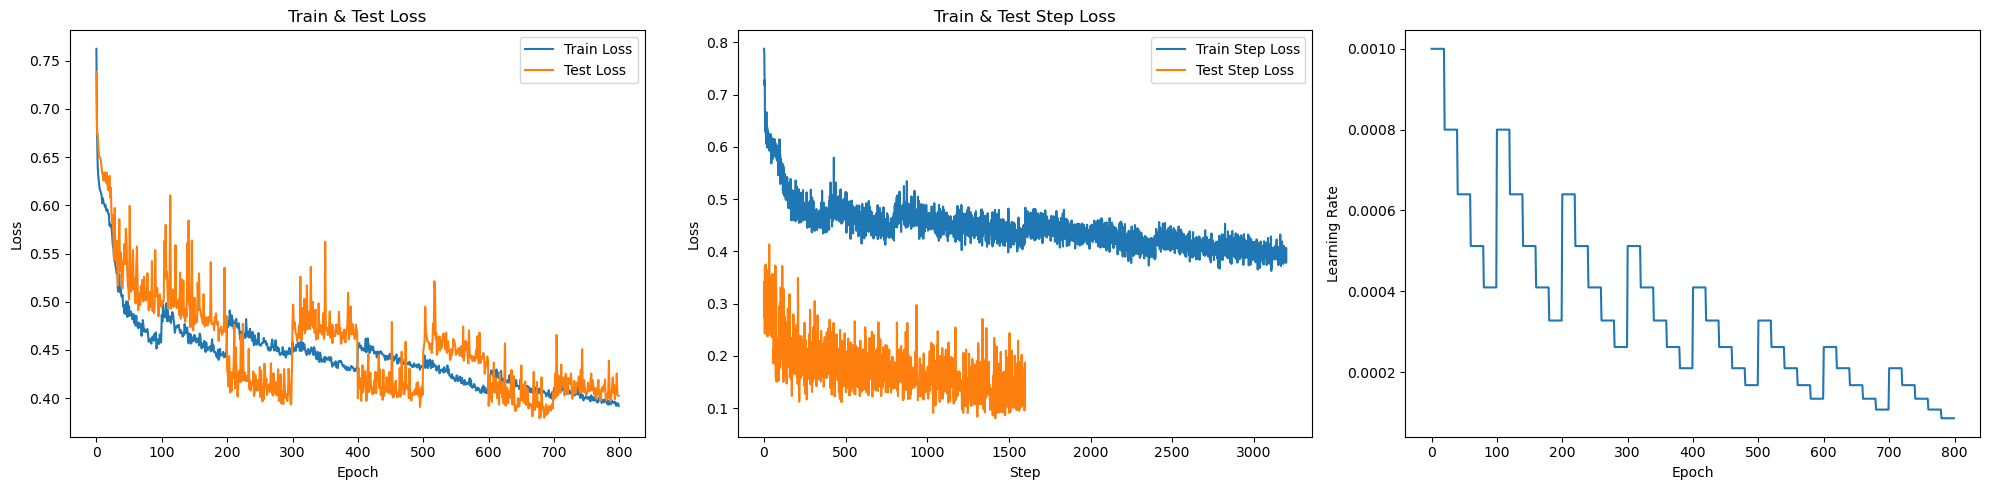

In [9]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_step_losses, label="Train Step Loss")
plt.plot(test_step_losses, label="Test Step Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Train & Test Step Loss")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(learning_rates)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")

plt.savefig("plot.png")

plt.tight_layout()
plt.show()